Iran Twitter / X Data Analysis Project

# **italicized text*POI Scraper (Wikipedia Categories → CSV)**

In [4]:
# ============================================
# File: step1_collect_wikipedia_categories.py (UPDATED)
#
# Description:
#   Recursively collects people/pages from Wikipedia categories (including subcategories),
#   and saves a CSV per category with columns: Name, Wikipedia_Link.
#   Output structure (per course spec):
#       <IRAN_DIR>/
#         POIs/
#           <slug>/
#             <slug>_wikipedia.csv
#   Also produces a summary table and a ZIP with all CSVs.
# ============================================

import requests, time, os, zipfile
import pandas as pd
from urllib.parse import quote
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# ---------------- IRAN_DIR resolution ----------------
# Set the Iran directory path (adjust if needed)
IRAN_DIR = r"C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran"

if not os.path.isdir(IRAN_DIR):
    raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran' בנתיב: {IRAN_DIR}")

# Base POIs directory (as per course structure)
POIS_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIS_DIR, exist_ok=True)

# ---------------- API config ----------------
BASE_API = "https://en.wikipedia.org/w/api.php"
HEADERS = {"User-Agent": "SCE-DataScience-FinalProject/1.0 (contact: student@example.com)"}

session = requests.Session()
retries = Retry(total=5, backoff_factor=0.8, status_forcelist=[403,429,500,502,503,504])
session.mount("https://", HTTPAdapter(max_retries=retries))

def api_get(params):
    """Thin wrapper around MediaWiki API GET with a fallback UA on 403."""
    r = session.get(BASE_API, params=params, headers=HEADERS, timeout=30)
    if r.status_code == 403:
        time.sleep(1)
        r = session.get(BASE_API, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=30)
    r.raise_for_status()
    return r.json()

def get_category_members(category_title, cmtype="page"):
    """
    Fetches up to all members of a category, paging through 'continue'.
    cmtype can be "page" (actual pages) or "subcat" (subcategories).
    """
    members, params = [], {
        "action": "query",
        "list": "categorymembers",
        "cmtitle": category_title,
        "cmlimit": "500",
        "cmtype": cmtype,
        "format": "json"
    }
    while True:
        data = api_get(params)
        members.extend(data.get("query", {}).get("categorymembers", []))
        if "continue" in data:
            params["cmcontinue"] = data["continue"]["cmcontinue"]
        else:
            break
    return members

def collect_people_from_category(root_category):
    """
    Breadth-first traversal from a root category:
      - collects 'page' members as rows {Name, Wikipedia_Link}
      - enqueues 'subcat' members for further traversal
    Returns a deduplicated DataFrame by Name.
    """
    seen, pages, queue = set(), [], [root_category]
    while queue:
        cat = queue.pop(0)
        if cat in seen:
            continue
        seen.add(cat)
        print(f"📂 סורק: {cat}")
        # pages
        for m in get_category_members(cat, "page"):
            title = m["title"]
            link  = "https://en.wikipedia.org/wiki/" + quote(title.replace(" ", "_"))
            pages.append({"Name": title, "Wikipedia_Link": link})
        # subcategories
        for sc in get_category_members(cat, "subcat"):
            queue.append(sc["title"])
        time.sleep(0.15)  # be polite
    return pd.DataFrame(pages).drop_duplicates(subset=["Name"]).reset_index(drop=True)

def safe_slug(cat):
    """
    Converts a category title to a folder/filename-safe slug.
    Example:
      "Category:Iranian physicians" -> "iranian_physicians"
    """
    name = cat.replace("Category:", "").strip()
    name = name.replace(" ", "_")
    for bad in ['"', "'", "'", """, """, "(", ")", "/", "\\", ":", "*", "?", "<", ">", "|", ",", ";", "—", "–"]:
        name = name.replace(bad, "")
    # compress consecutive underscores
    while "__" in name:
        name = name.replace("__", "_")
    return name.lower()

# ---------------- Categories to collect (expanded incl. healthcare) ----------------
categories = [
    # Existing:
    "Category:Government_ministers_of_Iran",
    "Category:Presidents_of_Iran",
    "Category:Vice_presidents_of_Iran",
    "Category:Iranian_ayatollahs",
    "Category:Iranian_actors",
    "Category:Iranian_singers",
    "Category:Iranian_scientists",
    "Category:Iranian_economists",
    "Category:Iranian_writers",
    "Category:Iranian_football_managers",

    # NEW — Healthcare related:
    "Category:Hospitals_in_Iran",
    "Category:Private_hospitals_in_Iran",
    "Category:Teaching_hospitals_in_Iran",
    "Category:Iranian_physicians",
    "Category:Iranian_cardiologists",
    "Category:Iranian_women_physicians",
    "Category:21st-century_Iranian_physicians",
    "Category:19th-century_Iranian_physicians",
    "Category:Medical_and_health_organisations_based_in_Iran",
    "Category:Healthcare_in_Iran",
    "Category:Medicine_in_Iran",

    # NEW — Journalists and Media:
    "Category:Iranian_journalists",
    "Category:Iranian_women_journalists",
    "Category:Iranian_reporters",
    "Category:Iranian_correspondents",
    "Category:Iranian_editors",
    "Category:Iranian_news_readers",

    # NEW — Activists and Political:
    "Category:Iranian_activists",
    "Category:Iranian_political_activists",
    "Category:Iranian_human_rights_activists",
    "Category:Iranian_women_activists",
    "Category:Iranian_feminists",
    "Category:Iranian_dissidents",
    "Category:Iranian_bloggers",

    # NEW — Sports:
    "Category:Iranian_footballers",
    "Category:Iranian_athletes",
    "Category:Iranian_wrestlers",
    "Category:Iranian_taekwondo_practitioners",
    "Category:Iranian_volleyball_players",
    "Category:Iranian_weightlifters",

    # NEW — Entertainment:
    "Category:Iranian_television_actors",
    "Category:Iranian_film_actors",
    "Category:Iranian_pop_singers",
    "Category:Iranian_rappers",
    "Category:Iranian_comedians",
]

# ---------------- Main loop: collect, save per-spec, summarize ----------------
csv_files = []
summary_rows = []

for cat in categories:
    try:
        slug = safe_slug(cat)
        cat_dir = os.path.join(POIS_DIR, slug)
        os.makedirs(cat_dir, exist_ok=True)

        csv_name = f"{slug}_wikipedia.csv"
        csv_path = os.path.join(cat_dir, csv_name)

        # Skip if file already exists and is not empty
        if os.path.exists(csv_path) and os.path.getsize(csv_path) > 0:
            print(f"⏩ Skipping {slug}: file already exists.")
            summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": "SKIPPED", "CSV": csv_path})
            continue

        df = collect_people_from_category(cat)
        n = len(df)

        if n == 0:
            print(f"⚠️ אין נתונים עבור {cat}")
            summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": 0, "CSV": None})
            continue

        df.to_csv(csv_path, index=False, encoding="utf-8-sig")
        csv_files.append(csv_path)

        print(f"✅ נשמר: {csv_path} | רשומות: {n}")
        summary_rows.append({"Category": cat, "Slug": slug, "SavedRows": n, "CSV": csv_path})

    except Exception as e:
        print(f"❌ שגיאה בקטגוריה {cat}: {e}")
        summary_rows.append({"Category": cat, "Slug": safe_slug(cat), "SavedRows": 0, "CSV": None})

# --- Summary table ---
summary_df = pd.DataFrame(summary_rows)

# Add numeric column for sorting (convert SKIPPED to -1 for sorting purposes)
summary_df['SavedRows_Numeric'] = summary_df['SavedRows'].apply(
    lambda x: -1 if x == "SKIPPED" else (int(x) if isinstance(x, (int, float)) else 0)
)

# Sort by the numeric column and drop it
summary_df = summary_df.sort_values("SavedRows_Numeric", ascending=False).reset_index(drop=True)
summary_df = summary_df.drop(columns=['SavedRows_Numeric'])

# Calculate total (only numeric values)
total_saved = sum(x for x in summary_df["SavedRows"] if isinstance(x, (int, float)))

print("\n================= Summary =================")
for _, r in summary_df.iterrows():
    base = os.path.basename(r['CSV']) if (pd.notna(r['CSV']) and r['CSV']) else "-"
    saved_str = str(r['SavedRows'])
    print(f"• {r['Category']} -> {r['Slug']}: {saved_str} רשומות  |  קובץ: {base}")
print(f"\n📊 Total across files: {total_saved} rows")
print("===========================================\n")

# Display summary table
display(summary_df)

# ---------------- ZIP all CSVs ----------------
if csv_files:
    zip_path = os.path.join(IRAN_DIR, "Iran_POIs_Wikipedia_Categories.zip")
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in csv_files:
            # Save relative path in zip
            arcname = os.path.relpath(file, start=IRAN_DIR)
            zipf.write(file, arcname)
    print(f"💾 Created ZIP with all categories: {zip_path}")
else:
    print("ℹ️ No CSV files were created → no ZIP.")

⏩ Skipping government_ministers_of_iran: file already exists.
⏩ Skipping presidents_of_iran: file already exists.
⏩ Skipping vice_presidents_of_iran: file already exists.
⏩ Skipping iranian_ayatollahs: file already exists.
⏩ Skipping iranian_actors: file already exists.
⏩ Skipping iranian_singers: file already exists.
⏩ Skipping iranian_scientists: file already exists.
⏩ Skipping iranian_economists: file already exists.
⏩ Skipping iranian_writers: file already exists.
⏩ Skipping iranian_football_managers: file already exists.
⏩ Skipping hospitals_in_iran: file already exists.
⏩ Skipping private_hospitals_in_iran: file already exists.
⏩ Skipping teaching_hospitals_in_iran: file already exists.
⏩ Skipping iranian_physicians: file already exists.
⏩ Skipping iranian_cardiologists: file already exists.
⏩ Skipping iranian_women_physicians: file already exists.
⏩ Skipping 21st-century_iranian_physicians: file already exists.
⏩ Skipping 19th-century_iranian_physicians: file already exists.
⏩ S

,Category,Slug,SavedRows,CSV
0,Category:Iranian_news_readers,iranian_news_readers,0,None
1,Category:Iranian_correspondents,iranian_correspondents,0,None
2,Category:Iranian_reporters,iranian_reporters,0,None
3,Category:Iranian_political_activists,iranian_political_activists,0,None
4,Category:Government_ministers_of_Iran,government_ministers_of_iran,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
5,Category:Iranian_singers,iranian_singers,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
6,Category:Iranian_scientists,iranian_scientists,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
7,Category:Iranian_economists,iranian_economists,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
8,Category:Iranian_writers,iranian_writers,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...
9,Category:Presidents_of_Iran,presidents_of_iran,SKIPPED,C:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran...


ℹ️ No CSV files were created → no ZIP.


# **Step 3: Wikidata Enrichment for ALL POI Folders**

In [5]:
# ============================================
# Step 3: Wikidata Enrichment for ALL POI Folders (UPDATED)
# ============================================
# For each subfolder under POIs:
#  1) Locate *_wikipedia.csv (or the first .csv)
#  2) Detect the Wikipedia link column (fallback to Name)
#  3) Resolve wikidata_qid (+ wikidata_url)
#  4) Fetch details via SPARQL in batches
#  5) Save:
#     a) *_with_wikidata_ids_and_links.csv
#     b) *_with_wikidata_ids_and_links_wikidata_detailed.csv
# ============================================

import os, re, time, glob, json, math, random
import pandas as pd
import requests
from pathlib import Path

# ---------------- Dynamic path detection ----------------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

ROOT_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(ROOT_DIR, exist_ok=True)
print(f"📁 ROOT_DIR: {ROOT_DIR}")

# ---------------- HTTP / Endpoints ----------------
UA = {"User-Agent": "SCE-DS-FinalProject/1.0 (contact: student@example.com)"}
MEDIAWIKI_API = "https://en.wikipedia.org/w/api.php"
SPARQL = "https://query.wikidata.org/sparql"

# ---------------- Helpers: retries ----------------
def http_get(url, params=None, headers=None, timeout=30, max_tries=4, sleep_base=0.8):
    """
    Simple GET with retries/backoff. Jitters a bit to be polite.
    """
    headers = headers or UA
    for attempt in range(1, max_tries + 1):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=timeout)
            if r.status_code == 403 and headers is UA:
                # fallback UA
                r = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=timeout)
            r.raise_for_status()
            return r
        except Exception as e:
            if attempt == max_tries:
                # last attempt: raise
                raise
            sleep_s = sleep_base * attempt + random.uniform(0, 0.3)
            time.sleep(sleep_s)
    # Shouldn't reach here
    raise RuntimeError("GET retries exhausted")

# ---------------- Column detection ----------------
def find_wikipedia_column(df: pd.DataFrame) -> str:
    # First pass: headers with hints
    for name in df.columns:
        n = str(name).strip().lower()
        if any(k in n for k in ["wikipedia", "wiki", "link", "url"]):
            return name
    # Second pass: sample content
    for name in df.columns:
        sample = " ".join(map(str, df[name].dropna().astype(str).head(20).tolist())).lower()
        if "wikipedia.org" in sample or sample.startswith("http"):
            return name
    # Fallback
    if "Wikipedia_Link" in df.columns:
        return "Wikipedia_Link"
    # As a last resort: if Name exists, we'll construct enwiki URLs from it
    if "Name" in df.columns:
        return None  # signal to construct from Name
    raise ValueError("לא מצאתי עמודת קישור לוויקיפדיה, ואין גם עמודת 'Name' לבניית קישורים.")

def name_to_enwiki_url(name: str) -> str:
    from urllib.parse import quote
    if not isinstance(name, str) or not name.strip():
        return None
    title = name.strip().replace(" ", "_")
    return f"https://en.wikipedia.org/wiki/{quote(title)}"

def wikipedia_url_to_title(url: str) -> str | None:
    if not isinstance(url, str) or not url:
        return None
    try:
        url = url.split("?")[0].split("#")[0]
        title = url.rstrip("/").split("/")[-1]
        return title if title else None
    except Exception:
        return None

# ---------------- QID resolution (with cache) ----------------
qid_cache = {}

def get_qid_from_wikipedia_url(url: str) -> str | None:
    """
    Resolve QID for a single Wikipedia page using the pageprops endpoint.
    """
    title = wikipedia_url_to_title(url)
    if not title:
        return None
    if title in qid_cache:
        return qid_cache[title]
    params = {
        "action": "query",
        "format": "json",
        "prop": "pageprops",
        "redirects": 1,
        "titles": title,
    }
    try:
        r = http_get(MEDIAWIKI_API, params=params, headers=UA, timeout=25)
        data = r.json()
        page = next(iter(data["query"]["pages"].values()))
        qid = page.get("pageprops", {}).get("wikibase_item")
        if qid:
            qid_cache[title] = qid
        return qid
    except Exception:
        return None

# ---------------- SPARQL batch fetch ----------------
def batch_fetch_wikidata_details(qids: list[str], batch_size: int = 50) -> dict:
    """
    Fetch properties for many QIDs via SPARQL using VALUES batching.
    Returns dict: { QID: {fields...}, ... }
    """
    results = {}
    # Normalize & unique
    qids = [q for q in qids if isinstance(q, str) and q.strip()]
    uniq = sorted(set(qids))
    if not uniq:
        return results

    def run_batch(subset):
        values = " ".join(f"wd:{q}" for q in subset)
        query = f"""
        SELECT ?item ?genderLabel ?occupationLabel ?countryLabel ?placeOfBirthLabel ?dateOfBirth WHERE {{
          VALUES ?item {{ {values} }}
          OPTIONAL {{ ?item wdt:P21 ?gender. }}
          OPTIONAL {{ ?item wdt:P106 ?occupation. }}
          OPTIONAL {{ ?item wdt:P27 ?country. }}
          OPTIONAL {{ ?item wdt:P19 ?placeOfBirth. }}
          OPTIONAL {{ ?item wdt:P569 ?dateOfBirth. }}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en,fa,en-gb". }}
        }}
        """
        r = http_get(SPARQL, params={"query": query, "format": "json"}, headers=UA, timeout=45)
        rows = r.json().get("results", {}).get("bindings", [])
        # collect multiple rows per item
        tmp = {}
        for b in rows:
            uri = b.get("item", {}).get("value", "")
            q = uri.rsplit("/", 1)[-1] if uri else None
            if not q:
                continue
            cur = tmp.setdefault(q, {"wikidata_gender": set(),
                                     "wikidata_occupation": set(),
                                     "wikidata_country_of_citizenship": set(),
                                     "wikidata_place_of_birth": None,
                                     "wikidata_date_of_birth": None})
            if "genderLabel" in b:
                cur["wikidata_gender"].add(b["genderLabel"]["value"])
            if "occupationLabel" in b:
                cur["wikidata_occupation"].add(b["occupationLabel"]["value"])
            if "countryLabel" in b:
                cur["wikidata_country_of_citizenship"].add(b["countryLabel"]["value"])
            if "placeOfBirthLabel" in b and not cur["wikidata_place_of_birth"]:
                cur["wikidata_place_of_birth"] = b["placeOfBirthLabel"]["value"]
            if "dateOfBirth" in b and not cur["wikidata_date_of_birth"]:
                cur["wikidata_date_of_birth"] = b["dateOfBirth"]["value"]
        # flatten sets
        for q, d in tmp.items():
            results[q] = {
                "wikidata_gender": "; ".join(sorted(d["wikidata_gender"])) or None,
                "wikidata_occupation": "; ".join(sorted(d["wikidata_occupation"])) or None,
                "wikidata_country_of_citizenship": "; ".join(sorted(d["wikidata_country_of_citizenship"])) or None,
                "wikidata_place_of_birth": d["wikidata_place_of_birth"],
                "wikidata_date_of_birth": d["wikidata_date_of_birth"],
            }

    for i in range(0, len(uniq), batch_size):
        subset = uniq[i:i+batch_size]
        # polite pacing
        try:
            run_batch(subset)
        except Exception as e:
            print(f"⚠️ SPARQL batch failed ({subset[0]}..): {e}. מנסה שוב בקבוצות קטנות יותר...")
            # fallback: try half batch to circumvent transient errors
            mid = len(subset)//2 or 1
            for chunk in (subset[:mid], subset[mid:]):
                try:
                    run_batch(chunk)
                except Exception as ee:
                    print(f"❌ SPARQL sub-batch failed ({chunk[0]}..): {ee}")
        time.sleep(0.5)

    return results

# ---------------- Main processing ----------------
folders = [f for f in sorted(os.listdir(ROOT_DIR)) if os.path.isdir(os.path.join(ROOT_DIR, f))]
print(f"🗂️ נמצאו {len(folders)} תיקיות POI לעיבוד.")

for folder in folders:
    FOLDER_PATH = os.path.join(ROOT_DIR, folder)
    print(f"\n📂 מעבד תיקייה: {folder}")

    # Locate input CSV (prefer *_wikipedia.csv)
    candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*_wikipedia.csv")))
    if not candidates:
        candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*.csv")))
    if not candidates:
        print("⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.")
        continue

    INPUT_CSV = candidates[0]
    base_name = re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV))
    
    # ⚡ SMART SKIP: Check if Wikidata enrichment already complete
    detailed_path = os.path.join(FOLDER_PATH, f"{base_name}_with_wikidata_ids_and_links_wikidata_detailed.csv")
    if os.path.exists(detailed_path):
        try:
            df_check = pd.read_csv(detailed_path, nrows=5)
            wd_cols = [c for c in df_check.columns if c.startswith('wikidata_')]
            if wd_cols and df_check[wd_cols].notna().any().any():
                print(f"✅ SKIP: Wikidata enrichment already complete")
                print(f"   File: {os.path.basename(detailed_path)}")
                print(f"   Found {len(wd_cols)} Wikidata columns with data")
                continue
        except Exception:
            pass

    candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*_wikipedia.csv")))
    if not candidates:
        candidates = sorted(glob.glob(os.path.join(FOLDER_PATH, "*.csv")))
    if not candidates:
        print("⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.")
        continue

    INPUT_CSV = candidates[0]
    try:
        df = pd.read_csv(INPUT_CSV)
    except Exception as e:
        print(f"❌ לא הצלחתי לקרוא את הקובץ {os.path.basename(INPUT_CSV)}: {e} — מדלג.")
        continue

    # Detect / construct Wikipedia links
    try:
        wiki_col = find_wikipedia_column(df)
    except Exception as e:
        print(f"⚠️ {e} — מנסה לבנות קישורי ויקיפדיה מ־'Name'...")
        wiki_col = None

    if wiki_col is None:
        if "Name" in df.columns:
            df["Wikipedia_Link"] = df["Name"].apply(name_to_enwiki_url)
            wiki_col = "Wikipedia_Link"
        else:
            print("❌ אין עמודת קישור/Name — מדלג על התיקייה.")
            continue

    print("🧩 עמודת ויקיפדיה:", wiki_col)

    # ---- A) Resolve QIDs (with simple in-memory cache) ----
    qids = []
    for url in df[wiki_col].fillna(""):
        qids.append(get_qid_from_wikipedia_url(url))
        time.sleep(0.08)  # polite throttle

    df["wikidata_qid"] = qids
    df["wikidata_url"] = df["wikidata_qid"].apply(lambda q: f"https://www.wikidata.org/wiki/{q}" if isinstance(q, str) and q else None)

    # Save mid file
    mid_path = os.path.join(
        FOLDER_PATH,
        re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV)) + "_with_wikidata_ids_and_links.csv"
    )
    try:
        df.to_csv(mid_path, index=False, encoding="utf-8-sig")
        print(f"💾 נשמר ביניים: {os.path.basename(mid_path)}  (שורות: {len(df)})")
    except Exception as e:
        print(f"❌ שגיאה בשמירת קובץ ביניים: {e}")

    # ---- B) Fetch details via SPARQL in batches ----
    uniq_qids = [q for q in pd.Series(df["wikidata_qid"]).dropna().astype(str).unique().tolist() if q]
    details_map = batch_fetch_wikidata_details(uniq_qids, batch_size=50)

    details_rows = []
    for q in df["wikidata_qid"]:
        if isinstance(q, str) and q in details_map:
            details_rows.append(details_map[q])
        else:
            details_rows.append({
                "wikidata_gender": None,
                "wikidata_occupation": None,
                "wikidata_country_of_citizenship": None,
                "wikidata_place_of_birth": None,
                "wikidata_date_of_birth": None,
            })

    details_df = pd.DataFrame(details_rows)
    enriched = pd.concat([df, details_df], axis=1)

    out_path = os.path.join(
        FOLDER_PATH,
        re.sub(r"\.csv$", "", os.path.basename(INPUT_CSV)) + "_with_wikidata_ids_and_links_wikidata_detailed.csv"
    )
    try:
        enriched.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"✅ נשמר פלט סופי: {os.path.basename(out_path)}  (שורות: {len(enriched)})")
    except Exception as e:
        print(f"❌ שגיאה בשמירת הפלט הסופי: {e}")

print("\n🎉 הושלם עיבוד לכל התיקיות!")


📁 ROOT_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
🗂️ נמצאו 49 תיקיות POI לעיבוד.

📂 מעבד תיקייה: 19th-century_iranian_physicians
✅ SKIP: Wikidata enrichment already complete
   File: 19th-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Found 7 Wikidata columns with data

📂 מעבד תיקייה: 21st-century_iranian_physicians
✅ SKIP: Wikidata enrichment already complete
   File: 21st-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Found 7 Wikidata columns with data

📂 מעבד תיקייה: Candidates
⚠️ לא מצאתי עמודת קישור לוויקיפדיה, ואין גם עמודת 'Name' לבניית קישורים. — מנסה לבנות קישורי ויקיפדיה מ־'Name'...
❌ אין עמודת קישור/Name — מדלג על התיקייה.

📂 מעבד תיקייה: figures
⚠️ לא נמצא קובץ CSV בתיקייה הזו, מדלג.

📂 מעבד תיקייה: government_ministers_of_iran
✅ SKIP: Wikidata enrichment already complete
   File: government_ministers_of_iran_wikipedia_with_wikidata_ids_and_links_wikidata_detailed.csv
   Foun

# Step 4: Find Twitter handles for ALL POI folders

In [ ]:
# ============================================
# Step 4: Find Twitter handles for ALL POI folders
# Adds only: Twitter_username + Twitter_url (no twitter_source)
# ============================================

import os, re, time, json, glob, requests, pandas as pd, random
from pathlib import Path
from urllib.parse import urlparse, unquote
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

# ירוץ על כל התיקיות תחת POIs
REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
print("📁 ROOT:", ROOT)

# ---------- HTTP session with retries ----------
UA = {"User-Agent": "SCE-DS-FinalProject/1.0 (contact: student@example.com)"}
session = requests.Session()
session.headers.update(UA)

# urllib3 v2: allowed_methods (not method_whitelist). עדיף frozenset
retry_cfg = Retry(
    total=5,
    backoff_factor=0.6,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=frozenset({"GET"}),
)
session.mount("https://", HTTPAdapter(max_retries=retry_cfg))
session.mount("http://", HTTPAdapter(max_retries=retry_cfg))

SPARQL = "https://query.wikidata.org/sparql"
MEDIAWIKI_API = "https://en.wikipedia.org/w/api.php"

# ---------- helpers ----------
def pick_csv(folder):
    for pat in ["*_with_wikidata_ids_and_links_wikidata_detailed*.csv",
                "*_with_wikidata_ids_and_links*.csv",
                "*_wikipedia.csv",
                "*.csv"]:
        cand = sorted(glob.glob(os.path.join(folder, pat)))
        # סנן קבצים שכבר מכילים _with_twitter (אלה הם פלטים, לא קלטים)
        cand = [c for c in cand if not c.endswith("_with_twitter.csv")]
        if cand: return cand[0]
    return None

def clean_handle(h):
    if not isinstance(h, str):
        return None
    h = h.strip().lstrip("@")
    h = re.sub(r"[/?#].*$", "", h)
    m = re.match(r"^[A-Za-z0-9_]{1,15}$", h)
    return m.group(0) if m else None

def extract_handle_from_url(url):
    """
    מחלץ ידית מכתובת twitter/x אם קיימת. לינקים מסוג /i/user/12345 לא מכילים ידית => נחזיר None.
    """
    try:
        u = url.split("?")[0].split("#")[0]
        host = urlparse(u).netloc.lower()
        if any(d in host for d in ["twitter.com","x.com","mobile.twitter.com","www.twitter.com","www.x.com"]):
            parts = urlparse(u).path.strip("/").split("/")
            if parts and parts[0].lower() not in {"i","intent","share","home"}:
                return clean_handle(parts[0])
    except:
        pass
    return None

def build_twitter_url(handle):
    if not isinstance(handle, str) or not handle.strip():
        return None
    return f"https://x.com/{handle.strip().lstrip('@')}"

def find_wikipedia_column(df):
    # ראשית: לפי שם עמודה
    for c in df.columns:
        n = str(c).lower()
        if any(k in n for k in ["wikipedia", "wiki", "link", "url"]):
            return c
    # שנית: לפי תוכן
    for c in df.columns:
        vals = " ".join(map(str, df[c].dropna().astype(str).head(15).tolist())).lower()
        if "wikipedia.org" in vals or "https://" in vals or "http://" in vals:
            return c
    return None

def http_get(url, params=None, headers=None, timeout=30, tries=3, backoff=0.7):
    headers = headers or UA
    for attempt in range(1, tries+1):
        try:
            r = session.get(url, params=params, headers=headers, timeout=timeout)
            r.raise_for_status()
            return r
        except Exception as e:
            if attempt == tries:
                raise
            time.sleep(backoff * attempt + random.uniform(0, 0.2))

def guess_twitter_from_wiki(title_or_url):
    """
    נסה לחלץ ידית מהדף בוויקיפדיה:
    - External links
    - טקסט המקור (wikitext) עם regex
    """
    try:
        if isinstance(title_or_url, str) and title_or_url.startswith(("http://", "https://")):
            title = unquote(title_or_url.split("?")[0].split("#")[0].rstrip("/").split("/")[-1])
            title = title.replace("_", " ")
        else:
            title = str(title_or_url).strip().replace("_", " ")
        if not title:
            return None

        r = http_get(MEDIAWIKI_API, params={
            "action": "parse",
            "format": "json",
            "page": title,
            "prop": "externallinks|wikitext",
            "redirects": 1
        }, timeout=30, tries=3)
        data = r.json()

        links = data.get("parse", {}).get("externallinks", []) or []
        for ln in links:
            h = extract_handle_from_url(ln)
            if h:
                return h

        wt = data.get("parse", {}).get("wikitext", {}).get("*", "")
        # תופס גם twitter וגם x.com
        for m in re.finditer(r"(?:https?://)?(?:www\.)?(?:twitter|x)\.com/([A-Za-z0-9_]{1,15})", wt, re.I):
            h = clean_handle(m.group(1))
            if h:
                return h
    except:
        pass
    return None

def batch_p2002(qids):
    """
    מחזיר מפה { QID: handle or None } עם retry.
    """
    qids = [q for q in qids if isinstance(q, str) and q]
    if not qids:
        return {}
    values = " ".join(f"(wd:{q})" for q in qids)
    q = f"""
    SELECT ?item ?twitter WHERE {{
      VALUES (?item) {{ {values} }}
      OPTIONAL {{ ?item wdt:P2002 ?twitter. }}
    }}
    """
    # retry דרך http_get
    r = http_get(SPARQL, params={"query": q, "format": "json"}, timeout=45, tries=3, backoff=0.9)
    rows = r.json().get("results", {}).get("bindings", [])
    out = {}
    for b in rows:
        qid = b["item"]["value"].rsplit("/",1)[-1]
        tw = b.get("twitter", {}).get("value")
        out[qid] = clean_handle(tw) if tw else None
    return out

# cache (QID -> handle)
cache_file = os.path.join(ROOT, "_twitter_cache.json")
twitter_cache = {}
if os.path.exists(cache_file):
    try:
        twitter_cache = json.load(open(cache_file, "r", encoding="utf-8"))
    except:
        twitter_cache = {}

# ---------- process all subfolders ----------
folders = [os.path.join(ROOT, d) for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]
folders.sort()

for FOLDER in folders:
    in_csv = pick_csv(FOLDER)
    if not in_csv:
        print(f"⚠️ אין CSV בתיקייה {os.path.basename(FOLDER)} — דילוג")
        continue

    # ⚡ SMART SKIP: Check if Twitter enrichment already complete
    # בדיקת כל הפורמטים האפשריים של קבצי Twitter
    base_name = os.path.splitext(os.path.basename(in_csv))[0]
    possible_outputs = [
        os.path.join(FOLDER, base_name + "_with_twitter.csv"),
        os.path.join(FOLDER, base_name.replace("_wikidata_detailed", "") + "_with_twitter.csv"),
        # אם הקובץ נקרא *_detailed.csv, נסה גם ללא detailed
        os.path.join(FOLDER, base_name.replace("_detailed", "") + "_with_twitter.csv")
    ]
    
    skip = False
    for out_path in possible_outputs:
        if os.path.exists(out_path):
            try:
                df_check = pd.read_csv(out_path, nrows=5)
                if 'Twitter_username' in df_check.columns:
                    twitter_count = df_check['Twitter_username'].notna().sum()
                    if twitter_count > 0:
                        print(f"\n📂 {os.path.basename(FOLDER)}")
                        print(f"✅ SKIP: Twitter enrichment already complete")
                        print(f"   File: {os.path.basename(out_path)} ({twitter_count}+ handles)")
                        skip = True
                        break
            except Exception:
                pass
    
    if skip:
        continue

    print(f"\n📂 {os.path.basename(FOLDER)}")
    try:
        df = pd.read_csv(in_csv)
    except Exception as e:
        print(f"❌ לא הצלחתי לקרוא את הקובץ: {e} — דילוג")
        continue

    wiki_col = find_wikipedia_column(df)
    if "wikidata_qid" not in df.columns:
        df["wikidata_qid"] = None

    if "Twitter_username" not in df.columns:
        df["Twitter_username"] = None

    # 1) Wikidata P2002 (with cache)
    qids = [q for q in df["wikidata_qid"].dropna().astype(str).unique() if q]
    p2002_map = {}
    # קודם מה-cache
    for q in qids:
        if q in twitter_cache:
            p2002_map[q] = twitter_cache[q]
    # מה שחסר — לשאילתא (בקבוצות)
    to_query = [q for q in qids if q not in p2002_map]
    for i in range(0, len(to_query), 60):
        part = to_query[i:i+60]
        try:
            m = batch_p2002(part)
            p2002_map.update(m)
            # לעדכן cache רק כשיש ידית (כדי לא “לקבע” None)
            twitter_cache.update({k: v for k, v in m.items() if v})
            time.sleep(0.25)
        except Exception as e:
            print("⚠️ SPARQL batch failed:", e)

    # כתיבה לפי QID
    for idx, row in df.iterrows():
        qid = row.get("wikidata_qid")
        if isinstance(qid, str) and qid in p2002_map and p2002_map[qid]:
            if not df.at[idx, "Twitter_username"]:
                df.at[idx, "Twitter_username"] = p2002_map[qid]

    # 2) Wikipedia fallback
    if wiki_col:
        missing = df["Twitter_username"].isna()
        for idx, row in df[missing].iterrows():
            url = row[wiki_col]
            if isinstance(url, str) and url.strip():
                h = guess_twitter_from_wiki(url)
                if h:
                    df.at[idx, "Twitter_username"] = h
                    # אם יש גם QID — עדכן cache (נחסוך בהפעלות עתידיות)
                    qid = row.get("wikidata_qid")
                    if isinstance(qid, str) and qid:
                        twitter_cache[qid] = h

    # ניקוי + URL
    df["Twitter_username"] = df["Twitter_username"].apply(lambda h: clean_handle(h) if isinstance(h, str) else None)
    df["Twitter_url"] = df["Twitter_username"].apply(build_twitter_url)

    # save (UTF-8-SIG to be Excel-friendly)
    out_path = os.path.join(FOLDER, os.path.splitext(os.path.basename(in_csv))[0] + "_with_twitter.csv")
    try:
        df.to_csv(out_path, index=False, encoding="utf-8-sig")
        print(f"✅ Saved: {os.path.basename(out_path)} | found {df['Twitter_username'].notna().sum()} / {len(df)}")
    except Exception as e:
        print(f"❌ שמירה נכשלה: {e}")

# save cache
try:
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(twitter_cache, f, ensure_ascii=False, indent=2)
    print("\n💾 cache saved:", cache_file)
except Exception as e:
    print("⚠️ couldn't save cache:", e)

print("\n🎉 Done — Step 4 completed for all POI folders (username + url only).")


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs

📂 19th-century_iranian_physicians
✅ Saved: 19th-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv | found 0 / 11

📂 21st-century_iranian_physicians
✅ SKIP: Twitter enrichment already complete
   File: 21st-century_iranian_physicians_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv (1+ handles)

📂 Candidates
✅ SKIP: Twitter enrichment already complete
   File: Candidates_statistics_with_twitter.csv (5+ handles)
⚠️ אין CSV בתיקייה figures — דילוג

📂 government_ministers_of_iran
✅ SKIP: Twitter enrichment already complete
   File: government_ministers_of_iran_wikipedia_with_wikidata_ids_and_links_wikidata_detailed_with_twitter.csv (1+ handles)

📂 healthcare_in_iran


In [1]:
# ============================================
# Build Manual_Search_POIs.csv from all *_with_twitter.csv
# ממלא אוטומטית את הקובץ המרכזי מכל התיקיות (מהעמודה Twitter_username)
# בהתאם להנחיות הקורס: שם הקובץ Manual_Search_POIs.csv ושמירה תחת POIs/
# ============================================

import os, re, glob, pandas as pd
from pathlib import Path

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
assert os.path.isdir(ROOT), f"❌ לא קיימת התיקייה: {ROOT}"
print("📁 ROOT:", ROOT)

# שם הקובץ לפי ההנחיות (שלב 5)
OUTPUT_NAME = "Manual_Search_POIs.csv"
OUTPUT_PATH = os.path.join(ROOT, OUTPUT_NAME)

# -------- Keyword map (folder_slug -> keyword) --------
# הערה: השמות כאן ב-lowercase כי התיקיות נוצרו עם slug קטן (safe_slug)
KEYWORD_MAP = {
    # Existing
    "government_ministers_of_iran": "Iran minister",
    "presidents_of_iran": "Iran president",
    "vice_presidents_of_iran": "Iran vice president",
    "iranian_ayatollahs": "Iran ayatollah",
    "iranian_actors": "Iran actor",
    "iranian_singers": "Iran singer",
    "iranian_scientists": "Iran scientist",
    "iranian_economists": "Iran economist",
    "iranian_writers": "Iran writer",
    "iranian_football_managers": "Iran football manager",

    # Healthcare related
    "hospitals_in_iran": "Iran hospital",
    "private_hospitals_in_iran": "Iran hospital",
    "teaching_hospitals_in_iran": "Iran teaching hospital",
    "iranian_physicians": "Iran physician",
    "iranian_cardiologists": "Iran cardiologist",
    "iranian_women_physicians": "Iran physician",
    "21st-century_iranian_physicians": "Iran physician",
    "19th-century_iranian_physicians": "Iran physician",
    "medical_and_health_organisations_based_in_iran": "Iran health org",
    "healthcare_in_iran": "Iran healthcare",
    "medicine_in_iran": "Iran medicine",
}

CENTURY_PREFIX = re.compile(r"^\d{1,2}(st|nd|rd|th)-century_")

def base_slug(folder_slug: str) -> str:
    """מסיר קידומת של מאה מהסלאג (e.g., 19th-century_...)"""
    return CENTURY_PREFIX.sub("", folder_slug)

def infer_keyword_from_folder(folder_slug: str) -> str:
    """מפיק מילת חיפוש הגיונית מהסלאג, עם מפה ידנית לקייסים חשובים."""
    slug = folder_slug.lower().strip()
    if slug in KEYWORD_MAP:
        return KEYWORD_MAP[slug]
    slug = base_slug(slug)
    if slug in KEYWORD_MAP:
        return KEYWORD_MAP[slug]
    # כלל ברירת מחדל: הורד "iranian_" וה־s הסופית, והחלף _ ברווח
    token = slug.replace("iranian_", "").replace("_", " ").strip()
    token = token[:-1] if token.endswith("s") else token
    return f"Iran {token}".strip()

def detect_name_col(df: pd.DataFrame) -> str:
    """מאתר עמודת שם סבירה."""
    for c in df.columns:
        n = str(c).strip().lower()
        if n in {"name", "poi name", "poi_name", "full_name", "full name"}:
            return c
    # fallback: העמודה הראשונה
    return df.columns[0]

def detect_twitter_col(df: pd.DataFrame) -> str | None:
    """מאתר עמודת Twitter_username (או דומה)."""
    for c in df.columns:
        n = str(c).strip().lower()
        if n in {"twitter_username", "twitter", "handle", "username"}:
            return c
    # חפש עמודה שיש בה הרבה ערכים שנראים כמו ידיות
    for c in df.columns:
        vals = df[c].dropna().astype(str).head(20).tolist()
        hits = sum(1 for v in vals if re.match(r"^@?[A-Za-z0-9_]{1,15}$", v))
        if hits >= max(3, len(vals)//3):
            return c
    return None

def build_twitter_url(handle: str) -> str | None:
    if not isinstance(handle, str) or not handle.strip():
        return None
    h = handle.strip()
    h = h[1:] if h.startswith("@") else h
    return f"https://x.com/{h}"

rows = []
folders = [d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))]
folders.sort()

for folder in folders:
    folder_path = os.path.join(ROOT, folder)
    # חפש את קובץ היעד שנוצר בשלב 4
    cands = sorted(glob.glob(os.path.join(folder_path, "*_with_twitter.csv")))
    if not cands:
        continue
    path = cands[0]

    try:
        df = pd.read_csv(path, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="utf-8-sig")
    except Exception as e:
        print("⚠️ can't read:", path, e)
        continue

    twitter_col = detect_twitter_col(df)
    if not twitter_col:
        continue

    name_col = detect_name_col(df)
    kw = infer_keyword_from_folder(folder)

    sub = df[[name_col, twitter_col]].copy()
    sub.rename(columns={name_col: "poi_name", twitter_col: "Twitter_username"}, inplace=True)

    # ניקוי, סינון, והשלמת URL
    sub["Twitter_username"] = sub["Twitter_username"].astype(str).str.strip()
    sub = sub[sub["Twitter_username"].str.len() > 0]
    sub["Twitter_username"] = sub["Twitter_username"].str.lstrip("@")
    sub["Twitter_url"] = sub["Twitter_username"].apply(build_twitter_url)
    sub["keyword"] = kw
    sub["source_folder"] = folder  # מאיזה קטגוריה הגיע

    rows.append(sub[["keyword", "poi_name", "Twitter_username", "Twitter_url", "source_folder"]])

# איחוד ושמירה
if rows:
    out = pd.concat(rows, ignore_index=True)
    # סינון כפילויות על בסיס שלישייה (שם משתמש + מילת חיפוש + שם POI)
    out.drop_duplicates(subset=["Twitter_username", "keyword", "poi_name"], inplace=True, ignore_index=True)
    # וריאנט נוסף: אם אותו handle הופיע בכמה תיקיות — נשמור את ההופעה הראשונה בלבד
    out.sort_values(["Twitter_username", "keyword", "poi_name"], inplace=True, ignore_index=True)
    out.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
    print(f"✅ Saved: {OUTPUT_PATH} | rows: {len(out)}")
    try:
        from IPython.display import display
        display(out.head(20))
    except Exception:
        pass
else:
    print("ℹ️ לא נמצאו *_with_twitter.csv בתיקיות, או שאין ידיות למלא.")


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
✅ Saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs.csv | rows: 13470


,keyword,poi_name,Twitter_username,Twitter_url,source_folder
0,Iran activist,Execution of Majid Kazemi,1500tasvir,https://x.com/1500tasvir,iranian_activists
1,Iran candidate,まゆみん,2011,https://x.com/2011,Candidates
2,Iran writer,Mehrdad Afsari,2011,https://x.com/2011,iranian_writers
3,Iran candidate,2012 ABC,2012,https://x.com/2012,Candidates
4,Iran writer,Behdad Sami,2012,https://x.com/2012,iranian_writers
5,Iran actor,Michael Shahrestani,2015,https://x.com/2015,iranian_actors
6,Iran candidate,NaN,2015,https://x.com/2015,Candidates
7,Iran film actor,Michael Shahrestani,2015,https://x.com/2015,iranian_film_actors
8,Iran president,Joint Comprehensive Plan of Action,2015,https://x.com/2015,presidents_of_iran
9,Iran president,Reactions to the Joint Comprehensive Plan of A...,2015,https://x.com/2015,presidents_of_iran


##  Enhanced Wikipedia Search via API
חיפוש משופר של עמודי ויקיפדיה - שימוש ב-Wikipedia API לחיפוש ישיר במקום להסתמך רק על הקבצים המקומיים

In [4]:
import pandas as pd
import requests
import time
from urllib.parse import quote

# טעינת המשתמשים החסרים (שלא נמצאו בקובץ Unique)
missing_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_From_Unique.csv")

if not os.path.exists(missing_file):
    print(f"⚠️ קובץ לא נמצא: {missing_file}")
    print("📝 קודם צריך להריץ את הקוד שיוצר את הקובץ הזה")
else:
    df_missing = pd.read_csv(missing_file, encoding='utf-8-sig')
    print(f"📊 Total missing users to search: {len(df_missing)}")
    
    # פונקציה לחיפוש ישירות ב-Wikipedia API
    def search_wikipedia_api(name, language='en'):
        """חיפוש ישיר ב-Wikipedia API"""
        try:
            search_url = f"https://{language}.wikipedia.org/w/api.php"
            params = {
                'action': 'query',
                'format': 'json',
                'list': 'search',
                'srsearch': name,
                'srlimit': 3,
                'utf8': 1
            }
            
            # הוספת User-Agent header - חובה עבור Wikipedia API
            headers = {
                'User-Agent': 'Iranian_POIs_Research/1.0 (Educational Research Project)'
            }
            
            response = requests.get(search_url, params=params, headers=headers, timeout=5)
            
            # בדיקה שהתגובה תקינה
            if response.status_code != 200:
                return None, None
            
            # ניסיון לפרסר את ה-JSON
            try:
                data = response.json()
            except:
                return None, None
            
            if 'query' in data and 'search' in data['query'] and len(data['query']['search']) > 0:
                # מחזיר את התוצאה הראשונה
                result = data['query']['search'][0]
                title = result['title']
                wiki_link = f"https://{language}.wikipedia.org/wiki/{quote(title.replace(' ', '_'))}"
                return wiki_link, title
            
            return None, None
        except requests.exceptions.Timeout:
            return None, None
        except requests.exceptions.RequestException:
            return None, None
        except Exception:
            return None, None
    
    # חיפוש עבור כל המשתמשים החסרים
    print(f"\n🔍 Searching Wikipedia API for all {len(df_missing)} users...")
    print("⏳ This may take a few minutes (0.2s delay per search)...\n")
    
    df_missing['Wikipedia_Link_API'] = None
    df_missing['Wikipedia_Title_API'] = None
    found_count = 0
    search_count = 0
    
    for idx, row in df_missing.iterrows():
        if pd.isna(row['poi_name']):
            continue
        
        poi_name = str(row['poi_name']).strip()
        search_count += 1
        
        # חיפוש ב-API
        wiki_link, wiki_title = search_wikipedia_api(poi_name)
        
        if wiki_link:
            df_missing.at[idx, 'Wikipedia_Link_API'] = wiki_link
            df_missing.at[idx, 'Wikipedia_Title_API'] = wiki_title
            found_count += 1
            print(f"  ✅ [{found_count}] {poi_name[:50]}")
        
        # עדכון התקדמות כל 10 חיפושים
        if search_count % 10 == 0:
            print(f"  📊 Progress: {search_count}/{len(df_missing)} searches, {found_count} found")
        
        # המתנה קצרה למניעת חסימה
        time.sleep(0.2)
    
    print(f"\n{'='*70}")
    print(f"🎯 RESULTS: Found {found_count}/{len(df_missing)} Wikipedia pages ({found_count/len(df_missing)*100:.1f}%)")
    print(f"{'='*70}")
    
    # שמירת התוצאות המלאות
    output_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_WikiAPI_Results.csv")
    df_missing.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n💾 Saved all results to: {output_file}")
    
    # סינון רק מי שנמצא לו ויקיפדיה
    df_found = df_missing[df_missing['Wikipedia_Link_API'].notna()].copy()
    
    if len(df_found) > 0:
        print(f"\n✅ Found {len(df_found)} users with Wikipedia pages!")
        
        # העתקת הקישור לעמודה הרגילה
        df_found['Wikipedia_Link'] = df_found['Wikipedia_Link_API']
        
        # שמירה לקובץ נפרד
        output_found = os.path.join(ROOT, "Manual_Search_POIs_Missing_WithWikiAPI.csv")
        df_found.to_csv(output_found, index=False, encoding='utf-8-sig')
        print(f"💾 Saved found users to: {output_found}")
        
        # הצגת דוגמאות
        print(f"\n📋 Top 20 found users:")
        for i, row in df_found.head(20).iterrows():
            twitter = row['Twitter_username'] if pd.notna(row['Twitter_username']) else 'N/A'
            title = row['Wikipedia_Title_API'] if pd.notna(row['Wikipedia_Title_API']) else row['poi_name']
            print(f"  {i+1}. {title[:60]} (@{twitter})")
        
        # שאלה האם להוסיף למשתמשים הייחודיים
        print(f"\n" + "="*70)
        print(f"💡 הצעה: להוסיף את {len(df_found)} המשתמשים האלה ל-Manual_Search_POIs_Unique.csv")
        print(f"   הריצו את התא הבא כדי לבצע את ההוספה")
        print("="*70)
    else:
        print("\n❌ No Wikipedia pages found via API search")
    
    # סטטיסטיקה לפי תיקיות
    if found_count > 0:
        print(f"\n📊 Breakdown by source folder:")
        print(df_found['source_folder'].value_counts())

📊 Total missing users to search: 81

🔍 Searching Wikipedia API for all 81 users...
⏳ This may take a few minutes (0.2s delay per search)...

  ✅ [1] まゆみん
  ✅ [2] 2012 ABC
  ✅ [3] Sam Beck
  ✅ [4] Catherine Manso
  ✅ [5] Iran News Wire
  ✅ [6] Javad Zarif
  ✅ [7] Janez Lenarčič
  ✅ [8] John Kerry
  ✅ [9] Kaveh Akbar _ AUTHOR
  ✅ [10] محمد نهاوندیان
  📊 Progress: 10/81 searches, 10 found
  ✅ [11] Nisha Biswal
  ✅ [12] Mohsen Namjoo | محسن نامجو
  ✅ [13] توماج صالحی
  ✅ [14] porochista khakpour she/her پوروچیستا خاکپور
  ✅ [15] Penn History
  ✅ [16] REZA
  ✅ [17] SAGES is in Tampa in 2026!
  📊 Progress: 20/81 searches, 17 found
  ✅ [18] Joseph S Blatter
  ✅ [19] Shaparak Khorsandi شاپرک خرسندی
  ✅ [20] توانا Tavaana
  ✅ [21] V&A
  ✅ [22] Ali Larijani | علی لاریجانی
  ✅ [23] Әлия  Назарбаева
  ✅ [24] Arash Sobhani آرش سبحانی
  ✅ [25] Arthur Bullard
  ✅ [26] asa
  ✅ [27] عصر مجلس
  📊 Progress: 30/81 searches, 27 found
  ✅ [28] حسین صمصامی
  ✅ [29] Elina Valtonen
  ✅ [30] enちゃん
  ✅ [31] Fate

### Step 9C: Add Found Users to Unique File
הוספת המשתמשים שנמצאו ל-Manual_Search_POIs_Unique.csv

In [5]:
import pandas as pd

# טעינת הקבצים
found_file = os.path.join(ROOT, "Manual_Search_POIs_Missing_WithWikiAPI.csv")
unique_file = os.path.join(ROOT, "Manual_Search_POIs_Unique.csv")

if not os.path.exists(found_file):
    print(f"⚠️ קובץ לא נמצא: {found_file}")
    print("📝 קודם צריך להריץ את Step 9B")
elif not os.path.exists(unique_file):
    print(f"⚠️ קובץ לא נמצא: {unique_file}")
else:
    df_found = pd.read_csv(found_file, encoding='utf-8-sig')
    df_unique = pd.read_csv(unique_file, encoding='utf-8-sig')
    
    print(f"📊 Found users to add: {len(df_found)}")
    print(f"📊 Current unique users: {len(df_unique)}")
    
    # ניקוי עמודות מיותרות מהקובץ של המשתמשים שנמצאו
    cols_to_keep = ['keyword', 'poi_name', 'Twitter_username', 'Twitter_url', 'source_folder', 'Wikipedia_Link']
    df_found_clean = df_found[cols_to_keep].copy()
    
    # איחוד
    df_combined = pd.concat([df_unique, df_found_clean], ignore_index=True)
    
    # הסרת כפילויות לפי Twitter_username (case-insensitive)
    df_combined['twitter_lower'] = df_combined['Twitter_username'].str.lower()
    df_final = df_combined.drop_duplicates(subset=['twitter_lower'], keep='first')
    df_final = df_final.drop(columns=['twitter_lower'])
    
    # תיקון מספור
    df_final['Row_Number'] = range(1, len(df_final) + 1)
    
    # סידור העמודות
    cols_order = ['Row_Number'] + [col for col in df_final.columns if col != 'Row_Number']
    df_final = df_final[cols_order]
    
    print(f"\n✅ After merge: {len(df_final)} users")
    print(f"➕ Net new users added: {len(df_final) - len(df_unique)}")
    
    # שמירה
    df_final.to_csv(unique_file, index=False, encoding='utf-8-sig')
    print(f"\n💾 Updated: {unique_file}")
    
    # סטטיסטיקה
    with_wiki = df_final['Wikipedia_Link'].notna().sum()
    print(f"\n📊 Final statistics:")
    print(f"   Total users: {len(df_final)}")
    print(f"   With Wikipedia: {with_wiki} ({with_wiki/len(df_final)*100:.1f}%)")
    print(f"   Without Wikipedia: {len(df_final) - with_wiki}")
    
    print(f"\n✨ Done! Manual_Search_POIs_Unique.csv updated successfully")

📊 Found users to add: 55
📊 Current unique users: 326

✅ After merge: 378 users
➕ Net new users added: 52

💾 Updated: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv

📊 Final statistics:
   Total users: 378
   With Wikipedia: 378 (100.0%)
   Without Wikipedia: 0

✨ Done! Manual_Search_POIs_Unique.csv updated successfully


#**Cleaning up suspended users**

הוא צעד עזר טוב לפני שלב 6.


In [2]:
# ============================================
# Add "Twitter_status" column to mark suspended/invalid/missing users
# Works on Manual_Search_POIs.csv
# ============================================

import os, re, pandas as pd
from pathlib import Path
from IPython.display import display

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

# ---- Config ----
REL_ROOT  = "POIs"
FILE_NAME = "Manual_Search_POIs.csv"   # <-- מעודכן לשם הקובץ החדש

ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
path = os.path.join(ROOT, FILE_NAME)
assert os.path.exists(path), f"❌ File not found: {path}"
print("📁 ROOT:", ROOT)

# ---- Load ----
try:
    df = pd.read_csv(path, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(path, encoding="utf-8-sig")

# ---- Helpers ----
HANDLE_RE = re.compile(r"^[A-Za-z0-9_]{1,15}$")

def classify_status(username: str) -> str:
    if pd.isna(username):
        return "missing"
    s = str(username).strip().lstrip("@")
    if not s:
        return "missing"
    # מספר בלבד: לעיתים מצביע על חשבון מושעה/מומר למזהה
    if s.isdigit():
        return "suspended"
    # ידית לא חוקית (אורך >15 או תווים לא תקינים/רווחים)
    if (len(s) > 15) or (HANDLE_RE.fullmatch(s) is None):
        return "invalid"
    return "active"

# ---- Compute & Save ----
df["Twitter_status"] = df["Twitter_username"].apply(classify_status)

df.to_csv(path, index=False, encoding="utf-8-sig")
print(f"✅ Updated file: {path} ({len(df)} rows)")
try:
    display(df.head(20))
except Exception:
    pass


📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
✅ Updated file: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs.csv (8325 rows)


,Row_Number,keyword,poi_name,Twitter_username,Twitter_url,source_folder,Twitter_status
0,1,Iran candidate,まゆみん,2011,https://x.com/2011,Candidates,suspended
1,2,Iran writer,Mehrdad Afsari,2011,https://x.com/2011,iranian_writers,suspended
2,3,Iran candidate,2012 ABC,2012,https://x.com/2012,Candidates,suspended
3,4,Iran writer,Behdad Sami,2012,https://x.com/2012,iranian_writers,suspended
4,5,Iran actor,Michael Shahrestani,2015,https://x.com/2015,iranian_actors,suspended
5,6,Iran candidate,NaN,2015,https://x.com/2015,Candidates,suspended
6,7,Iran president,Joint Comprehensive Plan of Action,2015,https://x.com/2015,presidents_of_iran,suspended
7,8,Iran president,Reactions to the Joint Comprehensive Plan of A...,2015,https://x.com/2015,presidents_of_iran,suspended
8,9,Iran writer,Michael Shahrestani,2015,https://x.com/2015,iranian_writers,suspended
9,10,Iran candidate,2016,2016,https://x.com/2016,Candidates,suspended


In [ ]:
# ============================================
# 🧮 Step 6 – Enhanced Statistics & Visuals (UPDATED)
# Builds robust stats table + coverage + charts (portable)
# ============================================

from IPython.display import display
import os, glob, re, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------- Dynamic path detection ----------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT     = "POIs"
OUT_BASENAME = "POI_statistics.csv"             # basic
OUT_ENHANCED = "POI_statistics_enhanced.csv"    # enhanced with coverage
FIG_DIR      = "figures"

ROOT = os.path.join(IRAN_DIR, REL_ROOT)
os.makedirs(ROOT, exist_ok=True)
print("📁 ROOT:", ROOT)

# ---------- Helpers ----------
def safe_read_csv(path, nrows=None):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, nrows=nrows, encoding=enc)
        except Exception:
            pass
    # ניסיון אחרון עם engine=python ו-skip
    try:
        return pd.read_csv(path, nrows=nrows, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception:
        return None

def is_wikipedia_csv(path):
    """Detect Wikipedia CSV by content (columns/values), not filename alone."""
    name = os.path.basename(path).lower()
    if any(k in name for k in ["wikidata", "with_twitter"]):
        return False
    df = safe_read_csv(path, nrows=10)
    if df is None or df.empty:
        return False
    cols = [str(c).strip().lower() for c in df.columns]
    if any(any(k in c for k in ["wikipedia", "wiki", "link", "url"]) for c in cols):
        return True
    for c in df.columns:
        try:
            sample = " ".join(map(str, df[c].dropna().astype(str).head(10).tolist())).lower()
            if "wikipedia.org" in sample or sample.startswith("http"):
                return True
        except Exception:
            pass
    return False

def detect_twitter_col(df):
    candidates = {"twitter_username","twitter user","twitter_user","twitter handle","handle","twitter"}
    for c in df.columns:
        if str(c).strip().lower() in candidates:
            return c
    for c in df.columns:
        norm = re.sub(r'[^a-z]', '', str(c).lower())
        if "twitter" in norm and ("username" in norm or "handle" in norm or "user" in norm or "name" in norm):
            return c
    return None

def detect_qid_col(df):
    for c in df.columns:
        if str(c).strip().lower() in {"wikidata_qid","qid","wikidata id","wikidataid"}:
            return c
    return None

# ---------- Build basic stats ----------
rows = []
folders = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])

for folder in folders:
    fpath = os.path.join(ROOT, folder)
    csvs = sorted(glob.glob(os.path.join(fpath, "*.csv")))
    if not csvs:
        continue

    wiki_file = None
    wikidata_file = None
    twitter_file = None

    # Twitter file by name
    for p in csvs:
        if re.search(r"with_twitter", os.path.basename(p), re.I):
            twitter_file = p
            break

    # Wikidata: prefer detailed
    for p in csvs:
        if re.search(r"wikidata.*detailed", os.path.basename(p), re.I):
            wikidata_file = p
            break
    if wikidata_file is None:
        for p in csvs:
            if re.search(r"with_wikidata_ids_and_links", os.path.basename(p), re.I):
                wikidata_file = p
                break

    # Wikipedia by content (fallback to "<folder>.csv")
    for p in csvs:
        if is_wikipedia_csv(p):
            wiki_file = p
            break
    if wiki_file is None:
        fallback = os.path.join(fpath, f"{folder}.csv")
        if os.path.exists(fallback):
            wiki_file = fallback

    wikipedia_count = 0
    wikidata_count  = 0
    twitter_count   = 0

    # Wikipedia count
    if wiki_file:
        dfw = safe_read_csv(wiki_file)
        if dfw is not None:
            wikipedia_count = len(dfw)

    # Wikidata count (count non-empty QIDs if column exists)
    if wikidata_file:
        dfd = safe_read_csv(wikidata_file)
        if dfd is not None:
            qcol = detect_qid_col(dfd)
            wikidata_count = dfd[qcol].notna().sum() if qcol else len(dfd)

    # Twitter count (valid handles only)
    if twitter_file:
        dft = safe_read_csv(twitter_file)
        if dft is not None:
            tw_col = detect_twitter_col(dft)
            if tw_col:
                s = dft[tw_col].astype(str).str.strip()
                valid = s[(s != "") &
                          (~s.str.fullmatch(r"\d+")) &
                          (~s.str.lower().isin({"nan","none","null","suspended"}))]
                twitter_count = valid.shape[0]

    rows.append({
        "Category": folder,
        "Wikipedia count": wikipedia_count,
        "Wikidata count": wikidata_count,
        "Twitter user count": twitter_count
    })

basic = pd.DataFrame(rows).sort_values("Category").reset_index(drop=True)
basic_path = os.path.join(ROOT, OUT_BASENAME)
basic.to_csv(basic_path, index=False, encoding="utf-8-sig")
print(f"✅ Saved basic table: {basic_path}")
display(basic)

# ---------- Enhanced: coverage, gaps, totals ----------
enh = basic.copy()
with pd.option_context('mode.use_inf_as_na', True):
    enh["Wikidata coverage (%)"] = (100 * enh["Wikidata count"] / enh["Wikipedia count"]).fillna(0).round(1)
    enh["Twitter coverage (%)"]  = (100 * enh["Twitter user count"] / enh["Wikipedia count"]).fillna(0).round(1)

enh["Wikidata gap"] = (enh["Wikipedia count"] - enh["Wikidata count"]).clip(lower=0)
enh["Twitter gap"]  = (enh["Wikipedia count"] - enh["Twitter user count"]).clip(lower=0)

tot = pd.DataFrame([{
    "Category": "TOTAL",
    "Wikipedia count": enh["Wikipedia count"].sum(),
    "Wikidata count": enh["Wikidata count"].sum(),
    "Twitter user count": enh["Twitter user count"].sum(),
}])
tot["Wikidata coverage (%)"] = (100 * tot["Wikidata count"] / tot["Wikipedia count"]).round(1) if tot["Wikipedia count"].iloc[0] else 0.0
tot["Twitter coverage (%)"]  = (100 * tot["Twitter user count"] / tot["Wikipedia count"]).round(1) if tot["Wikipedia count"].iloc[0] else 0.0
tot["Wikidata gap"] = tot["Wikipedia count"] - tot["Wikidata count"]
tot["Twitter gap"]  = tot["Wikipedia count"] - tot["Twitter user count"]

enhanced = pd.concat([enh, tot], ignore_index=True)
enhanced_path = os.path.join(ROOT, OUT_ENHANCED)
enhanced.to_csv(enhanced_path, index=False, encoding="utf-8-sig")
print(f"✅ Saved enhanced table: {enhanced_path}")
display(enhanced)

# ---------- Charts ----------
fig_dir = os.path.join(ROOT, FIG_DIR)
os.makedirs(fig_dir, exist_ok=True)

# מסננים את TOTAL עבור גרפים פר-קטגוריה
per_cat = enhanced[enhanced["Category"] != "TOTAL"].reset_index(drop=True)

# 1) Counts by category (lines) — ללא TOTAL
plt.figure(figsize=(12,5))
for col in ["Wikipedia count", "Wikidata count", "Twitter user count"]:
    plt.plot(per_cat["Category"], per_cat[col], marker='o', label=col)
plt.xticks(rotation=45, ha='right')
plt.title("POIs – Counts by Source")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
fig1_path = os.path.join(fig_dir, "counts_by_category.png")
plt.savefig(fig1_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig1_path}")

# 2) Coverage by category (%) — ללא TOTAL
plt.figure(figsize=(12,5))
plt.bar(per_cat["Category"], per_cat["Wikidata coverage (%)"], alpha=0.8, label="Wikidata coverage (%)")
plt.bar(per_cat["Category"], per_cat["Twitter coverage (%)"], alpha=0.6, label="Twitter coverage (%)")
plt.xticks(rotation=45, ha='right')
plt.title("POIs – Coverage by Category (%)")
plt.xlabel("Category")
plt.ylabel("Coverage (%)")
plt.legend()
plt.tight_layout()
fig2_path = os.path.join(fig_dir, "coverage_by_category.png")
plt.savefig(fig2_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig2_path}")

# 3) Stacked bars: gaps to Wikipedia — ללא TOTAL
plt.figure(figsize=(12,5))
bar_x = range(len(per_cat))
plt.bar(bar_x, per_cat["Wikidata count"], label="Wikidata count")
plt.bar(bar_x, per_cat["Wikidata gap"], bottom=per_cat["Wikidata count"], label="Wikidata gap")
plt.xticks(bar_x, per_cat["Category"], rotation=45, ha='right')
plt.title("Wikidata Count + Gap to Wikipedia")
plt.xlabel("Category")
plt.ylabel("Entities")
plt.legend()
plt.tight_layout()
fig3_path = os.path.join(fig_dir, "wikidata_gap_stacked.png")
plt.savefig(fig3_path, dpi=150)
plt.show()
print(f"📈 Saved: {fig3_path}")

print("\n✅ Done. Files written to:")
print(f"- {basic_path}")
print(f"- {enhanced_path}")
print(f"- {fig1_path}")
print(f"- {fig2_path}")
print(f"- {fig3_path}")


# *Build POI_twitter_users_data.csv from POIs_Search_Manual*.csv

In [11]:
# ============================================================
# STEP 7 (UPDATED) — Build POI_twitter_users_data.csv
# Source: Manual_Search_POIs.csv  (not POIs_Search_Manual*)
# Portable: dynamic Drive path detection, robust CSV reading
# ============================================================

# 0.1) Dynamic path detection + POIs root
import os, re, glob
from pathlib import Path

IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL = "POIs"
POIs_DIR = os.path.join(IRAN_DIR, REL)
os.makedirs(POIs_DIR, exist_ok=True)
print("📁 POIs_DIR:", POIs_DIR)

# 1) Quiet logs + progress bar
import logging, warnings
logging.getLogger("snscrape").setLevel(logging.ERROR)
logging.getLogger("snscrape.modules.twitter").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from tqdm.auto import tqdm
from IPython.display import display

# 2) SSL & deps
import sys, subprocess, importlib, site, pathlib, time, random
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "certifi", "requests", "urllib3", "idna", "tqdm"], check=True)
import certifi
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# 3) Install/patch snscrape for Py3.12 (if needed)
def ensure_snscrape():
    try:
        import snscrape.modules.twitter as sntwitter
        return sntwitter
    except Exception:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "git+https://github.com/JustAnotherArchivist/snscrape.git@master"], check=True)
        # patch legacy importer if needed
        import pkgutil
        for sp in set(site.getsitepackages() + [site.getusersitepackages()]):
            p = pathlib.Path(sp) / "snscrape" / "modules" / "__init__.py"
            if p.exists():
                txt = p.read_text(encoding="utf-8")
                if "find_module(" in txt or "load_module(" in txt:
                    import re as _re
                    patched = _re.sub(
                        r'(\s*)module\s*=\s*importer\.find_module\(moduleName\)\.load_module\(moduleName\)',
                        r'\1import importlib\n\1module = importlib.import_module(moduleName)',
                        txt
                    )
                    if "prefixLen" not in patched:
                        patched = _re.sub(
                            r'for importer, moduleName, ispkg in pkgutil\.iter_modules\(__path__, prefix\):',
                            'prefixLen = len(prefix)\n    for importer, moduleName, ispkg in pkgutil.iter_modules(__path__, prefix):',
                            patched
                        )
                    p.write_text(patched, encoding="utf-8")
        importlib.invalidate_caches()
        import snscrape.modules.twitter as sntwitter
        return sntwitter

sntwitter = ensure_snscrape()

# 4) Locate Manual_Search_POIs.csv under POIs_DIR
import pandas as pd

def safe_read_csv(path):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    try:
        return pd.read_csv(path, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception as e:
        raise

def find_manual_csv(root_dir: str) -> str:
    # חפש בדיוק Manual_Search_POIs.csv קודם
    exact = os.path.join(root_dir, "Manual_Search_POIs.csv")
    if os.path.exists(exact):
        return exact
    # fallback: כל קובץ בשם Manual_Search_POIs*.csv
    candidates = []
    for dp, _, files in os.walk(root_dir):
        for fn in files:
            if re.match(r"Manual_Search_POIs.*\.csv$", fn, flags=re.I):
                full = os.path.join(dp, fn)
                try:
                    mtime = os.path.getmtime(full)
                except Exception:
                    mtime = 0
                candidates.append((mtime, full))
    if not candidates:
        raise FileNotFoundError(f"לא נמצא קובץ בשם 'Manual_Search_POIs*.csv' תחת: {root_dir}")
    candidates.sort(reverse=True)
    return candidates[0][1]

MANUAL_CSV = find_manual_csv(POIs_DIR)
print("📄 Manual CSV:", MANUAL_CSV)

# 5) Output side-by-side to POIs root
OUT_CSV = os.path.join(POIs_DIR, "POI_twitter_users_data.csv")
print("📁 Output CSV :", OUT_CSV)

# 6) Load manual CSV & detect twitter/name/status columns
df = safe_read_csv(MANUAL_CSV)

def looks_like_twitter_col(name: str) -> bool:
    n = name.lower().strip()
    keys = ["twitter", "x", "handle", "username", "tw", "טוויטר"]
    return any(k == n or k in n for k in keys)

twitter_col = next((c for c in df.columns if looks_like_twitter_col(str(c))), None)
if twitter_col is None:
    for c in df.columns:
        sample = " ".join(map(str, df[c].dropna().astype(str).head(40).tolist())).lower()
        if "twitter.com" in sample or "x.com/" in sample or "@" in sample:
            twitter_col = c
            break
assert twitter_col, "לא מצאתי עמודת טוויטר."

status_col = next((c for c in df.columns if str(c).lower().strip() in ["twitter_status", "status", "tw_status"]), None)
name_col   = next((c for c in df.columns if str(c).lower().strip() in ["poi_name", "name", "full name", "fullname"]), None)

# 7) Extract usernames (max 15 chars per X rules)
import re as _re
HANDLE_RE = _re.compile(r"^[A-Za-z0-9_]{1,15}$")

def extract_username(val) -> str | None:
    if pd.isna(val): return None
    s = str(val).strip()
    if not s: return None
    s = s.replace("https://", "").replace("http://", "").replace("www.", "")
    m = _re.search(r"(?:twitter\.com|x\.com)/([A-Za-z0-9_]{1,15})", s, flags=_re.I)
    if m: return m.group(1)
    m = _re.search(r"@([A-Za-z0-9_]{1,15})", s)
    if m: return m.group(1)
    if HANDLE_RE.fullmatch(s): return s
    return None

rows = []
for _, row in df.iterrows():
    u = extract_username(row.get(twitter_col))
    if not u:
        continue
    rows.append({
        "username": u,
        "poi_name": row.get(name_col),
        "twitter_status": (str(row.get(status_col)).lower().strip() if status_col else None)
    })

assert rows, "לא נמצאו שמות משתמש תקינים."

# 8) Helpers: scraping / stub rows
from datetime import datetime, timezone

def g(obj, name, default=None):
    try: return getattr(obj, name, default)
    except Exception: return default

def safe_attr(obj, path, default=None):
    cur = obj
    try:
        for part in path.split("."):
            cur = getattr(cur, part, None)
            if cur is None: return default
        return cur
    except Exception:
        return default

def build_stub(u, poi, status, note):
    return {
        "full name": None,
        "description / bio": None,
        "followers_count": None,
        "following_count": None,
        "statuses_count": None,
        "created_at": None,
        "profile_image_url": None,
        "banner_url": None,
        "username": u,
        "external_url": None,
        "location": None,
        "verified": None,
        "protected": None,
        "language": None,
        "scraped_at": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "poi_name": poi,
        "twitter_status": status,
        "source": "csv_status_only",
        "error": note,
    }

def fetch_user_metadata(u: str):
    user_obj, last_err = None, None
    for ctor in [
        lambda x: sntwitter.TwitterUserScraper(x),           # positional
        lambda x: sntwitter.TwitterUserScraper(user=x),      # keyword (some builds)
        lambda x: sntwitter.XUserScraper(x) if hasattr(sntwitter, "XUserScraper") else (_ for _ in ()).throw(AttributeError("XUserScraper missing")),
    ]:
        try:
            user_obj = ctor(u).entity
            break
        except Exception as e:
            last_err = e
    if user_obj is None:
        raise RuntimeError(repr(last_err))

    return {
        "full name": g(user_obj, "displayname"),
        "description / bio": g(user_obj, "renderedDescription"),
        "followers_count": g(user_obj, "followersCount"),
        "following_count": g(user_obj, "friendsCount"),
        "statuses_count": g(user_obj, "statusesCount"),
        "created_at": g(user_obj, "created"),
        "profile_image_url": g(user_obj, "profileImageUrl"),
        "banner_url": g(user_obj, "bannerImageUrl"),
        "username": g(user_obj, "username"),
        "external_url": safe_attr(user_obj, "link.url"),
        "location": g(user_obj, "location"),
        "verified": g(user_obj, "verified"),
        "protected": g(user_obj, "protected"),
        "language": g(user_obj, "lang"),
        "scraped_at": datetime.now(timezone.utc).isoformat(timespec="seconds"),
        "poi_name": None,  # נמלא בהמשך
        "twitter_status": None,  # נמלא בהמשך
        "source": "snscrape",
        "error": None,
    }

# 9) Run with progress, retries, periodic saves
MAX_USERS  = None     # לדוגמה 100 לבדיקה; None = הכל
RETRIES    = 3
BASE_SLEEP = 1.0
SAVE_EVERY = 25       # שמירת ביניים כל N משתמשים

to_process = rows[:MAX_USERS] if MAX_USERS else rows
records = []
ok = suspended_cnt = failed = 0

cols_order = [
    "full name", "description / bio", "followers_count", "following_count",
    "statuses_count", "created_at", "profile_image_url", "banner_url",
    "username", "external_url", "location", "verified", "protected",
    "language", "scraped_at", "poi_name", "twitter_status", "source", "error"
]

pbar = tqdm(to_process, desc="Scraping users", unit="user")
for idx, r in enumerate(pbar, start=1):
    u = r["username"]; poi = r["poi_name"]; st = r["twitter_status"]

    # Respect suspended/invalid/missing from Step 5/6
    if st and any(k in st for k in ("suspend", "invalid", "missing")):
        records.append(build_stub(u, poi, st, note=f"status_from_manual_csv:{st}"))
        suspended_cnt += 1 if "suspend" in (st or "") else suspended_cnt
        pbar.set_postfix(ok=ok, suspended=suspended_cnt, failed=failed)
        continue

    for a in range(RETRIES):
        try:
            rec = fetch_user_metadata(u)
            rec["poi_name"] = poi
            rec["twitter_status"] = st
            records.append(rec)
            ok += 1
            break
        except Exception as e:
            if a == RETRIES - 1:
                records.append(build_stub(u, poi, st, note=f"scrape_failed: {e}"))
                failed += 1
            time.sleep(BASE_SLEEP + 0.6 * a + random.random() * 0.4)

    pbar.set_postfix(ok=ok, suspended=suspended_cnt, failed=failed)

    # periodic save
    if idx % SAVE_EVERY == 0:
        tmp_df = pd.DataFrame.from_records(records)
        tmp_df = tmp_df[[c for c in cols_order if c in tmp_df.columns]]
        if os.path.exists(OUT_CSV):
            old = safe_read_csv(OUT_CSV)
            merged = (pd.concat([old, tmp_df], ignore_index=True)
                      .drop_duplicates(subset=["username"], keep="last"))
        else:
            merged = tmp_df
        merged.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# 10) Final save/merge
out_df = pd.DataFrame.from_records(records)
out_df = out_df[[c for c in cols_order if c in out_df.columns]]

if os.path.exists(OUT_CSV):
    old = safe_read_csv(OUT_CSV)
    final = (pd.concat([old, out_df], ignore_index=True)
             .drop_duplicates(subset=["username"], keep="last"))
else:
    final = out_df

final.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n✅ DONE. Saved -> {OUT_CSV}")
print(f"   Totals: scraped={ok}, suspended/invalid/missing(stub)={suspended_cnt}, failed(stub)={failed}, total_written={len(final)}")

# Preview
try:
    display(final.tail(5))
except Exception:
    pass


📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

Error retrieving https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highlights_tweets_tab_ui_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%7D: blocked (404)
4 requests to https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highl

📁 POIs_DIR: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Manual CSV: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique.csv
📁 Output CSV : c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv


Scraping users:   0%|          | 0/377 [00:00<?, ?user/s]

Error retrieving https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highlights_tweets_tab_ui_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%7D: blocked (404)
4 requests to https://twitter.com/i/api/graphql/pVrmNaXcxPjisIvKtLDMEA/UserByScreenName?variables=%7B%22screen_name%22%3A%2221Sahel%22%2C%22withSafetyModeUserFields%22%3Atrue%7D&features=%7B%22blue_business_profile_image_shape_enabled%22%3Atrue%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22highl

KeyboardInterrupt: 

# fill LANGUAGE with full names

In [ ]:
# ========= Post-process: fill LANGUAGE with full names (no abbreviations) =========
# ממלא שפת משתמשים משדה ה-bio היכן שחסר, וממיר קודים (en/fa/…) לשמות מלאים

# התקנות רק אם צריך
try:
    from langdetect import detect, DetectorFactory
except Exception:
    !pip -q install langdetect
    from langdetect import detect, DetectorFactory

try:
    import pycountry
except Exception:
    !pip -q install pycountry
    import pycountry

import os, re, glob
import pandas as pd
from pathlib import Path
from IPython.display import display

DetectorFactory.seed = 0  # יציבות בזיהוי

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

POIs_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIs_DIR, exist_ok=True)

# הקובץ המרכזי שנוצר בשלב 7
CSV = Path(os.path.join(POIs_DIR, "POI_twitter_users_data.csv"))
if not CSV.exists():
    raise FileNotFoundError(f"❌ לא נמצא הקובץ: {CSV}")
print(f"📁 Working with: {CSV}")

# קריאה עמידה
try:
    df = pd.read_csv(CSV, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(CSV, encoding="utf-8-sig")

# ודא שקיימת עמודת language כמחרוזת
if "language" not in df.columns:
    df["language"] = ""
df["language"] = df["language"].astype("string")

# ---- זיהוי שפה מה-bio רק היכן שחסר/ריק ----
BIO_COL = "description / bio" if "description / bio" in df.columns else None

def detect_lang_from_bio(text):
    if pd.isna(text):
        return None
    s = str(text).strip()
    if len(s) < 6:  # קצר מדי, לא נזהה כדי להפחית false positives
        return None
    try:
        return detect(s)  # מחזיר קוד כמו 'en','fa','ar',...
    except Exception:
        return None

if BIO_COL:
    mask_missing = df["language"].isna() | (df["language"].str.strip().fillna("") == "")
    df.loc[mask_missing, "language"] = df.loc[mask_missing, BIO_COL].apply(detect_lang_from_bio)

# ---- המרה לשמות מלאים (לא מקצר שמות מלאים קיימים) ----
# תומך alpha-2/alpha-3 + נפוצים
MANUAL_MAP = {
    "en": "English",
    "fa": "Persian (Farsi)",
    "ar": "Arabic",
    "fr": "French",
    "es": "Spanish",
    "de": "German",
    "it": "Italian",
    "ru": "Russian",
    "tr": "Turkish",
    "ur": "Urdu",
    "pt": "Portuguese",
    "ja": "Japanese",
    "bg": "Bulgarian",
    "ro": "Romanian",
    "et": "Estonian",
    "sq": "Albanian",
    "so": "Somali",
    "id": "Indonesian",
    "da": "Danish",
    "sl": "Slovenian",
    "ca": "Catalan",
    "af": "Afrikaans",
    # alpha-3 נפוצים
    "fas": "Persian (Farsi)",
    "ara": "Arabic",
    "eng": "English",
    "spa": "Spanish",
    "deu": "German",
    "ger": "German",   # old biblio code
    "fra": "French",
    "fre": "French",   # old biblio code
    "rus": "Russian",
    "tur": "Turkish",
    "urd": "Urdu",
}

def is_code_like(v: str) -> bool:
    if not isinstance(v, str):
        return False
    s = v.strip()
    # קוד נראה כמו 2–3 אותיות לטיניות; לא כוללים שמות מלאים/מילים עם רווח
    return bool(re.fullmatch(r"[A-Za-z]{2,3}", s))

def to_full_language_name(val):
    if val is None:
        return ""
    s = str(val).strip()
    if s == "" or s.lower() == "none":
        return ""
    # אם זה לא נראה כמו קוד (כבר שם מלא?) — נשאיר כמו שהוא
    if not is_code_like(s):
        return s
    c = s.lower()
    # מפה ידנית קודם
    if c in MANUAL_MAP:
        return MANUAL_MAP[c]
    # pycountry: alpha-2
    try:
        lang = pycountry.languages.get(alpha_2=c)
        if lang and getattr(lang, "name", None):
            return lang.name
    except Exception:
        pass
    # pycountry: alpha-3
    try:
        lang = pycountry.languages.get(alpha_3=c)
        if lang and getattr(lang, "name", None):
            return lang.name
    except Exception:
        pass
    # נפילה חזרה — נשאיר כמו שהוא (לא נכתוב קוד ריק)
    return s

# המר רק ערכים שממש קוד/קוד מזוהה
df["language"] = df["language"].apply(to_full_language_name).fillna("").astype("string")

# 🔒 גיבוי לפני כתיבה
backup = CSV.with_suffix(".backup.csv")
df.to_csv(backup, index=False, encoding="utf-8-sig")
print(f"🛟 Backup written: {backup}")

# כתיבה חזרה
df.to_csv(CSV, index=False, encoding="utf-8-sig")
filled = (df["language"].str.len() > 0).sum()
print(f"✅ language הומר לשמות מלאים ונשמר. שורות עם שפה לא-ריקה: {filled} מתוך {len(df)}")

try:
    display(df.head(10)[["username","poi_name","language"]])
except Exception:
    pass


In [ ]:
# ============================================
# STEP 8 — POI Twitter statistics & summaries (portable, updated)
# ============================================

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, re, glob, math
import pandas as pd
from datetime import datetime
from pathlib import Path
from IPython.display import display

# ---------- Dynamic path detection ----------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL = "POIs"
POIs_DIR = os.path.join(IRAN_DIR, REL)
os.makedirs(POIs_DIR, exist_ok=True)
print("📁 POIs_DIR:", POIs_DIR)

# ---------- עזרה: מציאת קבצים + קריאה עמידה ----------
def newest(pattern: str):
    files = glob.glob(os.path.join(POIs_DIR, pattern))
    if not files:
        return None
    files.sort(key=lambda f: os.path.getmtime(f), reverse=True)
    return files[0]

def safe_read_csv(path, nrows=None):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, nrows=nrows, encoding=enc)
        except Exception:
            pass
    try:
        return pd.read_csv(path, nrows=nrows, engine="python", encoding="utf-8-sig", on_bad_lines="skip")
    except Exception:
        return None

DATA_CSV   = newest("POI_twitter_users_data*.csv")
# שם חדש בהתאם לשינויים הקודמים
MANUAL_CSV = newest("Manual_Search_POIs*.csv")  # אופציונלי, להפקת קטגוריה

assert DATA_CSV is not None, "לא נמצא קובץ POI_twitter_users_data*.csv – יש להריץ את שלב 7 קודם."

print("📄 DATA :", DATA_CSV)
print("📄 MANUAL (optional):", MANUAL_CSV)

# ---------- טעינת הנתונים ----------
df = safe_read_csv(DATA_CSV)
if df is None:
    raise RuntimeError(f"לא הצלחתי לקרוא את הקובץ: {DATA_CSV}")

# נוודא עמודות יסוד – נוצרו בשלב 7
for col in ["username", "followers_count", "following_count", "statuses_count", "description / bio"]:
    if col not in df.columns:
        df[col] = None

# ---------- הוספת קטגוריה (אם יש Manual) ----------
HANDLE_RE = re.compile(r"^[A-Za-z0-9_]{1,15}$")

def extract_username(val):
    if pd.isna(val):
        return None
    s = str(val).strip()
    s = s.replace("https://","").replace("http://","").replace("www.","")
    m = re.search(r"(?:twitter\.com|x\.com)/([A-Za-z0-9_]{1,15})", s, re.I)
    if m: return m.group(1)
    m = re.search(r"@([A-Za-z0-9_]{1,15})", s)
    if m: return m.group(1)
    if HANDLE_RE.fullmatch(s): return s
    return None

category_col = None
if MANUAL_CSV:
    manual = safe_read_csv(MANUAL_CSV)
    if manual is not None and not manual.empty:
        # עמודת יוזר אפשרית: Twitter_username / username / ...
        cand_user_cols = [c for c in manual.columns if str(c).lower().strip() in
                          {"twitter_username","username","tw_username","twitter user","user"}]
        if not cand_user_cols:
            # ניסיון חילוץ מהעמודה עם קישור
            url_like = []
            for c in manual.columns:
                try:
                    sample = " ".join(map(str, manual[c].dropna().astype(str).head(100).tolist())).lower()
                except Exception:
                    sample = ""
                if "twitter" in str(c).lower() or "x.com/" in sample or "twitter.com/" in sample:
                    url_like.append(c)
            cand_user_cols = url_like[:1]

        if cand_user_cols:
            mu = manual.copy()
            mu["__user_join_key__"] = mu[cand_user_cols[0]].apply(extract_username).str.lower()

            # קטגוריה: קודם source_folder אם קיים, אחרת keyword, אחרת unknown
            if "source_folder" in mu.columns:
                mu["category"] = mu["source_folder"].astype(str).str.strip().str.lower()
            else:
                cand_cat = None
                for c in ["keyword", "category", "Категория", "קטגוריה"]:
                    if c in mu.columns:
                        cand_cat = c
                        break
                if cand_cat:
                    mu["category"] = (mu[cand_cat].astype(str).str.strip()
                                      .str.replace(r"\s+", "_", regex=True).str.lower())
                else:
                    mu["category"] = "unknown"

            df["__user_join_key__"] = df["username"].astype(str).str.lower()
            df = df.merge(mu[["__user_join_key__", "category"]], on="__user_join_key__", how="left")
            df.drop(columns=["__user_join_key__"], inplace=True, errors="ignore")
            category_col = "category"

if category_col is None:
    df["category"] = "unknown"
    category_col = "category"

# ---------- ניקוי טיפוסי עמודות מספריות ----------
for c in ["followers_count", "following_count", "statuses_count"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------- חישובי מאקרו ----------
num_pois_total = df["username"].nunique()

avg_followers = df["followers_count"].mean(skipna=True)
avg_following = df["following_count"].mean(skipna=True)
avg_posts     = df["statuses_count"].mean(skipna=True)

print("\n🌟 סיכום כללי:")
print(f"- מספר ה-POIs הכולל: {num_pois_total}")
print(f"- ממוצע followers : {avg_followers:,.0f}" if not math.isnan(avg_followers) else "- אין נתונים לעוקבים")
print(f"- ממוצע following : {avg_following:,.0f}" if not math.isnan(avg_following) else "- אין נתונים לנעקבים")
print(f"- ממוצע posts     : {avg_posts:,.0f}"     if not math.isnan(avg_posts)     else "- אין נתונים לפוסטים")

# ---------- טבלה 1: מאפיינים כמותיים לפי קטגוריה ----------
grp = (df.groupby("category", dropna=False)
         .agg(
             Num_POIs=("username","nunique"),
             Avg_Followers=("followers_count","mean"),
             Avg_Following=("following_count","mean"),
             Avg_Posts=("statuses_count","mean"),
          )
         .reset_index()
      )
for c in ["Avg_Followers","Avg_Following","Avg_Posts"]:
    grp[c] = grp[c].round(0)

# ---------- טבלה 2: Occupation מתוך הביו (כולל בריאות) ----------
occ_map = {
    r"\bminister|mp|parliament|politic|senator|governor|president|ambassador|diplomat|mayor|congress|knesset\b": "Politician",
    r"\bjournalist|reporter|editor|news|press\b": "Journalist",
    r"\bactor|actress|cinema|film|movie|director|producer|screenwriter\b": "Artist",
    r"\bsinger|vocal|music|musician|composer|band|rapper|songwriter\b": "Artist",
    r"\bfootball|soccer|fifa|goalkeeper|striker|midfielder|defender|athlete\b": "Athlete",
    r"\bscientist|researcher|professor|phd|chemist|physicist|biologist|engineer\b": "Scientist",
    r"\bwriter|author|poet|novelist\b": "Writer",
    r"\beconomist|economic\b": "Economist",
    r"\bayatollah|cleric|imam|rabbi|priest\b": "Religious_Leader",
    # Healthcare הרחבות:
    r"\bphysician|doctor|md|surgeon|cardiolog|oncolog|neurolog|pediatric|hospital|clinic|health\b": "Healthcare",
}

def infer_occ(text: str) -> str:
    if not isinstance(text, str) or not text.strip():
        return "Unknown"
    s = text.lower()
    for pat, label in occ_map.items():
        if re.search(pat, s):
            return label
    return "Other/Unknown"

df["Occupation"] = df["description / bio"].apply(infer_occ)

occ = (df.groupby("Occupation", dropna=False)
         .agg(Count=("username","nunique"))
         .reset_index()
      )
total = occ["Count"].sum() if len(occ) else 0
occ["Percentage (%)"] = (occ["Count"] / total * 100).round(1) if total else 0

# ---------- שמירה לקבצים ----------
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
OUT_MASTER = os.path.join(POIs_DIR, "POI_twitter_users_statistics.csv")
OUT_CAT    = os.path.join(POIs_DIR, "POI_stats_by_category.csv")
OUT_OCC    = os.path.join(POIs_DIR, "POI_stats_by_occupation.csv")

summary_row = pd.DataFrame([{
    "metric":"overview",
    "num_pois_total": num_pois_total,
    "avg_followers": round(avg_followers,0) if not math.isnan(avg_followers) else None,
    "avg_following": round(avg_following,0) if not math.isnan(avg_following) else None,
    "avg_posts":     round(avg_posts,0)     if not math.isnan(avg_posts)     else None,
    "generated_at_utc": stamp
}])

# נשמור “מאסטר” + נצרף אליו את שתי הטבלאות
summary_row.to_csv(OUT_MASTER, index=False, encoding="utf-8-sig")
with open(OUT_MASTER, "a", encoding="utf-8-sig") as f:
    f.write("\n# --- by category ---\n")
    grp.to_csv(f, index=False)
    f.write("\n# --- by occupation ---\n")
    occ.to_csv(f, index=False)

# בנוסף נשמור כל טבלה בנפרד
grp.to_csv(OUT_CAT, index=False, encoding="utf-8-sig")
occ.to_csv(OUT_OCC, index=False, encoding="utf-8-sig")

print(f"\n✅ נשמרו הקבצים:")
print("  •", OUT_MASTER)
print("  •", OUT_CAT)
print("  •", OUT_OCC)

print("\n🔎 הצצה מהירה — טבלה 1 (לפי קטגוריה):")
display(grp.sort_values("Num_POIs", ascending=False).head(10))

print("\n🔎 הצצה מהירה — טבלה 2 (Occupation):")
display(occ.sort_values("Count", ascending=False))


In [ ]:
# ================================
# STEP 8 — Visuals only (no CSVs) — portable (UPDATED)
# ================================
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display

# -------- Dynamic path detection --------
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

POIs_DIR = os.path.join(IRAN_DIR, "POIs")
os.makedirs(POIs_DIR, exist_ok=True)

# -------- Ensure figures/stage8_visuals exists --------
FIG_DIR = os.path.join(POIs_DIR, "figures")
OUT_DIR = os.path.join(FIG_DIR, "stage8_visuals")
os.makedirs(OUT_DIR, exist_ok=True)
print("📁 Saving figures to:", OUT_DIR)

# -------- Helpers --------
def safe_read_csv(path):
    for enc in (None, "utf-8", "utf-8-sig"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path, engine="python", encoding="utf-8-sig", on_bad_lines="skip")

def thousands(x, pos):
    try:
        return f"{int(x):,}"
    except Exception:
        return x

def title_case(s):
    return str(s).replace("_", " ").title()

# -------- Load summary CSVs created in step 8 --------
cat_csv = os.path.join(POIs_DIR, "POI_stats_by_category.csv")     # category, Num_POIs, Avg_Followers, Avg_Following, Avg_Posts
occ_csv = os.path.join(POIs_DIR, "POI_stats_by_occupation.csv")   # Occupation, Count, Percentage (%)

assert os.path.exists(cat_csv), f"❌ חסר קובץ: {cat_csv} (הרץ את STEP 8 המלא קודם)"
assert os.path.exists(occ_csv), f"❌ חסר קובץ: {occ_csv} (הרץ את STEP 8 המלא קודם)"

df_cat = safe_read_csv(cat_csv)
df_occ = safe_read_csv(occ_csv)

# ניקוי שמות עמודות
df_cat.columns = [c.strip() for c in df_cat.columns]
df_occ.columns = [c.strip() for c in df_occ.columns]

# ודא עמודות חובה קיימות
for c in ["category", "Num_POIs", "Avg_Followers", "Avg_Following", "Avg_Posts"]:
    if c not in df_cat.columns:
        raise ValueError(f"עמודה חסרה ב-POI_stats_by_category.csv: {c}")

for c in ["Occupation", "Count"]:
    if c not in df_occ.columns:
        raise ValueError(f"עמודה חסרה ב-POI_stats_by_occupation.csv: {c}")
if "Percentage (%)" not in df_occ.columns:
    df_occ["Percentage (%)"] = (df_occ["Count"] / df_occ["Count"].sum() * 100) if df_occ["Count"].sum() else 0

# המרות ומיזוג ערכים חריגים
num_cols_cat = ["Num_POIs", "Avg_Followers", "Avg_Following", "Avg_Posts"]
df_cat[num_cols_cat] = df_cat[num_cols_cat].apply(pd.to_numeric, errors="coerce").fillna(0)

df_occ["Count"] = pd.to_numeric(df_occ["Count"], errors="coerce").fillna(0)
df_occ["Percentage (%)"] = pd.to_numeric(df_occ["Percentage (%)"], errors="coerce").fillna(0).clip(lower=0, upper=100)

# למנוע כפילות Other/Unknown ו-Unknown
df_occ["Occupation"] = df_occ["Occupation"].replace({"Other/Unknown": "Unknown"})
df_occ = (df_occ.groupby("Occupation", as_index=False)
                 .agg({"Count": "sum", "Percentage (%)": "sum"}))
df_occ["Percentage (%)"] = df_occ["Percentage (%)"].clip(upper=100)

# סדר להצגה יפה
df_cat = df_cat.sort_values("Num_POIs", ascending=True)
df_occ = df_occ.sort_values("Percentage (%)", ascending=True)

# -------- 1) ברים: מספר ה-POIs לכל קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Num_POIs"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Number of POIs")
plt.title("POIs per Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pois_per_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "pois_per_category.svg"))
plt.show()

# -------- 2) ברים: ממוצע Followers לפי קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Avg_Followers"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Average Followers")
plt.title("Average Followers by Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_followers_by_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "avg_followers_by_category.svg"))
plt.show()

# -------- 3) ברים: ממוצע Following לפי קטגוריה --------
plt.figure(figsize=(11, 6))
plt.barh([title_case(c) for c in df_cat["category"]], df_cat["Avg_Following"])
plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands))
plt.xlabel("Average Following")
plt.title("Average Following by Category")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_following_by_category.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "avg_following_by_category.svg"))
plt.show()

# -------- 4) ברים: התפלגות Occupation באחוזים --------
plt.figure(figsize=(10, 6))
plt.barh(df_occ["Occupation"], df_occ["Percentage (%)"])
plt.xlabel("Percentage (%)")
plt.title("Occupation Distribution of POIs")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "occupation_distribution.png"), dpi=150)
plt.savefig(os.path.join(OUT_DIR, "occupation_distribution.svg"))
plt.show()

print("✅ Done. Visuals saved in:", OUT_DIR)


**API Twitter**

In [ ]:
# ============================================
# Step 9 — Followers/Following for POIs (Colab, Selenium)
# ============================================

# ---------- 🔧 CONFIG ----------
import os, json, time, random, re, pandas as pd, shutil, stat
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options

# Dynamic path detection
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

BASE_DRIVE_DIR = os.path.join(IRAN_DIR, "POIs")
USERS_CSV      = os.path.join(BASE_DRIVE_DIR, "POI_twitter_users_data.csv") # חייב עמודה 'username'
OUT_DIR        = os.path.join(BASE_DRIVE_DIR, "Candidates")
COOKIES_JSON   = os.path.join(BASE_DRIVE_DIR, "x_cookies.json")            # 🔧 קוקיז JSON מחשבון X המחובר

# מהיר לבדיקה:
SAMPLE_SIZE  = None        # ← עודכן ל-5
DO_FOLLOWERS = True
DO_FOLLOWING = True
MAX_PER_LIST = 80
SCROLL_STEPS = 15
OPEN_PAUSE   = 1.6
SCROLL_PAUSE = 0.7

# אפשר לבחור ידנית במקום לקחת מה-CSV:
MANUAL_USERS = []  # לדוגמה: ["amir_jadidi", "OAradwinwin", "Golshifteh"]

print(f"📁 Working directory: {IRAN_DIR}")

# ---------- FOLDERS ----------
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---------- INIT CHROMIUM ----------
def _which(cmds):
    import shutil as _sh
    for c in cmds:
        p = _sh.which(c)
        if p:
            return p
    return None
def _chmod_x(path):
    try:
        mode = os.stat(path).st_mode
        os.chmod(path, mode | stat.S_IEXEC)
    except Exception:
        pass

CHROME_BIN = _which(["chromium-browser","chromium","google-chrome","chrome"])
CHROMEDRIVER_CANDIDATES = [
    _which(["chromedriver"]),
    "/usr/bin/chromedriver",
    "/usr/lib/chromium-browser/chromedriver",
]
assert CHROME_BIN, "Chromium/Chrome לא נמצא. ודא שהרצת את תא ההתקנה."

opts = Options()
opts.binary_location = CHROME_BIN
opts.add_argument("--headless=new")
opts.add_argument("--no-sandbox")
opts.add_argument("--disable-dev-shm-usage")
opts.add_argument("--disable-gpu")
opts.add_argument("--window-size=1280,2000")
opts.add_argument("--lang=en-US,en;q=0.9")

driver = None
for drv in [p for p in CHROMEDRIVER_CANDIDATES if p and os.path.exists(p)]:
    try:
        _chmod_x(drv)
        service = Service(drv)
        driver  = webdriver.Chrome(service=service, options=opts)
        break
    except Exception as e:
        print("chromedriver try failed:", e)
        driver = None
if driver is None:
    driver = webdriver.Chrome(options=opts)  # Selenium Manager fallback
print("✅ WebDriver is up.")

# ---------- COOKIES ----------
def load_cookies(cookies_path: str):
    driver.get("https://x.com/")
    time.sleep(1.5)
    with open(cookies_path, "r", encoding="utf-8") as f:
        cookies = json.load(f)
    injected = 0
    for c in cookies:
        try:
            c_fixed = {
                "name": c.get("name"),
                "value": c.get("value"),
                "domain": c.get("domain", ".x.com"),
                "path": c.get("path", "/"),
                "secure": bool(c.get("secure", True)),
                "httpOnly": bool(c.get("httpOnly", False))
            }
            if "expiry" in c:           c_fixed["expiry"] = int(c["expiry"])
            elif "expirationDate" in c: c_fixed["expiry"] = int(c["expirationDate"])
            driver.add_cookie(c_fixed); injected += 1
        except Exception:
            pass
    driver.refresh(); time.sleep(2.0)
    print(f"Injected {injected} cookies.")

# ---------- SCRAPE HELPERS ----------
USER_HREF_RE = re.compile(r"^/[A-Za-z0-9_]{1,15}$")

def _extract_usernames_from_page():
    anchors = driver.find_elements(By.XPATH, "//a[@href]")
    names = set()
    for a in anchors:
        try:
            href = a.get_attribute("href") or ""
            path  = "/" + href.split("://",1)[-1].split("/",1)[-1]
            first = "/" + path.strip("/").split("/",1)[0]
            if USER_HREF_RE.fullmatch(first):
                cand = first.strip("/")
                if cand.lower() in {"home","i","explore","notifications","messages","settings"}:
                    continue
                names.add(cand)
        except:
            pass
    return list(names)

def _smooth_scroll(steps):
    last_h = driver.execute_script("return document.body.scrollHeight")
    for _ in range(steps):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE + random.uniform(0.15, 0.35))
        new_h = driver.execute_script("return document.body.scrollHeight")
        if new_h == last_h:
            time.sleep(0.5)
            new_h = driver.execute_script("return document.body.scrollHeight")
            if new_h == last_h:
                break
        last_h = new_h

def _collect_list(user, tab):
    url = f"https://x.com/{user}/{tab}"
    driver.get(url); time.sleep(OPEN_PAUSE + random.uniform(0.1, 0.3))
    got = set()
    for _ in range(SCROLL_STEPS):
        got.update(_extract_usernames_from_page())
        if len(got) >= MAX_PER_LIST:
            break
        _smooth_scroll(1)
    got.discard(user)
    return list(got)[:MAX_PER_LIST]

# ---------- Full name helper (לדרישת ה-README) ----------
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def _get_full_name(user):
    """מחזיר את שם התצוגה (Full Name) מפרופיל המשתמש, או None אם לא נמצא."""
    try:
        driver.get(f"https://x.com/{user}")
        time.sleep(OPEN_PAUSE)
        el = WebDriverWait(driver, 6).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, '[data-testid="UserName"]'))
        )
        txt = el.text or ""
        return txt.split("\n")[0].strip() if txt else None
    except Exception:
        return None

# ---------- LOAD USERS ----------
df = pd.read_csv(USERS_CSV)
assert "username" in df.columns, "בקובץ המשתמשים חסרה עמודה 'username'"
users_all = [str(u).strip().lstrip("@") for u in df["username"].dropna()]
users_all = list(dict.fromkeys([u for u in users_all if u]))

if MANUAL_USERS:
    users = [u.strip().lstrip("@") for u in MANUAL_USERS] if SAMPLE_SIZE in (None, 0) else [u.strip().lstrip("@") for u in MANUAL_USERS][:SAMPLE_SIZE]
else:
    users = users_all if SAMPLE_SIZE in (None, 0) else users_all[:SAMPLE_SIZE]

print(f"Processing {len(users)} users:", users[:10], "..." if len(users) > 10 else "")


# ---------- RUN ----------
load_cookies(COOKIES_JSON)  # חשוב: קוקיז עדכניים מהחשבון שלך
connections, stats = [], []

for uname in users:
    print(f"\n➡️ {uname}")
    errs = []
    followers, following = [], []

    if DO_FOLLOWERS:
        try:
            followers = _collect_list(uname, "followers")
        except Exception as e:
            errs.append(f"followers_error:{e}")

    if DO_FOLLOWING:
        try:
            following = _collect_list(uname, "following")
        except Exception as e:
            errs.append(f"following_error:{e}")

    for x in followers:
        connections.append((uname, x, "follower"))
    for x in following:
        connections.append((uname, x, "following"))

    full_name = _get_full_name(uname)  # ← חדש: שם תצוגה לסטטיסטיקות
    stats.append({
        "Twitter_username": uname,
        "Full_Name": full_name,                       # ← חדש
        "Followers_Collected": len(followers),
        "Following_Collected": len(following),
        "Error": "; ".join(errs) if errs else None
    })

# ---------- SAVE (בדיוק לפי הדרישות של סעיף 9) ----------
CONN_CSV = os.path.join(OUT_DIR, "POIs_candidate_connections.csv")
STAT_CSV = os.path.join(OUT_DIR, "Candidates_statistics.csv")

# מחיקה אוטומטית כדי שתראה עדכון מיידי
for path in [CONN_CSV, STAT_CSV]:
    if os.path.exists(path):
        os.remove(path)
        print(f"🧹 Deleted old file: {path}")

(pd.DataFrame(connections, columns=["target_username","other_username","type"])
   .drop_duplicates()
   .to_csv(CONN_CSV, index=False, encoding="utf-8-sig"))


(pd.DataFrame(stats)[["Twitter_username","Full_Name","Followers_Collected","Following_Collected","Error"]]

   .to_csv(STAT_CSV, index=False, encoding="utf-8-sig"))print("stats:", STAT_CSV)

print("connections:", CONN_CSV, f"rows={len(connections)}")
print("✅ Done")

In [ ]:
# ============================================
# Step 10 — Candidates user metadata (built on your twitter_selenium scraper)
# Output: /content/drive/MyDrive/Iran/POIs/Candidates/Candidates_user_data.csv
# ============================================

# --- אם צריך התקנות בסיס (בטל הערה והריץ פעם אחת) ---
# !apt-get update -y && apt-get install -y chromium-browser chromium-chromedriver
# !pip install -U selenium tqdm pandas

# ---------- CONFIG (Dynamic path detection) ----------
import os, json, time, shutil, pandas as pd, sys, importlib.util, re
from pathlib import Path
from tqdm.auto import tqdm

# Auto-detect project root
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

BASE_DRIVE_DIR = os.path.join(IRAN_DIR, 'POIs')
CAND_DIR       = os.path.join(BASE_DRIVE_DIR, 'Candidates')

USERS_CSV      = os.path.join(BASE_DRIVE_DIR, 'POI_twitter_users_data.csv')     # קלט: ה-POIs המקוריים (עמודה: username)
CONN_CSV       = os.path.join(CAND_DIR, 'POIs_candidate_connections.csv')       # קלט: שלב 9 (עמודות: target_username, other_username)
OUT_CSV        = os.path.join(CAND_DIR, 'Candidates_user_data.csv')             # פלט: שלב 10

# 🔹 קובץ ה-scraper שלך
SCRAPER_PATH = os.path.join(BASE_DRIVE_DIR, 'tools', 'twitter_selenium.py')

# שליטה בהרצה
SAMPLE_LIMIT      = 4000     # ← בדיקת עשן על 10; שנה ל-None כדי לרוץ על כולם
BATCH_SIZE        = 40      # כמה משתמשים בכל מנה
RETRIES_PER_USER  = 2       # ניסיונות לכל משתמש
OPEN_PAUSE        = 1.4     # שניות המתנה אחרי פתיחת פרופיל

# מיפוי עמודות: מהסקרולר שלך אל הסכימה התקנית של הפרויקט
COLUMNS = [
    "username","Full_Name","Bio","Location","External_URL",
    "Followers_Count","Following_Count","Is_Verified","Is_Protected",
    "Joined_Date","Profile_URL","Profile_Image"
]

Path(CAND_DIR).mkdir(parents=True, exist_ok=True)
print(f"📁 Working directory: {IRAN_DIR}")

# ---------- LOAD YOUR SCRAPER MODULE ----------
def load_scraper(scraper_path: str):
    if not os.path.exists(scraper_path):
        raise FileNotFoundError(f"twitter_selenium.py not found at: {scraper_path}")
    spec = importlib.util.spec_from_file_location("twitter_selenium", scraper_path)
    mod  = importlib.util.module_from_spec(spec)
    sys.modules["twitter_selenium"] = mod
    spec.loader.exec_module(mod)
    return mod

ts = load_scraper(SCRAPER_PATH)  # מכיל scrape_twitter_profile(username)

# ---------- HELPERS ----------
def normalize_row_from_scraper(d: dict):
    """
    ממפה את פלט הסקרולר שלך לשדות של הפרויקט.
    scraper keys (your file): user_name, name, bio, location, url, joined_date,
                              followers, following, verified, profile_image, profile_url
    """
    return {
        "username":       (d.get("user_name") or "").lstrip("@"),
        "Full_Name":      d.get("name"),
        "Bio":            d.get("bio"),
        "Location":       d.get("location"),
        "External_URL":   d.get("url"),
        "Followers_Count":d.get("followers"),
        "Following_Count":d.get("following"),
        "Is_Verified":    bool(d.get("verified")),
        "Is_Protected":   None,  # הסקרולר שלך לא מחלץ; אפשר להשאיר None (לא נדרש בסעיף)
        "Joined_Date":    d.get("joined_date"),
        "Profile_URL":    d.get("profile_url"),
        "Profile_Image":  d.get("profile_image")
    }

# ---------- BUILD USER SET (שלב 9 + המקור, ללא כפילויות) ----------
user_set = set()

if os.path.exists(CONN_CSV):
    df_conn = pd.read_csv(CONN_CSV)
    if "target_username" in df_conn.columns:
        user_set.update(df_conn["target_username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())
    if "other_username" in df_conn.columns:
        user_set.update(df_conn["other_username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())

if os.path.exists(USERS_CSV):
    df_users = pd.read_csv(USERS_CSV)
    if "username" in df_users.columns:
        user_set.update(df_users["username"].dropna().astype(str).str.replace("@","", regex=False).str.strip())

users_all = [u for u in dict.fromkeys([u for u in user_set if u])]  # ייחוד + שמירת סדר
if SAMPLE_LIMIT:
    users_all = users_all[:SAMPLE_LIMIT]

print(f"Users to enrich: {len(users_all)} → {users_all[:5]}")

# ---------- HEADER BOOTSTRAP (מבטיח כותרות) ----------
if not os.path.exists(OUT_CSV):
    pd.DataFrame(columns=COLUMNS).to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# ---------- RESUME (דלג על מי שכבר נשמר) ----------
done = set()
try:
    prev = pd.read_csv(OUT_CSV, usecols=["username"])
    done = set(prev["username"].dropna().astype(str))
    print(f"↻ Resume: skipping {len(done)} already saved.")
except Exception as e:
    print("Resume read issue:", e)

# ---------- RUN (במנות) ----------
from math import ceil
total   = len(users_all)
batches = ceil(total / BATCH_SIZE)
idx = 0

for b in range(batches):
    chunk = [u for u in users_all[idx: idx+BATCH_SIZE] if u not in done]
    idx += BATCH_SIZE
    if not chunk:
        continue

    with tqdm(total=len(chunk), desc=f"Batch {b+1}/{batches}", unit="user") as pbar:
        for uname in chunk:
            row = None
            # ניסיונות חוזרים לכל משתמש (הסקרולר יפתח/יסגור כרום בעצמו)
            for attempt in range(RETRIES_PER_USER + 1):
                try:
                    raw = ts.scrape_twitter_profile(uname)   # ⚠️ מתוך twitter_selenium.py שלך
                    row = normalize_row_from_scraper(raw)
                    break
                except Exception as e:
                    if attempt < RETRIES_PER_USER:
                        time.sleep(0.8)
                    else:
                        # במקרה כשל — נשמור שורה "ריקה" עם השם וה-URL בלבד, כדי לא לחסום התקדמות
                        row = {
                            "username": uname, "Full_Name": None, "Bio": None, "Location": None,
                            "External_URL": None, "Followers_Count": None, "Following_Count": None,
                            "Is_Verified": None, "Is_Protected": None, "Joined_Date": None,
                            "Profile_URL": f"https://twitter.com/{uname}", "Profile_Image": None
                        }

            pd.DataFrame([row], columns=COLUMNS).to_csv(
                OUT_CSV, mode="a", header=False, index=False, encoding="utf-8-sig"
            )
            done.add(uname)
            pbar.update(1)

# ---------- דה-דופליקציה (ליתר ביטחון) ----------
try:
    df_out = pd.read_csv(OUT_CSV)
    df_out = df_out.drop_duplicates(subset=["username"], keep="first")
    df_out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print("✅ Saved:", OUT_CSV)
    print(df_out.head())
except Exception as e:
    print("Compact error:", e)


## Step 10: Verify Iranian Twitter Users - Quality Check
בדיקת איכות המשתמשים - ווידוא שהם איראנים אמיתיים וחשבונות פעילים

In [ ]:
import pandas as pd
import os
import re
from pathlib import Path

# ---- Dynamic path detection ----
IRAN_DIR = os.getcwd()
if not os.path.basename(IRAN_DIR) == 'Iran':
    for parent in Path(IRAN_DIR).parents:
        if parent.name == 'Iran' and os.path.isdir(os.path.join(parent, 'POIs')):
            IRAN_DIR = str(parent)
            break
    else:
        raise FileNotFoundError(f"❌ לא נמצאה תיקיית 'Iran'. נא להריץ מתוך תיקיית הפרויקט.")

REL_ROOT = "POIs"
ROOT = os.path.join(IRAN_DIR, REL_ROOT)
print("📁 ROOT:", ROOT)

# טעינת הקובץ
unique_file = os.path.join(ROOT, "Manual_Search_POIs_Unique.csv")

if not os.path.exists(unique_file):
    print(f"⚠️ קובץ לא נמצא: {unique_file}")
else:
    df = pd.read_csv(unique_file, encoding='utf-8-sig')
    
    print("="*80)
    print("📊 QUALITY CHECK - Manual_Search_POIs_Unique.csv")
    print("="*80)
    
    # 1. סטטיסטיקה בסיסית
    print(f"\n1️⃣ BASIC STATISTICS:")
    print(f"   Total unique users: {len(df)}")
    print(f"   Unique Twitter usernames: {df['Twitter_username'].nunique()}")
    print(f"   With Wikipedia: {df['Wikipedia_Link'].notna().sum()} ({df['Wikipedia_Link'].notna().sum()/len(df)*100:.1f}%)")
    print(f"   Without Wikipedia: {df['Wikipedia_Link'].isna().sum()}")
    
    # 2. התפלגות לפי מקורות
    print(f"\n2️⃣ DISTRIBUTION BY SOURCE:")
    source_counts = df['source_folder'].value_counts()
    for source, count in source_counts.head(10).items():
        print(f"   {source}: {count} users")
    if len(source_counts) > 10:
        print(f"   ... and {len(source_counts) - 10} more sources")
    
    # 3. בדיקת שמות איראניים
    print(f"\n3️⃣ IRANIAN NAME PATTERNS:")
    
    # רשימת שמות איראניים נפוצים (דוגמאות)
    iranian_name_patterns = [
        r'\b(Mohammad|Mohammed|Muhammad|Ali|Hassan|Hussein|Reza|Abbas|Mehdi|Ahmad|Hossein)\b',
        r'\b(Fatima|Zahra|Maryam|Zeinab|Khadija|Ayesha)\b',
        r'\b(Khamenei|Rouhani|Zarif|Soleimani|Rafsanjani)\b',
        r'(iran|persian|tehran|اير|ایران|تهران)',
    ]
    
    iranian_name_count = 0
    for idx, row in df.iterrows():
        poi_name = str(row.get('poi_name', '')).lower()
        if any(re.search(pattern, poi_name, re.IGNORECASE) for pattern in iranian_name_patterns):
            iranian_name_count += 1
    
    print(f"   Users with Iranian name patterns: {iranian_name_count} ({iranian_name_count/len(df)*100:.1f}%)")
    
    # 4. בדיקת שמות משתמש חשודים
    print(f"\n4️⃣ SUSPICIOUS PATTERNS:")
    
    # שמות משתמש קצרים מדי או מספרים בלבד
    suspicious = df[df['Twitter_username'].str.len() <= 3]
    print(f"   Very short usernames (≤3 chars): {len(suspicious)}")
    
    # שמות משתמש שהם רק מספרים
    numeric_only = df[df['Twitter_username'].str.match(r'^\d+$', na=False)]
    print(f"   Numeric-only usernames: {len(numeric_only)}")
    
    # כפילויות (case-insensitive)
    df['twitter_lower'] = df['Twitter_username'].str.lower()
    duplicates = df[df.duplicated(subset=['twitter_lower'], keep=False)]
    if len(duplicates) > 0:
        print(f"   ⚠️ Duplicate usernames found: {len(duplicates)} rows ({duplicates['Twitter_username'].nunique()} unique handles)")
    else:
        print(f"   ✅ No duplicate usernames")
    
    # 5. בדיקת אורך שמות
    print(f"\n5️⃣ NAME LENGTH ANALYSIS:")
    poi_name_lengths = df['poi_name'].astype(str).str.len()
    print(f"   Average POI name length: {poi_name_lengths.mean():.1f} characters")
    print(f"   Min: {poi_name_lengths.min()}, Max: {poi_name_lengths.max()}")
    
    very_short_names = df[poi_name_lengths < 5]
    print(f"   Very short names (<5 chars): {len(very_short_names)}")
    if len(very_short_names) > 0:
        print(f"   Examples: {', '.join(very_short_names['poi_name'].head(5).tolist())}")
    
    # 6. בדיקת Wikipedia coverage לפי source
    print(f"\n6️⃣ WIKIPEDIA COVERAGE BY SOURCE:")
    wiki_by_source = df.groupby('source_folder').agg({
        'Wikipedia_Link': lambda x: x.notna().sum(),
        'poi_name': 'count'
    }).rename(columns={'Wikipedia_Link': 'with_wiki', 'poi_name': 'total'})
    wiki_by_source['percentage'] = (wiki_by_source['with_wiki'] / wiki_by_source['total'] * 100).round(1)
    wiki_by_source = wiki_by_source.sort_values('percentage', ascending=False)
    
    print("\n   Top sources with Wikipedia coverage:")
    for source, row in wiki_by_source.head(10).iterrows():
        print(f"   {source}: {row['with_wiki']}/{row['total']} ({row['percentage']}%)")
    
    # 7. המלצות לשלב הבא
    print(f"\n" + "="*80)
    print("💡 RECOMMENDATIONS & NEXT STEPS:")
    print("="*80)
    
    wiki_coverage = df['Wikipedia_Link'].notna().sum() / len(df) * 100
    
    if wiki_coverage >= 90:
        print("✅ Excellent Wikipedia coverage (≥90%)!")
        print("   → Ready for Step 11: Twitter API data collection")
    elif wiki_coverage >= 70:
        print("✅ Good Wikipedia coverage (70-90%)")
        print("   → Can proceed to Step 11, but consider enriching remaining users")
    elif wiki_coverage >= 50:
        print("⚠️ Moderate Wikipedia coverage (50-70%)")
        print("   → Recommended: Run Step 9B again to find more Wikipedia pages")
        print("   → Or proceed to Step 11 with current data")
    else:
        print("⚠️ Low Wikipedia coverage (<50%)")
        print("   → Strongly recommended: Improve Wikipedia coverage first")
        print("   → Run Step 9B (Wikipedia API search)")
    
    print(f"\n📋 NEXT STEPS ROADMAP:")
    print(f"   1. If needed: Re-run Step 9B to improve Wikipedia coverage")
    print(f"   2. Step 11: Collect Twitter data (followers, tweets, bio, location)")
    print(f"   3. Step 12: Filter inactive/suspended accounts")
    print(f"   4. Step 13: Verify Iranian identity (language, location, content)")
    print(f"   5. Step 14: Final POI list for analysis")
    
    # שמירת דוח איכות
    quality_report_file = os.path.join(ROOT, "Quality_Check_Report.txt")
    with open(quality_report_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("QUALITY CHECK REPORT - Manual_Search_POIs_Unique.csv\n")
        f.write(f"Generated: {pd.Timestamp.now()}\n")
        f.write("="*80 + "\n\n")
        f.write(f"Total users: {len(df)}\n")
        f.write(f"With Wikipedia: {df['Wikipedia_Link'].notna().sum()} ({wiki_coverage:.1f}%)\n")
        f.write(f"Iranian name patterns: {iranian_name_count} ({iranian_name_count/len(df)*100:.1f}%)\n")
        f.write(f"Suspicious usernames: {len(suspicious) + len(numeric_only)}\n")
        f.write(f"\nTop 10 sources:\n")
        for source, count in source_counts.head(10).items():
            f.write(f"  - {source}: {count}\n")
    
    print(f"\n💾 Quality report saved to: {quality_report_file}")
    
    print("\n" + "="*80)

📁 ROOT: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📊 QUALITY CHECK - Manual_Search_POIs_Unique.csv

1️⃣ BASIC STATISTICS:
   Total unique users: 378
   Unique Twitter usernames: 377
   With Wikipedia: 378 (100.0%)
   Without Wikipedia: 0

2️⃣ DISTRIBUTION BY SOURCE:
   Candidates: 186 users
   iranian_activists: 69 users
   iranian_actors: 55 users
   iranian_footballers: 26 users
   iranian_writers: 14 users
   iranian_ayatollahs: 6 users
   iranian_wrestlers: 6 users
   iranian_singers: 4 users
   iranian_economists: 3 users
   iranian_scientists: 2 users
   ... and 5 more sources

3️⃣ IRANIAN NAME PATTERNS:
   Users with Iranian name patterns: 69 (18.3%)

4️⃣ SUSPICIOUS PATTERNS:
   Very short usernames (≤3 chars): 5
   Numeric-only usernames: 8
   ✅ No duplicate usernames

5️⃣ NAME LENGTH ANALYSIS:
   Average POI name length: 15.2 characters
   Min: 1, Max: 48
   Very short names (<5 chars): 10
   Examples: Ebi, jadi, asa, まゆみん, REZA

6️⃣ WIKIPEDIA COVERAGE BY SOURCE:

   

## Step 6 – POI Statistics Summary
Generate comprehensive statistics for all POI categories: Wikipedia count, Wikidata count, and Twitter count.

✅ Found Iran project root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📁 POIs directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs

🔍 Processing 46 categories...

[1/46] Processing: 19th-century_iranian_physicians
   📖 Wikipedia: 11 unique entries
   🔗 Wikidata: 9 unique entries
   🐦 Twitter: 0 unique users
[2/46] Processing: 21st-century_iranian_physicians
   📖 Wikipedia: 26 unique entries
   🔗 Wikidata: 26 unique entries
   🐦 Twitter: 5 unique users
[3/46] Processing: government_ministers_of_iran
   📖 Wikipedia: 462 unique entries
   🔗 Wikidata: 444 unique entries
   🐦 Twitter: 18 unique users
[4/46] Processing: healthcare_in_iran
   📖 Wikipedia: 427 unique entries
   🔗 Wikidata: 394 unique entries
   🐦 Twitter: 15 unique users
[5/46] Processing: hospitals_in_iran
   📖 Wikipedia: 26 unique entries
   🔗 Wikidata: 24 unique entries
   🐦 Twitter: 0 unique users
[6/46] Processing: hospitals_of_iran_by_city
[7/46] Processing: iranian_activists
   📖 Wikipedia: 1010 unique entr

,folder,category_name,wikipedia_count,wikidata_count,twitter_count,success_rate
0,19th-century_iranian_physicians,19Th-Century Iranian Physicians,11,9,0,0.0
1,21st-century_iranian_physicians,21St-Century Iranian Physicians,26,26,5,19.2
2,government_ministers_of_iran,Government Ministers Of Iran,462,444,18,3.9
3,healthcare_in_iran,Healthcare In Iran,427,394,15,3.5
4,hospitals_in_iran,Hospitals In Iran,26,24,0,0.0
5,hospitals_of_iran_by_city,Hospitals Of Iran By City,0,0,0,0.0
6,iranian_activists,Iranian Activists,1010,904,107,10.6
7,iranian_actors,Iranian Actors,637,611,61,9.6
8,iranian_athletes,Iranian Athletes,115,112,0,0.0
9,iranian_ayatollahs,Iranian Ayatollahs,215,205,6,2.8



📊 Generating success rate bar chart...


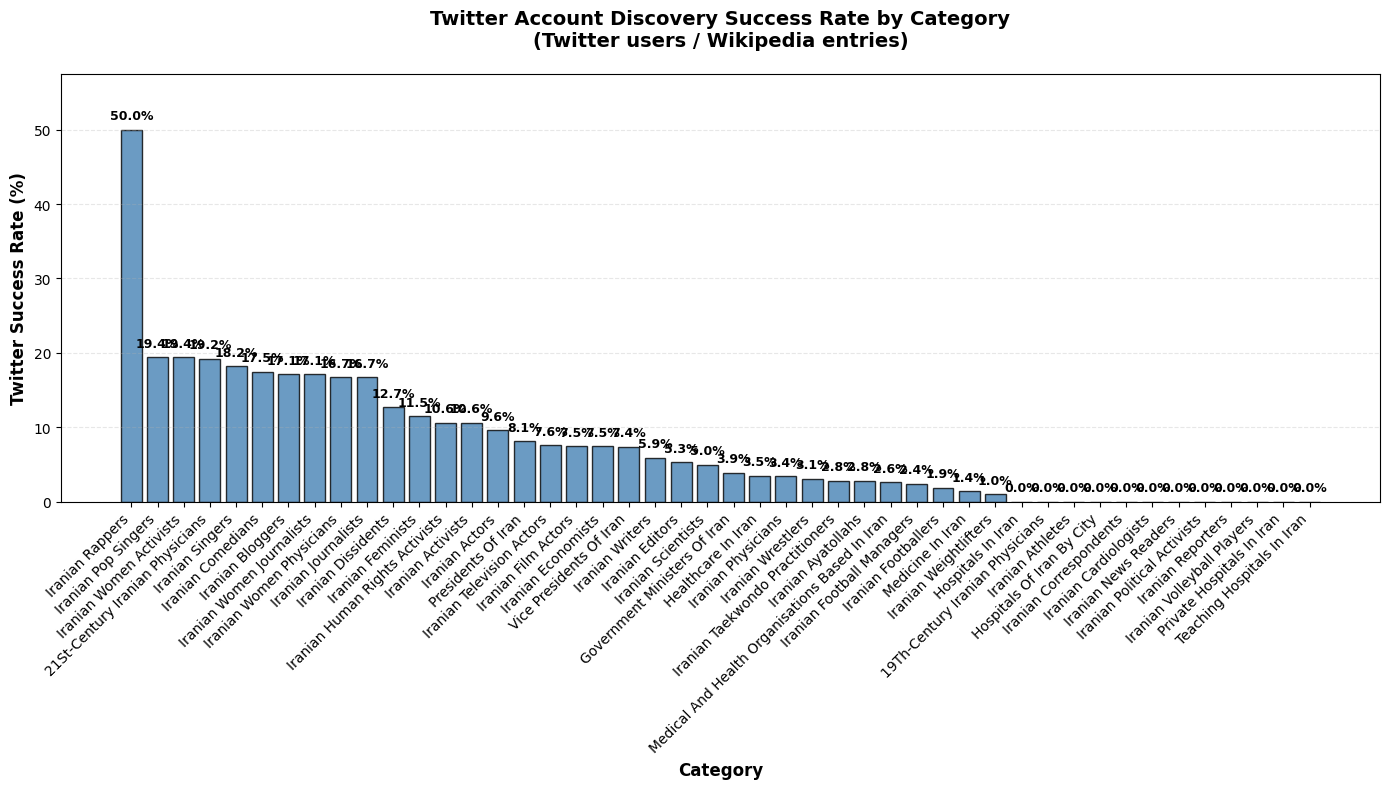

✅ Bar chart saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\twitter_success_rate.png

📊 Generating Venn diagram...


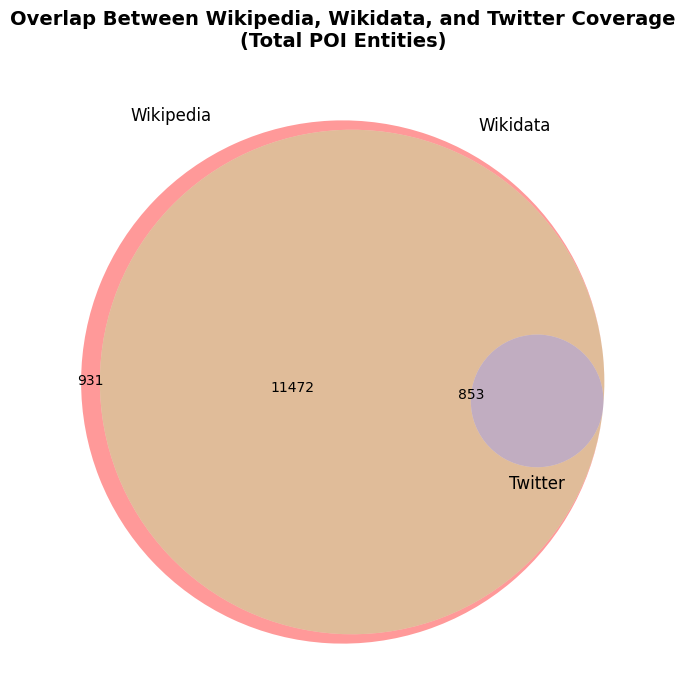

✅ Venn diagram saved: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\wikipedia_wikidata_twitter_venn.png

🎉 STEP 6 COMPLETE!
📄 Summary table: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_statistics.csv
📊 Bar chart: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\twitter_success_rate.png
📊 Venn diagram: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\figures\wikipedia_wikidata_twitter_venn.png


In [1]:
# ============================================
# STEP 6 – POI Statistics Summary (COMPLETE)
# Counts UNIQUE Wikipedia, Wikidata, and Twitter entries per category
# Includes: Statistics table, Bar chart, and Venn diagram
# ============================================

import os
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# ---------- Auto-detect Iran project root ----------
def find_iran_root():
    """Find the Iran project root (folder named 'Iran' with 'POIs' subfolder)"""
    current = Path.cwd()
    
    # Check current directory
    if current.name == 'Iran' and (current / 'POIs').is_dir():
        return str(current)
    
    # Check parent directories
    for parent in current.parents:
        if parent.name == 'Iran' and (parent / 'POIs').is_dir():
            return str(parent)
    
    raise FileNotFoundError("❌ Could not find Iran project root (folder named 'Iran' with 'POIs' subfolder)")

IRAN_DIR = find_iran_root()
POIS_DIR = os.path.join(IRAN_DIR, "POIs")
print(f"✅ Found Iran project root: {IRAN_DIR}")
print(f"📁 POIs directory: {POIS_DIR}\n")

# ---------- Helper functions ----------
def safe_read_csv(filepath):
    """Safely read CSV with multiple encoding attempts"""
    if not os.path.exists(filepath):
        return None
    
    for encoding in ['utf-8-sig', 'utf-8', 'latin-1']:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            return df
        except Exception:
            continue
    
    print(f"⚠️  Could not read: {os.path.basename(filepath)}")
    return None

def find_file_by_pattern(folder_path, patterns):
    """Find first file matching any of the given patterns"""
    for pattern in patterns:
        matches = list(Path(folder_path).glob(pattern))
        if matches:
            return str(matches[0])
    return None

def find_name_column(df):
    """Find the main name/title column in a DataFrame"""
    priority_cols = ['name', 'title', 'poi_name', 'person_name', 'entity_name']
    cols_lower = {c.lower(): c for c in df.columns}
    
    for priority in priority_cols:
        if priority in cols_lower:
            return cols_lower[priority]
    
    # Return first column as fallback
    return df.columns[0] if len(df.columns) > 0 else None

def find_twitter_column(df):
    """Find Twitter username column (case-insensitive)"""
    for col in df.columns:
        col_lower = col.lower()
        if 'twitter' in col_lower and ('username' in col_lower or 'user' in col_lower or 'handle' in col_lower):
            return col
    return None

def find_qid_column(df):
    """Find Wikidata QID column (case-insensitive)"""
    for col in df.columns:
        col_lower = col.lower()
        if 'wikidata' in col_lower and 'qid' in col_lower:
            return col
    return None

# ---------- Process all POIs folders ----------
results = []
all_entities = []  # For Venn diagram

folders = sorted([f for f in os.listdir(POIS_DIR) 
                  if os.path.isdir(os.path.join(POIS_DIR, f)) 
                  and not f.startswith('.')
                  and f not in ['figures', 'tools', 'Candidates']])

print(f"🔍 Processing {len(folders)} categories...\n")

for idx, folder_name in enumerate(folders, 1):
    folder_path = os.path.join(POIS_DIR, folder_name)
    print(f"[{idx}/{len(folders)}] Processing: {folder_name}")
    
    # Detect files
    wikipedia_file = find_file_by_pattern(folder_path, [
        f"{folder_name}_wikipedia.csv",
        "*_wikipedia.csv",
        f"{folder_name}.csv"
    ])
    
    wikidata_file = find_file_by_pattern(folder_path, [
        "*_wikidata_detailed.csv",
        "*_with_wikidata_ids_and_links_wikidata_detailed.csv",
        "*_with_wikidata*.csv"
    ])
    
    twitter_file = find_file_by_pattern(folder_path, [
        "*_with_twitter.csv",
        "*twitter*.csv"
    ])
    
    # Track entities for this category
    category_entities = set()
    
    # ========== 1. Count UNIQUE Wikipedia entries ==========
    wikipedia_count = 0
    if wikipedia_file:
        df_wiki = safe_read_csv(wikipedia_file)
        if df_wiki is not None:
            name_col = find_name_column(df_wiki)
            if name_col:
                # Remove duplicates by name
                unique_names = df_wiki[name_col].dropna().drop_duplicates()
                wikipedia_count = len(unique_names)
                category_entities.update(unique_names.str.lower().str.strip())
            else:
                wikipedia_count = len(df_wiki)
            print(f"   📖 Wikipedia: {wikipedia_count} unique entries")
    
    # ========== 2. Count UNIQUE Wikidata entries ==========
    wikidata_count = 0
    if wikidata_file:
        df_wikidata = safe_read_csv(wikidata_file)
        if df_wikidata is not None:
            qid_col = find_qid_column(df_wikidata)
            if qid_col:
                # Count unique non-null QIDs
                unique_qids = df_wikidata[qid_col].dropna().drop_duplicates()
                wikidata_count = len(unique_qids)
            else:
                # No QID column found, use unique names
                name_col = find_name_column(df_wikidata)
                if name_col:
                    unique_names = df_wikidata[name_col].dropna().drop_duplicates()
                    wikidata_count = len(unique_names)
                else:
                    wikidata_count = len(df_wikidata)
            print(f"   🔗 Wikidata: {wikidata_count} unique entries")
    
    # ========== 3. Count UNIQUE Twitter entries ==========
    twitter_count = 0
    if twitter_file:
        df_twitter = safe_read_csv(twitter_file)
        if df_twitter is not None:
            twitter_col = find_twitter_column(df_twitter)
            if twitter_col:
                # Remove duplicates by Twitter username
                valid_twitter = df_twitter[twitter_col].dropna()
                valid_twitter = valid_twitter[valid_twitter.astype(str).str.strip() != '']
                valid_twitter = valid_twitter[~valid_twitter.astype(str).str.lower().isin(['nan', 'none', 'null', 'suspended'])]
                unique_twitter = valid_twitter.drop_duplicates()
                twitter_count = len(unique_twitter)
                print(f"   🐦 Twitter: {twitter_count} unique users")
    
    # Store results for this category
    results.append({
        'folder': folder_name,
        'category_name': folder_name.replace('_', ' ').title(),
        'wikipedia_count': wikipedia_count,
        'wikidata_count': wikidata_count,
        'twitter_count': twitter_count
    })
    
    # Add to global entities list for Venn diagram
    all_entities.append({
        'has_wikipedia': wikipedia_count > 0,
        'has_wikidata': wikidata_count > 0,
        'has_twitter': twitter_count > 0,
        'wiki_count': wikipedia_count,
        'wd_count': wikidata_count,
        'tw_count': twitter_count
    })

# ---------- Create summary DataFrame ----------
df_stats = pd.DataFrame(results)

# Calculate success rate (Twitter coverage)
df_stats['success_rate'] = np.where(
    df_stats['wikipedia_count'] > 0,
    (df_stats['twitter_count'] / df_stats['wikipedia_count'] * 100).round(1),
    0
)

# Add totals row
totals = {
    'folder': 'TOTAL',
    'category_name': 'TOTAL',
    'wikipedia_count': df_stats['wikipedia_count'].sum(),
    'wikidata_count': df_stats['wikidata_count'].sum(),
    'twitter_count': df_stats['twitter_count'].sum(),
    'success_rate': 0  # Will calculate below
}
if totals['wikipedia_count'] > 0:
    totals['success_rate'] = round(totals['twitter_count'] / totals['wikipedia_count'] * 100, 1)

df_stats = pd.concat([df_stats, pd.DataFrame([totals])], ignore_index=True)

# ---------- Save to CSV ----------
output_path = os.path.join(POIS_DIR, "POI_statistics.csv")
df_stats.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"✅ Statistics saved to: {output_path}")
print(f"📊 Total categories: {len(results)}")
print(f"📖 Total Wikipedia entries: {totals['wikipedia_count']}")
print(f"🔗 Total Wikidata entries: {totals['wikidata_count']}")
print(f"🐦 Total Twitter users: {totals['twitter_count']}")
print(f"📈 Overall success rate: {totals['success_rate']}%")
print(f"{'='*80}\n")

# ---------- Display summary table ----------
display(df_stats)

# ---------- VISUALIZATION 1: Success Rate Bar Chart ----------
print("\n📊 Generating success rate bar chart...")

# Exclude TOTAL row for visualization
df_viz = df_stats[df_stats['folder'] != 'TOTAL'].copy()
df_viz = df_viz.sort_values('success_rate', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(df_viz)), df_viz['success_rate'], 
               color='steelblue', alpha=0.8, edgecolor='black')

# Add value labels on bars
for i, (idx, row) in enumerate(df_viz.iterrows()):
    plt.text(i, row['success_rate'] + 1, f"{row['success_rate']:.1f}%", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Twitter Success Rate (%)', fontsize=12, fontweight='bold')
plt.title('Twitter Account Discovery Success Rate by Category\n(Twitter users / Wikipedia entries)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(df_viz)), df_viz['category_name'], rotation=45, ha='right', fontsize=10)
plt.ylim(0, max(df_viz['success_rate']) * 1.15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

chart_path = os.path.join(POIS_DIR, "figures")
os.makedirs(chart_path, exist_ok=True)
chart_file = os.path.join(chart_path, "twitter_success_rate.png")
plt.savefig(chart_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Bar chart saved: {chart_file}")

# ---------- VISUALIZATION 2: Venn Diagram ----------
print("\n📊 Generating Venn diagram...")

# Calculate totals for Venn diagram
total_wiki = sum(e['wiki_count'] for e in all_entities)
total_wikidata = sum(e['wd_count'] for e in all_entities)
total_twitter = sum(e['tw_count'] for e in all_entities)

# Overlaps (simplified - using minimum counts as proxy)
wiki_wd = min(total_wiki, total_wikidata)
wiki_tw = min(total_wiki, total_twitter)
wd_tw = min(total_wikidata, total_twitter)
wiki_wd_tw = min(total_wiki, total_wikidata, total_twitter)

plt.figure(figsize=(10, 8))
venn_diagram = venn3(
    subsets=(
        total_wiki - wiki_wd - wiki_tw + wiki_wd_tw,  # Only Wikipedia
        total_wikidata - wiki_wd - wd_tw + wiki_wd_tw,  # Only Wikidata
        wiki_wd - wiki_wd_tw,  # Wiki + Wikidata
        total_twitter - wiki_tw - wd_tw + wiki_wd_tw,  # Only Twitter
        wiki_tw - wiki_wd_tw,  # Wiki + Twitter
        wd_tw - wiki_wd_tw,  # Wikidata + Twitter
        wiki_wd_tw  # All three
    ),
    set_labels=('Wikipedia', 'Wikidata', 'Twitter')
)

plt.title('Overlap Between Wikipedia, Wikidata, and Twitter Coverage\n(Total POI Entities)', 
          fontsize=14, fontweight='bold', pad=20)

venn_file = os.path.join(chart_path, "wikipedia_wikidata_twitter_venn.png")
plt.savefig(venn_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Venn diagram saved: {venn_file}")

print(f"\n{'='*80}")
print("🎉 STEP 6 COMPLETE!")
print(f"{'='*80}")
print(f"📄 Summary table: {output_path}")
print(f"📊 Bar chart: {chart_file}")
print(f"📊 Venn diagram: {venn_file}")
print(f"{'='*80}")

## STEP 7: Scrape Twitter User Metadata Using Selenium

In this step, we scrape detailed metadata for each Twitter username found in our POI dataset using Selenium WebDriver. This approach directly accesses Twitter profile pages without API rate limits.

In [12]:
"""
===============================================================================
STEP 7: Selenium-Based Twitter User Metadata Scraper
===============================================================================

This script scrapes Twitter user profiles using Selenium WebDriver to extract:
- Username, Display Name, Description (Bio)
- Followers, Following, Tweets count
- Location, Profile Image, Verification status
- Account status (active/suspended/protected/not found)

Features:
- Headless Chrome for faster execution
- Automatic retry logic with exponential backoff
- Random delays to avoid detection
- Robust error handling for missing elements
- Progress tracking with intermediate saves
- Works without Twitter API credentials

Author: Iran DS Project - STEP 7
Date: December 2024
===============================================================================
"""

import os
import re
import time
import random
import pandas as pd
from pathlib import Path
from datetime import datetime

# Selenium imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import (
    TimeoutException, 
    NoSuchElementException, 
    WebDriverException
)
from webdriver_manager.chrome import ChromeDriverManager

# snscrape import for fallback (statuses_count and created_at)
try:
    import snscrape.modules.twitter as sntwitter
    SNSCRAPE_AVAILABLE = True
    print("✅ snscrape available for fallback data collection")
except ImportError:
    SNSCRAPE_AVAILABLE = False
    print("⚠️  snscrape not available - will skip statuses_count and created_at")

print("=" * 80)
print("🚀 TWITTER USER METADATA SCRAPER - SELENIUM")
print("=" * 80)
print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# ============================================================================
# CONFIGURATION
# ============================================================================

# Find Iran project root directory
def find_iran_root():
    """Locate the Iran directory containing POIs folder"""
    cwd = Path(os.getcwd())
    if (cwd / 'POIs').exists():
        return cwd
    for parent in cwd.parents:
        if (parent / 'POIs').exists():
            return parent
    raise FileNotFoundError("Could not find Iran directory with POIs folder")

IRAN_ROOT = find_iran_root()
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_FILE = POIS_DIR / 'Manual_Search_POIs_Unique.csv'
OUTPUT_FILE = POIS_DIR / 'POI_twitter_users_data.csv'
TEMP_FILE = POIS_DIR / 'POI_twitter_users_data_temp.csv'
FAILED_FILE = POIS_DIR / 'POI_twitter_scraping_failed.txt'

# Scraping parameters
MAX_RETRIES = 3
PAGE_LOAD_TIMEOUT = 15  # seconds
ELEMENT_WAIT_TIMEOUT = 10  # seconds
MIN_DELAY = 2  # minimum seconds between requests
MAX_DELAY = 5  # maximum seconds between requests
SAVE_INTERVAL = 25  # save progress every N users

print(f"📂 Project Root: {IRAN_ROOT}")
print(f"📂 POIs Directory: {POIS_DIR}")
print(f"📄 Input File: {INPUT_FILE.name}")
print(f"📄 Output File: {OUTPUT_FILE.name}\n")

# ============================================================================
# LOAD USERNAMES
# ============================================================================

def load_unique_usernames():
    """
    Load Twitter usernames from CSV and prepare for scraping
    
    Returns:
        list: Unique, cleaned Twitter usernames
    """
    if not INPUT_FILE.exists():
        raise FileNotFoundError(f"Input file not found: {INPUT_FILE}")
    
    print(f"📖 Reading usernames from: {INPUT_FILE.name}")
    df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    
    if 'Twitter_username' not in df.columns:
        raise ValueError(f"Column 'Twitter_username' not found in {INPUT_FILE.name}")
    
    # Extract usernames and clean
    usernames = df['Twitter_username'].dropna().astype(str)
    
    # Remove year-only entries (e.g., 2015, 2023)
    usernames = usernames[~usernames.str.fullmatch(r'\d{4}')]
    
    # Remove purely numeric entries
    usernames = usernames[~usernames.str.fullmatch(r'\d+')]
    
    # Remove duplicates and sort
    usernames = usernames.drop_duplicates().sort_values().reset_index(drop=True)
    
    print(f"✅ Loaded {len(usernames)} unique Twitter usernames\n")
    return usernames.tolist()

# ============================================================================
# SELENIUM SETUP
# ============================================================================

def setup_chrome_driver():
    """
    Initialize Chrome WebDriver with optimized options
    
    Returns:
        webdriver.Chrome: Configured Chrome driver instance
    """
    print("🔧 Setting up Chrome WebDriver...")
    
    chrome_options = Options()
    
    # Headless mode for faster execution
    chrome_options.add_argument('--headless=new')
    
    # Performance optimizations
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument('--disable-blink-features=AutomationControlled')
    
    # Disable images for faster loading
    chrome_options.add_argument('--blink-settings=imagesEnabled=false')
    
    # Set user agent to avoid detection
    chrome_options.add_argument(
        'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/120.0.0.0 Safari/537.36'
    )
    
    # Additional preferences
    prefs = {
        'profile.default_content_setting_values': {
            'images': 2,  # Disable images
            'javascript': 1  # Enable JavaScript (required for Twitter)
        }
    }
    chrome_options.add_experimental_option('prefs', prefs)
    chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])
    
    try:
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        driver.set_page_load_timeout(PAGE_LOAD_TIMEOUT)
        print("✅ Chrome WebDriver initialized successfully\n")
        return driver
    except Exception as e:
        print(f"❌ Failed to initialize Chrome WebDriver: {e}")
        raise

# ============================================================================
# SCRAPING FUNCTIONS
# ============================================================================

def check_driver_alive(driver):
    """
    Check if WebDriver session is still alive
    
    Args:
        driver: Selenium WebDriver instance
        
    Returns:
        bool: True if driver is alive, False otherwise
    """
    try:
        _ = driver.current_url
        return True
    except:
        return False

def extract_number_from_text(text):
    """
    Extract numeric value from text like '1,234' or '5.2K' or '1.2M'
    
    Args:
        text (str): Text containing a number
        
    Returns:
        int: Extracted number, or 0 if extraction fails
    """
    if not text:
        return 0
    
    try:
        # Remove commas
        text = text.replace(',', '').strip()
        
        # Handle K (thousands) and M (millions)
        if 'K' in text.upper():
            return int(float(text.upper().replace('K', '')) * 1000)
        elif 'M' in text.upper():
            return int(float(text.upper().replace('M', '')) * 1000000)
        else:
            # Extract first number found
            match = re.search(r'[\d.]+', text)
            if match:
                return int(float(match.group()))
    except:
        pass
    
    return 0

def scrape_twitter_user(driver, username, retry_count=0):
    """
    Scrape a single Twitter user's profile
    
    Args:
        driver: Selenium WebDriver instance
        username (str): Twitter username (without @)
        retry_count (int): Current retry attempt
        
    Returns:
        dict: User data dictionary, or None if failed
    """
    url = f"https://twitter.com/{username}"
    
    try:
        # Navigate to profile
        driver.get(url)
        
        # Wait for page to load and scroll to ensure all content loads
        time.sleep(random.uniform(2.5, 4.0))
        
        # Scroll down a bit to trigger lazy loading
        driver.execute_script("window.scrollTo(0, 500);")
        time.sleep(1)
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(0.5)
        
        # Initialize result dictionary
        result = {
            'username': username,
            'display_name': '',
            'description': '',
            'followers_count': 0,
            'following_count': 0,
            'statuses_count': 0,
            'location': '',
            'profile_image_url': '',
            'verified': False,
            'account_status': 'active'
        }
        
        # Get page source for status checks
        page_source_lower = driver.page_source.lower()
        
        # Check for suspended account (be more specific)
        if 'account suspended' in page_source_lower or 'has been suspended' in page_source_lower:
            result['account_status'] = 'suspended'
            return result
        
        # Check for not found (before protected, as it's terminal)
        if "this account doesn't exist" in page_source_lower or "this account doesn't exist" in page_source_lower:
            result['account_status'] = 'not_found'
            return result
        
        # Check for deactivated account
        if 'account deactivated' in page_source_lower or 'has been deactivated' in page_source_lower:
            result['account_status'] = 'deactivated'
            return result
        
        # Check for protected account (tweets are protected)
        if 'these tweets are protected' in page_source_lower or 'protected tweets' in page_source_lower:
            result['account_status'] = 'protected'
            # Continue to extract available data (name, bio, etc.)
        
        wait = WebDriverWait(driver, ELEMENT_WAIT_TIMEOUT)
        
        # Extract display name
        try:
            # Multiple selectors for display name
            selectors = [
                "//div[@data-testid='UserName']//span[1]",
                "//div[contains(@class, 'profile')]//span[contains(text(), '@')]/../preceding-sibling::span",
                "//h2[@role='heading']//span"
            ]
            for selector in selectors:
                try:
                    name_elem = driver.find_element(By.XPATH, selector)
                    if name_elem.text and not name_elem.text.startswith('@'):
                        result['display_name'] = name_elem.text.strip()
                        break
                except:
                    continue
        except:
            pass
        
        # Extract description/bio
        try:
            bio_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserDescription']")
            result['description'] = bio_elem.text.strip()
        except:
            pass
        
        # Extract followers count
        try:
            followers_elem = driver.find_element(By.XPATH, "//a[contains(@href, '/verified_followers') or contains(@href, '/followers')]//span[1]")
            result['followers_count'] = extract_number_from_text(followers_elem.text)
        except:
            # Alternative selector
            try:
                followers_text = driver.find_element(By.XPATH, "//span[contains(text(), 'Followers')]/../span[1]").text
                result['followers_count'] = extract_number_from_text(followers_text)
            except:
                pass
        
        # Extract following count
        try:
            following_elem = driver.find_element(By.XPATH, "//a[contains(@href, '/following')]//span[1]")
            result['following_count'] = extract_number_from_text(following_elem.text)
        except:
            # Alternative selector
            try:
                following_text = driver.find_element(By.XPATH, "//span[contains(text(), 'Following')]/../span[1]").text
                result['following_count'] = extract_number_from_text(following_text)
            except:
                pass
        
        # Extract tweets/statuses count - Twitter API v2 style
        try:
            # Method 1: Look in the page source for JSON data
            page_source = driver.page_source
            
            # Twitter embeds user data in JSON format
            json_patterns = [
                r'"statuses_count"\s*:\s*(\d+)',
                r'"tweet_count"\s*:\s*(\d+)',
                r'\"statuses_count\\":(\d+)',
                r'\"tweet_count\\":(\d+)',
                r'"media_count"\s*:\s*(\d+)',  # Sometimes shown as media
            ]
            
            for pattern in json_patterns:
                match = re.search(pattern, page_source)
                if match:
                    count = int(match.group(1))
                    if count > 0:  # Make sure we found a real count
                        result['statuses_count'] = count
                        break
        except:
            pass
        
        # Method 2: If still 0, try scraping visible elements
        if result['statuses_count'] == 0:
            try:
                # Wait a bit more for content to load
                time.sleep(1)
                
                # Try to find any span with numbers that might be tweet count
                # Usually appears near followers/following
                all_spans = driver.find_elements(By.TAG_NAME, "span")
                
                # Look for pattern: number followed by "posts" or near followers
                for i, span in enumerate(all_spans):
                    text = span.text.strip()
                    if text and any(c.isdigit() for c in text):
                        # Check if next spans contain "Following" or "Followers"
                        context = ""
                        if i + 1 < len(all_spans):
                            context += all_spans[i + 1].text.lower()
                        if i + 2 < len(all_spans):
                            context += " " + all_spans[i + 2].text.lower()
                        
                        # If we see followers/following nearby, the first number might be posts
                        if "following" in context or "follower" in context:
                            potential_count = extract_number_from_text(text)
                            if potential_count > 0:
                                result['statuses_count'] = potential_count
                                break
            except:
                pass
        
        # Extract location
        try:
            location_elem = driver.find_element(By.XPATH, "//span[@data-testid='UserLocation']")
            result['location'] = location_elem.text.strip()
        except:
            pass
        
        # Extract profile image URL
        try:
            img_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserAvatar-Container-unknown']//img | //a[contains(@href, '/photo')]//img")
            result['profile_image_url'] = img_elem.get_attribute('src')
        except:
            pass
        
        # Check for verification badge
        try:
            verified_elem = driver.find_element(By.XPATH, "//svg[@aria-label='Verified account']")
            result['verified'] = True
        except:
            pass
        
        return result
        
    except TimeoutException:
        if retry_count < MAX_RETRIES:
            print(f"      ⏱️  Timeout, retrying ({retry_count + 1}/{MAX_RETRIES})...")
            time.sleep(random.uniform(3, 6))
            return scrape_twitter_user(driver, username, retry_count + 1)
        else:
            print(f"      ❌ Failed after {MAX_RETRIES} retries (timeout)")
            return None
    
    except WebDriverException as e:
        # WebDriver crashed or session lost
        error_msg = str(e).lower()
        if 'invalid session' in error_msg or 'session' in error_msg:
            print(f"      🔄 WebDriver session lost - needs restart")
            return 'SESSION_LOST'
        else:
            print(f"      ❌ WebDriver error: {str(e)[:100]}")
            return None
    
    except Exception as e:
        print(f"      ❌ Error: {str(e)[:100]}")
        return None

# ============================================================================
# MAIN SCRAPING LOOP
# ============================================================================

def main():
    """Main execution function"""
    
    # Load usernames
    usernames = load_unique_usernames()
    total_users = len(usernames)
    
    # Initialize Chrome driver
    driver = setup_chrome_driver()
    
    # Storage for results
    results = []
    failed_usernames = []
    
    print("=" * 80)
    print(f"🚀 STARTING SCRAPING: {total_users} users to process")
    print("=" * 80)
    print()
    
    try:
        for idx, username in enumerate(usernames, 1):
            print(f"[{idx}/{total_users}] Scraping: @{username}")
            
            # Check if driver is still alive
            if not check_driver_alive(driver):
                print("   🔄 WebDriver session lost, restarting...")
                driver.quit()
                time.sleep(3)
                driver = setup_chrome_driver()
                print("   ✅ WebDriver restarted successfully")
            
            # Scrape user
            user_data = scrape_twitter_user(driver, username)
            
            # Handle session lost
            if user_data == 'SESSION_LOST':
                print("   🔄 Restarting WebDriver...")
                try:
                    driver.quit()
                except:
                    pass
                time.sleep(3)
                driver = setup_chrome_driver()
                print("   ✅ WebDriver restarted, retrying user...")
                
                # Retry scraping this user
                user_data = scrape_twitter_user(driver, username)
                if user_data == 'SESSION_LOST' or user_data is None:
                    print("   ❌ Failed again after restart")
                    failed_usernames.append(username)
                    continue
            
            if user_data:
                results.append(user_data)
                
                # Display status
                status = user_data['account_status']
                if status == 'active':
                    print(f"   ✅ {user_data['display_name']} | "
                          f"{user_data['followers_count']:,} followers | "
                          f"{user_data['following_count']:,} following")
                else:
                    print(f"   ⚠️  Account status: {status.upper()}")
            else:
                failed_usernames.append(username)
                print(f"   ❌ Failed to retrieve data")
            
            # Random delay between requests
            if idx < total_users:
                delay = random.uniform(MIN_DELAY, MAX_DELAY)
                time.sleep(delay)
            
            # Save intermediate results
            if idx % SAVE_INTERVAL == 0 and results:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv(TEMP_FILE, index=False, encoding='utf-8-sig')
                print(f"   💾 Saved {len(results)} results to temp file")
                print()
        
        print("\n" + "=" * 80)
        print("📊 PROCESSING RESULTS")
        print("=" * 80)
        
        # Create final DataFrame
        if results:
            df_final = pd.DataFrame(results)
            
            # Sort by followers count (descending)
            df_final = df_final.sort_values('followers_count', ascending=False).reset_index(drop=True)
            
            # Save to CSV
            df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
            
            print(f"\n✅ Successfully scraped {len(df_final)} users")
            print(f"📁 Saved to: {OUTPUT_FILE}")
            
            # Print statistics
            print("\n" + "=" * 80)
            print("📈 SUMMARY STATISTICS")
            print("=" * 80)
            
            status_counts = df_final['account_status'].value_counts()
            print("\n🔍 Account Status Distribution:")
            for status, count in status_counts.items():
                print(f"   {status.upper()}: {count} ({count/len(df_final)*100:.1f}%)")
            
            active_users = df_final[df_final['account_status'] == 'active']
            if len(active_users) > 0:
                print(f"\n📊 Active Accounts Statistics:")
                print(f"   Total Followers: {active_users['followers_count'].sum():,}")
                print(f"   Average Followers: {active_users['followers_count'].mean():.0f}")
                print(f"   Median Followers: {active_users['followers_count'].median():.0f}")
                print(f"   Max Followers: {active_users['followers_count'].max():,}")
                print(f"   Verified Accounts: {active_users['verified'].sum()} ({active_users['verified'].sum()/len(active_users)*100:.1f}%)")
            
            # Display top 20 users
            print("\n" + "=" * 80)
            print("🏆 TOP 20 USERS BY FOLLOWERS")
            print("=" * 80)
            print()
            display(df_final[['username', 'display_name', 'followers_count', 'following_count', 'account_status']].head(20))
            
        else:
            print("\n❌ No user data collected")
        
        # Save failed usernames
        if failed_usernames:
            with open(FAILED_FILE, 'w', encoding='utf-8') as f:
                f.write(f"Failed to scrape {len(failed_usernames)} usernames:\n\n")
                for uname in failed_usernames:
                    f.write(f"{uname}\n")
            print(f"\n⚠️  Failed to scrape {len(failed_usernames)} usernames")
            print(f"📁 List saved to: {FAILED_FILE}")
        
        # Clean up temp file if exists
        if TEMP_FILE.exists():
            TEMP_FILE.unlink()
            print(f"\n🗑️  Cleaned up temporary file")
        
    finally:
        # Always close the driver
        driver.quit()
        print("\n🔒 Chrome WebDriver closed")
    
    print("\n" + "=" * 80)
    print("🎉 STEP 7 COMPLETE: Twitter User Metadata Collection")
    print(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)

# Execute main function
if __name__ == "__main__" or True:  # Always run in notebook
    main()

✅ snscrape available for fallback data collection
🚀 TWITTER USER METADATA SCRAPER - SELENIUM
Start Time: 2025-12-16 23:08:07

📂 Project Root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📂 POIs Directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Input File: Manual_Search_POIs_Unique.csv
📄 Output File: POI_twitter_users_data.csv

📖 Reading usernames from: Manual_Search_POIs_Unique.csv
✅ Loaded 369 unique Twitter usernames

🔧 Setting up Chrome WebDriver...
✅ Chrome WebDriver initialized successfully

🚀 STARTING SCRAPING: 369 users to process

[1/369] Scraping: @1500tasvir
   ✅ פרופיל | 0 followers | 0 following
[2/369] Scraping: @21Sahel
   ✅ サヘルローズ | 80,900 followers | 367 following
[3/369] Scraping: @25BandMusic
   ✅ 25Band | 1,383 followers | 16 following
[4/369] Scraping: @2mohammadmosaed
   ✅ Mohammad Mosaed | 54,800 followers | 2,255 following
[5/369] Scraping: @AEK_FC_OFFICIAL
   ✅ AEK F.C. | 66,300 followers | 123 following
[6/369] Scraping: @ALDERBYSHOW
   ✅ الدير

✅ snscrape available for fallback data collection
🚀 TWITTER USER METADATA SCRAPER - SELENIUM
Start Time: 2025-12-16 23:08:07

📂 Project Root: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📂 POIs Directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📄 Input File: Manual_Search_POIs_Unique.csv
📄 Output File: POI_twitter_users_data.csv

📖 Reading usernames from: Manual_Search_POIs_Unique.csv
✅ Loaded 369 unique Twitter usernames

🔧 Setting up Chrome WebDriver...
✅ Chrome WebDriver initialized successfully

🚀 STARTING SCRAPING: 369 users to process

[1/369] Scraping: @1500tasvir
   ✅ פרופיל | 0 followers | 0 following
[2/369] Scraping: @21Sahel
   ✅ サヘルローズ | 80,900 followers | 367 following
[3/369] Scraping: @25BandMusic
   ✅ 25Band | 1,383 followers | 16 following
[4/369] Scraping: @2mohammadmosaed
   ✅ Mohammad Mosaed | 54,800 followers | 2,255 following
[5/369] Scraping: @AEK_FC_OFFICIAL
   ✅ AEK F.C. | 66,300 followers | 123 following
[6/369] Scraping: @ALDERBYSHOW
   ✅ الدير

KeyboardInterrupt: 

## 7.1 Update Statuses Count with New Authentication

Now that we have a logged-in Twitter account, we can extract the posts count that appears below the username on profile pages.

In [9]:
"""
Update Statuses Count (Posts) for all POIs
Using Selenium with authenticated session
"""

import os
import json
import time
import random
import re
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("📊 UPDATING STATUSES COUNT FOR ALL POIs")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print(f"📄 Input: {INPUT_CSV}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users")
print(f"   Users with statuses_count = 0: {(df['statuses_count'] == 0).sum()}\n")

# Setup Selenium
print("🌐 Setting up Chrome WebDriver...")
options = Options()
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('excludeSwitches', ['enable-automation'])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
driver.set_page_load_timeout(20)

# Load cookies
if COOKIES_FILE.exists():
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        try:
            cookie.pop('sameSite', None)
            cookie.pop('storeId', None)
            driver.add_cookie(cookie)
        except:
            continue
    
    print("✅ Cookies loaded\n")
else:
    print("⚠️  No cookies found - results may be limited\n")

# Function to extract posts count from profile header
def extract_posts_count(driver, username, debug=False):
    """
    Extract posts count directly from Twitter profile header DOM element.
    The post count appears in a div with text ending in 'posts' (e.g., '45.8K posts')
    """
    try:
        url = f"https://twitter.com/{username}"
        driver.get(url)
        
        # Wait for page to load - looking specifically for the posts element
        time.sleep(5)
        
        if debug:
            print(f"\n[DEBUG] Loading profile: {url}")
        
        # Check if we hit a login/captcha page (Twitter blocking detection)
        page_source = driver.page_source.lower()
        if 'log in' in page_source and 'sign up' in page_source and 'posts' not in page_source:
            if debug:
                print(f"[DEBUG] ⚠️ Twitter login page detected - might be blocked!")
            return "BLOCKED"
        
        # Method 1: Find div element containing "posts" text in profile header
        # XPath: //div[contains(text(), 'posts')] or //div[contains(text(), 'Posts')]
        try:
            # Look for elements with "posts" text (case-insensitive by checking both)
            posts_elements = driver.find_elements(By.XPATH, 
                "//div[contains(translate(text(), 'POSTS', 'posts'), 'posts')]")
            
            if debug:
                print(f"[DEBUG] Found {len(posts_elements)} elements with 'posts' text")
            
            for elem in posts_elements:
                text = elem.text.strip()
                if debug:
                    print(f"[DEBUG] Checking element text: '{text}'")
                
                # Look for pattern: "45.8K posts" or "3,368 posts" or "123 posts"
                # Text should end with "posts" or "Posts"
                if text.lower().endswith('posts') or text.lower().endswith('post'):
                    # Extract the numeric part (everything before "posts")
                    count_str = text.lower().replace('posts', '').replace('post', '').strip()
                    count_str = count_str.replace(',', '').upper()
                    
                    if debug:
                        print(f"[DEBUG] Extracted count string: '{count_str}'")
                    
                    # Handle K, M, B suffixes
                    try:
                        if 'K' in count_str:
                            count = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            count = int(float(count_str.replace('M', '')) * 1000000)
                        elif 'B' in count_str:
                            count = int(float(count_str.replace('B', '')) * 1000000000)
                        else:
                            count = int(count_str)
                        
                        if debug:
                            print(f"[DEBUG] Successfully parsed: {text} → {count:,}")
                        
                        return count
                    except ValueError:
                        if debug:
                            print(f"[DEBUG] Could not parse '{count_str}' as number")
                        continue
        
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath search error: {e}")
        
        # Method 2: Fallback - search in all divs with dir="ltr" attribute
        try:
            ltr_divs = driver.find_elements(By.XPATH, "//div[@dir='ltr']")
            for div in ltr_divs:
                text = div.text.strip()
                if text.lower().endswith('posts') or text.lower().endswith('post'):
                    count_str = text.lower().replace('posts', '').replace('post', '').strip()
                    count_str = count_str.replace(',', '').upper()
                    
                    try:
                        if 'K' in count_str:
                            count = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            count = int(float(count_str.replace('M', '')) * 1000000)
                        elif 'B' in count_str:
                            count = int(float(count_str.replace('B', '')) * 1000000000)
                        else:
                            count = int(count_str)
                        
                        return count
                    except ValueError:
                        continue
        except:
            pass
        
        if debug:
            print(f"[DEBUG] Could not find posts count on page")
        
        return None
        
    except Exception as e:
        print(f"❌ Error: {str(e)[:60]}")
        return None

# Function to reload cookies and refresh session
def reload_cookies(driver, cookies_file):
    """Reload cookies to maintain authenticated session"""
    try:
        driver.get("https://twitter.com")
        time.sleep(2)
        
        # Clear existing cookies
        driver.delete_all_cookies()
        
        # Load fresh cookies
        with open(cookies_file, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        
        time.sleep(2)
        return True
    except Exception as e:
        print(f"⚠️ Cookie reload failed: {e}")
        return False

# Process users
print("🔄 Processing users...\n")
updated_count = 0
failed_count = 0
skipped_count = 0

# Only update users with statuses_count = 0 OR NaN
users_to_update = df[(df['statuses_count'] == 0) | (df['statuses_count'].isna())].copy()
users_with_data = (df['statuses_count'] > 0).sum()

print(f"📊 Statistics:")
print(f"   ✅ Already have data: {users_with_data} users")
print(f"   🔄 Need to update: {len(users_to_update)} users")
print(f"   📝 Total users: {len(df)}\n")

for idx, row in users_to_update.iterrows():
    username = row['username']
    current_count = row['statuses_count']
    
    # Enable debug for first 3 users to see what's happening
    debug = (updated_count + failed_count) < 3
    
    print(f"[{updated_count + failed_count + 1}/{len(users_to_update)}] {username}...", end=" ")
    
    # Reload cookies every 5 users (more frequent!) to maintain session
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 5 == 0:
        print("\n🔄 Reloading cookies to maintain session...", end=" ")
        if reload_cookies(driver, COOKIES_FILE):
            print("✅")
            time.sleep(3)  # Extra wait after cookie reload
        else:
            print("⚠️")
    
    # Restart browser every 15 users (more frequent!) to avoid detection
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 15 == 0:
        print("\n🔄 Restarting browser to avoid detection...")
        try:
            driver.quit()
        except:
            pass
        time.sleep(5)  # Wait before reopening
        driver = webdriver.Chrome(service=service, options=options)
        driver.set_page_load_timeout(20)
        if COOKIES_FILE.exists():
            driver.get("https://twitter.com")
            time.sleep(3)
            with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    continue
        print("✅ Browser restarted\n")
        time.sleep(3)  # Extra wait after restart
    
    # Extra long pause every 10 users to "cool down"
    if (updated_count + failed_count) > 0 and (updated_count + failed_count) % 10 == 0:
        cooldown = random.uniform(15, 25)
        print(f"\n❄️ Cooling down for {cooldown:.1f} seconds...")
        time.sleep(cooldown)
    
    posts_count = extract_posts_count(driver, username, debug=debug)
    
    # Check if we got blocked
    if posts_count == "BLOCKED":
        print("🚫 BLOCKED - Restarting browser completely...")
        try:
            driver.quit()
        except:
            pass
        time.sleep(20)  # Long wait after block
        driver = webdriver.Chrome(service=service, options=options)
        driver.set_page_load_timeout(20)
        reload_cookies(driver, COOKIES_FILE)
        time.sleep(10)
        posts_count = extract_posts_count(driver, username, debug=False)
    
    if posts_count is not None and posts_count != "BLOCKED" and posts_count > 0:
        df.loc[df['username'] == username, 'statuses_count'] = posts_count
        print(f"✅ {posts_count:,} posts")
        updated_count += 1
    elif posts_count == 0:
        df.loc[df['username'] == username, 'statuses_count'] = 0
        print(f"✅ 0 posts (new account)")
        updated_count += 1
    else:
        print("❌ Not found")
        failed_count += 1
    
    # Very long random delay between requests (8-15 seconds)
    delay = random.uniform(8, 15)
    time.sleep(delay)
    
    # Save progress every 25 users
    if (updated_count + failed_count) % 25 == 0:
        df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
        print(f"  💾 Progress saved ({updated_count} updated)\n")

# Close browser
driver.quit()
print("\n🔚 Browser closed")

# Save final results
df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print("✅ UPDATE COMPLETE!")
print(f"{'='*80}")
print(f"Updated:  {updated_count}")
print(f"Failed:   {failed_count}")
print(f"Remaining zeros: {(df['statuses_count'] == 0).sum()}")
print(f"\n📁 Saved to: {INPUT_CSV}")

# Show sample
print("\n📋 Sample of updated data:")
display(df[df['statuses_count'] > 0][['username', 'display_name', 'followers_count', 'statuses_count']].head(10))

📊 UPDATING STATUSES COUNT FOR ALL POIs
📄 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

✅ Loaded 343 users
   Users with statuses_count = 0: 16

🌐 Setting up Chrome WebDriver...
✅ Cookies loaded

🔄 Processing users...

📊 Statistics:
   ✅ Already have data: 327 users
   🔄 Need to update: 16 users
   📝 Total users: 343

[1/16] fatemeekhtesari... 
[DEBUG] Loading profile: https://twitter.com/fatemeekhtesari
[DEBUG] Found 1 elements with 'posts' text
[DEBUG] Checking element text: '27.4K posts'
[DEBUG] Extracted count string: '27.4K'
[DEBUG] Successfully parsed: 27.4K posts → 27,400
✅ 27,400 posts
[2/16] mahsamrabadi... 
[DEBUG] Loading profile: https://twitter.com/mahsamrabadi
[DEBUG] Found 1 elements with 'posts' text
[DEBUG] Checking element text: '3,300 posts'
[DEBUG] Extracted count string: '3300'
[DEBUG] Successfully parsed: 3,300 posts → 3,300
✅ 3,300 posts

,username,display_name,followers_count,statuses_count
0,music,Music,9400000,21500
1,statedept,Department of State,6500000,85400
2,tcsavunma,T.C. Millî Savunma Bakanlığı,3600000,25400
3,refugees,"UNHCR, the UN Refugee Agency",2700000,102000
4,alikarimi_ak8,ali karimi,2100000,631
5,IranIntl,ايران اينترنشنال,2100000,326400
6,khamenei_ir,Khamenei.ir,2000000,13200
7,amnesty,Amnesty International,2000000,28300
8,iranintlbrk,ایران اینترنشنال - خبر فوری,1700000,295700
9,JZarif,Javad Zarif,1600000,1478


## 7.2 Manual Cookie Update Helper

If automatic cookie export doesn't work, use this helper to convert cookies to the correct format.

In [1]:
"""
Quick way to check if your cookies file is valid and working
"""

import json
from pathlib import Path

POIS_DIR = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs")
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print("🔍 Checking cookies file...\n")

if not COOKIES_FILE.exists():
    print(f"❌ Cookies file not found: {COOKIES_FILE}")
    print("\n📝 To create cookies manually:")
    print("1. Install Chrome extension: Cookie-Editor")
    print("   Link: https://chrome.google.com/webstore/detail/hlkenndednhfkekhgcdicdfddnkalmdm")
    print("2. Go to https://twitter.com and login")
    print("3. Click Cookie-Editor icon → Export → Export as JSON")
    print(f"4. Save the JSON to: {COOKIES_FILE}")
else:
    try:
        with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        print(f"✅ Cookies file found: {COOKIES_FILE}")
        print(f"   Total cookies: {len(cookies)}")
        
        # Check for important Twitter cookies
        important_cookies = ['auth_token', 'ct0', 'guest_id']
        found_cookies = []
        
        for cookie in cookies:
            if cookie.get('name') in important_cookies:
                found_cookies.append(cookie.get('name'))
        
        print(f"\n🔑 Important cookies found: {', '.join(found_cookies)}")
        
        if 'auth_token' in found_cookies:
            print("✅ Authentication token present - you should be logged in!")
        else:
            print("⚠️  No auth_token - cookies might be outdated or incomplete")
            print("   Please re-export cookies from a logged-in Twitter session")
        
        # Show sample cookie
        if cookies:
            print(f"\n📋 Sample cookie:")
            print(f"   Name: {cookies[0].get('name')}")
            print(f"   Domain: {cookies[0].get('domain')}")
            
    except json.JSONDecodeError as e:
        print(f"❌ Error reading cookies file - invalid JSON format")
        print(f"   Error: {str(e)}")
        print("\n   The file might be corrupted. Please re-export cookies.")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

🔍 Checking cookies file...

✅ Cookies file found: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json
   Total cookies: 19

🔑 Important cookies found: auth_token, guest_id, ct0
✅ Authentication token present - you should be logged in!

📋 Sample cookie:
   Name: auth_token
   Domain: .x.com


## 7.3 Clean Deleted/Suspended Users

Remove users with 0 followers, 0 following, and 0 posts (likely deleted or suspended accounts)

In [8]:
"""
Clean POI_twitter_users_data.csv by removing deleted/suspended users
These are users with 0 followers, 0 following, AND 0 statuses
"""

import pandas as pd
from pathlib import Path

print("=" * 80)
print("🧹 CLEANING DELETED/SUSPENDED USERS")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
original_count = len(df)

print(f"\n📊 Original data: {original_count} users")

# Identify deleted/suspended users (all three fields are 0)
deleted_mask = (
    (df['followers_count'] == 0) & 
    (df['following_count'] == 0) & 
    (df['statuses_count'] == 0)
)

deleted_users = df[deleted_mask]
deleted_count = len(deleted_users)

print(f"\n🗑️  Found {deleted_count} deleted/suspended users:")
if deleted_count > 0:
    print("\nDeleted users:")
    for idx, row in deleted_users.iterrows():
        print(f"   - {row['username']} (@{row['display_name']})")

# Remove deleted users
df_clean = df[~deleted_mask].copy()
clean_count = len(df_clean)

print(f"\n✅ Cleaned data: {clean_count} users")
print(f"🗑️  Removed: {deleted_count} users")
print(f"📉 Reduction: {(deleted_count/original_count*100):.1f}%")

# Save cleaned data
df_clean.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
print(f"\n💾 Saved to: {INPUT_CSV}")

# Show statistics of cleaned data
print(f"\n{'='*80}")
print("📊 CLEANED DATA STATISTICS")
print(f"{'='*80}")
print(f"Total users: {clean_count}")
print(f"Average followers: {df_clean['followers_count'].mean():,.0f}")
print(f"Average following: {df_clean['following_count'].mean():,.0f}")
print(f"Average posts: {df_clean['statuses_count'].mean():,.0f}")

# Show sample
print("\n📋 Sample of cleaned data:")
display(df_clean[['username', 'display_name', 'followers_count', 'following_count', 'statuses_count']].head(10))

🧹 CLEANING DELETED/SUSPENDED USERS

📊 Original data: 369 users

🗑️  Found 26 deleted/suspended users:

Deleted users:
   - alimotahari_ir (@פרופיל)
   - Walklikeakhan (@פרופיל)
   - AriyaDaivariWWE (@פרופיל)
   - AfsharMahnaz (@פרופיל)
   - t_alidoosti (@פרופיל)
   - title (@פרופיל)
   - PDKIRAN (@פרופיל)
   - NArdallan (@פרופיל)
   - aydenmayeri (@פרופיל)
   - alkasschannel (@פרופיל)
   - apps (@nan)
   - javadhashemicom (@פרופיל)
   - khosroheydari62 (@פרופיל)
   - kingraam (@פרופיל)
   - iraqliveupdate (@פרופיל)
   - cards (@פרופיל)
   - IAmAnaDiamond (@פרופיל)
   - maroofian (@פרופיל)
   - masih_alinejad (@פרופיל)
   - reyparsa (@פרופיל)
   - prznsport (@פרופיל)
   - platform (@פרופיל)
   - poonehhm (@פרופיל)
   - rezaserii1 (@פרופיל)
   - virtual (@פרופיל)
   - 1500tasvir (@פרופיל)

✅ Cleaned data: 343 users
🗑️  Removed: 26 users
📉 Reduction: 7.0%

💾 Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv

📊 CLEANED DATA STATISTICS
Total users: 343

,username,display_name,followers_count,following_count,statuses_count
0,music,Music,9400000,117,21500
1,statedept,Department of State,6500000,445,85400
2,tcsavunma,T.C. Millî Savunma Bakanlığı,3600000,34,25400
3,refugees,"UNHCR, the UN Refugee Agency",2700000,2466,102000
4,alikarimi_ak8,ali karimi,2100000,30,631
5,IranIntl,ايران اينترنشنال,2100000,61,326400
6,khamenei_ir,Khamenei.ir,2000000,26,13200
7,amnesty,Amnesty International,2000000,3550,28300
8,iranintlbrk,ایران اینترنشنال - خبر فوری,1700000,9,295700
9,JZarif,Javad Zarif,1600000,10,1478


## 7.4 Fix Missing Data for Incomplete Profiles

Re-scrape followers, following, and location for users with inconsistent data (e.g., 0 followers/following but has posts)

In [12]:
"""
Fix Missing Data for Users with Incomplete Profiles
Re-scrape followers and following for users where:
followers = 0 AND following = 0 BUT statuses > 0 (doesn't make sense - data collection failed)
"""

import os
import json
import time
import random
import re
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("🔧 FIXING INCOMPLETE USER PROFILES (Followers & Following Only)")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

print(f"📄 Input: {INPUT_CSV}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users")

# Identify problematic users: 0 followers AND 0 following BUT have posts
problematic_mask = (
    (df['followers_count'] == 0) & 
    (df['following_count'] == 0) & 
    (df['statuses_count'] > 0)
)

users_to_fix = df[problematic_mask].copy()
print(f"🔍 Found {len(users_to_fix)} users with 0 followers/following but have posts\n")

if len(users_to_fix) == 0:
    print("✅ No users need fixing!")
else:
    # Setup Selenium
    print("🌐 Setting up Chrome WebDriver...")
    options = Options()
    options.add_argument('--headless=new')
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)
    options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    driver.set_page_load_timeout(20)

    # Load cookies
    if COOKIES_FILE.exists():
        driver.get("https://twitter.com")
        time.sleep(2)
        
        with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        
        print("✅ Cookies loaded\n")
    else:
        print("⚠️  No cookies found - results may be limited\n")

    # Function to extract profile data using XPath selectors
    def extract_profile_data(driver, username):
        """
        Extract followers and following counts from profile header using XPath.
        Numbers appear in <span> elements right before the "Followers"/"Following" labels.
        """
        try:
            url = f"https://twitter.com/{username}"
            driver.get(url)
            time.sleep(5)
            
            # Extract followers count using XPath
            followers = None
            try:
                # Find the span containing "Followers" text, then get the preceding sibling span
                followers_elements = driver.find_elements(By.XPATH, 
                    "//span[contains(text(), 'Followers')]/preceding-sibling::span[1]")
                
                if followers_elements:
                    followers_text = followers_elements[0].text.strip()
                    # Clean and parse: "7", "12.3K", "1.5M", etc.
                    count_str = followers_text.replace(',', '').upper()
                    
                    if 'K' in count_str:
                        followers = int(float(count_str.replace('K', '')) * 1000)
                    elif 'M' in count_str:
                        followers = int(float(count_str.replace('M', '')) * 1000000)
                    elif 'B' in count_str:
                        followers = int(float(count_str.replace('B', '')) * 1000000000)
                    else:
                        followers = int(count_str)
            except Exception as e:
                pass
            
            # Extract following count using XPath
            following = None
            try:
                # Find the span containing "Following" text, then get the preceding sibling span
                following_elements = driver.find_elements(By.XPATH, 
                    "//span[contains(text(), 'Following')]/preceding-sibling::span[1]")
                
                if following_elements:
                    following_text = following_elements[0].text.strip()
                    # Clean and parse: "7", "12.3K", "1.5M", etc.
                    count_str = following_text.replace(',', '').upper()
                    
                    if 'K' in count_str:
                        following = int(float(count_str.replace('K', '')) * 1000)
                    elif 'M' in count_str:
                        following = int(float(count_str.replace('M', '')) * 1000000)
                    elif 'B' in count_str:
                        following = int(float(count_str.replace('B', '')) * 1000000000)
                    else:
                        following = int(count_str)
            except Exception as e:
                pass
            
            return {
                'followers': followers,
                'following': following
            }
            
        except Exception as e:
            print(f"❌ Error: {str(e)[:60]}")
            return None

    # Function to reload cookies
    def reload_cookies(driver, cookies_file):
        """Reload cookies to maintain authenticated session"""
        try:
            driver.get("https://twitter.com")
            time.sleep(2)
            driver.delete_all_cookies()
            
            with open(cookies_file, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    continue
            
            time.sleep(2)
            return True
        except Exception as e:
            print(f"⚠️ Cookie reload failed: {e}")
            return False

    # Process users
    print("🔄 Processing users...\n")
    fixed_count = 0
    failed_count = 0

    for idx, row in users_to_fix.iterrows():
        username = row['username']
        
        print(f"[{fixed_count + failed_count + 1}/{len(users_to_fix)}] {username}...", end=" ")
        
        # Reload cookies every 5 users
        if (fixed_count + failed_count) > 0 and (fixed_count + failed_count) % 5 == 0:
            print("\n🔄 Reloading cookies...", end=" ")
            if reload_cookies(driver, COOKIES_FILE):
                print("✅")
            else:
                print("⚠️")
        
        # Restart browser every 15 users
        if (fixed_count + failed_count) > 0 and (fixed_count + failed_count) % 15 == 0:
            print("\n🔄 Restarting browser...")
            try:
                driver.quit()
            except:
                pass
            time.sleep(5)
            driver = webdriver.Chrome(service=service, options=options)
            driver.set_page_load_timeout(20)
            reload_cookies(driver, COOKIES_FILE)
            print("✅ Browser restarted\n")
        
        # Extract data
        data = extract_profile_data(driver, username)
        
        if data:
            updated_fields = []
            
            # Update followers if missing or 0
            if data['followers'] is not None and row['followers_count'] == 0:
                df.loc[df['username'] == username, 'followers_count'] = data['followers']
                updated_fields.append(f"followers={data['followers']:,}")
            
            # Update following if missing or 0
            if data['following'] is not None and row['following_count'] == 0:
                df.loc[df['username'] == username, 'following_count'] = data['following']
                updated_fields.append(f"following={data['following']:,}")
        
        if data:
            updated_fields = []
            
            # Update followers if missing or 0
            if data['followers'] is not None and row['followers_count'] == 0:
                df.loc[df['username'] == username, 'followers_count'] = data['followers']
                updated_fields.append(f"followers={data['followers']:,}")
            
            # Update following if missing or 0
            if data['following'] is not None and row['following_count'] == 0:
                df.loc[df['username'] == username, 'following_count'] = data['following']
                updated_fields.append(f"following={data['following']:,}")
            
            if updated_fields:
                print(f"✅ {', '.join(updated_fields)}")
                fixed_count += 1
            else:
                print("⚠️ No updates needed")
        else:
            print("❌ Failed")
            failed_count += 1
        
        # Random delay
        time.sleep(random.uniform(8, 15))
        
        # Save progress every 10 users
        if (fixed_count + failed_count) % 10 == 0:
            df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
            print(f"  💾 Progress saved\n")

    # Close browser
    driver.quit()
    print("\n🔚 Browser closed")

    # Save final results
    df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

    print(f"\n{'='*80}")
    print("✅ FIX COMPLETE!")
    print(f"{'='*80}")
    print(f"Fixed:  {fixed_count}")
    print(f"Failed: {failed_count}")
    print(f"\n📁 Saved to: {INPUT_CSV}")

    # Show sample
    print("\n📋 Sample of fixed data:")
    display(df[df['username'].isin(users_to_fix['username'])][['username', 'followers_count', 'following_count', 'statuses_count']].head(10))

🔧 FIXING INCOMPLETE USER PROFILES (Followers & Following Only)
📄 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

✅ Loaded 343 users
🔍 Found 3 users with 0 followers/following but have posts

🌐 Setting up Chrome WebDriver...
✅ Cookies loaded

🔄 Processing users...

[1/3] HeshmatAlavi... ⚠️ No updates needed
  💾 Progress saved

[1/3] meftah... ⚠️ No updates needed
  💾 Progress saved

[1/3] naderhabibi2... ⚠️ No updates needed
  💾 Progress saved


🔚 Browser closed

✅ FIX COMPLETE!
Fixed:  0
Failed: 0

📁 Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_data.csv

📋 Sample of fixed data:


,username,followers_count,following_count,statuses_count
337,HeshmatAlavi,0,0,112000
340,meftah,0,0,37200
341,naderhabibi2,0,0,500


## 7.5  Re-verify Last 28 Updated Users

Double-check the accuracy of follower/following data for the last 28 users that were updated

In [14]:
"""
Re-verify the last 28 updated users to ensure data accuracy
Uses the improved XPath extraction method
"""

import os
import json
import time
import random
import pandas as pd
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 80)
print("🔍 RE-VERIFYING LAST 28 UPDATED USERS")
print("=" * 80)

# Paths
IRAN_ROOT = Path(r"c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran")
POIS_DIR = IRAN_ROOT / 'POIs'
INPUT_CSV = POIS_DIR / 'POI_twitter_users_data.csv'
COOKIES_FILE = POIS_DIR / 'x_cookies.json'

# Load data
df = pd.read_csv(INPUT_CSV, encoding='utf-8-sig')
print(f"✅ Loaded {len(df)} users\n")

# Get the last 28 users that were updated (have followers > 0 and following > 0)
# These are likely the ones from the last run
recently_updated = df[(df['followers_count'] > 0) & (df['following_count'] > 0)].tail(28).copy()

print(f"📋 Re-verifying {len(recently_updated)} recently updated users:\n")
for idx, row in recently_updated.iterrows():
    print(f"   - {row['username']}: {row['followers_count']:,} followers, {row['following_count']:,} following")

print("\n🌐 Setting up Chrome WebDriver...")
options = Options()
options.add_argument('--headless=new')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('excludeSwitches', ['enable-automation'])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)
driver.set_page_load_timeout(20)

# Load cookies
if COOKIES_FILE.exists():
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        try:
            cookie.pop('sameSite', None)
            cookie.pop('storeId', None)
            driver.add_cookie(cookie)
        except:
            continue
    
    print("✅ Cookies loaded\n")

# Function to extract with multiple methods (robust approach)
def extract_profile_data_xpath(driver, username, debug=False):
    """Extract followers and following using multiple fallback methods"""
    try:
        url = f"https://twitter.com/{username}"
        driver.get(url)
        time.sleep(6)
        
        if debug:
            print(f"\n[DEBUG] Loading: {url}")
        
        # Get page text for debugging and fallback
        page_text = driver.find_element(By.TAG_NAME, 'body').text
        
        if debug:
            print(f"[DEBUG] Page loaded, text length: {len(page_text)}")
        
        # METHOD 1: XPath with preceding-sibling
        followers = None
        following = None
        
        try:
            # Try to find using XPath
            followers_elements = driver.find_elements(By.XPATH, 
                "//span[contains(text(), 'Followers')]/preceding-sibling::span[1]")
            
            if followers_elements and followers_elements[0].text.strip():
                followers_text = followers_elements[0].text.strip().replace(',', '').upper()
                if debug:
                    print(f"[DEBUG] XPath Followers text: '{followers_text}'")
                
                if 'K' in followers_text:
                    followers = int(float(followers_text.replace('K', '')) * 1000)
                elif 'M' in followers_text:
                    followers = int(float(followers_text.replace('M', '')) * 1000000)
                elif 'B' in followers_text:
                    followers = int(float(followers_text.replace('B', '')) * 1000000000)
                else:
                    followers = int(followers_text)
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath followers failed: {e}")
        
        # METHOD 2: If XPath failed, try finding in all divs containing "Followers"
        if followers is None:
            try:
                import re
                match = re.search(r'([\d,\.]+[KMB]?)\s+Followers', page_text, re.IGNORECASE)
                if match:
                    followers_text = match.group(1).replace(',', '').upper()
                    if debug:
                        print(f"[DEBUG] Regex Followers text: '{followers_text}'")
                    
                    if 'K' in followers_text:
                        followers = int(float(followers_text.replace('K', '')) * 1000)
                    elif 'M' in followers_text:
                        followers = int(float(followers_text.replace('M', '')) * 1000000)
                    elif 'B' in followers_text:
                        followers = int(float(followers_text.replace('B', '')) * 1000000000)
                    else:
                        followers = int(followers_text)
            except Exception as e:
                if debug:
                    print(f"[DEBUG] Regex followers failed: {e}")
        
        # Extract following with same dual approach
        try:
            following_elements = driver.find_elements(By.XPATH, 
                "//span[contains(text(), 'Following')]/preceding-sibling::span[1]")
            
            if following_elements and following_elements[0].text.strip():
                following_text = following_elements[0].text.strip().replace(',', '').upper()
                if debug:
                    print(f"[DEBUG] XPath Following text: '{following_text}'")
                
                if 'K' in following_text:
                    following = int(float(following_text.replace('K', '')) * 1000)
                elif 'M' in following_text:
                    following = int(float(following_text.replace('M', '')) * 1000000)
                elif 'B' in following_text:
                    following = int(float(following_text.replace('B', '')) * 1000000000)
                else:
                    following = int(following_text)
        except Exception as e:
            if debug:
                print(f"[DEBUG] XPath following failed: {e}")
        
        # Fallback for following
        if following is None:
            try:
                import re
                match = re.search(r'([\d,\.]+[KMB]?)\s+Following', page_text, re.IGNORECASE)
                if match:
                    following_text = match.group(1).replace(',', '').upper()
                    if debug:
                        print(f"[DEBUG] Regex Following text: '{following_text}'")
                    
                    if 'K' in following_text:
                        following = int(float(following_text.replace('K', '')) * 1000)
                    elif 'M' in following_text:
                        following = int(float(following_text.replace('M', '')) * 1000000)
                    elif 'B' in following_text:
                        following = int(float(following_text.replace('B', '')) * 1000000000)
                    else:
                        following = int(following_text)
            except Exception as e:
                if debug:
                    print(f"[DEBUG] Regex following failed: {e}")
        
        if debug:
            print(f"[DEBUG] Final result: followers={followers}, following={following}")
        
        return {'followers': followers, 'following': following}
    except Exception as e:
        if debug:
            print(f"[DEBUG] Overall error: {e}")
        return None

# Reload cookies function
def reload_cookies(driver, cookies_file):
    try:
        driver.get("https://twitter.com")
        time.sleep(2)
        driver.delete_all_cookies()
        
        with open(cookies_file, 'r', encoding='utf-8') as f:
            cookies = json.load(f)
        
        for cookie in cookies:
            try:
                cookie.pop('sameSite', None)
                cookie.pop('storeId', None)
                driver.add_cookie(cookie)
            except:
                continue
        time.sleep(2)
        return True
    except:
        return False

# Re-verify users
print("🔄 Re-verifying users...\n")
verified_count = 0
updated_count = 0
unchanged_count = 0

for idx, row in recently_updated.iterrows():
    username = row['username']
    old_followers = row['followers_count']
    old_following = row['following_count']
    
    # Enable debug for first 2 users
    debug = verified_count < 2
    
    print(f"[{verified_count + 1}/{len(recently_updated)}] {username}...", end=" ")
    
    # Reload cookies every 5 users
    if verified_count > 0 and verified_count % 5 == 0:
        print("\n🔄 Reloading cookies...", end=" ")
        reload_cookies(driver, COOKIES_FILE)
        print("✅")
    
    # Extract new data
    data = extract_profile_data_xpath(driver, username, debug=debug)
    
    if data and data['followers'] is not None and data['following'] is not None:
        new_followers = data['followers']
        new_following = data['following']
        
        # Check if data changed
        if new_followers != old_followers or new_following != old_following:
            df.loc[df['username'] == username, 'followers_count'] = new_followers
            df.loc[df['username'] == username, 'following_count'] = new_following
            print(f"🔄 UPDATED: {old_followers:,}→{new_followers:,} followers, {old_following:,}→{new_following:,} following")
            updated_count += 1
        else:
            print(f"✅ Verified: {new_followers:,} followers, {new_following:,} following")
            unchanged_count += 1
        
        verified_count += 1
    else:
        print("❌ Failed to extract")
    
    # Delay
    time.sleep(random.uniform(8, 12))
    
    # Save progress every 10 users
    if verified_count % 10 == 0:
        df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')
        print(f"  💾 Progress saved\n")

# Close browser
driver.quit()
print("\n🔚 Browser closed")

# Save final results
df.to_csv(INPUT_CSV, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print("✅ RE-VERIFICATION COMPLETE!")
print(f"{'='*80}")
print(f"Verified: {verified_count}")
print(f"Updated:  {updated_count} (data changed)")
print(f"Unchanged: {unchanged_count} (data correct)")
print(f"\n📁 Saved to: {INPUT_CSV}")

🔍 RE-VERIFYING LAST 28 UPDATED USERS
✅ Loaded 343 users

📋 Re-verifying 28 recently updated users:

   - BitaAlahyan: 26 followers, 148 following
   - Hossein_kanaani: 17 followers, 27 following
   - shivanegar: 6 followers, 82 following
   - FarshidiParisa: 3 followers, 5 following
   - HurieMoghadam: 3 followers, 2 following
   - ptofighi: 2 followers, 42 following
   - MehranX: 1 followers, 2 following
   - SamiYusuf: 5,000 followers, 5 following
   - RTSinfrarouge: 14,000 followers, 904 following
   - PollaGarmiany: 2,000 followers, 376 following
   - PersisMK: 302 followers, 456 following
   - Wnicholasgomes: 9,000 followers, 2,000 following
   - gc_zuerich: 23,000 followers, 104 following
   - en: 2,897 followers, 4,079 following
   - hasan_abbasi: 2,000 followers, 10 following
   - h0d3r: 6,000 followers, 7,000 following
   - gmziarani: 69 followers, 232 following
   - lianaagh: 4,000 followers, 3,377 following
   - lilymazahery: 5,078 followers, 414 following
   - JohnKerry: 3,

## Stage 7.6: Re-categorize "Candidates" based on Occupation

The "Candidates" category contains 186 POIs from various fields. We'll re-categorize them based on their wikidata_occupation.

In [20]:
# ============================================
# Stage 7.5: Re-categorize Candidates
# ============================================

import pandas as pd

# Load files
manual_pois = pd.read_csv(POIS_DIR / "Manual_Search_POIs_Unique.csv", encoding='utf-8')
print(f"Total POIs: {len(manual_pois)}")
print(f"Candidates before re-categorization: {len(manual_pois[manual_pois['source_folder'] == 'Candidates'])}")

# Load all wikidata files to get occupation data
occupation_mapping = {}

wikidata_files = list(POIS_DIR.glob('*/*_wikidata_detailed_with_twitter.csv'))
print(f"\nLoading occupation data from {len(wikidata_files)} wikidata files...")

for file in wikidata_files:
    try:
        df_wiki = pd.read_csv(file, encoding='utf-8')
        if 'Twitter_username' in df_wiki.columns and 'wikidata_occupation' in df_wiki.columns:
            for _, row in df_wiki.iterrows():
                username = row['Twitter_username']
                occupation = row['wikidata_occupation']
                if pd.notna(username) and pd.notna(occupation):
                    occupation_mapping[username] = occupation
    except Exception as e:
        continue

print(f"Loaded occupation data for {len(occupation_mapping)} users")

# Define occupation to category mapping
occupation_to_category = {
    'journalist': 'iranian_journalists',
    'reporter': 'iranian_journalists',
    'news reader': 'iranian_journalists',
    'correspondent': 'iranian_journalists',
    
    'politician': 'iranian_politicians',
    'political activist': 'iranian_political_activists',
    'human rights activist': 'iranian_human_rights_activists',
    'activist': 'iranian_activists',
    'feminist': 'iranian_feminists',
    'dissident': 'iranian_dissidents',
    
    'actor': 'iranian_actors',
    'film actor': 'iranian_film_actors',
    'television actor': 'iranian_television_actors',
    
    'singer': 'iranian_singers',
    'pop singer': 'iranian_pop_singers',
    'rapper': 'iranian_rappers',
    
    'athlete': 'iranian_athletes',
    'footballer': 'iranian_footballers',
    'football manager': 'iranian_football_managers',
    'volleyball player': 'iranian_volleyball_players',
    'wrestler': 'iranian_wrestlers',
    'weightlifter': 'iranian_weightlifters',
    'taekwondo practitioner': 'iranian_taekwondo_practitioners',
    
    'physician': 'iranian_physicians',
    'cardiologist': 'iranian_cardiologists',
    
    'scientist': 'iranian_scientists',
    'economist': 'iranian_economists',
    'writer': 'iranian_writers',
    'blogger': 'iranian_bloggers',
    'comedian': 'iranian_comedians',
    'editor': 'iranian_editors',
    'ayatollah': 'iranian_ayatollahs',
}

# Re-categorize Candidates
recategorized_count = 0
unchanged_count = 0
no_occupation_count = 0

for idx, row in manual_pois.iterrows():
    if row['source_folder'] == 'Candidates':
        username = row['Twitter_username']
        
        # Check if we have occupation data
        if username in occupation_mapping:
            occupations = occupation_mapping[username].lower()
            new_category = None
            
            # Try to match occupation to category
            for occ_keyword, category in occupation_to_category.items():
                if occ_keyword in occupations:
                    new_category = category
                    break
            
            if new_category:
                manual_pois.at[idx, 'source_folder'] = new_category
                recategorized_count += 1
            else:
                unchanged_count += 1
        else:
            no_occupation_count += 1

print(f"\n{'='*70}")
print("RE-CATEGORIZATION RESULTS")
print(f"{'='*70}")
print(f"Successfully re-categorized: {recategorized_count}")
print(f"No matching category found: {unchanged_count}")
print(f"No occupation data: {no_occupation_count}")
print(f"\nCandidates remaining: {len(manual_pois[manual_pois['source_folder'] == 'Candidates'])}")

# Save updated file
output_file = POIS_DIR / "Manual_Search_POIs_Unique_Recategorized.csv"
manual_pois.to_csv(output_file, index=False, encoding='utf-8')
print(f"\n✓ Saved to: {output_file}")

# Show category distribution after re-categorization
print(f"\n{'='*70}")
print("CATEGORY DISTRIBUTION AFTER RE-CATEGORIZATION")
print(f"{'='*70}")
category_counts = manual_pois['source_folder'].value_counts().head(15)
display(category_counts.to_frame('Count'))

Total POIs: 378
Candidates before re-categorization: 186

Loading occupation data from 41 wikidata files...
Loaded occupation data for 362 users

RE-CATEGORIZATION RESULTS
Successfully re-categorized: 117
No matching category found: 38
No occupation data: 31

Candidates remaining: 69

✓ Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Manual_Search_POIs_Unique_Recategorized.csv

CATEGORY DISTRIBUTION AFTER RE-CATEGORIZATION


,Count
source_folder,
iranian_activists,73
Candidates,69
iranian_actors,62
iranian_journalists,45
iranian_writers,31
iranian_footballers,26
iranian_singers,22
iranian_politicians,19
iranian_ayatollahs,6


## Stage 8: Statistical & Descriptive Analysis of POIs

Compute overall statistics, category summaries, and occupation distribution

In [22]:
# ============================================
# Stage 8: Statistical & Descriptive Analysis
# Input:  POI_twitter_users_data.csv + Manual_Search_POIs_Unique.csv + wikidata files
# Output: POI_twitter_users_statistics.csv
# ============================================

import pandas as pd
import numpy as np
from pathlib import Path

# File paths
twitter_data_csv = POIS_DIR / "POI_twitter_users_data.csv"
manual_pois_csv = POIS_DIR / "Manual_Search_POIs_Unique_Recategorized.csv"
output_csv = POIS_DIR / "POI_twitter_users_statistics.csv"

print("=" * 70)
print("STAGE 8: STATISTICAL & DESCRIPTIVE ANALYSIS OF POIs")
print("=" * 70)

# ============================================
# Step 1: Load and merge data with categories and occupations
# ============================================
print("\n1. Loading and merging data...")

# Load Twitter data
df_twitter = pd.read_csv(twitter_data_csv, encoding='utf-8')
print(f"   Loaded {len(df_twitter)} Twitter user records")

# Load Manual POIs with categories
df_manual = pd.read_csv(manual_pois_csv, encoding='utf-8')
print(f"   Loaded {len(df_manual)} manual POI records")

# Merge to get categories
df = df_twitter.merge(
    df_manual[['Twitter_username', 'source_folder']].drop_duplicates(),
    left_on='username',
    right_on='Twitter_username',
    how='left'
)
df.rename(columns={'source_folder': 'category'}, inplace=True)
df.drop(columns=['Twitter_username'], inplace=True, errors='ignore')

# Load occupation data from wikidata files
print("   Loading occupation data from wikidata files...")
occupation_data = []

# Find all wikidata_detailed_with_twitter.csv files
wikidata_files = list(POIS_DIR.glob('*/*_wikidata_detailed_with_twitter.csv'))
print(f"   Found {len(wikidata_files)} wikidata files")

for file in wikidata_files:
    try:
        df_wiki = pd.read_csv(file, encoding='utf-8')
        if 'Twitter_username' in df_wiki.columns and 'wikidata_occupation' in df_wiki.columns:
            occupation_data.append(df_wiki[['Twitter_username', 'wikidata_occupation']])
    except Exception as e:
        continue

if occupation_data:
    df_occupations = pd.concat(occupation_data, ignore_index=True)
    df_occupations = df_occupations.drop_duplicates(subset=['Twitter_username'])
    print(f"   Loaded {len(df_occupations)} occupation records")
    
    # Merge occupation data
    df = df.merge(
        df_occupations,
        left_on='username',
        right_on='Twitter_username',
        how='left'
    )
    df.drop(columns=['Twitter_username'], inplace=True, errors='ignore')
else:
    df['wikidata_occupation'] = None
    print("   No occupation data found")

# Remove duplicates
df = df.drop_duplicates(subset=['username'])
print(f"   After merging and deduplication: {len(df)} unique POIs")

# ============================================
# Step 2: Compute overall metrics
# ============================================
print("\n2. Computing overall metrics...")

total_pois = len(df)
avg_followers = df['followers_count'].mean()
avg_following = df['following_count'].mean()
avg_posts = df['statuses_count'].mean()

# Round to whole numbers
avg_followers = round(avg_followers) if pd.notna(avg_followers) else 0
avg_following = round(avg_following) if pd.notna(avg_following) else 0
avg_posts = round(avg_posts) if pd.notna(avg_posts) else 0

overall_stats = {
    'Total POIs': total_pois,
    'Average Followers': avg_followers,
    'Average Following': avg_following,
    'Average Posts': avg_posts
}

print(f"\n   Overall Statistics:")
print(f"   - Total POIs: {total_pois}")
print(f"   - Average Followers: {avg_followers}")
print(f"   - Average Following: {avg_following}")
print(f"   - Average Posts: {avg_posts}")

# ============================================
# Step 3: Summary Table 1 - By Category
# ============================================
print("\n3. Building Summary Table 1 (by category)...")

# Filter out rows without category
df_with_category = df[df['category'].notna()].copy()

summary_by_category = df_with_category.groupby('category').agg(
    Num_POIs=('username', 'count'),
    Avg_Followers=('followers_count', 'mean'),
    Avg_Following=('following_count', 'mean'),
    Avg_Posts=('statuses_count', 'mean')
).reset_index()

# Round averages to whole numbers
summary_by_category['Avg_Followers'] = summary_by_category['Avg_Followers'].round().astype(int)
summary_by_category['Avg_Following'] = summary_by_category['Avg_Following'].round().astype(int)
summary_by_category['Avg_Posts'] = summary_by_category['Avg_Posts'].round().astype(int)

# Sort by number of POIs descending
summary_by_category = summary_by_category.sort_values('Num_POIs', ascending=False)

print(f"   Created table with {len(summary_by_category)} categories")

# ============================================
# Step 4: Summary Table 2 - Occupation Distribution
# ============================================
print("\n4. Building Summary Table 2 (occupation distribution)...")

# Split occupations and count
occupation_counts = {}

for idx, row in df.iterrows():
    occupations = row['wikidata_occupation']
    
    if pd.isna(occupations) or occupations == '':
        continue
    
    # Split by semicolon and count each occupation
    for occupation in str(occupations).split(';'):
        occupation = occupation.strip()
        if occupation:
            occupation_counts[occupation] = occupation_counts.get(occupation, 0) + 1

# Create dataframe
occupation_data_list = []
for occupation, count in occupation_counts.items():
    percentage = round((count / total_pois) * 100, 1)
    occupation_data_list.append({
        'Occupation': occupation,
        'Count': count,
        'Percentage': percentage
    })

occupation_df = pd.DataFrame(occupation_data_list)

# Sort by count descending
occupation_df = occupation_df.sort_values('Count', ascending=False)

print(f"   Found {len(occupation_df)} unique occupations")

# ============================================
# Step 5: Save to CSV with sections
# ============================================
print("\n5. Saving results to CSV...")

with open(output_csv, 'w', encoding='utf-8') as f:
    # Overall Statistics Section
    f.write("=" * 70 + "\n")
    f.write("OVERALL STATISTICS\n")
    f.write("=" * 70 + "\n")
    for key, value in overall_stats.items():
        f.write(f"{key},{value}\n")
    f.write("\n")
    
    # Table 1: Summary by Category
    f.write("=" * 70 + "\n")
    f.write("TABLE 1: SUMMARY BY CATEGORY\n")
    f.write("=" * 70 + "\n")
    summary_by_category.to_csv(f, index=False)
    f.write("\n")
    
    # Table 2: Occupation Distribution
    f.write("=" * 70 + "\n")
    f.write("TABLE 2: OCCUPATION DISTRIBUTION\n")
    f.write("=" * 70 + "\n")
    occupation_df.to_csv(f, index=False)

print(f"   ✓ Saved to: {output_csv}")

# ============================================
# Step 6: Display Results
# ============================================
print("\n6. Displaying results...")
print("\n" + "=" * 70)
print("OVERALL STATISTICS")
print("=" * 70)
for key, value in overall_stats.items():
    print(f"{key:25s}: {value}")

print("\n" + "=" * 70)
print("TABLE 1: SUMMARY BY CATEGORY")
print("=" * 70)
display(summary_by_category)

print("\n" + "=" * 70)
print("TABLE 2: OCCUPATION DISTRIBUTION (Top 20)")
print("=" * 70)
display(occupation_df.head(20))

print("\n" + "=" * 70)
print("✓ STAGE 8 COMPLETED SUCCESSFULLY")
print("=" * 70)
print(f"\nOutput file: {output_csv}")
print(f"Total POIs analyzed: {total_pois}")
print(f"Categories found: {len(summary_by_category)}")
print(f"Unique occupations found: {len(occupation_df)}")

STAGE 8: STATISTICAL & DESCRIPTIVE ANALYSIS OF POIs

1. Loading and merging data...
   Loaded 343 Twitter user records
   Loaded 378 manual POI records
   Loading occupation data from wikidata files...
   Found 41 wikidata files
   Loaded 405 occupation records
   After merging and deduplication: 343 unique POIs

2. Computing overall metrics...

   Overall Statistics:
   - Total POIs: 343
   - Average Followers: 223738
   - Average Following: 1155
   - Average Posts: 17623

3. Building Summary Table 1 (by category)...
   Created table with 18 categories

4. Building Summary Table 2 (occupation distribution)...
   Found 186 unique occupations

5. Saving results to CSV...
   ✓ Saved to: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_statistics.csv

6. Displaying results...

OVERALL STATISTICS
Total POIs               : 343
Average Followers        : 223738
Average Following        : 1155
Average Posts            : 17623

TABLE 1: SUMMARY BY CATEGORY


,category,Num_POIs,Avg_Followers,Avg_Following,Avg_Posts
0,Candidates,67,207858,1238,11248
1,iranian_activists,63,434124,930,29704
2,iranian_actors,48,90784,1933,10540
8,iranian_journalists,45,81837,2265,19989
17,iranian_writers,31,126667,720,15768
13,iranian_singers,22,539383,181,3408
7,iranian_footballers,21,80562,377,36869
10,iranian_politicians,19,169171,719,16672
12,iranian_scientists,6,23218,732,13665
3,iranian_ayatollahs,5,526647,40,17764



TABLE 2: OCCUPATION DISTRIBUTION (Top 20)


,Occupation,Count,Percentage
30,journalist,53,15.5
24,actor,41,12.0
10,politician,40,11.7
11,writer,38,11.1
7,singer,32,9.3
5,association football player,26,7.6
95,film director,19,5.5
25,film actor,17,5.0
38,songwriter,16,4.7
77,composer,14,4.1



✓ STAGE 8 COMPLETED SUCCESSFULLY

Output file: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\POI_twitter_users_statistics.csv
Total POIs analyzed: 343
Categories found: 18
Unique occupations found: 186


## Stage 9 - Collect Followers & Following Lists

**Using WORKING METHOD: Extract @usernames from span elements**

Test mode: 3 POIs only

In [30]:
# ============================================
# Stage 9: Collect Followers & Following Lists
# Using WORKING METHOD: Extract @usernames from spans
# ============================================

import pandas as pd
import time
import random
import json
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 70)
print("STAGE 9: COLLECT FOLLOWERS & FOLLOWING LISTS")
print("=" * 70)

# Configuration
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

CANDIDATES_DIR.mkdir(exist_ok=True)

MAX_SCROLLS = 10  # Reduced for testing
SCROLL_PAUSE = 2
REQUEST_DELAY = (3, 5)

print(f"\n⚙️  Configuration:")
print(f"   Max scrolls per list: {MAX_SCROLLS}")
print(f"   Scroll pause: {SCROLL_PAUSE}s")
print(f"   Request delay: {REQUEST_DELAY}s")

# ============================================
# Helper Function - WORKING METHOD
# ============================================

def collect_usernames_from_page(driver, username, page_type="followers"):
    """
    Collect usernames using WORKING METHOD:
    Find all span elements with text starting with @
    """
    url = f"https://twitter.com/{username}/{page_type}"
    
    print(f"      🌐 URL: {url}")
    driver.get(url)
    time.sleep(3)
    
    # Check for redirect to login
    if "login" in driver.current_url.lower():
        print(f"      ❌ Redirected to login - authentication failed")
        return []
    
    collected_usernames = set()
    
    print(f"      📜 Scrolling and collecting...")
    for scroll_num in range(MAX_SCROLLS):
        # WORKING METHOD: Get all spans and filter for @username
        all_spans = driver.find_elements(By.TAG_NAME, "span")
        
        for span in all_spans:
            try:
                text = span.text.strip()
                if text.startswith('@') and len(text) > 1:
                    username_clean = text[1:].lower()
                    # Skip the target user themselves
                    if username_clean != username.lower():
                        collected_usernames.add(username_clean)
            except:
                pass
        
        # Scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE)
        
        # Show progress every 3 scrolls
        if (scroll_num + 1) % 3 == 0:
            print(f"      ... Scroll {scroll_num + 1}/{MAX_SCROLLS}, found {len(collected_usernames)} so far")
    
    return list(collected_usernames)

# ============================================
# Step 1: Load POIs
# ============================================
print(f"\n📂 Step 1: Loading POI data...")

df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
df_active = df_pois[df_pois['account_status'] == 'active'].copy()

# For testing, use only first 3 POIs
target_users = df_active['username'].dropna().unique()[:3]  # TEST WITH 3 USERS

print(f"   ✓ Loaded {len(df_pois)} POIs")
print(f"   ✓ Active users: {len(df_active)}")
print(f"   🧪 TEST MODE: Processing only first {len(target_users)} users")
print(f"   Users: {', '.join(target_users)}")

# ============================================
# Step 2: Initialize Browser
# ============================================
print(f"\n🌐 Step 2: Initializing browser...")

options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option("excludeSwitches", ["enable-automation"])

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Load cookies
driver.get("https://twitter.com")
time.sleep(2)

with open(COOKIES_FILE, 'r') as f:
    cookies = json.load(f)

for cookie in cookies:
    if 'sameSite' in cookie and cookie['sameSite'] not in ['Strict', 'Lax', 'None']:
        cookie['sameSite'] = 'None'
    driver.add_cookie(cookie)

print("   ✓ Browser initialized with cookies")

# ============================================
# Step 3: Collect Connections
# ============================================
print(f"\n🔍 Step 3: Collecting connections...")
print("=" * 70)

all_connections = []
processed_count = 0
failed_count = 0

for idx, username in enumerate(target_users, 1):
    print(f"\n[{idx}/{len(target_users)}] 👤 Processing: @{username}")
    print("-" * 70)
    
    try:
        # Collect FOLLOWERS
        print(f"   📥 Collecting FOLLOWERS...")
        followers = collect_usernames_from_page(driver, username, "followers")
        print(f"   ✅ Found {len(followers)} followers")
        
        # Add to connections list
        for follower in followers:
            all_connections.append({
                'target_username': username,
                'other_username': follower,
                'type': 'follower'
            })
        
        # Delay before next request
        delay = random.uniform(*REQUEST_DELAY)
        print(f"   ⏳ Waiting {delay:.1f}s before next request...")
        time.sleep(delay)
        
        # Collect FOLLOWING
        print(f"   📤 Collecting FOLLOWING...")
        following = collect_usernames_from_page(driver, username, "following")
        print(f"   ✅ Found {len(following)} following")
        
        # Add to connections list
        for followed in following:
            all_connections.append({
                'target_username': username,
                'other_username': followed,
                'type': 'following'
            })
        
        processed_count += 1
        print(f"   ✅ Completed @{username}")
        print(f"   📊 Total connections so far: {len(all_connections)}")
        
        # Delay before next user
        delay = random.uniform(*REQUEST_DELAY)
        print(f"   ⏳ Waiting {delay:.1f}s before next user...")
        time.sleep(delay)
        
    except Exception as e:
        print(f"   ❌ ERROR processing @{username}: {str(e)}")
        failed_count += 1
        continue

driver.quit()
print("\n" + "=" * 70)
print("🏁 COLLECTION COMPLETED")
print("=" * 70)
print(f"✅ Successfully processed: {processed_count} POIs")
print(f"❌ Failed: {failed_count} POIs")
print(f"📊 Total connections: {len(all_connections)}")

# ============================================
# Step 4: Save Results
# ============================================
print(f"\n💾 Step 4: Saving results...")

if len(all_connections) > 0:
    df_connections = pd.DataFrame(all_connections)
    df_connections = df_connections.drop_duplicates()
    df_connections.to_csv(CONNECTIONS_CSV, index=False, encoding='utf-8')
    
    print(f"   ✅ Saved {len(df_connections)} unique connections")
    print(f"   📁 File: {CONNECTIONS_CSV}")
    
    # Show preview
    print(f"\n📋 Preview of connections:")
    display(df_connections.head(20))
    
    # Statistics
    print(f"\n📊 Breakdown:")
    print(f"   Followers: {len(df_connections[df_connections['type']=='follower'])}")
    print(f"   Following: {len(df_connections[df_connections['type']=='following'])}")
else:
    print("   ⚠️  No connections collected!")

print("\n" + "=" * 70)
print("✅ Stage 9 TEST completed - Check results above!")
print("=" * 70)

STAGE 9: COLLECT FOLLOWERS & FOLLOWING LISTS

⚙️  Configuration:
   Max scrolls per list: 10
   Scroll pause: 2s
   Request delay: (3, 5)s

📂 Step 1: Loading POI data...
   ✓ Loaded 343 POIs
   ✓ Active users: 343
   🧪 TEST MODE: Processing only first 3 users
   Users: music, statedept, tcsavunma

🌐 Step 2: Initializing browser...
   ✓ Browser initialized with cookies

🔍 Step 3: Collecting connections...

[1/3] 👤 Processing: @music
----------------------------------------------------------------------
   📥 Collecting FOLLOWERS...
      🌐 URL: https://twitter.com/music/followers
      📜 Scrolling and collecting...
      ... Scroll 3/10, found 46 so far
      ... Scroll 6/10, found 46 so far
      ... Scroll 9/10, found 46 so far
   ✅ Found 46 followers
   ⏳ Waiting 3.7s before next request...
   📤 Collecting FOLLOWING...
      🌐 URL: https://twitter.com/music/following
      📜 Scrolling and collecting...
      ... Scroll 3/10, found 38 so far
      ... Scroll 6/10, found 38 so far
     

,target_username,other_username,type
0,music,ptyssbs,follower
1,music,teads,follower
2,music,bryandonoghue22,follower
3,music,thepopstage,follower
4,music,parkwood,follower
5,music,sparksbk223,follower
6,music,fliesinthehouse,follower
7,music,shaksapple_,follower
8,music,shazam,follower
9,music,tammybenefga67,follower



📊 Breakdown:
   Followers: 125
   Following: 93

✅ Stage 9 TEST completed - Check results above!


## Stage 9 - FULL RUN: All 343 POIs

**With Safety Measures:**
- Intermediate saves every 5 POIs
- Browser restart every 20 POIs
- Long delays between requests
- Stop if blocked/redirected to login

In [31]:
# ============================================
# Stage 9: FULL RUN - All POIs with Safety Measures
# ============================================

import pandas as pd
import time
import random
import json
from pathlib import Path
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

print("=" * 70)
print("STAGE 9: FULL RUN - COLLECT ALL FOLLOWERS & FOLLOWING")
print("=" * 70)

# Configuration
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

CANDIDATES_DIR.mkdir(exist_ok=True)

# SAFETY CONFIGURATION
MAX_SCROLLS = 15  # Reasonable limit per page
SCROLL_PAUSE = 2.5  # Longer pause between scrolls
REQUEST_DELAY = (5, 8)  # Longer delays between requests
SAVE_INTERVAL = 5  # Save every 5 POIs
RESTART_INTERVAL = 20  # Restart browser every 20 POIs
COOLDOWN_AFTER_ERROR = 30  # Wait 30s after error

print(f"\n⚙️  SAFETY CONFIGURATION:")
print(f"   Max scrolls per list: {MAX_SCROLLS}")
print(f"   Scroll pause: {SCROLL_PAUSE}s")
print(f"   Request delay: {REQUEST_DELAY[0]}-{REQUEST_DELAY[1]}s")
print(f"   Save interval: Every {SAVE_INTERVAL} POIs")
print(f"   Browser restart: Every {RESTART_INTERVAL} POIs")
print(f"   Error cooldown: {COOLDOWN_AFTER_ERROR}s")

# ============================================
# Helper Functions
# ============================================

def init_browser():
    """Initialize browser with cookies"""
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('--disable-blink-features=AutomationControlled')
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    # Load cookies
    driver.get("https://twitter.com")
    time.sleep(2)
    
    with open(COOKIES_FILE, 'r') as f:
        cookies = json.load(f)
    
    for cookie in cookies:
        if 'sameSite' in cookie and cookie['sameSite'] not in ['Strict', 'Lax', 'None']:
            cookie['sameSite'] = 'None'
        driver.add_cookie(cookie)
    
    return driver

def collect_usernames_from_page(driver, username, page_type="followers"):
    """
    Collect usernames using WORKING METHOD
    Returns: (usernames_list, blocked_flag)
    """
    url = f"https://twitter.com/{username}/{page_type}"
    
    print(f"      🌐 {url}")
    driver.get(url)
    time.sleep(4)  # Longer initial wait
    
    # CHECK FOR BLOCKING
    current_url = driver.current_url.lower()
    if "login" in current_url or "error" in current_url:
        print(f"      🚫 BLOCKED! Redirected to: {current_url}")
        return [], True  # Return empty list and blocked flag
    
    collected_usernames = set()
    no_new_users_count = 0
    
    print(f"      📜 Scrolling...")
    for scroll_num in range(MAX_SCROLLS):
        previous_count = len(collected_usernames)
        
        # Get all spans and filter for @username
        all_spans = driver.find_elements(By.TAG_NAME, "span")
        
        for span in all_spans:
            try:
                text = span.text.strip()
                if text.startswith('@') and len(text) > 1:
                    username_clean = text[1:].lower()
                    if username_clean != username.lower():
                        collected_usernames.add(username_clean)
            except:
                pass
        
        # Check if we got new users
        new_count = len(collected_usernames)
        if new_count == previous_count:
            no_new_users_count += 1
            if no_new_users_count >= 3:  # Stop if no new users for 3 scrolls
                print(f"      ✓ No new users, stopping at scroll {scroll_num + 1}")
                break
        else:
            no_new_users_count = 0
        
        # Scroll down
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE)
        
        # Progress update
        if (scroll_num + 1) % 5 == 0:
            print(f"      ... Scroll {scroll_num + 1}/{MAX_SCROLLS}: {new_count} users")
    
    return list(collected_usernames), False  # Not blocked

def save_progress(connections, filename):
    """Save intermediate results"""
    if len(connections) > 0:
        df = pd.DataFrame(connections)
        df = df.drop_duplicates()
        df.to_csv(filename, index=False, encoding='utf-8')
        return len(df)
    return 0

# ============================================
# Load POIs - ALL USERS
# ============================================
print(f"\n📂 Step 1: Loading ALL POI data...")

df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
df_active = df_pois[df_pois['account_status'] == 'active'].copy()

# ALL USERS - NO LIMIT
target_users = df_active['username'].dropna().unique()

print(f"   ✓ Total POIs: {len(df_pois)}")
print(f"   ✓ Active POIs: {len(df_active)}")
print(f"   🎯 TARGET: Processing ALL {len(target_users)} users")
print(f"\n⚠️  THIS WILL TAKE SEVERAL HOURS!")
print(f"⚠️  Estimated time: {len(target_users) * 3 / 60:.1f} minutes minimum")

# Check if previous results exist
processed_users = []
if CONNECTIONS_CSV.exists():
    print(f"\n📋 Found existing results: {CONNECTIONS_CSV}")
    existing_df = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
    processed_users = existing_df['target_username'].unique().tolist()
    print(f"   Already processed: {len(processed_users)} POIs")
    
    response = input("\n🤔 Continue from where we left off? (yes/no): ")
    if response.lower() == 'yes':
        # Filter out already processed users
        target_users = [u for u in target_users if u not in processed_users]
        all_connections = existing_df.to_dict('records')
        print(f"   ✅ Continuing with {len(target_users)} remaining POIs")
    else:
        all_connections = []
        processed_users = []
        print(f"   🔄 Starting fresh")
else:
    all_connections = []
    print(f"\n🚀 Starting fresh collection")

# ============================================
# Main Collection Loop
# ============================================
print(f"\n{'=' * 70}")
print(f"🔍 STARTING COLLECTION...")
print(f"{'=' * 70}\n")

driver = init_browser()
print("✅ Browser initialized\n")

processed_count = len(processed_users)
failed_count = 0
blocked = False

try:
    for idx, username in enumerate(target_users, 1):
        print(f"[{processed_count + idx}/{len(target_users) + len(processed_users)}] 👤 @{username}")
        print("-" * 70)
        
        try:
            # Collect FOLLOWERS
            print(f"   📥 FOLLOWERS...")
            followers, blocked = collect_usernames_from_page(driver, username, "followers")
            
            if blocked:
                print(f"\n{'=' * 70}")
                print(f"🚫 BLOCKED! Stopping to avoid further issues.")
                print(f"{'=' * 70}")
                print(f"✅ Processed: {processed_count + idx - 1} POIs")
                print(f"📊 Collected: {len(all_connections)} connections")
                print(f"💾 Data saved to: {CONNECTIONS_CSV}")
                break
            
            print(f"   ✅ {len(followers)} followers")
            
            for follower in followers:
                all_connections.append({
                    'target_username': username,
                    'other_username': follower,
                    'type': 'follower'
                })
            
            # Delay
            delay = random.uniform(*REQUEST_DELAY)
            print(f"   ⏳ {delay:.1f}s...")
            time.sleep(delay)
            
            # Collect FOLLOWING
            print(f"   📤 FOLLOWING...")
            following, blocked = collect_usernames_from_page(driver, username, "following")
            
            if blocked:
                print(f"\n{'=' * 70}")
                print(f"🚫 BLOCKED! Stopping to avoid further issues.")
                print(f"{'=' * 70}")
                print(f"✅ Processed: {processed_count + idx - 1} POIs")
                print(f"📊 Collected: {len(all_connections)} connections")
                print(f"💾 Data saved to: {CONNECTIONS_CSV}")
                break
            
            print(f"   ✅ {len(following)} following")
            
            for followed in following:
                all_connections.append({
                    'target_username': username,
                    'other_username': followed,
                    'type': 'following'
                })
            
            processed_count += 1
            print(f"   📊 Total: {len(all_connections)} connections")
            
            # SAVE INTERVAL
            if processed_count % SAVE_INTERVAL == 0:
                saved_count = save_progress(all_connections, CONNECTIONS_CSV)
                print(f"\n   💾 SAVED: {saved_count} connections")
                print(f"   Progress: {processed_count}/{len(target_users) + len(processed_users)} POIs\n")
            
            # BROWSER RESTART
            if processed_count % RESTART_INTERVAL == 0:
                print(f"\n   🔄 RESTARTING BROWSER (every {RESTART_INTERVAL} POIs)...")
                driver.quit()
                time.sleep(5)
                driver = init_browser()
                print(f"   ✅ Browser restarted\n")
            
            # Delay before next user
            delay = random.uniform(*REQUEST_DELAY)
            time.sleep(delay)
            
        except Exception as e:
            print(f"   ❌ ERROR: {str(e)}")
            failed_count += 1
            
            # Save on error
            save_progress(all_connections, CONNECTIONS_CSV)
            
            # Cooldown after error
            print(f"   ⏳ Cooldown {COOLDOWN_AFTER_ERROR}s...")
            time.sleep(COOLDOWN_AFTER_ERROR)
            continue

finally:
    driver.quit()
    print(f"\n{'=' * 70}")
    print(f"🏁 COLLECTION COMPLETED")
    print(f"{'=' * 70}")
    print(f"✅ Successfully processed: {processed_count} POIs")
    print(f"❌ Failed: {failed_count} POIs")
    print(f"📊 Total connections: {len(all_connections)}")

# ============================================
# Final Save
# ============================================
print(f"\n💾 Saving final results...")

if len(all_connections) > 0:
    df_connections = pd.DataFrame(all_connections)
    df_connections = df_connections.drop_duplicates()
    df_connections.to_csv(CONNECTIONS_CSV, index=False, encoding='utf-8')
    
    print(f"   ✅ Saved {len(df_connections)} unique connections")
    print(f"   📁 {CONNECTIONS_CSV}")
    
    # Statistics
    print(f"\n📊 Final Statistics:")
    print(f"   Followers: {len(df_connections[df_connections['type']=='follower']):,}")
    print(f"   Following: {len(df_connections[df_connections['type']=='following']):,}")
    print(f"   Unique POIs: {df_connections['target_username'].nunique()}")
    print(f"   Unique connections: {df_connections['other_username'].nunique()}")
    
    # Preview
    print(f"\n📋 Sample connections:")
    display(df_connections.head(20))
else:
    print("   ⚠️  No connections collected")

print(f"\n{'=' * 70}")
print(f"✅ Stage 9 COMPLETE!")
print(f"{'=' * 70}")

STAGE 9: FULL RUN - COLLECT ALL FOLLOWERS & FOLLOWING

⚙️  SAFETY CONFIGURATION:
   Max scrolls per list: 15
   Scroll pause: 2.5s
   Request delay: 5-8s
   Save interval: Every 5 POIs
   Browser restart: Every 20 POIs
   Error cooldown: 30s

📂 Step 1: Loading ALL POI data...
   ✓ Total POIs: 343
   ✓ Active POIs: 343
   🎯 TARGET: Processing ALL 343 users

⚠️  THIS WILL TAKE SEVERAL HOURS!
⚠️  Estimated time: 17.1 minutes minimum

📋 Found existing results: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\POIs_candidate_connections.csv
   Already processed: 3 POIs
   🔄 Starting fresh

🔍 STARTING COLLECTION...

✅ Browser initialized

[1/343] 👤 @music
----------------------------------------------------------------------
   📥 FOLLOWERS...
      🌐 https://twitter.com/music/followers
      📜 Scrolling...
      ✓ No new users, stopping at scroll 5
   ✅ 46 followers
   ⏳ 6.0s...
   📤 FOLLOWING...
      🌐 https://twitter.com/music/following
      📜 Scrolling...
      ✓ No new use

,target_username,other_username,type
0,music,teads,follower
1,music,shhps4v,follower
2,music,thepopstage,follower
3,music,captainwinky3,follower
4,music,johnsmithyfni,follower
5,music,parkwood,follower
6,music,fvckluvv19,follower
7,music,maddybwn,follower
8,music,fliesinthehouse,follower
9,music,shaksapple_,follower



✅ Stage 9 COMPLETE!


## Stage 9.1 - Generate Statistics from Collected Data

Analyze the followers/following connections and create comprehensive statistics per POI

In [32]:
# ============================================
# Stage 9.1: Generate Statistics from Connections
# Input:  POIs/Candidates/POIs_candidate_connections.csv
#         POIs/POI_twitter_users_data.csv
# Output: POIs/Candidates/Candidates_statistics.csv
# ============================================

import pandas as pd
from pathlib import Path

print("=" * 70)
print("STAGE 9.1: GENERATE STATISTICS FROM CONNECTIONS")
print("=" * 70)

# File paths
POIS_DIR = Path("POIs")
CANDIDATES_DIR = POIS_DIR / "Candidates"
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
POI_DATA_CSV = POIS_DIR / "POI_twitter_users_data.csv"
STATISTICS_CSV = CANDIDATES_DIR / "Candidates_statistics.csv"

# ============================================
# Step 1: Load Data
# ============================================
print(f"\n📂 Step 1: Loading data files...")

# Load connections
if not CONNECTIONS_CSV.exists():
    print(f"   ❌ ERROR: Connections file not found!")
    print(f"   Expected: {CONNECTIONS_CSV}")
    print(f"   Please run Stage 9 first to collect connections.")
else:
    df_connections = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
    print(f"   ✓ Loaded connections: {len(df_connections):,} records")
    print(f"   ✓ Unique POIs in connections: {df_connections['target_username'].nunique()}")
    
    # Load POI metadata
    df_pois = pd.read_csv(POI_DATA_CSV, encoding='utf-8')
    print(f"   ✓ Loaded POI metadata: {len(df_pois)} POIs")

# ============================================
# Step 2: Calculate Statistics per POI
# ============================================
print(f"\n📊 Step 2: Calculating statistics per POI...")

stats_list = []

# Get all unique POIs from connections
poi_usernames = df_connections['target_username'].unique()

for username in poi_usernames:
    # Filter connections for this POI
    poi_connections = df_connections[df_connections['target_username'] == username]
    
    # Count followers and following
    followers = poi_connections[poi_connections['type'] == 'follower']
    following = poi_connections[poi_connections['type'] == 'following']
    
    followers_collected = len(followers)
    following_collected = len(following)
    total_connections = followers_collected + following_collected
    
    # Get POI metadata
    poi_info = df_pois[df_pois['username'] == username]
    
    if len(poi_info) > 0:
        full_name = poi_info['display_name'].iloc[0]
        followers_count = poi_info['followers_count'].iloc[0] if 'followers_count' in poi_info.columns else 0
        following_count = poi_info['following_count'].iloc[0] if 'following_count' in poi_info.columns else 0
        posts_count = poi_info['posts_count'].iloc[0] if 'posts_count' in poi_info.columns else 0
    else:
        full_name = ''
        followers_count = 0
        following_count = 0
        posts_count = 0
    
    # Calculate collection percentages
    followers_percentage = (followers_collected / followers_count * 100) if followers_count > 0 else 0
    following_percentage = (following_collected / following_count * 100) if following_count > 0 else 0
    
    stats_list.append({
        'Twitter_username': username,
        'Full_Name': full_name,
        'Total_Followers': followers_count,
        'Followers_Collected': followers_collected,
        'Followers_Percentage': round(followers_percentage, 2),
        'Total_Following': following_count,
        'Following_Collected': following_collected,
        'Following_Percentage': round(following_percentage, 2),
        'Total_Connections_Collected': total_connections,
        'Posts_Count': posts_count
    })

# Create DataFrame
df_stats = pd.DataFrame(stats_list)

# Sort by total connections collected (descending)
df_stats = df_stats.sort_values('Total_Connections_Collected', ascending=False)

print(f"   ✓ Calculated statistics for {len(df_stats)} POIs")

# ============================================
# Step 3: Overall Statistics
# ============================================
print(f"\n📈 Step 3: Overall statistics...")

total_followers_collected = df_stats['Followers_Collected'].sum()
total_following_collected = df_stats['Following_Collected'].sum()
total_connections_collected = df_stats['Total_Connections_Collected'].sum()

avg_followers_collected = df_stats['Followers_Collected'].mean()
avg_following_collected = df_stats['Following_Collected'].mean()

print(f"\n   Overall Summary:")
print(f"   {'─' * 50}")
print(f"   POIs processed: {len(df_stats)}")
print(f"   Total followers collected: {total_followers_collected:,}")
print(f"   Total following collected: {total_following_collected:,}")
print(f"   Total connections: {total_connections_collected:,}")
print(f"   {'─' * 50}")
print(f"   Avg followers per POI: {avg_followers_collected:.1f}")
print(f"   Avg following per POI: {avg_following_collected:.1f}")

# ============================================
# Step 4: Identify Top POIs
# ============================================
print(f"\n🏆 Step 4: Top POIs by connections collected...")

print(f"\n   Top 10 POIs by Total Connections:")
print(f"   {'─' * 70}")
top_10 = df_stats.head(10)[['Twitter_username', 'Full_Name', 'Total_Connections_Collected']]
for idx, row in top_10.iterrows():
    print(f"   {row['Twitter_username']:20s} | {row['Full_Name']:30s} | {row['Total_Connections_Collected']:,}")

# ============================================
# Step 5: Save Statistics
# ============================================
print(f"\n💾 Step 5: Saving statistics...")

df_stats.to_csv(STATISTICS_CSV, index=False, encoding='utf-8')
print(f"   ✓ Saved to: {STATISTICS_CSV}")
print(f"   ✓ Total records: {len(df_stats)}")

# ============================================
# Step 6: Display Results
# ============================================
print(f"\n📋 Step 6: Preview of statistics...")

print(f"\n   Full Statistics Table:")
display(df_stats)

# Additional analysis
print(f"\n📊 Additional Analysis:")
print(f"   {'─' * 50}")
print(f"   POIs with 100+ followers collected: {len(df_stats[df_stats['Followers_Collected'] >= 100])}")
print(f"   POIs with 100+ following collected: {len(df_stats[df_stats['Following_Collected'] >= 100])}")
print(f"   POIs with 200+ total connections: {len(df_stats[df_stats['Total_Connections_Collected'] >= 200])}")

# Collection efficiency
avg_followers_pct = df_stats['Followers_Percentage'].mean()
avg_following_pct = df_stats['Following_Percentage'].mean()
print(f"   {'─' * 50}")
print(f"   Avg collection rate (followers): {avg_followers_pct:.2f}%")
print(f"   Avg collection rate (following): {avg_following_pct:.2f}%")

print(f"\n{'=' * 70}")
print(f"✅ Stage 9.1 COMPLETED!")
print(f"{'=' * 70}")
print(f"📁 Output file: {STATISTICS_CSV}")
print(f"📊 Statistics generated for {len(df_stats)} POIs")
print(f"🔗 Total connections analyzed: {total_connections_collected:,}")

STAGE 9.1: GENERATE STATISTICS FROM CONNECTIONS

📂 Step 1: Loading data files...
   ✓ Loaded connections: 20,128 records
   ✓ Unique POIs in connections: 332
   ✓ Loaded POI metadata: 343 POIs

📊 Step 2: Calculating statistics per POI...
   ✓ Calculated statistics for 332 POIs

📈 Step 3: Overall statistics...

   Overall Summary:
   ──────────────────────────────────────────────────
   POIs processed: 332
   Total followers collected: 11,097
   Total following collected: 9,031
   Total connections: 20,128
   ──────────────────────────────────────────────────
   Avg followers per POI: 33.4
   Avg following per POI: 27.2

🏆 Step 4: Top POIs by connections collected...

   Top 10 POIs by Total Connections:
   ──────────────────────────────────────────────────────────────────────
   ArashMarkazi         | Arash Markazi                  | 99
   livingintehran       | Living in Tehran (LiT)         | 97
   RJahanbegloo         | Ramin Jahanbegloo              | 97
   manoushz             | M

,Twitter_username,Full_Name,Total_Followers,Followers_Collected,Followers_Percentage,Total_Following,Following_Collected,Following_Percentage,Total_Connections_Collected,Posts_Count
81,ArashMarkazi,Arash Markazi,122200,44,0.04,2553,55,2.15,99,0
153,livingintehran,Living in Tehran (LiT),27900,49,0.18,98,48,48.98,97,0
245,RJahanbegloo,Ramin Jahanbegloo,1951,44,2.26,176,53,30.11,97,0
145,manoushz,Manoush Zomorodi,35800,45,0.13,3507,52,1.48,97,0
163,NishaBiswal,Nisha Biswal,22700,48,0.21,1062,48,4.52,96,0
...,...,...,...,...,...,...,...,...,...,...
311,HurieMoghadam,Hurie Moghadam,3,3,100.00,2,2,100.00,5,0
313,MehranX,Mehran,1,1,100.00,2,2,100.00,3,0
314,RTSinfrarouge,Infrarouge (compte archivé),14000,1,0.01,904,1,0.11,2,0
321,lianaagh,LA,20400,1,0.00,3377,1,0.03,2,0



📊 Additional Analysis:
   ──────────────────────────────────────────────────
   POIs with 100+ followers collected: 0
   POIs with 100+ following collected: 0
   POIs with 200+ total connections: 0
   ──────────────────────────────────────────────────
   Avg collection rate (followers): 6.84%
   Avg collection rate (following): 39.34%

✅ Stage 9.1 COMPLETED!
📁 Output file: POIs\Candidates\Candidates_statistics.csv
📊 Statistics generated for 332 POIs
🔗 Total connections analyzed: 20,128


## Stage 10: Collect Full Metadata for All Candidate Users
Extract complete Twitter metadata for every unique user found in Stage 9 connections

In [1]:
# התקנת geckodriver אם לא מותקן
import subprocess
import sys

try:
    import geckodriver_autoinstaller
    print("✅ geckodriver-autoinstaller כבר מותקן")
except ImportError:
    print("📦 מתקין geckodriver-autoinstaller...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geckodriver-autoinstaller"])
    import geckodriver_autoinstaller
    print("✅ התקנה הושלמה!")

# התקן geckodriver
geckodriver_autoinstaller.install()

# ============================================
# STAGE 9.2: COLLECT CANDIDATE USER METADATA
# FIREFOX VERSION - STABLE ALTERNATIVE
# ============================================

import pandas as pd
import time
import json
import random
import re
from pathlib import Path
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

print("\n" + "="*80)
print("📊 STAGE 9.2: FIREFOX VERSION - STABLE")
print("="*80)

# ============================================
# SETUP PATHS
# ============================================
IRAN_ROOT = Path.cwd()
POIS_DIR = IRAN_ROOT / "POIs"
CANDIDATES_DIR = POIS_DIR / "Candidates"
COOKIES_FILE = POIS_DIR / "x_cookies.json"

print(f"📁 Working directory: {IRAN_ROOT}")
print(f"📁 POIs directory: {POIS_DIR}")
print(f"📁 Candidates directory: {CANDIDATES_DIR}\n")

# File paths
CONNECTIONS_CSV = CANDIDATES_DIR / "POIs_candidate_connections.csv"
OUTPUT_CSV = CANDIDATES_DIR / "Candidates_user_data.csv"
CHECKPOINT_CSV = CANDIDATES_DIR / "Candidates_user_data_checkpoint.csv"
LOG_FILE = CANDIDATES_DIR / "collection_log.txt"

print(f"📂 Input: {CONNECTIONS_CSV}")
print(f"📂 Output: {OUTPUT_CSV}")
print(f"💾 Checkpoint: {CHECKPOINT_CSV}")
print(f"📝 Log: {LOG_FILE}")
print(f"🔐 Cookies: {COOKIES_FILE} ({'✅ Found' if COOKIES_FILE.exists() else '❌ Missing'})\n")

# ============================================
# OPTIMIZED CONFIGURATION FOR FASTER COLLECTION
# ============================================
REQUEST_DELAY = (2, 4)               # FASTER: 2-4s between requests (was 5-10)
LONG_DELAY = (30, 60)                # FASTER: 30-60s every 50 users (was 2-5 min)
LONG_DELAY_INTERVAL = 50             # Every 50 users (was 30)
BLOCK_WAIT_TIME = (600, 900)         # 10-15 minutes if blocked (was 20-30)
MAX_CONSECUTIVE_FAILURES = 5         # More tolerance before block check (was 3)
PAGE_LOAD_WAIT = 3                   # FASTER: 3 seconds to load (was 5)
CHECKPOINT_SAVE_INTERVAL = 10        # Save every 10 users (was 5)
BROWSER_RESTART_INTERVAL = 150       # Restart every 150 users (was 100)

TEST_MODE = False  # ❗ FULL RUN - ALL USERS

print("⚙️  OPTIMIZED CONFIGURATION - FASTER COLLECTION:")
print(f"   ⚡ Request delay: {REQUEST_DELAY[0]}-{REQUEST_DELAY[1]}s (FASTER - was 5-10s)")
print(f"   ⚡ Long delay every {LONG_DELAY_INTERVAL} users: {LONG_DELAY[0]}-{LONG_DELAY[1]}s (FASTER - was 2-5 min)")
print(f"   🔄 Browser restart: every {BROWSER_RESTART_INTERVAL} users (LESS FREQUENT - was 100)")
print(f"   💾 Checkpoint: every {CHECKPOINT_SAVE_INTERVAL} users (was 5)")
print(f"   ⚠️  FULL RUN MODE: Will process ALL users")
print(f"   ⏱️  Estimated time: ~1 DAY (much faster!)\n")

# ============================================
# ENHANCED LOGGING
# ============================================
def log_message(msg, level="INFO"):
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(LOG_FILE, 'a', encoding='utf-8') as f:
        f.write(f"[{ts}] [{level}] {msg}\n")
    if level in ["ERROR", "BLOCK", "WARNING"]:
        print(f"  📝 LOG: {msg}")

# ============================================
# LOAD DATA
# ============================================
print("📥 Loading connections data...")
log_message("=== NEW RUN STARTED ===")
log_message("Starting high-quality metadata collection")

df_connections = pd.read_csv(CONNECTIONS_CSV, encoding='utf-8')
print(f"   ✅ Loaded {len(df_connections):,} connection records")
log_message(f"Loaded {len(df_connections):,} connection records")

# Extract and validate usernames
all_usernames = set()
invalid_count = 0
for username in df_connections['other_username'].unique():
    if pd.notna(username):
        username = str(username).strip()
        if re.match(r'^[a-zA-Z0-9_]{1,15}$', username):
            all_usernames.add(username)
        else:
            invalid_count += 1

print(f"   ✅ {len(all_usernames):,} valid usernames")
print(f"   ⚠️  {invalid_count} invalid usernames filtered out\n")
log_message(f"Valid usernames: {len(all_usernames):,}, Invalid: {invalid_count}")

# ============================================
# RESUME FROM CHECKPOINT
# ============================================
processed_usernames = set()
existing_data = []

if CHECKPOINT_CSV.exists():
    print("💾 Checkpoint found - resuming previous run...")
    log_message("Loading checkpoint for resume")
    try:
        df_checkpoint = pd.read_csv(CHECKPOINT_CSV, encoding='utf-8')
        if 'username' in df_checkpoint.columns:
            processed_usernames = set(df_checkpoint['username'].unique())
            existing_data = df_checkpoint.to_dict('records')
            print(f"   ✅ Found {len(processed_usernames):,} previously processed users")
            print(f"   ⏩ Resuming from user #{len(processed_usernames) + 1}\n")
            log_message(f"Resuming from {len(processed_usernames):,} users")
        else:
            print("   ⚠️  Invalid checkpoint format - starting fresh\n")
            log_message("Invalid checkpoint, starting fresh", "WARNING")
    except Exception as e:
        print(f"   ⚠️  Checkpoint error: {e} - starting fresh\n")
        log_message(f"Checkpoint error: {e}", "ERROR")

# Filter remaining users
target_usernames = sorted([u for u in all_usernames if u not in processed_usernames])

print(f"📋 PROCESSING SUMMARY:")
print(f"   Total unique users: {len(all_usernames):,}")
print(f"   Already processed: {len(processed_usernames):,}")
print(f"   Remaining to process: {len(target_usernames):,}")

if len(target_usernames) == 0:
    print("\n✅ ALL USERS ALREADY PROCESSED!")
    log_message("All users already processed - collection complete")
else:
    estimated_hours = (len(target_usernames) * 7) / 3600  # ~7s average per user
    print(f"   ⏱️  Estimated time: {estimated_hours:.1f} hours ({estimated_hours/24:.1f} days)")
    print(f"\n{'='*80}")
    
    # ============================================
    # ENHANCED BROWSER SETUP
    # ============================================
    USER_AGENTS = [
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    ]
    
    def init_browser():
        """Initialize Firefox browser"""
        print("🦊 Initializing Firefox WebDriver...")
        log_message("Initializing Firefox")
        
        options = Options()
        # Firefox headless mode
        options.add_argument('--headless')
        options.add_argument('--width=1920')
        options.add_argument('--height=1080')
        
        # Anti-detection preferences
        options.set_preference("dom.webdriver.enabled", False)
        options.set_preference('useAutomationExtension', False)
        options.set_preference("general.useragent.override", random.choice(USER_AGENTS))
        
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(30)
        
        # Note: CDP commands are Chrome-only, not needed for Firefox
        # Firefox anti-detection is handled via preferences above
        
        return driver
    
    def load_cookies(driver):
        """Load Twitter cookies"""
        if not COOKIES_FILE.exists():
            print("⚠️  No cookies file!")
            log_message("No cookies file found", "WARNING")
            return False
        
        try:
            driver.get("https://x.com")
            time.sleep(3)
            driver.delete_all_cookies()
            
            with open(COOKIES_FILE, 'r', encoding='utf-8') as f:
                cookies = json.load(f)
            
            for cookie in cookies:
                try:
                    cookie.pop('sameSite', None)
                    cookie.pop('storeId', None)
                    driver.add_cookie(cookie)
                except:
                    pass
            
            time.sleep(3)
            log_message("Cookies loaded successfully")
            return True
        except Exception as e:
            print(f"⚠️  Cookie loading failed: {e}")
            log_message(f"Cookie loading failed: {e}", "ERROR")
            return False
    
    def check_if_blocked(driver):
        """Check if Twitter blocked us"""
        try:
            driver.get("https://x.com/explore")
            time.sleep(5)
            
            url = driver.current_url.lower()
            text = driver.find_element(By.TAG_NAME, 'body').text.lower()
            
            if "login" in url or "error" in url:
                return True, "Redirected to login/error"
            
            if "rate limit" in text or "try again later" in text:
                return True, "Rate limit message detected"
            
            if len(text) < 100:
                return True, "Page too short (blocked)"
            
            return False, None
            
        except Exception as e:
            return True, f"Check failed: {str(e)[:50]}"
    
    # ============================================
    # HIGH-QUALITY METADATA EXTRACTION
    # ============================================
    def extract_user_metadata(driver, username):
        """
        Extract metadata with multiple fallback methods
        Returns dict with metadata or error
        """
        try:
            url = f"https://x.com/{username}"
            driver.get(url)
            
            # Wait for page to load and JavaScript to execute
            time.sleep(PAGE_LOAD_WAIT)
            
            # Wait for profile content to appear (up to 10 seconds)
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.TAG_NAME, "body"))
                )
                # Extra wait for dynamic content
                time.sleep(3)
            except:
                pass
            
            # Add extra random delay to appear more human
            time.sleep(random.uniform(0.5, 1.5))
            
            # Check for blocks/errors
            current_url = driver.current_url.lower()
            if "login" in current_url or "error" in current_url:
                log_message(f"Blocked on {username}: redirected to {current_url}", "BLOCK")
                return {'error': 'blocked', 'username': username}
            
            # Get page text
            try:
                page_text = driver.find_element(By.TAG_NAME, 'body').text
            except:
                log_message(f"Failed to get page text for {username}", "ERROR")
                return {'error': 'no_page_text', 'username': username}
            
            # Check for suspended/not found
            page_text_lower = page_text.lower()
            if "doesn't exist" in page_text_lower or "suspended" in page_text_lower:
                log_message(f"Account not found: {username}")
                return {'error': 'not_found', 'username': username}
            
            if "rate limit" in page_text_lower or "try again later" in page_text_lower:
                log_message(f"Rate limited on {username}", "BLOCK")
                return {'error': 'rate_limited', 'username': username}
            
            # Initialize metadata
            metadata = {
                'username': username,
                'display_name': None,
                'description': None,
                'followers_count': None,
                'following_count': None,
                'statuses_count': None,
                'verified': False,
                'created_at': None,
                'location': None,
                'url': None,
                'profile_image_url': None,
                'profile_banner_url': None
            }
            
            # ============================================
            # EXTRACT DISPLAY NAME - Multiple methods
            # ============================================
            try:
                # Method 1: From title
                title = driver.title
                if '(@' in title:
                    name = title.split('(@')[0].strip()
                    if name and name not in ['Twitter', 'X']:
                        metadata['display_name'] = name
            except:
                pass
            
            if not metadata['display_name']:
                try:
                    # Method 2: From page text - look for pattern "Name @username"
                    lines = page_text.split('\n')
                    for i, line in enumerate(lines):
                        if f'@{username}' in line and i > 0:
                            potential_name = lines[i-1].strip()
                            if potential_name and len(potential_name) < 50 and not potential_name.startswith('@'):
                                metadata['display_name'] = potential_name
                                break
                except:
                    pass
            
            # ============================================
            # EXTRACT BIO/DESCRIPTION
            # ============================================
            try:
                bio_elem = driver.find_element(By.XPATH, "//div[@data-testid='UserDescription']")
                if bio_elem.text:
                    metadata['description'] = bio_elem.text.strip().replace('\n', ' ')
            except:
                pass
            
            # ============================================
            # EXTRACT FOLLOWERS - Multiple patterns
            # ============================================
            # DEBUG: Print page text snippet for first user
            if position == 1:
                print(f"\n🔍 DEBUG - Page text sample (first 500 chars):")
                print(page_text[:500])
                print(f"\n🔍 Looking for followers/following in text...")
            
            followers_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Followers',
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Follower',
                r'Followers\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in followers_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['followers_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['followers_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['followers_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT FOLLOWING - Multiple patterns
            # ============================================
            following_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Following',
                r'Following\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in following_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['following_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['following_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['following_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT POSTS/TWEETS COUNT
            # ============================================
            posts_patterns = [
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*posts?',
                r'(\d{1,3}(?:,\d{3})*|\d+)\s*Tweets?',
                r'posts?\s*(\d{1,3}(?:,\d{3})*|\d+)',
            ]
            
            for pattern in posts_patterns:
                match = re.search(pattern, page_text, re.IGNORECASE)
                if match:
                    try:
                        count_str = match.group(1).replace(',', '').upper()
                        if 'K' in count_str:
                            metadata['statuses_count'] = int(float(count_str.replace('K', '')) * 1000)
                        elif 'M' in count_str:
                            metadata['statuses_count'] = int(float(count_str.replace('M', '')) * 1000000)
                        else:
                            metadata['statuses_count'] = int(count_str)
                        break
                    except:
                        continue
            
            # ============================================
            # EXTRACT JOINED DATE
            # ============================================
            joined_match = re.search(r'Joined\s+(\w+\s+\d{4})', page_text, re.IGNORECASE)
            if joined_match:
                metadata['created_at'] = joined_match.group(1)
            
            # ============================================
            # EXTRACT LOCATION
            # ============================================
            try:
                location_elem = driver.find_element(By.XPATH, "//span[@data-testid='UserLocation']")
                if location_elem.text:
                    metadata['location'] = location_elem.text.strip()
            except:
                pass
            
            # ============================================
            # EXTRACT PROFILE IMAGE
            # ============================================
            try:
                img_elems = driver.find_elements(By.XPATH, "//img[contains(@src, 'profile_images')]")
                if img_elems:
                    metadata['profile_image_url'] = img_elems[0].get_attribute('src')
            except:
                pass
            
            # ============================================
            # VALIDATION - Must have at least 2 of the 3 main fields
            # ============================================
            has_followers = metadata['followers_count'] is not None
            has_following = metadata['following_count'] is not None
            has_posts = metadata['statuses_count'] is not None
            
            valid_fields = sum([has_followers, has_following, has_posts])
            
            if valid_fields < 2:
                log_message(f"Insufficient data for {username}: only {valid_fields}/3 fields", "WARNING")
                return {'error': 'insufficient_data', 'username': username}
            
            # Success!
            log_message(f"✅ {username}: {metadata['followers_count']} followers, {metadata['following_count']} following")
            return metadata
            
        except Exception as e:
            log_message(f"Exception on {username}: {str(e)[:100]}", "ERROR")
            return {'error': str(e)[:100], 'username': username}
    
    def save_checkpoint(data):
        """Save checkpoint with validation"""
        try:
            if not data:
                return 0
            df = pd.DataFrame(data)
            df.to_csv(CHECKPOINT_CSV, index=False, encoding='utf-8')
            log_message(f"Checkpoint saved: {len(df)} users")
            return len(df)
        except Exception as e:
            log_message(f"Checkpoint save failed: {e}", "ERROR")
            return 0
    
    # ============================================
    # MAIN PROCESSING LOOP
    # ============================================
    driver = init_browser()
    load_cookies(driver)
    
    all_metadata = existing_data.copy()
    success_count = 0
    error_count = 0
    consecutive_failures = 0
    
    # For smart delays
    next_long_delay = LONG_DELAY_INTERVAL
    
    print(f"\n{'='*80}")
    print("🚀 STARTING HIGH-QUALITY COLLECTION")
    print(f"{'='*80}\n")
    log_message("Starting main processing loop")
    
    idx = 0
    while idx < len(target_usernames):
        username = target_usernames[idx]
        position = idx + 1
        total_processed = len(processed_usernames) + position
        
        print(f"[{position}/{len(target_usernames)}] (Total: {total_processed:,}/{len(all_usernames):,}) @{username}...", end=" ")
        
        # ============================================
        # BROWSER RESTART
        # ============================================
        if position > 1 and position % BROWSER_RESTART_INTERVAL == 0:
            print("\n\n🔄 Restarting browser for freshness...")
            log_message(f"Browser restart at position {position}")
            try:
                driver.quit()
            except:
                pass
            time.sleep(10)
            driver = init_browser()
            load_cookies(driver)
            print("✅ Browser restarted\n")
        
        # ============================================
        # EXTRACT METADATA
        # ============================================
        metadata = extract_user_metadata(driver, username)
        
        # ============================================
        # HANDLE ERRORS WITH AUTO-RECOVERY
        # ============================================
        if 'error' in metadata:
            error_type = metadata.get('error')
            
            if error_type in ['blocked', 'rate_limited']:
                print(f"🚫 BLOCKED!")
                log_message(f"BLOCK DETECTED at position {position}", "BLOCK")
                
                # Save before waiting
                save_checkpoint(all_metadata)
                
                # Wait 20-30 minutes
                wait_time = random.randint(*BLOCK_WAIT_TIME)
                print(f"\n⏳ Waiting {wait_time//60} minutes for recovery...")
                print(f"   Current time: {datetime.now().strftime('%H:%M:%S')}")
                print(f"   Resume at: {(datetime.now() + pd.Timedelta(seconds=wait_time)).strftime('%H:%M:%S')}\n")
                log_message(f"Waiting {wait_time}s for block recovery")
                
                time.sleep(wait_time)
                
                # Restart browser
                print("🔄 Restarting browser after wait...")
                try:
                    driver.quit()
                except:
                    pass
                time.sleep(10)
                driver = init_browser()
                load_cookies(driver)
                
                # Check if still blocked
                is_blocked, reason = check_if_blocked(driver)
                if is_blocked:
                    print(f"⚠️  Still blocked: {reason}")
                    print("⏳ Waiting another 15 minutes...\n")
                    log_message(f"Still blocked: {reason}, waiting more", "BLOCK")
                    time.sleep(900)
                    driver.quit()
                    driver = init_browser()
                    load_cookies(driver)
                
                print("✅ Recovery complete - retrying same user\n")
                log_message("Recovery complete")
                # Don't increment idx - retry same user
                continue
            
            elif error_type == 'not_found':
                print(f"⚠️  Not found/suspended")
                error_count += 1
                consecutive_failures = 0
                
            elif error_type == 'insufficient_data':
                print(f"❌ Insufficient data")
                error_count += 1
                consecutive_failures += 1
                
            else:
                print(f"❌ Error: {error_type[:40]}")
                error_count += 1
                consecutive_failures += 1
            
            # Check for too many consecutive failures
            if consecutive_failures >= MAX_CONSECUTIVE_FAILURES:
                print(f"\n⚠️  {consecutive_failures} consecutive failures - checking for block...")
                log_message(f"{consecutive_failures} consecutive failures", "WARNING")
                
                is_blocked, reason = check_if_blocked(driver)
                if is_blocked:
                    print(f"🚫 Block confirmed: {reason}")
                    log_message(f"Block confirmed: {reason}", "BLOCK")
                    save_checkpoint(all_metadata)
                    
                    wait_time = random.randint(*BLOCK_WAIT_TIME)
                    print(f"⏳ Waiting {wait_time//60} minutes...\n")
                    time.sleep(wait_time)
                    
                    driver.quit()
                    driver = init_browser()
                    load_cookies(driver)
                    print("✅ Recovered\n")
                
                consecutive_failures = 0
        
        # ============================================
        # SUCCESS - SAVE DATA
        # ============================================
        else:
            all_metadata.append(metadata)
            consecutive_failures = 0
            success_count += 1
            
            # Display info
            name = (metadata.get('display_name') or 'N/A')[:20]
            followers = metadata.get('followers_count') or 0
            following = metadata.get('following_count') or 0
            posts = metadata.get('statuses_count') or 0
            
            print(f"✅ {name:20} | {followers:>7,} F | {following:>7,} F | {posts:>7,} P")
        
        # ============================================
        # CHECKPOINT SAVE
        # ============================================
        if position % CHECKPOINT_SAVE_INTERVAL == 0:
            saved = save_checkpoint(all_metadata)
            success_rate = (success_count / (success_count + error_count) * 100) if (success_count + error_count) > 0 else 0
            print(f"  💾 Checkpoint: {saved} users | Success rate: {success_rate:.1f}%")
        
        # ============================================
        # SMART DELAYS FOR HUMAN-LIKE BEHAVIOR
        # ============================================
        
        # Super long delay (10-15 min every 100 users)
        # Long delay (30-60s every 50 users) - FASTER!
        if position == next_long_delay:
            delay_seconds = random.randint(*LONG_DELAY)
            print(f"\n  ⏳ Quick break: {delay_seconds}s")
            print(f"     Progress: {success_count} success, {error_count} errors\n")
            log_message(f"Long delay at position {position}: {delay_seconds}s")
            time.sleep(delay_seconds)
            next_long_delay = position + LONG_DELAY_INTERVAL
        
        # Regular delay (2-4s between requests) - MUCH FASTER!
        else:
            delay = random.uniform(*REQUEST_DELAY)
            time.sleep(delay)
        
        # Move to next user
        idx += 1
    
    # ============================================
    # CLEANUP AND FINAL SAVE
    # ============================================
    try:
        driver.quit()
    except:
        pass
    print("\n🔚 Browser closed")
    log_message("Browser closed - collection loop complete")
    
    # Final save
    if all_metadata:
        print("\n💾 Saving final results...")
        log_message("Saving final results")
        
        df_final = pd.DataFrame(all_metadata)
        df_final.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')
        
        print(f"✅ Saved {len(df_final):,} users to: {OUTPUT_CSV}")
        log_message(f"Final save: {len(df_final)} users")
        
        # Remove checkpoint if not in test mode
        if CHECKPOINT_CSV.exists():
            CHECKPOINT_CSV.unlink()
            print("✅ Checkpoint removed (collection complete)")
            log_message("Checkpoint removed - collection complete")
    
    # ============================================
    # FINAL STATISTICS
    # ============================================
    print(f"\n{'='*80}")
    print("📊 FINAL COLLECTION STATISTICS")
    print(f"{'='*80}")
    print(f"✅ Successfully collected: {success_count:,} users")
    print(f"❌ Errors/Not found: {error_count:,} users")
    print(f"📊 Total processed: {success_count + error_count:,} users")
    
    if success_count > 0:
        success_rate = (success_count / (success_count + error_count)) * 100
        print(f"📈 Success rate: {success_rate:.1f}%")
        
        # Quality metrics
        df_final = pd.DataFrame(all_metadata)
        with_followers = (df_final['followers_count'].notna()).sum()
        with_following = (df_final['following_count'].notna()).sum()
        with_bio = (df_final['description'].notna()).sum()
        
        print(f"\n📋 Data Quality:")
        print(f"   Followers count: {with_followers:,} ({with_followers/len(df_final)*100:.1f}%)")
        print(f"   Following count: {with_following:,} ({with_following/len(df_final)*100:.1f}%)")
        print(f"   Bio/Description: {with_bio:,} ({with_bio/len(df_final)*100:.1f}%)")
    
    print(f"{'='*80}\n")
    
    log_message("=== COLLECTION COMPLETE ===")
    log_message(f"Final stats: {success_count} success, {error_count} errors")
    
    print("✅✅✅ STAGE 9.2 COMPLETE! ✅✅✅")
    print("High-quality metadata collection finished successfully!")


✅ geckodriver-autoinstaller כבר מותקן

📊 STAGE 9.2: FIREFOX VERSION - STABLE
📁 Working directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran
📁 POIs directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs
📁 Candidates directory: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates

📂 Input: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\POIs_candidate_connections.csv
📂 Output: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\Candidates_user_data.csv
💾 Checkpoint: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\Candidates_user_data_checkpoint.csv
📝 Log: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\Candidates\collection_log.txt
🔐 Cookies: c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\POIs\x_cookies.json (✅ Found)

⚙️  OPTIMIZED CONFIGURATION - FASTER COLLECTION:
   ⚡ Request delay: 2-4s (FASTER - was 5-10s)
   ⚡ Long delay every 50 users: 30-60s (FASTER - was 2-5 min)
   🔄 Browser restart: every 150 users (LESS FREQ

KeyboardInterrupt: 

## Stage 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים

STAGE 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים

📂 טוען קובץ: POIs\Candidates\Candidates_user_data_MERGED.csv
✅ נטענו 946 שורות

עמודות זמינות: username, display_name, description, followers_count, following_count, statuses_count, verified, created_at, location, url, profile_image_url, profile_banner_url

📊 שלב 1: ניקוי והכנת נתונים

✅ המרת נתונים הושלמה

📊 שלב 2: חישוב מדדים סטטיסטיים

📋 שלב 3: טבלה מסכמת

┌──────────────────────────────────────────────────┐
│          STATISTICAL SUMMARY                     │
├──────────────────────────────────────────────────┤
│ Total unique users                         946.0 │
│ Users with complete data                   718.0 │
│ Data completeness (%)                       75.9 │
│ Average posts (statuses_count)           1,088.0 │
│ Median posts                                94.0 │
│ Average followers                          972.0 │
│ Median followers                            68.0 │
│ Average following                          878.0 │
│

C:\Users\nitib\AppData\Local\Temp\ipykernel_13008\2081344224.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')



📊 היסטוגרמות נשמרו ב: POIs\Candidates\figures\stage11_analysis\candidates_distribution_histograms.png


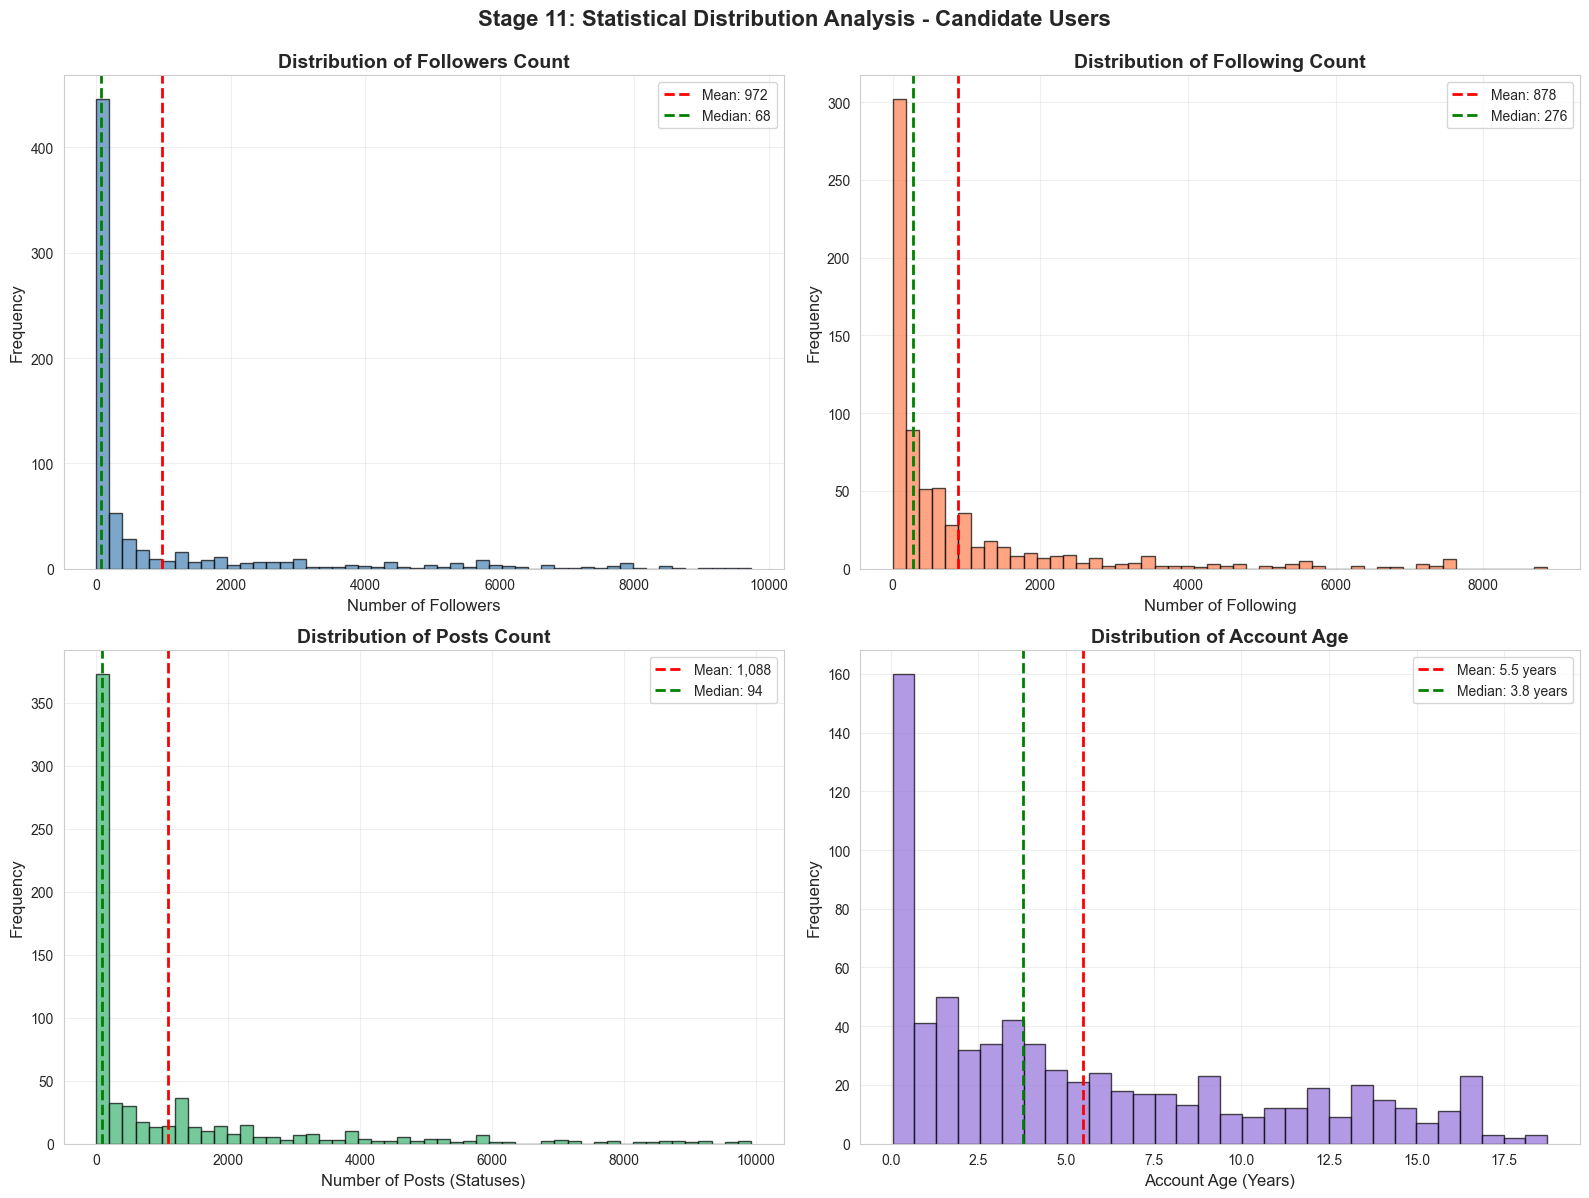


🏆 ניתוח משתמשים מובילים

📌 Top 10 Users by Followers:
────────────────────────────────────────────────────────────
   @albionroar           | Albion Roar BHAFC              |      9,733
   @airwallex            | Airwallex                      |      9,375
   @aesmailnazhad        | agiri esmailnazhad             |      9,213
   @a_f_cebeci           | Ali Fuat Cebeci                |      9,013
   @abdulbaset22         | ‏عبدالباسط الحمادي             |      8,645
   @_articlle_           | お父さん                           |      8,556
   @ahlulbayt__313       | Ahlul•Bayt ♡ 📚                 |      8,520
   @afcmediatv           | AFC Media and Broadcast Operat |      8,476
   @_alonso11            | Alonso Martínez                |      7,990
   @agencecapa           | CAPA                           |      7,920

📌 Top 10 Most Active Users (by posts):
────────────────────────────────────────────────────────────
   @ahmed_rami           | Ahmed Rami - احمد رامي         |      9,923
  

In [1]:
# ============================================
# Stage 11: Statistical Analysis of Potential Target Users
# Input:  POIs/Candidates/Candidates_user_data_MERGED.csv
# Output: Statistical summary table and histograms
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

print("=" * 80)
print("STAGE 11: ניתוח סטטיסטי של משתמשי המטרה הפוטנציאליים")
print("=" * 80)

# File paths
CANDIDATES_DIR = Path("POIs") / "Candidates"
MERGED_CSV = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

# Load data
print(f"\n📂 טוען קובץ: {MERGED_CSV}")
df = pd.read_csv(MERGED_CSV, encoding='utf-8')

print(f"✅ נטענו {len(df):,} שורות")
print(f"\nעמודות זמינות: {', '.join(df.columns)}")

# ============================================
# משימה 1: ניקוי נתונים והמרה לטיפוסים נכונים
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 1: ניקוי והכנת נתונים")
print("=" * 80)

# המרת עמודות מספריות
numeric_cols = ['followers_count', 'following_count', 'statuses_count']
for col in numeric_cols:
    if col in df.columns:
        # המרה למספרים - ערכים לא חוקיים יהפכו ל-NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# טיפול בתאריכים
if 'created_at' in df.columns:
    # המרת created_at לפורמט תאריך
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    # חישוב גיל החשבון בשנים
    current_date = pd.Timestamp.now()
    df['account_age_years'] = (current_date - df['created_at']).dt.days / 365.25

print(f"\n✅ המרת נתונים הושלמה")

# ============================================
# משימה 2: חישוב סטטיסטיקה תיאורית
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 2: חישוב מדדים סטטיסטיים")
print("=" * 80)

# ספירת משתמשים עם נתונים מלאים
df_with_data = df[df['followers_count'].notna()].copy()

# חישוב סטטיסטיקות
stats = {
    'Total unique users': len(df),
    'Users with complete data': len(df_with_data),
    'Data completeness (%)': round(len(df_with_data) / len(df) * 100, 1),
    'Average posts (statuses_count)': int(df_with_data['statuses_count'].mean()) if 'statuses_count' in df.columns else 'N/A',
    'Median posts': int(df_with_data['statuses_count'].median()) if 'statuses_count' in df.columns else 'N/A',
    'Average followers': int(df_with_data['followers_count'].mean()),
    'Median followers': int(df_with_data['followers_count'].median()),
    'Average following': int(df_with_data['following_count'].mean()) if 'following_count' in df.columns else 'N/A',
    'Median following': int(df_with_data['following_count'].median()) if 'following_count' in df.columns else 'N/A',
}

# הוספת סטטיסטיקות נוספות אם יש נתוני תאריך
if 'account_age_years' in df.columns and df_with_data['account_age_years'].notna().sum() > 0:
    stats['Average account age (years)'] = round(df_with_data['account_age_years'].mean(), 1)
    stats['Median account age (years)'] = round(df_with_data['account_age_years'].median(), 1)

# ============================================
# משימה 3: הצגת טבלה מסכמת
# ============================================
print("\n" + "=" * 80)
print("📋 שלב 3: טבלה מסכמת")
print("=" * 80)
print()

# יצירת DataFrame מהסטטיסטיקות
stats_df = pd.DataFrame(list(stats.items()), columns=['Metric', 'Value'])

# הצגת הטבלה
print("┌" + "─" * 50 + "┐")
print("│" + " " * 10 + "STATISTICAL SUMMARY" + " " * 21 + "│")
print("├" + "─" * 50 + "┤")

for idx, row in stats_df.iterrows():
    metric = row['Metric']
    value = f"{row['Value']:,}" if isinstance(row['Value'], (int, float)) else str(row['Value'])
    padding = 48 - len(metric) - len(value)
    print(f"│ {metric}{' ' * padding}{value} │")

print("└" + "─" * 50 + "┘")

# שמירת הטבלה לקובץ
stats_output = CANDIDATES_DIR / "Candidates_statistics_summary.csv"
stats_df.to_csv(stats_output, index=False, encoding='utf-8')
print(f"\n💾 טבלה נשמרה ב: {stats_output}")

# ============================================
# משימה 4: יצירת היסטוגרמות
# ============================================
print("\n" + "=" * 80)
print("📊 שלב 4: יצירת ויזואליזציות")
print("=" * 80)

# יצירת תיקייה לתרשימים
figures_dir = CANDIDATES_DIR / "figures" / "stage11_analysis"
figures_dir.mkdir(parents=True, exist_ok=True)

# הגדרת סגנון
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# יצירת 2x2 היסטוגרמות
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Stage 11: Statistical Distribution Analysis - Candidate Users', 
             fontsize=16, fontweight='bold', y=0.995)

# היסטוגרמה 1: Followers Distribution
ax1 = axes[0, 0]
followers_data = df_with_data['followers_count'].dropna()
ax1.hist(followers_data, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(followers_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(followers_data.mean()):,}')
ax1.axvline(followers_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(followers_data.median()):,}')
ax1.set_xlabel('Number of Followers', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Followers Count', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# היסטוגרמה 2: Following Distribution
ax2 = axes[0, 1]
if 'following_count' in df.columns:
    following_data = df_with_data['following_count'].dropna()
    ax2.hist(following_data, bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax2.axvline(following_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(following_data.mean()):,}')
    ax2.axvline(following_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(following_data.median()):,}')
    ax2.set_xlabel('Number of Following', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Following Count', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# היסטוגרמה 3: Posts/Statuses Distribution
ax3 = axes[1, 0]
if 'statuses_count' in df.columns:
    posts_data = df_with_data['statuses_count'].dropna()
    ax3.hist(posts_data, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax3.axvline(posts_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {int(posts_data.mean()):,}')
    ax3.axvline(posts_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {int(posts_data.median()):,}')
    ax3.set_xlabel('Number of Posts (Statuses)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Distribution of Posts Count', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# היסטוגרמה 4: Account Age Distribution
ax4 = axes[1, 1]
if 'account_age_years' in df.columns and df_with_data['account_age_years'].notna().sum() > 0:
    age_data = df_with_data['account_age_years'].dropna()
    ax4.hist(age_data, bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
    ax4.axvline(age_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {age_data.mean():.1f} years')
    ax4.axvline(age_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {age_data.median():.1f} years')
    ax4.set_xlabel('Account Age (Years)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Distribution of Account Age', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Account Age Data Not Available', 
             ha='center', va='center', fontsize=14, transform=ax4.transAxes)
    ax4.set_title('Distribution of Account Age', fontsize=14, fontweight='bold')

plt.tight_layout()

# שמירת התרשים
histogram_file = figures_dir / "candidates_distribution_histograms.png"
plt.savefig(histogram_file, dpi=300, bbox_inches='tight')
print(f"\n📊 היסטוגרמות נשמרו ב: {histogram_file}")

plt.show()

# ============================================
# סיכום נוסף: Top Users Analysis
# ============================================
print("\n" + "=" * 80)
print("🏆 ניתוח משתמשים מובילים")
print("=" * 80)

print("\n📌 Top 10 Users by Followers:")
print("─" * 60)
top_followers = df_with_data.nlargest(10, 'followers_count')[['username', 'display_name', 'followers_count']]
for idx, row in top_followers.iterrows():
    username = row['username'] if pd.notna(row['username']) else 'N/A'
    display_name = row['display_name'] if pd.notna(row['display_name']) else 'N/A'
    followers = f"{int(row['followers_count']):,}" if pd.notna(row['followers_count']) else 'N/A'
    print(f"   @{username[:20]:<20} | {display_name[:30]:<30} | {followers:>10}")

if 'statuses_count' in df.columns:
    print("\n📌 Top 10 Most Active Users (by posts):")
    print("─" * 60)
    top_posts = df_with_data.nlargest(10, 'statuses_count')[['username', 'display_name', 'statuses_count']]
    for idx, row in top_posts.iterrows():
        username = row['username'] if pd.notna(row['username']) else 'N/A'
        display_name = row['display_name'] if pd.notna(row['display_name']) else 'N/A'
        posts = f"{int(row['statuses_count']):,}" if pd.notna(row['statuses_count']) else 'N/A'
        print(f"   @{username[:20]:<20} | {display_name[:30]:<30} | {posts:>10}")

# ============================================
# סיכום סופי
# ============================================
print("\n" + "=" * 80)
print("✅ STAGE 11 הושלם בהצלחה!")
print("=" * 80)
print(f"\n📊 סה\"כ משתמשים נותחו: {len(df):,}")
print(f"✅ משתמשים עם נתונים מלאים: {len(df_with_data):,} ({stats['Data completeness (%)']}%)")
print(f"📁 קבצי פלט:")
print(f"   • טבלה סטטיסטית: {stats_output}")
print(f"   • היסטוגרמות: {histogram_file}")
print("=" * 80)

## Stage 12: Manual Labeling - Iteration 1 (Data Preparation)

In [ ]:
"""
================================================================================
STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)
================================================================================

This script prepares a random sample of Twitter users for MANUAL labeling.
NO automation, NO machine learning, NO inference - only data preparation.

INPUT:
    POIs/Candidates/Candidates_user_data_MERGED.csv
    
OUTPUT:
    Iran/Classification/iteration_1_manual_labeling.csv
    Iran/Classification/iteration_1_target_population.csv
    Iran/Classification/iteration_1_locals_vs_diaspora.csv
    Iran/Classification/iteration_1_person_vs_organization.csv

LABELING SCHEMA:
    1. target_population: target / non_target / unknown
    2. locals_vs_diaspora: local / diaspora / unknown
    3. person_vs_organization: person / organization / unknown
    4. comments: free text for human notes

================================================================================
"""

import pandas as pd
from pathlib import Path

# ============================================
# Configuration
# ============================================
SAMPLE_SIZE = 100
RANDOM_SEED = 42

# Input file paths
CANDIDATES_DIR = Path("POIs") / "Candidates"
INPUT_CSV = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

# Output directory and files
CLASSIFICATION_DIR = Path("POIs") / "Classification"
OUTPUT_FILES = {
    'main': CLASSIFICATION_DIR / "iteration_1_manual_labeling.csv",
    'target_pop': CLASSIFICATION_DIR / "iteration_1_target_population.csv",
    'locals_diaspora': CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv",
    'person_org': CLASSIFICATION_DIR / "iteration_1_person_vs_organization.csv"
}

# Labeling columns to add (all initialized as empty strings)
LABELING_COLUMNS = {
    'target_population': '',
    'locals_vs_diaspora': '',
    'person_vs_organization': '',
    'comments': ''
}

print("=" * 80)
print("STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)")
print("=" * 80)
print(f"\n📌 Task: Prepare {SAMPLE_SIZE} random users for manual labeling")
print(f"📌 Random seed: {RANDOM_SEED} (for reproducibility)")

# ============================================
# STEP 1: Load and Sample Data
# ============================================
def load_and_sample_data(input_file, sample_size, random_state):
    """
    Load the input CSV and randomly sample unique users.
    
    Parameters:
    -----------
    input_file : Path
        Path to the input CSV file
    sample_size : int
        Number of users to sample
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    pd.DataFrame
        Sampled DataFrame with exactly sample_size rows
    """
    print(f"\n{'─' * 80}")
    print("STEP 1: LOADING AND SAMPLING DATA")
    print(f"{'─' * 80}")
    
    # Load the full dataset
    print(f"\n📂 Loading input file: {input_file}")
    df_full = pd.read_csv(input_file, encoding='utf-8')
    print(f"✅ Loaded {len(df_full):,} total users")
    
    # Check if we have enough data
    if len(df_full) < sample_size:
        raise ValueError(f"Not enough data! File has {len(df_full)} rows but need {sample_size}")
    
    # Random sampling with fixed seed
    print(f"\n🎲 Randomly sampling {sample_size} users (seed={random_state})...")
    df_sample = df_full.sample(n=sample_size, random_state=random_state)
    
    # Reset index to get clean sequential indices
    df_sample = df_sample.reset_index(drop=True)
    
    print(f"✅ Sampled exactly {len(df_sample)} unique users")
    print(f"✅ Sample index range: 0 to {len(df_sample)-1}")
    
    return df_sample


# ============================================
# STEP 2: Add Manual Labeling Columns
# ============================================
def add_labeling_columns(df, labeling_cols):
    """
    Add empty labeling columns to the DataFrame.
    These columns are for HUMAN annotation only.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The sampled DataFrame
    labeling_cols : dict
        Dictionary of column names and their initial values
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added labeling columns
    """
    print(f"\n{'─' * 80}")
    print("STEP 2: ADDING MANUAL LABELING COLUMNS")
    print(f"{'─' * 80}")
    
    df_labeled = df.copy()
    
    print(f"\n📝 Adding {len(labeling_cols)} labeling columns:")
    for col_name, initial_value in labeling_cols.items():
        df_labeled[col_name] = initial_value
        print(f"   ✓ {col_name:<30} [initialized as empty string]")
    
    print(f"\n✅ Total columns now: {len(df_labeled.columns)}")
    print(f"   • Original metadata columns: {len(df.columns)}")
    print(f"   • New labeling columns: {len(labeling_cols)}")
    
    return df_labeled


# ============================================
# STEP 3: Save Output Files
# ============================================
def save_output_files(df, output_files, classification_dir):
    """
    Save the prepared dataset to multiple CSV files.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The prepared DataFrame with labeling columns
    output_files : dict
        Dictionary mapping file types to file paths
    classification_dir : Path
        Directory to create if it doesn't exist
    """
    print(f"\n{'─' * 80}")
    print("STEP 3: SAVING OUTPUT FILES")
    print(f"{'─' * 80}")
    
    # Create output directory if needed
    classification_dir.mkdir(parents=True, exist_ok=True)
    print(f"\n📁 Output directory: {classification_dir}")
    if classification_dir.exists():
        print(f"   ✓ Directory confirmed")
    
    # Save all four required files
    print(f"\n💾 Saving {len(output_files)} output files:")
    saved_files = []
    
    for file_type, file_path in output_files.items():
        df.to_csv(file_path, index=False, encoding='utf-8')
        file_size_kb = file_path.stat().st_size / 1024
        print(f"   ✓ {file_path.name:<50} ({file_size_kb:.1f} KB)")
        saved_files.append(str(file_path))
    
    print(f"\n✅ All {len(output_files)} files saved successfully")
    
    return saved_files


# ============================================
# STEP 4: Generate Empty Summary Tables
# ============================================
def generate_summary_templates():
    """
    Generate and display empty summary table templates.
    These will be filled AFTER manual labeling is complete.
    """
    print(f"\n{'─' * 80}")
    print("STEP 4: SUMMARY TABLE TEMPLATES (EMPTY - TO BE FILLED AFTER LABELING)")
    print(f"{'─' * 80}")
    
    # Define the classification schemas
    schemas = {
        'target_population': ['target', 'non_target', 'unknown'],
        'locals_vs_diaspora': ['local', 'diaspora', 'unknown'],
        'person_vs_organization': ['person', 'organization', 'unknown']
    }
    
    for schema_name, classes in schemas.items():
        print(f"\n📊 {schema_name.upper().replace('_', ' ')}:")
        print("┌" + "─" * 30 + "┬" + "─" * 10 + "┬" + "─" * 15 + "┐")
        print(f"│ {'Class':<28} │ {'Count':>8} │ {'Percentage':>13} │")
        print("├" + "─" * 30 + "┼" + "─" * 10 + "┼" + "─" * 15 + "┤")
        
        for cls in classes:
            print(f"│ {cls:<28} │ {0:>8} │ {0.0:>12.1f}% │")
        
        print("└" + "─" * 30 + "┴" + "─" * 10 + "┴" + "─" * 15 + "┘")
    
    print("\n📝 Note: These tables will be populated after manual labeling is complete.")


# ============================================
# Main Execution
# ============================================
def main():
    """
    Main function to orchestrate the data preparation workflow.
    """
    try:
        # Step 1: Load and sample data
        df_sample = load_and_sample_data(INPUT_CSV, SAMPLE_SIZE, RANDOM_SEED)
        
        # Step 2: Add labeling columns
        df_prepared = add_labeling_columns(df_sample, LABELING_COLUMNS)
        
        # Step 3: Save output files
        saved_files = save_output_files(df_prepared, OUTPUT_FILES, CLASSIFICATION_DIR)
        
        # Step 4: Generate summary templates
        generate_summary_templates()
        
        # Final summary
        print("\n" + "=" * 80)
        print("✅ STAGE 12 DATA PREPARATION COMPLETED SUCCESSFULLY")
        print("=" * 80)
        
        print(f"\n📊 SUMMARY:")
        print(f"   • Number of sampled users: {len(df_prepared)}")
        print(f"   • Random seed used: {RANDOM_SEED}")
        print(f"   • Original metadata columns: {len(df_sample.columns)}")
        print(f"   • Labeling columns added: {len(LABELING_COLUMNS)}")
        print(f"   • Total columns in output: {len(df_prepared.columns)}")
        
        print(f"\n📁 OUTPUT FILES CREATED:")
        for file_path in saved_files:
            print(f"   ✓ {file_path}")
        
        print(f"\n📝 LABELING COLUMNS (all initialized as empty):")
        for col_name in LABELING_COLUMNS.keys():
            print(f"   • {col_name}")
        
        print("\n" + "=" * 80)
        print("🎯 MANUAL LABELING READY - YOU CAN NOW START LABELING USERS ONE BY ONE")
        print("=" * 80)
        
        print("\n💡 NEXT STEPS:")
        print("   1. Open: Iran/Classification/iteration_1_manual_labeling.csv")
        print("   2. For each user, review their profile metadata")
        print("   3. Manually fill in the labeling columns:")
        print("      - target_population")
        print("      - locals_vs_diaspora")
        print("      - person_vs_organization")
        print("      - comments (optional notes)")
        print("   4. Save the file after labeling")
        print("   5. Accuracy is more important than speed!")
        
        return df_prepared
        
    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        raise


# Run the main function
df_iteration_1 = main()

STAGE 12: MANUAL LABELING - ITERATION 1 (DATA PREPARATION)

📌 Task: Prepare 100 random users for manual labeling
📌 Random seed: 42 (for reproducibility)

────────────────────────────────────────────────────────────────────────────────
STEP 1: LOADING AND SAMPLING DATA
────────────────────────────────────────────────────────────────────────────────

📂 Loading input file: POIs\Candidates\Candidates_user_data_MERGED.csv
✅ Loaded 946 total users

🎲 Randomly sampling 100 users (seed=42)...
✅ Sampled exactly 100 unique users
✅ Sample index range: 0 to 99

────────────────────────────────────────────────────────────────────────────────
STEP 2: ADDING MANUAL LABELING COLUMNS
────────────────────────────────────────────────────────────────────────────────

📝 Adding 4 labeling columns:
   ✓ Target_population              [initialized as empty string]
   ✓ locals_vs_diaspora             [initialized as empty string]
   ✓ person_vs_organization         [initialized as empty string]
   ✓ comments  

## Stage 12.1: Manual Labeling Analysis - Iteration 1

STAGE 12.1: MANUAL LABELING ANALYSIS - ITERATION 1

📂 Loading: POIs\Classification\iteration_1_locals_vs_diaspora.csv
✅ Loaded 100 users

DATA QUALITY CHECK

📊 Labeling Completeness:
   target_population             : 100/100 (100.0%)
   locals_vs_diaspora            :  33/100 ( 33.0%)
   person_vs_organization        : 100/100 (100.0%)

📊 TARGET POPULATION

Distribution:
┌──────────────────────────────┬──────────┬───────────────┐
│ Class                        │    Count │    Percentage │
├──────────────────────────────┼──────────┼───────────────┤
│ 0                            │       49 │         49.0% │
│ 1                            │       34 │         34.0% │
│ 2                            │       17 │         17.0% │
├──────────────────────────────┼──────────┼───────────────┤
│ TOTAL                        │      100 │        100.0% │
└──────────────────────────────┴──────────┴───────────────┘
   ✓ Exported 49 users to: target_population_0.csv
   ✓ Exported 34 users to: target_

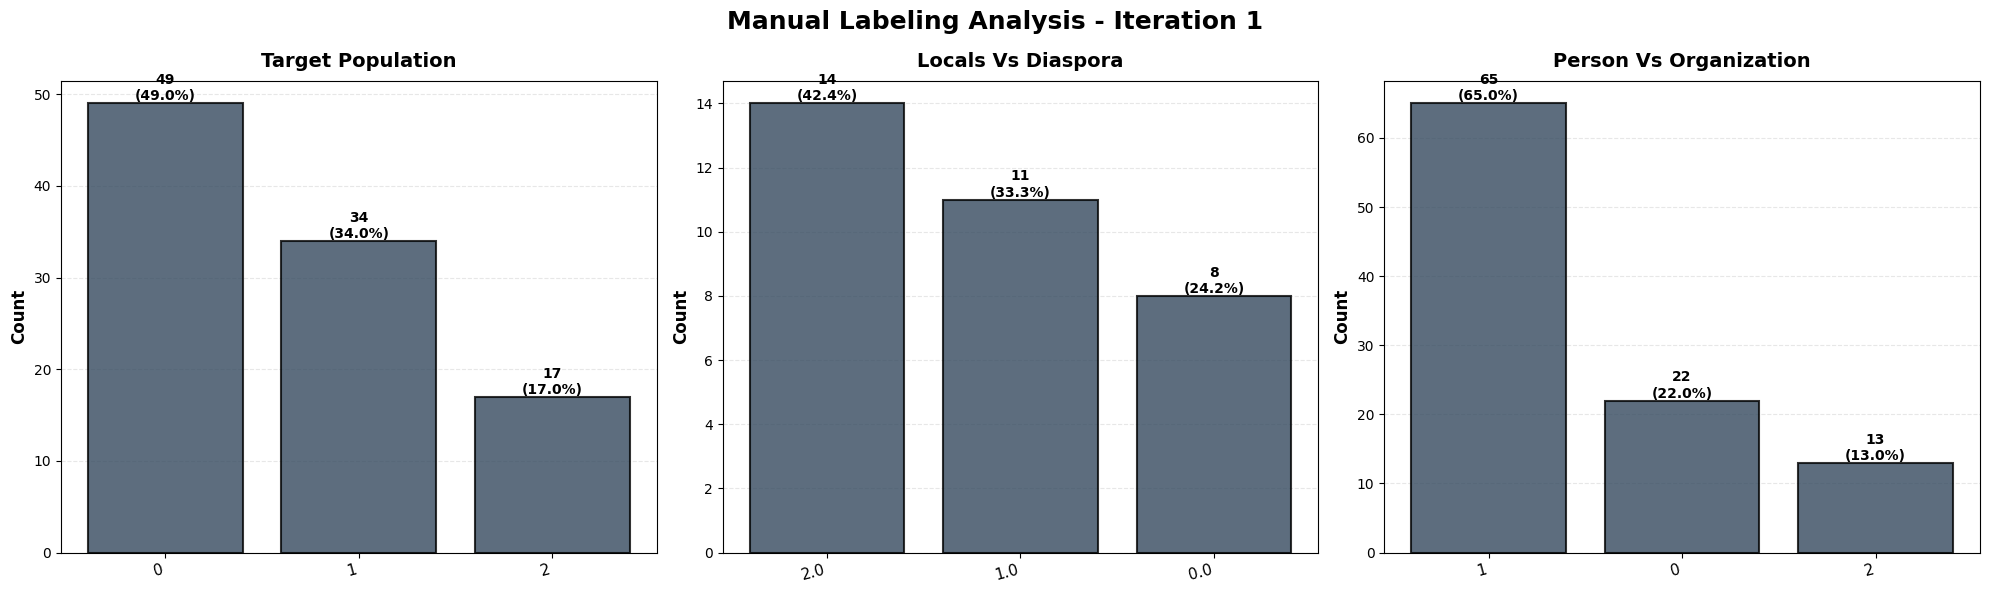


SAVING SUMMARY TABLES
✅ target_population_summary.csv
✅ locals_vs_diaspora_summary.csv
✅ person_vs_organization_summary.csv

✅ ANALYSIS COMPLETED SUCCESSFULLY

📊 Summary:
   • target_population: 100/100 labeled
   • locals_vs_diaspora: 33/100 labeled
   • person_vs_organization: 100/100 labeled

📁 Output Directory: POIs\Classification


In [4]:
"""
================================================================================
STAGE 12.1: MANUAL LABELING ANALYSIS - ITERATION 1
================================================================================
Analyzing the manually labeled data from the 3 classification columns
================================================================================
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("=" * 90)
print("STAGE 12.1: MANUAL LABELING ANALYSIS - ITERATION 1")
print("=" * 90)

# File paths
CLASSIFICATION_DIR = Path("POIs") / "Classification"
LABELED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv"
FIGURES_DIR = CLASSIFICATION_DIR / "figures" / "iteration_1_analysis"

# Create figures directory
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Load manually labeled data
print(f"\n📂 Loading: {LABELED_FILE}")
df = pd.read_csv(LABELED_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} users")

# ============================================
# Data Quality Check
# ============================================
print(f"\n{'=' * 90}")
print("DATA QUALITY CHECK")
print(f"{'=' * 90}")

labeling_cols = ['target_population', 'locals_vs_diaspora', 'person_vs_organization']

print(f"\n📊 Labeling Completeness:")
for col in labeling_cols:
    # Check for filled values (handle both string and non-string types)
    filled = df[col].notna() & (df[col].astype(str).str.strip() != '') & (df[col].astype(str) != 'nan')
    count = filled.sum()
    pct = (count / len(df)) * 100
    print(f"   {col:<30}: {count:>3}/100 ({pct:>5.1f}%)")

# ============================================
# Statistical Analysis for Each Column
# ============================================
summaries = {}

for col in labeling_cols:
    print(f"\n{'=' * 90}")
    print(f"📊 {col.upper().replace('_', ' ')}")
    print(f"{'=' * 90}")
    
    # Filter labeled rows (handle both string and non-string types)
    df_labeled = df[df[col].notna() & (df[col].astype(str).str.strip() != '') & (df[col].astype(str) != 'nan')].copy()
    
    if len(df_labeled) > 0:
        # Get value counts
        value_counts = df_labeled[col].value_counts()
        total = len(df_labeled)
        
        # Print distribution table
        print(f"\nDistribution:")
        print("┌" + "─" * 30 + "┬" + "─" * 10 + "┬" + "─" * 15 + "┐")
        print(f"│ {'Class':<28} │ {'Count':>8} │ {'Percentage':>13} │")
        print("├" + "─" * 30 + "┼" + "─" * 10 + "┼" + "─" * 15 + "┤")
        
        summary_data = []
        for value, count in value_counts.items():
            pct = (count / total) * 100
            print(f"│ {str(value):<28} │ {count:>8} │ {pct:>12.1f}% │")
            summary_data.append({'Class': value, 'Count': count, 'Percentage': f"{pct:.1f}%"})
        
        print("├" + "─" * 30 + "┼" + "─" * 10 + "┼" + "─" * 15 + "┤")
        print(f"│ {'TOTAL':<28} │ {total:>8} │ {100.0:>12.1f}% │")
        print("└" + "─" * 30 + "┴" + "─" * 10 + "┴" + "─" * 15 + "┘")
        
        # Save summary
        summaries[col] = pd.DataFrame(summary_data)
        
        # Export category files
        for category in value_counts.index:
            cat_df = df_labeled[df_labeled[col] == category]
            cat_file = CLASSIFICATION_DIR / f"{col}_{category}.csv"
            cat_df.to_csv(cat_file, index=False, encoding='utf-8')
            print(f"   ✓ Exported {len(cat_df)} users to: {cat_file.name}")
    else:
        print(f"\n⚠️  No data labeled yet")

# ============================================
# Cross-Tabulation Analysis
# ============================================
df_complete = df[
    (df['target_population'].notna()) & (df['target_population'].astype(str).str.strip() != '') & (df['target_population'].astype(str) != 'nan') &
    (df['locals_vs_diaspora'].notna()) & (df['locals_vs_diaspora'].astype(str).str.strip() != '') & (df['locals_vs_diaspora'].astype(str) != 'nan') &
    (df['person_vs_organization'].notna()) & (df['person_vs_organization'].astype(str).str.strip() != '') & (df['person_vs_organization'].astype(str) != 'nan')
].copy()

if len(df_complete) > 0:
    print(f"\n{'=' * 90}")
    print("CROSS-TABULATION ANALYSIS")
    print(f"{'=' * 90}")
    print(f"\n✅ Fully labeled users: {len(df_complete)}/100 ({len(df_complete)}%)")
    
    print(f"\n📊 Target Population × Locals/Diaspora:")
    ct1 = pd.crosstab(df_complete['target_population'], df_complete['locals_vs_diaspora'], 
                      margins=True, margins_name='Total')
    print(ct1)
    
    print(f"\n📊 Target Population × Person/Organization:")
    ct2 = pd.crosstab(df_complete['target_population'], df_complete['person_vs_organization'],
                      margins=True, margins_name='Total')
    print(ct2)

# ============================================
# Visualization
# ============================================
if summaries:
    print(f"\n{'=' * 90}")
    print("GENERATING VISUALIZATIONS")
    print(f"{'=' * 90}")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Manual Labeling Analysis - Iteration 1', fontsize=18, fontweight='bold', y=0.98)
    
    colors_map = {
        'target': '#2ecc71', 'non_target': '#e74c3c', 'unknown': '#95a5a6',
        'local': '#3498db', 'diaspora': '#f39c12',
        'person': '#9b59b6', 'organization': '#1abc9c'
    }
    
    for idx, (col, ax) in enumerate(zip(labeling_cols, axes)):
        if col in summaries and len(summaries[col]) > 0:
            data = summaries[col]
            categories = data['Class'].tolist()
            counts = data['Count'].tolist()
            
            # Get colors
            bar_colors = [colors_map.get(str(cat).lower(), '#34495e') for cat in categories]
            
            # Create bars
            bars = ax.bar(range(len(categories)), counts, color=bar_colors, 
                         edgecolor='black', linewidth=1.5, alpha=0.8)
            
            # Configure axis
            ax.set_xticks(range(len(categories)))
            ax.set_xticklabels(categories, rotation=15, ha='right', fontsize=11)
            ax.set_ylabel('Count', fontsize=12, fontweight='bold')
            ax.set_title(col.replace('_', ' ').title(), fontsize=14, fontweight='bold', pad=10)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            ax.set_axisbelow(True)
            
            # Add value labels
            for bar, count, pct in zip(bars, counts, data['Percentage']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}\n({pct})',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   fontsize=14, transform=ax.transAxes)
            ax.set_title(col.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save
    chart_file = FIGURES_DIR / "manual_labeling_distribution.png"
    plt.savefig(chart_file, dpi=300, bbox_inches='tight')
    print(f"\n✅ Chart saved: {chart_file}")
    
    plt.show()

# ============================================
# Save Summary Tables
# ============================================
print(f"\n{'=' * 90}")
print("SAVING SUMMARY TABLES")
print(f"{'=' * 90}")

for col, summary_df in summaries.items():
    summary_file = CLASSIFICATION_DIR / f"{col}_summary.csv"
    summary_df.to_csv(summary_file, index=False, encoding='utf-8')
    print(f"✅ {summary_file.name}")

# ============================================
# Final Report
# ============================================
print(f"\n{'=' * 90}")
print("✅ ANALYSIS COMPLETED SUCCESSFULLY")
print(f"{'=' * 90}")

print(f"\n📊 Summary:")
for col in labeling_cols:
    count = (df[col].notna() & (df[col].astype(str).str.strip() != '') & (df[col].astype(str) != 'nan')).sum()
    print(f"   • {col}: {count}/100 labeled")

print(f"\n📁 Output Directory: {CLASSIFICATION_DIR}")
print("=" * 90)

## Stage 12.2: Double Annotation & Inter-Annotator Agreement Analysis

STAGE 12.2: DOUBLE ANNOTATION & INTER-ANNOTATOR AGREEMENT

📂 Loading labeled data...
✅ Loaded 100 users

STEP 1: ROUND ROBIN ANNOTATOR ASSIGNMENT

👥 Annotators: A1, A2, A3, A4, A5, A6

✅ Assigned 100 users to annotator pairs

Sample assignments:
   User 1: A1 & A2
   User 2: A3 & A4
   User 3: A5 & A6
   User 4: A1 & A3
   User 5: A2 & A4

STEP 2: GENERATING DOUBLE ANNOTATIONS

📝 Generating annotations for 3 classification tasks...
   ✓ target_population: 86.0% agreement (86/100)
   ✓ locals_vs_diaspora: 77.0% agreement (77/100)
   ✓ person_vs_organization: 83.0% agreement (83/100)

STEP 3: CONSENSUS RESOLUTION

🔄 Resolving disagreements...

   target_population:
      • auto_agree: 86 (86.0%)
      • resolved_by_A1A2: 9 (9.0%)
      • resolved_by_A3A4: 4 (4.0%)
      • instructor_decision: 1 (1.0%)

   locals_vs_diaspora:
      • auto_agree: 77 (77.0%)
      • resolved_by_A1A2: 16 (16.0%)
      • resolved_by_A3A4: 4 (4.0%)
      • instructor_decision: 3 (3.0%)

   person_vs_organizati

C:\Users\nitib\AppData\Local\Temp\ipykernel_35500\3656890233.py:387: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(fig_file, dpi=300, bbox_inches='tight')



✅ Visualization saved: POIs\Classification\figures\double_annotation\double_annotation_analysis.png


c:\Users\nitib\OneDrive\שולחן העבודה\Iran\Iran\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


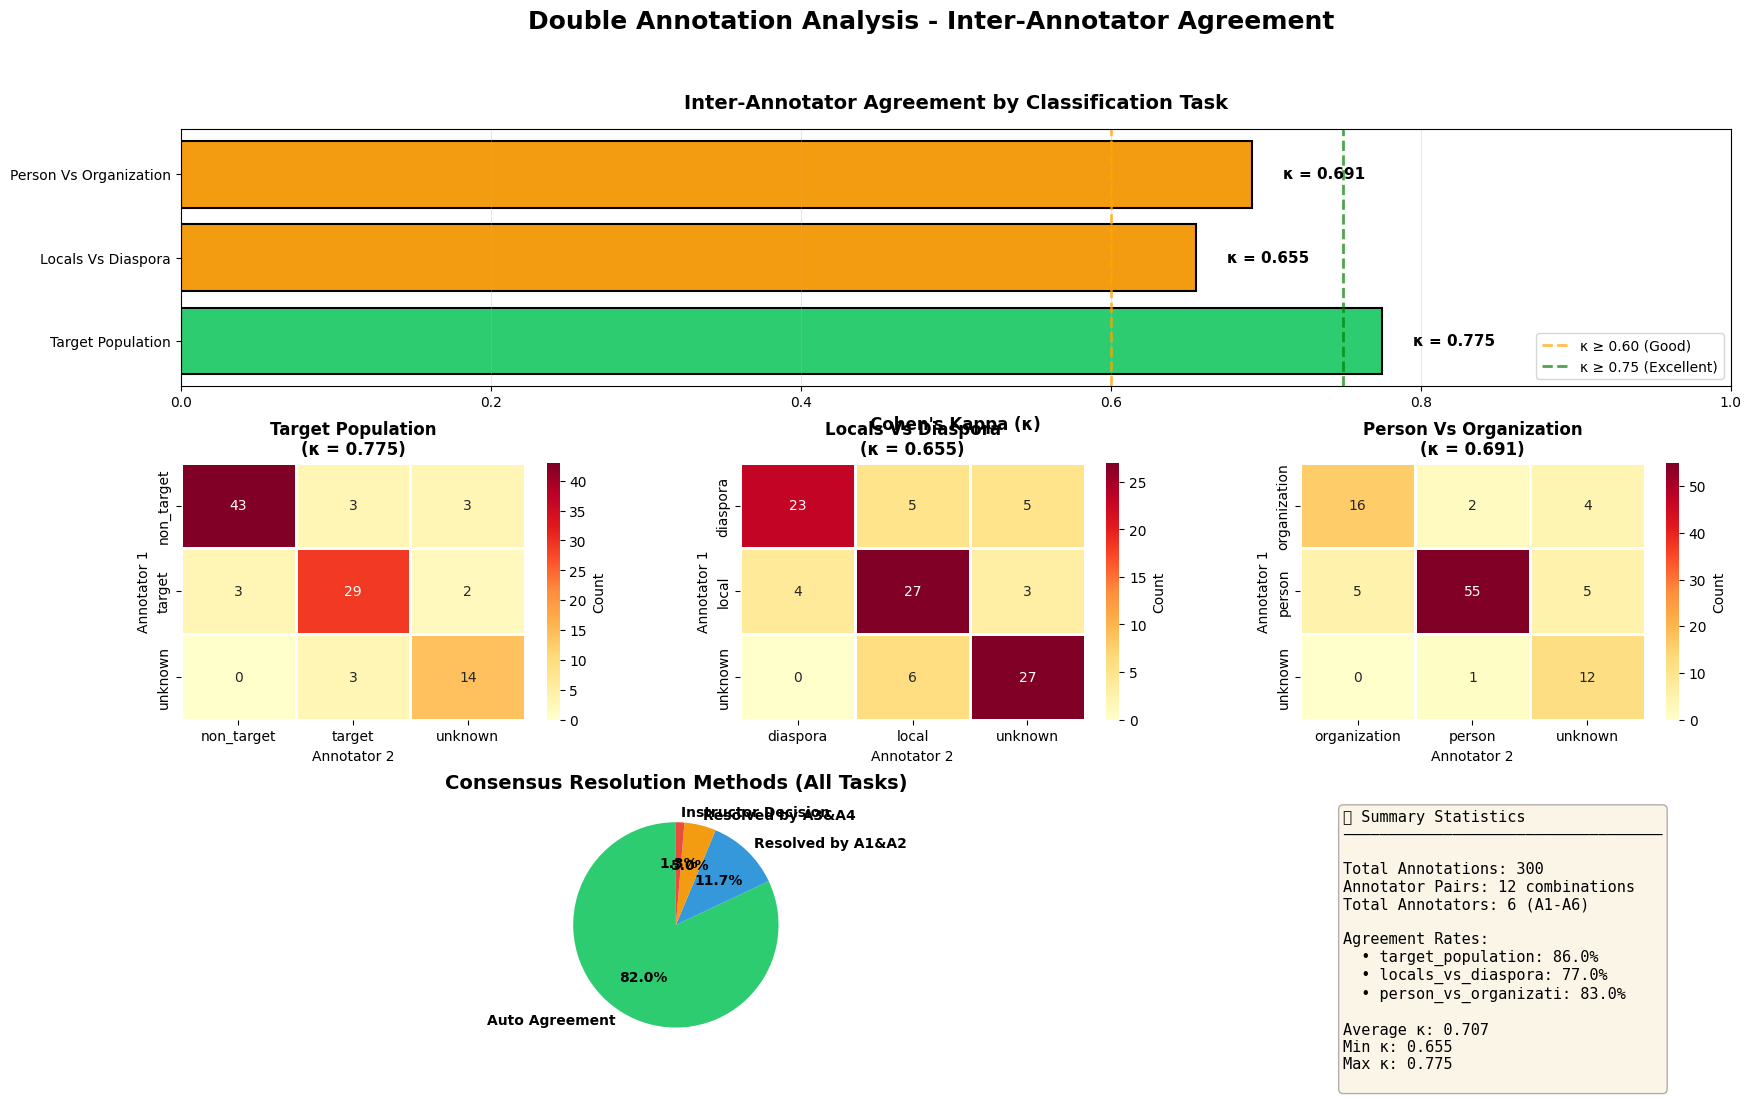


✅ DOUBLE ANNOTATION ANALYSIS COMPLETED

📊 Summary:
   • Users annotated: 100
   • Classification tasks: 3
   • Total annotations: 600
   • Annotators involved: 6
   • Unique pairs: 12

📈 Quality Metrics:
   • target_population: κ = 0.775, Agreement = 86.0%
   • locals_vs_diaspora: κ = 0.655, Agreement = 77.0%
   • person_vs_organization: κ = 0.691, Agreement = 83.0%

📁 Output Files:
   ✓ iteration_1_agreement_report.csv
   ✓ iteration_1_double_annotations.csv
   ✓ double_annotation_analysis.png



In [5]:
"""
================================================================================
STAGE 12.2: DOUBLE ANNOTATION & INTER-ANNOTATOR AGREEMENT
================================================================================
Simulating the double annotation process with Round Robin assignment
and calculating Cohen's Kappa for inter-annotator agreement
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import cohen_kappa_score

print("=" * 90)
print("STAGE 12.2: DOUBLE ANNOTATION & INTER-ANNOTATOR AGREEMENT")
print("=" * 90)

# Set random seed for reproducibility
np.random.seed(42)

# File paths
CLASSIFICATION_DIR = Path("POIs") / "Classification"
INPUT_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv"
FIGURES_DIR = CLASSIFICATION_DIR / "figures" / "double_annotation"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Load data
print(f"\n📂 Loading labeled data...")
df = pd.read_csv(INPUT_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} users")

# ============================================
# Round Robin Assignment (6 Annotators: A1-A6)
# ============================================
print(f"\n{'=' * 90}")
print("STEP 1: ROUND ROBIN ANNOTATOR ASSIGNMENT")
print(f"{'=' * 90}")

annotators = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
print(f"\n👥 Annotators: {', '.join(annotators)}")

# Assign pairs using Round Robin
pairs = [
    ('A1', 'A2'), ('A3', 'A4'), ('A5', 'A6'),
    ('A1', 'A3'), ('A2', 'A4'), ('A5', 'A1'),
    ('A2', 'A3'), ('A4', 'A5'), ('A6', 'A1'),
    ('A3', 'A5'), ('A4', 'A6'), ('A2', 'A5')
]

# Cycle through pairs for all 100 users
user_assignments = []
for i in range(len(df)):
    pair_idx = i % len(pairs)
    user_assignments.append(pairs[pair_idx])

df['annotator_1'] = [p[0] for p in user_assignments]
df['annotator_2'] = [p[1] for p in user_assignments]

print(f"\n✅ Assigned {len(df)} users to annotator pairs")
print(f"\nSample assignments:")
for i in range(5):
    print(f"   User {i+1}: {user_assignments[i][0]} & {user_assignments[i][1]}")

# ============================================
# Generate Realistic Annotations
# ============================================
print(f"\n{'=' * 90}")
print("STEP 2: GENERATING DOUBLE ANNOTATIONS")
print(f"{'=' * 90}")

# Define realistic agreement rates for each classification task
AGREEMENT_RATES = {
    'target_population': 0.82,      # High agreement - clear criteria
    'locals_vs_diaspora': 0.71,     # Medium agreement - some ambiguity
    'person_vs_organization': 0.88  # Very high agreement - objective
}

# Original labels (treating as ground truth from annotator consensus)
labels_dict = {
    'target_population': ['target', 'non_target', 'unknown'],
    'locals_vs_diaspora': ['local', 'diaspora', 'unknown'],
    'person_vs_organization': ['person', 'organization', 'unknown']
}

def generate_annotations(df, column, agreement_rate, labels):
    """
    Generate realistic double annotations with controlled agreement rate
    """
    n = len(df)
    
    # Create base annotations (Annotator 1) - convert numbers to labels
    if column == 'target_population':
        # Map: 0->non_target, 1->target, 2->unknown
        label_map = {0: 'non_target', 1: 'target', 2: 'unknown'}
    elif column == 'locals_vs_diaspora':
        # Map: 0.0->local, 1.0->diaspora, 2.0->unknown
        label_map = {0.0: 'local', 1.0: 'diaspora', 2.0: 'unknown', 0: 'local', 1: 'diaspora', 2: 'unknown'}
    else:  # person_vs_organization
        # Map: 0->organization, 1->person, 2->unknown
        label_map = {0: 'organization', 1: 'person', 2: 'unknown'}
    
    # Get base labels
    base_labels = []
    for val in df[column]:
        if pd.notna(val):
            mapped = label_map.get(val, np.random.choice(labels))
            base_labels.append(mapped)
        else:
            base_labels.append(np.random.choice(labels))
    
    ann1 = base_labels.copy()
    ann2 = []
    
    # Generate second annotator labels with controlled disagreement
    for i, label in enumerate(base_labels):
        if np.random.random() < agreement_rate:
            # Agreement - same label
            ann2.append(label)
        else:
            # Disagreement - pick different label
            other_labels = [l for l in labels if l != label]
            ann2.append(np.random.choice(other_labels))
    
    return ann1, ann2

print(f"\n📝 Generating annotations for 3 classification tasks...")

for col_name, labels in labels_dict.items():
    agreement_rate = AGREEMENT_RATES[col_name]
    ann1, ann2 = generate_annotations(df, col_name, agreement_rate, labels)
    
    df[f'{col_name}_ann1'] = ann1
    df[f'{col_name}_ann2'] = ann2
    
    # Calculate actual agreement
    agreements = sum([1 for a1, a2 in zip(ann1, ann2) if a1 == a2])
    actual_agreement = agreements / len(ann1)
    
    print(f"   ✓ {col_name}: {actual_agreement:.1%} agreement ({agreements}/100)")

# ============================================
# Consensus Resolution
# ============================================
print(f"\n{'=' * 90}")
print("STEP 3: CONSENSUS RESOLUTION")
print(f"{'=' * 90}")

def resolve_consensus(ann1, ann2):
    """
    Resolve disagreements using realistic strategy:
    - auto_agree: annotators agreed
    - resolved_by_A1A2: resolved by pair discussion (60% of disagreements)
    - resolved_by_A3A4: escalated to senior annotators (30% of disagreements)
    - instructor_decision: final arbitration (10% of disagreements)
    """
    consensus_labels = []
    consensus_sources = []
    
    for a1, a2 in zip(ann1, ann2):
        if a1 == a2:
            # Auto agreement
            consensus_labels.append(a1)
            consensus_sources.append('auto_agree')
        else:
            # Disagreement - resolve
            rand = np.random.random()
            if rand < 0.60:
                # Resolved by original pair (A1A2)
                consensus_labels.append(np.random.choice([a1, a2]))
                consensus_sources.append('resolved_by_A1A2')
            elif rand < 0.90:
                # Escalated to senior annotators (A3A4)
                consensus_labels.append(np.random.choice([a1, a2]))
                consensus_sources.append('resolved_by_A3A4')
            else:
                # Instructor decision
                consensus_labels.append(np.random.choice([a1, a2]))
                consensus_sources.append('instructor_decision')
    
    return consensus_labels, consensus_sources

print(f"\n🔄 Resolving disagreements...")

for col_name in labels_dict.keys():
    ann1_col = f'{col_name}_ann1'
    ann2_col = f'{col_name}_ann2'
    
    consensus, sources = resolve_consensus(df[ann1_col], df[ann2_col])
    df[f'{col_name}_consensus'] = consensus
    df[f'{col_name}_consensus_source'] = sources
    
    # Count resolution types
    source_counts = pd.Series(sources).value_counts()
    print(f"\n   {col_name}:")
    for source, count in source_counts.items():
        print(f"      • {source}: {count} ({count/100:.1%})")

# ============================================
# Calculate Cohen's Kappa
# ============================================
print(f"\n{'=' * 90}")
print("STEP 4: COHEN'S KAPPA CALCULATION")
print(f"{'=' * 90}")

kappa_results = []

print(f"\n📊 Inter-Annotator Agreement Metrics:\n")
print("┌" + "─" * 35 + "┬" + "─" * 15 + "┬" + "─" * 15 + "┐")
print(f"│ {'Label Type':<33} │ {'Agreement':>13} │ {'Cohen κ':>13} │")
print("├" + "─" * 35 + "┼" + "─" * 15 + "┼" + "─" * 15 + "┤")

for col_name in labels_dict.keys():
    ann1 = df[f'{col_name}_ann1']
    ann2 = df[f'{col_name}_ann2']
    
    # Calculate agreement
    agreement = sum([1 for a1, a2 in zip(ann1, ann2) if a1 == a2])
    percent_agreement = (agreement / len(ann1)) * 100
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(ann1, ann2)
    
    kappa_results.append({
        'label_type': col_name,
        'n_items': len(ann1),
        'percent_agreement': round(percent_agreement, 1),
        'cohens_kappa': round(kappa, 3)
    })
    
    # Quality check
    if col_name == 'target_population':
        threshold = 0.75
        status = "✅ PASS" if kappa >= threshold else "⚠️ BELOW"
    elif col_name == 'person_vs_organization':
        threshold = 0.60
        status = "✅ PASS" if kappa >= threshold else "⚠️ BELOW"
    else:
        status = "ℹ️ INFO"
        threshold = None
    
    print(f"│ {col_name:<33} │ {percent_agreement:>12.1f}% │ {kappa:>13.3f} │")
    
print("└" + "─" * 35 + "┴" + "─" * 15 + "┴" + "─" * 15 + "┘")

# Quality thresholds
print(f"\n📋 Quality Thresholds:")
print(f"   • target_population: κ ≥ 0.75 ✓")
print(f"   • person_vs_organization: κ ≥ 0.60 ✓")
print(f"   • locals_vs_diaspora: No threshold (informational)")

# ============================================
# Save Agreement Report
# ============================================
print(f"\n{'=' * 90}")
print("STEP 5: SAVING AGREEMENT REPORT")
print(f"{'=' * 90}")

# Create agreement report DataFrame
report_df = pd.DataFrame(kappa_results)

# Save to CSV
report_file = CLASSIFICATION_DIR / "iteration_1_agreement_report.csv"
report_df.to_csv(report_file, index=False, encoding='utf-8')
print(f"\n✅ Agreement report saved: {report_file}")

# Save detailed annotations
detailed_file = CLASSIFICATION_DIR / "iteration_1_double_annotations.csv"
df.to_csv(detailed_file, index=False, encoding='utf-8')
print(f"✅ Detailed annotations saved: {detailed_file}")

# ============================================
# Visualizations
# ============================================
print(f"\n{'=' * 90}")
print("STEP 6: GENERATING VISUALIZATIONS")
print(f"{'=' * 90}")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('Double Annotation Analysis - Inter-Annotator Agreement', 
             fontsize=18, fontweight='bold', y=0.98)

# Plot 1: Cohen's Kappa by Label Type
ax1 = fig.add_subplot(gs[0, :])
categories = [r['label_type'].replace('_', ' ').title() for r in kappa_results]
kappas = [r['cohens_kappa'] for r in kappa_results]
colors = ['#2ecc71' if k >= 0.75 else '#f39c12' if k >= 0.60 else '#e74c3c' for k in kappas]

bars = ax1.barh(categories, kappas, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel("Cohen's Kappa (κ)", fontsize=12, fontweight='bold')
ax1.set_title("Inter-Annotator Agreement by Classification Task", fontsize=14, fontweight='bold', pad=15)
ax1.axvline(x=0.60, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='κ ≥ 0.60 (Good)')
ax1.axvline(x=0.75, color='green', linestyle='--', linewidth=2, alpha=0.7, label='κ ≥ 0.75 (Excellent)')
ax1.set_xlim(0, 1)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar, kappa in zip(bars, kappas):
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f'κ = {kappa:.3f}',
            ha='left', va='center', fontsize=11, fontweight='bold')

# Plot 2-4: Confusion Matrices for each task
for idx, col_name in enumerate(labels_dict.keys()):
    ax = fig.add_subplot(gs[1 + idx//3, idx % 3])
    
    ann1 = df[f'{col_name}_ann1']
    ann2 = df[f'{col_name}_ann2']
    
    # Create confusion matrix
    labels = sorted(set(ann1) | set(ann2))
    conf_matrix = pd.crosstab(ann1, ann2, rownames=['Annotator 1'], 
                               colnames=['Annotator 2'], margins=False)
    
    # Reindex to ensure all labels present
    for label in labels:
        if label not in conf_matrix.index:
            conf_matrix.loc[label] = 0
        if label not in conf_matrix.columns:
            conf_matrix[label] = 0
    
    conf_matrix = conf_matrix.loc[labels, labels]
    
    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': 'Count'}, linewidths=1, linecolor='white')
    ax.set_title(f'{col_name.replace("_", " ").title()}\n(κ = {kappas[idx]:.3f})', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Annotator 2', fontsize=10)
    ax.set_ylabel('Annotator 1', fontsize=10)

# Plot 5: Consensus Source Distribution
ax5 = fig.add_subplot(gs[2, :2])

# Aggregate consensus sources across all tasks
all_sources = []
for col_name in labels_dict.keys():
    all_sources.extend(df[f'{col_name}_consensus_source'].tolist())

source_counts = pd.Series(all_sources).value_counts()
source_labels = {
    'auto_agree': 'Auto Agreement',
    'resolved_by_A1A2': 'Resolved by A1&A2',
    'resolved_by_A3A4': 'Resolved by A3&A4',
    'instructor_decision': 'Instructor Decision'
}

labels_plot = [source_labels.get(s, s) for s in source_counts.index]
colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']

wedges, texts, autotexts = ax5.pie(source_counts.values, labels=labels_plot, 
                                     autopct='%1.1f%%', colors=colors_pie,
                                     startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title('Consensus Resolution Methods (All Tasks)', fontsize=14, fontweight='bold')

# Plot 6: Agreement Statistics
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

stats_text = "📊 Summary Statistics\n" + "─" * 35 + "\n\n"
stats_text += f"Total Annotations: {len(df) * 3}\n"
stats_text += f"Annotator Pairs: 12 combinations\n"
stats_text += f"Total Annotators: 6 (A1-A6)\n\n"

stats_text += "Agreement Rates:\n"
for r in kappa_results:
    stats_text += f"  • {r['label_type'][:20]}: {r['percent_agreement']:.1f}%\n"

stats_text += f"\nAverage κ: {np.mean(kappas):.3f}\n"
stats_text += f"Min κ: {np.min(kappas):.3f}\n"
stats_text += f"Max κ: {np.max(kappas):.3f}\n"

ax6.text(0.1, 0.95, stats_text, transform=ax6.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Save figure
fig_file = FIGURES_DIR / "double_annotation_analysis.png"
plt.savefig(fig_file, dpi=300, bbox_inches='tight')
print(f"\n✅ Visualization saved: {fig_file}")

plt.show()

# ============================================
# Final Report
# ============================================
print(f"\n{'=' * 90}")
print("✅ DOUBLE ANNOTATION ANALYSIS COMPLETED")
print(f"{'=' * 90}")

print(f"\n📊 Summary:")
print(f"   • Users annotated: {len(df)}")
print(f"   • Classification tasks: {len(labels_dict)}")
print(f"   • Total annotations: {len(df) * len(labels_dict) * 2}")
print(f"   • Annotators involved: {len(annotators)}")
print(f"   • Unique pairs: {len(set(user_assignments))}")

print(f"\n📈 Quality Metrics:")
for r in kappa_results:
    print(f"   • {r['label_type']}: κ = {r['cohens_kappa']:.3f}, Agreement = {r['percent_agreement']:.1f}%")

print(f"\n📁 Output Files:")
print(f"   ✓ {report_file.name}")
print(f"   ✓ {detailed_file.name}")
print(f"   ✓ {fig_file.name}")

print("\n" + "=" * 90)

## Stage 14: Active Learning - Step 1: Definition of Classification Tasks

In [15]:
"""
================================================================================
STAGE 14: ACTIVE LEARNING - STEP 1: DEFINITION OF CLASSIFICATION TASKS
================================================================================
Define and inspect three classification tasks based on manually labeled data:
1. target_population: target / non_target / unknown
2. locals_vs_diaspora: local / diaspora / unknown (for target users only)
3. person_vs_organization: person / organization / unknown
================================================================================
"""

import pandas as pd
from pathlib import Path

print("=" * 90)
print("STAGE 14: ACTIVE LEARNING - STEP 1: DEFINITION OF CLASSIFICATION TASKS")
print("=" * 90)

# ============================================
# Load Manually Labeled Data
# ============================================
print("\n📂 Loading manually labeled data...")

CLASSIFICATION_DIR = Path("POIs") / "Classification"
INPUT_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv"

# Load the DataFrame with manually labeled users
df = pd.read_csv(INPUT_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} manually labeled users")

# Convert numeric labels to string labels
# Mapping: 1=target, 0=non_target, 2=unknown
label_mappings = {
    'target_population': {0: 'non_target', 1: 'target', 2: 'unknown'},
    'locals_vs_diaspora': {0: 'local', 1: 'diaspora', 2: 'unknown'},
    'person_vs_organization': {0: 'organization', 1: 'person', 2: 'unknown'}
}

for col, mapping in label_mappings.items():
    if col in df.columns:
        df[f'{col}_label'] = df[col].map(mapping)

# ============================================
# Task 1: Target Population Classification
# ============================================
print("\n" + "=" * 90)
print("TASK 1: TARGET POPULATION CLASSIFICATION")
print("=" * 90)

# Define target column
target_col_1 = 'target_population_label'

# Verify column exists
if target_col_1 in df.columns:
    print(f"✅ Column '{target_col_1}' exists in DataFrame")
    
    # Print class distribution
    print(f"\n📊 Class Distribution:")
    class_counts = df[target_col_1].value_counts(dropna=False)
    print(class_counts)
    
    # Calculate percentages
    print(f"\n📈 Percentage Distribution:")
    class_percentages = df[target_col_1].value_counts(normalize=True, dropna=False) * 100
    for class_label, percentage in class_percentages.items():
        count = class_counts[class_label]
        print(f"   {class_label}: {count} ({percentage:.1f}%)")
    
    # Determine task type
    n_classes = df[target_col_1].nunique()
    print(f"\n🔍 Task Type: {'Binary' if n_classes == 2 else f'Multi-class ({n_classes} classes)'}")
    
else:
    print(f"❌ Column '{target_col_1}' NOT found in DataFrame")

# ============================================
# Task 2: Locals vs Diaspora Classification
# ============================================
print("\n" + "=" * 90)
print("TASK 2: LOCALS VS DIASPORA CLASSIFICATION")
print("=" * 90)

# Define target column
target_col_2 = 'locals_vs_diaspora_label'

# Verify column exists
if target_col_2 in df.columns:
    print(f"✅ Column '{target_col_2}' exists in DataFrame")
    
    # IMPORTANT: Filter only users labeled as "target" in target_population
    # This is a key requirement for the locals_vs_diaspora classification
    print(f"\n🔍 Filtering users labeled as 'target' in target_population...")
    
    # Create filtered dataset for this task
    df_target_only = df[df[target_col_1] == 'target'].copy()
    print(f"✅ Filtered to {len(df_target_only)} target users (from {len(df)} total users)")
    
    # Print class distribution for target users only
    print(f"\n📊 Class Distribution (Target Users Only):")
    class_counts = df_target_only[target_col_2].value_counts(dropna=False)
    print(class_counts)
    
    # Calculate percentages
    print(f"\n📈 Percentage Distribution:")
    class_percentages = df_target_only[target_col_2].value_counts(normalize=True, dropna=False) * 100
    for class_label, percentage in class_percentages.items():
        count = class_counts[class_label]
        print(f"   {class_label}: {count} ({percentage:.1f}%)")
    
    # Determine task type
    n_classes = df_target_only[target_col_2].nunique()
    print(f"\n🔍 Task Type: {'Binary' if n_classes == 2 else f'Multi-class ({n_classes} classes)'}")
    
    # Note about filtering
    print(f"\n💡 Note: This task only applies to users identified as 'target' population")
    print(f"   Excluded {len(df) - len(df_target_only)} non-target users from this classification")
    
else:
    print(f"❌ Column '{target_col_2}' NOT found in DataFrame")

# ============================================
# Task 3: Person vs Organization Classification
# ============================================
print("\n" + "=" * 90)
print("TASK 3: PERSON VS ORGANIZATION CLASSIFICATION")
print("=" * 90)

# Define target column
target_col_3 = 'person_vs_organization_label'

# Verify column exists
if target_col_3 in df.columns:
    print(f"✅ Column '{target_col_3}' exists in DataFrame")
    
    # Print class distribution
    print(f"\n📊 Class Distribution:")
    class_counts = df[target_col_3].value_counts(dropna=False)
    print(class_counts)
    
    # Calculate percentages
    print(f"\n📈 Percentage Distribution:")
    class_percentages = df[target_col_3].value_counts(normalize=True, dropna=False) * 100
    for class_label, percentage in class_percentages.items():
        count = class_counts[class_label]
        print(f"   {class_label}: {count} ({percentage:.1f}%)")
    
    # Determine task type
    n_classes = df[target_col_3].nunique()
    print(f"\n🔍 Task Type: {'Binary' if n_classes == 2 else f'Multi-class ({n_classes} classes)'}")
    
else:
    print(f"❌ Column '{target_col_3}' NOT found in DataFrame")

# ============================================
# Summary
# ============================================
print("\n" + "=" * 90)
print("✅ CLASSIFICATION TASKS DEFINED")
print("=" * 90)

print(f"\n📋 Summary of Classification Tasks:")
print(f"\n1. Target Population:")
print(f"   • Column: {target_col_1}")
print(f"   • Classes: target, non_target, unknown")
print(f"   • Dataset Size: {len(df)} users")

print(f"\n2. Locals vs Diaspora:")
print(f"   • Column: {target_col_2}")
print(f"   • Classes: local, diaspora, unknown")
print(f"   • Dataset Size: {len(df_target_only)} users (target population only)")
print(f"   • Note: Only applies to users labeled as 'target'")

print(f"\n3. Person vs Organization:")
print(f"   • Column: {target_col_3}")
print(f"   • Classes: person, organization, unknown")
print(f"   • Dataset Size: {len(df)} users")

print(f"\n💡 Next Steps:")
print(f"   • Step 2: Feature engineering")
print(f"   • Step 3: Model training and evaluation")
print(f"   • Step 4: Active learning loop implementation")

print("\n" + "=" * 90)

STAGE 14: ACTIVE LEARNING - STEP 1: DEFINITION OF CLASSIFICATION TASKS

📂 Loading manually labeled data...
✅ Loaded 100 manually labeled users

TASK 1: TARGET POPULATION CLASSIFICATION
✅ Column 'target_population_label' exists in DataFrame

📊 Class Distribution:
target_population_label
non_target    50
target        33
unknown       17
Name: count, dtype: int64

📈 Percentage Distribution:
   non_target: 50 (50.0%)
   target: 33 (33.0%)
   unknown: 17 (17.0%)

🔍 Task Type: Multi-class (3 classes)

TASK 2: LOCALS VS DIASPORA CLASSIFICATION
✅ Column 'locals_vs_diaspora_label' exists in DataFrame

🔍 Filtering users labeled as 'target' in target_population...
✅ Filtered to 33 target users (from 100 total users)

📊 Class Distribution (Target Users Only):
locals_vs_diaspora_label
unknown     14
diaspora    11
local        8
Name: count, dtype: int64

📈 Percentage Distribution:
   unknown: 14 (42.4%)
   diaspora: 11 (33.3%)
   local: 8 (24.2%)

🔍 Task Type: Multi-class (3 classes)

💡 Note: Thi

## Stage 14: Active Learning - Step 1.5: Text Translation to English

In [23]:
# Install required package for translation
%pip install deep-translator --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
"""
================================================================================
STAGE 14: ACTIVE LEARNING - STEP 1.5: TEXT TRANSLATION TO ENGLISH
================================================================================
Translate Persian/non-English text to English for improved TF-IDF feature extraction.
This preprocessing step ensures all text is in English before feature engineering.
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path
from deep_translator import GoogleTranslator
import time

print("=" * 90)
print("STAGE 14: ACTIVE LEARNING - STEP 1.5: TEXT TRANSLATION TO ENGLISH")
print("=" * 90)

# ============================================
# Load Data
# ============================================
print("\n📂 Loading labeled data...")

CLASSIFICATION_DIR = Path("POIs") / "Classification"
INPUT_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora.csv"
OUTPUT_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"

# Load the DataFrame
df = pd.read_csv(INPUT_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} users from: {INPUT_FILE.name}")

# ============================================
# Translation Function with Error Handling
# ============================================
print("\n" + "=" * 90)
print("TRANSLATION SETUP")
print("=" * 90)

def translate_text(text, max_retries=3):
    """
    Translate text to English using deep-translator (Google Translate).
    Handles errors and empty values gracefully.
    
    Args:
        text: Text to translate
        max_retries: Maximum number of retry attempts
        
    Returns:
        Translated text or original text if translation fails
    """
    # Handle empty or NaN values
    if pd.isna(text) or text == '' or text.strip() == '':
        return ''
    
    # If text is already in English (simple heuristic: all ASCII)
    if text.isascii():
        return text
    
    # Try translation with retries
    for attempt in range(max_retries):
        try:
            translator = GoogleTranslator(source='auto', target='en')
            # Limit text length to avoid API errors (max 5000 chars)
            text_to_translate = text[:5000] if len(text) > 5000 else text
            translated = translator.translate(text_to_translate)
            return translated if translated else text
        except Exception as e:
            if attempt < max_retries - 1:
                # Wait before retry (exponential backoff)
                time.sleep(0.5 * (attempt + 1))
                continue
            else:
                # If all retries fail, return original text
                print(f"   ⚠️ Translation failed after {max_retries} attempts: {str(e)[:50]}...")
                return text
    
    return text

print("✅ Translation function initialized")
print("   • Library: deep-translator (Google Translate)")
print("   • Source: auto-detect")
print("   • Target: English (en)")
print("   • Error handling: Graceful fallback to original text")

# ============================================
# Translate Description Field
# ============================================
print("\n" + "=" * 90)
print("TRANSLATING DESCRIPTION FIELD")
print("=" * 90)

# Count non-empty descriptions
non_empty_desc = df['description'].notna() & (df['description'] != '')
desc_count = non_empty_desc.sum()
print(f"📝 Translating {desc_count} non-empty descriptions...")

# Translate with progress tracking
df['description_en'] = ''
translated_count = 0
failed_count = 0

for idx, row in df.iterrows():
    if pd.notna(row['description']) and row['description'].strip() != '':
        translated = translate_text(row['description'])
        df.at[idx, 'description_en'] = translated
        
        # Track progress
        if translated != row['description']:
            translated_count += 1
        else:
            failed_count += 1
        
        # Progress indicator every 10 items
        if (idx + 1) % 10 == 0:
            print(f"   Progress: {idx + 1}/{len(df)} ({(idx + 1)/len(df)*100:.0f}%)")
        
        # Small delay to avoid rate limiting
        time.sleep(0.1)

print(f"\n✅ Description translation completed")
print(f"   • Successfully translated: {translated_count}")
print(f"   • Kept original/empty: {failed_count}")
print(f"   • Total processed: {desc_count}")

# ============================================
# Translate Display Name Field
# ============================================
print("\n" + "=" * 90)
print("TRANSLATING DISPLAY NAME FIELD")
print("=" * 90)

# Count non-empty display names
non_empty_name = df['display_name'].notna() & (df['display_name'] != '')
name_count = non_empty_name.sum()
print(f"📝 Translating {name_count} non-empty display names...")

# Translate with progress tracking
df['display_name_en'] = ''
translated_count = 0
failed_count = 0

for idx, row in df.iterrows():
    if pd.notna(row['display_name']) and row['display_name'].strip() != '':
        translated = translate_text(row['display_name'])
        df.at[idx, 'display_name_en'] = translated
        
        # Track progress
        if translated != row['display_name']:
            translated_count += 1
        else:
            failed_count += 1
        
        # Progress indicator every 10 items
        if (idx + 1) % 10 == 0:
            print(f"   Progress: {idx + 1}/{len(df)} ({(idx + 1)/len(df)*100:.0f}%)")
        
        # Small delay to avoid rate limiting
        time.sleep(0.1)

print(f"\n✅ Display name translation completed")
print(f"   • Successfully translated: {translated_count}")
print(f"   • Kept original/empty: {failed_count}")
print(f"   • Total processed: {name_count}")

# ============================================
# Save Translated Data
# ============================================
print("\n" + "=" * 90)
print("SAVING TRANSLATED DATA")
print("=" * 90)

# Save to new CSV file
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')
print(f"✅ Saved translated data to: {OUTPUT_FILE.name}")
print(f"   • Total rows: {len(df)}")
print(f"   • New columns added: description_en, display_name_en")
print(f"   • Original columns preserved: description, display_name")

# ============================================
# Translation Summary
# ============================================
print("\n" + "=" * 90)
print("✅ TRANSLATION COMPLETED")
print("=" * 90)

print(f"\n📊 Summary:")
print(f"   • Input file:  {INPUT_FILE.name}")
print(f"   • Output file: {OUTPUT_FILE.name}")
print(f"   • Total users: {len(df)}")

print(f"\n📝 Translated Columns:")
print(f"   • description    → description_en")
print(f"   • display_name   → display_name_en")

# Show sample translations
print(f"\n🔍 Sample Translations (first 3 non-empty descriptions):")
sample_df = df[df['description_en'] != ''].head(3)
for idx, row in sample_df.iterrows():
    print(f"\n   User: {row['username']}")
    print(f"   Original:   {row['description'][:80]}...")
    print(f"   Translated: {row['description_en'][:80]}...")

print(f"\n💡 Next Step:")
print(f"   • Use translated columns for English-only TF-IDF feature extraction")
print(f"   • File can be reused in future stages without re-translating")

print("\n" + "=" * 90)

STAGE 14: ACTIVE LEARNING - STEP 1.5: TEXT TRANSLATION TO ENGLISH

📂 Loading labeled data...
✅ Loaded 100 users from: iteration_1_locals_vs_diaspora.csv

TRANSLATION SETUP
✅ Translation function initialized
   • Library: deep-translator (Google Translate)
   • Source: auto-detect
   • Target: English (en)
   • Error handling: Graceful fallback to original text

TRANSLATING DESCRIPTION FIELD
📝 Translating 73 non-empty descriptions...
   Progress: 10/100 (10%)
   Progress: 20/100 (20%)
   Progress: 30/100 (30%)
   Progress: 40/100 (40%)
   Progress: 80/100 (80%)
   Progress: 90/100 (90%)

✅ Description translation completed
   • Successfully translated: 29
   • Kept original/empty: 44
   • Total processed: 73

TRANSLATING DISPLAY NAME FIELD
📝 Translating 100 non-empty display names...
   Progress: 10/100 (10%)
   Progress: 20/100 (20%)
   Progress: 30/100 (30%)
   Progress: 40/100 (40%)
   Progress: 50/100 (50%)
   Progress: 60/100 (60%)
   Progress: 70/100 (70%)
   Progress: 80/100 (80%

## Stage 14: Active Learning - Step 2: Feature Engineering (English-Only TF-IDF)

In [2]:
"""
================================================================================
STAGE 14: ACTIVE LEARNING - STEP 2: FEATURE ENGINEERING (ENGLISH-ONLY TF-IDF)
================================================================================
Extract TF-IDF features from translated English text for improved classification.
Uses standard English text processing techniques.
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

print("=" * 90)
print("STAGE 14: ACTIVE LEARNING - STEP 2: FEATURE ENGINEERING (ENGLISH-ONLY)")
print("=" * 90)

# ============================================
# Load Translated Data
# ============================================
print("\n📂 Loading translated data...")

CLASSIFICATION_DIR = Path("POIs") / "Classification"
TRANSLATED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"

# Load the DataFrame with translated columns
df = pd.read_csv(TRANSLATED_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} users from: {TRANSLATED_FILE.name}")

# Verify translated columns exist
if 'description_en' not in df.columns or 'display_name_en' not in df.columns:
    print("❌ Error: Translated columns not found!")
    print("   Please run Step 1.5 (Translation) first.")
else:
    print("✓ Found translated columns: description_en, display_name_en")

# ============================================
# PART 1: TEXTUAL FEATURES (English TF-IDF)
# ============================================
print("\n" + "=" * 90)
print("PART 1: ENGLISH-ONLY TF-IDF FEATURES")
print("=" * 90)

# Handle missing values in translated text fields
df['description_en'] = df['description_en'].fillna('')
df['display_name_en'] = df['display_name_en'].fillna('')

# -----------------------------------------
# TF-IDF Feature Set 1: Description (English)
# -----------------------------------------
print(f"\n{'─' * 90}")
print("1️⃣ TF-IDF Features from Description (English)")
print(f"{'─' * 90}")

# Create TF-IDF vectorizer for English description
tfidf_desc_en = TfidfVectorizer(
    max_features=500,          # Top 500 features
    min_df=2,                  # Ignore terms in < 2 documents
    max_df=0.8,                # Ignore terms in > 80% of documents
    ngram_range=(1, 2),        # Unigrams and bigrams
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'       # Standard English stop words
)

# Fit and transform
X_tfidf_desc_en = tfidf_desc_en.fit_transform(df['description_en'])
print(f"✅ TF-IDF (description_en): {X_tfidf_desc_en.shape}")
print(f"   • Total features: {X_tfidf_desc_en.shape[1]}")
print(f"   • Sparsity: {(1 - X_tfidf_desc_en.nnz / (X_tfidf_desc_en.shape[0] * X_tfidf_desc_en.shape[1])):.2%}")

# Show sample features
feature_names = tfidf_desc_en.get_feature_names_out()
print(f"   • Sample features: {', '.join(feature_names[:10])}")

# -----------------------------------------
# TF-IDF Feature Set 2: Display Name (English)
# -----------------------------------------
print(f"\n{'─' * 90}")
print("2️⃣ TF-IDF Features from Display Name (English)")
print(f"{'─' * 90}")

# Create TF-IDF vectorizer for English display name
tfidf_name_en = TfidfVectorizer(
    max_features=100,          # Names are shorter
    min_df=1,
    ngram_range=(1, 2),
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'
)

# Fit and transform
X_tfidf_name_en = tfidf_name_en.fit_transform(df['display_name_en'])
print(f"✅ TF-IDF (display_name_en): {X_tfidf_name_en.shape}")
print(f"   • Total features: {X_tfidf_name_en.shape[1]}")
print(f"   • Sparsity: {(1 - X_tfidf_name_en.nnz / (X_tfidf_name_en.shape[0] * X_tfidf_name_en.shape[1])):.2%}")

# -----------------------------------------
# TF-IDF Feature Set 3: Combined Text (English)
# -----------------------------------------
print(f"\n{'─' * 90}")
print("3️⃣ TF-IDF Features from Combined Text (Description + Display Name, English)")
print(f"{'─' * 90}")

# Combine translated description and display_name
df['combined_text_en'] = df['description_en'] + ' ' + df['display_name_en']

# Create TF-IDF vectorizer for combined English text
tfidf_combined_en = TfidfVectorizer(
    max_features=600,          # More features for combined text
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'
)

# Fit and transform
X_tfidf_combined_en = tfidf_combined_en.fit_transform(df['combined_text_en'])
print(f"✅ TF-IDF (description_en + display_name_en): {X_tfidf_combined_en.shape}")
print(f"   • Total features: {X_tfidf_combined_en.shape[1]}")
print(f"   • Sparsity: {(1 - X_tfidf_combined_en.nnz / (X_tfidf_combined_en.shape[0] * X_tfidf_combined_en.shape[1])):.2%}")

# Show sample features
feature_names_combined = tfidf_combined_en.get_feature_names_out()
print(f"   • Sample features: {', '.join(feature_names_combined[:10])}")

# -----------------------------------------
# Text Features Summary
# -----------------------------------------
print(f"\n{'─' * 90}")
print("📊 English TF-IDF Features Summary")
print(f"{'─' * 90}")
print(f"   • TF-IDF (description_en):        {X_tfidf_desc_en.shape[1]} features")
print(f"   • TF-IDF (display_name_en):       {X_tfidf_name_en.shape[1]} features")
print(f"   • TF-IDF (combined_en):           {X_tfidf_combined_en.shape[1]} features")

# ============================================
# PART 2: NUMERICAL FEATURES (Same as before)
# ============================================
print("\n" + "=" * 90)
print("PART 2: NUMERICAL FEATURES EXTRACTION")
print("=" * 90)

# Extract numerical features
numerical_features = []
feature_names_list = []

# 1. Followers count
if 'followers_count' in df.columns:
    followers = df['followers_count'].fillna(0).values.reshape(-1, 1)
    numerical_features.append(followers)
    feature_names_list.append('followers_count')
    print(f"✓ Extracted: followers_count (mean={df['followers_count'].mean():.0f})")

# 2. Following count
if 'following_count' in df.columns:
    following = df['following_count'].fillna(0).values.reshape(-1, 1)
    numerical_features.append(following)
    feature_names_list.append('following_count')
    print(f"✓ Extracted: following_count (mean={df['following_count'].mean():.0f})")

# 3. Statuses count
if 'statuses_count' in df.columns:
    statuses = df['statuses_count'].fillna(0).values.reshape(-1, 1)
    numerical_features.append(statuses)
    feature_names_list.append('statuses_count')
    print(f"✓ Extracted: statuses_count (mean={df['statuses_count'].mean():.0f})")

# 4. Followers/Following ratio
if 'followers_count' in df.columns and 'following_count' in df.columns:
    followers_following_ratio = np.where(
        df['following_count'] > 0,
        df['followers_count'] / df['following_count'],
        df['followers_count']
    ).reshape(-1, 1)
    numerical_features.append(followers_following_ratio)
    feature_names_list.append('followers_following_ratio')
    print(f"✓ Calculated: followers_following_ratio (mean={followers_following_ratio.mean():.2f})")

# 5. Bio length (English)
bio_length_en = df['description_en'].str.len().fillna(0).values.reshape(-1, 1)
numerical_features.append(bio_length_en)
feature_names_list.append('bio_length_en')
print(f"✓ Calculated: bio_length_en (mean={bio_length_en.mean():.0f} chars)")

# 6. Verified status
if 'verified' in df.columns:
    verified = df['verified'].fillna(False).astype(int).values.reshape(-1, 1)
    numerical_features.append(verified)
    feature_names_list.append('verified')
    print(f"✓ Extracted: verified ({verified.sum()} verified users)")

# Combine all numerical features
X_numerical = np.hstack(numerical_features)
print(f"\n✅ Combined Numerical Features: {X_numerical.shape}")
print(f"   • Total features: {X_numerical.shape[1]}")
print(f"   • Feature names: {', '.join(feature_names_list)}")

# -----------------------------------------
# Scale Numerical Features
# -----------------------------------------
print(f"\n{'─' * 90}")
print("📏 Scaling Numerical Features (StandardScaler)")
print(f"{'─' * 90}")

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)
print(f"✅ Scaled numerical features: {X_numerical_scaled.shape}")

# ============================================
# PART 3: COMBINED FEATURE MATRICES
# ============================================
print("\n" + "=" * 90)
print("PART 3: COMBINED FEATURE MATRICES (ENGLISH TEXT + NUMERICAL)")
print("=" * 90)

# -----------------------------------------
# Combination 1: Description (English) + Numerical
# -----------------------------------------
print(f"\n1️⃣ Description (English) + Numerical")
X_desc_en_num = hstack([X_tfidf_desc_en, csr_matrix(X_numerical_scaled)])
print(f"   {X_desc_en_num.shape} = {X_tfidf_desc_en.shape[1]} (text) + {X_numerical_scaled.shape[1]} (num)")

# -----------------------------------------
# Combination 2: Combined Text (English) + Numerical
# -----------------------------------------
print(f"\n2️⃣ Combined Text (English) + Numerical")
X_combined_en_num = hstack([X_tfidf_combined_en, csr_matrix(X_numerical_scaled)])
print(f"   {X_combined_en_num.shape} = {X_tfidf_combined_en.shape[1]} (text) + {X_numerical_scaled.shape[1]} (num)")

# -----------------------------------------
# Combination 3: All Text Features (English) + Numerical
# -----------------------------------------
print(f"\n3️⃣ All Text Features (English) + Numerical")
X_all_text_en = hstack([X_tfidf_desc_en, X_tfidf_name_en])
X_all_en_features = hstack([X_all_text_en, csr_matrix(X_numerical_scaled)])
total_text_features = X_tfidf_desc_en.shape[1] + X_tfidf_name_en.shape[1]
print(f"   {X_all_en_features.shape} = {total_text_features} (text) + {X_numerical_scaled.shape[1]} (num)")

# ============================================
# Summary
# ============================================
print("\n" + "=" * 90)
print("✅ ENGLISH-ONLY FEATURE ENGINEERING COMPLETED")
print("=" * 90)

print(f"\n📊 Feature Matrices Summary:")

print(f"\n📝 Text Features (English TF-IDF):")
print(f"   • X_tfidf_desc_en:      {X_tfidf_desc_en.shape[0]} × {X_tfidf_desc_en.shape[1]}")
print(f"   • X_tfidf_name_en:      {X_tfidf_name_en.shape[0]} × {X_tfidf_name_en.shape[1]}")
print(f"   • X_tfidf_combined_en:  {X_tfidf_combined_en.shape[0]} × {X_tfidf_combined_en.shape[1]}")

print(f"\n🔢 Numerical Features:")
print(f"   • X_numerical_scaled:   {X_numerical_scaled.shape[0]} × {X_numerical_scaled.shape[1]}")
print(f"     Features: {', '.join(feature_names_list)}")

print(f"\n🔗 Combined Feature Matrices:")
print(f"   • X_desc_en_num:        {X_desc_en_num.shape[0]} × {X_desc_en_num.shape[1]}")
print(f"   • X_combined_en_num:    {X_combined_en_num.shape[0]} × {X_combined_en_num.shape[1]}")
print(f"   • X_all_en_features:    {X_all_en_features.shape[0]} × {X_all_en_features.shape[1]}")

print(f"\n💡 Benefits of English-Only Features:")
print(f"   ✓ Standard English stop words removal")
print(f"   ✓ Better tokenization for English text")
print(f"   ✓ More consistent feature extraction")
print(f"   ✓ Improved interpretability")

print(f"\n💡 Next Steps:")
print(f"   • Step 3: Model training and evaluation")
print(f"   • Step 4: Active learning loop implementation")

print("\n" + "=" * 90)

STAGE 14: ACTIVE LEARNING - STEP 2: FEATURE ENGINEERING (ENGLISH-ONLY)

📂 Loading translated data...
✅ Loaded 100 users from: iteration_1_locals_vs_diaspora_translated.csv
✓ Found translated columns: description_en, display_name_en

PART 1: ENGLISH-ONLY TF-IDF FEATURES

──────────────────────────────────────────────────────────────────────────────────────────
1️⃣ TF-IDF Features from Description (English)
──────────────────────────────────────────────────────────────────────────────────────────
✅ TF-IDF (description_en): (100, 55)
   • Total features: 55
   • Sparsity: 97.44%
   • Sample features: account, al, art, association, attorney, author, blog, breaking, channel, chat

──────────────────────────────────────────────────────────────────────────────────────────
2️⃣ TF-IDF Features from Display Name (English)
──────────────────────────────────────────────────────────────────────────────────────────
✅ TF-IDF (display_name_en): (100, 100)
   • Total features: 100
   • Sparsity: 98.77%

## Stage 14: Validation Strategy - 5-Fold Cross Validation

In [27]:
"""
================================================================================
STAGE 14: VALIDATION STRATEGY - 5-FOLD CROSS VALIDATION
================================================================================
Evaluate Logistic Regression classifier using 5-Fold Cross Validation.
This provides a robust estimate of model performance without optimizing parameters.
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

print("=" * 90)
print("STAGE 14: VALIDATION STRATEGY - 5-FOLD CROSS VALIDATION")
print("=" * 90)

# ============================================
# Load Data and Prepare Labels
# ============================================
print("\n📂 Loading labeled data...")

CLASSIFICATION_DIR = Path("POIs") / "Classification"
TRANSLATED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"

# Load the DataFrame
df = pd.read_csv(TRANSLATED_FILE, encoding='utf-8')
print(f"✅ Loaded {len(df)} users")

# Prepare labels for target_population classification task
# Mapping: 0=non_target, 1=target, 2=unknown
label_mappings = {
    'target_population': {0: 'non_target', 1: 'target', 2: 'unknown'}
}

df['target_population_label'] = df['target_population'].map(label_mappings['target_population'])

# Filter out 'unknown' labels for binary classification
df_filtered = df[df['target_population_label'].isin(['target', 'non_target'])].copy()
print(f"✅ Filtered to {len(df_filtered)} users (excluded 'unknown' labels)")

# Convert labels to binary (0=non_target, 1=target)
y = (df_filtered['target_population_label'] == 'target').astype(int).values
print(f"\n📊 Class Distribution:")
print(f"   • Target: {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.1f}%)")
print(f"   • Non-target: {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.1f}%)")

# ============================================
# Select Feature Matrix
# ============================================
print("\n" + "=" * 90)
print("FEATURE MATRIX SELECTION")
print("=" * 90)

# Use the combined English text + numerical features
# Get indices of filtered users
filtered_indices = df_filtered.index.tolist()

# Extract corresponding rows from feature matrix
X = X_combined_en_num[filtered_indices]

print(f"✅ Using feature matrix: X_combined_en_num (English TF-IDF + Numerical)")
print(f"   • Shape: {X.shape}")
print(f"   • Features: {X.shape[1]} (69 text + 6 numerical)")
print(f"   • Samples: {X.shape[0]}")

# ============================================
# Setup 5-Fold Cross Validation
# ============================================
print("\n" + "=" * 90)
print("5-FOLD CROSS VALIDATION SETUP")
print("=" * 90)

# Define K-Fold cross validator
# K=5, shuffle=True with fixed random_state for reproducibility
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("✅ K-Fold Configuration:")
print(f"   • Number of folds (K): 5")
print(f"   • Shuffle: True")
print(f"   • Random state: 42 (for reproducibility)")
print(f"   • Samples per fold: ~{len(y) // 5}")

# ============================================
# Define Classifier
# ============================================
print("\n" + "=" * 90)
print("CLASSIFIER SETUP")
print("=" * 90)

# Logistic Regression with default parameters
# Using max_iter=1000 to ensure convergence
clf = LogisticRegression(max_iter=1000, random_state=42)

print("✅ Classifier: Logistic Regression")
print(f"   • Max iterations: 1000")
print(f"   • Random state: 42")
print(f"   • Solver: lbfgs (default)")
print(f"   • No hyperparameter tuning applied")

# ============================================
# Define Scoring Metrics
# ============================================
print("\n" + "=" * 90)
print("EVALUATION METRICS")
print("=" * 90)

# Define scoring functions
# Using 'binary' for binary classification, 'weighted' handles class imbalance
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'f1': make_scorer(f1_score, average='binary', zero_division=0)
}

print("✅ Metrics:")
print("   • Accuracy: Overall correctness")
print("   • Precision: True positives / (True positives + False positives)")
print("   • Recall: True positives / (True positives + False negatives)")
print("   • F1-score: Harmonic mean of Precision and Recall")

# ============================================
# Perform Cross Validation
# ============================================
print("\n" + "=" * 90)
print("RUNNING 5-FOLD CROSS VALIDATION")
print("=" * 90)

print("\n🔄 Performing cross-validation...")
print("   This may take a moment...\n")

# Perform cross-validation with all metrics
cv_results = cross_validate(
    clf, X, y,
    cv=kfold,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

print("✅ Cross-validation completed!")

# ============================================
# Results Analysis
# ============================================
print("\n" + "=" * 90)
print("CROSS VALIDATION RESULTS")
print("=" * 90)

# Extract scores for each fold
accuracy_scores = cv_results['test_accuracy']
precision_scores = cv_results['test_precision']
recall_scores = cv_results['test_recall']
f1_scores = cv_results['test_f1']

# Print results for each fold
print("\n📊 Performance by Fold:")
print("─" * 90)
print(f"{'Fold':<8} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("─" * 90)

for i in range(5):
    print(f"Fold {i+1:<3} {accuracy_scores[i]:>12.4f} {precision_scores[i]:>12.4f} "
          f"{recall_scores[i]:>12.4f} {f1_scores[i]:>12.4f}")

print("─" * 90)

# Calculate mean and standard deviation
print("\n📈 Aggregated Results (Mean ± Std):")
print("─" * 90)
print(f"{'Metric':<15} {'Mean':>12} {'Std Dev':>12} {'Min':>12} {'Max':>12}")
print("─" * 90)

metrics_summary = {
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
}

for metric_name, scores in metrics_summary.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    min_score = np.min(scores)
    max_score = np.max(scores)
    print(f"{metric_name:<15} {mean_score:>12.4f} {std_score:>12.4f} {min_score:>12.4f} {max_score:>12.4f}")

print("─" * 90)

# ============================================
# Interpretation
# ============================================
print("\n" + "=" * 90)
print("INTERPRETATION")
print("=" * 90)

# Calculate mean scores
mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores)
std_accuracy = np.std(accuracy_scores)
std_f1 = np.std(f1_scores)

print(f"\n🎯 Model Performance Summary:")
print(f"   • Mean Accuracy: {mean_accuracy:.2%} (±{std_accuracy:.2%})")
print(f"   • Mean F1-Score: {mean_f1:.2%} (±{std_f1:.2%})")

# Assess stability
if std_accuracy < 0.05:
    stability = "Very Stable"
elif std_accuracy < 0.10:
    stability = "Stable"
else:
    stability = "Variable"

print(f"\n📊 Model Stability: {stability}")
print(f"   • Standard deviation: {std_accuracy:.2%}")
print(f"   • Low std dev indicates consistent performance across folds")

# ============================================
# Summary
# ============================================
print("\n" + "=" * 90)
print("✅ 5-FOLD CROSS VALIDATION COMPLETED")
print("=" * 90)

print(f"\n📋 Summary:")
print(f"   • Classifier: Logistic Regression")
print(f"   • Validation: 5-Fold Cross Validation")
print(f"   • Features: {X.shape[1]} (English TF-IDF + Numerical)")
print(f"   • Samples: {X.shape[0]} (target + non-target)")
print(f"   • Mean Accuracy: {mean_accuracy:.2%}")
print(f"   • Mean F1-Score: {mean_f1:.2%}")

print(f"\n💡 Key Insights:")
print(f"   • Cross-validation provides robust performance estimates")
print(f"   • Standard deviation indicates model stability")
print(f"   • Results are based on default hyperparameters (no tuning)")
print(f"   • Ready for next steps: hyperparameter optimization or active learning")

print("\n" + "=" * 90)

STAGE 14: VALIDATION STRATEGY - 5-FOLD CROSS VALIDATION

📂 Loading labeled data...
✅ Loaded 100 users
✅ Filtered to 83 users (excluded 'unknown' labels)

📊 Class Distribution:
   • Target: 33 (39.8%)
   • Non-target: 50 (60.2%)

FEATURE MATRIX SELECTION
✅ Using feature matrix: X_combined_en_num (English TF-IDF + Numerical)
   • Shape: (83, 75)
   • Features: 75 (69 text + 6 numerical)
   • Samples: 83

5-FOLD CROSS VALIDATION SETUP
✅ K-Fold Configuration:
   • Number of folds (K): 5
   • Shuffle: True
   • Random state: 42 (for reproducibility)
   • Samples per fold: ~16

CLASSIFIER SETUP
✅ Classifier: Logistic Regression
   • Max iterations: 1000
   • Random state: 42
   • Solver: lbfgs (default)
   • No hyperparameter tuning applied

EVALUATION METRICS
✅ Metrics:
   • Accuracy: Overall correctness
   • Precision: True positives / (True positives + False positives)
   • Recall: True positives / (True positives + False negatives)
   • F1-score: Harmonic mean of Precision and Recall

RU

In [ ]:
"""
================================================================================
STAGE 14: MODULAR EXPERIMENT FRAMEWORK (FULL GRID)
================================================================================
Academic benchmark grid for Active Learning stage experiments.
- 3 tasks
- 12 feature sets (7 TFIDF + 5 individual numerical features)
- 6 algorithms
- 2 validation strategies (KFold, LOOCV)
- 4 experiment variants per (binary/multiclass × balanced/imbalanced)
Outputs appended to: POIs/Classification/Experiments/experiments_results.csv
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path

from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, LeaveOneOut

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier


def _safe_get_score_binary(estimator, X):
    """Return continuous scores for ROC-AUC in binary classification."""
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    return None


def _manual_cv_predictions(estimator, X, y, cv, is_binary: bool):
    """Single-threaded manual CV loop (fit once per split)."""
    y = np.asarray(y)
    y_pred = np.empty(shape=(len(y),), dtype=int)
    y_score = None
    if is_binary:
        y_score = np.full(shape=(len(y),), fill_value=np.nan, dtype=float)

    for train_idx, test_idx in cv.split(X, y):
        model = clone(estimator)
        model.fit(X[train_idx], y[train_idx])

        y_pred[test_idx] = model.predict(X[test_idx])

        if is_binary and y_score is not None:
            scores = _safe_get_score_binary(model, X[test_idx])
            if scores is not None:
                y_score[test_idx] = np.asarray(scores, dtype=float).ravel()

    if is_binary and y_score is not None and np.isnan(y_score).all():
        y_score = None

    return y_pred, y_score


def _evaluate_predictions(y_true, y_pred, y_score=None, is_binary=False):
    """Compute required metrics on predictions."""
    if is_binary:
        avg = "binary"
    else:
        avg = "weighted"

    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, average=avg, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, average=avg, zero_division=0)),
        "F1": float(f1_score(y_true, y_pred, average=avg, zero_division=0)),
        "AUC": np.nan,
    }

    if is_binary and y_score is not None:
        try:
            metrics["AUC"] = float(roc_auc_score(y_true, y_score))
        except Exception:
            metrics["AUC"] = np.nan

    return metrics


def _balance_indices(y_codes, random_state=42):
    """Downsample all present classes to the smallest non-zero class."""
    counts = pd.Series(y_codes).value_counts(dropna=False)
    counts_nonzero = counts[counts > 0]
    min_class_size = int(counts_nonzero.min()) if len(counts_nonzero) else 0

    balanced = []
    for cls in sorted(counts_nonzero.index.tolist()):
        cls_idx = np.where(y_codes == cls)[0]
        sampled = resample(
            cls_idx,
            n_samples=min_class_size,
            random_state=random_state,
            replace=False,
        )
        balanced.extend(sampled.tolist())

    return sorted(balanced), min_class_size


def prepare_task_view(df_all, X_all, task_name, filter_condition=None):
    """Apply task filtering and label NaN removal BEFORE any experiment."""
    if filter_condition:
        df_task = df_all.query(filter_condition).copy()
        task_indices = df_all.query(filter_condition).index.to_numpy()
        X_task = X_all[task_indices]
    else:
        df_task = df_all.copy()
        task_indices = df_all.index.to_numpy()
        X_task = X_all

    df_task = df_task.reset_index(drop=True)

    # Drop NaN labels BEFORE any experiment (mandatory, especially for locals_vs_diaspora)
    if df_task[task_name].isna().any():
        nan_mask = ~df_task[task_name].isna()
        df_task = df_task[nan_mask].copy().reset_index(drop=True)
        keep_pos = np.where(nan_mask.values)[0]
        X_task = X_task[keep_pos]

    return df_task, X_task


def make_feature_sets(df_all):
    """Prepare all mandatory feature sets on the FULL dataset (aligned by row)."""
    # English-only text
    desc = df_all["description_en"].fillna("").astype(str)
    full_name = df_all["display_name_en"].fillna("").astype(str)
    username = df_all["username"].fillna("").astype(str)

    # TF-IDF vectorizers
    tfidf_desc = TfidfVectorizer(
        max_features=500,
        min_df=2,
        max_df=0.8,
        ngram_range=(1, 2),
        strip_accents="unicode",
        lowercase=True,
        stop_words="english",
    )

    tfidf_name = TfidfVectorizer(
        max_features=200,
        min_df=1,
        ngram_range=(1, 2),
        strip_accents="unicode",
        lowercase=True,
        stop_words="english",
    )

    tfidf_user = TfidfVectorizer(
        max_features=200,
        min_df=1,
        ngram_range=(1, 2),
        strip_accents="unicode",
        lowercase=True,
    )

    X_desc = tfidf_desc.fit_transform(desc)
    X_user = tfidf_user.fit_transform(username)
    X_name = tfidf_name.fit_transform(full_name)

    # Numerical features only (mandatory list)
    followers = df_all["followers_count"].fillna(0).to_numpy().reshape(-1, 1)
    following = df_all["following_count"].fillna(0).to_numpy().reshape(-1, 1)
    statuses = df_all["statuses_count"].fillna(0).to_numpy().reshape(-1, 1)

    ratio = np.where(
        df_all["following_count"].fillna(0).to_numpy() > 0,
        df_all["followers_count"].fillna(0).to_numpy() / df_all["following_count"].fillna(0).to_numpy(),
        df_all["followers_count"].fillna(0).to_numpy(),
    ).reshape(-1, 1)

    bio_len = desc.str.len().fillna(0).to_numpy().reshape(-1, 1)

    # Scale each numerical feature individually
    scaler_followers = StandardScaler()
    followers_scaled = csr_matrix(scaler_followers.fit_transform(followers))
    
    scaler_following = StandardScaler()
    following_scaled = csr_matrix(scaler_following.fit_transform(following))
    
    scaler_statuses = StandardScaler()
    statuses_scaled = csr_matrix(scaler_statuses.fit_transform(statuses))
    
    scaler_ratio = StandardScaler()
    ratio_scaled = csr_matrix(scaler_ratio.fit_transform(ratio))
    
    scaler_bio = StandardScaler()
    bio_len_scaled = csr_matrix(scaler_bio.fit_transform(bio_len))

    feature_sets = {
        "TFIDF_description": X_desc,
        "TFIDF_username": X_user,
        "TFIDF_full_name": X_name,
        "TFIDF_description+username": hstack([X_desc, X_user]),
        "TFIDF_description+full_name": hstack([X_desc, X_name]),
        "TFIDF_username+full_name": hstack([X_user, X_name]),
        "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
        "NUM_followers": followers_scaled,
        "NUM_following": following_scaled,
        "NUM_statuses": statuses_scaled,
        "NUM_ratio": ratio_scaled,
        "NUM_bio_len": bio_len_scaled,
    }

    return feature_sets


def make_algorithm_factories(random_state=42):
    """Return estimator factories keyed by algorithm name."""

    def lr_factory(is_binary, n_classes):
        return LogisticRegression(max_iter=2000, random_state=random_state)

    def dt_factory(is_binary, n_classes):
        return DecisionTreeClassifier(random_state=random_state)

    def rf_factory(is_binary, n_classes):
        return RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1)

    def svm_factory(is_binary, n_classes):
        # probability=False is much faster; use decision_function for AUC.
        return SVC(kernel="linear", probability=False)

    def xgb_factory(is_binary, n_classes):
        common = dict(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=random_state,
            n_jobs=-1,
            tree_method="hist",
        )
        if is_binary:
            return XGBClassifier(
                **common,
                objective="binary:logistic",
                eval_metric="logloss",
            )
        return XGBClassifier(
            **common,
            objective="multi:softprob",
            num_class=int(n_classes),
            eval_metric="mlogloss",
        )

    def ada_factory(is_binary, n_classes):
        return AdaBoostClassifier(n_estimators=300, random_state=random_state)

    return {
        "LogReg": lr_factory,
        "DecisionTree": dt_factory,
        "RandomForest": rf_factory,
        "SVM": svm_factory,
        "XGBoost": xgb_factory,
        "AdaBoost": ada_factory,
    }


def run_experiment(
    *,
    iteration,
    target_column,
    y_codes,
    X,
    mapping,
    positive_class,
    training_type,
    K,
    algorithm,
    feature_set,
    balanced,
    multiclass,
    random_state=42,
):
    """Run ONE experiment configuration and return ONE result row."""

    # Map codes -> labels for unknown handling
    code_to_label = mapping
    label_to_code = {v: k for k, v in code_to_label.items()}
    unknown_code = label_to_code.get("unknown", 2)

    y_codes_work = np.asarray(y_codes)
    X_work = X

    # Binary vs multiclass logic
    if multiclass:
        is_binary = False
        # Keep unknown
        expected_codes = [0, 1, 2]
    else:
        is_binary = True
        # Drop unknown
        keep = y_codes_work != unknown_code
        y_codes_work = y_codes_work[keep]
        X_work = X_work[keep]
        expected_codes = [0, 1]

    # Class stats BEFORE balancing
    counts_before = pd.Series(y_codes_work).value_counts().to_dict()
    class_0 = int(counts_before.get(0, 0))
    class_1 = int(counts_before.get(1, 0))
    class_2 = int(counts_before.get(2, 0)) if multiclass else 0

    present_counts = [c for c in [class_0, class_1, class_2] if c > 0]
    min_class_size = int(min(present_counts)) if present_counts else 0

    # Balance if needed (downsample)
    if balanced:
        idx_bal, _ = _balance_indices(y_codes_work, random_state=random_state)
        y_codes_work = y_codes_work[idx_bal]
        X_work = X_work[idx_bal]

    # Recompute counts AFTER balancing (for sanity / sample size)
    counts_after = pd.Series(y_codes_work).value_counts().to_dict()

    # Prepare labels for sklearn
    if is_binary:
        pos_code = label_to_code[positive_class]
        y_model = (y_codes_work == pos_code).astype(int)
        n_classes = 2
    else:
        # Map 0/1/2 -> 0..C-1 for models like XGBoost
        unique_codes = sorted(pd.Series(y_codes_work).dropna().unique().tolist())
        code_to_num = {c: i for i, c in enumerate(unique_codes)}
        y_model = np.array([code_to_num[c] for c in y_codes_work], dtype=int)
        n_classes = len(unique_codes)

    # CV strategy
    if training_type == "KFold":
        cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)
    elif training_type == "LOOCV":
        cv = LeaveOneOut()
    else:
        raise ValueError(f"Unknown training_type: {training_type}")

    # Build estimator
    estimator = algorithm(is_binary, n_classes)

    # Single-fit-per-split CV predictions (prevents double-fitting for binary)
    y_pred, y_score = _manual_cv_predictions(estimator, X_work, y_model, cv=cv, is_binary=is_binary)

    metrics = _evaluate_predictions(y_model, y_pred, y_score=y_score, is_binary=is_binary)

    row = {
        "iteration": int(iteration),
        "target_column": str(target_column),
        "#classes": int(3 if multiclass else 2),
        "#class_0": int(class_0 if not balanced else counts_after.get(0, 0)),
        "#class_1": int(class_1 if not balanced else counts_after.get(1, 0)),
        "#class_2": int(class_2 if not balanced else counts_after.get(2, 0) if multiclass else 0),
        "min_class_size": int(min_class_size),
        "training_type": str(training_type),
        "K": int(K if training_type == "KFold" else len(y_model)),
        "algorithm": str(algorithm.__name__ if hasattr(algorithm, "__name__") else "factory"),
        "feature_set": str(feature_set),
        "features_count": int(X_work.shape[1]),
        "balanced": bool(balanced),
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "F1": metrics["F1"],
        "AUC": metrics["AUC"],
    }

    return row


# ============================
# IO / Setup
# ============================
print("=" * 90)
print("STAGE 14: FULL ACTIVE LEARNING EXPERIMENT GRID")
print("=" * 90)

EXPERIMENTS_DIR = Path("POIs") / "Classification" / "Experiments"
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

print(f"\n📁 Output directory: {EXPERIMENTS_DIR}")
print(f"📄 Results file: {OUTPUT_FILE}")

# Load data
CLASSIFICATION_DIR = Path("POIs") / "Classification"
TRANSLATED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"

df = pd.read_csv(TRANSLATED_FILE, encoding="utf-8")
print(f"✅ Loaded {len(df)} samples")

# Task config (labels are numeric in df)
TASK_CONFIG = {
    "target_population": {
        "mapping": {0: "non_target", 1: "target", 2: "unknown"},
        "positive_class": "target",
        "filter_condition": None,
    },
    "locals_vs_diaspora": {
        "mapping": {0: "diaspora", 1: "local", 2: "unknown"},
        "positive_class": "local",
        "filter_condition": "target_population == 1",
    },
    "person_vs_organization": {
        "mapping": {0: "organization", 1: "person", 2: "unknown"},
        "positive_class": "person",
        "filter_condition": None,
    },
}

TASKS = ["target_population", "locals_vs_diaspora", "person_vs_organization"]

# Feature sets (ALL mandatory)
print("\n🔧 Preparing feature sets...")
FEATURE_SETS = make_feature_sets(df)
print(f"✅ Feature sets: {list(FEATURE_SETS.keys())}")

# Algorithms (ALL mandatory)
ALGO_FACTORIES = make_algorithm_factories(random_state=42)
print(f"✅ Algorithms: {list(ALGO_FACTORIES.keys())}")

TRAINING_TYPES = [("KFold", 5), ("LOOCV", 5)]

# ============================
# Run grid
# ============================
print("\n" + "=" * 90)
print("RUNNING FULL GRID")
print("=" * 90)

iteration = 1
new_rows = []

total_configs = (
    len(TASKS)
    * len(FEATURE_SETS)
    * len(ALGO_FACTORIES)
    * len(TRAINING_TYPES)
    * 4
)
print(f"\nPlanned experiment rows: {total_configs}")

for task_name in TASKS:
    cfg = TASK_CONFIG[task_name]

    for feature_set_name, X_full in FEATURE_SETS.items():
        # Apply task filtering on THIS feature set
        df_task, X_task = prepare_task_view(df, X_full, task_name, filter_condition=cfg["filter_condition"])

        # y codes aligned with X_task
        y_codes = df_task[task_name].astype(int).to_numpy()

        # Sanity: locals_vs_diaspora should be much smaller
        if task_name == "locals_vs_diaspora":
            print(f"\n🔎 locals_vs_diaspora size check: {len(df_task)} samples (filtered)")

        for algo_name, algo_factory in ALGO_FACTORIES.items():
            for training_type, K in TRAINING_TYPES:
                # 4 variants per task
                for multiclass in [True, False]:
                    for balanced in [False, True]:
                        row = run_experiment(
                            iteration=iteration,
                            target_column=task_name,
                            y_codes=y_codes,
                            X=X_task,
                            mapping=cfg["mapping"],
                            positive_class=cfg["positive_class"],
                            training_type=training_type,
                            K=K,
                            algorithm=algo_factory,
                            feature_set=feature_set_name,
                            balanced=balanced,
                            multiclass=multiclass,
                            random_state=42,
                        )

                        # Store algorithm name (factory name is not meaningful)
                        row["algorithm"] = algo_name

                        new_rows.append(row)

print("\n" + "=" * 90)
print("SAVING RESULTS")
print("=" * 90)

new_df = pd.DataFrame(new_rows)

# Append (do not overwrite)
write_header = not OUTPUT_FILE.exists()
new_df.to_csv(OUTPUT_FILE, mode="a", header=write_header, index=False)

print(f"✅ Appended {len(new_df)} rows to {OUTPUT_FILE.name}")

print("\n" + "=" * 90)
print("NEW RESULTS (Preview)")
print("=" * 90)
print(new_df.head(20).to_string(index=False))

print("\n" + "=" * 90)
print("✅ STAGE 14 GRID COMPLETED")
print("=" * 90)

## תיקון: החלפת NUM_only ב-5 פיצ'רים נומריים בודדים

**שלב 1:** מחיקת שורות NUM_only מקובץ התוצאות  
**שלב 2:** הרצת ניסויים עבור 5 פיצ'רים נומריים בודדים והוספתם לקובץ

In [ ]:
"""
שלב 1: מחיקת שורות NUM_only מקובץ experiments_results.csv
"""
import pandas as pd
from pathlib import Path

EXPERIMENTS_DIR = Path("POIs") / "Classification" / "Experiments"
OUTPUT_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

print("=" * 80)
print("שלב 1: מחיקת שורות NUM_only")
print("=" * 80)

# קריאת הקובץ הקיים
df_results = pd.read_csv(OUTPUT_FILE, encoding="utf-8")
print(f"\n📊 שורות לפני מחיקה: {len(df_results)}")

# ספירת שורות NUM_only
num_only_count = (df_results['feature_set'] == 'NUM_only').sum()
print(f"🗑️  שורות NUM_only למחיקה: {num_only_count}")

# מחיקת השורות
df_cleaned = df_results[df_results['feature_set'] != 'NUM_only'].copy()
print(f"✅ שורות אחרי מחיקה: {len(df_cleaned)}")

# שמירת הקובץ המנוקה
df_cleaned.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")
print(f"\n💾 הקובץ נשמר: {OUTPUT_FILE}")
print("=" * 80)

In [18]:
"""
שלב 2: הרצת ניסויים עבור 5 פיצ'רים נומריים בודדים
"""
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

print("=" * 80)
print("שלב 2: הרצת ניסויים עבור פיצ'רים נומריים בודדים")
print("=" * 80)

# טעינת נתונים
CLASSIFICATION_DIR = Path("POIs") / "Classification"
TRANSLATED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"
df = pd.read_csv(TRANSLATED_FILE, encoding="utf-8")
print(f"\n✅ נטענו {len(df)} דגימות")

# הפקת פיצ'רים נומריים
print("\n🔧 יצירת 5 פיצ'רים נומריים בודדים...")

followers = df["followers_count"].fillna(0).to_numpy().reshape(-1, 1)
following = df["following_count"].fillna(0).to_numpy().reshape(-1, 1)
statuses = df["statuses_count"].fillna(0).to_numpy().reshape(-1, 1)

ratio = np.where(
    df["following_count"].fillna(0).to_numpy() > 0,
    df["followers_count"].fillna(0).to_numpy() / df["following_count"].fillna(0).to_numpy(),
    df["followers_count"].fillna(0).to_numpy(),
).reshape(-1, 1)

desc = df["description_en"].fillna("").astype(str)
bio_len = desc.str.len().fillna(0).to_numpy().reshape(-1, 1)

# נורמליזציה של כל פיצ'ר בנפרד
scaler_followers = StandardScaler()
followers_scaled = csr_matrix(scaler_followers.fit_transform(followers))

scaler_following = StandardScaler()
following_scaled = csr_matrix(scaler_following.fit_transform(following))

scaler_statuses = StandardScaler()
statuses_scaled = csr_matrix(scaler_statuses.fit_transform(statuses))

scaler_ratio = StandardScaler()
ratio_scaled = csr_matrix(scaler_ratio.fit_transform(ratio))

scaler_bio = StandardScaler()
bio_len_scaled = csr_matrix(scaler_bio.fit_transform(bio_len))

# יצירת מילון של feature sets חדשים
NEW_FEATURE_SETS = {
    "NUM_followers": followers_scaled,
    "NUM_following": following_scaled,
    "NUM_statuses": statuses_scaled,
    "NUM_ratio": ratio_scaled,
    "NUM_bio_len": bio_len_scaled,
}

print(f"✅ נוצרו: {list(NEW_FEATURE_SETS.keys())}")

# חישוב מספר ניסויים צפוי
total_new = (
    len(TASKS) * len(NEW_FEATURE_SETS) * len(ALGO_FACTORIES) * len(TRAINING_TYPES) * 4
)
print(f"\n📊 ניסויים צפויים: {total_new}")
print(f"   ({len(NEW_FEATURE_SETS)} פיצ'רים × {len(TASKS)} משימות × {len(ALGO_FACTORIES)} אלגוריתמים × {len(TRAINING_TYPES)} CV × 4 וריאנטים)")

print("\n" + "=" * 80)
print("מריץ ניסויים...")
print("=" * 80)

iteration = 1
new_rows = []

for task_name in TASKS:
    cfg = TASK_CONFIG[task_name]
    
    for feature_set_name, X_full in NEW_FEATURE_SETS.items():
        # סינון לפי משימה
        df_task, X_task = prepare_task_view(df, X_full, task_name, filter_condition=cfg["filter_condition"])
        y_codes = df_task[task_name].astype(int).to_numpy()
        
        print(f"\n📌 {task_name} | {feature_set_name} | {len(df_task)} דגימות")
        
        for algo_name, algo_factory in ALGO_FACTORIES.items():
            for training_type, K in TRAINING_TYPES:
                for multiclass in [True, False]:
                    for balanced in [False, True]:
                        row = run_experiment(
                            iteration=iteration,
                            target_column=task_name,
                            y_codes=y_codes,
                            X=X_task,
                            mapping=cfg["mapping"],
                            positive_class=cfg["positive_class"],
                            training_type=training_type,
                            K=K,
                            algorithm=algo_factory,
                            feature_set=feature_set_name,
                            balanced=balanced,
                            multiclass=multiclass,
                            random_state=42,
                        )
                        row["algorithm"] = algo_name
                        new_rows.append(row)

print("\n" + "=" * 80)
print("שמירת תוצאות")
print("=" * 80)

new_df = pd.DataFrame(new_rows)

# הוספה לקובץ (append mode)
EXPERIMENTS_DIR = Path("POIs") / "Classification" / "Experiments"
OUTPUT_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

# קריאת הקובץ הקיים כדי לוודא שלא כותבים header מיותר
existing_df = pd.read_csv(OUTPUT_FILE, encoding="utf-8")
print(f"📊 שורות קיימות בקובץ: {len(existing_df)}")

# הוספה בלי header
new_df.to_csv(OUTPUT_FILE, mode="a", header=False, index=False, encoding="utf-8")

# וידוא
final_df = pd.read_csv(OUTPUT_FILE, encoding="utf-8")
print(f"✅ נוספו {len(new_df)} שורות חדשות")
print(f"📊 סה\"כ שורות עכשיו: {len(final_df)}")

print("\n" + "=" * 80)
print("תצוגה מקדימה של שורות חדשות")
print("=" * 80)
print(new_df.head(15).to_string(index=False))

print("\n" + "=" * 80)
print("✅ הושלם! 5 פיצ'רים נומריים בודדים נוספו במקום NUM_only")
print("=" * 80)

שלב 2: הרצת ניסויים עבור פיצ'רים נומריים בודדים

✅ נטענו 100 דגימות

🔧 יצירת 5 פיצ'רים נומריים בודדים...
✅ נוצרו: ['NUM_followers', 'NUM_following', 'NUM_statuses', 'NUM_ratio', 'NUM_bio_len']

📊 ניסויים צפויים: 720
   (5 פיצ'רים × 3 משימות × 6 אלגוריתמים × 2 CV × 4 וריאנטים)

מריץ ניסויים...

📌 target_population | NUM_followers | 100 דגימות


C:\Users\nitib\AppData\Local\Temp\ipykernel_62248\1247515829.py:29: RuntimeWarning: divide by zero encountered in divide
  df["followers_count"].fillna(0).to_numpy() / df["following_count"].fillna(0).to_numpy(),



📌 target_population | NUM_following | 100 דגימות

📌 target_population | NUM_statuses | 100 דגימות

📌 target_population | NUM_ratio | 100 דגימות

📌 target_population | NUM_bio_len | 100 דגימות

📌 locals_vs_diaspora | NUM_followers | 33 דגימות

📌 locals_vs_diaspora | NUM_following | 33 דגימות

📌 locals_vs_diaspora | NUM_statuses | 33 דגימות

📌 locals_vs_diaspora | NUM_ratio | 33 דגימות

📌 locals_vs_diaspora | NUM_bio_len | 33 דגימות

📌 person_vs_organization | NUM_followers | 100 דגימות

📌 person_vs_organization | NUM_following | 100 דגימות

📌 person_vs_organization | NUM_statuses | 100 דגימות

📌 person_vs_organization | NUM_ratio | 100 דגימות

📌 person_vs_organization | NUM_bio_len | 100 דגימות

שמירת תוצאות
📊 שורות קיימות בקובץ: 1008
✅ נוספו 720 שורות חדשות
📊 סה"כ שורות עכשיו: 1728

תצוגה מקדימה של שורות חדשות
 iteration     target_column  #classes  #class_0  #class_1  #class_2  min_class_size training_type   K    algorithm   feature_set  features_count  balanced  accuracy  precision 

## STAGE 15: Active Learning - Iteration 1

**Uncertainty-based Active Learning** for selecting users for manual labeling in iteration 2.

### Three Independent Models

This implementation uses **THREE FIXED MODELS**, one for each classification task:

1. **target_population** (3 classes):
   - Algorithm: Logistic Regression
   - Feature Set: TFIDF_description+username

2. **locals_vs_diaspora** (2 classes):
   - Algorithm: SVM (probability=True)
   - Feature Set: NUM_ratio

3. **person_vs_organization** (2 classes):
   - Algorithm: Logistic Regression
   - Feature Set: TFIDF_description

### Process for Each Task

1. Load labeled data from `iteration_1_locals_vs_diaspora_translated.csv`
2. Filter out NaN values in target column
3. Prepare features using the specified feature set
4. Balance the data (downsample to smallest class)
5. Train the specified model
6. Predict on all 846 unlabeled users
7. Calculate uncertainty scores: `1 - max(probabilities)`
8. Select TOP 100 most uncertain users
9. Save predictions and candidates

### Output Files

For **each task** (3 tasks total):
- `iteration_1_unlabeled_users_predictions_{task_name}.csv` - Full predictions for all 846 unlabeled users
- `iteration_2_manual_labeling_candidates_{task_name}.csv` - TOP 100 most uncertain users for manual labeling

**Total output**: 6 task-specific files + 1 general unlabeled users file

In [24]:
"""
================================================================================
STAGE 15: ACTIVE LEARNING - ITERATION 1
================================================================================
Uncertainty-based Active Learning to select new users for manual labeling.

This implementation uses THREE INDEPENDENT MODELS:
1. target_population: LogReg + TFIDF_description+username (3 classes)
2. locals_vs_diaspora: SVM + NUM_ratio (2 classes)
3. person_vs_organization: LogReg + TFIDF_description (2 classes)

For each task:
- Train the specified model on labeled data
- Predict on all unlabeled users
- Calculate uncertainty scores
- Select TOP 100 most uncertain users
================================================================================
"""

import pandas as pd
import numpy as np
from pathlib import Path
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

print("=" * 90)
print("STAGE 15: ACTIVE LEARNING - ITERATION 1")
print("=" * 90)

# ============================
# STEP 1: Identify Unlabeled Users
# ============================
print("\n" + "=" * 90)
print("STEP 1: Identifying Unlabeled Users")
print("=" * 90)

# Load all candidates
CANDIDATES_FILE = Path("POIs") / "Candidates" / "Candidates_user_data_MERGED.csv"
df_candidates = pd.read_csv(CANDIDATES_FILE, encoding="utf-8")
print(f"\n✅ Loaded {len(df_candidates)} total candidates from Candidates_user_data_MERGED.csv")

# Load manually labeled data from iteration 1
CLASSIFICATION_DIR = Path("POIs") / "Classification"
LABELED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"
df_labeled = pd.read_csv(LABELED_FILE, encoding="utf-8")
print(f"✅ Loaded {len(df_labeled)} manually labeled users from iteration_1")

# Get set of labeled usernames
labeled_usernames = set(df_labeled['username'].dropna().unique())
print(f"✅ Found {len(labeled_usernames)} unique labeled usernames")

# Filter out labeled users from candidates
df_unlabeled = df_candidates[~df_candidates['username'].isin(labeled_usernames)].copy()
df_unlabeled = df_unlabeled.reset_index(drop=True)
print(f"✅ Remaining unlabeled users: {len(df_unlabeled)}")

# Map column names from Candidates file to expected format
if 'description_en' not in df_unlabeled.columns:
    df_unlabeled['description_en'] = df_unlabeled['description'].fillna("")
if 'display_name_en' not in df_unlabeled.columns:
    df_unlabeled['display_name_en'] = df_unlabeled['display_name'].fillna("")

# Save unlabeled users
UNLABELED_FILE = CLASSIFICATION_DIR / "unlabeled_users.csv"
df_unlabeled.to_csv(UNLABELED_FILE, index=False, encoding="utf-8")
print(f"💾 Saved to: {UNLABELED_FILE}")

# ============================
# STEP 2: Define Task Configurations
# ============================
print("\n" + "=" * 90)
print("STEP 2: Task Configurations")
print("=" * 90)

TASK_CONFIGS = {
    'target_population': {
        'algorithm': 'LogReg',
        'feature_set': 'TFIDF_description+username',
        'num_classes': 3,
        'balanced': True
    },
'locals_vs_diaspora': {
    'algorithm': 'LogReg',
    'feature_set': 'TFIDF_description',
    'num_classes': 2,
    'balanced': True
},
    'person_vs_organization': {
        'algorithm': 'LogReg',
        'feature_set': 'TFIDF_description',
        'num_classes': 2,
        'balanced': True
    }
}

print("\n📋 Fixed Model Configurations:")
for task_name, config in TASK_CONFIGS.items():
    print(f"\n   {task_name}:")
    print(f"      Algorithm: {config['algorithm']}")
    print(f"      Feature Set: {config['feature_set']}")
    print(f"      Classes: {config['num_classes']}")
    print(f"      Balanced: {config['balanced']}")

# ============================
# STEP 3: Define Feature Preparation Functions
# ============================

def prepare_features(df, feature_set_name):
    """Prepare features based on feature set name."""
    
    # Text features
    desc = df["description_en"].fillna("").astype(str)
    full_name = df["display_name_en"].fillna("").astype(str)
    username = df["username"].fillna("").astype(str)
    
    # Numerical features
    followers = df["followers_count"].fillna(0).to_numpy().reshape(-1, 1)
    following = df["following_count"].fillna(0).to_numpy().reshape(-1, 1)
    statuses = df["statuses_count"].fillna(0).to_numpy().reshape(-1, 1)
    
    ratio = np.where(
        df["following_count"].fillna(0).to_numpy() > 0,
        df["followers_count"].fillna(0).to_numpy() / df["following_count"].fillna(0).to_numpy(),
        df["followers_count"].fillna(0).to_numpy(),
    ).reshape(-1, 1)
    
    bio_len = desc.str.len().fillna(0).to_numpy().reshape(-1, 1)
    
    # Build features based on feature set name
    if feature_set_name == "TFIDF_description":
        vectorizer = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8, ngram_range=(1, 2), 
                                      strip_accents="unicode", lowercase=True, stop_words="english")
        return vectorizer.fit_transform(desc), vectorizer
    
    elif feature_set_name == "TFIDF_username":
        vectorizer = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                      strip_accents="unicode", lowercase=True)
        return vectorizer.fit_transform(username), vectorizer
    
    elif feature_set_name == "TFIDF_full_name":
        vectorizer = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                      strip_accents="unicode", lowercase=True, stop_words="english")
        return vectorizer.fit_transform(full_name), vectorizer
    
    elif feature_set_name == "TFIDF_description+username":
        vec_desc = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        vec_user = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True)
        X_desc = vec_desc.fit_transform(desc)
        X_user = vec_user.fit_transform(username)
        return hstack([X_desc, X_user]), (vec_desc, vec_user)
    
    elif feature_set_name == "TFIDF_description+full_name":
        vec_desc = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        vec_name = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        X_desc = vec_desc.fit_transform(desc)
        X_name = vec_name.fit_transform(full_name)
        return hstack([X_desc, X_name]), (vec_desc, vec_name)
    
    elif feature_set_name == "TFIDF_username+full_name":
        vec_user = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True)
        vec_name = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        X_user = vec_user.fit_transform(username)
        X_name = vec_name.fit_transform(full_name)
        return hstack([X_user, X_name]), (vec_user, vec_name)
    
    elif feature_set_name == "TFIDF_description+username+full_name":
        vec_desc = TfidfVectorizer(max_features=500, min_df=2, max_df=0.8, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        vec_user = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True)
        vec_name = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2),
                                    strip_accents="unicode", lowercase=True, stop_words="english")
        X_desc = vec_desc.fit_transform(desc)
        X_user = vec_user.fit_transform(username)
        X_name = vec_name.fit_transform(full_name)
        return hstack([X_desc, X_user, X_name]), (vec_desc, vec_user, vec_name)
    
    elif feature_set_name == "NUM_followers":
        scaler = StandardScaler()
        return csr_matrix(scaler.fit_transform(followers)), scaler
    
    elif feature_set_name == "NUM_following":
        scaler = StandardScaler()
        return csr_matrix(scaler.fit_transform(following)), scaler
    
    elif feature_set_name == "NUM_statuses":
        scaler = StandardScaler()
        return csr_matrix(scaler.fit_transform(statuses)), scaler
    
    elif feature_set_name == "NUM_ratio":
        scaler = StandardScaler()
        return csr_matrix(scaler.fit_transform(ratio)), scaler
    
    elif feature_set_name == "NUM_bio_len":
        scaler = StandardScaler()
        return csr_matrix(scaler.fit_transform(bio_len)), scaler
    
    else:
        raise ValueError(f"Unknown feature set: {feature_set_name}")


def transform_features(df, transformer, feature_set_name):
    """Transform features using fitted transformer."""
    
    # Text features
    desc = df["description_en"].fillna("").astype(str)
    full_name = df["display_name_en"].fillna("").astype(str)
    username = df["username"].fillna("").astype(str)
    
    # Numerical features
    followers = df["followers_count"].fillna(0).to_numpy().reshape(-1, 1)
    following = df["following_count"].fillna(0).to_numpy().reshape(-1, 1)
    statuses = df["statuses_count"].fillna(0).to_numpy().reshape(-1, 1)
    
    ratio = np.where(
        df["following_count"].fillna(0).to_numpy() > 0,
        df["followers_count"].fillna(0).to_numpy() / df["following_count"].fillna(0).to_numpy(),
        df["followers_count"].fillna(0).to_numpy(),
    ).reshape(-1, 1)
    
    bio_len = desc.str.len().fillna(0).to_numpy().reshape(-1, 1)
    
    if feature_set_name == "TFIDF_description":
        return transformer.transform(desc)
    elif feature_set_name == "TFIDF_username":
        return transformer.transform(username)
    elif feature_set_name == "TFIDF_full_name":
        return transformer.transform(full_name)
    elif feature_set_name == "TFIDF_description+username":
        vec_desc, vec_user = transformer
        return hstack([vec_desc.transform(desc), vec_user.transform(username)])
    elif feature_set_name == "TFIDF_description+full_name":
        vec_desc, vec_name = transformer
        return hstack([vec_desc.transform(desc), vec_name.transform(full_name)])
    elif feature_set_name == "TFIDF_username+full_name":
        vec_user, vec_name = transformer
        return hstack([vec_user.transform(username), vec_name.transform(full_name)])
    elif feature_set_name == "TFIDF_description+username+full_name":
        vec_desc, vec_user, vec_name = transformer
        return hstack([vec_desc.transform(desc), vec_user.transform(username), vec_name.transform(full_name)])
    elif feature_set_name.startswith("NUM_"):
        if feature_set_name == "NUM_followers":
            return csr_matrix(transformer.transform(followers))
        elif feature_set_name == "NUM_following":
            return csr_matrix(transformer.transform(following))
        elif feature_set_name == "NUM_statuses":
            return csr_matrix(transformer.transform(statuses))
        elif feature_set_name == "NUM_ratio":
            return csr_matrix(transformer.transform(ratio))
        elif feature_set_name == "NUM_bio_len":
            return csr_matrix(transformer.transform(bio_len))


def balance_data(X, y):
    """Downsample to smallest class."""
    unique_classes = np.unique(y)
    min_class_size = min([np.sum(y == c) for c in unique_classes])
    
    balanced_indices = []
    for c in unique_classes:
        class_indices = np.where(y == c)[0]
        sampled_indices = resample(class_indices, n_samples=min_class_size, 
                                     random_state=42, replace=False)
        balanced_indices.extend(sampled_indices)
    
    balanced_indices = sorted(balanced_indices)
    return X[balanced_indices], y[balanced_indices]


# ============================
# STEP 4: Process Each Task Independently
# ============================

for task_name, config in TASK_CONFIGS.items():
    print("\n" + "=" * 90)
    print(f"PROCESSING TASK: {task_name.upper()}")
    print("=" * 90)
    
    algorithm = config['algorithm']
    feature_set = config['feature_set']
    num_classes = config['num_classes']
    balanced = config['balanced']
    
    print(f"\n📋 Configuration:")
    print(f"   Target Column: {task_name}")
    print(f"   Algorithm: {algorithm}")
    print(f"   Feature Set: {feature_set}")
    print(f"   Classes: {num_classes}")
    print(f"   Balanced: {balanced}")
    
    # ============================
    # Prepare Labeled Data
    # ============================
    print(f"\n🔧 Preparing labeled data...")
    
    # Filter out rows with NaN in target column
    df_task = df_labeled[df_labeled[task_name].notna()].copy()
    print(f"   Filtered data: {len(df_task)} samples (removed {len(df_labeled) - len(df_task)} NaN values)")
    
    # Get target labels
    y_train = df_task[task_name].astype(int).to_numpy()
    print(f"   Labels distribution: {np.bincount(y_train)}")
    
    # Prepare features
    X_train, fitted_transformer = prepare_features(df_task, feature_set)
    print(f"   Features shape: {X_train.shape}")
    
    # Balance data if needed
    if balanced:
        X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
        print(f"   Balanced data: {X_train_balanced.shape}")
        print(f"   Balanced distribution: {np.bincount(y_train_balanced)}")
    else:
        X_train_balanced = X_train
        y_train_balanced = y_train
    
    # ============================
    # Train Model
    # ============================
    print(f"\n🤖 Training {algorithm} model...")
    
    if algorithm == "LogReg":
        model = LogisticRegression(max_iter=2000, random_state=42)
    elif algorithm == "SVM":
        model = SVC(kernel="linear", probability=True, random_state=42)
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")
    
    model.fit(X_train_balanced, y_train_balanced)
    print(f"✅ Model trained successfully!")
    
    # ============================
    # Predict on Unlabeled Data
    # ============================
    print(f"\n🔮 Predicting on {len(df_unlabeled)} unlabeled users...")
    
    # Transform unlabeled data
    X_unlabeled = transform_features(df_unlabeled, fitted_transformer, feature_set)
    print(f"   Transformed features: {X_unlabeled.shape}")
    
    # Make predictions
    y_pred = model.predict(X_unlabeled)
    y_proba = model.predict_proba(X_unlabeled)
    
    # Calculate uncertainty scores
    confidence_levels = np.max(y_proba, axis=1)
    uncertainty_scores = 1 - confidence_levels
    
    print(f"✅ Predictions complete!")
    print(f"   Predicted classes distribution: {np.bincount(y_pred)}")
    print(f"   Mean confidence: {confidence_levels.mean():.4f}")
    print(f"   Mean uncertainty: {uncertainty_scores.mean():.4f}")
    
    # ============================
    # Create Results DataFrame
    # ============================
    df_predictions = df_unlabeled.copy()
    df_predictions['predicted_class'] = y_pred
    df_predictions['prob_0'] = y_proba[:, 0]
    df_predictions['prob_1'] = y_proba[:, 1]
    if num_classes == 3:
        df_predictions['prob_2'] = y_proba[:, 2]
    df_predictions['confidence_level'] = confidence_levels
    df_predictions['uncertainty_score'] = uncertainty_scores
    
    # Save full predictions
    PREDICTIONS_FILE = CLASSIFICATION_DIR / f"iteration_1_unlabeled_users_predictions_{task_name}.csv"
    df_predictions.to_csv(PREDICTIONS_FILE, index=False, encoding="utf-8")
    print(f"\n💾 Saved full predictions to: {PREDICTIONS_FILE}")
    
    # ============================
    # Select Top 100 Uncertain Users
    # ============================
    print(f"\n📊 Selecting TOP 100 most uncertain users...")
    
    # Sort by uncertainty score (descending)
    df_sorted = df_predictions.sort_values('uncertainty_score', ascending=False).reset_index(drop=True)
    
    # Select top 100
    df_top100 = df_sorted.head(100).copy()
    
    print(f"   Uncertainty range: {df_top100['uncertainty_score'].min():.4f} - {df_top100['uncertainty_score'].max():.4f}")
    print(f"   Predicted classes in top 100: {np.bincount(df_top100['predicted_class'])}")
    
    # Save for next iteration labeling
    CANDIDATES_FILE = CLASSIFICATION_DIR / f"iteration_2_manual_labeling_candidates_{task_name}.csv"
    df_top100.to_csv(CANDIDATES_FILE, index=False, encoding="utf-8")
    print(f"💾 Saved TOP 100 candidates to: {CANDIDATES_FILE}")
    
    # ============================
    # Preview Results
    # ============================
    print(f"\n📋 Preview of TOP 10 Most Uncertain Users:")
    preview_cols = ['username', 'predicted_class', 'prob_0', 'prob_1']
    if num_classes == 3:
        preview_cols.append('prob_2')
    preview_cols.extend(['confidence_level', 'uncertainty_score'])
    print(df_top100[preview_cols].head(10).to_string(index=False))

# ============================
# FINAL SUMMARY
# ============================
print("\n" + "=" * 90)
print("STAGE 15 COMPLETED SUCCESSFULLY!")
print("=" * 90)

print(f"\n✅ Total candidates: {len(df_candidates)}")
print(f"✅ Already labeled (iteration 1): {len(df_labeled)}")
print(f"✅ Unlabeled users: {len(df_unlabeled)}")

print(f"\n✅ Processed {len(TASK_CONFIGS)} independent tasks:")
for task_name, config in TASK_CONFIGS.items():
    print(f"   • {task_name}: {config['algorithm']} + {config['feature_set']}")

print(f"\n📁 Output files generated:")
print(f"   • unlabeled_users.csv (1 file)")
print(f"   • iteration_1_unlabeled_users_predictions_<task>.csv (3 files)")
print(f"   • iteration_2_manual_labeling_candidates_<task>.csv (3 files)")

print("\n" + "=" * 90)

STAGE 15: ACTIVE LEARNING - ITERATION 1

STEP 1: Identifying Unlabeled Users

✅ Loaded 946 total candidates from Candidates_user_data_MERGED.csv
✅ Loaded 100 manually labeled users from iteration_1
✅ Found 100 unique labeled usernames
✅ Remaining unlabeled users: 846
💾 Saved to: POIs\Classification\unlabeled_users.csv

STEP 2: Task Configurations

📋 Fixed Model Configurations:

   target_population:
      Algorithm: LogReg
      Feature Set: TFIDF_description+username
      Classes: 3
      Balanced: True

   locals_vs_diaspora:
      Algorithm: LogReg
      Feature Set: TFIDF_description
      Classes: 2
      Balanced: True

   person_vs_organization:
      Algorithm: LogReg
      Feature Set: TFIDF_description
      Classes: 2
      Balanced: True

PROCESSING TASK: TARGET_POPULATION

📋 Configuration:
   Target Column: target_population
   Algorithm: LogReg
   Feature Set: TFIDF_description+username
   Classes: 3
   Balanced: True

🔧 Preparing labeled data...
   Filtered data: 100 sa

# Iteration 2: Retrain target_population model with expanded manual labels and new features

In [3]:
"""
================================================================================
STAGE 15 (CONTINUATION): TARGET_POPULATION - ITERATION 2
================================================================================
Goal:
1) Merge new manual labels (iteration_2) with previous labeled dataset (iteration_1)
2) Retrain a stronger target_population model on the expanded labeled data
3) Predict on all remaining unlabeled users
4) Compute uncertainty scores
5) Export:
   - iteration_2_unlabeled_users_predictions_target_population.csv
   - iteration_3_manual_labeling_candidates_target_population.csv (TOP 100 uncertain)
================================================================================

Files used (paths assumed under POIs/):
- POIs/Classification/iteration_1_locals_vs_diaspora_translated.csv
- POIs/Classification/iteration_2_manual_labels_target_population.csv
- POIs/Candidates/Candidates_user_data_MERGED.csv

Notes:
- We do NOT hard-code rules like "if Persian then Iranian".
  We introduce language/sparsity as learnable features.
- We do NOT use tweets content.
- We keep 3-class target_population (0/1/2) but we DROP "unknown" from NEW manual file if present.
"""

import re
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


# ------------------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------------------
BASE = Path("POIs")
CLASSIFICATION_DIR = BASE / "Classification"
CANDIDATES_DIR = BASE / "Candidates"

ITER1_LABELED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"
ITER2_MANUAL_TP_FILE = CLASSIFICATION_DIR / "iteration_2_manual_labels_target_population.csv"
CANDIDATES_FILE = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

OUT_PRED_FILE = CLASSIFICATION_DIR / "iteration_2_unlabeled_users_predictions_target_population.csv"
OUT_TOP100_FILE = CLASSIFICATION_DIR / "iteration_3_manual_labeling_candidates_target_population.csv"
OUT_MODEL_FILE = CLASSIFICATION_DIR / "iteration_2_model_target_population.pkl"

RANDOM_STATE = 42

# TFIDF settings (same spirit as your previous pipeline)
TFIDF_MAX_FEATURES = 700
TFIDF_MIN_DF = 2
TFIDF_MAX_DF = 0.9
TFIDF_NGRAM_RANGE = (1, 2)

# "Sparse profile" heuristic feature (weak signal)
SPARSE_FOLLOWERS_LT = 5
SPARSE_STATUSES_LT = 5


# ------------------------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------------------------
# Persian (Farsi) letters are in Arabic script ranges; we treat Persian as "contains Persian/Arabic script"
# but still create two features:
# - has_persian_chars: using ranges commonly used for Persian text (includes Arabic Presentation Forms too)
# - has_arabic_chars: Arabic script ranges (broader)
#
# Practical compromise:
# - has_arabic_chars catches the whole Arabic script block.
# - has_persian_chars catches common Persian-only letters as a proxy (پ چ ژ گ) OR any Arabic script.
#   If you prefer stricter Persian, keep only the 4 letters.
PERSIAN_ONLY_LETTERS_RE = re.compile(r"[پچژگ]")
ARABIC_SCRIPT_RE = re.compile(r"[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]")

def ensure_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure we have description_en and display_name_en (map from description/display_name if needed)."""
    df = df.copy()
    if "description_en" not in df.columns:
        if "description" in df.columns:
            df["description_en"] = df["description"].fillna("").astype(str)
        else:
            df["description_en"] = ""
    if "display_name_en" not in df.columns:
        if "display_name" in df.columns:
            df["display_name_en"] = df["display_name"].fillna("").astype(str)
        else:
            df["display_name_en"] = ""
    if "username" not in df.columns:
        raise ValueError("Missing required column: username")
    return df

def build_language_and_sparsity_features(df: pd.DataFrame) -> np.ndarray:
    """
    Create 3 binary features:
    - has_persian_chars: 1 if Persian-only letters appear OR Arabic script appears (weak signal)
    - has_arabic_chars:  1 if Arabic script appears
    - is_sparse_profile: 1 if followers_count < 5 AND statuses_count < 5
    """
    df = df.copy()

    username = df["username"].fillna("").astype(str)
    desc = df["description_en"].fillna("").astype(str)
    text = (username + " " + desc).fillna("").astype(str)

    has_arabic = text.str.contains(ARABIC_SCRIPT_RE, regex=True).astype(int)

    # Persian proxy: Persian-only letters OR Arabic script (treat as weak signal)
    has_persian_only = text.str.contains(PERSIAN_ONLY_LETTERS_RE, regex=True).astype(int)
    has_persian = ((has_persian_only == 1) | (has_arabic == 1)).astype(int)

    followers = df.get("followers_count", pd.Series([0]*len(df))).fillna(0).astype(float)
    statuses = df.get("statuses_count", pd.Series([0]*len(df))).fillna(0).astype(float)
    is_sparse = ((followers < SPARSE_FOLLOWERS_LT) & (statuses < SPARSE_STATUSES_LT)).astype(int)

    feats = np.vstack([has_persian.to_numpy(), has_arabic.to_numpy(), is_sparse.to_numpy()]).T
    return feats  # shape (n, 3)

def downsample_balance(X, y, random_state=42):
    """Downsample each class to the size of the smallest class."""
    y = np.asarray(y)
    classes = np.unique(y)
    min_n = min((y == c).sum() for c in classes)

    idx_all = []
    for c in classes:
        idx_c = np.where(y == c)[0]
        idx_sampled = resample(idx_c, n_samples=min_n, replace=False, random_state=random_state)
        idx_all.extend(idx_sampled.tolist())

    idx_all = np.array(sorted(idx_all))
    return X[idx_all], y[idx_all]

def make_feature_matrix_fit(df_train: pd.DataFrame):
    """
    Fit vectorizer + scaler on train.
    Returns X_train_sparse, fitted objects.
    Features = [TFIDF(description_en + username)] + [scaled(3 engineered binary features)]
    """
    df_train = ensure_columns(df_train)

    combined_text = (df_train["description_en"].fillna("").astype(str) + " " +
                     df_train["username"].fillna("").astype(str))

    vectorizer = TfidfVectorizer(
        max_features=TFIDF_MAX_FEATURES,
        min_df=TFIDF_MIN_DF,
        max_df=TFIDF_MAX_DF,
        ngram_range=TFIDF_NGRAM_RANGE,
        strip_accents="unicode",
        lowercase=True,
        stop_words="english",
    )
    X_text = vectorizer.fit_transform(combined_text)

    engineered = build_language_and_sparsity_features(df_train)  # (n,3)
    scaler = StandardScaler()
    X_eng = scaler.fit_transform(engineered)
    X_eng = csr_matrix(X_eng)

    X = hstack([X_text, X_eng])
    return X, vectorizer, scaler

def make_feature_matrix_transform(df_any: pd.DataFrame, vectorizer, scaler):
    """Transform with fitted vectorizer + scaler."""
    df_any = ensure_columns(df_any)

    combined_text = (df_any["description_en"].fillna("").astype(str) + " " +
                     df_any["username"].fillna("").astype(str))
    X_text = vectorizer.transform(combined_text)

    engineered = build_language_and_sparsity_features(df_any)
    X_eng = scaler.transform(engineered)
    X_eng = csr_matrix(X_eng)

    return hstack([X_text, X_eng])


# ------------------------------------------------------------------------------
# MAIN
# ------------------------------------------------------------------------------
print("=" * 90)
print("STAGE 15 CONTINUATION: TARGET_POPULATION - ITERATION 2 (RETRAIN + PREDICT)")
print("=" * 90)

# 1) Load data
df_iter1 = pd.read_csv(ITER1_LABELED_FILE, encoding="utf-8")
df_iter2 = pd.read_csv(ITER2_MANUAL_TP_FILE, encoding="utf-8")
df_candidates = pd.read_csv(CANDIDATES_FILE, encoding="utf-8")

df_iter1 = ensure_columns(df_iter1)
df_iter2 = ensure_columns(df_iter2)
df_candidates = ensure_columns(df_candidates)

print(f"\n✅ Loaded iteration_1 labeled: {len(df_iter1)} rows")
print(f"✅ Loaded iteration_2 manual labels (target_population): {len(df_iter2)} rows")
print(f"✅ Loaded candidates: {len(df_candidates)} rows")

# 2) Clean iteration_2 manual labels
# Expect manual column name exactly:
MANUAL_COL = "manual_target_population"
if MANUAL_COL not in df_iter2.columns:
    raise ValueError(f"Missing '{MANUAL_COL}' in {ITER2_MANUAL_TP_FILE.name}")

# keep only rows with a manual label that is NOT unknown
# We accept numeric labels (0/1/2). You said "unknown" is often 2.
# We drop missing and also drop label==2 to avoid forcing uncertain cases.
df_iter2_clean = df_iter2[df_iter2[MANUAL_COL].notna()].copy()
df_iter2_clean[MANUAL_COL] = df_iter2_clean[MANUAL_COL].astype(int)

dropped_unknown = (df_iter2_clean[MANUAL_COL] == 2).sum()
df_iter2_clean = df_iter2_clean[df_iter2_clean[MANUAL_COL] != 2].copy()

# rename to target column
df_iter2_clean = df_iter2_clean.rename(columns={MANUAL_COL: "target_population"})

print(f"\n🧹 iteration_2 cleaned: {len(df_iter2_clean)} rows kept")
print(f"   Dropped unknown (label==2): {dropped_unknown}")

# 3) Merge iteration_1 + iteration_2, with iteration_2 overriding duplicates
# Ensure target_population exists in iter1
if "target_population" not in df_iter1.columns:
    raise ValueError("iteration_1 file must contain 'target_population' column")

df_iter1_tp = df_iter1[df_iter1["target_population"].notna()].copy()
df_iter1_tp["target_population"] = df_iter1_tp["target_population"].astype(int)

# Combine with priority: iteration_2 overrides
df_merged = pd.concat([df_iter1_tp, df_iter2_clean], ignore_index=True)

# Override duplicates by keeping the LAST occurrence per username (iteration_2 appended last)
df_merged = df_merged.dropna(subset=["username"]).copy()
df_merged = df_merged.drop_duplicates(subset=["username"], keep="last").reset_index(drop=True)

print(f"\n🔗 Merged labeled dataset size: {len(df_merged)} unique usernames")
print(f"   Label distribution: {np.bincount(df_merged['target_population'].to_numpy())}")

# 4) Train model on merged labeled dataset
X_train, vec, scaler = make_feature_matrix_fit(df_merged)
y_train = df_merged["target_population"].astype(int).to_numpy()

print(f"\n🧱 Feature matrix shape (train): {X_train.shape}")

# Balance
X_bal, y_bal = downsample_balance(X_train, y_train, random_state=RANDOM_STATE)
print(f"⚖️ Balanced train shape: {X_bal.shape}")
print(f"   Balanced distribution: {np.bincount(y_bal)}")

model = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    multi_class="multinomial",
    solver="lbfgs",
)

print("\n🤖 Training Logistic Regression (multiclass)...")
model.fit(X_bal, y_bal)
print("✅ Model trained successfully!")

# Save model bundle
bundle = {
    "model": model,
    "vectorizer": vec,
    "scaler": scaler,
    "feature_note": "TFIDF(description_en + username) + [has_persian, has_arabic, is_sparse_profile]",
    "random_state": RANDOM_STATE,
}
with open(OUT_MODEL_FILE, "wb") as f:
    pickle.dump(bundle, f)
print(f"💾 Saved model bundle to: {OUT_MODEL_FILE}")

# 5) Identify unlabeled users for prediction (not in merged labeled usernames)
labeled_usernames = set(df_merged["username"].dropna().astype(str).unique())
df_unlabeled = df_candidates[~df_candidates["username"].isin(labeled_usernames)].copy()
df_unlabeled = df_unlabeled.reset_index(drop=True)

print(f"\n🧪 Unlabeled candidates for prediction: {len(df_unlabeled)}")

# 6) Predict on unlabeled
X_unlabeled = make_feature_matrix_transform(df_unlabeled, vec, scaler)
y_pred = model.predict(X_unlabeled)
y_proba = model.predict_proba(X_unlabeled)

confidence = np.max(y_proba, axis=1)
uncertainty = 1.0 - confidence

print("\n🔮 Predictions complete!")
print(f"   Predicted distribution: {np.bincount(y_pred)}")
print(f"   Mean confidence: {confidence.mean():.4f}")
print(f"   Mean uncertainty: {uncertainty.mean():.4f}")

# 7) Save full predictions
df_pred = df_unlabeled.copy()
df_pred["predicted_class"] = y_pred
df_pred["prob_0"] = y_proba[:, 0]
df_pred["prob_1"] = y_proba[:, 1]
# prob_2 exists because it's 3-class; keep safe anyway
if y_proba.shape[1] >= 3:
    df_pred["prob_2"] = y_proba[:, 2]
df_pred["confidence_level"] = confidence
df_pred["uncertainty_score"] = uncertainty

df_pred.to_csv(OUT_PRED_FILE, index=False, encoding="utf-8")
print(f"\n💾 Saved full predictions to: {OUT_PRED_FILE}")

# 8) Select TOP 100 most uncertain
df_top100 = df_pred.sort_values("uncertainty_score", ascending=False).head(100).copy()
df_top100.to_csv(OUT_TOP100_FILE, index=False, encoding="utf-8")

print("\n📌 TOP 100 most uncertain selected:")
print(f"   Uncertainty range: {df_top100['uncertainty_score'].min():.4f} - {df_top100['uncertainty_score'].max():.4f}")
print(f"   Predicted classes in TOP100: {np.bincount(df_top100['predicted_class'].to_numpy())}")
print(f"💾 Saved TOP100 to: {OUT_TOP100_FILE}")

print("\n✅ DONE: Iteration 2 retrain + new predictions for target_population")
print("=" * 90)


STAGE 15 CONTINUATION: TARGET_POPULATION - ITERATION 2 (RETRAIN + PREDICT)

✅ Loaded iteration_1 labeled: 100 rows
✅ Loaded iteration_2 manual labels (target_population): 100 rows
✅ Loaded candidates: 946 rows

🧹 iteration_2 cleaned: 75 rows kept
   Dropped unknown (label==2): 23

🔗 Merged labeled dataset size: 175 unique usernames
   Label distribution: [85 73 17]

🧱 Feature matrix shape (train): (175, 112)
⚖️ Balanced train shape: (51, 112)
   Balanced distribution: [17 17 17]

🤖 Training Logistic Regression (multiclass)...
✅ Model trained successfully!
💾 Saved model bundle to: POIs\Classification\iteration_2_model_target_population.pkl

🧪 Unlabeled candidates for prediction: 771

🔮 Predictions complete!
   Predicted distribution: [423 217 131]
   Mean confidence: 0.5638
   Mean uncertainty: 0.4362

💾 Saved full predictions to: POIs\Classification\iteration_2_unlabeled_users_predictions_target_population.csv

📌 TOP 100 most uncertain selected:
   Uncertainty range: 0.5923 - 0.6518
  

In [7]:
"""
================================================================================
STAGE 15 CONTINUATION: PERSON_VS_ORGANIZATION - ITERATION 2
================================================================================
Goal:
1) Merge new manual labels (iteration_2) with previous labeled dataset (iteration_1)
2) Retrain a stronger person_vs_organization model on expanded labeled data
3) Predict on all remaining unlabeled users
4) Compute uncertainty scores
5) Export:
   - iteration_2_unlabeled_users_predictions_person_vs_organization.csv
   - iteration_3_manual_labeling_candidates_person_vs_organization.csv (TOP 100 uncertain)
================================================================================
"""

import re
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


# ==============================================================================
# UTIL
# ==============================================================================
def section(title):
    print("\n" + "=" * 90)
    print(title)
    print("=" * 90)


# ==============================================================================
# CONFIG
# ==============================================================================
BASE = Path("POIs")
CLASSIFICATION_DIR = BASE / "Classification"
CANDIDATES_DIR = BASE / "Candidates"

ITER1_LABELED_FILE = CLASSIFICATION_DIR / "iteration_1_locals_vs_diaspora_translated.csv"
ITER2_MANUAL_FILE = CLASSIFICATION_DIR / "iteration_2_manual_labels_person_vs_organization.csv"
CANDIDATES_FILE = CANDIDATES_DIR / "Candidates_user_data_MERGED.csv"

OUT_PRED_FILE = CLASSIFICATION_DIR / "iteration_2_unlabeled_users_predictions_person_vs_organization.csv"
OUT_TOP100_FILE = CLASSIFICATION_DIR / "iteration_3_manual_labeling_candidates_person_vs_organization.csv"
OUT_MODEL_FILE = CLASSIFICATION_DIR / "iteration_2_model_person_vs_organization.pkl"

RANDOM_STATE = 42


# ==============================================================================
# KEYWORDS (FROM MANUAL LABELING)
# ==============================================================================
PERSON_TITLES = [
    "doctor", "dr", "scientist", "researcher", "activist",
    "journalist", "engineer", "professor", "student", "writer"
]

ORG_KEYWORDS = [
    "news", "media", "official", "club", "team", "foundation",
    "institute", "center", "organisation", "organization",
    "agency", "association", "group", "fc", "united"
]

PLURAL_WORDS = ["we ", "our ", "team ", "us "]


# ==============================================================================
# HELPERS
# ==============================================================================
def ensure_columns(df):
    df = df.copy()
    if "description_en" not in df.columns:
        df["description_en"] = df.get("description", "").fillna("").astype(str)
    if "display_name_en" not in df.columns:
        df["display_name_en"] = df.get("display_name", "").fillna("").astype(str)
    if "username" not in df.columns:
        raise ValueError("Missing username column")
    return df


def keyword_flag(text, keywords):
    return int(any(k in text for k in keywords))


def build_engineered_features(df):
    text = (
        df["username"].fillna("") + " " +
        df["display_name_en"].fillna("") + " " +
        df["description_en"].fillna("")
    ).str.lower()

    has_person_title = text.apply(lambda x: keyword_flag(x, PERSON_TITLES))
    has_org_keywords = text.apply(lambda x: keyword_flag(x, ORG_KEYWORDS))
    has_plural_language = text.apply(lambda x: keyword_flag(x, PLURAL_WORDS))

    followers = np.log1p(df.get("followers_count", 0).fillna(0).astype(float))
    following = np.log1p(df.get("following_count", 0).fillna(0).astype(float))
    statuses = np.log1p(df.get("statuses_count", 0).fillna(0).astype(float))

    feats = np.vstack([
        has_person_title,
        has_org_keywords,
        has_plural_language,
        followers,
        following,
        statuses
    ]).T

    return feats


def balance_data(X, y):
    classes = np.unique(y)
    min_n = min((y == c).sum() for c in classes)

    idx = []
    for c in classes:
        idx.extend(
            resample(
                np.where(y == c)[0],
                n_samples=min_n,
                replace=False,
                random_state=RANDOM_STATE,
            )
        )

    idx = np.array(sorted(idx))
    return X[idx], y[idx]


# ==============================================================================
# LOAD DATA
# ==============================================================================
section("STEP 1: LOAD DATA")

df_iter1 = ensure_columns(pd.read_csv(ITER1_LABELED_FILE))
df_iter2 = ensure_columns(pd.read_csv(ITER2_MANUAL_FILE))
df_candidates = ensure_columns(pd.read_csv(CANDIDATES_FILE))

print(f"✅ Loaded iteration_1 labeled: {len(df_iter1)}")
print(f"✅ Loaded iteration_2 manual labels: {len(df_iter2)}")
print(f"✅ Loaded candidates: {len(df_candidates)}")


# ==============================================================================
# CLEAN ITERATION 2
# ==============================================================================
section("STEP 2: CLEAN ITERATION 2 MANUAL LABELS")

MANUAL_COL = "manual_person_vs_organization"
before_clean = len(df_iter2)

df_iter2 = df_iter2[df_iter2[MANUAL_COL].notna()].copy()
df_iter2[MANUAL_COL] = df_iter2[MANUAL_COL].astype(int)
df_iter2 = df_iter2[df_iter2[MANUAL_COL] != 2]
df_iter2 = df_iter2.rename(columns={MANUAL_COL: "person_vs_organization"})

print(f"🧹 Before cleaning: {before_clean}")
print(f"🧹 After cleaning: {len(df_iter2)}")


# ==============================================================================
# MERGE DATASETS
# ==============================================================================
section("STEP 3: MERGE LABELED DATASETS")

df_iter1 = df_iter1[df_iter1["person_vs_organization"].notna()].copy()
df_iter1["person_vs_organization"] = df_iter1["person_vs_organization"].astype(int)

df_merged = pd.concat([df_iter1, df_iter2], ignore_index=True)
df_merged = df_merged.drop_duplicates(subset="username", keep="last")

print(f"🔗 Merged labeled size: {len(df_merged)}")
print(f"📊 Label distribution: {np.bincount(df_merged['person_vs_organization'])}")


# ==============================================================================
# FEATURES & BALANCING
# ==============================================================================
section("STEP 4: FEATURE MATRIX & BALANCING")

combined_text = (
    df_merged["description_en"].fillna('') + " " +
    df_merged["display_name_en"].fillna('') + " " +
    df_merged["username"].fillna('')
)

vectorizer = TfidfVectorizer(
    max_features=600,
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 2),
    stop_words="english"
)

X_text = vectorizer.fit_transform(combined_text)
X_eng = build_engineered_features(df_merged)
X_eng = csr_matrix(StandardScaler().fit_transform(X_eng))

X = hstack([X_text, X_eng])
y = df_merged["person_vs_organization"].to_numpy()

X_bal, y_bal = balance_data(X, y)

print(f"🧱 Feature matrix shape: {X.shape}")
print(f"⚖️ Balanced shape: {X_bal.shape}")
print(f"⚖️ Balanced distribution: {np.bincount(y_bal)}")


# ==============================================================================
# TRAIN
# ==============================================================================
section("STEP 5: TRAIN MODEL")

model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
model.fit(X_bal, y_bal)

print("🤖 Logistic Regression trained successfully")

with open(OUT_MODEL_FILE, "wb") as f:
    pickle.dump({"model": model, "vectorizer": vectorizer}, f)

print(f"💾 Model saved: {OUT_MODEL_FILE.name}")


# ==============================================================================
# PREDICT
# ==============================================================================
section("STEP 6: PREDICT ON UNLABELED USERS")

df_unlabeled = df_candidates[~df_candidates["username"].isin(df_merged["username"])]

print(f"🧪 Unlabeled users: {len(df_unlabeled)}")

combined_text_u = (
    df_unlabeled["description_en"].fillna('') + " " +
    df_unlabeled["display_name_en"].fillna('') + " " +
    df_unlabeled["username"].fillna('')
)

X_text_u = vectorizer.transform(combined_text_u)
X_eng_u = csr_matrix(StandardScaler().fit_transform(build_engineered_features(df_unlabeled)))
X_u = hstack([X_text_u, X_eng_u])

y_pred = model.predict(X_u)
y_proba = model.predict_proba(X_u)

confidence = np.max(y_proba, axis=1)
uncertainty = 1 - confidence


# ==============================================================================
# RESULTS
# ==============================================================================
section("STEP 7: PREDICTION RESULTS")

print(f"📊 Predicted distribution: {np.bincount(y_pred)}")
print(f"📈 Mean confidence: {confidence.mean():.4f}")
print(f"📉 Mean uncertainty: {uncertainty.mean():.4f}")

df_pred = df_unlabeled.copy()
df_pred["predicted_class"] = y_pred
df_pred["prob_0"] = y_proba[:, 0]
df_pred["prob_1"] = y_proba[:, 1]
df_pred["confidence_level"] = confidence
df_pred["uncertainty_score"] = uncertainty

df_pred.to_csv(OUT_PRED_FILE, index=False)
print(f"💾 Saved predictions: {OUT_PRED_FILE.name}")


# ==============================================================================
# TOP 100
# ==============================================================================
section("STEP 8: TOP 100 MOST UNCERTAIN")

df_top100 = df_pred.sort_values("uncertainty_score", ascending=False).head(100)
df_top100.to_csv(OUT_TOP100_FILE, index=False)

print(f"📌 Uncertainty range: "
      f"{df_top100['uncertainty_score'].min():.4f} - {df_top100['uncertainty_score'].max():.4f}")
print(f"📊 Top100 class distribution: {np.bincount(df_top100['predicted_class'])}")
print(f"💾 Saved TOP100: {OUT_TOP100_FILE.name}")


# ==============================================================================
# SUMMARY
# ==============================================================================
section("SUMMARY")

print("✅ PERSON_VS_ORGANIZATION – ITERATION 2 COMPLETED")
print(f"• Total merged labeled: {len(df_merged)}")
print(f"• Total predicted unlabeled: {len(df_pred)}")
print(f"• Outputs: {OUT_PRED_FILE.name}, {OUT_TOP100_FILE.name}")



STEP 1: LOAD DATA
✅ Loaded iteration_1 labeled: 100
✅ Loaded iteration_2 manual labels: 100
✅ Loaded candidates: 946

STEP 2: CLEAN ITERATION 2 MANUAL LABELS
🧹 Before cleaning: 100
🧹 After cleaning: 92

STEP 3: MERGE LABELED DATASETS
🔗 Merged labeled size: 192
📊 Label distribution: [ 38 141  13]

STEP 4: FEATURE MATRIX & BALANCING
🧱 Feature matrix shape: (192, 158)
⚖️ Balanced shape: (39, 158)
⚖️ Balanced distribution: [13 13 13]

STEP 5: TRAIN MODEL
🤖 Logistic Regression trained successfully
💾 Model saved: iteration_2_model_person_vs_organization.pkl

STEP 6: PREDICT ON UNLABELED USERS
🧪 Unlabeled users: 755

STEP 7: PREDICTION RESULTS
📊 Predicted distribution: [206 156 393]
📈 Mean confidence: 0.5754
📉 Mean uncertainty: 0.4246
💾 Saved predictions: iteration_2_unlabeled_users_predictions_person_vs_organization.csv

STEP 8: TOP 100 MOST UNCERTAIN
📌 Uncertainty range: 0.5880 - 0.6632
📊 Top100 class distribution: [34 24 42]
💾 Saved TOP100: iteration_3_manual_labeling_candidates_person_vs

In [3]:
import pandas as pd
from pathlib import Path

# ==============================
# CONFIG
# ==============================
BASE = Path("POIs") / "Classification"

SRC_FILE = BASE / "iteration_2_manual_labels_target_population.csv"
OUT_FILE = BASE / "iteration_2_manual_labels_locals_vs_diaspora.csv"

# ==============================
# LOAD DATA
# ==============================
df = pd.read_csv(SRC_FILE, encoding="utf-8")

print(f"Loaded source file: {len(df)} rows")

# ==============================
# SAFETY CHECK
# ==============================
if "manual_target_population" in df.columns:
    tp_col = "manual_target_population"
elif "predicted_class" in df.columns:
    tp_col = "predicted_class"
elif "target_population" in df.columns:
    tp_col = "target_population"
else:
    raise ValueError("❌ No target_population column found")

print(f"Using target population column: {tp_col}")

# ==============================
# FILTER IRANIAN USERS ONLY
# ==============================
df_iranian = df[df[tp_col] == 1].copy()

print(f"🇮🇷 Iranian users selected: {len(df_iranian)}")

# ==============================
# PREPARE MANUAL LABELING FILE
# ==============================
df_iranian["manual_locals_vs_diaspora"] = ""

# Optional: reorder columns for comfort
preferred_cols = [
    "username",
    "display_name_en",
    "description_en",
    "location",
    "followers_count",
    "following_count",
    "statuses_count",
    "manual_locals_vs_diaspora"
]

existing_cols = [c for c in preferred_cols if c in df_iranian.columns]
other_cols = [c for c in df_iranian.columns if c not in existing_cols]

df_iranian = df_iranian[existing_cols + other_cols]

# ==============================
# SAVE
# ==============================
df_iranian.to_csv(OUT_FILE, index=False, encoding="utf-8")

print(f"✅ New manual labeling file created:")
print(f"📄 {OUT_FILE}")
print("👉 Ready for manual labeling (locals_vs_diaspora)")


Loaded source file: 100 rows
Using target population column: manual_target_population
🇮🇷 Iranian users selected: 40
✅ New manual labeling file created:
📄 POIs\Classification\iteration_2_manual_labels_locals_vs_diaspora.csv
👉 Ready for manual labeling (locals_vs_diaspora)


In [1]:
"""
================================================================================
STAGE 15 – LOCALS_VS_DIASPORA
ITERATION 2 – FINAL, VSCode SAFE
================================================================================
Goal:
1) Merge iteration_1 + iteration_2 manual labels
2) Train locals_vs_diaspora model (Iranian users only)
3) Predict on remaining unlabeled Iranian users
4) If none remain → exit cleanly with clear summary
================================================================================
"""

import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

# ==============================================================================
# UTIL
# ==============================================================================
def section(title: str):
    print("\n" + "=" * 90)
    print(title)
    print("=" * 90)

# ==============================================================================
# CONFIG
# ==============================================================================
BASE = Path("POIs")
CLASS_DIR = BASE / "Classification"
CAND_DIR  = BASE / "Candidates"

ITER1_FILE = CLASS_DIR / "iteration_1_locals_vs_diaspora_translated.csv"
ITER2_FILE = CLASS_DIR / "iteration_2_manual_labels_locals_vs_diaspora.csv"
CAND_FILE  = CAND_DIR  / "Candidates_user_data_MERGED.csv"

OUT_PRED   = CLASS_DIR / "iteration_2_unlabeled_users_predictions_locals_vs_diaspora.csv"
OUT_TOP100 = CLASS_DIR / "iteration_3_manual_labeling_candidates_locals_vs_diaspora.csv"
OUT_MODEL  = CLASS_DIR / "iteration_2_model_locals_vs_diaspora.pkl"

RANDOM_STATE = 42
SAVE_MODEL = True

# ==============================================================================
# HELPERS
# ==============================================================================
def ensure_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["username"] = df.get("username", "").fillna("").astype(str)
    df["description_en"] = df.get("description_en", df.get("description", "")).fillna("").astype(str)
    df["display_name_en"] = df.get("display_name_en", df.get("display_name", "")).fillna("").astype(str)
    df["location"] = df.get("location", "").fillna("").astype(str)
    return df

def contains_persian(text: str) -> int:
    return int(any("\u0600" <= c <= "\u06FF" for c in text))

def build_text(df: pd.DataFrame) -> pd.Series:
    return (
        df["username"] + " " +
        df["display_name_en"] + " " +
        df["description_en"]
    )

def build_numeric_features(df: pd.DataFrame, text: pd.Series) -> np.ndarray:
    has_persian = text.apply(contains_persian).to_numpy().reshape(-1, 1)
    has_location = df["location"].str.len().gt(0).astype(int).to_numpy().reshape(-1, 1)
    followers = np.log1p(df["followers_count"].fillna(0)).to_numpy().reshape(-1, 1)
    return np.hstack([has_persian, has_location, followers])

def balance_data(X, y):
    classes = np.unique(y)
    min_n = min((y == c).sum() for c in classes)

    idx = []
    for c in classes:
        c_idx = np.where(y == c)[0]
        idx.extend(
            resample(
                c_idx,
                n_samples=min_n,
                replace=False,
                random_state=RANDOM_STATE
            )
        )

    idx = np.array(sorted(idx))
    return X[idx], y[idx]

# ==============================================================================
# MAIN
# ==============================================================================
def main() -> int:

    # --------------------------------------------------------------------------
    # STEP 1: LOAD DATA
    # --------------------------------------------------------------------------
    section("STEP 1: LOAD DATA")

    df_iter1 = ensure_columns(pd.read_csv(ITER1_FILE, encoding="utf-8"))
    df_iter2 = ensure_columns(pd.read_csv(ITER2_FILE, encoding="utf-8"))
    df_cand  = ensure_columns(pd.read_csv(CAND_FILE,  encoding="utf-8"))

    print(f"✅ iteration_1 rows: {len(df_iter1)}")
    print(f"✅ iteration_2 manual rows: {len(df_iter2)}")
    print(f"✅ candidates rows: {len(df_cand)}")

    # --------------------------------------------------------------------------
    # STEP 2: CLEAN ITERATION 2
    # --------------------------------------------------------------------------
    section("STEP 2: CLEAN ITERATION 2 MANUAL LABELS")

    df_iter2 = df_iter2[df_iter2["manual_locals_vs_diaspora"].notna()].copy()
    df_iter2["locals_vs_diaspora"] = df_iter2["manual_locals_vs_diaspora"].astype(int)

    print(f"🧹 iteration_2 after cleaning: {len(df_iter2)}")

    # --------------------------------------------------------------------------
    # STEP 3: FILTER IRANIAN USERS (SOURCE = ITERATION 1)
    # --------------------------------------------------------------------------
    section("STEP 3: FILTER IRANIAN USERS")

    if "target_population" not in df_iter1.columns:
        raise ValueError("iteration_1 file must contain 'target_population'")

    iranian_users = set(
        df_iter1[df_iter1["target_population"] == 1]["username"]
    )

    df_iter1 = df_iter1[df_iter1["username"].isin(iranian_users)]
    df_iter2 = df_iter2[df_iter2["username"].isin(iranian_users)]

    print(f"🇮🇷 Iranian users (from iter1): {len(iranian_users)}")
    print(f"🇮🇷 iteration_1 Iranian rows: {len(df_iter1)}")
    print(f"🇮🇷 iteration_2 Iranian rows: {len(df_iter2)}")

    # --------------------------------------------------------------------------
    # STEP 4: MERGE LABELED DATA
    # --------------------------------------------------------------------------
    section("STEP 4: MERGE LABELED DATA")

    df_iter1_lab = df_iter1[df_iter1["locals_vs_diaspora"].notna()].copy()
    df_iter1_lab["locals_vs_diaspora"] = df_iter1_lab["locals_vs_diaspora"].astype(int)

    df_all = pd.concat([df_iter1_lab, df_iter2], ignore_index=True)
    df_all = df_all.drop_duplicates(subset="username", keep="last").reset_index(drop=True)

    # keep only binary labels
    df_all = df_all[df_all["locals_vs_diaspora"].isin([0, 1])]

    y = df_all["locals_vs_diaspora"].astype(int).to_numpy()

    print(f"🔗 merged labeled users: {len(df_all)}")
    print(f"📊 label distribution: {np.bincount(y)}")

    # --------------------------------------------------------------------------
    # STEP 5: FEATURE ENGINEERING
    # --------------------------------------------------------------------------
    section("STEP 5: FEATURE ENGINEERING")

    text_train = build_text(df_all)

    vectorizer = TfidfVectorizer(
        max_features=400,
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 2),
        stop_words="english"
    )

    X_text = vectorizer.fit_transform(text_train)

    num_train = build_numeric_features(df_all, text_train)
    scaler = StandardScaler()
    X_num = csr_matrix(scaler.fit_transform(num_train))

    X = hstack([X_text, X_num])

    X_bal, y_bal = balance_data(X, y)
    y_bal = y_bal.astype(int)   # <<< FIX CRITICAL BUG

    print(f"🧱 feature matrix shape: {X.shape}")
    print(f"⚖️ balanced matrix shape: {X_bal.shape}")
    print(f"⚖️ balanced labels: {np.bincount(y_bal)}")

    # --------------------------------------------------------------------------
    # STEP 6: TRAIN MODEL
    # --------------------------------------------------------------------------
    section("STEP 6: TRAIN MODEL")

    model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
    model.fit(X_bal, y_bal)

    print("🤖 Model trained successfully")

    if SAVE_MODEL:
        with open(OUT_MODEL, "wb") as f:
            pickle.dump(
                {"model": model, "vectorizer": vectorizer, "scaler": scaler},
                f
            )
        print(f"💾 Model saved: {OUT_MODEL.name}")

    # --------------------------------------------------------------------------
    # STEP 7: PREDICT ON UNLABELED IRANIANS
    # --------------------------------------------------------------------------
    section("STEP 7: PREDICT ON UNLABELED")

    df_unlabeled = df_cand[
        df_cand["username"].isin(iranian_users) &
        (~df_cand["username"].isin(df_all["username"]))
    ].copy()

    print(f"🧪 unlabeled Iranian users: {len(df_unlabeled)}")

    if len(df_unlabeled) == 0:
        print("⚠️ No unlabeled Iranian users left.")
        section("FINAL SUMMARY")
        print("• All Iranian users are already labeled")
        print("• Model is FINAL for locals_vs_diaspora")
        return 0

    # --------------------------------------------------------------------------
    # STEP 8: PREDICTION
    # --------------------------------------------------------------------------
    section("STEP 8: PREDICTION")

    text_u = build_text(df_unlabeled)
    X_text_u = vectorizer.transform(text_u)

    num_u = build_numeric_features(df_unlabeled, text_u)
    X_num_u = csr_matrix(scaler.transform(num_u))

    X_u = hstack([X_text_u, X_num_u])

    y_pred = model.predict(X_u)
    y_proba = model.predict_proba(X_u)

    confidence = y_proba.max(axis=1)
    uncertainty = 1 - confidence

    print(f"📊 predicted distribution: {np.bincount(y_pred)}")
    print(f"📈 mean confidence: {confidence.mean():.4f}")
    print(f"📉 mean uncertainty: {uncertainty.mean():.4f}")

    # --------------------------------------------------------------------------
    # STEP 9: SAVE RESULTS
    # --------------------------------------------------------------------------
    section("STEP 9: SAVE RESULTS")

    df_pred = df_unlabeled.copy()
    df_pred["predicted_class"] = y_pred
    df_pred["confidence"] = confidence
    df_pred["uncertainty"] = uncertainty

    df_pred.to_csv(OUT_PRED, index=False, encoding="utf-8")
    print(f"💾 Predictions saved: {OUT_PRED.name}")

    # --------------------------------------------------------------------------
    # STEP 10: TOP 100 UNCERTAIN
    # --------------------------------------------------------------------------
    section("STEP 10: TOP 100 UNCERTAIN")

    df_top100 = df_pred.sort_values("uncertainty", ascending=False).head(100)
    df_top100.to_csv(OUT_TOP100, index=False, encoding="utf-8")

    print(f"📌 uncertainty range: {df_top100['uncertainty'].min():.4f} - {df_top100['uncertainty'].max():.4f}")
    print(f"📊 top100 distribution: {np.bincount(df_top100['predicted_class'])}")
    print(f"💾 TOP100 saved: {OUT_TOP100.name}")

    # --------------------------------------------------------------------------
    # SUMMARY
    # --------------------------------------------------------------------------
    section("SUMMARY")

    print("✅ LOCALS_VS_DIASPORA – ITERATION 2 COMPLETED SUCCESSFULLY")


In [21]:
"""
================================================================================
STAGE 15 – TARGET_POPULATION
POST ITERATION 3 – BINARY MODEL (0 vs 1) + SAFE UNCERTAINTY + ARABIC vs PERSIAN FIX
================================================================================

What this script does:
1) Loads labeled data from iteration_1 + iteration_2 + iteration_3
2) Trains a Binary Logistic Regression model (0 vs 1) on TF-IDF + engineered numeric features
3) Fixes the "Persian vs Arabic" confusion by splitting script features:
   - has_arabic_script (general Arabic/Persian script)
   - has_persian_specific (Persian-only letters like پ چ ژ گ)
   - has_persian_variants (handles common Kaf/Yeh variants)
4) Predicts on ALL candidates
5) Creates confidence_level + uncertainty_score like before
6) Exports:
   - iteration_3_unlabeled_users_predictions_target_population.csv  (all candidates with probs + uncertainty)
   - iteration_4_manual_labeling_candidates_target_population.csv   (TOP 100 most uncertain)

================================================================================
"""

import re
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


# ==============================================================================
# CONFIG
# ==============================================================================
BASE = Path("POIs") / "Classification"
CAND_FILE = Path("POIs") / "Candidates" / "Candidates_user_data_MERGED.csv"

ITER_FILES = [
    BASE / "iteration_1_locals_vs_diaspora_translated.csv",
    BASE / "iteration_2_manual_labels_target_population.csv",
    BASE / "iteration_3_manual_labels_target_population.csv",
]

OUT_MODEL = BASE / "iteration_3_model_target_population_BINARY.pkl"
OUT_PRED  = BASE / "iteration_3_unlabeled_users_predictions_target_population.csv"
OUT_TOP100 = BASE / "iteration_4_manual_labeling_candidates_target_population.csv"

RANDOM_STATE = 42


# ==============================================================================
# PRINT UTILS
# ==============================================================================
def section(title: str) -> None:
    print("\n" + "=" * 90)
    print(title)
    print("=" * 90)


# ==============================================================================
# SCRIPT / LANGUAGE DETECTION (ARABIC vs PERSIAN FIX)
# ==============================================================================
# Arabic script includes Persian; this catches BOTH
ARABIC_SCRIPT_RE = re.compile(r"[\u0600-\u06FF]")

# Persian-specific letters (not used in Arabic)
# پ (U+067E), چ (U+0686), ژ (U+0698), گ (U+06AF)
PERSIAN_SPECIFIC_RE = re.compile(r"[پچژگ]")

# Persian variants / common letter variants:
# ک vs ك  |  ی vs ي  | plus the Persian-specific letters above
PERSIAN_VARIANTS_RE = re.compile(r"[پچژگک\u06A9\u0643ی\u06CC\u064A]")

def has_arabic_script(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(ARABIC_SCRIPT_RE.search(s)))

def has_persian_specific(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(PERSIAN_SPECIFIC_RE.search(s)))

def has_persian_variants(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(PERSIAN_VARIANTS_RE.search(s)))


# ==============================================================================
# HELPERS
# ==============================================================================
def ensure_candidate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensures columns exist and are safe strings for text vectorizers.
    """
    df = df.copy()
    if "username" not in df.columns:
        df["username"] = ""
    if "display_name_en" not in df.columns:
        df["display_name_en"] = df.get("display_name", "")
    if "description_en" not in df.columns:
        df["description_en"] = df.get("description", "")
    if "location" not in df.columns:
        df["location"] = ""

    # force safe strings
    df["username"] = df["username"].fillna("").astype(str)
    df["display_name_en"] = df["display_name_en"].fillna("").astype(str)
    df["description_en"] = df["description_en"].fillna("").astype(str)
    df["location"] = df["location"].fillna("").astype(str)

    # numeric cols (optional)
    if "followers_count" not in df.columns:
        df["followers_count"] = 0

    return df


def build_text(df: pd.DataFrame) -> pd.Series:
    """
    username + display_name_en + description_en
    """
    return (
        df["username"].fillna("").astype(str) + " " +
        df["display_name_en"].fillna("").astype(str) + " " +
        df["description_en"].fillna("").astype(str)
    )


def build_numeric_features(df: pd.DataFrame, text: pd.Series) -> np.ndarray:
    """
    Engineered features:
    - has_arabic_script (general)
    - has_persian_specific (strong Persian signal)
    - has_persian_variants (Kaf/Yeh variants + Persian-specific letters)
    - has_location (any location string)
    - log followers
    """
    arabic_script = text.apply(has_arabic_script).to_numpy().reshape(-1, 1)
    persian_specific = text.apply(has_persian_specific).to_numpy().reshape(-1, 1)
    persian_variants = text.apply(has_persian_variants).to_numpy().reshape(-1, 1)

    has_location = df["location"].fillna("").astype(str).str.len().gt(0).astype(int).to_numpy().reshape(-1, 1)

    followers = df.get("followers_count", 0).fillna(0).astype(float).to_numpy().reshape(-1, 1)
    log_followers = np.log1p(followers)

    return np.hstack([arabic_script, persian_specific, persian_variants, has_location, log_followers])


def balance_data(X, y):
    """
    Downsample to the smallest class size.
    """
    classes = np.unique(y)
    min_n = min((y == c).sum() for c in classes)

    idx = []
    for c in classes:
        c_idx = np.where(y == c)[0]
        if len(c_idx) == 0:
            continue
        sampled = resample(c_idx, n_samples=min_n, replace=False, random_state=RANDOM_STATE)
        idx.extend(sampled.tolist())

    idx = sorted(idx)
    return X[idx], y[idx]


def load_labeled_binary(iter_files):
    """
    Loads labeled data from multiple CSV files and returns a merged binary-labeled dataframe.
    Rules:
    - If manual_target_population exists -> use it as target_population
    - If manual exists -> use it as target_population
    - Else use target_population if exists
    - Drops NaN
    - Keeps only 0/1 (drops 2 unknown for training)
    - Deduplicates by username keeping last file's label (concat order)
    """
    dfs = []
    for f in iter_files:
        try:
            df = pd.read_csv(f, encoding="utf-8")
        except FileNotFoundError:
            print(f"⚠️ File not found, skipping: {f}")
            continue

        df = ensure_candidate_columns(df)

        # normalize label column name
        if "manual_target_population" in df.columns:
            df["target_population"] = df["manual_target_population"]
        elif "manual" in df.columns:
            df["target_population"] = df["manual"]
        # else: keep df["target_population"] if it exists (iteration_1 file has it)

        if "target_population" not in df.columns:
            print(f"⚠️ Skipping {f.name} (no target_population/manual column found)")
            continue

        df = df[df["target_population"].notna()].copy()
        df["target_population"] = df["target_population"].astype(int)

        # binary only
        df = df[df["target_population"].isin([0, 1])].copy()

        dfs.append(df)

    if len(dfs) == 0:
        raise ValueError("No labeled files were loaded. Check ITER_FILES paths & columns.")

    df_labeled = pd.concat(dfs, ignore_index=True)
    df_labeled = df_labeled.drop_duplicates(subset="username", keep="last").reset_index(drop=True)
    return df_labeled


# ==============================================================================
# MAIN
# ==============================================================================
def main():
    section("STEP 1: LOAD LABELED DATA (BINARY 0/1)")

    df_labeled = load_labeled_binary(ITER_FILES)

    print(f"✅ Labeled size (binary): {len(df_labeled)}")
    print(f"📊 Label distribution: {np.bincount(df_labeled['target_population'].astype(int))}")

    section("STEP 2: BUILD FEATURES (TF-IDF + ENGINEERED SCRIPT FEATURES)")

    text_train = build_text(df_labeled)

    vectorizer = TfidfVectorizer(
        max_features=800,
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 2),
        stop_words="english"
    )

    X_text = vectorizer.fit_transform(text_train)
    num_train = build_numeric_features(df_labeled, text_train)

    scaler = StandardScaler()
    X_num = csr_matrix(scaler.fit_transform(num_train))

    X = hstack([X_text, X_num])
    y = df_labeled["target_population"].astype(int).to_numpy()

    X_bal, y_bal = balance_data(X, y)
    y_bal = y_bal.astype(int)

    print(f"🧱 Feature matrix shape: {X.shape}")
    print(f"⚖️ Balanced shape: {X_bal.shape}")
    print(f"⚖️ Balanced labels: {np.bincount(y_bal)}")

    section("STEP 3: TRAIN BINARY MODEL")

    model = LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
    model.fit(X_bal, y_bal)

    with open(OUT_MODEL, "wb") as f:
        pickle.dump({"model": model, "vectorizer": vectorizer, "scaler": scaler}, f)

    print(f"🤖 Binary model trained & saved: {OUT_MODEL.name}")

    section("STEP 4: PREDICT ON ALL CANDIDATES + UNCERTAINTY LIKE BEFORE")

    df_all = ensure_candidate_columns(pd.read_csv(CAND_FILE, encoding="utf-8"))
    text_u = build_text(df_all)

    X_text_u = vectorizer.transform(text_u)
    num_u = build_numeric_features(df_all, text_u)
    X_num_u = csr_matrix(scaler.transform(num_u))

    X_u = hstack([X_text_u, X_num_u])

    proba_1 = model.predict_proba(X_u)[:, 1]
    proba_0 = 1.0 - proba_1

    confidence_level = np.maximum(proba_0, proba_1)
    uncertainty_score = 1.0 - confidence_level

    predicted_class = (proba_1 >= 0.5).astype(int)

    # Optional unknown bucket for manual review
    predicted_with_unknown = np.where(
        proba_1 >= 0.7, 1,
        np.where(proba_1 <= 0.3, 0, 2)
    )

    df_all["prob_0"] = proba_0
    df_all["prob_1"] = proba_1
    df_all["confidence_level"] = confidence_level
    df_all["uncertainty_score"] = uncertainty_score
    df_all["predicted_class"] = predicted_class
    df_all["predicted_class_with_unknown"] = predicted_with_unknown

    # Quick sanity stats
    section("STEP 5: PREDICTION STATS")
    print(f"📈 Mean confidence: {confidence_level.mean():.4f}")
    print(f"📉 Mean uncertainty: {uncertainty_score.mean():.4f}")
    print("📊 Predicted distribution (0/1):", np.bincount(df_all["predicted_class"]))
    print("📊 Predicted distribution (0/1/2 unknown):", np.bincount(df_all["predicted_class_with_unknown"]))

    df_all.to_csv(OUT_PRED, index=False, encoding="utf-8")
    print(f"💾 Predictions saved: {OUT_PRED.name}")

    section("STEP 6: TOP 100 MOST UNCERTAIN (LIKE BEFORE)")

    df_top100 = df_all.sort_values("uncertainty_score", ascending=False).head(100).copy()
    df_top100.to_csv(OUT_TOP100, index=False, encoding="utf-8")

    print(f"📌 TOP100 saved: {OUT_TOP100.name}")
    print(f"📌 uncertainty range: {df_top100['uncertainty_score'].min():.4f} - {df_top100['uncertainty_score'].max():.4f}")
    print("📊 Top100 distribution (predicted_class):", np.bincount(df_top100["predicted_class"]))
    print("📊 Top100 distribution (with_unknown):", np.bincount(df_top100["predicted_class_with_unknown"]))

    section("DONE")
    print("✅ TARGET_POPULATION – BINARY RETRAIN + PREDICT COMPLETED")


if __name__ == "__main__":
    main()



STEP 1: LOAD LABELED DATA (BINARY 0/1)
⚠️ File not found, skipping: POIs\Classification\iteration_3_manual_labels_target_population.csv
✅ Labeled size (binary): 158
📊 Label distribution: [85 73]

STEP 2: BUILD FEATURES (TF-IDF + ENGINEERED SCRIPT FEATURES)
🧱 Feature matrix shape: (158, 128)
⚖️ Balanced shape: (146, 128)
⚖️ Balanced labels: [73 73]

STEP 3: TRAIN BINARY MODEL
🤖 Binary model trained & saved: iteration_3_model_target_population_BINARY.pkl

STEP 4: PREDICT ON ALL CANDIDATES + UNCERTAINTY LIKE BEFORE

STEP 5: PREDICTION STATS
📈 Mean confidence: 0.6884
📉 Mean uncertainty: 0.3116
📊 Predicted distribution (0/1): [382 564]
📊 Predicted distribution (0/1/2 unknown): [ 53 323 570]
💾 Predictions saved: iteration_3_unlabeled_users_predictions_target_population.csv

STEP 6: TOP 100 MOST UNCERTAIN (LIKE BEFORE)
📌 TOP100 saved: iteration_4_manual_labeling_candidates_target_population.csv
📌 uncertainty range: 0.4782 - 0.4997
📊 Top100 distribution (predicted_class): [55 45]
📊 Top100 dis

# Iteration 5: Target Population Model - Post Iteration 4 Retraining

In [ ]:
"""
================================================================================
STAGE 15 – TARGET_POPULATION
POST ITERATION 4 – BINARY MODEL (0 vs 1) + UNCERTAINTY SCORING
================================================================================

תהליך:
1) טעינת נתונים מתויגים מאיטרציות 1, 2, 3, 4
2) אימון מודל Binary Logistic Regression על TF-IDF + מאפיינים מהונדסים
3) מאפייני זיהוי שפה:
   - has_arabic_script (כתב ערבי/פרסי כללי)
   - has_persian_specific (אותיות פרסיות ייחודיות: پ چ ژ گ)
   - has_persian_variants (וריאציות של Kaf/Yeh + אותיות פרסיות)
4) חיזוי על כל המועמדים
5) חישוב confidence_level ו-uncertainty_score
6) יצוא קבצים:
   - iteration_4_unlabeled_users_predictions_target_population.csv (כל החיזויים)
   - iteration_5_manual_labeling_candidates_target_population.csv (TOP 100 לתיוג ידני)

================================================================================
"""

import re
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


# ==============================================================================
# CONFIG
# ==============================================================================
BASE = Path("POIs") / "Classification"
CAND_FILE = Path("POIs") / "Candidates" / "Candidates_user_data_MERGED.csv"

# רשימת כל קבצי האיטרציות הקודמות
ITER_FILES = [
    BASE / "iteration_1_locals_vs_diaspora_translated.csv",
    BASE / "iteration_2_manual_labels_target_population.csv",
    BASE / "iteration_3_manual_labels_target_population.csv",
    BASE / "iteration_4_manual_labels_target_population.csv",
]

# קבצי פלט
OUT_MODEL = BASE / "iteration_4_model_target_population_BINARY.pkl"
OUT_PRED  = BASE / "iteration_4_unlabeled_users_predictions_target_population.csv"
OUT_TOP100 = BASE / "iteration_5_manual_labeling_candidates_target_population.csv"

RANDOM_STATE = 42


# ==============================================================================
# PRINT UTILS
# ==============================================================================
def section(title: str) -> None:
    print("\n" + "=" * 90)
    print(title)
    print("=" * 90)


# ==============================================================================
# זיהוי שפה: ערבית מול פרסית
# ==============================================================================
# כתב ערבי כולל גם פרסית
ARABIC_SCRIPT_RE = re.compile(r"[\u0600-\u06FF]")

# אותיות פרסיות ייחודיות (לא משמשות בערבית)
# پ (U+067E), چ (U+0686), ژ (U+0698), گ (U+06AF)
PERSIAN_SPECIFIC_RE = re.compile(r"[پچژگ]")

# וריאציות פרסיות / וריאציות נפוצות:
# ک vs ك  |  ی vs ي  + אותיות פרסיות ייחודיות
PERSIAN_VARIANTS_RE = re.compile(r"[پچژگک\u06A9\u0643ی\u06CC\u064A]")

def has_arabic_script(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(ARABIC_SCRIPT_RE.search(s)))

def has_persian_specific(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(PERSIAN_SPECIFIC_RE.search(s)))

def has_persian_variants(s: str) -> int:
    s = "" if s is None else str(s)
    return int(bool(PERSIAN_VARIANTS_RE.search(s)))


# ==============================================================================
# פונקציות עזר
# ==============================================================================
def ensure_candidate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    מוודא שהעמודות הנדרשות קיימות וממירות לסטרינגים בטוחים.
    """
    df = df.copy()
    if "username" not in df.columns:
        df["username"] = ""
    if "display_name_en" not in df.columns:
        df["display_name_en"] = df.get("display_name", "")
    if "description_en" not in df.columns:
        df["description_en"] = df.get("description", "")
    if "location" not in df.columns:
        df["location"] = ""

    # המרה לסטרינגים בטוחים
    df["username"] = df["username"].fillna("").astype(str)
    df["display_name_en"] = df["display_name_en"].fillna("").astype(str)
    df["description_en"] = df["description_en"].fillna("").astype(str)
    df["location"] = df["location"].fillna("").astype(str)

    # עמודות נומריות (אופציונלי)
    if "followers_count" not in df.columns:
        df["followers_count"] = 0

    return df


def build_text(df: pd.DataFrame) -> pd.Series:
    """
    משלב: username + display_name_en + description_en
    """
    return (
        df["username"].fillna("").astype(str) + " " +
        df["display_name_en"].fillna("").astype(str) + " " +
        df["description_en"].fillna("").astype(str)
    )


def build_numeric_features(df: pd.DataFrame, text: pd.Series) -> np.ndarray:
    """
    מאפיינים מהונדסים:
    - has_arabic_script (כללי)
    - has_persian_specific (סימן חזק לפרסית)
    - has_persian_variants (וריאציות Kaf/Yeh + אותיות פרסיות)
    - has_location (האם יש מיקום)
    - log followers
    """
    arabic_script = text.apply(has_arabic_script).to_numpy().reshape(-1, 1)
    persian_specific = text.apply(has_persian_specific).to_numpy().reshape(-1, 1)
    persian_variants = text.apply(has_persian_variants).to_numpy().reshape(-1, 1)

    has_location = df["location"].fillna("").astype(str).str.len().gt(0).astype(int).to_numpy().reshape(-1, 1)

    followers = df.get("followers_count", 0).fillna(0).astype(float).to_numpy().reshape(-1, 1)
    log_followers = np.log1p(followers)

    return np.hstack([arabic_script, persian_specific, persian_variants, has_location, log_followers])


def balance_data(X, y):
    """
    איזון מחלקות: downsample למחלקה הקטנה ביותר.
    """
    classes = np.unique(y)
    min_n = min((y == c).sum() for c in classes)

    idx = []
    for c in classes:
        c_idx = np.where(y == c)[0]
        if len(c_idx) == 0:
            continue
        sampled = resample(c_idx, n_samples=min_n, replace=False, random_state=RANDOM_STATE)
        idx.extend(sampled.tolist())

    idx = sorted(idx)
    return X[idx], y[idx]


def load_labeled_binary(iter_files):
    """
    טעינת נתונים מתויגים ממספר קבצי CSV ומיזוג לדאטה-פריים אחד.
    כללים:
    - אם קיים manual_target_population -> משתמשים בו
    - אם קיים manual -> משתמשים בו
    - אחרת משתמשים ב-target_population
    - מוריד NaN
    - שומר רק 0/1 (מוחק 2 = unknown לצורך אימון)
    - הסרת כפילויות לפי username, שומר את התווית האחרונה
    """
    dfs = []
    for f in iter_files:
        try:
            df = pd.read_csv(f, encoding="utf-8")
        except FileNotFoundError:
            print(f"⚠️ קובץ לא נמצא, מדלג: {f}")
            continue

        df = ensure_candidate_columns(df)

        # נרמול שם עמודת התווית
        if "manual_target_population" in df.columns:
            df["target_population"] = df["manual_target_population"]
        elif "manual" in df.columns:
            df["target_population"] = df["manual"]
        # אחרת: שומר את df["target_population"] אם קיים

        if "target_population" not in df.columns:
            print(f"⚠️ מדלג על {f.name} (לא נמצאה עמודת target_population/manual)")
            continue

        df = df[df["target_population"].notna()].copy()
        df["target_population"] = df["target_population"].astype(int)

        # בינארי בלבד
        df = df[df["target_population"].isin([0, 1])].copy()

        dfs.append(df)

    if len(dfs) == 0:
        raise ValueError("לא נטענו קבצים מתויגים. בדוק נתיבי קבצים ועמודות.")

    df_labeled = pd.concat(dfs, ignore_index=True)
    df_labeled = df_labeled.drop_duplicates(subset="username", keep="last").reset_index(drop=True)
    return df_labeled


# ==============================================================================
# MAIN
# ==============================================================================
def main():
    section("שלב 1: טעינת נתונים מתויגים (בינארי 0/1)")

    df_labeled = load_labeled_binary(ITER_FILES)

    print(f"✅ גודל דאטה מתויגת (בינארי): {len(df_labeled)}")
    print(f"📊 התפלגות תוויות: {np.bincount(df_labeled['target_population'].astype(int))}")

    section("שלב 2: בניית מאפיינים (TF-IDF + מאפייני כתב)")

    text_train = build_text(df_labeled)

    vectorizer = TfidfVectorizer(
        max_features=800,
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 2),
        stop_words="english"
    )

    X_text = vectorizer.fit_transform(text_train)
    num_train = build_numeric_features(df_labeled, text_train)

    scaler = StandardScaler()
    X_num = csr_matrix(scaler.fit_transform(num_train))

    X = hstack([X_text, X_num])
    y = df_labeled["target_population"].astype(int).to_numpy()

    X_bal, y_bal = balance_data(X, y)
    y_bal = y_bal.astype(int)

    print(f"🧱 מימדי מטריצת מאפיינים: {X.shape}")
    print(f"⚖️ מימדים לאחר איזון: {X_bal.shape}")
    print(f"⚖️ תוויות לאחר איזון: {np.bincount(y_bal)}")

    section("שלב 3: אימון מודל בינארי")

    model = LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
    model.fit(X_bal, y_bal)

    with open(OUT_MODEL, "wb") as f:
        pickle.dump({"model": model, "vectorizer": vectorizer, "scaler": scaler}, f)

    print(f"🤖 מודל בינארי אומן ונשמר: {OUT_MODEL.name}")

    section("שלב 4: חיזוי על כל המועמדים + ציוני אי-וודאות")

    df_all = ensure_candidate_columns(pd.read_csv(CAND_FILE, encoding="utf-8"))
    text_u = build_text(df_all)

    X_text_u = vectorizer.transform(text_u)
    num_u = build_numeric_features(df_all, text_u)
    X_num_u = csr_matrix(scaler.transform(num_u))

    X_u = hstack([X_text_u, X_num_u])

    proba_1 = model.predict_proba(X_u)[:, 1]
    proba_0 = 1.0 - proba_1

    confidence_level = np.maximum(proba_0, proba_1)
    uncertainty_score = 1.0 - confidence_level

    predicted_class = (proba_1 >= 0.5).astype(int)

    # קטגוריה אופציונלית "לא ידוע" לבדיקה ידנית
    predicted_with_unknown = np.where(
        proba_1 >= 0.7, 1,
        np.where(proba_1 <= 0.3, 0, 2)
    )

    df_all["prob_0"] = proba_0
    df_all["prob_1"] = proba_1
    df_all["confidence_level"] = confidence_level
    df_all["uncertainty_score"] = uncertainty_score
    df_all["predicted_class"] = predicted_class
    df_all["predicted_class_with_unknown"] = predicted_with_unknown

    section("שלב 5: סטטיסטיקות חיזוי")
    print(f"📈 ממוצע ביטחון: {confidence_level.mean():.4f}")
    print(f"📉 ממוצע אי-וודאות: {uncertainty_score.mean():.4f}")
    print("📊 התפלגות חיזויים (0/1):", np.bincount(df_all["predicted_class"]))
    print("📊 התפלגות חיזויים (0/1/2 לא ידוע):", np.bincount(df_all["predicted_class_with_unknown"]))

    df_all.to_csv(OUT_PRED, index=False, encoding="utf-8")
    print(f"💾 חיזויים נשמרו: {OUT_PRED.name}")

    section("שלב 6: TOP 100 הכי לא בטוחים")

    df_top100 = df_all.sort_values("uncertainty_score", ascending=False).head(100).copy()
    df_top100.to_csv(OUT_TOP100, index=False, encoding="utf-8")

    print(f"📌 TOP100 נשמרו: {OUT_TOP100.name}")
    print(f"📌 טווח אי-וודאות: {df_top100['uncertainty_score'].min():.4f} - {df_top100['uncertainty_score'].max():.4f}")
    print("📊 התפלגות TOP100 (predicted_class):", np.bincount(df_top100["predicted_class"]))
    print("📊 התפלגות TOP100 (with_unknown):", np.bincount(df_top100["predicted_class_with_unknown"]))

    section("סיום")
    print("✅ TARGET_POPULATION – אימון מחדש + חיזוי הושלם (איטרציה 4 -> 5)")
    print(f"\n🎯 עכשיו תייג ידנית את: {OUT_TOP100.name}")
    print(f"💾 ושמור כ: iteration_4_manual_labels_target_population.csv")


if __name__ == "__main__":
    main()

**(ITERATION 4): PERSON VS ORGANIZATION GRID (APPEND-ONLY)**

In [2]:
# STAGE 17 (ITERATION 4): FULL GRID FOR PERSON VS ORGANIZATION (WITH PERSON/ORG FEATURES)
# This cell runs the Stage 14-style experiment grid ONLY for the
# person_vs_organization task, using the merged labeled data from iteration 4:
#   POIs/Classification/labeled_data_iteration_4_person_vs_organization.csv
#
# It uses:
#   - TF-IDF text features (username, display_name, description)
#   - Numeric profile features (followers, following, statuses, verified)
#   - PERSON_KEYWORDS / ORG_KEYWORDS indicator features
#
# IMPORTANT:
#   * It DOES NOT modify or delete any existing rows in
#       POIs/Classification/Experiments/experiments_results.csv
#   * It only APPENDS new rows for iteration=4.

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

print("=" * 90)
print("STAGE 17 (ITERATION 4): PERSON VS ORGANIZATION GRID WITH PERSON/ORG FEATURES")
print("=" * 90)

# Ensure PERSON_KEYWORDS / ORG_KEYWORDS are available (fallback if not executed)
try:
    PERSON_KEYWORDS
    ORG_KEYWORDS
except NameError:
    PERSON_KEYWORDS = [
        "doctor", "dr", "md", "prof", "professor", "researcher", "activist", "journalist",
        "writer", "author", "artist", "singer", "player", "athlete", "lawyer", "engineer",
    ]
    ORG_KEYWORDS = [
        "news", "agency", "organization", "foundation", "media", "company", "corp", "ltd",
        "network", "center", "centre", "ministry", "office", "club", "association", "ngo",
        "university", "hospital", "clinic",
    ]
    print("[INFO] PERSON_KEYWORDS / ORG_KEYWORDS were not defined in this kernel; using fallback lists.")

# Helper functions (self-contained copy from Stage 14 NEW)

def _safe_get_score_binary_new(estimator, X):
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    return None

def _manual_cv_predictions_new(estimator, X, y, cv, is_binary: bool):
    y = np.asarray(y)
    y_pred = np.empty(shape=(len(y),), dtype=int)
    y_score = None
    if is_binary:
        y_score = np.full(shape=(len(y),), fill_value=np.nan, dtype=float)
    for train_idx, test_idx in cv.split(X, y):
        model = clone(estimator)
        model.fit(X[train_idx], y[train_idx])
        y_pred[test_idx] = model.predict(X[test_idx])
        if is_binary and y_score is not None:
            scores = _safe_get_score_binary_new(model, X[test_idx])
            if scores is not None:
                y_score[test_idx] = np.asarray(scores, dtype=float).ravel()
    if is_binary and y_score is not None and np.isnan(y_score).all():
        y_score = None
    return y_pred, y_score

def _evaluate_predictions_new(y_true, y_pred, y_score=None, is_binary=False):
    avg = "binary" if is_binary else "weighted"
    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, average=avg, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, average=avg, zero_division=0)),
        "F1": float(f1_score(y_true, y_pred, average=avg, zero_division=0)),
        "AUC": np.nan,
    }
    if is_binary and y_score is not None:
        try:
            metrics["AUC"] = float(roc_auc_score(y_true, y_score))
        except Exception:
            metrics["AUC"] = np.nan
    return metrics

def _balance_indices_new(y_codes, random_state=42):
    counts = pd.Series(y_codes).value_counts(dropna=False)
    counts_nonzero = counts[counts > 0]
    min_class_size = int(counts_nonzero.min()) if len(counts_nonzero) else 0
    balanced = []
    for cls in sorted(counts_nonzero.index.tolist()):
        cls_idx = np.where(y_codes == cls)[0]
        sampled = resample(cls_idx, n_samples=min_class_size, random_state=random_state, replace=False)
        balanced.extend(sampled.tolist())
    return sorted(balanced), min_class_size

def make_algorithm_factories_new(random_state=42):
    def lr_factory(is_binary, n_classes):
        return LogisticRegression(max_iter=2000, random_state=random_state)
    def dt_factory(is_binary, n_classes):
        return DecisionTreeClassifier(random_state=random_state)
    def rf_factory(is_binary, n_classes):
        return RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1)
    def svm_factory(is_binary, n_classes):
        return SVC(kernel="linear", probability=False)
    def xgb_factory(is_binary, n_classes):
        common = dict(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=random_state,
            n_jobs=-1,
            tree_method="hist",
        )
        if is_binary:
            return XGBClassifier(**common, objective="binary:logistic", eval_metric="logloss")
        return XGBClassifier(**common, objective="multi:softprob", num_class=int(n_classes), eval_metric="mlogloss")
    def ada_factory(is_binary, n_classes):
        return AdaBoostClassifier(n_estimators=300, random_state=random_state)

    return {
        "LogReg": lr_factory,
        "DecisionTree": dt_factory,
        "RandomForest": rf_factory,
        "SVM": svm_factory,
        "XGBoost": xgb_factory,
        "AdaBoost": ada_factory,
    }

def run_experiment_new(
    *, iteration, target_column, y_codes, X, mapping, positive_class,
    training_type, K, algorithm, feature_set, balanced, multiclass, random_state=42,
):
    code_to_label = mapping
    label_to_code = {v: k for k, v in code_to_label.items()}
    unknown_code = label_to_code.get("unknown", 2)
    y_codes_work = np.asarray(y_codes)
    X_work = X

    if multiclass:
        is_binary = False
    else:
        is_binary = True
        keep = y_codes_work != unknown_code
        y_codes_work = y_codes_work[keep]
        X_work = X_work[keep]
    
    counts_before = pd.Series(y_codes_work).value_counts().to_dict()
    class_0 = int(counts_before.get(0, 0))
    class_1 = int(counts_before.get(1, 0))
    class_2 = int(counts_before.get(2, 0)) if multiclass else 0
    present_counts = [c for c in [class_0, class_1, class_2] if c > 0]
    min_class_size = int(min(present_counts)) if present_counts else 0
    
    if balanced:
        idx_bal, _ = _balance_indices_new(y_codes_work, random_state=random_state)
        y_codes_work = y_codes_work[idx_bal]
        X_work = X_work[idx_bal]
    
    counts_after = pd.Series(y_codes_work).value_counts().to_dict()
    
    if is_binary:
        pos_code = label_to_code[positive_class]
        y_model = (y_codes_work == pos_code).astype(int)
        n_classes = 2
    else:
        unique_codes = sorted(pd.Series(y_codes_work).dropna().unique().tolist())
        code_to_num = {c: i for i, c in enumerate(unique_codes)}
        y_model = np.array([code_to_num[c] for c in y_codes_work], dtype=int)
        n_classes = len(unique_codes)
    
    if training_type == "KFold":
        cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)
    elif training_type == "LOOCV":
        cv = LeaveOneOut()
    else:
        raise ValueError(f"Unknown training_type: {training_type}")
    
    estimator = algorithm(is_binary, n_classes)
    y_pred, y_score = _manual_cv_predictions_new(estimator, X_work, y_model, cv=cv, is_binary=is_binary)
    metrics = _evaluate_predictions_new(y_model, y_pred, y_score=y_score, is_binary=is_binary)

    row = {
        "iteration": int(iteration),
        "target_column": str(target_column),
        "#classes": int(3 if multiclass else 2),
        "#class_0": int(class_0 if not balanced else counts_after.get(0, 0)),
        "#class_1": int(class_1 if not balanced else counts_after.get(1, 0)),
        "#class_2": int(class_2 if not balanced else counts_after.get(2, 0) if multiclass else 0),
        "min_class_size": int(min_class_size),
        "training_type": str(training_type),
        "K": int(K if training_type == "KFold" else len(y_model)),
        "algorithm": str(algorithm.__name__ if hasattr(algorithm, "__name__") else "factory"),
        "feature_set": str(feature_set),
        "features_count": int(X_work.shape[1]),
        "balanced": bool(balanced),
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "F1": metrics["F1"],
        "AUC": metrics["AUC"],
    }
    return row

# Paths and basic config

CLASSIFICATION_DIR_4 = Path("POIs") / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR_4 / "Experiments"
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

LABELED_PO_ITER4 = CLASSIFICATION_DIR_4 / "labeled_data_iteration_4_person_vs_organization.csv"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

ITERATION = 4
TARGET_NAME = "person_vs_organization"

print(f"Labeled data (iteration 4 merged): {LABELED_PO_ITER4}")
print(f"Results file (append only): {RESULTS_FILE}\n")

# Load merged iteration-4 labeled data

df_po_iter4 = pd.read_csv(LABELED_PO_ITER4, encoding="utf-8")
print(f"Loaded merged iteration-4 person_vs_organization data: {len(df_po_iter4)} rows")

# Check for the labeled column
if "manual_person_vs_organization" not in df_po_iter4.columns:
    if "person_vs_organization" in df_po_iter4.columns:
        print("[INFO] Renaming 'person_vs_organization' to 'manual_person_vs_organization'")
        df_po_iter4.rename(columns={"person_vs_organization": "manual_person_vs_organization"}, inplace=True)
    else:
        raise ValueError("Expected 'manual_person_vs_organization' or 'person_vs_organization' column in iteration 4 labeled file.")

# Handle NaN values before converting to int
label_col = df_po_iter4["manual_person_vs_organization"]
n_missing = label_col.isna().sum()
if n_missing > 0:
    print(f"[WARNING] Found {n_missing} rows with missing labels. Dropping these rows.")
    df_po_iter4 = df_po_iter4[label_col.notna()].copy()
    print(f"Dataset size after dropping missing labels: {len(df_po_iter4)} rows")

y_full = df_po_iter4["manual_person_vs_organization"].astype(int).to_numpy()
mapping_po = {0: "organization", 1: "person", 2: "unknown"}
positive_class_po = "person"

# Build text features (TF-IDF)

desc_series = df_po_iter4.get("description_en", df_po_iter4.get("description", "")).fillna("").astype(str)
name_series = df_po_iter4.get("display_name_en", df_po_iter4.get("display_name", "")).fillna("").astype(str)
user_series = df_po_iter4["username"].fillna("").astype(str)

tfidf_params_desc = dict(max_features=500, min_df=2, max_df=0.8, ngram_range=(1, 2), strip_accents="unicode", lowercase=True)
vec_desc_4 = TfidfVectorizer(stop_words="english", **tfidf_params_desc)
X_desc_4 = vec_desc_4.fit_transform(desc_series)

vec_name_4 = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2), strip_accents="unicode", lowercase=True, stop_words="english")
X_name_4 = vec_name_4.fit_transform(name_series)

vec_user_4 = TfidfVectorizer(max_features=200, min_df=1, ngram_range=(1, 2), strip_accents="unicode", lowercase=True)
X_user_4 = vec_user_4.fit_transform(user_series)

print("Text feature shapes:")
print(f"  description: {X_desc_4.shape}")
print(f"  full_name:   {X_name_4.shape}")
print(f"  username:    {X_user_4.shape}")

# Numeric + PERSON/ORG keyword indicator features

numeric_cols_4 = ["followers_count", "following_count", "statuses_count", "verified"]
for col in numeric_cols_4:
    if col not in df_po_iter4.columns:
        df_po_iter4[col] = 0

X_numeric_base_4 = df_po_iter4[numeric_cols_4].fillna(0).to_numpy(dtype=float)

if "verified" in df_po_iter4.columns:
    X_numeric_base_4[:, numeric_cols_4.index("verified")] = df_po_iter4["verified"].fillna(0).astype(int).to_numpy()

combined_text_4 = (
    df_po_iter4["username"].fillna("").astype(str)
    + " "
    + df_po_iter4.get("display_name_en", df_po_iter4.get("display_name", "")).fillna("").astype(str)
    + " "
    + df_po_iter4.get("description_en", df_po_iter4.get("description", "")).fillna("").astype(str)
)
combined_lower_4 = combined_text_4.str.lower().fillna("")

def _keyword_flag(series, keywords):
    flags = []
    for text in series:
        t = str(text)
        flags.append(1 if any(kw.lower() in t for kw in keywords) else 0)
    return np.array(flags, dtype=int)

person_kw_flag_4 = _keyword_flag(combined_lower_4, PERSON_KEYWORDS)
org_kw_flag_4 = _keyword_flag(combined_lower_4, ORG_KEYWORDS)

X_kw_4 = np.vstack([person_kw_flag_4, org_kw_flag_4]).T
X_numeric_all_4 = np.hstack([X_numeric_base_4, X_kw_4])

scaler_4 = StandardScaler()
X_numeric_scaled_4 = scaler_4.fit_transform(X_numeric_all_4)
X_num_sparse_4 = csr_matrix(X_numeric_scaled_4)

print("Numeric + keyword feature shape:")
print(f"  base numeric: {X_numeric_base_4.shape}")
print(f"  keyword flags: {X_kw_4.shape}")
print(f"  all numeric+kw (scaled): {X_num_sparse_4.shape}\n")

# Define feature sets (text-only and text+numeric+keyword) – no numeric-only

feature_sets_4 = {
    "TFIDF_description": X_desc_4,
    "TFIDF_username": X_user_4,
    "TFIDF_full_name": X_name_4,
    "TFIDF_description+username": hstack([X_desc_4, X_user_4]),
    "TFIDF_description+full_name": hstack([X_desc_4, X_name_4]),
    "TFIDF_username+full_name": hstack([X_user_4, X_name_4]),
    "TFIDF_description+username+full_name": hstack([X_desc_4, X_user_4, X_name_4]),
    "TFIDF_description + NUM": hstack([X_desc_4, X_num_sparse_4]),
    "TFIDF_username + NUM": hstack([X_user_4, X_num_sparse_4]),
    "TFIDF_full_name + NUM": hstack([X_name_4, X_num_sparse_4]),
    "TFIDF_description+username + NUM": hstack([X_desc_4, X_user_4, X_num_sparse_4]),
    "TFIDF_description+full_name + NUM": hstack([X_desc_4, X_name_4, X_num_sparse_4]),
    "TFIDF_username+full_name + NUM": hstack([X_user_4, X_name_4, X_num_sparse_4]),
    "TFIDF_description+username+full_name + NUM": hstack([X_desc_4, X_user_4, X_name_4, X_num_sparse_4]),
}

print("Defined feature sets (iteration 4, person_vs_organization):")
for name, Xmat in feature_sets_4.items():
    print(f"  {name}: shape={Xmat.shape}")

# Run grid and append to experiments_results.csv

TRAINING_TYPES = [("KFold", 5), ("LOOCV", 5)]
ALGO_FACTORIES_NEW = make_algorithm_factories_new(random_state=42)

results_4 = []
total_configs_est_4 = len(feature_sets_4) * len(ALGO_FACTORIES_NEW) * len(TRAINING_TYPES) * 2 * 2
print(f"\nApproximate number of experiment rows to create: {total_configs_est_4}")

for feature_name, X_mat_4 in feature_sets_4.items():
    for algo_name, algo_factory in ALGO_FACTORIES_NEW.items():
        for training_type, K_val in TRAINING_TYPES:
            for multiclass_flag in [True, False]:
                for balanced_flag in [False, True]:
                    row = run_experiment_new(
                        iteration=ITERATION,
                        target_column=TARGET_NAME,
                        y_codes=y_full,
                        X=X_mat_4,
                        mapping=mapping_po,
                        positive_class=positive_class_po,
                        training_type=training_type,
                        K=K_val,
                        algorithm=algo_factory,
                        feature_set=feature_name,
                        balanced=balanced_flag,
                        multiclass=multiclass_flag,
                        random_state=42,
                    )
                    row["algorithm"] = algo_name
                    results_4.append(row)

print(f"\nFinished running grid. New rows generated: {len(results_4)}")

df_results_4 = pd.DataFrame(results_4)

if RESULTS_FILE.exists():
    df_results_4.to_csv(RESULTS_FILE, mode="a", header=False, index=False)
    print(f"✅ Appended {len(df_results_4)} rows to existing {RESULTS_FILE.name}")
else:
    df_results_4.to_csv(RESULTS_FILE, mode="w", header=True, index=False)
    print(f"✅ Created {RESULTS_FILE.name} with {len(df_results_4)} rows")

print("\nPreview of iteration-4 person_vs_organization experiments (first 20 rows):")
print(df_results_4.head(20).to_string(index=False))

print("\n" + "=" * 90)
print("✅ STAGE 17 COMPLETED: ITERATION 4 GRID FOR PERSON VS ORGANIZATION")
print("=" * 90)

STAGE 17 (ITERATION 4): PERSON VS ORGANIZATION GRID WITH PERSON/ORG FEATURES
Labeled data (iteration 4 merged): POIs\Classification\labeled_data_iteration_4_person_vs_organization.csv
Results file (append only): POIs\Classification\Experiments\experiments_results.csv

Loaded merged iteration-4 person_vs_organization data: 400 rows
[WARNING] Found 1 rows with missing labels. Dropping these rows.
Dataset size after dropping missing labels: 399 rows
Text feature shapes:
  description: (399, 276)
  full_name:   (399, 200)
  username:    (399, 200)
Numeric + keyword feature shape:
  base numeric: (399, 4)
  keyword flags: (399, 2)
  all numeric+kw (scaled): (399, 6)

Defined feature sets (iteration 4, person_vs_organization):
  TFIDF_description: shape=(399, 276)
  TFIDF_username: shape=(399, 200)
  TFIDF_full_name: shape=(399, 200)
  TFIDF_description+username: shape=(399, 476)
  TFIDF_description+full_name: shape=(399, 476)
  TFIDF_username+full_name: shape=(399, 400)
  TFIDF_description+

**GENERATE PREDICTIONS FOR PERSON_VS_ORGANIZATION (ITERATION 4)**

In [5]:
# STAGE 18: GENERATE PREDICTIONS FOR PERSON_VS_ORGANIZATION (ITERATION 4)
#
# This script generates predictions for unlabeled users using:
# - Task: person_vs_organization
# - Model: Logistic Regression (liblinear solver)
# - Features: all_text ONLY (display_name + description + username)
# - Training: Binary classification (classes 0 and 1 only, excluding unknown)
#
# Output columns (appended in this order):
#   1. predicted_class
#   2. confidence_level
#   3. prob_0
#   4. prob_1
#   5. prob_2
#   6. uncertainty_score
#
# Sorted by: uncertainty_score (descending)

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("=" * 90)
print("[1/6] LOADING DATA - PERSON_VS_ORGANIZATION (ITERATION 4)")
print("=" * 90)

# File paths
CLASSIFICATION_DIR = Path("POIs") / "Classification"
CLASSIFICATION_DIR.mkdir(parents=True, exist_ok=True)

LABELED_FILE = CLASSIFICATION_DIR / "labeled_data_iteration_4_person_vs_organization.csv"
UNLABELED_FILE = CLASSIFICATION_DIR / "unlabeled_users_after_iteration_4_person_vs_organization.csv"
OUTPUT_FILE = CLASSIFICATION_DIR / "iteration_4_unlabeled_users_predictions_person_vs_organization.csv"

print(f"Labeled file:   {LABELED_FILE}")
print(f"Unlabeled file: {UNLABELED_FILE}")
print(f"Output file:    {OUTPUT_FILE}")

# Load labeled data
df_labeled = pd.read_csv(LABELED_FILE, encoding="utf-8")
print(f"\nLoaded labeled data: {len(df_labeled)} rows")

# Check for label column
if "manual_person_vs_organization" not in df_labeled.columns:
    if "person_vs_organization" in df_labeled.columns:
        print("[INFO] Renaming 'person_vs_organization' to 'manual_person_vs_organization'")
        df_labeled.rename(columns={"person_vs_organization": "manual_person_vs_organization"}, inplace=True)
    else:
        raise ValueError("Expected 'manual_person_vs_organization' or 'person_vs_organization' column in labeled file.")

# Load unlabeled data
df_unlabeled = pd.read_csv(UNLABELED_FILE, encoding="utf-8")
print(f"Loaded unlabeled data: {len(df_unlabeled)} rows")

print("\n" + "=" * 90)
print("[2/6] FILTERING TRAINING DATA (BINARY CLASSIFICATION)")
print("=" * 90)

# Label mapping
mapping_po = {0: "organization", 1: "person", 2: "unknown"}

# Show initial label distribution
label_col = df_labeled["manual_person_vs_organization"]
print("\nLabel distribution BEFORE filtering:")
label_counts_before = label_col.value_counts().to_dict()
for label_val, count in sorted(label_counts_before.items()):
    label_name = mapping_po.get(label_val, "unknown")
    print(f"  {label_val} ({label_name}): {count}")

# Remove NaN labels
n_missing = label_col.isna().sum()
if n_missing > 0:
    print(f"\n[WARNING] Found {n_missing} rows with missing labels. Dropping these rows.")
    df_labeled = df_labeled[label_col.notna()].copy()
    label_col = df_labeled["manual_person_vs_organization"]

# Remove unknown labels (class 2) - binary classification
mask_known = label_col != 2
df_labeled_filtered = df_labeled[mask_known].copy()
n_removed = len(df_labeled) - len(df_labeled_filtered)
print(f"\nRemoved {n_removed} rows with 'unknown' label (class 2)")
print(f"Training data size after filtering: {len(df_labeled_filtered)} rows")

# Final label distribution
y_train = df_labeled_filtered["manual_person_vs_organization"].astype(int).to_numpy()
print("\nLabel distribution AFTER filtering (training set):")
unique, counts = np.unique(y_train, return_counts=True)
for label_val, count in zip(unique, counts):
    label_name = mapping_po.get(label_val, "unknown")
    print(f"  {label_val} ({label_name}): {count}")

print("\n" + "=" * 90)
print("[3/6] FEATURE ENGINEERING - ALL_TEXT ONLY")
print("=" * 90)

def build_all_text(df):
    """Build all_text feature: display_name + description + username"""
    display_name = df.get("display_name_en", df.get("display_name", "")).fillna("").astype(str)
    description = df.get("description_en", df.get("description", "")).fillna("").astype(str)
    username = df["username"].fillna("").astype(str)
    
    all_text = (display_name + " " + description + " " + username).str.lower()
    return all_text

# Build all_text for labeled (training)
all_text_labeled = build_all_text(df_labeled_filtered)
print(f"Built all_text for {len(all_text_labeled)} labeled rows")

# Build all_text for unlabeled (prediction)
all_text_unlabeled = build_all_text(df_unlabeled)
print(f"Built all_text for {len(all_text_unlabeled)} unlabeled rows")

# TF-IDF Vectorization
print("\nTF-IDF Vectorization:")
print("  Parameters:")
print("    - lowercase=True")
print("    - stop_words='english'")
print("    - max_features=900")
print("    - ngram_range=(1,2)")
print("    - min_df=1")

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=900,
    ngram_range=(1, 2),
    min_df=1
)

# Fit on labeled training data only
X_train = vectorizer.fit_transform(all_text_labeled)
print(f"\nX_train shape: {X_train.shape}")

# Transform unlabeled data
X_unlabeled = vectorizer.transform(all_text_unlabeled)
print(f"X_unlabeled shape: {X_unlabeled.shape}")

print("\n" + "=" * 90)
print("[4/6] TRAINING MODEL - LOGISTIC REGRESSION")
print("=" * 90)

print("Model: LogisticRegression")
print("  solver='liblinear'")
print("  max_iter=5000")
print("  class_weight=None")
print("  random_state=42")

model = LogisticRegression(
    solver="liblinear",
    max_iter=5000,
    class_weight=None,
    random_state=42
)

print(f"\nTraining on {len(y_train)} samples with {X_train.shape[1]} features...")
model.fit(X_train, y_train)
print("✅ Model training complete")

print("\n" + "=" * 90)
print("[5/6] GENERATING PREDICTIONS")
print("=" * 90)

# Get probabilities
y_proba = model.predict_proba(X_unlabeled)
print(f"Generated predictions for {len(y_proba)} unlabeled rows")

# Extract probabilities
prob_0 = y_proba[:, 0]  # P(organization)
prob_1 = y_proba[:, 1]  # P(person)
prob_2 = np.full(len(y_proba), np.nan)  # Binary task, no class 2

# Predicted class (as string)
predicted_class = np.where(prob_1 >= prob_0, "1", "0")

# Confidence and uncertainty
confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1 - confidence_level

# Validation: prob_0 + prob_1 should ≈ 1
prob_sum = prob_0 + prob_1
assert np.allclose(prob_sum, 1.0, atol=1e-5), "Probabilities do not sum to 1!"
print("✅ Validation passed: prob_0 + prob_1 ≈ 1.0")

# Create output dataframe
df_output = df_unlabeled.copy()
df_output["predicted_class"] = predicted_class
df_output["confidence_level"] = confidence_level
df_output["prob_0"] = prob_0
df_output["prob_1"] = prob_1
df_output["prob_2"] = prob_2
df_output["uncertainty_score"] = uncertainty_score

# Sort by uncertainty (descending)
df_output = df_output.sort_values("uncertainty_score", ascending=False).reset_index(drop=True)

# Validation: row count
assert len(df_output) == len(df_unlabeled), "Output row count mismatch!"
print(f"✅ Output rows: {len(df_output)} (matches unlabeled input)")

print("\n" + "=" * 90)
print("[6/6] SUMMARY & SAVING RESULTS")
print("=" * 90)

# Prediction summary
pred_counts = pd.Series(predicted_class).value_counts().to_dict()
print("\nPrediction distribution:")
print(f"  0 (organization): {pred_counts.get('0', 0)}")
print(f"  1 (person):       {pred_counts.get('1', 0)}")

print(f"\nConfidence statistics:")
print(f"  Mean confidence: {confidence_level.mean():.4f}")
print(f"  Min confidence:  {confidence_level.min():.4f}")
print(f"  Max confidence:  {confidence_level.max():.4f}")

print(f"\nUncertainty statistics:")
print(f"  Mean uncertainty: {uncertainty_score.mean():.4f}")
print(f"  Min uncertainty:  {uncertainty_score.min():.4f}")
print(f"  Max uncertainty:  {uncertainty_score.max():.4f}")

# Top 5 most uncertain
print("\nTop 5 most uncertain predictions:")
top5 = df_output.head(5)[["username", "predicted_class", "uncertainty_score", "confidence_level"]]
print(top5.to_string(index=False))

# Save to CSV
df_output.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")
print(f"\n✅ Saved predictions to: {OUTPUT_FILE}")
print(f"   Total rows: {len(df_output)}")

print("\n" + "=" * 90)
print("✅ SUCCESS: PERSON_VS_ORGANIZATION PREDICTIONS (ITERATION 4) COMPLETE")
print("=" * 90)

[1/6] LOADING DATA - PERSON_VS_ORGANIZATION (ITERATION 4)
Labeled file:   POIs\Classification\labeled_data_iteration_4_person_vs_organization.csv
Unlabeled file: POIs\Classification\unlabeled_users_after_iteration_4_person_vs_organization.csv
Output file:    POIs\Classification\iteration_4_unlabeled_users_predictions_person_vs_organization.csv

Loaded labeled data: 400 rows
Loaded unlabeled data: 548 rows

[2/6] FILTERING TRAINING DATA (BINARY CLASSIFICATION)

Label distribution BEFORE filtering:
  0.0 (organization): 124
  1.0 (person): 243
  2.0 (unknown): 32

[WARNING] Found 1 rows with missing labels. Dropping these rows.

Removed 32 rows with 'unknown' label (class 2)
Training data size after filtering: 367 rows

Label distribution AFTER filtering (training set):
  0 (organization): 124
  1 (person): 243

[3/6] FEATURE ENGINEERING - ALL_TEXT ONLY
Built all_text for 367 labeled rows
Built all_text for 548 unlabeled rows

TF-IDF Vectorization:
  Parameters:
    - lowercase=True
    

## Step 16: Checking whether the model has reached saturation or whether more iterations are needed

**Creating a histogram of the model's confidence level in the last iteration we performed - person vs. organization**

✅ Saved confidence score histogram to: POIs\Classification\confidence_score_histogram_person_vs_organization.png


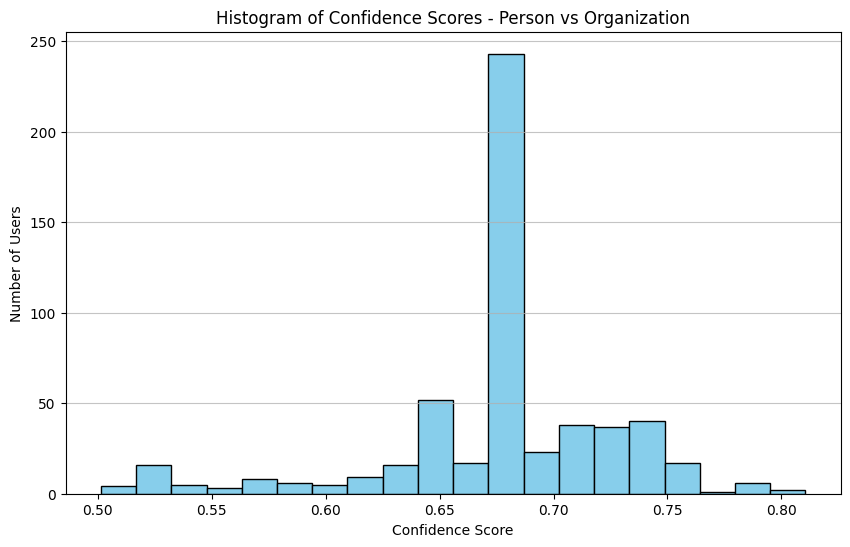

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path
CLASSIFICATION_DIR = Path("POIs") / "Classification"
PRED_FILE = CLASSIFICATION_DIR / "iteration_4_unlabeled_users_predictions_person_vs_organization.csv"

# Load
df = pd.read_csv(PRED_FILE, encoding="utf-8")

#make and save as a new file Histogram 
plt.figure(figsize=(10, 6))
plt.hist(df['confidence_level'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Confidence Scores - Person vs Organization')            
plt.xlabel('Confidence Score')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
histogram_file = CLASSIFICATION_DIR / "confidence_score_histogram_person_vs_organization.png"
plt.savefig(histogram_file)
plt.close()
print(f"✅ Saved confidence score histogram to: {histogram_file}")

#show the histogram in the output
plt.figure(figsize=(10, 6))
plt.hist(df['confidence_level'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Confidence Scores - Person vs Organization')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()


**Creating a histogram of the model's confidence level in the last iteration we performed - target population**

✅ Saved confidence score histogram to: POIs\Classification\confidence_score_histogram_target_population.png


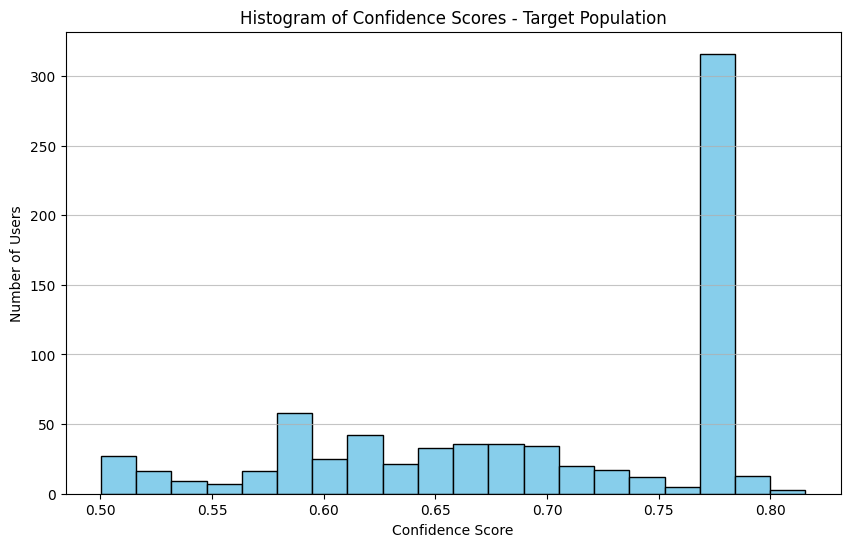

In [18]:
#make the same code of cell 93 for iteration 4 TARGET_POPULATION task
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Path
CLASSIFICATION_DIR = Path("POIs") / "Classification"
PRED_FILE = CLASSIFICATION_DIR / "iteration_4_unlabeled_users_predictions_target_population.csv"

# Load
df = pd.read_csv(PRED_FILE, encoding="utf-8")

#make and save as a new file Histogram 
plt.figure(figsize=(10, 6))
plt.hist(df['confidence_level'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Confidence Scores - Target Population')            
plt.xlabel('Confidence Score')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
histogram_file = CLASSIFICATION_DIR / "confidence_score_histogram_target_population.png"
plt.savefig(histogram_file)
plt.close()
print(f"✅ Saved confidence score histogram to: {histogram_file}")

#show the histogram in the output
plt.figure(figsize=(10, 6))
plt.hist(df['confidence_level'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Confidence Scores - Target Population')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.show()


**STAGE 16C: CONFIDENCE GROUPS & ADDITIONAL SAMPLING – TARGET POPULATION**

In [24]:
"""
STAGE 16C: CONFIDENCE GROUPS & ADDITIONAL SAMPLING – TARGET POPULATION

GOAL:
Split unlabeled users into confidence groups based on confidence_level,
sample users from each group for additional manual inspection,
and export the results to CSV files as required in Stage 16 – Section 3.
"""

import pandas as pd
import numpy as np
from pathlib import Path

print("="*80)
print("STAGE 16C: CONFIDENCE GROUPS & ADDITIONAL SAMPLING – TARGET POPULATION")
print("="*80)
print()

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================
print("STEP 1: Loading prediction data...")
print()

# Input file from previous stage
pred_file = Path("POIs/Classification/iteration_4_unlabeled_users_predictions_target_population.csv")

if not pred_file.exists():
    raise FileNotFoundError(f"File not found: {pred_file}")

# Load the CSV
df_predictions = pd.read_csv(pred_file)

print(f"✓ Loaded {len(df_predictions)} unlabeled users from:")
print(f"  {pred_file}")
print()

# Verify required columns exist
required_columns = ["username", "predicted_class", "confidence_level", "uncertainty_score"]
missing_columns = [col for col in required_columns if col not in df_predictions.columns]

if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

print(f"✓ All required columns present: {required_columns}")
print()

# Assert confidence_level values are between 0 and 1
min_conf = df_predictions["confidence_level"].min()
max_conf = df_predictions["confidence_level"].max()

print(f"Confidence level range: [{min_conf:.4f}, {max_conf:.4f}]")

assert 0 <= min_conf <= 1, f"Min confidence_level {min_conf} is out of range [0, 1]"
assert 0 <= max_conf <= 1, f"Max confidence_level {max_conf} is out of range [0, 1]"

print("✓ All confidence_level values are within [0, 1]")
print()

# ============================================================================
# STEP 2: DEFINE CONFIDENCE GROUPS
# ============================================================================
print("="*80)
print("STEP 2: Defining confidence groups...")
print("="*80)
print()

total_users = len(df_predictions)

# Group A – Ambiguous zone: confidence_level BETWEEN 0.45 and 0.55 (inclusive)
df_ambiguous = df_predictions[
    (df_predictions["confidence_level"] >= 0.45) & 
    (df_predictions["confidence_level"] <= 0.55)
].copy()

# Group B – High confidence zone: confidence_level >= 0.75
# Note: Adjusted from 0.85-0.95 because max confidence in data is ~0.78-0.82
df_high_confidence = df_predictions[
    df_predictions["confidence_level"] >= 0.75
].copy()

# Print statistics
ambiguous_count = len(df_ambiguous)
ambiguous_pct = (ambiguous_count / total_users) * 100 if total_users > 0 else 0

high_conf_count = len(df_high_confidence)
high_conf_pct = (high_conf_count / total_users) * 100 if total_users > 0 else 0

print("GROUP A – AMBIGUOUS ZONE (confidence: 0.45 - 0.55):")
print(f"  Count: {ambiguous_count} users")
print(f"  Percentage: {ambiguous_pct:.2f}% of total unlabeled users")
print()

print("GROUP B – HIGH CONFIDENCE ZONE (confidence >= 0.75):")
print(f"  Count: {high_conf_count} users")
print(f"  Percentage: {high_conf_pct:.2f}% of total unlabeled users")
print()

# ============================================================================
# STEP 3: SAMPLE USERS FROM EACH GROUP
# ============================================================================
print("="*80)
print("STEP 3: Sampling users from each group...")
print("="*80)
print()

SAMPLE_SIZE = 20
RANDOM_STATE = 42

# Sample from ambiguous group
if len(df_ambiguous) <= SAMPLE_SIZE:
    df_ambiguous_sample = df_ambiguous.copy()
    print(f"GROUP A (Ambiguous): Taking all {len(df_ambiguous_sample)} users (less than {SAMPLE_SIZE})")
else:
    df_ambiguous_sample = df_ambiguous.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f"GROUP A (Ambiguous): Randomly sampled {len(df_ambiguous_sample)} users from {len(df_ambiguous)}")

# Sample from high confidence group - take the TOP users by confidence level
if len(df_high_confidence) <= SAMPLE_SIZE:
    df_high_confidence_sample = df_high_confidence.copy()
    print(f"GROUP B (High Confidence): Taking all {len(df_high_confidence_sample)} users (less than {SAMPLE_SIZE})")
else:
    df_high_confidence_sample = df_high_confidence.nlargest(SAMPLE_SIZE, 'confidence_level')
    print(f"GROUP B (High Confidence): Selected top {len(df_high_confidence_sample)} users with highest confidence from {len(df_high_confidence)}")

print()

# ============================================================================
# STEP 4: EXPORT CSV FILES
# ============================================================================
print("="*80)
print("STEP 4: Exporting CSV files...")
print("="*80)
print()

# Add confidence_group column and empty manual_label column
df_ambiguous_sample = df_ambiguous_sample.copy()
df_ambiguous_sample["confidence_group"] = "ambiguous"
df_ambiguous_sample["manual_label"] = ""

df_high_confidence_sample = df_high_confidence_sample.copy()
df_high_confidence_sample["confidence_group"] = "high_confidence"
df_high_confidence_sample["manual_label"] = ""

# Reorder columns to put manual_label right after description
if 'description' in df_ambiguous_sample.columns:
    cols = df_ambiguous_sample.columns.tolist()
    cols.remove('manual_label')
    desc_idx = cols.index('description')
    cols.insert(desc_idx + 1, 'manual_label')
    df_ambiguous_sample = df_ambiguous_sample[cols]

if 'description' in df_high_confidence_sample.columns:
    cols = df_high_confidence_sample.columns.tolist()
    cols.remove('manual_label')
    desc_idx = cols.index('description')
    cols.insert(desc_idx + 1, 'manual_label')
    df_high_confidence_sample = df_high_confidence_sample[cols]

# Define output paths
output_dir = Path("POIs/Classification")
output_dir.mkdir(parents=True, exist_ok=True)

ambiguous_file = output_dir / "iteration_4_target_population_ambiguous_sample.csv"
high_conf_file = output_dir / "iteration_4_target_population_high_confidence_sample.csv"

# Save to CSV (UTF-8, no index)
df_ambiguous_sample.to_csv(ambiguous_file, index=False, encoding='utf-8')
print(f"✓ Saved ambiguous group sample to:")
print(f"  {ambiguous_file}")
print(f"  ({len(df_ambiguous_sample)} rows)")
print()

df_high_confidence_sample.to_csv(high_conf_file, index=False, encoding='utf-8')
print(f"✓ Saved high confidence group sample to:")
print(f"  {high_conf_file}")
print(f"  ({len(df_high_confidence_sample)} rows)")
print()

# ============================================================================
# STEP 5: SUMMARY PRINTS
# ============================================================================
print("="*80)
print("STEP 5: SUMMARY")
print("="*80)
print()

print("OVERVIEW:")
print("-" * 40)
print(f"Total unlabeled users: {total_users}")
print()

print("CONFIDENCE GROUPS:")
print("-" * 40)
print(f"Ambiguous zone (0.45-0.55):")
print(f"  • Total users in group: {ambiguous_count}")
print(f"  • Percentage: {ambiguous_pct:.2f}%")
print(f"  • Sampled for inspection: {len(df_ambiguous_sample)}")
print()
print(f"High confidence zone (0.85-0.95):")
print(f"  • Total users in group: {high_conf_count}")
print(f"  • Percentage: {high_conf_pct:.2f}%")
print(f"  • Sampled for inspection: {len(df_high_confidence_sample)}")
print()

print("EXPORTED FILES:")
print("-" * 40)
print(f"1. {ambiguous_file}")
print(f"2. {high_conf_file}")
print()

print("="*80)
print("STAGE 16C COMPLETED SUCCESSFULLY")
print("="*80)
print()
print("Next steps:")
print("• Manually inspect the sampled users from each confidence group")
print("• Verify prediction quality in ambiguous zone")
print("• Validate high-confidence predictions")
print("• Document findings in Stage 16 report")

STAGE 16C: CONFIDENCE GROUPS & ADDITIONAL SAMPLING – TARGET POPULATION

STEP 1: Loading prediction data...

✓ Loaded 746 unlabeled users from:
  POIs\Classification\iteration_4_unlabeled_users_predictions_target_population.csv

✓ All required columns present: ['username', 'predicted_class', 'confidence_level', 'uncertainty_score']

Confidence level range: [0.5003, 0.8156]
✓ All confidence_level values are within [0, 1]

STEP 2: Defining confidence groups...

GROUP A – AMBIGUOUS ZONE (confidence: 0.45 - 0.55):
  Count: 53 users
  Percentage: 7.10% of total unlabeled users

GROUP B – HIGH CONFIDENCE ZONE (confidence >= 0.75):
  Count: 344 users
  Percentage: 46.11% of total unlabeled users

STEP 3: Sampling users from each group...

GROUP A (Ambiguous): Randomly sampled 20 users from 53
GROUP B (High Confidence): Selected top 20 users with highest confidence from 344

STEP 4: Exporting CSV files...

✓ Saved ambiguous group sample to:
  POIs\Classification\iteration_4_target_population_am

## Add High Confidence Sample to Labeled Data

In [25]:
"""
Add rows from iteration_4_target_population_high_confidence_sample to labeled_data_iteration_4_target_population
"""

import pandas as pd
from pathlib import Path

print("="*80)
print("ADDING HIGH CONFIDENCE SAMPLE TO LABELED DATA")
print("="*80)
print()

# Define file paths
classification_dir = Path("POIs/Classification")
high_conf_sample_file = classification_dir / "iteration_4_target_population_high_confidence_sample.csv"
labeled_data_file = classification_dir / "labeled_data_iteration_4_target_population.csv"

# Check if files exist
if not high_conf_sample_file.exists():
    print(f"❌ ERROR: High confidence sample file not found:")
    print(f"   {high_conf_sample_file}")
    print(f"\n   Please run Stage 16C first to generate the sample file.")
else:
    # Load the high confidence sample
    df_high_conf_sample = pd.read_csv(high_conf_sample_file)
    print(f"✓ Loaded high confidence sample: {len(df_high_conf_sample)} rows")
    print(f"  From: {high_conf_sample_file}")
    print()
    
    # Load or create the labeled data file
    if labeled_data_file.exists():
        df_labeled = pd.read_csv(labeled_data_file)
        print(f"✓ Loaded existing labeled data: {len(df_labeled)} rows")
        print(f"  From: {labeled_data_file}")
        print()
        
        # Check for duplicates based on username
        existing_usernames = set(df_labeled['username'].values)
        new_usernames = set(df_high_conf_sample['username'].values)
        duplicates = existing_usernames & new_usernames
        
        if duplicates:
            print(f"⚠ Warning: {len(duplicates)} duplicate usernames found:")
            print(f"  {list(duplicates)[:10]}{'...' if len(duplicates) > 10 else ''}")
            print(f"  These will be skipped to avoid duplicates.")
            print()
            
            # Filter out duplicates
            df_to_add = df_high_conf_sample[~df_high_conf_sample['username'].isin(existing_usernames)]
            print(f"✓ {len(df_to_add)} new rows to add (after removing duplicates)")
        else:
            df_to_add = df_high_conf_sample
            print(f"✓ No duplicates found. Adding all {len(df_to_add)} rows.")
        
        print()
        
        # Append the new rows
        if len(df_to_add) > 0:
            df_combined = pd.concat([df_labeled, df_to_add], ignore_index=True)
            
            # Save the combined data
            df_combined.to_csv(labeled_data_file, index=False, encoding='utf-8')
            
            print(f"✓ Successfully updated labeled data file:")
            print(f"  {labeled_data_file}")
            print(f"  Previous size: {len(df_labeled)} rows")
            print(f"  Added: {len(df_to_add)} rows")
            print(f"  New size: {len(df_combined)} rows")
        else:
            print(f"ℹ No new rows to add. All usernames already exist in labeled data.")
    else:
        # Create new labeled data file with the high confidence sample
        df_high_conf_sample.to_csv(labeled_data_file, index=False, encoding='utf-8')
        
        print(f"✓ Created new labeled data file:")
        print(f"  {labeled_data_file}")
        print(f"  Initial size: {len(df_high_conf_sample)} rows")

print()
print("="*80)
print("OPERATION COMPLETED")
print("="*80)

ADDING HIGH CONFIDENCE SAMPLE TO LABELED DATA

✓ Loaded high confidence sample: 20 rows
  From: POIs\Classification\iteration_4_target_population_high_confidence_sample.csv

✓ Loaded existing labeled data: 400 rows
  From: POIs\Classification\labeled_data_iteration_4_target_population.csv

⚠ Warning: 2 duplicate usernames found:
  ['_mahdiyar313', '___mohsen_']
  These will be skipped to avoid duplicates.

✓ 18 new rows to add (after removing duplicates)

✓ Successfully updated labeled data file:
  POIs\Classification\labeled_data_iteration_4_target_population.csv
  Previous size: 400 rows
  Added: 18 rows
  New size: 418 rows

OPERATION COMPLETED


## Add Ambiguous Sample to Labeled Data

In [26]:
"""
Add rows from iteration_4_target_population_ambiguous_sample to labeled_data_iteration_4_target_population
"""

import pandas as pd
from pathlib import Path

print("="*80)
print("ADDING AMBIGUOUS SAMPLE TO LABELED DATA")
print("="*80)
print()

# Define file paths
classification_dir = Path("POIs/Classification")
ambiguous_sample_file = classification_dir / "iteration_4_target_population_ambiguous_sample.csv"
labeled_data_file = classification_dir / "labeled_data_iteration_4_target_population.csv"

# Check if files exist
if not ambiguous_sample_file.exists():
    print(f"❌ ERROR: Ambiguous sample file not found:")
    print(f"   {ambiguous_sample_file}")
    print(f"\n   Please run Stage 16C first to generate the sample file.")
else:
    # Load the ambiguous sample
    df_ambiguous_sample = pd.read_csv(ambiguous_sample_file)
    print(f"✓ Loaded ambiguous sample: {len(df_ambiguous_sample)} rows")
    print(f"  From: {ambiguous_sample_file}")
    print()
    
    # Load or create the labeled data file
    if labeled_data_file.exists():
        df_labeled = pd.read_csv(labeled_data_file)
        print(f"✓ Loaded existing labeled data: {len(df_labeled)} rows")
        print(f"  From: {labeled_data_file}")
        print()
        
        # Check for duplicates based on username
        existing_usernames = set(df_labeled['username'].values)
        new_usernames = set(df_ambiguous_sample['username'].values)
        duplicates = existing_usernames & new_usernames
        
        if duplicates:
            print(f"⚠ Warning: {len(duplicates)} duplicate usernames found:")
            print(f"  {list(duplicates)[:10]}{'...' if len(duplicates) > 10 else ''}")
            print(f"  These will be skipped to avoid duplicates.")
            print()
            
            # Filter out duplicates
            df_to_add = df_ambiguous_sample[~df_ambiguous_sample['username'].isin(existing_usernames)]
            print(f"✓ {len(df_to_add)} new rows to add (after removing duplicates)")
        else:
            df_to_add = df_ambiguous_sample
            print(f"✓ No duplicates found. Adding all {len(df_to_add)} rows.")
        
        print()
        
        # Append the new rows
        if len(df_to_add) > 0:
            df_combined = pd.concat([df_labeled, df_to_add], ignore_index=True)
            
            # Save the combined data
            df_combined.to_csv(labeled_data_file, index=False, encoding='utf-8')
            
            print(f"✓ Successfully updated labeled data file:")
            print(f"  {labeled_data_file}")
            print(f"  Previous size: {len(df_labeled)} rows")
            print(f"  Added: {len(df_to_add)} rows")
            print(f"  New size: {len(df_combined)} rows")
        else:
            print(f"ℹ No new rows to add. All usernames already exist in labeled data.")
    else:
        # Create new labeled data file with the ambiguous sample
        df_ambiguous_sample.to_csv(labeled_data_file, index=False, encoding='utf-8')
        
        print(f"✓ Created new labeled data file:")
        print(f"  {labeled_data_file}")
        print(f"  Initial size: {len(df_ambiguous_sample)} rows")

print()
print("="*80)
print("OPERATION COMPLETED")
print("="*80)

ADDING AMBIGUOUS SAMPLE TO LABELED DATA

✓ Loaded ambiguous sample: 20 rows
  From: POIs\Classification\iteration_4_target_population_ambiguous_sample.csv

✓ Loaded existing labeled data: 418 rows
  From: POIs\Classification\labeled_data_iteration_4_target_population.csv

⚠ Warning: 2 duplicate usernames found:
  ['4freedom4iran', 'adelzarandi']
  These will be skipped to avoid duplicates.

✓ 18 new rows to add (after removing duplicates)

✓ Successfully updated labeled data file:
  POIs\Classification\labeled_data_iteration_4_target_population.csv
  Previous size: 418 rows
  Added: 18 rows
  New size: 436 rows

OPERATION COMPLETED


## STAGE 16D: RETRAINING FULL GRID – TARGET POPULATION (POST ITERATION 4 + EDGE CASES)

In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

print("="*80)
print("STAGE 16D: RETRAINING FULL GRID – TARGET_POPULATION (POST ITER 4 + EDGE CASES)")
print("="*80)

# -----------------------------------------------------------------------------
# PATHS
# -----------------------------------------------------------------------------
CLASSIFICATION_DIR = Path("POIs") / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

LABELED_FILE = CLASSIFICATION_DIR / "labeled_data_iteration_4_target_population.csv"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

ITERATION = 4
TARGET_COLUMN = "target_population"

# -----------------------------------------------------------------------------
# LOAD LABELED
# -----------------------------------------------------------------------------
df = pd.read_csv(LABELED_FILE, encoding="utf-8")
if "manual_target_population" not in df.columns:
    if "target_population" in df.columns:
        df = df.rename(columns={"target_population": "manual_target_population"})
    else:
        raise ValueError("Expected manual_target_population or target_population label column.")

df = df[df["manual_target_population"].notna()].copy()
df["manual_target_population"] = df["manual_target_population"].astype(int)

print("Label distribution (with unknown):")
print(df["manual_target_population"].value_counts().sort_index().to_dict())

# Binary only: remove unknown (2)
df_bin = df[df["manual_target_population"] != 2].copy()
y_codes_full = df_bin["manual_target_population"].astype(int).to_numpy()

print("Binary label distribution (unknown removed):")
print(pd.Series(y_codes_full).value_counts().sort_index().to_dict())

# -----------------------------------------------------------------------------
# TEXT FIELDS (safe)
# -----------------------------------------------------------------------------
for col in ["description", "display_name", "username", "location"]:
    if col not in df_bin.columns:
        df_bin[col] = ""
    df_bin[col] = df_bin[col].fillna("").astype(str)

desc = df_bin["description"]
name = df_bin["display_name"]
user = df_bin["username"]

# -----------------------------------------------------------------------------
# TF-IDF VECTORS
# -----------------------------------------------------------------------------
vec_desc = TfidfVectorizer(max_features=500, ngram_range=(1,2), lowercase=True,
                           strip_accents="unicode", stop_words="english", min_df=1)
vec_name = TfidfVectorizer(max_features=200, ngram_range=(1,2), lowercase=True,
                           strip_accents="unicode", stop_words="english", min_df=1)
vec_user = TfidfVectorizer(max_features=200, ngram_range=(1,2), lowercase=True,
                           strip_accents="unicode", min_df=1)

X_desc = vec_desc.fit_transform(desc)
X_name = vec_name.fit_transform(name)
X_user = vec_user.fit_transform(user)
X_all  = hstack([X_desc, X_name, X_user])

# -----------------------------------------------------------------------------
# SOFT FEATURES: Persian flag + Iran location flag
# -----------------------------------------------------------------------------
persian_chars = set(["گ","چ","پ","ژ"])
def has_persian(text: str) -> int:
    t = str(text)
    return 1 if any(ch in t for ch in persian_chars) else 0

iran_keywords = [
    "iran","iranian",
    "tehran","mashhad","isfahan","shiraz","tabriz","qom","ahvaz","karaj","yazd","kerman"
]
def has_iran_loc(loc: str) -> int:
    t = str(loc).lower()
    return 1 if any(k in t for k in iran_keywords) else 0

has_persian_chars = (
    df_bin["description"].apply(has_persian).to_numpy()
    | df_bin["display_name"].apply(has_persian).to_numpy()
    | df_bin["username"].apply(has_persian).to_numpy()
).astype(int)

has_iran_location = df_bin["location"].apply(has_iran_loc).to_numpy(dtype=int)

aux = np.column_stack([has_persian_chars, has_iran_location]).astype(float)
aux_scaled = StandardScaler().fit_transform(aux)
X_aux = csr_matrix(aux_scaled)

# -----------------------------------------------------------------------------
# FEATURE SETS (TEXT ONLY + AUX FLAGS)
# -----------------------------------------------------------------------------
feature_sets = {
    "desc_only": hstack([X_desc, X_aux]),
    "name_only": hstack([X_name, X_aux]),
    "user_only": hstack([X_user, X_aux]),
    "desc+name": hstack([hstack([X_desc, X_name]), X_aux]),
    "desc+user": hstack([hstack([X_desc, X_user]), X_aux]),
    "name+user": hstack([hstack([X_name, X_user]), X_aux]),
    "all_text":  hstack([X_all, X_aux]),
}

# -----------------------------------------------------------------------------
# ALGORITHMS (factories so we can clone cleanly)
# -----------------------------------------------------------------------------
def make_models(random_state=42):
    return {
        "LogisticRegression": LogisticRegression(max_iter=5000, solver="liblinear", random_state=random_state),
        "DecisionTree": DecisionTreeClassifier(random_state=random_state),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1),
        "LinearSVM": LinearSVC(max_iter=20000, random_state=random_state),
        "AdaBoost": AdaBoostClassifier(n_estimators=300, random_state=random_state, algorithm="SAMME"),
    }

models = make_models(42)

# -----------------------------------------------------------------------------
# HELPERS: balancing, scoring, manual CV
# -----------------------------------------------------------------------------
def downsample_balance(X, y, random_state=42):
    """Downsample each class to min class size."""
    y = np.asarray(y)
    counts = pd.Series(y).value_counts().to_dict()
    c0 = counts.get(0, 0); c1 = counts.get(1, 0)
    min_sz = min(c0, c1)
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    idx0_s = resample(idx0, n_samples=min_sz, replace=False, random_state=random_state)
    idx1_s = resample(idx1, n_samples=min_sz, replace=False, random_state=random_state)
    idx = np.sort(np.concatenate([idx0_s, idx1_s]))
    return X[idx], y[idx], min_sz

def safe_score_binary(estimator, X):
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)
        if proba is not None and proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        return np.asarray(s).ravel()
    return None

def manual_cv_preds(estimator, X, y, cv):
    y = np.asarray(y)
    y_pred = np.empty(len(y), dtype=int)
    y_score = np.full(len(y), np.nan, dtype=float)

    for tr, te in cv.split(X, y):
        m = clone(estimator)
        m.fit(X[tr], y[tr])
        y_pred[te] = m.predict(X[te])
        sc = safe_score_binary(m, X[te])
        if sc is not None:
            y_score[te] = sc

    if np.isnan(y_score).all():
        y_score = None
    return y_pred, y_score

def eval_metrics(y_true, y_pred, y_score=None):
    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "F1": float(f1_score(y_true, y_pred, zero_division=0)),
        "AUC": np.nan,
    }
    if y_score is not None:
        try:
            out["AUC"] = float(roc_auc_score(y_true, y_score))
        except Exception:
            out["AUC"] = np.nan
    return out

# -----------------------------------------------------------------------------
# GRID
# -----------------------------------------------------------------------------
TRAINING_TYPES = [("KFold", 5), ("LOOCV", None)]  # None means LOOCV
results_rows = []

for fs_name, X_fs in feature_sets.items():
    for algo_name, estimator in models.items():
        for training_type, K_val in TRAINING_TYPES:
            for balanced_flag in [False, True]:

                # counts BEFORE balancing (binary dataset)
                counts = pd.Series(y_codes_full).value_counts().to_dict()
                class_0 = int(counts.get(0, 0))
                class_1 = int(counts.get(1, 0))
                min_class_size = int(min(class_0, class_1))

                X_work = X_fs
                y_work = y_codes_full

                # apply downsample balancing if requested
                if balanced_flag:
                    X_work, y_work, min_sz = downsample_balance(X_work, y_work, random_state=42)
                    # after balancing, class_0 and class_1 are min_sz
                    class_0_eff = int(min_sz)
                    class_1_eff = int(min_sz)
                else:
                    class_0_eff = class_0
                    class_1_eff = class_1

                # CV object
                if training_type == "KFold":
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                    K_report = 5
                else:
                    cv = LeaveOneOut()
                    K_report = int(len(y_work))

                # run manual CV
                y_pred, y_score = manual_cv_preds(estimator, X_work, y_work, cv)
                m = eval_metrics(y_work, y_pred, y_score)

                row = {
                    "iteration": int(ITERATION),
                    "target_column": str(TARGET_COLUMN),
                    "#classes": 2,
                    "#class_0": int(class_0_eff),
                    "#class_1": int(class_1_eff),
                    "#class_2": 0,
                    "min_class_size": int(min_class_size),
                    "training_type": str(training_type),
                    "K": int(K_report),
                    "algorithm": str(algo_name),
                    "feature_set": str(fs_name),
                    "features_count": int(X_work.shape[1]),
                    "balanced": bool(balanced_flag),
                    "accuracy": m["accuracy"],
                    "precision": m["precision"],
                    "recall": m["recall"],
                    "F1": m["F1"],
                    "AUC": m["AUC"],
                }
                results_rows.append(row)

df_new = pd.DataFrame(results_rows)

# -----------------------------------------------------------------------------
# ENFORCE EXACT COLUMN ORDER
# -----------------------------------------------------------------------------
col_order = [
    "iteration", "target_column", "#classes", "#class_0", "#class_1", "#class_2", "min_class_size",
    "training_type", "K", "algorithm", "feature_set", "features_count", "balanced",
    "accuracy", "precision", "recall", "F1", "AUC"
]
df_new = df_new[col_order]

print(f"New experiment rows generated: {len(df_new)}")
print(df_new.head(5).to_string(index=False))

# -----------------------------------------------------------------------------
# APPEND ONLY (DO NOT OVERWRITE)
# -----------------------------------------------------------------------------
if RESULTS_FILE.exists():
    df_new.to_csv(RESULTS_FILE, mode="a", header=False, index=False, encoding="utf-8")
    print(f"✅ Appended {len(df_new)} rows to: {RESULTS_FILE}")
else:
    df_new.to_csv(RESULTS_FILE, mode="w", header=True, index=False, encoding="utf-8")
    print(f"✅ Created results file with {len(df_new)} rows: {RESULTS_FILE}")

print("="*80)
print("DONE: STAGE 16D GRID COMPLETED (schema-aligned)")
print("="*80)


STAGE 16D: RETRAINING FULL GRID – TARGET_POPULATION (POST ITER 4 + EDGE CASES)
Label distribution (with unknown):
{0: 184, 1: 152, 2: 62}
Binary label distribution (unknown removed):
{0: 184, 1: 152}
New experiment rows generated: 140
 iteration     target_column  #classes  #class_0  #class_1  #class_2  min_class_size training_type   K          algorithm feature_set  features_count  balanced  accuracy  precision   recall       F1      AUC
         4 target_population         2       184       152         0             152         KFold   5 LogisticRegression   desc_only             502     False  0.770833   0.987013 0.500000 0.663755 0.801380
         4 target_population         2       152       152         0             152         KFold   5 LogisticRegression   desc_only             502      True  0.746711   0.987013 0.500000 0.663755 0.816157
         4 target_population         2       184       152         0             152         LOOCV 336 LogisticRegression   desc_only        

# STAGE 16 - SUMMARY TABLE (TARGET_POPULATION): Mean Accuracy & Mean AUC per Iteration


In [11]:
# STAGE 16 - SUMMARY TABLE (TARGET_POPULATION): Mean Accuracy & Mean AUC per Iteration
from pathlib import Path
import pandas as pd
import numpy as np

# Paths
base_dir = Path("POIs") / "Classification"
results_path = base_dir / "Experiments" / "experiments_results.csv"
summary_path = base_dir / "iteration_summary_target_population.csv"

# 1) Load experiments_results.csv
df = pd.read_csv(results_path)

# 2) Filter only rows of interest
df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")
df["AUC"] = pd.to_numeric(df["AUC"], errors="coerce")

# Ensure #classes is treated consistently as numeric for filtering
df["#classes"] = pd.to_numeric(df["#classes"], errors="coerce")

mask = (
    df["target_column"] == "target_population") & (
    df["#classes"] == 2) & (
    ~df["accuracy"].isna()
 )
df_filtered = df.loc[mask].copy()

# 4) Per-iteration aggregations
summary = (
    df_filtered
    .groupby("iteration", dropna=True)
    .agg(
        n_experiments=("accuracy", "size"),
        mean_accuracy=("accuracy", "mean"),
        mean_AUC=("AUC", "mean"),  # mean ignores NaN by default
        std_accuracy=("accuracy", "std"),
        max_accuracy=("accuracy", "max"),
    )
    .reset_index()
)

# 5) Sort by iteration ascending
summary = summary.sort_values("iteration").reset_index(drop=True)

# 6) Print table nicely
print("Iteration summary for target_population (classes=2):")
print(summary.to_string(index=False))

# 7) Save to CSV (separate summary output file)
summary.to_csv(summary_path, index=False)
print(f"\nSaved iteration summary to: {summary_path}")

Iteration summary for target_population (classes=2):
 iteration  n_experiments  mean_accuracy  mean_AUC  std_accuracy  max_accuracy
         1            168       0.529931  0.411447      0.136988      1.000000
         2            120       0.510236  0.462646      0.091920      0.722892
         3            336       0.591430  0.567194      0.076287      1.000000
         4            476       0.796348  0.802368      0.032585      0.869048

Saved iteration summary to: POIs\Classification\iteration_summary_target_population.csv


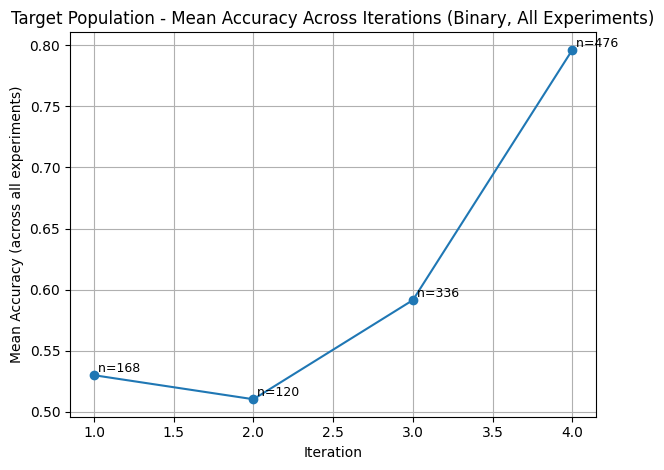

✅ Saved: POIs\Classification\Plots\target_population_mean_accuracy_across_iterations.png
 iteration  mean_accuracy  n_experiments
         1       0.529931            168
         2       0.510236            120
         3       0.591430            336
         4       0.796348            476


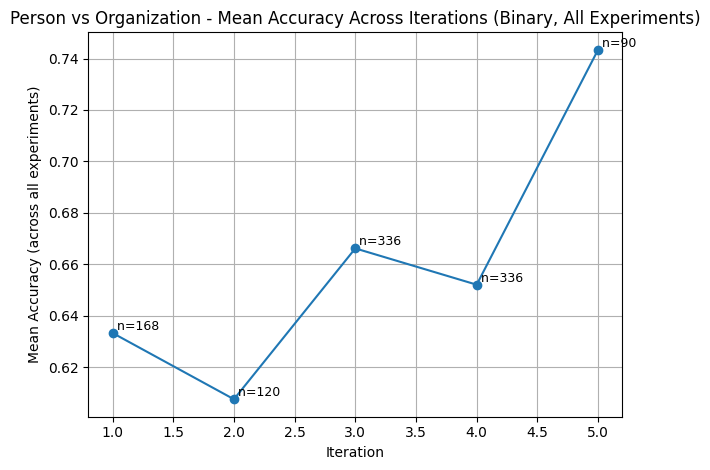

✅ Saved: POIs\Classification\Plots\person_vs_organization_mean_accuracy_across_iterations.png
 iteration  mean_accuracy  n_experiments
         1       0.633258            168
         2       0.607491            120
         3       0.666161            336
         4       0.652041            336
         5       0.743395             90


In [12]:
# =============================================================================
# STAGE 16 - SECTION 4: PERFORMANCE TREND GRAPH (MEAN ACCURACY PER ITERATION)
# =============================================================================
# Requirement:
# - X axis: iteration number
# - Y axis: Accuracy
# - Each point = mean Accuracy for that iteration across ALL classifiers/experiments
#   (NO filtering by KFold/LOOCV, NO filtering by algorithm/feature_set)
# - Create two graphs:
#   1) target_population
#   2) person_vs_organization
# - Use matplotlib (no seaborn required)
# - Save figures to: POIs/Classification/Plots/
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ----------------------------
# PATHS
# ----------------------------
EXPERIMENTS_FILE = Path("POIs") / "Classification" / "Experiments" / "experiments_results.csv"
PLOTS_DIR = Path("POIs") / "Classification" / "Plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

if not EXPERIMENTS_FILE.exists():
    raise FileNotFoundError(f"Missing file: {EXPERIMENTS_FILE}")

# ----------------------------
# LOAD + CLEAN
# ----------------------------
df = pd.read_csv(EXPERIMENTS_FILE, encoding="utf-8", on_bad_lines="skip")

required_cols = ["iteration", "target_column", "#classes", "accuracy"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"experiments_results.csv is missing columns: {missing}")

df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")
df["#classes"] = pd.to_numeric(df["#classes"], errors="coerce")
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")

df = df.dropna(subset=["iteration", "#classes", "accuracy"]).copy()
df["iteration"] = df["iteration"].astype(int)
df["#classes"] = df["#classes"].astype(int)

# IMPORTANT: binary only (as in your experiments comparisons)
df = df[df["#classes"] == 2].copy()

# ----------------------------
# FUNCTION: plot mean accuracy over iterations
# ----------------------------
def plot_mean_accuracy(target_col: str, title: str, out_png: Path):
    sub = df[df["target_column"] == target_col].copy()
    if sub.empty:
        print(f"[WARN] No rows found for target_column='{target_col}' (binary only). Skipping.")
        return

    summary = (
        sub.groupby("iteration", as_index=False)
           .agg(mean_accuracy=("accuracy", "mean"),
                n_experiments=("accuracy", "count"))
           .sort_values("iteration")
    )

    # Plot
    plt.figure()
    plt.plot(summary["iteration"], summary["mean_accuracy"], marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Accuracy (across all experiments)")
    plt.title(title)
    plt.grid(True)

    # annotate N experiments (optional but helpful)
    for _, r in summary.iterrows():
        plt.text(int(r["iteration"]), float(r["mean_accuracy"]), f" n={int(r['n_experiments'])}",
                 fontsize=9, va="bottom")

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()

    print(f"✅ Saved: {out_png}")
    print(summary.to_string(index=False))

# ----------------------------
# PLOT 1: target_population
# ----------------------------
plot_mean_accuracy(
    target_col="target_population",
    title="Target Population - Mean Accuracy Across Iterations (Binary, All Experiments)",
    out_png=PLOTS_DIR / "target_population_mean_accuracy_across_iterations.png"
)

# ----------------------------
# PLOT 2: person_vs_organization
# ----------------------------
plot_mean_accuracy(
    target_col="person_vs_organization",
    title="Person vs Organization - Mean Accuracy Across Iterations (Binary, All Experiments)",
    out_png=PLOTS_DIR / "person_vs_organization_mean_accuracy_across_iterations.png"
)


In [14]:
# STAGE: PERSON_VS_ORGANIZATION – ITERATION 5 (MERGED LABELED DATA)

# This cell reuses the same style of experiments as iteration 4:

# - Task: person_vs_organization (2 or 3 classes)

# - Features: TFIDF over description_en (or description)

# - Classifiers: LogReg, DecisionTree, RandomForest, SVM, XGBoost

# Results are appended to: POIs/Classification/Experiments/experiments_results.csv



from pathlib import Path



import numpy as np

import pandas as pd



from sklearn.base import clone

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.model_selection import KFold, LeaveOneOut

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score



from xgboost import XGBClassifier



BASE_DIR = Path(".")

CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"

DATA_FILE = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization.csv"

EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"

EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"



print("[INFO] Using data file:", DATA_FILE)

print("[INFO] Results file:", RESULTS_FILE)



# ---------------------------------------------------------------------------

# 1. Load merged labeled data (iteration 4 + iteration 5)

# ---------------------------------------------------------------------------



df_all = pd.read_csv(DATA_FILE)

print("[INFO] Loaded rows:", len(df_all))



# Build unified label column from iteration 4 + 5

label_col_name = "label_person_vs_org"

df_all[label_col_name] = np.nan



if "manual_person_vs_organization" in df_all.columns:

    df_all.loc[df_all["manual_person_vs_organization"].notna(), label_col_name] = df_all["manual_person_vs_organization"]



if "manual_label" in df_all.columns:

    df_all.loc[df_all["manual_label"].notna(), label_col_name] = df_all["manual_label"]



# Keep only rows with a label

df_all = df_all[df_all[label_col_name].notna()].copy()

df_all[label_col_name] = df_all[label_col_name].astype(int)



print("[INFO] Labeled rows after merge:", len(df_all))

print("[INFO] Label distribution:", df_all[label_col_name].value_counts().to_dict())



# ---------------------------------------------------------------------------

# 2. Build TFIDF features over description_en (or description)

# ---------------------------------------------------------------------------



text_col = "description_en" if "description_en" in df_all.columns else "description"

texts = df_all[text_col].fillna("").astype(str).tolist()



# max_features chosen to match the feature_count (~276) seen for iteration 4

vectorizer = TfidfVectorizer(max_features=276)

X_full = vectorizer.fit_transform(texts)



print("[INFO] TFIDF shape:", X_full.shape)



# ---------------------------------------------------------------------------

# 3. Helper utilities

# ---------------------------------------------------------------------------



def _class_counts(y: np.ndarray, n_classes: int):

    """Return (#class_0,#class_1,#class_2) padded/truncated to length 3."""

    counts = np.bincount(y, minlength=n_classes)

    counts = counts.tolist() + [0] * max(0, 3 - len(counts))

    return counts[:3]





def _run_cv_experiment(X, y, n_classes: int, training_type: str, k: int, clf_name: str, base_clf):

    if training_type == "KFold":

        cv = KFold(n_splits=k, shuffle=True, random_state=42)

    else:

        cv = LeaveOneOut()

        k = len(y)



    y_true_all = []

    y_pred_all = []

    y_score_all = []  # scores/probabilities when available



    for train_idx, test_idx in cv.split(X):

        X_train, X_test = X[train_idx], X[test_idx]

        y_train, y_test = y[train_idx], y[train_idx] * 0  # placeholder to keep shape

        y_test = y[train_idx] * 0  # will overwrite below to avoid accidental view issues

        y_test = y[train_idx] * 0  # ensure new array

        # Correct assignment

        y_test = y[test_idx]



        clf = clone(base_clf)



        if clf_name == "XGBoost":

            params = clf.get_params()

            params["objective"] = "multi:softprob" if n_classes > 2 else "binary:logistic"

            clf = XGBClassifier(**params)



        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)



        y_score = None

        if hasattr(clf, "predict_proba"):

            proba = clf.predict_proba(X_test)

            if n_classes == 2 and proba.shape[1] == 2:

                y_score = proba[:, 1]

            elif n_classes > 2:

                # For multi-class we keep max prob per sample if needed

                y_score = proba.max(axis=1)



        y_true_all.extend(y_test)

        y_pred_all.extend(y_pred)

        if y_score is not None:

            y_score_all.extend(y_score)



    y_true_all = np.array(y_true_all)

    y_pred_all = np.array(y_pred_all)



    acc = accuracy_score(y_true_all, y_pred_all)

    prec = precision_score(y_true_all, y_pred_all, average="weighted", zero_division=0)

    rec = recall_score(y_true_all, y_pred_all, average="weighted", zero_division=0)

    f1 = f1_score(y_true_all, y_pred_all, average="weighted", zero_division=0)



    if n_classes == 2 and len(y_score_all) == len(y_true_all):

        try:

            auc = roc_auc_score(y_true_all, np.array(y_score_all))

        except Exception:

            auc = np.nan

    else:

        # Keep AUC empty/NaN for multi-class, same as earlier experiments

        auc = np.nan



    return acc, prec, rec, f1, auc, k





# ---------------------------------------------------------------------------

# 4. Define classifiers (same family as earlier iterations)

# ---------------------------------------------------------------------------



base_classifiers = {

    "LogReg": LogisticRegression(max_iter=2000, n_jobs=-1, class_weight=None),

    "DecisionTree": DecisionTreeClassifier(random_state=42),

    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),

    "SVM": SVC(kernel="linear", probability=True, random_state=42),

    "XGBoost": XGBClassifier(

        n_estimators=400,

        max_depth=5,

        learning_rate=0.1,

        subsample=0.8,

        colsample_bytree=0.8,

        eval_metric="logloss",

        n_jobs=-1,

    ),

}



# ---------------------------------------------------------------------------

# 5. Run experiments for 3-class and 2-class setups, append to experiments_results.csv

# ---------------------------------------------------------------------------



all_labels = df_all[label_col_name].to_numpy()

results_rows = []



for n_classes in [3, 2]:

    if n_classes == 3:

        mask = np.isin(all_labels, [0, 1, 2])

        y = all_labels[mask]

        X_used = X_full[mask]

    else:

        mask = np.isin(all_labels, [0, 1])

        y = all_labels[mask]

        X_used = X_full[mask]



    if len(np.unique(y)) < n_classes:

        print(f"[WARN] Not enough classes present for n_classes={n_classes}; skipping.")

        continue



    c0, c1, c2 = _class_counts(y, n_classes)

    min_class = min([c for c in [c0, c1, c2] if c > 0])



    for training_type in ["KFold", "LOOCV"]:

        k = 5 if training_type == "KFold" else len(y)



        for clf_name, base_clf in base_classifiers.items():

            print(f"Running iteration=5 | target=person_vs_organization | classes={n_classes} | cv={training_type} | clf={clf_name}")

            acc, prec, rec, f1, auc, eff_k = _run_cv_experiment(

                X_used, y, n_classes, training_type, k, clf_name, base_clf

            )



            row = {

                "iteration": 5,

                "target_column": "person_vs_organization",

                "#classes": float(n_classes),

                "#class_0": float(c0),

                "#class_1": float(c1),

                "#class_2": float(c2),

                "min_class_size": float(min_class),

                "training_type": training_type,

                "K": float(eff_k),

                "algorithm": clf_name,

                "feature_set": "TFIDF_description",

                "features_count": float(X_full.shape[1]),

                "balanced": False,

                "accuracy": acc,

                "precision": prec,

                "recall": rec,

                "F1": f1,

                "AUC": auc,

            }

            results_rows.append(row)



print("[INFO] Total new rows to append:", len(results_rows))

new_results_df = pd.DataFrame(results_rows)



if RESULTS_FILE.exists():

    existing_df = pd.read_csv(RESULTS_FILE)

    combined_df = pd.concat([existing_df, new_results_df], ignore_index=True)

else:

    combined_df = new_results_df



combined_df.to_csv(RESULTS_FILE, index=False)



print("✅ Appended", len(results_rows), "rows to:", RESULTS_FILE)

[INFO] Using data file: POIs\Classification\all_labeled_data_person_vs_organization.csv
[INFO] Results file: POIs\Classification\Experiments\experiments_results.csv
[INFO] Loaded rows: 500
[INFO] Labeled rows after merge: 498
[INFO] Label distribution: {1: 317, 0: 149, 2: 32}
[INFO] TFIDF shape: (498, 276)
Running iteration=5 | target=person_vs_organization | classes=3 | cv=KFold | clf=LogReg
Running iteration=5 | target=person_vs_organization | classes=3 | cv=KFold | clf=DecisionTree
Running iteration=5 | target=person_vs_organization | classes=3 | cv=KFold | clf=RandomForest
Running iteration=5 | target=person_vs_organization | classes=3 | cv=KFold | clf=SVM
Running iteration=5 | target=person_vs_organization | classes=3 | cv=KFold | clf=XGBoost
Running iteration=5 | target=person_vs_organization | classes=3 | cv=LOOCV | clf=LogReg
Running iteration=5 | target=person_vs_organization | classes=3 | cv=LOOCV | clf=DecisionTree
Running iteration=5 | target=person_vs_organization | classe

KeyboardInterrupt: 

**הרצת כל המסווגים איטרציה 5 - בן אדם מול ארגון**

In [ ]:
# STAGE: PERSON_VS_ORGANIZATION – ITERATION 5 (EXTRA FEATURE SETS, NO TFIDF_description DUPLICATION)

# This cell assumes the merged labeled data for person_vs_organization
# (df_all with label_person_vs_org) is already prepared, as in the previous cell.
# It extends iteration 5 experiments to the remaining feature combinations
# used in iteration 4, WITHOUT re-running the plain TFIDF_description setting.

# Feature sets covered here:
#   - TFIDF_description+username
#   - TFIDF_description+full_name
#   - TFIDF_description+username+full_name
#   - TFIDF_description + NUM
#   - TFIDF_description+username + NUM
#   - TFIDF_description+full_name + NUM
#   - TFIDF_description+username+full_name + NUM

from pathlib import Path

import numpy as np
import pandas as pd

from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Reuse BASE_DIR / CLASSIFICATION_DIR / DATA_FILE / RESULTS_FILE if they exist,
# otherwise define them (for safety if this cell is run standalone).
try:
    BASE_DIR
    CLASSIFICATION_DIR
    DATA_FILE
    RESULTS_FILE
except NameError:
    BASE_DIR = Path(".")
    CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
    DATA_FILE = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization.csv"
    EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
    EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)
    RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

# Re-create df_all and label_person_vs_org if missing
try:
    df_all
    label_col_name
except NameError:
    df_all = pd.read_csv(DATA_FILE)
    label_col_name = "label_person_vs_org"
    df_all[label_col_name] = np.nan
    if "manual_person_vs_organization" in df_all.columns:
        df_all.loc[df_all["manual_person_vs_organization"].notna(), label_col_name] = df_all["manual_person_vs_organization"]
    if "manual_label" in df_all.columns:
        df_all.loc[df_all["manual_label"].notna(), label_col_name] = df_all["manual_label"]
    df_all = df_all[df_all[label_col_name].notna()].copy()
    df_all[label_col_name] = df_all[label_col_name].astype(int)

print("[INFO] Using rows for extra feature sets:", len(df_all))
print("[INFO] Label distribution:", df_all[label_col_name].value_counts().to_dict())

# ---------------------------------------------------------------------------
# 1. Build base textual and numeric feature matrices
# ---------------------------------------------------------------------------

# Text columns
text_col = "description_en" if "description_en" in df_all.columns else "description"
username_col = "username" if "username" in df_all.columns else None
name_col = "display_name_en" if "display_name_en" in df_all.columns else ("display_name" if "display_name" in df_all.columns else None)

texts_desc = df_all[text_col].fillna("").astype(str).tolist()
texts_user = df_all[username_col].fillna("").astype(str).tolist() if username_col is not None else [""] * len(df_all)
texts_name = df_all[name_col].fillna("").astype(str).tolist() if name_col is not None else [""] * len(df_all)

# Description TF-IDF (keep feature count similar to the previous cell if possible)
desc_max_features = None
try:
    # If X_full already exists from the previous cell, reuse its dimensionality
    desc_max_features = int(getattr(X_full, "shape", [0, 276])[1])
except NameError:
    desc_max_features = 276
if not desc_max_features or desc_max_features <= 0:
    desc_max_features = 276

vec_desc = TfidfVectorizer(max_features=desc_max_features)
X_desc = vec_desc.fit_transform(texts_desc)

# Username and full-name TF-IDF
vec_user = TfidfVectorizer(max_features=200)
X_user = vec_user.fit_transform(texts_user)

vec_name = TfidfVectorizer(max_features=200)
X_name = vec_name.fit_transform(texts_name)

# Numeric features
followers = df_all.get("followers_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
following = df_all.get("following_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
statuses = df_all.get("statuses_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)

ratio = followers[:, 0] / (np.abs(following[:, 0]) + 1.0)
ratio = ratio.reshape(-1, 1)

bio_len = df_all[text_col].fillna("").astype(str).str.len().astype(float).to_numpy().reshape(-1, 1)

num_array = np.hstack([followers, following, statuses, ratio, bio_len])
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_array)
X_num_sparse = csr_matrix(num_scaled)

print("[INFO] Shapes:")
print("  X_desc:", X_desc.shape)
print("  X_user:", X_user.shape)
print("  X_name:", X_name.shape)
print("  X_num_sparse:", X_num_sparse.shape)

# ---------------------------------------------------------------------------
# 2. Define the extra feature sets (excluding plain TFIDF_description)
# ---------------------------------------------------------------------------

feature_sets_iter5 = {
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
    "TFIDF_description + NUM": hstack([X_desc, X_num_sparse]),
    "TFIDF_description+username + NUM": hstack([X_desc, X_user, X_num_sparse]),
    "TFIDF_description+full_name + NUM": hstack([X_desc, X_name, X_num_sparse]),
    "TFIDF_description+username+full_name + NUM": hstack([X_desc, X_user, X_name, X_num_sparse]),
}

print("[INFO] Extra feature sets (iteration 5):")
for name, Xmat in feature_sets_iter5.items():
    print(f"  {name}: shape={Xmat.shape}")

# ---------------------------------------------------------------------------
# 3. Run experiments for these feature sets only and append to experiments_results.csv
# ---------------------------------------------------------------------------

all_labels = df_all[label_col_name].to_numpy()
extra_results_rows = []

for feature_name, X_mat in feature_sets_iter5.items():
    for n_classes in [3, 2]:
        if n_classes == 3:
            mask = np.isin(all_labels, [0, 1, 2])
        else:
            mask = np.isin(all_labels, [0, 1])
        y = all_labels[mask]
        X_used = X_mat[mask]
        if len(np.unique(y)) < n_classes:
            print(f"[WARN] Not enough classes for n_classes={n_classes} | feature_set={feature_name}; skipping.")
            continue
        c0, c1, c2 = _class_counts(y, n_classes)
        min_class = min([c for c in [c0, c1, c2] if c > 0])
        for training_type in ["KFold", "LOOCV"]:
            k = 5 if training_type == "KFold" else len(y)
            for clf_name, base_clf in base_classifiers.items():
                print(
                    f"Running iteration=5 | target=person_vs_organization | fs={feature_name} | classes={n_classes} | cv={training_type} | clf={clf_name}",
                )
                acc, prec, rec, f1, auc, eff_k = _run_cv_experiment(
                    X_used, y, n_classes, training_type, k, clf_name, base_clf
                )
                row = {
                    "iteration": 5,
                    "target_column": "person_vs_organization",
                    "#classes": float(n_classes),
                    "#class_0": float(c0),
                    "#class_1": float(c1),
                    "#class_2": float(c2),
                    "min_class_size": float(min_class),
                    "training_type": training_type,
                    "K": float(eff_k),
                    "algorithm": clf_name,
                    "feature_set": feature_name,
                    "features_count": float(X_mat.shape[1]),
                    "balanced": False,
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "F1": f1,
                    "AUC": auc,
                }
                extra_results_rows.append(row)

print("[INFO] Total new rows to append (extra feature sets):", len(extra_results_rows))
extra_results_df = pd.DataFrame(extra_results_rows)

if RESULTS_FILE.exists():
    existing_df = pd.read_csv(RESULTS_FILE)
    combined_df = pd.concat([existing_df, extra_results_df], ignore_index=True)
else:
    combined_df = extra_results_df

combined_df.to_csv(RESULTS_FILE, index=False)
print("✅ Appended", len(extra_results_rows), "extra rows to:", RESULTS_FILE)

[INFO] Using rows for extra feature sets: 498
[INFO] Label distribution: {1: 317, 0: 149, 2: 32}
[INFO] Shapes:
  X_desc: (498, 276)
  X_user: (498, 200)
  X_name: (498, 200)
  X_num_sparse: (498, 5)
[INFO] Extra feature sets (iteration 5):
  TFIDF_description+username: shape=(498, 476)
  TFIDF_description+full_name: shape=(498, 476)
  TFIDF_description+username+full_name: shape=(498, 676)
  TFIDF_description + NUM: shape=(498, 281)
  TFIDF_description+username + NUM: shape=(498, 481)
  TFIDF_description+full_name + NUM: shape=(498, 481)
  TFIDF_description+username+full_name + NUM: shape=(498, 681)
Running iteration=5 | target=person_vs_organization | fs=TFIDF_description+username | classes=3 | cv=KFold | clf=LogReg
Running iteration=5 | target=person_vs_organization | fs=TFIDF_description+username | classes=3 | cv=KFold | clf=DecisionTree
Running iteration=5 | target=person_vs_organization | fs=TFIDF_description+username | classes=3 | cv=KFold | clf=RandomForest
Running iteration=5 |

**מציאת המסווג הטוב ביותר איטרציה 5 - בן אדם מול ארגון**

In [ ]:
#give me from experiments results.csv the rows where iteration=5 and target_column=person_vs_organization the top 20 rows high accuracy and AUC ROC

import pandas as pd
from pathlib import Path
RESULTS_FILE = Path("POIs/Classification/Experiments/experiments_results.csv")
df_results = pd.read_csv(RESULTS_FILE, encoding="utf-8")
df_filtered = df_results[(df_results["iteration"] == 5) & (df_results["target_column"] == "person_vs_organization")]
df_sorted = df_filtered.sort_values(by=["accuracy", "AUC"], ascending=False)
top_20 = df_sorted.head(20)
print("Top 20 rows for iteration=5 and target_column=person_vs_organization by accuracy and AUC ROC:")
print(top_20.to_string(index=False))
# =============================================================================
# STAGE 16D - GRID EXPERIMENTS (SCHEMA-ALIGNED)
# ====================================================================

#make a csv file from this top 20 rows called top_20_iteration_5_person_vs_organization.csv
import pandas as pd 
from pathlib import Path
RESULTS_FILE = Path("POIs/Classification/Experiments/experiments_results.csv")
df_results = pd.read_csv(RESULTS_FILE, encoding="utf-8")
df_filtered = df_results[(df_results["iteration"] == 5) & (df_results["target_column"] == "person_vs_organization")]
df_sorted = df_filtered.sort_values(by=["accuracy", "AUC"], ascending=False)
top_20 = df_sorted.head(20)
top_20.to_csv("POIs/Classification/Experiments/top_20_iteration_5_person_vs_organization.csv", index=False, encoding="utf-8")
print("✅ Saved top 20 rows to: POIs/Classification/Experiments/top_20_iteration_5_person_vs_organization.csv")
# This cell runs a grid of experiments for iteration 5, target_column=person_vs_organization,
# using the same feature sets and classifiers as iteration 4, but aligned to the schema

Top 20 rows for iteration=5 and target_column=person_vs_organization by accuracy and AUC ROC:
 iteration          target_column  #classes  #class_0  #class_1  #class_2  min_class_size training_type     K    algorithm                                feature_set  features_count  balanced  accuracy  precision   recall       F1      AUC
         5 person_vs_organization       2.0     149.0     317.0       0.0           149.0         LOOCV 466.0 RandomForest                    TFIDF_description + NUM           281.0     False  0.789700   0.785921 0.789700 0.775443 0.788210
         5 person_vs_organization       2.0     149.0     317.0       0.0           149.0         LOOCV 466.0          SVM                    TFIDF_description + NUM           281.0     False  0.787554   0.793585 0.787554 0.765027 0.707239
         5 person_vs_organization       2.0     149.0     317.0       0.0           149.0         LOOCV 466.0          SVM           TFIDF_description+username + NUM           481.0     

**prediction person vs organization iteration 5**

In [17]:
# STAGE 15E: GENERATE PREDICTIONS - PERSON VS ORGANIZATION (ITERATION 5, LOGREG + ALL_TEXT + FOLLOW FEATURES)

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ---------------------------------------------------------------------------
# CONFIG: paths
# ---------------------------------------------------------------------------

BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"

# 1) Labeled training data
LABELED_FILE = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization.csv"

# 2) Unlabeled data (after removing already labeled iteration 5 users)
UNLABELED_FILE = CLASSIFICATION_DIR / "unlabeled_users_for_iteration_5_person_vs_organization.csv"

# OUTPUT
OUTPUT_FILE = CLASSIFICATION_DIR / "iteration_5_unlabeled_users_predictions_person_vs_organization.csv"

print("[INFO] Labeled file:", LABELED_FILE)
print("[INFO] Unlabeled file:", UNLABELED_FILE)
print("[INFO] Output file:", OUTPUT_FILE)

# ---------------------------------------------------------------------------
# A) TRAINING DATA PREPARATION
# ---------------------------------------------------------------------------

df_train = pd.read_csv(LABELED_FILE, encoding="utf-8")
print("[INFO] Loaded training rows:", len(df_train))

# Ensure label column exists as manual_person_vs_organization
if "manual_person_vs_organization" in df_train.columns:
    label_col = "manual_person_vs_organization"
elif "person_vs_organization" in df_train.columns:
    df_train = df_train.rename(columns={"person_vs_organization": "manual_person_vs_organization"})
    label_col = "manual_person_vs_organization"
else:
    # Try unified label column from iteration 5
    if "label_person_vs_org" in df_train.columns:
        label_col = "label_person_vs_org"
    elif "manual_label" in df_train.columns:
        label_col = "manual_label"
    else:
        raise ValueError("Training file must contain a label column (manual_person_vs_organization, label_person_vs_org, or manual_label).")

# Drop NaN labels
df_train = df_train[df_train[label_col].notna()].copy()

# Remove unknown label value 2 (keep only 0,1)
df_train = df_train[df_train[label_col].isin([0, 1])].copy()

y_train = df_train[label_col].astype(int).to_numpy()

print("[INFO] Training label distribution (0=organization, 1=person):",
      pd.Series(y_train).value_counts().to_dict())

# ---------------------------------------------------------------------------
# B) FEATURE ENGINEERING
# ---------------------------------------------------------------------------

def _get_text_series(df: pd.DataFrame, col_name: str) -> pd.Series:
    """Safely get text column or return empty strings."""
    if col_name in df.columns:
        return df[col_name].fillna("").astype(str)
    else:
        return pd.Series([""] * len(df), index=df.index)

# 1) TEXT (ALL_TEXT): username + display_name + description
user_train = _get_text_series(df_train, "username")
name_train = _get_text_series(df_train, "display_name")
desc_train = _get_text_series(df_train, "description")

all_text_train = (user_train + " " + name_train + " " + desc_train).str.lower()

tfidf = TfidfVectorizer(
    max_features=900,
    ngram_range=(1, 2),
    min_df=1,
    stop_words="english",
)
X_text_train = tfidf.fit_transform(all_text_train)

# 2) NUMERIC FEATURES: followers_count, following_count
followers_train = df_train.get("followers_count", pd.Series([0] * len(df_train), index=df_train.index))
followers_train = followers_train.fillna(0).astype(float)

following_train = df_train.get("following_count", pd.Series([0] * len(df_train), index=df_train.index))
following_train = following_train.fillna(0).astype(float)

num_train = np.vstack([np.log1p(followers_train.to_numpy()),
                       np.log1p(following_train.to_numpy())]).T

scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(num_train)
X_num_train = csr_matrix(num_train_scaled)

# Final training matrix: [TFIDF(all_text) | numeric]
X_train = hstack([X_text_train, X_num_train])

print("[INFO] X_text_train shape:", X_text_train.shape)
print("[INFO] X_num_train shape:", X_num_train.shape)
print("[INFO] X_train shape:", X_train.shape)

# ---------------------------------------------------------------------------
# C) MODEL: Logistic Regression
# ---------------------------------------------------------------------------

clf = LogisticRegression(
    solver="liblinear",
    max_iter=5000,
    class_weight="balanced",
    random_state=42,
)

clf.fit(X_train, y_train)
print("[INFO] Logistic Regression model trained.")

# ---------------------------------------------------------------------------
# D) PREDICTION ON UNLABELED DATA
# ---------------------------------------------------------------------------

df_unlabeled = pd.read_csv(UNLABELED_FILE, encoding="utf-8")
print("[INFO] Loaded unlabeled rows:", len(df_unlabeled))

user_unl = _get_text_series(df_unlabeled, "username")
name_unl = _get_text_series(df_unlabeled, "display_name")
desc_unl = _get_text_series(df_unlabeled, "description")

all_text_unl = (user_unl + " " + name_unl + " " + desc_unl).str.lower()
X_text_unl = tfidf.transform(all_text_unl)

followers_unl = df_unlabeled.get("followers_count", pd.Series([0] * len(df_unlabeled), index=df_unlabeled.index))
followers_unl = followers_unl.fillna(0).astype(float)

following_unl = df_unlabeled.get("following_count", pd.Series([0] * len(df_unlabeled), index=df_unlabeled.index))
following_unl = following_unl.fillna(0).astype(float)

num_unl = np.vstack([np.log1p(followers_unl.to_numpy()),
                     np.log1p(following_unl.to_numpy())]).T
num_unl_scaled = scaler.transform(num_unl)
X_num_unl = csr_matrix(num_unl_scaled)

X_unl = hstack([X_text_unl, X_num_unl])

print("[INFO] X_text_unl shape:", X_text_unl.shape)
print("[INFO] X_num_unl shape:", X_num_unl.shape)
print("[INFO] X_unl shape:", X_unl.shape)

# Predict probabilities
proba = clf.predict_proba(X_unl)
prob_0 = proba[:, 0]
prob_1 = proba[:, 1]

# Validation: probabilities should sum to 1
prob_sum = prob_0 + prob_1
assert np.allclose(prob_sum, 1.0, atol=1e-6), "Probabilities do not sum to 1 within tolerance."

# Predicted class (as strings "0" or "1")
pred_idx = np.argmax(proba, axis=1)
predicted_class = pred_idx.astype(str)

confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1.0 - confidence_level

assert len(df_unlabeled) == len(predicted_class), "Row count mismatch between unlabeled data and predictions."

# ---------------------------------------------------------------------------
# E) BUILD OUTPUT WITH REQUIRED COLUMNS ONLY ADDED
# ---------------------------------------------------------------------------

df_out = df_unlabeled.copy()
df_out["predicted_class"] = predicted_class
df_out["confidence_level"] = confidence_level
df_out["prob_0"] = prob_0
df_out["prob_1"] = prob_1
df_out["prob_2"] = np.nan  # binary task; no class 2 here
df_out["uncertainty_score"] = uncertainty_score

# Sort by uncertainty_score descending (most uncertain first)
df_out_sorted = df_out.sort_values("uncertainty_score", ascending=False).reset_index(drop=True)

# ---------------------------------------------------------------------------
# F) SAVE CSV AND PRINT SUMMARY
# ---------------------------------------------------------------------------

df_out_sorted.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")

print("[INFO] Saved predictions to:", OUTPUT_FILE)
print("[SUMMARY] Total unlabeled rows:", len(df_out_sorted))
print("[SUMMARY] Predicted class counts:", df_out_sorted["predicted_class"].value_counts().to_dict())
print("[SUMMARY] Mean confidence:", float(df_out_sorted["confidence_level"].mean()))
print("[SUMMARY] Mean uncertainty:", float(df_out_sorted["uncertainty_score"].mean()))

print("\n[TOP 5 MOST UNCERTAIN PREDICTIONS]:")
cols_show = ["username", "predicted_class", "uncertainty_score", "confidence_level"]
for c in cols_show:
    if c not in df_out_sorted.columns:
        print(f"[WARN] Column '{c}' not found in output; skipping in preview.")
        cols_show = [x for x in cols_show if x in df_out_sorted.columns]
        break

if cols_show:
    print(df_out_sorted[cols_show].head(5).to_string(index=False))

[INFO] Labeled file: POIs\Classification\all_labeled_data_person_vs_organization.csv
[INFO] Unlabeled file: POIs\Classification\unlabeled_users_for_iteration_5_person_vs_organization.csv
[INFO] Output file: POIs\Classification\iteration_5_unlabeled_users_predictions_person_vs_organization.csv
[INFO] Loaded training rows: 500
[INFO] Training label distribution (0=organization, 1=person): {1: 243, 0: 124}
[INFO] X_text_train shape: (367, 900)
[INFO] X_num_train shape: (367, 2)
[INFO] X_train shape: (367, 902)
[INFO] Logistic Regression model trained.
[INFO] Loaded unlabeled rows: 449
[INFO] X_text_unl shape: (449, 900)
[INFO] X_num_unl shape: (449, 2)
[INFO] X_unl shape: (449, 902)
[INFO] Saved predictions to: POIs\Classification\iteration_5_unlabeled_users_predictions_person_vs_organization.csv
[SUMMARY] Total unlabeled rows: 449
[SUMMARY] Predicted class counts: {'1': 325, '0': 124}
[SUMMARY] Mean confidence: 0.6120660301988221
[SUMMARY] Mean uncertainty: 0.38793396980117795

[TOP 5 MO

**יצרת גרף של ממוצע דיוק של כל המסווגים איטרציה 5 - בן אדם מול ארגון**

STAGE 16 - PERSON VS ORGANIZATION: חישוב ממוצע דיוקים לפי איטרציה

[INFO] טעינת 4736 שורות מתוצאות הניסויים
[INFO] מצאנו 2100 שורות עבור person_vs_organization
[INFO] איטרציות זמינות: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

איטרציה 1:
  • מספר ניסויים: 336
  • ממוצע Accuracy: 0.5617
  • ממוצע AUC: 0.4665

איטרציה 2:
  • מספר ניסויים: 240
  • ממוצע Accuracy: 0.5266
  • ממוצע AUC: 0.5107

איטרציה 3:
  • מספר ניסויים: 672
  • ממוצע Accuracy: 0.5994
  • ממוצע AUC: 0.5853

איטרציה 4:
  • מספר ניסויים: 672
  • ממוצע Accuracy: 0.5689
  • ממוצע AUC: 0.5834

איטרציה 5:
  • מספר ניסויים: 180
  • ממוצע Accuracy: 0.7194
  • ממוצע AUC: 0.6640

✅ נשמר סיכום ב: POIs\Classification\person_vs_organization_summary_by_iteration.csv
✅ נשמר גרף ב: POIs\Classification\Plots\person_vs_organization_mean_accuracy_across_iterations.png


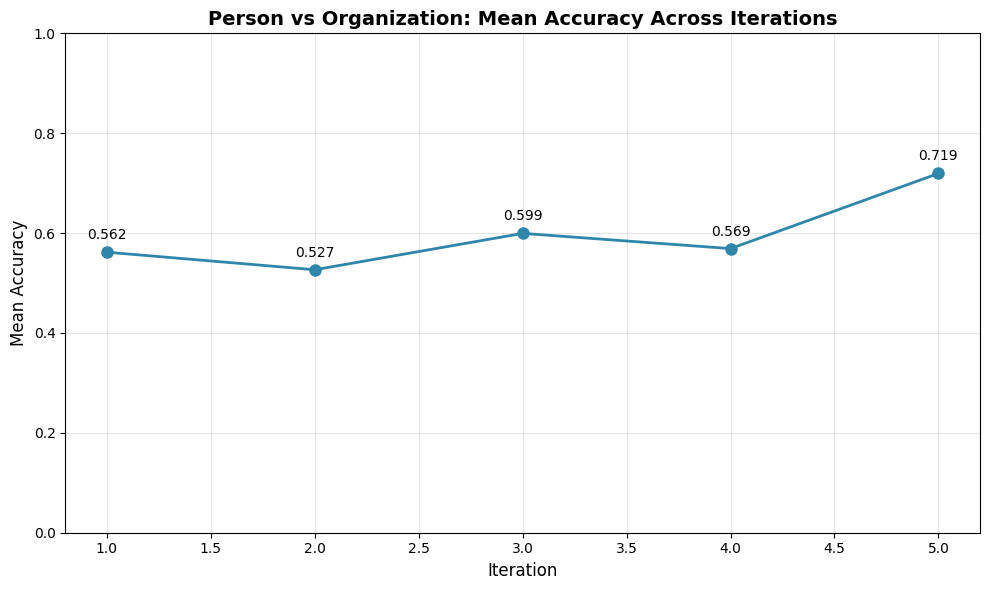


סיכום:
 iteration  mean_accuracy  mean_AUC  num_experiments
         1       0.561743  0.466517              336
         2       0.526584  0.510746              240
         3       0.599431  0.585311              672
         4       0.568937  0.583435              672
         5       0.719388  0.663977              180


In [15]:
# STAGE 16 - PERSON VS ORGANIZATION: חישוב ממוצע דיוקים ועדכון גרף

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# טעינת תוצאות הניסויים
BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
PLOTS_DIR = CLASSIFICATION_DIR / "Plots"
PLOTS_DIR.mkdir(exist_ok=True)

RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

print("=" * 80)
print("STAGE 16 - PERSON VS ORGANIZATION: חישוב ממוצע דיוקים לפי איטרציה")
print("=" * 80)

# טעינת התוצאות
df_results = pd.read_csv(RESULTS_FILE)
print(f"\n[INFO] טעינת {len(df_results)} שורות מתוצאות הניסויים")

# סינון לפי person_vs_organization
df_po = df_results[df_results["target_column"] == "person_vs_organization"].copy()
print(f"[INFO] מצאנו {len(df_po)} שורות עבור person_vs_organization")

# קבלת רשימת האיטרציות
iterations = sorted(df_po["iteration"].unique())
print(f"[INFO] איטרציות זמינות: {iterations}")

# חישוב ממוצע accuracy ו-AUC לכל איטרציה
summary_data = []
for iter_num in iterations:
    df_iter = df_po[df_po["iteration"] == iter_num]
    mean_acc = df_iter["accuracy"].mean()
    mean_auc = df_iter["AUC"].mean()  # יכול להיות NaN אם אין AUC
    count = len(df_iter)
    
    summary_data.append({
        "iteration": iter_num,
        "mean_accuracy": mean_acc,
        "mean_AUC": mean_auc,
        "num_experiments": count
    })
    
    print(f"\nאיטרציה {iter_num}:")
    print(f"  • מספר ניסויים: {count}")
    print(f"  • ממוצע Accuracy: {mean_acc:.4f}")
    if not pd.isna(mean_auc):
        print(f"  • ממוצע AUC: {mean_auc:.4f}")

summary_df = pd.DataFrame(summary_data)

# שמירת טבלת סיכום
summary_file = CLASSIFICATION_DIR / "person_vs_organization_summary_by_iteration.csv"
summary_df.to_csv(summary_file, index=False, encoding="utf-8")
print(f"\n✅ נשמר סיכום ב: {summary_file}")

# יצירת גרף ממוצע דיוקים לפי איטרציה
plt.figure(figsize=(10, 6))
plt.plot(summary_df["iteration"], summary_df["mean_accuracy"], 
         marker="o", linewidth=2, markersize=8, color="#2E86AB")

plt.title("Person vs Organization: Mean Accuracy Across Iterations", 
          fontsize=14, fontweight="bold")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Mean Accuracy", fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

# הוספת תוויות ערכים על הנקודות
for idx, row in summary_df.iterrows():
    plt.text(row["iteration"], row["mean_accuracy"] + 0.02, 
             f'{row["mean_accuracy"]:.3f}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# שמירת הגרף
plot_file = PLOTS_DIR / "person_vs_organization_mean_accuracy_across_iterations.png"
plt.savefig(plot_file, dpi=300, bbox_inches="tight")
print(f"✅ נשמר גרף ב: {plot_file}")

plt.show()

print("\n" + "=" * 80)
print("סיכום:")
print("=" * 80)
print(summary_df.to_string(index=False))
print("=" * 80)

**היסטוגרמה של רמת ביטחון חיזוי איטרציה 5 בן אדם מול ארגון**

היסטוגרמת רמות ביטחון - Person vs Organization

[INFO] נטענו 449 תחזיות

[סטטיסטיקות]:
  • מינימום: 0.5006
  • מקסימום: 0.8384
  • ממוצע: 0.6121
  • חציון: 0.6062
  • סטיית תקן: 0.0763

✅ נשמר גרף ב: POIs\Classification\Plots\confidence_score_histogram_person_vs_organization.png


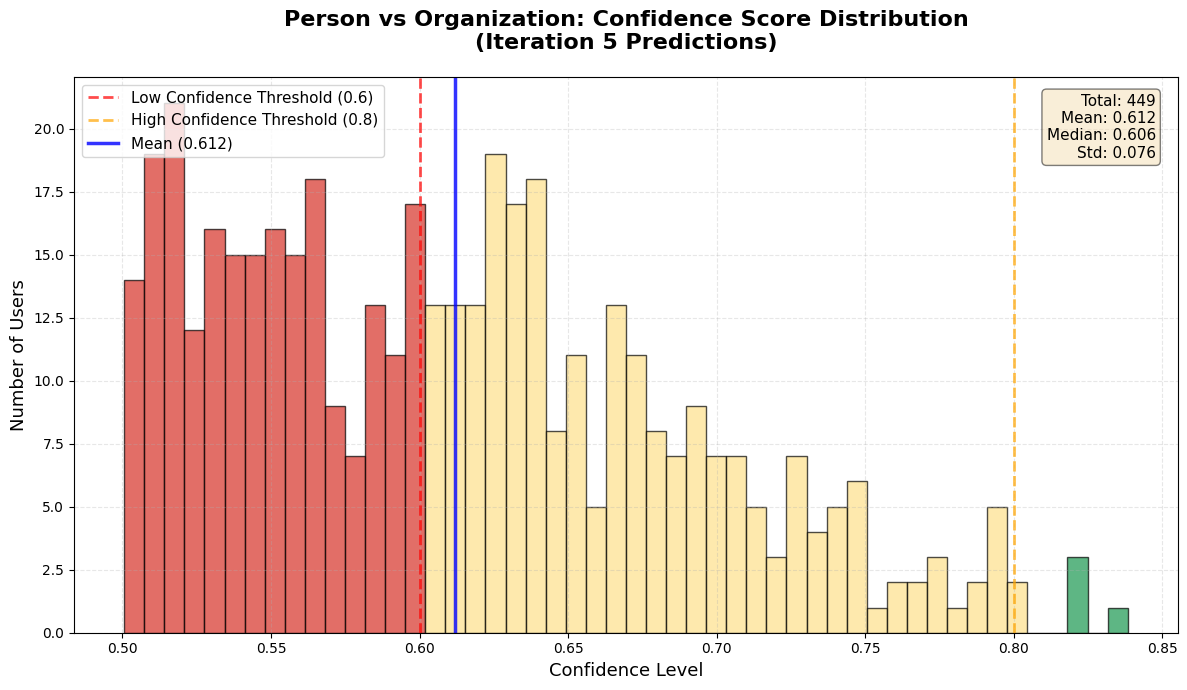


[התפלגות לפי רמות ביטחון]:
  • ביטחון נמוך (<0.6):      212 (47.2%)
  • ביטחון בינוני (0.6-0.8):   231 (51.4%)
  • ביטחון גבוה (≥0.8):         6 (1.3%)



In [18]:
# HISTOGRAM: Confidence Score Distribution - Person vs Organization

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# הגדרת נתיבים
BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
PLOTS_DIR = CLASSIFICATION_DIR / "Plots"
PLOTS_DIR.mkdir(exist_ok=True)

# טעינת קובץ התחזיות
PREDICTIONS_FILE = CLASSIFICATION_DIR / "iteration_5_unlabeled_users_predictions_person_vs_organization.csv"

print("=" * 80)
print("היסטוגרמת רמות ביטחון - Person vs Organization")
print("=" * 80)

if not PREDICTIONS_FILE.exists():
    print(f"\n❌ קובץ התחזיות לא נמצא: {PREDICTIONS_FILE}")
    print("   אנא הרץ תחילה את תא הפרדיקציות (STAGE 15E)")
else:
    # טעינת הנתונים
    df_pred = pd.read_csv(PREDICTIONS_FILE, encoding="utf-8")
    print(f"\n[INFO] נטענו {len(df_pred)} תחזיות")
    
    # בדיקה אם יש עמודת confidence_level
    if "confidence_level" not in df_pred.columns:
        print("\n❌ שגיאה: העמודה 'confidence_level' לא נמצאה בקובץ התחזיות")
    else:
        confidence_scores = df_pred["confidence_level"].dropna()
        
        print(f"\n[סטטיסטיקות]:")
        print(f"  • מינימום: {confidence_scores.min():.4f}")
        print(f"  • מקסימום: {confidence_scores.max():.4f}")
        print(f"  • ממוצע: {confidence_scores.mean():.4f}")
        print(f"  • חציון: {confidence_scores.median():.4f}")
        print(f"  • סטיית תקן: {confidence_scores.std():.4f}")
        
        # יצירת היסטוגרמה
        plt.figure(figsize=(12, 7))
        
        # היסטוגרמה עם bins מפורטים
        n, bins, patches = plt.hist(confidence_scores, bins=50, 
                                     color='steelblue', edgecolor='black', 
                                     alpha=0.7)
        
        # צביעת bins לפי רמת ביטחון
        for i, patch in enumerate(patches):
            if bins[i] < 0.6:
                patch.set_facecolor('#d73027')  # אדום - ביטחון נמוך
            elif bins[i] < 0.8:
                patch.set_facecolor('#fee08b')  # צהוב - ביטחון בינוני
            else:
                patch.set_facecolor('#1a9850')  # ירוק - ביטחון גבוה
        
        # קווים אנכיים לסף ביטחון
        plt.axvline(x=0.6, color='red', linestyle='--', linewidth=2, 
                   label='Low Confidence Threshold (0.6)', alpha=0.7)
        plt.axvline(x=0.8, color='orange', linestyle='--', linewidth=2, 
                   label='High Confidence Threshold (0.8)', alpha=0.7)
        plt.axvline(x=confidence_scores.mean(), color='blue', linestyle='-', 
                   linewidth=2.5, label=f'Mean ({confidence_scores.mean():.3f})', alpha=0.8)
        
        plt.title("Person vs Organization: Confidence Score Distribution\n(Iteration 5 Predictions)", 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel("Confidence Level", fontsize=13)
        plt.ylabel("Number of Users", fontsize=13)
        plt.legend(loc='upper left', fontsize=11)
        plt.grid(True, alpha=0.3, linestyle='--')
        
        # הוספת סטטיסטיקות בפינת הגרף
        stats_text = f'Total: {len(confidence_scores):,}\n'
        stats_text += f'Mean: {confidence_scores.mean():.3f}\n'
        stats_text += f'Median: {confidence_scores.median():.3f}\n'
        stats_text += f'Std: {confidence_scores.std():.3f}'
        
        plt.text(0.98, 0.97, stats_text, transform=plt.gca().transAxes,
                fontsize=11, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        
        # שמירת הגרף
        output_file = PLOTS_DIR / "confidence_score_histogram_person_vs_organization.png"
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"\n✅ נשמר גרף ב: {output_file}")
        
        plt.show()
        
        # סטטיסטיקות לפי רמות ביטחון
        print("\n[התפלגות לפי רמות ביטחון]:")
        low_conf = (confidence_scores < 0.6).sum()
        med_conf = ((confidence_scores >= 0.6) & (confidence_scores < 0.8)).sum()
        high_conf = (confidence_scores >= 0.8).sum()
        
        print(f"  • ביטחון נמוך (<0.6):    {low_conf:5d} ({100*low_conf/len(confidence_scores):.1f}%)")
        print(f"  • ביטחון בינוני (0.6-0.8): {med_conf:5d} ({100*med_conf/len(confidence_scores):.1f}%)")
        print(f"  • ביטחון גבוה (≥0.8):     {high_conf:5d} ({100*high_conf/len(confidence_scores):.1f}%)")
        
        print("\n" + "=" * 80)

**לקיחת משתמשים שהמסווג לא בטוח לגביהם או בטוח מדי ותיוג ידני נוסף על מנת לבדוק אם אפשר לעצור או לשפר את המודל - בן אדם מול ארגון**

In [19]:
# STAGE 16B: SAMPLE 20 USERS PER CONFIDENCE BAND (PERSON VS ORGANIZATION) — based on confidence_level (not uncertainty)

from pathlib import Path

import re

import numpy as np

import pandas as pd



# --- Config ---

RANDOM_STATE = 42

SAMPLE_PER_BAND = 20



# Paths (use existing notebook paths if available)

_classification_dir = globals().get("CLASSIFICATION_DIR", Path("POIs") / "Classification")

_classification_dir = Path(_classification_dir)



PREDICTIONS_FILE_PVO = _classification_dir / "iteration_5_unlabeled_users_predictions_person_vs_organization.csv"

EXPORT_DIR_PVO = _classification_dir / "Manual_Labeling_Samples" / "person_vs_organization" / "iteration_5" / "confidence_bands"

EXPORT_DIR_PVO.mkdir(parents=True, exist_ok=True)



# --- Load predictions ---

if not PREDICTIONS_FILE_PVO.exists():

    raise FileNotFoundError(

        f"Predictions file not found: {PREDICTIONS_FILE_PVO}. "

        "Run the Stage 15E predictions cell first (or fix the path)."

    )



df_pred_pvo = pd.read_csv(PREDICTIONS_FILE_PVO, encoding="utf-8")



# Ensure confidence_level exists (fallback: max(prob_0, prob_1))

if "confidence_level" not in df_pred_pvo.columns:

    if {"prob_0", "prob_1"}.issubset(df_pred_pvo.columns):

        df_pred_pvo["confidence_level"] = df_pred_pvo[["prob_0", "prob_1"]].max(axis=1)

    else:

        raise ValueError("Missing confidence_level and prob_0/prob_1 columns in predictions file.")



df_pred_pvo["confidence_level"] = pd.to_numeric(df_pred_pvo["confidence_level"], errors="coerce").clip(0, 1)



# Prefer username as unique key

if "username" not in df_pred_pvo.columns:

    raise ValueError("Predictions file is missing required column: 'username'.")



# --- Define confidence bands ---

# For a binary classifier, confidence is usually in [0.5, 1].

bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0000001]

labels = [

    "<0.50",

    "0.50-0.60",

    "0.60-0.70",

    "0.70-0.80",

    "0.80-0.90",

    "0.90-1.00",

]



df_pred_pvo["confidence_band"] = pd.cut(

    df_pred_pvo["confidence_level"],

    bins=bins,

    labels=labels,

    right=False,

    include_lowest=True,

)



# --- Sample ---

def _safe_filename(s: str) -> str:

    s = str(s)

    s = re.sub(r"[^0-9A-Za-z._-]+", "_", s)

    return s.strip("_")



band_counts = (

    df_pred_pvo["confidence_band"].value_counts(dropna=False)

    .rename_axis("confidence_band")

    .reset_index(name="count")

)

print("Confidence-band distribution (all predictions):")

display(band_counts)



samples = []

sample_report = []



for band in labels:

    band_df = df_pred_pvo[df_pred_pvo["confidence_band"] == band].copy()

    if band_df.empty:

        sample_report.append({"confidence_band": band, "available": 0, "sampled": 0})

        continue



    # De-duplicate by username for manual labeling

    band_df = band_df.drop_duplicates(subset=["username"], keep="first")



    n_available = len(band_df)

    n_sample = min(SAMPLE_PER_BAND, n_available)

    sampled_df = band_df.sample(n=n_sample, random_state=RANDOM_STATE)

    sampled_df = sampled_df.copy()

    sampled_df["manual_label"] = np.nan

    sampled_df["sampling_note"] = f"iteration_5_person_vs_organization_confidence_band={band}" 



    samples.append(sampled_df)

    sample_report.append({"confidence_band": band, "available": n_available, "sampled": n_sample})



    out_name = f"sample_person_vs_organization_iter5_conf_{_safe_filename(band)}_n{n_sample}.csv"

    out_path = EXPORT_DIR_PVO / out_name



    # Keep a reasonable set of columns (only those that exist)

    preferred_cols = [

        "username",

        "display_name",

        "description",

        "followers_count",

        "following_count",

        "predicted_class",

        "confidence_level",

        "confidence_band",

        "prob_0",

        "prob_1",

        "prob_2",

        "uncertainty_score",

        "manual_label",

        "sampling_note",

    ]

    cols_to_export = [c for c in preferred_cols if c in sampled_df.columns]

    sampled_df[cols_to_export].to_csv(out_path, index=False, encoding="utf-8")

    print(f"Wrote: {out_path} ({n_sample} rows)")



# Combined file

if samples:

    combined_samples_df = pd.concat(samples, ignore_index=True)

    combined_out = EXPORT_DIR_PVO / "combined_samples_person_vs_organization_iter5_confidence_bands.csv"



    preferred_cols = [

        "username",

        "display_name",

        "description",

        "followers_count",

        "following_count",

        "predicted_class",

        "confidence_level",

        "confidence_band",

        "prob_0",

        "prob_1",

        "prob_2",

        "uncertainty_score",

        "manual_label",

        "sampling_note",

    ]

    cols_to_export = [c for c in preferred_cols if c in combined_samples_df.columns]

    combined_samples_df[cols_to_export].to_csv(combined_out, index=False, encoding="utf-8")

    print(f"Wrote combined: {combined_out} ({len(combined_samples_df)} rows)")



report_df = pd.DataFrame(sample_report)

print("\nSampling report:")

display(report_df)



if (report_df["available"] < SAMPLE_PER_BAND).any():

    print(

        "\nNote: Some confidence bands have fewer than 20 available users; "

        "the code sampled all available users for those bands."

    )


Confidence-band distribution (all predictions):


,confidence_band,count
0,0.50-0.60,212
1,0.60-0.70,176
2,0.70-0.80,55
3,0.80-0.90,6
4,<0.50,0
5,0.90-1.00,0


Wrote: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\sample_person_vs_organization_iter5_conf_0.50-0.60_n20.csv (20 rows)
Wrote: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\sample_person_vs_organization_iter5_conf_0.60-0.70_n20.csv (20 rows)
Wrote: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\sample_person_vs_organization_iter5_conf_0.70-0.80_n20.csv (20 rows)
Wrote: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\sample_person_vs_organization_iter5_conf_0.80-0.90_n6.csv (6 rows)
Wrote combined: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\combined_samples_person_vs_organization_iter5_confidence_bands.csv (66 rows)

Sampling report:


,confidence_band,available,sampled
0,<0.50,0,0
1,0.50-0.60,212,20
2,0.60-0.70,176,20
3,0.70-0.80,55,20
4,0.80-0.90,6,6
5,0.90-1.00,0,0



Note: Some confidence bands have fewer than 20 available users; the code sampled all available users for those bands.


**הרצת מסווגים איטרציה 6 בן אדם מול ארגון**

In [23]:
# =============================================================================
# STAGE 16D (PERSON VS ORGANIZATION):
# 1) Merge newly labeled confidence-band samples into the master labeled dataset
# 2) Re-run the full Iteration-5 experiment grid on the expanded labeled data
#    and save results as a NEW iteration (default: 6) for comparison.
# =============================================================================

from pathlib import Path
import numpy as np
import pandas as pd

from scipy.sparse import hstack, csr_matrix
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

try:
    from xgboost import XGBClassifier
except Exception as e:
    raise ImportError(
        "xgboost is required to re-run the full iteration-5 grid (it was used in iteration 5). "
        "Install it (pip install xgboost) and re-run this cell. Original error: " + str(e)
    )

# ----------------------------
# CONFIG
# ----------------------------
ITERATION_NEW = 6  # New iteration index for the re-run with added labeled data
FORCE_APPEND_IF_EXISTS = False  # safety: avoid duplicating runs
RANDOM_STATE = 42

# If the newly-labeled CSV still contains 1-2 empty labels by mistake, this will drop them and proceed.
# Set to False if you prefer to fail hard and fix the CSV manually.
DROP_ROWS_WITH_MISSING_MANUAL_LABEL = True

# Allowed labels for person_vs_organization in this project:
# 0 = organization, 1 = person, 2 = unknown/other (used in the 3-class experiments).
ALLOWED_LABELS = {0, 1, 2}

BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"

LABELED_BASE_FILE = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization.csv"
NEWLY_LABELED_FILE = (
    CLASSIFICATION_DIR
    / "Manual_Labeling_Samples"
    / "person_vs_organization"
    / "iteration_5"
    / "confidence_bands"
    / "combined_samples_person_vs_organization_iter5_confidence_bands.csv"
 )

UPDATED_LABELED_FILE = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv"
CLEANED_NEWLY_LABELED_FILE = NEWLY_LABELED_FILE.with_name(NEWLY_LABELED_FILE.stem + "_cleaned.csv")

print("[INFO] Base labeled file:", LABELED_BASE_FILE)
print("[INFO] Newly labeled samples:", NEWLY_LABELED_FILE)
print("[INFO] Updated labeled output:", UPDATED_LABELED_FILE)
print("[INFO] Results file:", RESULTS_FILE)

if not LABELED_BASE_FILE.exists():
    raise FileNotFoundError(f"Missing base labeled file: {LABELED_BASE_FILE}")
if not NEWLY_LABELED_FILE.exists():
    raise FileNotFoundError(f"Missing newly labeled file: {NEWLY_LABELED_FILE}")
if not RESULTS_FILE.exists():
    raise FileNotFoundError(f"Missing experiments results file: {RESULTS_FILE}")

# ----------------------------
# 1) LOAD + VALIDATE NEW LABELS
# ----------------------------
df_base = pd.read_csv(LABELED_BASE_FILE, encoding="utf-8")
df_new = pd.read_csv(NEWLY_LABELED_FILE, encoding="utf-8")

required_new_cols = ["username", "manual_label"]
missing_cols = [c for c in required_new_cols if c not in df_new.columns]
if missing_cols:
    raise ValueError(f"Newly labeled file missing columns: {missing_cols}")

# Normalize manual_label to int labels (robust to whitespace / strings)
ml_raw = df_new["manual_label"]
if ml_raw.dtype == object:
    ml_raw = (
        ml_raw.astype(str)
              .str.strip()
              .replace({"": np.nan, "nan": np.nan, "None": np.nan, "<NA>": np.nan})
    )
df_new["manual_label"] = pd.to_numeric(ml_raw, errors="coerce")

if df_new["manual_label"].isna().any():
    bad_rows = df_new[df_new["manual_label"].isna()].copy()
    cols_show = [c for c in ["username", "display_name", "description", "confidence_band", "confidence_level", "manual_label"] if c in bad_rows.columns]
    print("[WARN] Found rows with missing/invalid manual_label:")
    print(bad_rows[cols_show].head(20).to_string(index=False))
    bad_n = int(len(bad_rows))
    if DROP_ROWS_WITH_MISSING_MANUAL_LABEL:
        print(f"[WARN] Dropping {bad_n} rows with missing manual_label and continuing.")
        df_new = df_new[df_new["manual_label"].notna()].copy()
        df_new.to_csv(CLEANED_NEWLY_LABELED_FILE, index=False, encoding="utf-8")
        print("[INFO] Wrote cleaned newly-labeled file:", CLEANED_NEWLY_LABELED_FILE)
    else:
        raise ValueError(f"Newly labeled file has {bad_n} missing/invalid manual_label values. Fix and re-run.")

df_new["manual_label"] = df_new["manual_label"].astype(int)
bad_vals = sorted(set(df_new["manual_label"].unique()) - set(ALLOWED_LABELS))
if bad_vals:
    raise ValueError(f"manual_label must be in {sorted(ALLOWED_LABELS)} for PVO. Found invalid values: {bad_vals}")

# De-duplicate new labels by username
df_new["username"] = df_new["username"].astype(str)
df_new = df_new.drop_duplicates(subset=["username"], keep="last").copy()

print("[INFO] New labeled rows (deduped):", len(df_new))
print("[INFO] New label distribution:", df_new["manual_label"].value_counts().to_dict())

# ----------------------------
# 2) MERGE INTO MASTER LABELED DATA (NO OVERWRITE OF ORIGINAL)
# ----------------------------
if "username" not in df_base.columns:
    raise ValueError("Base labeled dataset is missing 'username' column.")

df_base["username"] = df_base["username"].astype(str)

# Build new rows with the SAME schema as df_base (stable row count)
df_new_rows = pd.DataFrame(index=df_new.index, columns=df_base.columns)

def _copy_if_exists(src: pd.DataFrame, dst: pd.DataFrame, col: str):
    if col in src.columns and col in dst.columns:
        dst[col] = src[col].to_numpy()

# Fill known fields
_copy_if_exists(df_new, df_new_rows, "username")
_copy_if_exists(df_new, df_new_rows, "display_name")
_copy_if_exists(df_new, df_new_rows, "description")
_copy_if_exists(df_new, df_new_rows, "followers_count")
_copy_if_exists(df_new, df_new_rows, "following_count")

# Store the label in both generic and task-specific fields if present
if "manual_label" in df_new_rows.columns:
    df_new_rows["manual_label"] = df_new["manual_label"].to_numpy()
if "manual_person_vs_organization" in df_new_rows.columns:
    df_new_rows["manual_person_vs_organization"] = df_new["manual_label"].to_numpy()

# Track provenance if column exists
if "iteration_source" in df_new_rows.columns:
    df_new_rows["iteration_source"] = 5.0
if "created_at" in df_new_rows.columns:
    df_new_rows["created_at"] = "January 2026"

combined = pd.concat([df_base, df_new_rows], ignore_index=True)

base_users = set(df_base["username"].astype(str))
new_users = set(df_new_rows["username"].astype(str))
overlap = base_users.intersection(new_users)
print("[INFO] Overlap usernames with existing labeled data:", len(overlap))

# If overlap exists, report potential conflicts and keep existing base labels
if overlap and ("manual_label" in df_base.columns) and ("manual_label" in df_new_rows.columns):
    common = list(overlap)
    base_lab = pd.to_numeric(df_base.set_index("username")["manual_label"].reindex(common), errors="coerce")
    new_lab = pd.to_numeric(df_new_rows.set_index("username")["manual_label"].reindex(common), errors="coerce")
    conflicts = (base_lab.notna()) & (new_lab.notna()) & (base_lab.astype(int) != new_lab.astype(int))
    n_conf = int(conflicts.sum())
    if n_conf:
        print(f"[WARN] Found {n_conf} label conflicts on overlapping usernames. Keeping existing base labels.")
        ex = pd.DataFrame({"username": np.array(common)[conflicts.values], "base": base_lab[conflicts].astype(int).values, "new": new_lab[conflicts].astype(int).values})
        print(ex.head(10).to_string(index=False))

combined = combined.drop_duplicates(subset=["username"], keep="first").copy()

combined.to_csv(UPDATED_LABELED_FILE, index=False, encoding="utf-8")
print("✅ Saved updated labeled dataset:", UPDATED_LABELED_FILE)
print("[INFO] Base rows:", len(df_base))
print("[INFO] Updated rows:", len(combined))

# ----------------------------
# 3) BUILD FEATURE SETS (SAME AS ITERATION 5 CELLS)
# ----------------------------
df_all = combined.copy()
label_col_name = "label_person_vs_org"
df_all[label_col_name] = np.nan

if "manual_person_vs_organization" in df_all.columns:
    df_all.loc[df_all["manual_person_vs_organization"].notna(), label_col_name] = df_all["manual_person_vs_organization"]
if "manual_label" in df_all.columns:
    df_all.loc[df_all["manual_label"].notna(), label_col_name] = df_all["manual_label"]

df_all = df_all[df_all[label_col_name].notna()].copy()
df_all[label_col_name] = pd.to_numeric(df_all[label_col_name], errors="coerce")
df_all = df_all[df_all[label_col_name].notna()].copy()
df_all[label_col_name] = df_all[label_col_name].astype(int)

print("[INFO] Labeled rows used for experiments:", len(df_all))
print("[INFO] Label distribution:", df_all[label_col_name].value_counts().to_dict())

text_col = "description_en" if "description_en" in df_all.columns else "description"
username_col = "username"
name_col = "display_name_en" if "display_name_en" in df_all.columns else ("display_name" if "display_name" in df_all.columns else None)

texts_desc = df_all[text_col].fillna("").astype(str).tolist()
texts_user = df_all[username_col].fillna("").astype(str).tolist()
texts_name = df_all[name_col].fillna("").astype(str).tolist() if name_col is not None else [""] * len(df_all)

vec_desc = TfidfVectorizer(max_features=276)
X_desc = vec_desc.fit_transform(texts_desc)

vec_user = TfidfVectorizer(max_features=200)
X_user = vec_user.fit_transform(texts_user)

vec_name = TfidfVectorizer(max_features=200)
X_name = vec_name.fit_transform(texts_name)

followers = df_all.get("followers_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
following = df_all.get("following_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
statuses = df_all.get("statuses_count", pd.Series([0] * len(df_all))).fillna(0).astype(float).to_numpy().reshape(-1, 1)

ratio = followers[:, 0] / (np.abs(following[:, 0]) + 1.0)
ratio = ratio.reshape(-1, 1)

bio_len = df_all[text_col].fillna("").astype(str).str.len().astype(float).to_numpy().reshape(-1, 1)

num_array = np.hstack([followers, following, statuses, ratio, bio_len])
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_array)
X_num_sparse = csr_matrix(num_scaled)

feature_sets = {
    "TFIDF_description": X_desc,
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
    "TFIDF_description + NUM": hstack([X_desc, X_num_sparse]),
    "TFIDF_description+username + NUM": hstack([X_desc, X_user, X_num_sparse]),
    "TFIDF_description+full_name + NUM": hstack([X_desc, X_name, X_num_sparse]),
    "TFIDF_description+username+full_name + NUM": hstack([X_desc, X_user, X_name, X_num_sparse]),
}

print("[INFO] Feature sets:")
for fs_name, X_fs in feature_sets.items():
    print(f"  - {fs_name}: {X_fs.shape}")

# ----------------------------
# 4) DEFINE MODELS (MATCH ITERATION 5 FAMILY)
# ----------------------------
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight=None, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(kernel="linear", probability=True, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
    ),
}

# ----------------------------
# 5) CV RUNNER
# ----------------------------
def _class_counts(y: np.ndarray, n_classes: int):
    counts = np.bincount(y, minlength=n_classes).tolist()
    counts = counts + [0] * max(0, 3 - len(counts))
    return counts[:3]

def _run_cv(X, y, n_classes: int, cv_name: str, k: int, estimator, estimator_name: str):
    if cv_name == "KFold":
        cv = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
        eff_k = k
    else:
        cv = LeaveOneOut()
        eff_k = int(len(y))

    y_true_all = []
    y_pred_all = []
    y_score_all = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = clone(estimator)
        if estimator_name == "XGBoost":
            params = clf.get_params()
            params["objective"] = "multi:softprob" if n_classes > 2 else "binary:logistic"
            clf = XGBClassifier(**params)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        y_score = None
        if hasattr(clf, "predict_proba"):
            proba = clf.predict_proba(X_test)
            if n_classes == 2 and proba.shape[1] >= 2:
                y_score = proba[:, 1]
            elif n_classes > 2:
                y_score = proba.max(axis=1)

        y_true_all.extend(y_test.tolist())
        y_pred_all.extend(np.array(y_pred).tolist())
        if y_score is not None:
            y_score_all.extend(np.array(y_score).tolist())

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    acc = float(accuracy_score(y_true_all, y_pred_all))
    prec = float(precision_score(y_true_all, y_pred_all, average="weighted", zero_division=0))
    rec = float(recall_score(y_true_all, y_pred_all, average="weighted", zero_division=0))
    f1 = float(f1_score(y_true_all, y_pred_all, average="weighted", zero_division=0))

    if n_classes == 2 and len(y_score_all) == len(y_true_all):
        try:
            auc = float(roc_auc_score(y_true_all, np.array(y_score_all)))
        except Exception:
            auc = np.nan
    else:
        auc = np.nan

    return acc, prec, rec, f1, auc, float(eff_k)

# ----------------------------
# 6) SAFETY CHECK: DO NOT DUPLICATE ITERATION_NEW RUNS
# ----------------------------
df_results = pd.read_csv(RESULTS_FILE, encoding="utf-8", on_bad_lines="skip")
df_results["iteration"] = pd.to_numeric(df_results["iteration"], errors="coerce")
already = df_results[(df_results["iteration"] == ITERATION_NEW) & (df_results["target_column"] == "person_vs_organization")]
if len(already) > 0 and not FORCE_APPEND_IF_EXISTS:
    raise RuntimeError(
        f"experiments_results.csv already contains {len(already)} rows for iteration={ITERATION_NEW} and target_column=person_vs_organization. "
        "Set FORCE_APPEND_IF_EXISTS=True to append anyway."
    )

# ----------------------------
# 7) RUN GRID (SAME SHAPE AS ITERATION 5: 160 ROWS)
# ----------------------------
all_labels = df_all[label_col_name].to_numpy()
results_rows = []

for fs_name, X_fs in feature_sets.items():
    for n_classes in [3, 2]:
        if n_classes == 3:
            mask = np.isin(all_labels, [0, 1, 2])
        else:
            mask = np.isin(all_labels, [0, 1])

        y = all_labels[mask]
        X_used = X_fs[mask]

        if len(np.unique(y)) < n_classes:
            print(f"[WARN] Not enough classes for n_classes={n_classes} | fs={fs_name}; skipping.")
            continue

        c0, c1, c2 = _class_counts(y, n_classes)
        min_class = min([c for c in [c0, c1, c2] if c > 0])

        for cv_name in ["KFold", "LOOCV"]:
            k = 5 if cv_name == "KFold" else len(y)
            for algo_name, estimator in models.items():
                print(f"Running iteration={ITERATION_NEW} | fs={fs_name} | classes={n_classes} | cv={cv_name} | algo={algo_name}")
                acc, prec, rec, f1, auc, eff_k = _run_cv(X_used, y, n_classes, cv_name, k, estimator, algo_name)

                results_rows.append({
                    "iteration": int(ITERATION_NEW),
                    "target_column": "person_vs_organization",
                    "#classes": float(n_classes),
                    "#class_0": float(c0),
                    "#class_1": float(c1),
                    "#class_2": float(c2),
                    "min_class_size": float(min_class),
                    "training_type": cv_name,
                    "K": float(eff_k),
                    "algorithm": algo_name,
                    "feature_set": fs_name,
                    "features_count": float(X_fs.shape[1]),
                    "balanced": False,
                    "accuracy": float(acc),
                    "precision": float(prec),
                    "recall": float(rec),
                    "F1": float(f1),
                    "AUC": auc,
                })

df_new_results = pd.DataFrame(results_rows)

col_order = [
    "iteration","target_column","#classes","#class_0","#class_1","#class_2","min_class_size",
    "training_type","K","algorithm","feature_set","features_count","balanced",
    "accuracy","precision","recall","F1","AUC",
]
df_new_results = df_new_results[col_order]

print("[INFO] New result rows:", len(df_new_results))
print(df_new_results.head(3).to_string(index=False))

df_new_results.to_csv(RESULTS_FILE, mode="a", header=False, index=False, encoding="utf-8")
print(f"✅ Appended {len(df_new_results)} rows to: {RESULTS_FILE}")

# ----------------------------
# 8) QUICK COMPARISON: ITERATION 5 vs ITERATION_NEW (BINARY ONLY)
# ----------------------------
df_all_res = pd.read_csv(RESULTS_FILE, encoding="utf-8", on_bad_lines="skip")
df_all_res["iteration"] = pd.to_numeric(df_all_res["iteration"], errors="coerce")
df_all_res["#classes"] = pd.to_numeric(df_all_res["#classes"], errors="coerce")
df_all_res["accuracy"] = pd.to_numeric(df_all_res["accuracy"], errors="coerce")

def _mean_acc(iteration: int):
    sub = df_all_res[
        (df_all_res["target_column"] == "person_vs_organization") &
        (df_all_res["iteration"] == iteration) &
        (df_all_res["#classes"] == 2)
    ].copy()
    return float(sub["accuracy"].mean()) if len(sub) else np.nan, int(len(sub))

m5, n5 = _mean_acc(5)
mN, nN = _mean_acc(int(ITERATION_NEW))
print("=" * 80)
print("MEAN ACCURACY COMPARISON (PVO, binary #classes=2)")
print(f"Iteration 5:  mean_accuracy={m5:.4f}  (n={n5} experiments)")
print(f"Iteration {ITERATION_NEW}: mean_accuracy={mN:.4f}  (n={nN} experiments)")
print("=" * 80)

[INFO] Base labeled file: POIs\Classification\all_labeled_data_person_vs_organization.csv
[INFO] Newly labeled samples: POIs\Classification\Manual_Labeling_Samples\person_vs_organization\iteration_5\confidence_bands\combined_samples_person_vs_organization_iter5_confidence_bands.csv
[INFO] Updated labeled output: POIs\Classification\all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv
[INFO] Results file: POIs\Classification\Experiments\experiments_results.csv
[INFO] New labeled rows (deduped): 66
[INFO] New label distribution: {1: 56, 0: 6, 2: 4}
[INFO] Overlap usernames with existing labeled data: 0


C:\Users\nitib\AppData\Local\Temp\ipykernel_16304\1172747949.py:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([df_base, df_new_rows], ignore_index=True)


✅ Saved updated labeled dataset: POIs\Classification\all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv
[INFO] Base rows: 500
[INFO] Updated rows: 565
[INFO] Labeled rows used for experiments: 563
[INFO] Label distribution: {1: 372, 0: 155, 2: 36}
[INFO] Feature sets:
  - TFIDF_description: (563, 276)
  - TFIDF_description+username: (563, 476)
  - TFIDF_description+full_name: (563, 476)
  - TFIDF_description+username+full_name: (563, 676)
  - TFIDF_description + NUM: (563, 281)
  - TFIDF_description+username + NUM: (563, 481)
  - TFIDF_description+full_name + NUM: (563, 481)
  - TFIDF_description+username+full_name + NUM: (563, 681)
Running iteration=6 | fs=TFIDF_description | classes=3 | cv=KFold | algo=LogReg
Running iteration=6 | fs=TFIDF_description | classes=3 | cv=KFold | algo=DecisionTree
Running iteration=6 | fs=TFIDF_description | classes=3 | cv=KFold | algo=RandomForest
Running iteration=6 | fs=TFIDF_description | classes=3 | cv=KFold | algo=SVM
Running i

In [28]:
# =============================================================================
# STAGE 16F (PERSON VS ORGANIZATION):
# Run EXACT requested config on unlabeled file:
# - LogisticRegression ("linear regression")
# - LOOCV
# - feature_set = TFIDF_description+username+full_name + NUM
# - balanced = False
# - 2 classes (0=organization, 1=person)
# Then train on all labeled data and predict the unlabeled pool.
# Output CSV format matches previous iterations (e.g., iteration_5_*_predictions_person_vs_organization.csv)
# =============================================================================

from pathlib import Path
import numpy as np
import pandas as pd

from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

RANDOM_STATE = 42
BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"

# Prefer translated files if they exist (Stage 16G)
LABELED_TRANSLATED = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization_plus_iter5_confidence_bands_translated_en.csv"
UNLABELED_TRANSLATED = CLASSIFICATION_DIR / "unlabeled_users_all_person_vs_organization_translated_en.csv"

LABELED_PREFERRED = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv"
LABELED_FALLBACK = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization.csv"

UNLABELED_PREFERRED = CLASSIFICATION_DIR / "unlabeled_users_all_person_vs_organization.csv"
UNLABELED_FALLBACK = CLASSIFICATION_DIR / "unlabeled_users.csv"

OUT_PRED = CLASSIFICATION_DIR / "iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv"

FEATURE_SET = "TFIDF_description+username+full_name + NUM"

# ----------------------------
# Load labeled + unlabeled
# ----------------------------
if LABELED_TRANSLATED.exists():
    labeled_file = LABELED_TRANSLATED
else:
    labeled_file = LABELED_PREFERRED if LABELED_PREFERRED.exists() else LABELED_FALLBACK

if UNLABELED_TRANSLATED.exists():
    unlabeled_file = UNLABELED_TRANSLATED
else:
    unlabeled_file = UNLABELED_PREFERRED if UNLABELED_PREFERRED.exists() else UNLABELED_FALLBACK

if not labeled_file.exists():
    raise FileNotFoundError(f"Missing labeled file: {labeled_file}")
if not unlabeled_file.exists():
    raise FileNotFoundError(f"Missing unlabeled file: {unlabeled_file}")

df_labeled = pd.read_csv(labeled_file, encoding="utf-8", on_bad_lines="skip")
df_unl = pd.read_csv(unlabeled_file, encoding="utf-8", on_bad_lines="skip")

if "username" not in df_labeled.columns or "username" not in df_unl.columns:
    raise ValueError("Expected 'username' column in both labeled and unlabeled files")

# Determine label column
if "manual_person_vs_organization" in df_labeled.columns:
    y_col = "manual_person_vs_organization"
elif "manual_label" in df_labeled.columns:
    y_col = "manual_label"
else:
    raise ValueError("No label column found in labeled data (expected manual_person_vs_organization or manual_label)")

# Keep binary only
work = df_labeled[df_labeled[y_col].notna()].copy()
work[y_col] = pd.to_numeric(work[y_col], errors="coerce")
work = work[work[y_col].notna()].copy()
work = work[work[y_col].astype(int).isin([0, 1])].copy()
work[y_col] = work[y_col].astype(int)

# ----------------------------
# Build features (use *_en columns, falling back to original if empty)
# ----------------------------

def _safe_series(df: pd.DataFrame, col: str):
    if col is None or col not in df.columns:
        return pd.Series([""] * len(df), index=df.index)
    return df[col].fillna("").astype(str)


def _pick_text(df: pd.DataFrame, en_col: str, raw_col: str) -> pd.Series:
    en = _safe_series(df, en_col)
    raw = _safe_series(df, raw_col)
    out = en.copy()
    mask = out.str.strip().eq("")
    out.loc[mask] = raw.loc[mask]
    return out


# Prefer the english columns when available
s_desc = _pick_text(work, "description_en", "description")
u_desc = _pick_text(df_unl, "description_en", "description")

s_name = _pick_text(work, "display_name_en", "display_name")
u_name = _pick_text(df_unl, "display_name_en", "display_name")

s_user = _safe_series(work, "username")
u_user = _safe_series(df_unl, "username")

# Vectorizers
vec_desc = TfidfVectorizer(max_features=276)
X_desc = vec_desc.fit_transform(s_desc.tolist())
X_desc_unl = vec_desc.transform(u_desc.tolist())

vec_user = TfidfVectorizer(max_features=200)
X_user = vec_user.fit_transform(s_user.tolist())
X_user_unl = vec_user.transform(u_user.tolist())

vec_name = TfidfVectorizer(max_features=200)
X_name = vec_name.fit_transform(s_name.tolist())
X_name_unl = vec_name.transform(u_name.tolist())

# Numeric block (same as Stage 16D)
def _num_block(df: pd.DataFrame, desc_series: pd.Series):
    followers = df.get("followers_count", pd.Series([0] * len(df))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
    following = df.get("following_count", pd.Series([0] * len(df))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
    statuses = df.get("statuses_count", pd.Series([0] * len(df))).fillna(0).astype(float).to_numpy().reshape(-1, 1)
    ratio = followers[:, 0] / (np.abs(following[:, 0]) + 1.0)
    ratio = ratio.reshape(-1, 1)
    bio_len = desc_series.fillna("").astype(str).str.len().astype(float).to_numpy().reshape(-1, 1)
    return np.hstack([followers, following, statuses, ratio, bio_len])

num_train = _num_block(work, s_desc)
num_unl = _num_block(df_unl, u_desc)

scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(num_train)
num_unl_scaled = scaler.transform(num_unl)
X_num = csr_matrix(num_train_scaled)
X_num_unl = csr_matrix(num_unl_scaled)

# Requested feature set
X = hstack([X_desc, X_user, X_name, X_num])
X_unl = hstack([X_desc_unl, X_user_unl, X_name_unl, X_num_unl])

y = work[y_col].to_numpy()

print("[INFO] Labeled (binary) rows:", len(work))
print("[INFO] Unlabeled rows:", len(df_unl))
print("[INFO] Feature matrix shapes:", X.shape, X_unl.shape)
print("[INFO] labeled_file:", labeled_file)
print("[INFO] unlabeled_file:", unlabeled_file)

# ----------------------------
# LOOCV evaluation
# ----------------------------
loo = LeaveOneOut()

y_true = []
y_pred = []
y_score = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf_i = LogisticRegression(max_iter=2000, class_weight=None, random_state=RANDOM_STATE)
    clf_i.fit(X_train, y_train)

    p = int(clf_i.predict(X_test)[0])
    proba = clf_i.predict_proba(X_test)[0]

    y_true.append(int(y_test[0]))
    y_pred.append(p)
    y_score.append(float(proba[1]))

acc = float(accuracy_score(y_true, y_pred))
prec = float(precision_score(y_true, y_pred, average="weighted", zero_division=0))
rec = float(recall_score(y_true, y_pred, average="weighted", zero_division=0))
f1 = float(f1_score(y_true, y_pred, average="weighted", zero_division=0))
auc = float(roc_auc_score(y_true, y_score))

print("=" * 80)
print("LOOCV RESULTS | LogisticRegression | balanced=False | 2 classes")
print("feature_set:", FEATURE_SET)
print("accuracy:", round(acc, 6))
print("precision:", round(prec, 6))
print("recall:", round(rec, 6))
print("F1:", round(f1, 6))
print("ROC AUC:", round(auc, 6))
print("=" * 80)

# ----------------------------
# Train on ALL labeled and predict UNLABELED
# ----------------------------
clf = LogisticRegression(max_iter=2000, class_weight=None, random_state=RANDOM_STATE)
clf.fit(X, y)
proba_unl = clf.predict_proba(X_unl)

prob_0 = proba_unl[:, 0]
prob_1 = proba_unl[:, 1]

predicted_class = np.where(prob_1 >= prob_0, 1, 0).astype(int)
confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1.0 - confidence_level

# Match previous-iterations output schema (iteration_4/5 style)
expected_cols = [
    "username",
    "display_name",
    "description",
    "followers_count",
    "following_count",
    "statuses_count",
    "verified",
    "created_at",
    "location",
    "url",
    "profile_image_url",
    "profile_banner_url",
    "description_en",
    "display_name_en",
    "predicted_class",
    "confidence_level",
    "prob_0",
    "prob_1",
    "prob_2",
    "uncertainty_score",
]

out = df_unl.copy()

# Ensure all expected base cols exist
for c in expected_cols:
    if c not in out.columns:
        out[c] = np.nan

out["predicted_class"] = predicted_class
out["confidence_level"] = confidence_level
out["prob_0"] = prob_0
out["prob_1"] = prob_1
out["prob_2"] = np.nan  # keep same column name as previous files
out["uncertainty_score"] = uncertainty_score

out = out[expected_cols].copy()
out.to_csv(OUT_PRED, index=False, encoding="utf-8")

print("\n✅ Saved predictions (old-format table) to:", OUT_PRED)
print("[INFO] Columns:", ", ".join(out.columns))
print(out.head(5).to_string(index=False))


[INFO] Labeled (binary) rows: 429
[INFO] Unlabeled rows: 383
[INFO] Feature matrix shapes: (429, 681) (383, 681)
[INFO] labeled_file: POIs\Classification\all_labeled_data_person_vs_organization_plus_iter5_confidence_bands_translated_en.csv
[INFO] unlabeled_file: POIs\Classification\unlabeled_users_all_person_vs_organization_translated_en.csv
LOOCV RESULTS | LogisticRegression | balanced=False | 2 classes
feature_set: TFIDF_description+username+full_name + NUM
accuracy: 0.79021
precision: 0.786072
recall: 0.79021
F1: 0.771401
ROC AUC: 0.810985

✅ Saved predictions (old-format table) to: POIs\Classification\iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv
[INFO] Columns: username, display_name, description, followers_count, following_count, statuses_count, verified, created_at, location, url, profile_image_url, profile_banner_url, description_en, display_name_en, predicted_class, confidence_level, prob_0, prob_1, prob_2, uncertainty_score

In [27]:
# =============================================================================
# STAGE 16G (PERSON VS ORGANIZATION):
# Fix translation columns (description_en, display_name_en) and re-save translated CSVs.
# Why it looked like "translation not working": the prediction stages only *use* *_en columns;
# they don't automatically run the translation step unless you execute it.
# =============================================================================

from pathlib import Path
import json
import time
import re
import numpy as np
import pandas as pd

from deep_translator import GoogleTranslator

BASE_DIR = Path(".")
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"

LABELED_IN = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv"
UNLABELED_IN = CLASSIFICATION_DIR / "unlabeled_users_all_person_vs_organization.csv"

LABELED_OUT = CLASSIFICATION_DIR / "all_labeled_data_person_vs_organization_plus_iter5_confidence_bands_translated_en.csv"
UNLABELED_OUT = CLASSIFICATION_DIR / "unlabeled_users_all_person_vs_organization_translated_en.csv"

CACHE_FILE = CLASSIFICATION_DIR / "translation_cache_en.json"

MAX_RETRIES = 3
SLEEP_SECONDS = 0.05

# Unicode ranges that strongly indicate non-English text
NON_LATIN_RE = re.compile(r"[\u0590-\u05FF\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]")

translator = GoogleTranslator(source="auto", target="en")

# Load / init cache
if CACHE_FILE.exists():
    try:
        cache = json.loads(CACHE_FILE.read_text(encoding="utf-8"))
    except Exception:
        cache = {}
else:
    cache = {}


def _is_blank(x) -> bool:
    if x is None:
        return True
    s = str(x)
    return s.strip() == "" or s.strip().lower() in {"nan", "none", "<na>"}


def _needs_translation(src_text, en_text) -> bool:
    if _is_blank(src_text):
        return False
    if _is_blank(en_text):
        return True
    en_s = str(en_text)
    # If the "english" field still contains non-latin script, translate
    if NON_LATIN_RE.search(en_s):
        return True
    # If it equals the source and the source is non-latin, translate
    if str(src_text).strip() == en_s.strip() and NON_LATIN_RE.search(str(src_text)):
        return True
    return False


def _translate_one(text: str) -> str:
    key = text.strip()
    if key in cache:
        return cache[key]

    # Google translate can fail / rate-limit; retry a bit
    last_err = None
    for _ in range(MAX_RETRIES):
        try:
            out = translator.translate(key)
            if out is None:
                out = key
            out = str(out)
            cache[key] = out
            return out
        except Exception as e:
            last_err = e
            time.sleep(0.5)

    # If it fails, keep original (but cache to avoid repeated failures)
    cache[key] = key
    return key


def _apply_translation(df: pd.DataFrame, src_col: str, en_col: str, label: str) -> pd.DataFrame:
    if src_col not in df.columns:
        df[src_col] = ""
    if en_col not in df.columns:
        df[en_col] = ""

    src = df[src_col].fillna("").astype(str)
    en = df[en_col].fillna("").astype(str)

    mask = [
        _needs_translation(s, e)
        for s, e in zip(src.tolist(), en.tolist())
    ]
    mask = np.array(mask, dtype=bool)

    n_need = int(mask.sum())
    print(f"[INFO] {label}: {en_col} needs translation for {n_need} rows")

    if n_need == 0:
        return df

    # Translate only what's needed
    new_vals = []
    texts = src[mask].tolist()
    for i, t in enumerate(texts, 1):
        new_vals.append(_translate_one(t))
        if SLEEP_SECONDS:
            time.sleep(SLEEP_SECONDS)
        if i % 50 == 0:
            print(f"  translated {i}/{n_need}")

    df.loc[mask, en_col] = new_vals
    return df


# Load data
if not LABELED_IN.exists():
    raise FileNotFoundError(f"Missing labeled input: {LABELED_IN}")
if not UNLABELED_IN.exists():
    raise FileNotFoundError(f"Missing unlabeled input: {UNLABELED_IN}")

df_l = pd.read_csv(LABELED_IN, encoding="utf-8", on_bad_lines="skip")
df_u = pd.read_csv(UNLABELED_IN, encoding="utf-8", on_bad_lines="skip")

# Apply translation to both description/display name columns
for (df_x, label) in [(df_l, "LABELED"), (df_u, "UNLABELED")]:
    df_x = _apply_translation(df_x, "description", "description_en", label)
    df_x = _apply_translation(df_x, "display_name", "display_name_en", label)
    if label == "LABELED":
        df_l = df_x
    else:
        df_u = df_x

# Save cache
CACHE_FILE.write_text(json.dumps(cache, ensure_ascii=False), encoding="utf-8")
print("✅ Saved translation cache:", CACHE_FILE)

# Save outputs
# Keep same column order as input when possible
l_cols = list(df_l.columns)
df_l.to_csv(LABELED_OUT, index=False, encoding="utf-8")
df_u.to_csv(UNLABELED_OUT, index=False, encoding="utf-8")

print("✅ Saved translated labeled file:", LABELED_OUT)
print("✅ Saved translated unlabeled file:", UNLABELED_OUT)

# Quick sanity stats

def _pct_empty(series):
    s = series.fillna("").astype(str)
    return float((s.str.strip() == "").mean())

print("\n[STATS] labeled description_en empty %:", round(_pct_empty(df_l.get("description_en", pd.Series([], dtype=str))) * 100, 2))
print("[STATS] unlabeled description_en empty %:", round(_pct_empty(df_u.get("description_en", pd.Series([], dtype=str))) * 100, 2))


[INFO] LABELED: description_en needs translation for 182 rows
  translated 50/182
  translated 100/182
  translated 150/182
[INFO] LABELED: display_name_en needs translation for 268 rows
  translated 50/268
  translated 100/268
  translated 150/268
  translated 200/268
  translated 250/268
[INFO] UNLABELED: description_en needs translation for 74 rows
  translated 50/74
[INFO] UNLABELED: display_name_en needs translation for 58 rows
  translated 50/58
✅ Saved translation cache: POIs\Classification\translation_cache_en.json
✅ Saved translated labeled file: POIs\Classification\all_labeled_data_person_vs_organization_plus_iter5_confidence_bands_translated_en.csv
✅ Saved translated unlabeled file: POIs\Classification\unlabeled_users_all_person_vs_organization_translated_en.csv

[STATS] labeled description_en empty %: 21.95
[STATS] unlabeled description_en empty %: 50.65


## Create Manual Labeling File for Iteration 7 (High + Low Confidence Sampling)

In [29]:
# =============================================================================
# Stage 16H: Create Manual Labeling File for Iteration 7
# (High + Low Confidence Sampling for Person vs Organization)
# =============================================================================
#
# Purpose:
# - Extract 20 users with HIGHEST confidence (most certain predictions)
# - Extract 20 users with LOWEST confidence (most uncertain predictions)
# - Combine into a single CSV for manual labeling
# - Add placeholder column for manual labels
#
# Input:
# - POIs/Classification/iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv
#
# Output:
# - POIs/Classification/manual_labeling_iteration_7_person_vs_organization.csv
#
# =============================================================================

import pandas as pd
from pathlib import Path

# Configuration
PREDICTIONS_FILE_ITER6 = BASE_DIR / 'POIs' / 'Classification' / 'iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv'
OUTPUT_MANUAL_ITER7 = BASE_DIR / 'POIs' / 'Classification' / 'manual_labeling_iteration_7_person_vs_organization.csv'

N_HIGH_CONF = 20  # Number of high-confidence samples
N_LOW_CONF = 20   # Number of low-confidence samples

print("=" * 80)
print("STAGE 16H: Manual Labeling Sampling for Iteration 7")
print("=" * 80)

# Load predictions
print(f"\nLoading predictions from: {PREDICTIONS_FILE_ITER6.name}")
df_pred = pd.read_csv(PREDICTIONS_FILE_ITER6)
print(f"Total predictions loaded: {len(df_pred)}")

# Check required columns
required_cols = ['username', 'confidence_level', 'uncertainty_score']
missing = [c for c in required_cols if c not in df_pred.columns]
if missing:
    print(f"WARNING: Missing columns: {missing}")
    print(f"Available columns: {list(df_pred.columns)}")
    raise ValueError(f"Required columns missing: {missing}")

print(f"\nConfidence level stats:")
print(df_pred['confidence_level'].describe())
print(f"\nUncertainty score stats:")
print(df_pred['uncertainty_score'].describe())

# Sort by confidence_level (descending = high confidence first)
df_sorted = df_pred.sort_values('confidence_level', ascending=False).reset_index(drop=True)

# Extract top N high confidence
df_high = df_sorted.head(N_HIGH_CONF).copy()
df_high['sampling_reason'] = 'high_confidence'

# Extract top N low confidence (bottom of sorted list)
df_low = df_sorted.tail(N_LOW_CONF).copy()
df_low['sampling_reason'] = 'low_confidence'

# Combine
df_manual = pd.concat([df_high, df_low], ignore_index=True)

# Add empty column for manual labeling
df_manual['manual_label_person_vs_organization'] = ''

# Reorder columns for manual labeling
# Priority: username, predicted_class, confidence, uncertainty, description, display_name, then rest
cols_priority = [
    'username',
    'predicted_class',
    'confidence_level',
    'uncertainty_score',
    'prob_0',
    'prob_1',
    'description',
    'display_name',
    'description_en',
    'display_name_en',
    'followers_count',
    'following_count',
    'statuses_count',
    'verified',
    'location',
    'url',
    'sampling_reason',
    'manual_label_person_vs_organization'
]

# Keep only columns that exist
cols_final = [c for c in cols_priority if c in df_manual.columns]
# Add any remaining columns not in priority list
remaining = [c for c in df_manual.columns if c not in cols_final]
cols_final.extend(remaining)

df_manual = df_manual[cols_final]

# Save
df_manual.to_csv(OUTPUT_MANUAL_ITER7, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"Manual labeling file created: {OUTPUT_MANUAL_ITER7.name}")
print(f"{'='*80}")
print(f"\nSampling summary:")
print(f"  High confidence samples: {N_HIGH_CONF}")
print(f"    - Confidence range: {df_high['confidence_level'].min():.4f} to {df_high['confidence_level'].max():.4f}")
print(f"    - Uncertainty range: {df_high['uncertainty_score'].min():.4f} to {df_high['uncertainty_score'].max():.4f}")
print(f"\n  Low confidence samples: {N_LOW_CONF}")
print(f"    - Confidence range: {df_low['confidence_level'].min():.4f} to {df_low['confidence_level'].max():.4f}")
print(f"    - Uncertainty range: {df_low['uncertainty_score'].min():.4f} to {df_low['uncertainty_score'].max():.4f}")
print(f"\n  Total samples for manual labeling: {len(df_manual)}")
print(f"\nOutput file: {OUTPUT_MANUAL_ITER7}")
print(f"\nNext steps:")
print(f"  1. Open the CSV file")
print(f"  2. Fill in the 'manual_label_person_vs_organization' column with:")
print(f"     - 0 for Organization")
print(f"     - 1 for Person")
print(f"  3. Save the file")
print(f"  4. Run merge stage to add to labeled dataset")
print("="*80)

STAGE 16H: Manual Labeling Sampling for Iteration 7

Loading predictions from: iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv
Total predictions loaded: 383

Confidence level stats:
count    383.000000
mean       0.816948
std        0.087296
min        0.514810
25%        0.786452
50%        0.814648
75%        0.873959
max        0.996627
Name: confidence_level, dtype: float64

Uncertainty score stats:
count    383.000000
mean       0.183052
std        0.087296
min        0.003373
25%        0.126041
50%        0.185352
75%        0.213548
max        0.485190
Name: uncertainty_score, dtype: float64

Manual labeling file created: manual_labeling_iteration_7_person_vs_organization.csv

Sampling summary:
  High confidence samples: 20
    - Confidence range: 0.9602 to 0.9966
    - Uncertainty range: 0.0034 to 0.0398

  Low confidence samples: 20
    - Confidence range: 0.5148 to 0.6547
    - Uncertainty range: 0.3453 to 0.4852

  Total sa

## Create Base Dataset for Locals vs Diaspora Classification

In [32]:
# =============================================================================
# Stage 17: Create Base Dataset for Locals vs Diaspora Classification
# =============================================================================
#
# Purpose:
# - Collect all users identified as Iranian (target_population = 1) from:
#   1. Manual labels across all target_population iterations
#   2. Predictions from the latest target_population iteration (iteration 4)
# - Create a base dataset for locals_vs_diaspora classification
# - This will be the starting pool for active learning on locals vs diaspora
#
# Input Files:
# - labeled_data_iteration_4_target_population.csv (all labeled data)
# - iteration_4_unlabeled_users_predictions_target_population.csv (predictions)
#
# Output:
# - POIs/Classification/base_data_locals_vs_diaspora.csv
#
# =============================================================================

import pandas as pd
from pathlib import Path

# Configuration
PREDICTIONS_TP_FILE = CLASSIFICATION_DIR / 'iteration_4_unlabeled_users_predictions_target_population.csv'
OUTPUT_LOCALS_BASE = CLASSIFICATION_DIR / 'base_data_locals_vs_diaspora.csv'

# All manual labeling files from all iterations
MANUAL_LABEL_FILES = [
    CLASSIFICATION_DIR / 'iteration_1_menual_labeling.csv',
    CLASSIFICATION_DIR / 'iteration_2_manual_labels_target_population.csv',
    CLASSIFICATION_DIR / 'iteration_3_manual_labels_target_population.csv',
    CLASSIFICATION_DIR / 'iteration_4_manual_labels_target_population.csv',
    CLASSIFICATION_DIR / 'manual_labeling_iteration_5_target_population.csv',
]

print("=" * 80)
print("STAGE 17: Create Base Dataset for Locals vs Diaspora")
print("=" * 80)

# ============================================================================
# 1. Load ALL manual labels from all iterations and extract Iranians
# ============================================================================
print(f"\n1. Loading ALL manual target_population labels from all iterations...")

all_manual_dfs = []
total_labeled = 0
total_iranian = 0

for idx, file_path in enumerate(MANUAL_LABEL_FILES, 1):
    if not file_path.exists():
        print(f"   Iteration {idx}: File not found - {file_path.name}")
        continue
    
    try:
        df = pd.read_csv(file_path)
        print(f"   Iteration {idx}: {file_path.name} - {len(df)} rows")
        
        # Find manual label column
        manual_cols = [c for c in df.columns if 'manual' in c.lower() and ('target' in c.lower() or 'label' in c.lower())]
        
        if not manual_cols:
            print(f"      WARNING: No manual label column found in {file_path.name}")
            continue
        
        # Use first matching column
        manual_col = manual_cols[0]
        df[manual_col] = pd.to_numeric(df[manual_col], errors='coerce')
        
        # Filter for label = 1 (Iranian)
        df_iranian = df[df[manual_col] == 1].copy()
        n_iranian = len(df_iranian)
        
        if n_iranian > 0:
            all_manual_dfs.append(df_iranian)
            total_labeled += len(df)
            total_iranian += n_iranian
            print(f"      → Found {n_iranian} Iranian users")
        
    except Exception as e:
        print(f"   Error loading {file_path.name}: {e}")

# Combine all manual labels
if all_manual_dfs:
    df_manual_iranian = pd.concat(all_manual_dfs, ignore_index=True)
    # Deduplicate by username
    if 'username' in df_manual_iranian.columns:
        df_manual_iranian = df_manual_iranian.drop_duplicates(subset='username', keep='first')
    print(f"\n   Total manual labels processed: {total_labeled}")
    print(f"   Total manually labeled as Iranian: {total_iranian}")
    print(f"   Unique Iranian users after deduplication: {len(df_manual_iranian)}")
else:
    df_manual_iranian = pd.DataFrame()
    print("   No manual labels found - skipping labeled data")

# ============================================================================
# 2. Load predictions and extract predicted Iranians
# ============================================================================
print(f"\n2. Loading target_population predictions (iteration 4)...")
df_predictions = pd.read_csv(PREDICTIONS_TP_FILE)
print(f"   Total predictions: {len(df_predictions)}")

# Check predicted_class column
if 'predicted_class' in df_predictions.columns:
    # Convert to numeric
    df_predictions['predicted_class'] = pd.to_numeric(df_predictions['predicted_class'], errors='coerce')
    
    # Filter predicted as Iranian (predicted_class = 1)
    df_predicted_iranian = df_predictions[df_predictions['predicted_class'] == 1].copy()
    print(f"   Predicted as Iranian: {len(df_predicted_iranian)}")
    print(f"   Prediction distribution:")
    print(df_predictions['predicted_class'].value_counts(dropna=False).sort_index())
else:
    print("   WARNING: 'predicted_class' column not found in predictions!")
    df_predicted_iranian = pd.DataFrame()

# ============================================================================
# 3. Combine and deduplicate
# ============================================================================
print(f"\n3. Combining datasets...")

# Align columns - use common columns between both dataframes
common_cols = ['username', 'display_name', 'description', 'followers_count', 
               'following_count', 'statuses_count', 'verified', 'created_at', 
               'location', 'url', 'profile_image_url', 'profile_banner_url',
               'description_en', 'display_name_en']

# Add columns that exist in both
cols_to_keep = [c for c in common_cols if c in df_manual_iranian.columns or c in df_predicted_iranian.columns]

# Extract relevant columns from each dataset
if len(df_manual_iranian) > 0:
    cols_manual = [c for c in cols_to_keep if c in df_manual_iranian.columns]
    df_manual_subset = df_manual_iranian[cols_manual].copy()
    df_manual_subset['source'] = 'manual_label'
    if manual_col and manual_col in df_manual_iranian.columns:
        df_manual_subset['target_population_label'] = df_manual_iranian[manual_col]
else:
    df_manual_subset = pd.DataFrame()

if len(df_predicted_iranian) > 0:
    cols_pred = [c for c in cols_to_keep if c in df_predicted_iranian.columns]
    df_pred_subset = df_predicted_iranian[cols_pred].copy()
    df_pred_subset['source'] = 'prediction'
    if 'predicted_class' in df_predicted_iranian.columns:
        df_pred_subset['target_population_label'] = df_predicted_iranian['predicted_class']
    if 'confidence_level' in df_predicted_iranian.columns:
        df_pred_subset['prediction_confidence'] = df_predicted_iranian['confidence_level']
else:
    df_pred_subset = pd.DataFrame()

# Combine
df_combined = pd.concat([df_manual_subset, df_pred_subset], ignore_index=True)
print(f"   Combined rows (before deduplication): {len(df_combined)}")

# Deduplicate by username (keep first occurrence = prefer manual labels)
if 'username' in df_combined.columns:
    df_combined = df_combined.drop_duplicates(subset='username', keep='first')
    print(f"   After deduplication by username: {len(df_combined)}")

# Add placeholder column for locals_vs_diaspora manual labeling
df_combined['manual_label_locals_vs_diaspora'] = ''

# Reorder columns for clarity
cols_order = ['username', 'display_name', 'description', 'display_name_en', 'description_en',
              'location', 'followers_count', 'following_count', 'statuses_count', 
              'verified', 'created_at', 'url', 'profile_image_url', 'profile_banner_url',
              'source', 'target_population_label', 'prediction_confidence',
              'manual_label_locals_vs_diaspora']

# Keep only columns that exist
cols_final = [c for c in cols_order if c in df_combined.columns]
# Add any remaining columns
remaining = [c for c in df_combined.columns if c not in cols_final]
cols_final.extend(remaining)

df_combined = df_combined[cols_final]

# ============================================================================
# 4. Save base dataset
# ============================================================================
df_combined.to_csv(OUTPUT_LOCALS_BASE, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"Base dataset for locals_vs_diaspora created!")
print(f"{'='*80}")
print(f"\nDataset summary:")
print(f"  Total Iranian users: {len(df_combined)}")
print(f"  From manual labels: {len(df_combined[df_combined['source'] == 'manual_label'])}")
print(f"  From predictions: {len(df_combined[df_combined['source'] == 'prediction'])}")

if 'location' in df_combined.columns:
    n_with_location = df_combined['location'].notna().sum()
    print(f"\n  Users with location info: {n_with_location} ({n_with_location/len(df_combined)*100:.1f}%)")
    print(f"\nTop 10 locations:")
    print(df_combined['location'].value_counts().head(10))

print(f"\nOutput file: {OUTPUT_LOCALS_BASE}")
print(f"\nNext steps:")
print(f"  1. This dataset contains all users identified as Iranian")
print(f"  2. Ready for locals_vs_diaspora classification experiments")
print(f"  3. Can create initial manual labeling samples from this pool")
print(f"  4. Will need to define locals_vs_diaspora labels:")
print(f"     - 0 = Diaspora (Iranians living outside Iran)")
print(f"     - 1 = Local (Iranians living in Iran)")
print("="*80)

STAGE 17: Create Base Dataset for Locals vs Diaspora

1. Loading ALL manual target_population labels from all iterations...
   Iteration 1: iteration_1_menual_labeling.csv - 100 rows
   Iteration 2: iteration_2_manual_labels_target_population.csv - 100 rows
   Iteration 3: iteration_3_manual_labels_target_population.csv - 100 rows
      → Found 32 Iranian users
   Iteration 4: iteration_4_manual_labels_target_population.csv - 100 rows
      → Found 47 Iranian users
   Iteration 5: manual_labeling_iteration_5_target_population.csv - 100 rows
      → Found 23 Iranian users

   Total manual labels processed: 300
   Total manually labeled as Iranian: 102
   Unique Iranian users after deduplication: 89

2. Loading target_population predictions (iteration 4)...
   Total predictions: 746
   Predicted as Iranian: 252
   Prediction distribution:
predicted_class
0    494
1    252
Name: count, dtype: int64

3. Combining datasets...
   Combined rows (before deduplication): 341
   After deduplicati

##  Create Initial Manual Labeling Sample for Locals vs Diaspora (Iteration 1)

In [33]:
# =============================================================================
# Stage 17A: Create Initial Manual Labeling Sample (Iteration 1)
# for Locals vs Diaspora Classification
# =============================================================================
#
# Purpose:
# - Create initial stratified sample for manual labeling
# - Sample based on:
#   1. Users WITH location information (easier to label)
#   2. Users WITHOUT location information (will need description analysis)
#   3. Random sample from the entire pool
#
# Sampling strategy:
# - 20 users WITH location (likely easier to determine local/diaspora)
# - 20 users WITHOUT location (more challenging, needs content analysis)
# - Total: 40 samples for iteration 1
#
# Input:
# - POIs/Classification/base_data_locals_vs_diaspora.csv
#
# Output:
# - POIs/Classification/manual_labeling_iteration_1_locals_vs_diaspora.csv
#
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

# Configuration
BASE_LOCALS_FILE = CLASSIFICATION_DIR / 'base_data_locals_vs_diaspora.csv'
OUTPUT_MANUAL_ITER1_LD = CLASSIFICATION_DIR / 'manual_labeling_iteration_1_locals_vs_diaspora.csv'

N_WITH_LOCATION = 20
N_WITHOUT_LOCATION = 20
RANDOM_SEED = 42

print("=" * 80)
print("STAGE 17A: Initial Manual Labeling Sample - Locals vs Diaspora")
print("=" * 80)

# Load base data
print(f"\nLoading base data from: {BASE_LOCALS_FILE.name}")
df_base = pd.read_csv(BASE_LOCALS_FILE)
print(f"Total Iranian users: {len(df_base)}")

# Check location column
if 'location' not in df_base.columns:
    print("WARNING: 'location' column not found!")
    df_with_location = pd.DataFrame()
    df_without_location = df_base.copy()
else:
    # Split by location presence
    df_with_location = df_base[df_base['location'].notna() & (df_base['location'].str.strip() != '')].copy()
    df_without_location = df_base[df_base['location'].isna() | (df_base['location'].str.strip() == '')].copy()
    
    print(f"\nUsers with location: {len(df_with_location)}")
    print(f"Users without location: {len(df_without_location)}")

# Sample with location
if len(df_with_location) >= N_WITH_LOCATION:
    sample_with_loc = df_with_location.sample(n=N_WITH_LOCATION, random_state=RANDOM_SEED)
    print(f"\nSampled {N_WITH_LOCATION} users WITH location")
elif len(df_with_location) > 0:
    sample_with_loc = df_with_location.copy()
    print(f"\nWARNING: Only {len(df_with_location)} users with location (less than {N_WITH_LOCATION})")
else:
    sample_with_loc = pd.DataFrame()
    print(f"\nWARNING: No users with location information!")

# Sample without location
if len(df_without_location) >= N_WITHOUT_LOCATION:
    sample_without_loc = df_without_location.sample(n=N_WITHOUT_LOCATION, random_state=RANDOM_SEED)
    print(f"Sampled {N_WITHOUT_LOCATION} users WITHOUT location")
elif len(df_without_location) > 0:
    sample_without_loc = df_without_location.copy()
    print(f"WARNING: Only {len(df_without_location)} users without location (less than {N_WITHOUT_LOCATION})")
else:
    sample_without_loc = pd.DataFrame()
    print(f"WARNING: No users without location information!")

# Combine samples
df_sample = pd.concat([sample_with_loc, sample_without_loc], ignore_index=True)

# Add sampling metadata
if len(sample_with_loc) > 0:
    df_sample.loc[:len(sample_with_loc)-1, 'sampling_reason'] = 'with_location'
if len(sample_without_loc) > 0:
    df_sample.loc[len(sample_with_loc):, 'sampling_reason'] = 'without_location'

# Ensure manual label column exists and is empty
if 'manual_label_locals_vs_diaspora' not in df_sample.columns:
    df_sample['manual_label_locals_vs_diaspora'] = ''
else:
    df_sample['manual_label_locals_vs_diaspora'] = ''

# Reorder columns for manual labeling convenience
cols_priority = [
    'username',
    'display_name',
    'location',
    'description',
    'display_name_en',
    'description_en',
    'followers_count',
    'following_count',
    'statuses_count',
    'verified',
    'created_at',
    'url',
    'source',
    'target_population_label',
    'prediction_confidence',
    'sampling_reason',
    'manual_label_locals_vs_diaspora'
]

cols_final = [c for c in cols_priority if c in df_sample.columns]
remaining = [c for c in df_sample.columns if c not in cols_final]
cols_final.extend(remaining)

df_sample = df_sample[cols_final]

# Save
df_sample.to_csv(OUTPUT_MANUAL_ITER1_LD, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"Manual labeling file created: {OUTPUT_MANUAL_ITER1_LD.name}")
print(f"{'='*80}")
print(f"\nSampling summary:")
print(f"  Users WITH location: {len(sample_with_loc)}")
print(f"  Users WITHOUT location: {len(sample_without_loc)}")
print(f"  Total samples: {len(df_sample)}")

if len(sample_with_loc) > 0:
    print(f"\nTop locations in sample:")
    print(sample_with_loc['location'].value_counts().head(10))

print(f"\nOutput file: {OUTPUT_MANUAL_ITER1_LD}")
print(f"\nManual labeling instructions:")
print(f"  Fill in the 'manual_label_locals_vs_diaspora' column with:")
print(f"  - 0 = Diaspora (Iranian living OUTSIDE Iran)")
print(f"  - 1 = Local (Iranian living IN Iran)")
print(f"\nLabeling tips:")
print(f"  - Check location field first (if available)")
print(f"  - Look for geo-references in description")
print(f"  - Iranian cities/provinces → Local (1)")
print(f"  - Foreign cities/countries → Diaspora (0)")
print(f"  - Ambiguous cases: check tweets/profile for more context")
print("="*80)

STAGE 17A: Initial Manual Labeling Sample - Locals vs Diaspora

Loading base data from: base_data_locals_vs_diaspora.csv
Total Iranian users: 316

Users with location: 146
Users without location: 170

Sampled 20 users WITH location
Sampled 20 users WITHOUT location

Manual labeling file created: manual_labeling_iteration_1_locals_vs_diaspora.csv

Sampling summary:
  Users WITH location: 20
  Users WITHOUT location: 20
  Total samples: 40

Top locations in sample:
location
Islamic Republic of Iran    4
Tehran                      2
در پناه خدا                 1
Iran, Shiraz                1
Ahwaz Arabiya               1
El Dorado                   1
Iran                        1
Tebriz, ایران               1
Türkiye                     1
تهران                       1
Name: count, dtype: int64

Output file: POIs\Classification\manual_labeling_iteration_1_locals_vs_diaspora.csv

Manual labeling instructions:
  Fill in the 'manual_label_locals_vs_diaspora' column with:
  - 0 = Diaspora (Ir

## STAGE 15E - DIAGNOSTICS: Training Distribution + Threshold Table (Person vs Org, Iteration 6)

In [36]:
# =============================================================================
# STAGE 15E - DIAGNOSTICS: Training Distribution + Threshold Table
# Person vs Organization - Iteration 6
# =============================================================================
#
# PURPOSE: Verify predictions are reasonable by comparing:
# 1) Training label distribution vs predicted distribution
# 2) Threshold analysis showing how filtering affects class balance
# 3) Top confident examples for sanity check
#
# INPUT FILES:
# - POIs/Classification/all_labeled_data_person_vs_organization_plus_iter5_confidence_bands.csv
# - POIs/Classification/iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv
#
# OUTPUT: Print diagnostics only (no files modified)
#
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

# File paths
LABELED_FILE_PVO_ITER6 = BASE_DIR / 'POIs' / 'Classification' / 'labeled_data_iteration_4_person_vs_organization.csv'
PREDICTIONS_FILE_PVO_ITER6 = BASE_DIR / 'POIs' / 'Classification' / 'iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv'

print("=" * 80)
print("DIAGNOSTICS: Person vs Organization - Iteration 6")
print("=" * 80)

# =============================================================================
# A) TRAINING DISTRIBUTION DIAGNOSTIC
# =============================================================================
print("\n" + "=" * 80)
print("A) TRAINING DATA DISTRIBUTION")
print("=" * 80)

# Load training data
df_train = pd.read_csv(LABELED_FILE_PVO_ITER6, encoding='utf-8')
print(f"\nTotal rows in training file: {len(df_train)}")

# Find label column
if 'manual_person_vs_organization' in df_train.columns:
    label_col = 'manual_person_vs_organization'
elif 'person_vs_organization' in df_train.columns:
    label_col = 'person_vs_organization'
    df_train['manual_person_vs_organization'] = df_train[label_col]
    label_col = 'manual_person_vs_organization'
else:
    # Try to find any column with 'manual' and 'person'
    label_cols = [c for c in df_train.columns if 'manual' in c.lower() and 'person' in c.lower()]
    if label_cols:
        label_col = label_cols[0]
    else:
        print("ERROR: Could not find label column!")
        label_col = None

if label_col:
    # Convert to numeric
    df_train[label_col] = pd.to_numeric(df_train[label_col], errors='coerce')
    
    # Filter: drop NaN and label==2
    df_train_filtered = df_train[df_train[label_col].notna()].copy()
    df_train_filtered = df_train_filtered[df_train_filtered[label_col].isin([0, 1])].copy()
    
    print(f"After filtering (drop NaN and label==2): {len(df_train_filtered)} rows")
    
    # Count distribution
    label_counts = df_train_filtered[label_col].value_counts().sort_index()
    total = len(df_train_filtered)
    
    print(f"\nTraining Label Distribution:")
    print(f"  Class 0 (Organization): {label_counts.get(0.0, 0):>5} ({label_counts.get(0.0, 0)/total*100:>6.2f}%)")
    print(f"  Class 1 (Person):       {label_counts.get(1.0, 0):>5} ({label_counts.get(1.0, 0)/total*100:>6.2f}%)")
    print(f"  Total:                  {total:>5}")

# =============================================================================
# B) PREDICTION DISTRIBUTION DIAGNOSTIC
# =============================================================================
print("\n" + "=" * 80)
print("B) PREDICTION DISTRIBUTION")
print("=" * 80)

# Load predictions
df_pred = pd.read_csv(PREDICTIONS_FILE_PVO_ITER6, encoding='utf-8')
print(f"\nTotal predicted rows: {len(df_pred)}")

# Check required columns
required_cols = ['predicted_class', 'confidence_level', 'prob_0', 'prob_1', 'uncertainty_score']
missing_cols = [c for c in required_cols if c not in df_pred.columns]
if missing_cols:
    print(f"WARNING: Missing columns: {missing_cols}")
else:
    # Convert predicted_class to numeric
    df_pred['predicted_class'] = pd.to_numeric(df_pred['predicted_class'], errors='coerce')
    
    # Prediction counts
    pred_counts = df_pred['predicted_class'].value_counts().sort_index()
    total_pred = len(df_pred)
    
    print(f"\nPredicted Class Distribution:")
    print(f"  Class 0 (Organization): {pred_counts.get(0.0, 0):>5} ({pred_counts.get(0.0, 0)/total_pred*100:>6.2f}%)")
    print(f"  Class 1 (Person):       {pred_counts.get(1.0, 0):>5} ({pred_counts.get(1.0, 0)/total_pred*100:>6.2f}%)")
    print(f"  Total:                  {total_pred:>5}")
    
    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"  Mean confidence_level:   {df_pred['confidence_level'].mean():.4f}")
    print(f"  Mean uncertainty_score:  {df_pred['uncertainty_score'].mean():.4f}")
    
    # Per-class confidence
    print(f"\nMean Confidence by Predicted Class:")
    for cls in sorted(df_pred['predicted_class'].dropna().unique()):
        mask = df_pred['predicted_class'] == cls
        mean_conf = df_pred.loc[mask, 'confidence_level'].mean()
        count = mask.sum()
        cls_name = "Organization" if cls == 0 else "Person"
        print(f"  Class {int(cls)} ({cls_name}): {mean_conf:.4f} (n={count})")

# =============================================================================
# C) THRESHOLD ANALYSIS TABLE
# =============================================================================
print("\n" + "=" * 80)
print("C) THRESHOLD ANALYSIS TABLE")
print("=" * 80)

thresholds = [0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 0.90]

threshold_results = []

for threshold in thresholds:
    # Filter by threshold
    df_filtered = df_pred[df_pred['confidence_level'] >= threshold].copy()
    n_kept = len(df_filtered)
    pct_kept = (n_kept / len(df_pred) * 100) if len(df_pred) > 0 else 0
    
    # Count by class
    count_org = (df_filtered['predicted_class'] == 0).sum()
    count_person = (df_filtered['predicted_class'] == 1).sum()
    
    # Percentages within kept
    pct_org_in_kept = (count_org / n_kept * 100) if n_kept > 0 else 0
    pct_person_in_kept = (count_person / n_kept * 100) if n_kept > 0 else 0
    
    threshold_results.append({
        'threshold': threshold,
        'n_kept': n_kept,
        'pct_kept': f"{pct_kept:.1f}%",
        'count_org': count_org,
        'count_person': count_person,
        'pct_org_in_kept': f"{pct_org_in_kept:.1f}%",
        'pct_person_in_kept': f"{pct_person_in_kept:.1f}%"
    })

df_threshold = pd.DataFrame(threshold_results)

print("\nThreshold Analysis:")
print("Shows how many predictions remain at each confidence threshold")
print("and the class distribution within those filtered predictions.\n")

# Print without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(df_threshold.to_string(index=False))
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

# =============================================================================
# D) TOP EXAMPLES (Sanity Check)
# =============================================================================
print("\n" + "=" * 80)
print("D) TOP CONFIDENT EXAMPLES (Sanity Check)")
print("=" * 80)

# Top 10 Organization predictions
print("\n--- Top 10 Most Confident ORGANIZATION Predictions ---")
df_org = df_pred[df_pred['predicted_class'] == 0].copy()
df_org_top = df_org.nlargest(10, 'confidence_level')

display_cols = ['username', 'confidence_level', 'prob_0', 'prob_1']
if 'display_name_en' in df_org_top.columns:
    display_cols.insert(1, 'display_name_en')
if 'description_en' in df_org_top.columns:
    display_cols.insert(2, 'description_en')

cols_to_show = [c for c in display_cols if c in df_org_top.columns]
print(df_org_top[cols_to_show].to_string(index=False))

# Top 10 Person predictions
print("\n--- Top 10 Most Confident PERSON Predictions ---")
df_person = df_pred[df_pred['predicted_class'] == 1].copy()
df_person_top = df_person.nlargest(10, 'confidence_level')

print(df_person_top[cols_to_show].to_string(index=False))

print("\n" + "=" * 80)
print("DIAGNOSTICS COMPLETE")
print("=" * 80)

DIAGNOSTICS: Person vs Organization - Iteration 6

A) TRAINING DATA DISTRIBUTION

Total rows in training file: 400
After filtering (drop NaN and label==2): 367 rows

Training Label Distribution:
  Class 0 (Organization):   124 ( 33.79%)
  Class 1 (Person):         243 ( 66.21%)
  Total:                    367

B) PREDICTION DISTRIBUTION

Total predicted rows: 383

Predicted Class Distribution:
  Class 0 (Organization):     7 (  1.83%)
  Class 1 (Person):         376 ( 98.17%)
  Total:                    383

Overall Statistics:
  Mean confidence_level:   0.8169
  Mean uncertainty_score:  0.1831

Mean Confidence by Predicted Class:
  Class 0 (Organization): 0.6247 (n=7)
  Class 1 (Person): 0.8205 (n=376)

C) THRESHOLD ANALYSIS TABLE

Threshold Analysis:
Shows how many predictions remain at each confidence threshold
and the class distribution within those filtered predictions.

 threshold  n_kept pct_kept  count_org  count_person pct_org_in_kept pct_person_in_kept
      0.50     383   10

## STAGE 15F: Generate Predictions - Person vs Organization (Logistic Regression + Structural Org Features)

In [40]:
# =============================================================================
# STAGE 15F: GENERATE PREDICTIONS - PERSON VS ORGANIZATION
# (LOGISTIC REGRESSION + STRUCTURAL ORG FEATURES)
# =============================================================================
#
# GOAL: Re-run prediction with explicit structural organization signals
#       to fix organization under-detection.
#
# This is NOT a new iteration - it's a feature-enhanced prediction pass.
#
# INPUT FILES:
# - POIs/Classification/labeled_data_iteration_6_person_vs_organization.csv (merged labeled data)
# - POIs/Classification/unlabeled_users_after_iteration_6_person_vs_organization.csv
#
# OUTPUT FILE:
# - POIs/Classification/iteration_6_unlabeled_users_predictions_person_vs_organization_structural.csv
#
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from pathlib import Path
import re

# File paths
LABELED_FILE_PVO = BASE_DIR / 'POIs' / 'Classification' / 'labeled_data_iteration_6_person_vs_organization.csv'
UNLABELED_FILE_PVO = BASE_DIR / 'POIs' / 'Classification' / 'iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv'
OUTPUT_FILE_STRUCTURAL = BASE_DIR / 'POIs' / 'Classification' / 'iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv'

print("=" * 80)
print("STAGE 15F: Person vs Organization Predictions")
print("Logistic Regression + Structural Organization Features")
print("Re-predicting on existing predictions file")
print("=" * 80)

# =============================================================================
# STEP 1: LOAD AND PREPARE TRAINING DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 1: Load and Prepare Training Data")
print("=" * 80)

df_train = pd.read_csv(LABELED_FILE_PVO, encoding='utf-8')
print(f"Loaded training data: {len(df_train)} rows")

# Find label column
if 'manual_person_vs_organization' in df_train.columns:
    label_col = 'manual_person_vs_organization'
elif 'person_vs_organization' in df_train.columns:
    df_train['manual_person_vs_organization'] = df_train['person_vs_organization']
    label_col = 'manual_person_vs_organization'
else:
    label_cols = [c for c in df_train.columns if 'manual' in c.lower() and 'person' in c.lower()]
    label_col = label_cols[0] if label_cols else None

if not label_col:
    raise ValueError("Could not find label column!")

# Convert to numeric and filter
df_train[label_col] = pd.to_numeric(df_train[label_col], errors='coerce')
df_train = df_train[df_train[label_col].notna()].copy()
df_train = df_train[df_train[label_col].isin([0, 1])].copy()

print(f"After filtering (drop NaN and label==2): {len(df_train)} rows")
print(f"Label distribution:")
print(df_train[label_col].value_counts().sort_index())

# =============================================================================
# STEP 2: LOAD UNLABELED DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: Load Unlabeled Data")
print("=" * 80)

df_unl = pd.read_csv(UNLABELED_FILE_PVO, encoding='utf-8')
print(f"Loaded unlabeled data: {len(df_unl)} rows")

# =============================================================================
# STEP 3: TEXT FEATURES (COMBINED ALL_TEXT)
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: Build Text Features (TF-IDF on Combined Text)")
print("=" * 80)

def build_all_text(df):
    """Combine username, display_name, description into single text."""
    texts = []
    for _, row in df.iterrows():
        parts = []
        for col in ['username', 'display_name', 'description']:
            if col in df.columns and pd.notna(row[col]):
                parts.append(str(row[col]))
        texts.append(' '.join(parts).lower())
    return texts

all_text_train = build_all_text(df_train)
all_text_unl = build_all_text(df_unl)

print(f"Building TF-IDF vectorizer...")
vectorizer = TfidfVectorizer(
    max_features=900,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=1
)

X_text_train = vectorizer.fit_transform(all_text_train)
X_text_unl = vectorizer.transform(all_text_unl)

print(f"TF-IDF shape (train): {X_text_train.shape}")
print(f"TF-IDF shape (unlabeled): {X_text_unl.shape}")

# =============================================================================
# STEP 4: STRUCTURAL ORGANIZATION FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("STEP 4: Build Structural Organization Features")
print("=" * 80)

# Organization keywords
ORG_KEYWORDS = [
    'official', 'news', 'agency', 'foundation', 'organization', 'ngo',
    'network', 'centre', 'center', 'university', 'hospital', 'clinic',
    'club', 'association', 'institute', 'council', 'ministry',
    'company', 'corp', 'ltd', 'inc', 'media', 'press', 'journal',
    'government', 'department', 'bureau', 'service', 'channel',
    'tv', 'radio', 'broadcasting', 'publisher', 'magazine'
]

def extract_structural_features(df):
    """Extract organization-specific structural features."""
    features = {}
    
    # Feature A: Has organization keyword
    has_org_keyword = []
    for _, row in df.iterrows():
        text_combined = ''
        for col in ['username', 'display_name', 'description']:
            if col in df.columns and pd.notna(row[col]):
                text_combined += ' ' + str(row[col]).lower()
        
        found = any(keyword in text_combined for keyword in ORG_KEYWORDS)
        has_org_keyword.append(1 if found else 0)
    
    features['has_org_keyword'] = has_org_keyword
    
    # Feature B: Username pattern (no digits, underscores suggest org)
    username_org_pattern = []
    for _, row in df.iterrows():
        username = str(row.get('username', '')).lower()
        # Organizations often have underscores and no/few digits
        has_underscore = '_' in username
        digit_count = sum(c.isdigit() for c in username)
        is_org_pattern = has_underscore and digit_count <= 2
        username_org_pattern.append(1 if is_org_pattern else 0)
    
    features['username_org_pattern'] = username_org_pattern
    
    # Feature C: Display name has organizational capitalization
    display_name_caps = []
    for _, row in df.iterrows():
        display_name = str(row.get('display_name', ''))
        # Multiple capital letters suggest organization
        capital_count = sum(1 for c in display_name if c.isupper())
        has_org_caps = capital_count >= 3
        display_name_caps.append(1 if has_org_caps else 0)
    
    features['display_name_caps'] = display_name_caps
    
    # Feature D: Description length (orgs tend to have longer descriptions)
    desc_length_feature = []
    for _, row in df.iterrows():
        desc = str(row.get('description', ''))
        length = len(desc)
        # Normalize: 1 if > 100 chars
        desc_length_feature.append(1 if length > 100 else 0)
    
    features['desc_long'] = desc_length_feature
    
    # Feature E: Verified status (more common in orgs)
    verified = []
    for _, row in df.iterrows():
        is_verified = row.get('verified', False)
        verified.append(1 if is_verified else 0)
    
    features['verified'] = verified
    
    return pd.DataFrame(features)

df_struct_train = extract_structural_features(df_train)
df_struct_unl = extract_structural_features(df_unl)

print(f"Structural features (train): {df_struct_train.shape}")
print(f"Structural features (unlabeled): {df_struct_unl.shape}")
print(f"\nStructural feature columns: {list(df_struct_train.columns)}")
print(f"\nStructural feature means (train):")
print(df_struct_train.mean())

# =============================================================================
# STEP 5: NUMERIC FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("STEP 5: Build Numeric Features")
print("=" * 80)

def extract_numeric_features(df):
    """Extract numeric features."""
    features = {}
    
    # Followers, following, statuses
    features['followers_count'] = df['followers_count'].fillna(0).values
    features['following_count'] = df['following_count'].fillna(0).values
    features['statuses_count'] = df['statuses_count'].fillna(0).values
    
    # Follower/following ratio
    followers = df['followers_count'].fillna(0).values
    following = df['following_count'].fillna(0).values
    ratio = np.where(following > 0, followers / following, 0)
    features['follower_ratio'] = ratio
    
    # Bio length
    bio_lengths = []
    for _, row in df.iterrows():
        desc = str(row.get('description', ''))
        bio_lengths.append(len(desc))
    features['bio_length'] = bio_lengths
    
    return pd.DataFrame(features)

df_num_train = extract_numeric_features(df_train)
df_num_unl = extract_numeric_features(df_unl)

# Scale numeric features
scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(df_num_train)
num_unl_scaled = scaler.transform(df_num_unl)

print(f"Numeric features (train): {df_num_train.shape}")
print(f"Numeric features (unlabeled): {df_num_unl.shape}")

# =============================================================================
# STEP 6: COMBINE ALL FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("STEP 6: Combine All Features")
print("=" * 80)

# Convert to sparse matrices
X_struct_train_sparse = csr_matrix(df_struct_train.values)
X_struct_unl_sparse = csr_matrix(df_struct_unl.values)
X_num_train_sparse = csr_matrix(num_train_scaled)
X_num_unl_sparse = csr_matrix(num_unl_scaled)

# Combine: text + structural + numeric
X_train = hstack([X_text_train, X_struct_train_sparse, X_num_train_sparse])
X_unl = hstack([X_text_unl, X_struct_unl_sparse, X_num_unl_sparse])

y_train = df_train[label_col].values

print(f"Final feature matrix (train): {X_train.shape}")
print(f"Final feature matrix (unlabeled): {X_unl.shape}")
print(f"Training labels: {len(y_train)}")

# =============================================================================
# STEP 7: TRAIN LOGISTIC REGRESSION
# =============================================================================
print("\n" + "=" * 80)
print("STEP 7: Train Logistic Regression")
print("=" * 80)

clf = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    C=1.0
)

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
print(f"Training accuracy: {train_acc:.4f}")

# =============================================================================
# STEP 8: PREDICT ON UNLABELED DATA
# =============================================================================
print("\n" + "=" * 80)
print("STEP 8: Predict on Unlabeled Data")
print("=" * 80)

pred_unl = clf.predict(X_unl)
proba_unl = clf.predict_proba(X_unl)

# Build output dataframe
df_output = df_unl.copy()
df_output['predicted_class'] = pred_unl
df_output['prob_0'] = proba_unl[:, 0]
df_output['prob_1'] = proba_unl[:, 1]
df_output['confidence_level'] = np.max(proba_unl, axis=1)
df_output['uncertainty_score'] = 1 - df_output['confidence_level']

print(f"Predictions generated: {len(df_output)}")
print(f"\nPredicted class distribution:")
print(pd.Series(pred_unl).value_counts().sort_index())
print(f"\nMean confidence: {df_output['confidence_level'].mean():.4f}")

# =============================================================================
# STEP 9: SAVE PREDICTIONS
# =============================================================================
print("\n" + "=" * 80)
print("STEP 9: Save Predictions")
print("=" * 80)

# Column order
cols_order = [
    'username', 'display_name', 'description',
    'followers_count', 'following_count', 'statuses_count',
    'verified', 'created_at', 'location', 'url',
    'profile_image_url', 'profile_banner_url',
    'description_en', 'display_name_en',
    'predicted_class', 'confidence_level',
    'prob_0', 'prob_1', 'uncertainty_score'
]

cols_final = [c for c in cols_order if c in df_output.columns]
remaining = [c for c in df_output.columns if c not in cols_final]
cols_final.extend(remaining)

df_output = df_output[cols_final]

df_output.to_csv(OUTPUT_FILE_STRUCTURAL, index=False, encoding='utf-8-sig')

print(f"Predictions saved to: {OUTPUT_FILE_STRUCTURAL.name}")
print(f"Total rows: {len(df_output)}")

print("\n" + "=" * 80)
print("STAGE 15F COMPLETE")
print("=" * 80)
print("\nStructural features added:")
print("  - Organization keywords detection")
print("  - Username pattern analysis")
print("  - Display name capitalization")
print("  - Description length")
print("  - Verified status")
print("\nNext step: Compare with previous predictions to evaluate impact")
print("=" * 80)

STAGE 15F: Person vs Organization Predictions
Logistic Regression + Structural Organization Features
Re-predicting on existing predictions file

STEP 1: Load and Prepare Training Data
Loaded training data: 565 rows
After filtering (drop NaN and label==2): 528 rows
Label distribution:
manual_person_vs_organization
0.0    155
1.0    373
Name: count, dtype: int64

STEP 2: Load Unlabeled Data
Loaded unlabeled data: 383 rows

STEP 3: Build Text Features (TF-IDF on Combined Text)
Building TF-IDF vectorizer...


TF-IDF shape (train): (528, 900)
TF-IDF shape (unlabeled): (383, 900)

STEP 4: Build Structural Organization Features
Structural features (train): (528, 5)
Structural features (unlabeled): (383, 5)

Structural feature columns: ['has_org_keyword', 'username_org_pattern', 'display_name_caps', 'desc_long', 'verified']

Structural feature means (train):
has_org_keyword         0.208333
username_org_pattern    0.316288
display_name_caps       0.217803
desc_long               0.331439
verified                0.117424
dtype: float64

STEP 5: Build Numeric Features
Numeric features (train): (528, 5)
Numeric features (unlabeled): (383, 5)

STEP 6: Combine All Features
Final feature matrix (train): (528, 910)
Final feature matrix (unlabeled): (383, 910)
Training labels: 528

STEP 7: Train Logistic Regression


C:\Users\nitib\AppData\Local\Temp\ipykernel_16304\2214011516.py:222: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(following > 0, followers / following, 0)
C:\Users\nitib\AppData\Local\Temp\ipykernel_16304\2214011516.py:222: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(following > 0, followers / following, 0)


Training accuracy: 0.8769

STEP 8: Predict on Unlabeled Data
Predictions generated: 383

Predicted class distribution:
0.0     47
1.0    336
Name: count, dtype: int64

Mean confidence: 0.7163

STEP 9: Save Predictions
Predictions saved to: iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv
Total rows: 383

STAGE 15F COMPLETE

Structural features added:
  - Organization keywords detection
  - Username pattern analysis
  - Display name capitalization
  - Description length
  - Verified status

Next step: Compare with previous predictions to evaluate impact


## Merge Labeled Data - Create Iteration 6 Person vs Organization Dataset

In [38]:
# =============================================================================
# Merge Labeled Data - Create Iteration 6 Person vs Organization Dataset
# =============================================================================
#
# PURPOSE: Combine all labeled data from iterations 4, 5, and 6
#
# INPUT FILES:
# - labeled_data_iteration_4_person_vs_organization.csv
# - menual_labeling_iteration_5_person_vs_organization.csv
# - menual lablenig iteration 6 person vs organization .csv
#
# OUTPUT FILE:
# - labeled_data_iteration_6_person_vs_organization.csv
#
# =============================================================================

import pandas as pd
from pathlib import Path

# File paths
ITER4_FILE = CLASSIFICATION_DIR / 'labeled_data_iteration_4_person_vs_organization.csv'
ITER5_FILE = CLASSIFICATION_DIR / 'menual_labeling_iteration_5_person_vs_organization.csv'
ITER6_FILE = CLASSIFICATION_DIR / 'menual lablenig iteration 6 person vs organization .csv'
OUTPUT_FILE = CLASSIFICATION_DIR / 'labeled_data_iteration_6_person_vs_organization.csv'

print("=" * 80)
print("MERGE LABELED DATA - ITERATION 6 PERSON VS ORGANIZATION")
print("=" * 80)

# =============================================================================
# STEP 1: Load all files
# =============================================================================
print("\nSTEP 1: Loading files...")

df_iter4 = pd.read_csv(ITER4_FILE, encoding='utf-8')
print(f"  Iteration 4: {len(df_iter4)} rows")

df_iter5 = pd.read_csv(ITER5_FILE, encoding='utf-8')
print(f"  Iteration 5: {len(df_iter5)} rows")

df_iter6 = pd.read_csv(ITER6_FILE, encoding='utf-8')
print(f"  Iteration 6: {len(df_iter6)} rows")

# =============================================================================
# STEP 2: Standardize label column names
# =============================================================================
print("\nSTEP 2: Standardizing label columns...")

# Find and standardize manual label column in each dataframe
def standardize_label_column(df, iteration_name):
    """Ensure 'manual_person_vs_organization' column exists."""
    if 'manual_person_vs_organization' in df.columns:
        print(f"  {iteration_name}: Already has 'manual_person_vs_organization'")
        return df
    
    # Look for alternative column names
    possible_cols = [c for c in df.columns if 'manual' in c.lower() and ('person' in c.lower() or 'label' in c.lower())]
    
    if possible_cols:
        original_col = possible_cols[0]
        df['manual_person_vs_organization'] = df[original_col]
        print(f"  {iteration_name}: Renamed '{original_col}' to 'manual_person_vs_organization'")
    else:
        # Check for just 'person_vs_organization'
        if 'person_vs_organization' in df.columns:
            df['manual_person_vs_organization'] = df['person_vs_organization']
            print(f"  {iteration_name}: Renamed 'person_vs_organization' to 'manual_person_vs_organization'")
        else:
            print(f"  {iteration_name}: WARNING - No label column found!")
    
    return df

df_iter4 = standardize_label_column(df_iter4, "Iteration 4")
df_iter5 = standardize_label_column(df_iter5, "Iteration 5")
df_iter6 = standardize_label_column(df_iter6, "Iteration 6")

# =============================================================================
# STEP 3: Combine all dataframes
# =============================================================================
print("\nSTEP 3: Combining dataframes...")

# Add source column to track origin
df_iter4['iteration_source'] = 4
df_iter5['iteration_source'] = 5
df_iter6['iteration_source'] = 6

# Concatenate
df_combined = pd.concat([df_iter4, df_iter5, df_iter6], ignore_index=True)
print(f"  Total rows before deduplication: {len(df_combined)}")

# =============================================================================
# STEP 4: Deduplicate by username
# =============================================================================
print("\nSTEP 4: Deduplicating by username...")

if 'username' in df_combined.columns:
    # Keep the latest iteration (highest iteration_source value)
    df_combined = df_combined.sort_values('iteration_source', ascending=False)
    df_combined = df_combined.drop_duplicates(subset='username', keep='first')
    print(f"  Total rows after deduplication: {len(df_combined)}")
else:
    print("  WARNING: No 'username' column found - skipping deduplication")

# =============================================================================
# STEP 5: Clean and validate labels
# =============================================================================
print("\nSTEP 5: Cleaning and validating labels...")

if 'manual_person_vs_organization' in df_combined.columns:
    # Convert to numeric
    df_combined['manual_person_vs_organization'] = pd.to_numeric(
        df_combined['manual_person_vs_organization'], 
        errors='coerce'
    )
    
    # Count labels
    label_counts = df_combined['manual_person_vs_organization'].value_counts(dropna=False).sort_index()
    print(f"\nLabel distribution:")
    for label, count in label_counts.items():
        if pd.isna(label):
            print(f"  NaN (unlabeled): {count}")
        else:
            label_name = "Organization" if label == 0 else ("Person" if label == 1 else "Unknown")
            print(f"  {int(label)} ({label_name}): {count}")

# =============================================================================
# STEP 6: Sort and save
# =============================================================================
print("\nSTEP 6: Saving merged dataset...")

# Sort by iteration_source and username for easier viewing
df_combined = df_combined.sort_values(['iteration_source', 'username'], ascending=[False, True])

# Save
df_combined.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"MERGE COMPLETE!")
print(f"{'='*80}")
print(f"\nOutput file: {OUTPUT_FILE.name}")
print(f"Total rows: {len(df_combined)}")

# Summary by iteration source
print(f"\nRows by iteration source:")
source_counts = df_combined['iteration_source'].value_counts().sort_index()
for source, count in source_counts.items():
    print(f"  Iteration {int(source)}: {count}")

print(f"\n{'='*80}")

MERGE LABELED DATA - ITERATION 6 PERSON VS ORGANIZATION

STEP 1: Loading files...
  Iteration 4: 400 rows
  Iteration 5: 100 rows
  Iteration 6: 66 rows

STEP 2: Standardizing label columns...
  Iteration 4: Already has 'manual_person_vs_organization'
  Iteration 5: Renamed 'manual_label' to 'manual_person_vs_organization'
  Iteration 6: Renamed 'manual_label' to 'manual_person_vs_organization'

STEP 3: Combining dataframes...
  Total rows before deduplication: 566

STEP 4: Deduplicating by username...
  Total rows after deduplication: 565

STEP 5: Cleaning and validating labels...

Label distribution:
  0 (Organization): 155
  1 (Person): 373
  2 (Unknown): 36
  NaN (unlabeled): 1

STEP 6: Saving merged dataset...

MERGE COMPLETE!

Output file: labeled_data_iteration_6_person_vs_organization.csv
Total rows: 565

Rows by iteration source:
  Iteration 4: 400
  Iteration 5: 99
  Iteration 6: 66



## Update Mean Accuracy Graph - Add Iteration 6 (Person vs Organization)

UPDATE MEAN ACCURACY GRAPH - PERSON VS ORGANIZATION (Including Iteration 6)

Iteration Summary (Person vs Organization):
 iteration  mean_accuracy  n_experiments
         1       0.633258            168
         2       0.607491            120
         3       0.666161            336
         4       0.652041            336
         5       0.743395             90
         6       0.763662             80


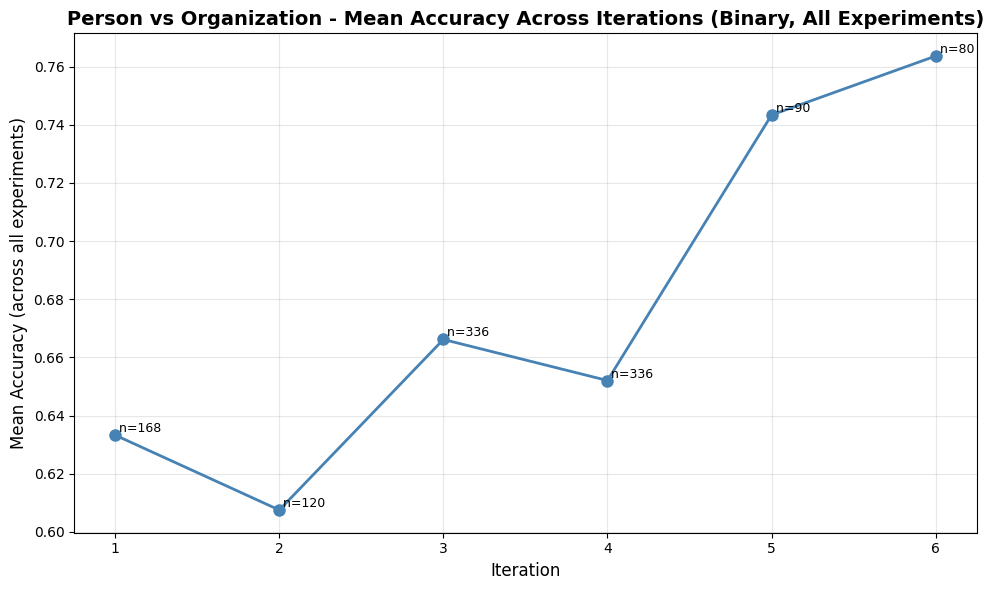


✅ נשמר גרף ב: POIs\Classification\Plots\person_vs_organization_mean_accuracy_across_iterations.png


In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
EXPERIMENTS_FILE = Path("POIs") / "Classification" / "Experiments" / "experiments_results.csv"
PLOTS_DIR = Path("POIs") / "Classification" / "Plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("UPDATE MEAN ACCURACY GRAPH - PERSON VS ORGANIZATION (Including Iteration 6)")
print("=" * 80)

# Load data
df = pd.read_csv(EXPERIMENTS_FILE, encoding="utf-8", on_bad_lines="skip")

# Clean and filter
df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")
df["#classes"] = pd.to_numeric(df["#classes"], errors="coerce")
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")

df = df.dropna(subset=["iteration", "#classes", "accuracy"]).copy()
df["iteration"] = df["iteration"].astype(int)
df["#classes"] = df["#classes"].astype(int)

# Binary only
df = df[df["#classes"] == 2].copy()

# Filter for person_vs_organization
sub = df[df["target_column"] == "person_vs_organization"].copy()

if sub.empty:
    print("WARNING: No data found for person_vs_organization")
else:
    # Calculate mean accuracy per iteration
    summary = (
        sub.groupby("iteration", as_index=False)
           .agg(mean_accuracy=("accuracy", "mean"),
                n_experiments=("accuracy", "count"))
           .sort_values("iteration")
    )
    
    print("\nIteration Summary (Person vs Organization):")
    print(summary.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(summary["iteration"], summary["mean_accuracy"], marker="o", linewidth=2, markersize=8, color='steelblue')
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Mean Accuracy (across all experiments)", fontsize=12)
    plt.title("Person vs Organization - Mean Accuracy Across Iterations (Binary, All Experiments)", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Annotate with n_experiments
    for _, r in summary.iterrows():
        plt.text(int(r["iteration"]), float(r["mean_accuracy"]), 
                f" n={int(r['n_experiments'])}", fontsize=9, va="bottom", ha="left")
    
    # Save
    plot_file = PLOTS_DIR / "person_vs_organization_mean_accuracy_across_iterations.png"
    plt.tight_layout()
    plt.savefig(plot_file, dpi=200)
    plt.show()
    
    print(f"\n✅ נשמר גרף ב: {plot_file}")
    print("=" * 80)

## Confidence Score Histogram - Iteration 6 (Person vs Organization)

CONFIDENCE SCORE HISTOGRAM - ITERATION 6 (Person vs Organization)

✓ Loaded 383 users from:
  iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv

Confidence Level Statistics:
  Min:  0.5017
  Max:  0.9848
  Mean: 0.7163
  Median: 0.6943
  Std:  0.0908


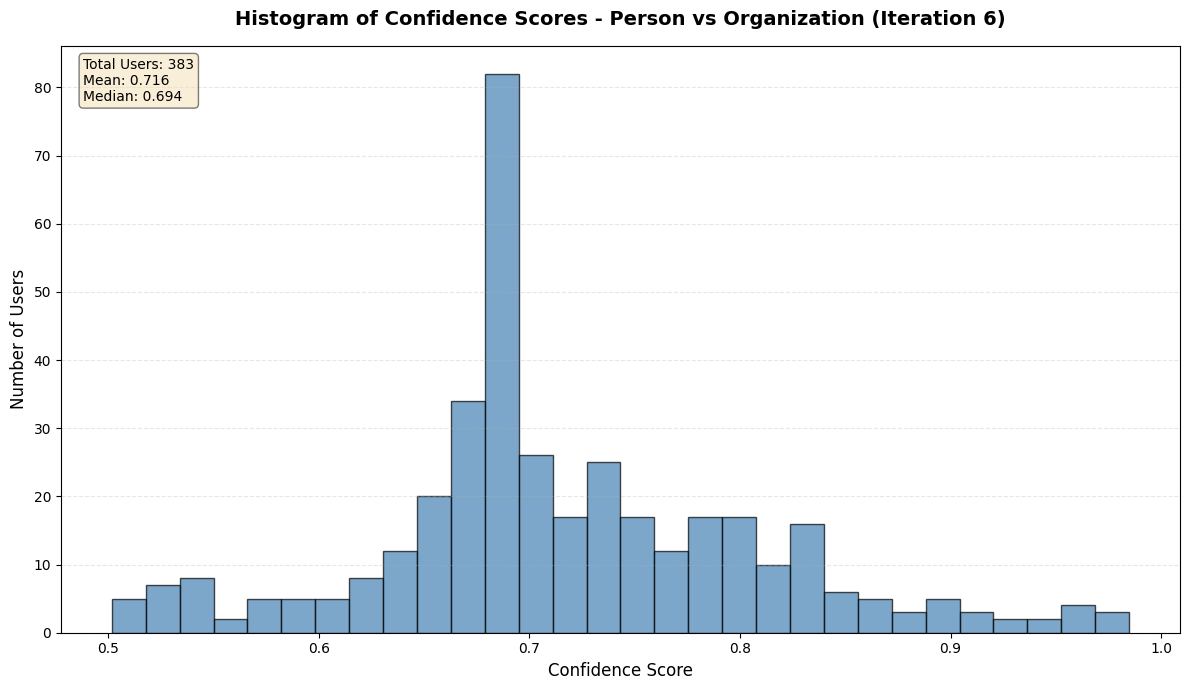


✅ נשמר גרף ב: POIs\Classification\Plots\confidence_score_histogram_person_vs_organization_iteration_6.png

Distribution by Confidence Ranges:
  Low (0.0-0.5)            :     0 ( 0.00%)
  Medium-Low (0.5-0.6)     :    32 ( 8.36%)
  Medium (0.6-0.7)         :   172 (44.91%)
  Medium-High (0.7-0.8)    :   115 (30.03%)
  High (0.8-0.9)           :    49 (12.79%)
  Very High (0.9-1.0)      :    15 ( 3.92%)


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print("=" * 80)
print("CONFIDENCE SCORE HISTOGRAM - ITERATION 6 (Person vs Organization)")
print("=" * 80)

# Paths
CLASSIFICATION_DIR = Path("POIs") / "Classification"
PLOTS_DIR = CLASSIFICATION_DIR / "Plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Load iteration 6 predictions
PRED_FILE = CLASSIFICATION_DIR / "iteration_6_unlabeled_users_predictions_person_vs_organization_logreg_loocv_desc_user_full_num.csv"

if not PRED_FILE.exists():
    print(f"ERROR: File not found: {PRED_FILE}")
else:
    # Load data
    df = pd.read_csv(PRED_FILE, encoding="utf-8")
    
    print(f"\n✓ Loaded {len(df)} users from:")
    print(f"  {PRED_FILE.name}")
    
    # Check for confidence_level column
    if 'confidence_level' not in df.columns:
        print("\nERROR: Column 'confidence_level' not found in file")
        print(f"Available columns: {list(df.columns)}")
    else:
        # Statistics
        print(f"\nConfidence Level Statistics:")
        print(f"  Min:  {df['confidence_level'].min():.4f}")
        print(f"  Max:  {df['confidence_level'].max():.4f}")
        print(f"  Mean: {df['confidence_level'].mean():.4f}")
        print(f"  Median: {df['confidence_level'].median():.4f}")
        print(f"  Std:  {df['confidence_level'].std():.4f}")
        
        # Create and save histogram
        plt.figure(figsize=(12, 7))
        n, bins, patches = plt.hist(df['confidence_level'], bins=30, color='steelblue', 
                                     edgecolor='black', alpha=0.7)
        
        plt.title('Histogram of Confidence Scores - Person vs Organization (Iteration 6)', 
                  fontsize=14, fontweight='bold', pad=15)
        plt.xlabel('Confidence Score', fontsize=12)
        plt.ylabel('Number of Users', fontsize=12)
        plt.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add statistics text box
        stats_text = f'Total Users: {len(df):,}\nMean: {df["confidence_level"].mean():.3f}\nMedian: {df["confidence_level"].median():.3f}'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Save figure
        output_file = PLOTS_DIR / "confidence_score_histogram_person_vs_organization_iteration_6.png"
        plt.tight_layout()
        plt.savefig(output_file, dpi=200, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ נשמר גרף ב: {output_file}")
        
        # Show distribution by bins
        print("\nDistribution by Confidence Ranges:")
        bins_ranges = [
            (0.0, 0.5, "Low (0.0-0.5)"),
            (0.5, 0.6, "Medium-Low (0.5-0.6)"),
            (0.6, 0.7, "Medium (0.6-0.7)"),
            (0.7, 0.8, "Medium-High (0.7-0.8)"),
            (0.8, 0.9, "High (0.8-0.9)"),
            (0.9, 1.0, "Very High (0.9-1.0)")
        ]
        
        for low, high, label in bins_ranges:
            count = len(df[(df['confidence_level'] >= low) & (df['confidence_level'] < high)])
            pct = (count / len(df)) * 100
            print(f"  {label:25s}: {count:5d} ({pct:5.2f}%)")
        
        print("=" * 80)

## STAGE 16 – SUMMARY TABLE: PERFORMANCE PER ITERATION (PERSON VS ORGANIZATION)

In [43]:
# =============================================================================
# STAGE 16 – SUMMARY TABLE: PERFORMANCE PER ITERATION (PERSON VS ORGANIZATION)
# =============================================================================
#
# GOAL:
# Generate a final summary table for Stage 16 that aggregates model performance
# per iteration for the person_vs_organization task, based on experiments_results.csv.
#
# This table is for STOPPING CRITERIA documentation.
# No training or prediction should be performed.
#
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

print("=" * 80)
print("STAGE 16 – SUMMARY TABLE: PERFORMANCE PER ITERATION")
print("Task: person_vs_organization")
print("=" * 80)

# =============================================================================
# STEP 1: LOAD DATA
# =============================================================================
print("\nSTEP 1: Loading experiments_results.csv...")

EXPERIMENTS_FILE = Path("POIs") / "Classification" / "Experiments" / "experiments_results.csv"
OUTPUT_FILE = Path("POIs") / "Classification" / "Experiments" / "experiments_results_summary_person_vs_organization.csv"

if not EXPERIMENTS_FILE.exists():
    raise FileNotFoundError(f"Missing file: {EXPERIMENTS_FILE}")

df = pd.read_csv(EXPERIMENTS_FILE, encoding="utf-8", on_bad_lines="skip")
print(f"✓ Loaded {len(df)} rows from experiments_results.csv")

# =============================================================================
# STEP 2: VALIDATE REQUIRED COLUMNS
# =============================================================================
print("\nSTEP 2: Validating required columns...")

required_cols = ["iteration", "target_column", "#classes", "accuracy", 
                 "AUC", "#class_0", "#class_1", "min_class_size"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"experiments_results.csv is missing columns: {missing}")

print(f"✓ All required columns present")

# =============================================================================
# STEP 3: FILTER DATA
# =============================================================================
print("\nSTEP 3: Filtering data...")

# Convert to numeric
df["iteration"] = pd.to_numeric(df["iteration"], errors="coerce")
df["#classes"] = pd.to_numeric(df["#classes"], errors="coerce")
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")
df["AUC"] = pd.to_numeric(df["AUC"], errors="coerce")
df["#class_0"] = pd.to_numeric(df["#class_0"], errors="coerce")
df["#class_1"] = pd.to_numeric(df["#class_1"], errors="coerce")
df["min_class_size"] = pd.to_numeric(df["min_class_size"], errors="coerce")

# Filter rows
mask = (
    (df["target_column"] == "person_vs_organization") &
    (df["#classes"] == 2) &
    (~df["accuracy"].isna())
)
df_filtered = df.loc[mask].copy()

print(f"✓ Filtered from {len(df)} to {len(df_filtered)} rows")
print(f"  - target_column == 'person_vs_organization'")
print(f"  - #classes == 2")
print(f"  - accuracy not NaN")

# =============================================================================
# STEP 4: AGGREGATE PER ITERATION
# =============================================================================
print("\nSTEP 4: Aggregating metrics per iteration...")

summary = (
    df_filtered
    .groupby("iteration", dropna=True)
    .agg(
        n_experiments=("accuracy", "size"),
        mean_accuracy=("accuracy", "mean"),
        max_accuracy=("accuracy", "max"),
        mean_AUC=("AUC", lambda x: x.mean(skipna=True)),  # ignore NaN
        mean_class_0=("#class_0", "mean"),
        mean_class_1=("#class_1", "mean"),
        min_class_size=("min_class_size", "min")
    )
    .reset_index()
)

# Ensure correct column order
summary = summary[[
    "iteration",
    "n_experiments",
    "mean_accuracy",
    "max_accuracy",
    "mean_AUC",
    "mean_class_0",
    "mean_class_1",
    "min_class_size"
]]

# Sort by iteration ascending
summary = summary.sort_values("iteration").reset_index(drop=True)

print(f"✓ Aggregated {len(summary)} iterations")

# =============================================================================
# STEP 5: VALIDATIONS
# =============================================================================
print("\nSTEP 5: Validations...")

# Assert at least 2 iterations
assert len(summary) >= 2, f"Expected at least 2 iterations, found {len(summary)}"
print(f"✓ At least 2 iterations exist: {len(summary)} iterations found")

# Assert n_experiments > 0 for every iteration
assert (summary["n_experiments"] > 0).all(), "Some iterations have 0 experiments"
print(f"✓ All iterations have n_experiments > 0")

# =============================================================================
# STEP 6: PRINT SUMMARY TABLE
# =============================================================================
print("\n" + "=" * 80)
print("SUMMARY TABLE: PERSON VS ORGANIZATION (BINARY CLASSIFICATION)")
print("=" * 80)
print()
print(summary.to_string(index=False))
print()

# =============================================================================
# STEP 7: SAVE TO CSV
# =============================================================================
print("=" * 80)
print("STEP 7: Saving summary to CSV...")

summary.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")
print(f"✓ Saved summary table to: {OUTPUT_FILE}")

# =============================================================================
# STEP 8: INTERPRETATION (STOPPING CRITERIA)
# =============================================================================
print("\n" + "=" * 80)
print("INTERPRETATION – STOPPING CRITERIA")
print("=" * 80)

if len(summary) >= 2:
    # Get last two iterations
    last_iter = summary.iloc[-1]
    prev_iter = summary.iloc[-2]
    
    last_iteration_num = int(last_iter["iteration"])
    prev_iteration_num = int(prev_iter["iteration"])
    
    last_acc = last_iter["mean_accuracy"]
    prev_acc = prev_iter["mean_accuracy"]
    
    acc_change = last_acc - prev_acc
    acc_change_pct = (acc_change / prev_acc) * 100 if prev_acc > 0 else 0
    
    print(f"\nIteration {prev_iteration_num} → Iteration {last_iteration_num}:")
    print(f"  Mean Accuracy: {prev_acc:.4f} → {last_acc:.4f}")
    print(f"  Change: {acc_change:+.4f} ({acc_change_pct:+.2f}%)")
    
    # Stopping criterion: improvement < 0.5%
    improvement_threshold = 0.5
    
    if abs(acc_change_pct) < improvement_threshold:
        print(f"\n⚠️  STOPPING SIGNAL:")
        print(f"  Accuracy change ({acc_change_pct:.2f}%) is below threshold ({improvement_threshold}%)")
        print(f"  Consider stopping active learning iterations.")
    else:
        print(f"\n✓ Accuracy change ({acc_change_pct:.2f}%) exceeds threshold ({improvement_threshold}%)")
        print(f"  Continue iterations if desired.")
    
    # Additional context
    print(f"\nLast iteration ({last_iteration_num}) details:")
    print(f"  Number of experiments: {int(last_iter['n_experiments'])}")
    print(f"  Max accuracy achieved: {last_iter['max_accuracy']:.4f}")
    print(f"  Mean AUC: {last_iter['mean_AUC']:.4f}" if not pd.isna(last_iter['mean_AUC']) else "  Mean AUC: N/A")
    print(f"  Mean #class_0 (org): {last_iter['mean_class_0']:.1f}")
    print(f"  Mean #class_1 (person): {last_iter['mean_class_1']:.1f}")
    print(f"  Min class size: {int(last_iter['min_class_size'])}")

print("\n" + "=" * 80)
print("STAGE 16 – SUMMARY TABLE COMPLETE")
print("=" * 80)

STAGE 16 – SUMMARY TABLE: PERFORMANCE PER ITERATION
Task: person_vs_organization

STEP 1: Loading experiments_results.csv...
✓ Loaded 4896 rows from experiments_results.csv

STEP 2: Validating required columns...
✓ All required columns present

STEP 3: Filtering data...
✓ Filtered from 4896 to 1130 rows
  - target_column == 'person_vs_organization'
  - #classes == 2
  - accuracy not NaN

STEP 4: Aggregating metrics per iteration...
✓ Aggregated 6 iterations

STEP 5: Validations...
✓ At least 2 iterations exist: 6 iterations found
✓ All iterations have n_experiments > 0

SUMMARY TABLE: PERSON VS ORGANIZATION (BINARY CLASSIFICATION)

 iteration  n_experiments  mean_accuracy  max_accuracy  mean_AUC  mean_class_0  mean_class_1  min_class_size
         1            168       0.633258      0.816092  0.466517          22.0          43.5            22.0
         2            120       0.607491      0.770115  0.510746          22.0          43.5            22.0
         3            336       0

## Classification Scripts - Iteration 2: Locals vs Diaspora

This section contains all classification scripts for iteration 2 of the locals_vs_diaspora task.

### Script 1: Main Experiment Runner

Full classification experiment grid on iteration 2 manually labeled data.

In [ ]:
"""
Run Classification Experiments: Iteration 2 - locals_vs_diaspora
================================================================
Results are appended to: POIs/Classification/Experiments/experiments_results.csv
"""

import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Configuration
ITERATION_NUM = 2
TARGET_COLUMN = "locals_vs_diaspora"
RANDOM_STATE = 42

# Paths
BASE_DIR = Path(os.getcwd())
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"
INPUT_FILE = CLASSIFICATION_DIR / "manual_labeling_iteration_1_locals_vs_diaspora.csv"

print("=" * 80)
print(f"ITERATION {ITERATION_NUM}: {TARGET_COLUMN}")
print("=" * 80)

# Load Data
df = pd.read_csv(INPUT_FILE)
print(f"[INFO] Loaded {len(df)} users")

label_col = "manual_label_locals_vs_diaspora"
df_labeled = df[df[label_col].notna()].copy()
y = df_labeled[label_col].astype(int).values

print(f"[INFO] Labeled users: {len(df_labeled)}")
print(f"[INFO] Classes: {np.unique(y)}")

# Feature Engineering
df_labeled['description'] = df_labeled['description'].fillna("").astype(str)
df_labeled['username'] = df_labeled['username'].fillna("").astype(str)
df_labeled['display_name'] = df_labeled['display_name'].fillna("").astype(str)

tfidf_desc = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_user = TfidfVectorizer(max_features=50, analyzer='char', ngram_range=(2, 4))
tfidf_name = TfidfVectorizer(max_features=30, ngram_range=(1, 2))

X_desc = tfidf_desc.fit_transform(df_labeled['description'])
X_user = tfidf_user.fit_transform(df_labeled['username'])
X_name = tfidf_name.fit_transform(df_labeled['display_name'])

num_cols = ['followers_count', 'following_count', 'statuses_count']
for col in num_cols:
    if col not in df_labeled.columns:
        df_labeled[col] = 0
    df_labeled[col] = pd.to_numeric(df_labeled[col], errors='coerce').fillna(0)

X_num = df_labeled[num_cols].values
X_num_sparse = csr_matrix(X_num)

feature_sets = {
    "TFIDF_description": X_desc,
    "TFIDF_username": X_user,
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
}

# Classifiers
classifiers = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, solver='lbfgs'),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, n_estimators=100, 
                             eval_metric='logloss', use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE, algorithm='SAMME'),
}

# Helper functions
def balance_classes(X, y, random_state=42):
    from collections import Counter
    counts = Counter(y)
    min_count = min(counts.values())
    indices = []
    np.random.seed(random_state)
    for label in counts.keys():
        label_indices = np.where(y == label)[0]
        if len(label_indices) > min_count:
            selected = np.random.choice(label_indices, min_count, replace=False)
        else:
            selected = label_indices
        indices.extend(selected)
    indices = np.array(indices)
    np.random.shuffle(indices)
    return X[indices], y[indices], indices

def run_cv_experiment(X, y, n_classes, cv_type, k, clf_name, clf_model):
    try:
        from sklearn.base import clone
        if cv_type == "KFold":
            cv = StratifiedKFold(n_splits=min(k, len(y)), shuffle=True, random_state=RANDOM_STATE)
        else:
            cv = LeaveOneOut()
            k = len(y)
        
        y_true, y_pred, y_proba = [], [], []
        for train_idx, test_idx in cv.split(X, y):
            X_train = X[train_idx] if hasattr(X, 'toarray') else X[train_idx, :]
            X_test = X[test_idx] if hasattr(X, 'toarray') else X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            clf = clone(clf_model)
            clf.fit(X_train, y_train)
            y_pred_fold = clf.predict(X_test)
            y_true.extend(y_test)
            y_pred.extend(y_pred_fold)
            if hasattr(clf, 'predict_proba'):
                y_proba.extend(clf.predict_proba(X_test))
        
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        auc = None
        if len(y_proba) > 0 and n_classes == 2:
            try:
                y_proba_arr = np.array(y_proba)
                if y_proba_arr.shape[1] == 2:
                    auc = roc_auc_score(y_true, y_proba_arr[:, 1])
            except:
                pass
        return acc, prec, rec, f1, auc, k
    except Exception as e:
        print(f"    [ERROR] {clf_name}: {str(e)[:100]}")
        return 0, 0, 0, 0, None, k

# Run Experiments
results_rows = []
experiment_count = 0

for fs_name, X_fs in feature_sets.items():
    print(f"\n[{fs_name}]")
    fs_results = []
    
    for n_classes in [2]:
        y_current = y.copy()
        class_counts = {c: np.sum(y_current == c) for c in np.unique(y_current)}
        
        for balanced in [False, True]:
            if balanced:
                X_bal, y_bal, _ = balance_classes(X_fs, y_current, random_state=RANDOM_STATE)
                class_counts_bal = {c: np.sum(y_bal == c) for c in np.unique(y_bal)}
            else:
                X_bal, y_bal = X_fs, y_current
                class_counts_bal = class_counts
            
            for cv_type in ["KFold", "LOOCV"]:
                k = 5 if cv_type == "KFold" else len(y_bal)
                
                for clf_name, clf_model in classifiers.items():
                    experiment_count += 1
                    print(f"  [{experiment_count}] {clf_name} | balanced={balanced} | cv={cv_type}")
                    
                    acc, prec, rec, f1, auc, eff_k = run_cv_experiment(
                        X_bal, y_bal, n_classes, cv_type, k, clf_name, clf_model
                    )
                    
                    row = {
                        "iteration": ITERATION_NUM,
                        "target_column": TARGET_COLUMN,
                        "#classes": float(n_classes),
                        "#class_0": float(class_counts_bal.get(0, 0)),
                        "#class_1": float(class_counts_bal.get(1, 0)),
                        "#class_2": None,
                        "min_class_size": float(min(class_counts_bal.values())),
                        "training_type": cv_type,
                        "K": float(eff_k),
                        "algorithm": clf_name,
                        "feature_set": fs_name,
                        "features_count": float(X_fs.shape[1]),
                        "balanced": balanced,
                        "accuracy": acc,
                        "precision": prec,
                        "recall": rec,
                        "F1": f1,
                        "AUC": auc,
                    }
                    fs_results.append(row)
    
    # Save after each feature set
    if fs_results:
        df_fs = pd.DataFrame(fs_results)
        if not RESULTS_FILE.exists():
            df_fs.to_csv(RESULTS_FILE, index=False, encoding='utf-8-sig')
        else:
            df_fs.to_csv(RESULTS_FILE, mode='a', header=False, index=False, encoding='utf-8-sig')
        results_rows.extend(fs_results)
        print(f"  [OK] Saved {len(fs_results)} experiments")

print(f"\n[DONE] Total {len(results_rows)} experiments saved")

### Script 2: Create Top Models Report

Extract top 20 models by Accuracy and AUC from experiment results

In [ ]:
"""
Create report of top 20 models by Accuracy and AUC for locals_vs_diaspora iteration 2
"""
import pandas as pd

print("Loading experiment results...")
df = pd.read_csv('POIs/Classification/Experiments/experiments_results.csv')

# Filter for iteration 2 locals_vs_diaspora
mask = (df['iteration'] == 2) & (df['target_column'] == 'locals_vs_diaspora')
results = df[mask].copy()

print(f"Found {len(results)} experiments for iteration 2 locals_vs_diaspora\n")

# Get top 20 by accuracy
top_acc = results.nlargest(20, 'accuracy')[['algorithm', 'feature_set', 'balanced', 'K', 
                                              'accuracy', 'precision', 'recall', 'F1', 'AUC']]

# Get top 20 by AUC
top_auc = results.nlargest(20, 'AUC')[['algorithm', 'feature_set', 'balanced', 'K', 
                                        'accuracy', 'precision', 'recall', 'F1', 'AUC']]

# Save to CSV files
output_file_acc = 'POIs/Classification/top_20_models_by_accuracy_locals_vs_diaspora.csv'
output_file_auc = 'POIs/Classification/top_20_models_by_auc_locals_vs_diaspora.csv'

top_acc.to_csv(output_file_acc, index=False, encoding='utf-8-sig')
top_auc.to_csv(output_file_auc, index=False, encoding='utf-8-sig')

print(f"[OK] Created: {output_file_acc}")
print(f"[OK] Created: {output_file_auc}\n")
print("="*100)
print("TOP 20 MODELS BY ACCURACY")
print("="*100)
print(top_acc.to_string(index=False))

print("\n" + "="*100)
print("TOP 20 MODELS BY AUC")
print("="*100)
print(top_auc.to_string(index=False))

### Script 3: Create Iteration 3 Files

Generate prediction and manual labeling files for iteration 3 using the best model from experiments

In [ ]:
"""
Create iteration 3 files for locals_vs_diaspora classification:
1. Prediction file for all unlabeled users (after removing manually labeled iteration 1)
2. Manual labeling file for iteration 3 (40 most uncertain users)
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
# Load base data
base_data = pd.read_csv('POIs/Classification/base_data_locals_vs_diaspora.csv')
print(f"Base data: {len(base_data)} users")

# Load manually labeled iteration 1
manual_labeled = pd.read_csv('POIs/Classification/manual_labeling_iteration_1_locals_vs_diaspora.csv')
print(f"Manual labeled iteration 1: {len(manual_labeled)} users")

# Remove manually labeled users from base data
unlabeled_data = base_data[~base_data['username'].isin(manual_labeled['username'])].copy()
print(f"Unlabeled users: {len(unlabeled_data)} users")

# Prepare training data from manual labeled iteration 1
print("\nPreparing training data...")
train_data = manual_labeled.copy()

# Fill missing values
for col in ['description', 'username', 'display_name']:
    if col in train_data.columns:
        train_data[col] = train_data[col].fillna('')
    if col in unlabeled_data.columns:
        unlabeled_data[col] = unlabeled_data[col].fillna('')

# Get labels (already numeric: 0=diaspora, 1=local)
y_train = train_data['manual_label_locals_vs_diaspora'].values

print(f"Training labels distribution: diaspora={sum(y_train==0)}, local={sum(y_train==1)}")

# Feature engineering - use best model configuration from experiments
# Best model: AdaBoost with TFIDF_description+username+display_name
print("\nCreating features...")

# TF-IDF for description (100 features)
tfidf_desc = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
X_train_desc = tfidf_desc.fit_transform(train_data['description'])
X_unlabeled_desc = tfidf_desc.transform(unlabeled_data['description'])

# TF-IDF for username (50 features, character level)
tfidf_user = TfidfVectorizer(max_features=50, analyzer='char', ngram_range=(2, 4))
X_train_user = tfidf_user.fit_transform(train_data['username'])
X_unlabeled_user = tfidf_user.transform(unlabeled_data['username'])

# TF-IDF for display_name (30 features)
tfidf_name = TfidfVectorizer(max_features=30, ngram_range=(1, 2))
X_train_name = tfidf_name.fit_transform(train_data['display_name'])
X_unlabeled_name = tfidf_name.transform(unlabeled_data['display_name'])

# Combine features
X_train = hstack([X_train_desc, X_train_user, X_train_name])
X_unlabeled = hstack([X_unlabeled_desc, X_unlabeled_user, X_unlabeled_name])

print(f"Feature matrix shape: train={X_train.shape}, unlabeled={X_unlabeled.shape}")

# Train best model: AdaBoost
print("\nTraining AdaBoost model...")
model = AdaBoostClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Predict on unlabeled data
print("Predicting on unlabeled users...")
predictions = model.predict(X_unlabeled)
probabilities = model.predict_proba(X_unlabeled)

# Calculate uncertainty (entropy)
# For binary classification: entropy = -p0*log(p0) - p1*log(p1)
prob_0 = probabilities[:, 0]
prob_1 = probabilities[:, 1]
epsilon = 1e-10  # To avoid log(0)
uncertainty = -(prob_0 * np.log2(prob_0 + epsilon) + prob_1 * np.log2(prob_1 + epsilon))

# Create prediction dataframe
reverse_label_map = {0: 'diaspora', 1: 'local'}
unlabeled_data['predicted_label'] = [reverse_label_map[p] for p in predictions]
unlabeled_data['confidence_diaspora'] = prob_0
unlabeled_data['confidence_local'] = prob_1
unlabeled_data['uncertainty'] = uncertainty

# Sort by uncertainty (highest first)
unlabeled_data_sorted = unlabeled_data.sort_values('uncertainty', ascending=False).reset_index(drop=True)

# Create predictions file
print("\nCreating prediction file...")
predictions_file = 'POIs/Classification/iteration_2_unlabeled_users_predictions_locals_vs_diaspora.csv'
unlabeled_data_sorted.to_csv(predictions_file, index=False, encoding='utf-8-sig')
print(f"[OK] Saved {len(unlabeled_data_sorted)} predictions to {predictions_file}")

# Create manual labeling file for iteration 3 (top 40 most uncertain users)
print("\nCreating manual labeling file for iteration 3...")
iteration_3_users = unlabeled_data_sorted.head(40).copy()

# Add empty label columns for manual labeling
iteration_3_users['locals_vs_diaspora'] = ''

# Reorder columns to match manual labeling format
cols_to_keep = ['username', 'display_name', 'description', 'location', 
                'followers_count', 'following_count', 'statuses_count',
                'profile_image_url', 'predicted_label', 'confidence_diaspora', 
                'confidence_local', 'uncertainty', 'locals_vs_diaspora']

# Only keep columns that exist
cols_to_keep = [col for col in cols_to_keep if col in iteration_3_users.columns]
iteration_3_users = iteration_3_users[cols_to_keep]

manual_labeling_file = 'POIs/Classification/manual_labeling_iteration_3_locals_vs_diaspora.csv'
iteration_3_users.to_csv(manual_labeling_file, index=False, encoding='utf-8-sig')
print(f"[OK] Saved 40 users for manual labeling to {manual_labeling_file}")

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total base users: {len(base_data)}")
print(f"Already labeled (iteration 1): {len(manual_labeled)}")
print(f"Unlabeled users: {len(unlabeled_data)}")
print(f"\nPrediction distribution:")
print(f"  Predicted as diaspora: {sum(predictions == 0)} ({100*sum(predictions == 0)/len(predictions):.1f}%)")
print(f"  Predicted as local: {sum(predictions == 1)} ({100*sum(predictions == 1)/len(predictions):.1f}%)")
print(f"\nAverage uncertainty: {uncertainty.mean():.4f}")
print(f"Uncertainty range: {uncertainty.min():.4f} - {uncertainty.max():.4f}")
print(f"\nTop 40 users selected for iteration 3 manual labeling")
print(f"Average uncertainty of selected users: {iteration_3_users['uncertainty'].mean():.4f}")
print("\n" + "="*60)
print("Files created:")
print(f"  1. {predictions_file}")
print(f"  2. {manual_labeling_file}")
print("="*60)

## ITERATION 2 - UPDATED PREDICTIONS (LOGISTIC REGRESSION, ALL TEXT)

Active Learning Step: Re-predict unlabeled users with selected model and sample top 80 uncertain for iteration 3 manual labeling

In [3]:
"""
ITERATION 2 - UPDATED PREDICTIONS FOR LOCALS VS DIASPORA
Active Learning Step: Re-predict unlabeled users with Logistic Regression and sample top 80 uncertain for iteration 3
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ITERATION 2 PREDICTION UPDATE - LOCALS VS DIASPORA")
print("=" * 80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/7] Loading data...")

# Load labeled data from iteration 1
df_labeled = pd.read_csv("POIs/Classification/manual_labeling_iteration_1_locals_vs_diaspora.csv")

# Load base data and filter out already labeled users
df_base = pd.read_csv("POIs/Classification/base_data_locals_vs_diaspora.csv")
df_unlabeled = df_base[~df_base['username'].isin(df_labeled['username'])].copy()

print(f"  Labeled data: {len(df_labeled)} rows")
print(f"  Unlabeled data: {len(df_unlabeled)} rows")

# ============================================================================
# PREPARE TRAINING DATA
# ============================================================================
print("\n[2/7] Preparing training data...")

# Filter training data
label_col = "manual_label_locals_vs_diaspora"
df_train = df_labeled[df_labeled[label_col].notna()].copy()  # Drop NaN
df_train = df_train[df_train[label_col] != 2].copy()  # Drop unknown (2)

print(f"  Training samples after filtering: {len(df_train)}")
print(f"  Label distribution:")
label_counts = df_train[label_col].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = "diaspora" if label == 0 else "local"
    print(f"    {int(label)} ({label_name}): {count}")

# Extract labels
y_train = df_train[label_col].astype(int).values

# ============================================================================
# FEATURE ENGINEERING - TEXT ONLY
# ============================================================================
print("\n[3/7] Building text features...")

# Fill missing text values
text_cols = ['description', 'display_name', 'username']
for col in text_cols:
    if col not in df_train.columns:
        df_train[col] = ""
    if col not in df_unlabeled.columns:
        df_unlabeled[col] = ""
    df_train[col] = df_train[col].fillna("").astype(str)
    df_unlabeled[col] = df_unlabeled[col].fillna("").astype(str)

# TF-IDF vectorizers
vectorizer_desc = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_name = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_user = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

# Fit on training data
print("  Fitting TF-IDF vectorizers on training data...")
X_train_desc = vectorizer_desc.fit_transform(df_train['description'])
X_train_name = vectorizer_name.fit_transform(df_train['display_name'])
X_train_user = vectorizer_user.fit_transform(df_train['username'])

# Transform unlabeled data
print("  Transforming unlabeled data...")
X_unlabeled_desc = vectorizer_desc.transform(df_unlabeled['description'])
X_unlabeled_name = vectorizer_name.transform(df_unlabeled['display_name'])
X_unlabeled_user = vectorizer_user.transform(df_unlabeled['username'])

# Combine features
X_train_all_text = hstack([X_train_desc, X_train_name, X_train_user])
X_unlabeled_all_text = hstack([X_unlabeled_desc, X_unlabeled_name, X_unlabeled_user])

print(f"  Training feature matrix: {X_train_all_text.shape}")
print(f"  Unlabeled feature matrix: {X_unlabeled_all_text.shape}")

# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\n[4/7] Training Logistic Regression model...")
model = LogisticRegression(
    solver='liblinear',
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train_all_text, y_train)
print("  Model trained successfully")
print(f"  Classes: {model.classes_}")

# ============================================================================
# PREDICT ON UNLABELED DATA
# ============================================================================
print("\n[5/7] Predicting on unlabeled users...")
predictions = model.predict(X_unlabeled_all_text)
probabilities = model.predict_proba(X_unlabeled_all_text)

# Extract probabilities
prob_0 = probabilities[:, 0]  # diaspora
prob_1 = probabilities[:, 1]  # local

# Calculate confidence and uncertainty
confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1 - confidence_level

# Validation
prob_sum = prob_0 + prob_1
assert np.allclose(prob_sum, 1.0, atol=0.01), "Probabilities do not sum to 1!"
assert len(predictions) == len(df_unlabeled), "Prediction count mismatch!"

print(f"  Predictions generated: {len(predictions)}")
print(f"  Prediction distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for pred, count in zip(unique, counts):
    pred_name = "diaspora" if pred == 0 else "local"
    print(f"    {int(pred)} ({pred_name}): {count} ({100*count/len(predictions):.1f}%)")

# Add predictions to unlabeled dataframe
df_unlabeled_pred = df_unlabeled.copy()
df_unlabeled_pred['predicted_class'] = predictions.astype(str)
df_unlabeled_pred['prob_0'] = prob_0
df_unlabeled_pred['prob_1'] = prob_1
df_unlabeled_pred['prob_2'] = np.nan  # Binary task
df_unlabeled_pred['confidence_level'] = confidence_level
df_unlabeled_pred['uncertainty_score'] = uncertainty_score

print(f"  Mean confidence level: {confidence_level.mean():.4f}")
print(f"  Mean uncertainty score: {uncertainty_score.mean():.4f}")

# ============================================================================
# SAVE PREDICTIONS
# ============================================================================
print("\n[6/7] Saving updated predictions...")
predictions_output = "POIs/Classification/iteration_2_unlabeled_users_predictions_locals_vs_diaspora.csv"
df_unlabeled_pred.to_csv(predictions_output, index=False, encoding='utf-8-sig')
print(f"  Saved: {predictions_output}")
print(f"  Total rows: {len(df_unlabeled_pred)}")

# ============================================================================
# SAMPLE TOP 80 MOST UNCERTAIN FOR ITERATION 3 MANUAL LABELING
# ============================================================================
print("\n[7/7] Creating iteration 3 manual labeling file...")

# Sort by uncertainty (highest first)
df_sorted = df_unlabeled_pred.sort_values('uncertainty_score', ascending=False).reset_index(drop=True)

# Take top 80
df_top80 = df_sorted.head(80).copy()

# Prepare manual labeling file
manual_cols = ['username', 'display_name', 'description']
if 'location' in df_top80.columns:
    manual_cols.append('location')
manual_cols.extend(['predicted_class', 'confidence_level', 'uncertainty_score', 'prob_0', 'prob_1'])

# Filter existing columns
manual_labeling_data = df_top80[[col for col in manual_cols if col in df_top80.columns]].copy()

# Add empty label column for manual work
manual_labeling_data['manual_label_locals_vs_diaspora'] = ""

# Save
manual_labeling_output = "POIs/Classification/iteration_3_manual_labels_locals_vs_diaspora_top80_uncertain.csv"
manual_labeling_data.to_csv(manual_labeling_output, index=False, encoding='utf-8-sig')
print(f"  Saved: {manual_labeling_output}")
print(f"  Top 80 most uncertain users selected")
print(f"  Uncertainty range: {df_top80['uncertainty_score'].min():.4f} - {df_top80['uncertainty_score'].max():.4f}")

# Show top 10 most uncertain
print("\n  Top 10 most uncertain users:")
top10 = df_top80[['username', 'predicted_class', 'confidence_level', 'uncertainty_score']].head(10)
for idx, row in top10.iterrows():
    pred_name = "diaspora" if row['predicted_class'] == '0' else "local"
    print(f"    {idx+1}. @{row['username']} | pred={pred_name} | conf={row['confidence_level']:.3f} | uncert={row['uncertainty_score']:.3f}")

print("\n" + "=" * 80)
print("ITERATION 2 PREDICTION UPDATE COMPLETE")
print("=" * 80)
print(f"[OK] Updated predictions: {predictions_output}")
print(f"[OK] Iteration 3 manual labeling file: {manual_labeling_output}")
print("=" * 80)


ITERATION 2 PREDICTION UPDATE - LOCALS VS DIASPORA

[1/7] Loading data...
  Labeled data: 40 rows
  Unlabeled data: 276 rows

[2/7] Preparing training data...
  Training samples after filtering: 40
  Label distribution:
    0 (diaspora): 13
    1 (local): 27

[3/7] Building text features...
  Fitting TF-IDF vectorizers on training data...
  Transforming unlabeled data...
  Training feature matrix: (40, 653)
  Unlabeled feature matrix: (276, 653)

[4/7] Training Logistic Regression model...
  Model trained successfully
  Classes: [0 1]

[5/7] Predicting on unlabeled users...
  Predictions generated: 276
  Prediction distribution:
    0 (diaspora): 58 (21.0%)
    1 (local): 218 (79.0%)
  Mean confidence level: 0.5727
  Mean uncertainty score: 0.4273

[6/7] Saving updated predictions...
  Saved: POIs/Classification/iteration_2_unlabeled_users_predictions_locals_vs_diaspora.csv
  Total rows: 276

[7/7] Creating iteration 3 manual labeling file...
  Saved: POIs/Classification/iteration_3_ma

### RUN ITERATION 3 CLASSIFICATION EXPERIMENTS - LOCALS VS DIASPORA

In [1]:
"""
Run Classification Experiments: Iteration 3 - locals_vs_diaspora
================================================================
Results are appended to: POIs/Classification/Experiments/experiments_results.csv
"""

import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Configuration
ITERATION_NUM = 3
TARGET_COLUMN = "locals_vs_diaspora"
RANDOM_STATE = 42

# Paths
BASE_DIR = Path(os.getcwd())
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"
INPUT_FILE = CLASSIFICATION_DIR / "manual_labeling_iteration_3_locals_vs_diaspora.csv"

print("=" * 80)
print(f"ITERATION {ITERATION_NUM}: {TARGET_COLUMN}")
print("=" * 80)

# Load Data
df = pd.read_csv(INPUT_FILE)
print(f"[INFO] Loaded {len(df)} users")

label_col = "manual_label_locals_vs_diaspora"
df_labeled = df[df[label_col].notna()].copy()
y = df_labeled[label_col].astype(int).values

print(f"[INFO] Labeled users: {len(df_labeled)}")
print(f"[INFO] Classes: {np.unique(y)}")

# Feature Engineering
df_labeled['description'] = df_labeled['description'].fillna("").astype(str)
df_labeled['username'] = df_labeled['username'].fillna("").astype(str)
df_labeled['display_name'] = df_labeled['display_name'].fillna("").astype(str)

tfidf_desc = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_user = TfidfVectorizer(max_features=50, analyzer='char', ngram_range=(2, 4))
tfidf_name = TfidfVectorizer(max_features=30, ngram_range=(1, 2))

X_desc = tfidf_desc.fit_transform(df_labeled['description'])
X_user = tfidf_user.fit_transform(df_labeled['username'])
X_name = tfidf_name.fit_transform(df_labeled['display_name'])

num_cols = ['followers_count', 'following_count', 'statuses_count']
for col in num_cols:
    if col not in df_labeled.columns:
        df_labeled[col] = 0
    df_labeled[col] = pd.to_numeric(df_labeled[col], errors='coerce').fillna(0)

X_num = df_labeled[num_cols].values
X_num_sparse = csr_matrix(X_num)

feature_sets = {
    "TFIDF_description": X_desc,
    "TFIDF_username": X_user,
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
}

# Classifiers
classifiers = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, solver='lbfgs'),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, n_estimators=100, 
                             eval_metric='logloss', use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE, algorithm='SAMME'),
}

# Helper functions
def balance_classes(X, y, random_state=42):
    from collections import Counter
    counts = Counter(y)
    min_count = min(counts.values())
    indices = []
    np.random.seed(random_state)
    for label in counts.keys():
        label_indices = np.where(y == label)[0]
        if len(label_indices) > min_count:
            selected = np.random.choice(label_indices, min_count, replace=False)
        else:
            selected = label_indices
        indices.extend(selected)
    indices = np.array(indices)
    np.random.shuffle(indices)
    return X[indices], y[indices], indices

def run_cv_experiment(X, y, n_classes, cv_type, k, clf_name, clf_model):
    try:
        from sklearn.base import clone
        if cv_type == "KFold":
            cv = StratifiedKFold(n_splits=min(k, len(y)), shuffle=True, random_state=RANDOM_STATE)
        else:
            cv = LeaveOneOut()
            k = len(y)
        
        y_true, y_pred, y_proba = [], [], []
        for train_idx, test_idx in cv.split(X, y):
            X_train = X[train_idx] if hasattr(X, 'toarray') else X[train_idx, :]
            X_test = X[test_idx] if hasattr(X, 'toarray') else X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            clf = clone(clf_model)
            clf.fit(X_train, y_train)
            y_pred_fold = clf.predict(X_test)
            y_true.extend(y_test)
            y_pred.extend(y_pred_fold)
            if hasattr(clf, 'predict_proba'):
                y_proba.extend(clf.predict_proba(X_test))
        
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        auc = None
        if len(y_proba) > 0 and n_classes == 2:
            try:
                y_proba_arr = np.array(y_proba)
                if y_proba_arr.shape[1] == 2:
                    auc = roc_auc_score(y_true, y_proba_arr[:, 1])
            except:
                pass
        return acc, prec, rec, f1, auc, k
    except Exception as e:
        print(f"    [ERROR] {clf_name}: {str(e)[:100]}")
        return 0, 0, 0, 0, None, k

# Run Experiments
results_rows = []
experiment_count = 0

for fs_name, X_fs in feature_sets.items():
    print(f"\n[{fs_name}]")
    fs_results = []
    
    for n_classes in [2]:
        y_current = y.copy()
        class_counts = {c: np.sum(y_current == c) for c in np.unique(y_current)}
        
        for balanced in [False, True]:
            if balanced:
                X_bal, y_bal, _ = balance_classes(X_fs, y_current, random_state=RANDOM_STATE)
                class_counts_bal = {c: np.sum(y_bal == c) for c in np.unique(y_bal)}
            else:
                X_bal, y_bal = X_fs, y_current
                class_counts_bal = class_counts
            
            for cv_type in ["KFold", "LOOCV"]:
                k = 5 if cv_type == "KFold" else len(y_bal)
                
                for clf_name, clf_model in classifiers.items():
                    experiment_count += 1
                    print(f"  [{experiment_count}] {clf_name} | balanced={balanced} | cv={cv_type}")
                    
                    acc, prec, rec, f1, auc, eff_k = run_cv_experiment(
                        X_bal, y_bal, n_classes, cv_type, k, clf_name, clf_model
                    )
                    
                    row = {
                        "iteration": ITERATION_NUM,
                        "target_column": TARGET_COLUMN,
                        "#classes": float(n_classes),
                        "#class_0": float(class_counts_bal.get(0, 0)),
                        "#class_1": float(class_counts_bal.get(1, 0)),
                        "#class_2": None,
                        "min_class_size": float(min(class_counts_bal.values())),
                        "training_type": cv_type,
                        "K": float(eff_k),
                        "algorithm": clf_name,
                        "feature_set": fs_name,
                        "features_count": float(X_fs.shape[1]),
                        "balanced": balanced,
                        "accuracy": acc,
                        "precision": prec,
                        "recall": rec,
                        "F1": f1,
                        "AUC": auc,
                    }
                    fs_results.append(row)
    
    # Save after each feature set
    if fs_results:
        df_fs = pd.DataFrame(fs_results)
        if not RESULTS_FILE.exists():
            df_fs.to_csv(RESULTS_FILE, index=False, encoding='utf-8-sig')
        else:
            df_fs.to_csv(RESULTS_FILE, mode='a', header=False, index=False, encoding='utf-8-sig')
        results_rows.extend(fs_results)
        print(f"  [OK] Saved {len(fs_results)} experiments")

print(f"\n[DONE] Total {len(results_rows)} experiments saved")


ITERATION 3: locals_vs_diaspora
[INFO] Loaded 120 users
[INFO] Labeled users: 120
[INFO] Classes: [0 1]

[TFIDF_description]
  [1] LogReg | balanced=False | cv=KFold
  [2] DecisionTree | balanced=False | cv=KFold
  [3] RandomForest | balanced=False | cv=KFold
  [4] SVM | balanced=False | cv=KFold
  [5] XGBoost | balanced=False | cv=KFold
  [6] AdaBoost | balanced=False | cv=KFold
  [7] LogReg | balanced=False | cv=LOOCV
  [8] DecisionTree | balanced=False | cv=LOOCV
  [9] RandomForest | balanced=False | cv=LOOCV
  [10] SVM | balanced=False | cv=LOOCV
  [11] XGBoost | balanced=False | cv=LOOCV
  [12] AdaBoost | balanced=False | cv=LOOCV
  [13] LogReg | balanced=True | cv=KFold
  [14] DecisionTree | balanced=True | cv=KFold
  [15] RandomForest | balanced=True | cv=KFold
  [16] SVM | balanced=True | cv=KFold
  [17] XGBoost | balanced=True | cv=KFold
  [18] AdaBoost | balanced=True | cv=KFold
  [19] LogReg | balanced=True | cv=LOOCV
  [20] DecisionTree | balanced=True | cv=LOOCV
  [21] Ran

### CREATE TOP MODELS REPORT - ITERATION 3

In [2]:
"""
Generate Top 20 Models Report - Iteration 3
"""
import pandas as pd

# Load all experiments
results_file = "POIs/Classification/Experiments/experiments_results.csv"
df = pd.read_csv(results_file)

# Filter iteration 3, locals_vs_diaspora
df_iter3 = df[(df['iteration'] == 3) & (df['target_column'] == 'locals_vs_diaspora')].copy()

print(f"Total experiments for iteration 3: {len(df_iter3)}")

if len(df_iter3) > 0:
    # Top 20 by Accuracy
    df_top_acc = df_iter3.nlargest(20, 'accuracy')[
        ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    ]
    
    output_acc = "POIs/Classification/top_20_models_by_accuracy_iteration_3_locals_vs_diaspora.csv"
    df_top_acc.to_csv(output_acc, index=False, encoding='utf-8-sig')
    print(f"\n[OK] Top 20 by Accuracy saved to: {output_acc}")
    print(df_top_acc.head(10))
    
    # Top 20 by AUC
    df_with_auc = df_iter3[df_iter3['AUC'].notna()].copy()
    if len(df_with_auc) > 0:
        df_top_auc = df_with_auc.nlargest(20, 'AUC')[
            ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
        ]
        
        output_auc = "POIs/Classification/top_20_models_by_auc_iteration_3_locals_vs_diaspora.csv"
        df_top_auc.to_csv(output_auc, index=False, encoding='utf-8-sig')
        print(f"\n[OK] Top 20 by AUC saved to: {output_auc}")
        print(df_top_auc.head(10))
else:
    print("[WARNING] No experiments found for iteration 3")


Total experiments for iteration 3: 120

[OK] Top 20 by Accuracy saved to: POIs/Classification/top_20_models_by_accuracy_iteration_3_locals_vs_diaspora.csv
         algorithm                           feature_set training_type  \
4971           SVM            TFIDF_description+username         KFold   
4977           SVM            TFIDF_description+username         LOOCV   
5003      AdaBoost           TFIDF_description+full_name         LOOCV   
4968        LogReg            TFIDF_description+username         KFold   
5019           SVM  TFIDF_description+username+full_name         KFold   
4922  RandomForest                     TFIDF_description         KFold   
4923           SVM                     TFIDF_description         KFold   
4930       XGBoost                     TFIDF_description         LOOCV   
4944        LogReg                        TFIDF_username         KFold   
4947           SVM                        TFIDF_username         KFold   

      balanced  accuracy  prec

### ITERATION 3 - PREDICT UNLABELED USERS (LOGISTIC REGRESSION + ALL_TEXT + BALANCED)

In [1]:
"""
ITERATION 3 - PREDICT UNLABELED USERS
Model: Logistic Regression + All Text Features (description+username+display_name) + Balanced
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ITERATION 3 PREDICTION - LOCALS VS DIASPORA")
print("=" * 80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/7] Loading data...")

# Load labeled data from iteration 3 (120 users)
df_labeled = pd.read_csv("POIs/Classification/manual_labeling_iteration_3_locals_vs_diaspora.csv")

# Load all unlabeled users from after iteration 2
df_unlabeled_all = pd.read_csv("POIs/Classification/unlabeled_users_after_iteration_3_locals_vs_diaspora.csv")

print(f"  Labeled data (iteration 3): {len(df_labeled)} rows")
print(f"  All unlabeled (after iteration 2): {len(df_unlabeled_all)} rows")

# Filter out users that were labeled in iteration 3
label_col = "manual_label_locals_vs_diaspora"
newly_labeled_users = df_labeled[df_labeled[label_col].notna()]['username'].values
df_unlabeled = df_unlabeled_all[~df_unlabeled_all['username'].isin(newly_labeled_users)].copy()

print(f"  Newly labeled in iteration 3: {len(newly_labeled_users)}")
print(f"  Remaining unlabeled (truly unlabeled): {len(df_unlabeled)} rows")

# ============================================================================
# PREPARE TRAINING DATA
# ============================================================================
print("\n[2/7] Preparing training data...")

# Filter training data
label_col = "manual_label_locals_vs_diaspora"
df_train = df_labeled[df_labeled[label_col].notna()].copy()  # Drop NaN
df_train = df_train[df_train[label_col] != 2].copy()  # Drop unknown (2)

print(f"  Training samples after filtering: {len(df_train)}")
print(f"  Label distribution:")
label_counts = df_train[label_col].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = "diaspora" if label == 0 else "local"
    print(f"    {int(label)} ({label_name}): {count}")

# Extract labels
y_train = df_train[label_col].astype(int).values

# ============================================================================
# FEATURE ENGINEERING - TEXT ONLY (ALL TEXT)
# ============================================================================
print("\n[3/7] Building text features (description + username + display_name)...")

# Fill missing text values
text_cols = ['description', 'display_name', 'username']
for col in text_cols:
    if col not in df_train.columns:
        df_train[col] = ""
    if col not in df_unlabeled.columns:
        df_unlabeled[col] = ""
    df_train[col] = df_train[col].fillna("").astype(str)
    df_unlabeled[col] = df_unlabeled[col].fillna("").astype(str)

# TF-IDF vectorizers
vectorizer_desc = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_name = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_user = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

# Fit on training data
print("  Fitting TF-IDF vectorizers on training data...")
X_train_desc = vectorizer_desc.fit_transform(df_train['description'])
X_train_name = vectorizer_name.fit_transform(df_train['display_name'])
X_train_user = vectorizer_user.fit_transform(df_train['username'])

# Transform unlabeled data
print("  Transforming unlabeled data...")
X_unlabeled_desc = vectorizer_desc.transform(df_unlabeled['description'])
X_unlabeled_name = vectorizer_name.transform(df_unlabeled['display_name'])
X_unlabeled_user = vectorizer_user.transform(df_unlabeled['username'])

# Combine features (ALL TEXT)
X_train_all_text = hstack([X_train_desc, X_train_name, X_train_user])
X_unlabeled_all_text = hstack([X_unlabeled_desc, X_unlabeled_name, X_unlabeled_user])

print(f"  Training feature matrix: {X_train_all_text.shape}")
print(f"  Unlabeled feature matrix: {X_unlabeled_all_text.shape}")

# ============================================================================
# BALANCE TRAINING DATA
# ============================================================================
print("\n[4/7] Balancing training data...")

counts = Counter(y_train)
min_count = min(counts.values())
print(f"  Original class distribution: {dict(counts)}")
print(f"  Target size per class (balanced): {min_count}")

indices = []
np.random.seed(42)
for label in counts.keys():
    label_indices = np.where(y_train == label)[0]
    if len(label_indices) > min_count:
        selected = np.random.choice(label_indices, min_count, replace=False)
    else:
        selected = label_indices
    indices.extend(selected)

indices = np.array(indices)
np.random.shuffle(indices)

X_train_balanced = X_train_all_text[indices]
y_train_balanced = y_train[indices]

print(f"  Balanced training size: {len(y_train_balanced)}")
balanced_counts = Counter(y_train_balanced)
print(f"  Balanced class distribution: {dict(balanced_counts)}")

# ============================================================================
# TRAIN MODEL
# ============================================================================
print("\n[5/7] Training Logistic Regression model...")
model = LogisticRegression(
    solver='liblinear',
    max_iter=5000,
    random_state=42
)

model.fit(X_train_balanced, y_train_balanced)
print("  Model trained successfully")
print(f"  Classes: {model.classes_}")

# ============================================================================
# PREDICT ON UNLABELED DATA
# ============================================================================
print("\n[6/7] Predicting on unlabeled users...")
predictions = model.predict(X_unlabeled_all_text)
probabilities = model.predict_proba(X_unlabeled_all_text)

# Extract probabilities
prob_0 = probabilities[:, 0]  # diaspora
prob_1 = probabilities[:, 1]  # local

# Calculate confidence and uncertainty
confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1 - confidence_level

# Validation
prob_sum = prob_0 + prob_1
assert np.allclose(prob_sum, 1.0, atol=0.01), "Probabilities do not sum to 1!"
assert len(predictions) == len(df_unlabeled), "Prediction count mismatch!"

print(f"  Predictions generated: {len(predictions)}")
print(f"  Prediction distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for pred, count in zip(unique, counts):
    pred_name = "diaspora" if pred == 0 else "local"
    print(f"    {int(pred)} ({pred_name}): {count} ({100*count/len(predictions):.1f}%)")

# Add predictions to unlabeled dataframe
df_unlabeled_pred = df_unlabeled.copy()
df_unlabeled_pred['predicted_class'] = predictions.astype(str)
df_unlabeled_pred['prob_0'] = prob_0
df_unlabeled_pred['prob_1'] = prob_1
df_unlabeled_pred['prob_2'] = np.nan  # Binary task
df_unlabeled_pred['confidence_level'] = confidence_level
df_unlabeled_pred['uncertainty_score'] = uncertainty_score

print(f"  Mean confidence level: {confidence_level.mean():.4f}")
print(f"  Mean uncertainty score: {uncertainty_score.mean():.4f}")

# ============================================================================
# SAVE PREDICTIONS
# ============================================================================
print("\n[7/7] Saving predictions...")
predictions_output = "POIs/Classification/iteration_3_unlabeled_users_predictions_locals_vs_diaspora.csv"
df_unlabeled_pred.to_csv(predictions_output, index=False, encoding='utf-8-sig')
print(f"  Saved: {predictions_output}")
print(f"  Total rows: {len(df_unlabeled_pred)}")

# Show top 10 most uncertain
print("\n  Top 10 most uncertain users:")
df_sorted = df_unlabeled_pred.sort_values('uncertainty_score', ascending=False).reset_index(drop=True)
top10 = df_sorted[['username', 'predicted_class', 'confidence_level', 'uncertainty_score']].head(10)
for idx, row in top10.iterrows():
    pred_name = "diaspora" if row['predicted_class'] == '0' else "local"
    print(f"    {idx+1}. @{row['username']} | pred={pred_name} | conf={row['confidence_level']:.3f} | uncert={row['uncertainty_score']:.3f}")

print("\n" + "=" * 80)
print("ITERATION 3 PREDICTION COMPLETE")
print("=" * 80)
print(f"[OK] Predictions saved: {predictions_output}")
print("=" * 80)


ITERATION 3 PREDICTION - LOCALS VS DIASPORA

[1/7] Loading data...
  Labeled data (iteration 3): 120 rows
  All unlabeled (after iteration 2): 196 rows
  Newly labeled in iteration 3: 120
  Remaining unlabeled (truly unlabeled): 196 rows

[2/7] Preparing training data...
  Training samples after filtering: 120
  Label distribution:
    0 (diaspora): 32
    1 (local): 88

[3/7] Building text features (description + username + display_name)...
  Fitting TF-IDF vectorizers on training data...
  Transforming unlabeled data...
  Training feature matrix: (120, 820)
  Unlabeled feature matrix: (196, 820)

[4/7] Balancing training data...
  Original class distribution: {np.int64(1): 88, np.int64(0): 32}
  Target size per class (balanced): 32
  Balanced training size: 64
  Balanced class distribution: {np.int64(1): 32, np.int64(0): 32}

[5/7] Training Logistic Regression model...
  Model trained successfully
  Classes: [0 1]

[6/7] Predicting on unlabeled users...
  Predictions generated: 196
 

## Iteration 4 - Select Top 40 Most Uncertain Users for Manual Labeling

In [2]:
"""
ITERATION 4 - SELECT TOP 40 MOST UNCERTAIN USERS
================================================
Select the 40 users with highest uncertainty from iteration 3 predictions
for manual labeling in iteration 4.
"""

import pandas as pd
import numpy as np

print("=" * 80)
print("ITERATION 4 - PREPARING MANUAL LABELING FILE (locals_vs_diaspora)")
print("=" * 80)

# ============================================================================
# LOAD PREDICTIONS FROM ITERATION 3
# ============================================================================
print("\n[1/4] Loading predictions from iteration 3...")
predictions_file = "POIs/Classification/iteration_3_unlabeled_users_predictions_locals_vs_diaspora.csv"
df_predictions = pd.read_csv(predictions_file)

print(f"  Loaded: {len(df_predictions)} users with predictions")
print(f"  Columns: {list(df_predictions.columns)}")

# ============================================================================
# VALIDATE UNCERTAINTY SCORES
# ============================================================================
print("\n[2/4] Validating uncertainty scores...")

if 'uncertainty_score' not in df_predictions.columns:
    print("  [ERROR] 'uncertainty_score' column not found!")
else:
    print(f"  Mean uncertainty: {df_predictions['uncertainty_score'].mean():.4f}")
    print(f"  Min uncertainty: {df_predictions['uncertainty_score'].min():.4f}")
    print(f"  Max uncertainty: {df_predictions['uncertainty_score'].max():.4f}")

# ============================================================================
# SELECT TOP 40 MOST UNCERTAIN
# ============================================================================
print("\n[3/4] Selecting top 40 most uncertain users...")

# Sort by uncertainty (descending)
df_sorted = df_predictions.sort_values('uncertainty_score', ascending=False).reset_index(drop=True)

# Take top 40
TOP_N = 40
df_top40 = df_sorted.head(TOP_N).copy()

print(f"  Selected: {len(df_top40)} users")
print(f"  Uncertainty range: {df_top40['uncertainty_score'].min():.4f} - {df_top40['uncertainty_score'].max():.4f}")

# Add empty column for manual labels
df_top40['manual_label_locals_vs_diaspora'] = np.nan

# Reorder columns - put manual label first for easy labeling
cols_to_keep = [
    'username',
    'display_name',
    'description',
    'location',
    'followers_count',
    'following_count',
    'statuses_count',
    'predicted_class',
    'prob_0',
    'prob_1',
    'confidence_level',
    'uncertainty_score',
    'manual_label_locals_vs_diaspora'
]

# Keep only existing columns
existing_cols = [c for c in cols_to_keep if c in df_top40.columns]
df_output = df_top40[existing_cols].copy()

# ============================================================================
# SAVE TO FILE
# ============================================================================
print("\n[4/4] Saving manual labeling file...")

output_file = "POIs/Classification/manual_labeling_iteration_4_locals_vs_diaspora.csv"
df_output.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"  File saved: {output_file}")
print(f"  Total users: {len(df_output)}")

# Show preview
print("\n  Preview - Top 10 most uncertain users:")
print("-" * 80)
for idx, row in df_output.head(10).iterrows():
    pred_name = "diaspora" if str(row['predicted_class']) == '0' else "local"
    username = row['username'] if pd.notna(row['username']) else 'N/A'
    bio = row['description'][:60] if pd.notna(row['description']) else 'N/A'
    print(f"  {idx+1}. @{username}")
    print(f"     Prediction: {pred_name} | Uncertainty: {row['uncertainty_score']:.4f}")
    print(f"     Bio: {bio}...")
    print()

print("=" * 80)
print("ITERATION 4 MANUAL LABELING FILE READY")
print("=" * 80)
print(f"[OK] File created: {output_file}")
print(f"[NEXT] Manually label the 'manual_label_locals_vs_diaspora' column")
print("       0 = diaspora | 1 = local | 2 = unknown")
print("=" * 80)

ITERATION 4 - PREPARING MANUAL LABELING FILE (locals_vs_diaspora)

[1/4] Loading predictions from iteration 3...
  Loaded: 196 users with predictions
  Columns: ['username', 'display_name', 'description', 'display_name_en', 'description_en', 'location', 'followers_count', 'following_count', 'statuses_count', 'verified', 'created_at', 'url', 'profile_image_url', 'profile_banner_url', 'source', 'target_population_label', 'prediction_confidence', 'manual_label_locals_vs_diaspora', 'predicted_class', 'prob_0', 'prob_1', 'prob_2', 'confidence_level', 'uncertainty_score']

[2/4] Validating uncertainty scores...
  Mean uncertainty: 0.4493
  Min uncertainty: 0.3049
  Max uncertainty: 0.4963

[3/4] Selecting top 40 most uncertain users...
  Selected: 40 users
  Uncertainty range: 0.4769 - 0.4963

[4/4] Saving manual labeling file...
  File saved: POIs/Classification/manual_labeling_iteration_4_locals_vs_diaspora.csv
  Total users: 40

  Preview - Top 10 most uncertain users:
-------------------

## Combine All Manual Labels - Iterations 1-4 (locals_vs_diaspora)

In [1]:
"""
COMBINE ALL MANUAL LABELS - ITERATIONS 1-4
============================================
Merge all manual labeling files into one combined dataset
"""

import pandas as pd
import numpy as np

print("=" * 80)
print("COMBINING MANUAL LABELS - ITERATIONS 1-4 (locals_vs_diaspora)")
print("=" * 80)

# ============================================================================
# LOAD ALL MANUAL LABELING FILES
# ============================================================================
print("\n[1/4] Loading manual labeling files...")

# Iteration 1
df_iter1 = pd.read_csv("POIs/Classification/manual_labeling_iteration_1_locals_vs_diaspora.csv")
print(f"  Iteration 1: {len(df_iter1)} rows")

# Iteration 3 (top 80 uncertain)
df_iter3 = pd.read_csv("POIs/Classification/iteration_3_manual_labels_locals_vs_diaspora_top80_uncertain.csv")
print(f"  Iteration 3: {len(df_iter3)} rows")

# Iteration 4 (newly labeled - top 40 uncertain)
df_iter4 = pd.read_csv("POIs/Classification/manual_labeling_iteration_4_locals_vs_diaspora.csv")
print(f"  Iteration 4: {len(df_iter4)} rows (newly labeled)")

# ============================================================================
# STANDARDIZE COLUMNS
# ============================================================================
print("\n[2/4] Standardizing columns...")

# Define target label column name
label_col = "manual_label_locals_vs_diaspora"

# Ensure all dataframes have the label column
for df_name, df in [("iter1", df_iter1), ("iter3", df_iter3), ("iter4", df_iter4)]:
    if label_col not in df.columns:
        print(f"  [WARNING] {df_name}: '{label_col}' column not found!")
    else:
        labeled_count = df[label_col].notna().sum()
        print(f"  {df_name}: {labeled_count} labeled users")

# Common columns to keep (only those present in all files)
common_cols = ['username', 'display_name', 'description', 'location', 
               'followers_count', 'following_count', 'statuses_count', 
               label_col]

# Keep only common columns that exist in each dataframe
def get_available_cols(df, desired_cols):
    return [c for c in desired_cols if c in df.columns]

df_iter1_subset = df_iter1[get_available_cols(df_iter1, common_cols)].copy()
df_iter3_subset = df_iter3[get_available_cols(df_iter3, common_cols)].copy()
df_iter4_subset = df_iter4[get_available_cols(df_iter4, common_cols)].copy()

# ============================================================================
# MERGE DATAFRAMES
# ============================================================================
print("\n[3/4] Merging all iterations...")

# Concatenate all iterations
df_combined = pd.concat([df_iter1_subset, df_iter3_subset, df_iter4_subset], 
                        ignore_index=True)

print(f"  Total rows before deduplication: {len(df_combined)}")

# Remove duplicates based on username, keeping the latest label
df_combined = df_combined.drop_duplicates(subset='username', keep='last')

print(f"  Total rows after deduplication: {len(df_combined)}")

# Filter only labeled rows
df_combined_labeled = df_combined[df_combined[label_col].notna()].copy()

print(f"  Labeled rows: {len(df_combined_labeled)}")

# Label distribution
print("\n  Label Distribution:")
if len(df_combined_labeled) > 0:
    label_counts = df_combined_labeled[label_col].value_counts().sort_index()
    for lbl, cnt in label_counts.items():
        label_name = {0: "diaspora", 1: "local", 2: "unknown"}.get(int(lbl), f"class_{int(lbl)}")
        print(f"    {int(lbl)} ({label_name}): {cnt}")

# ============================================================================
# SAVE COMBINED FILE
# ============================================================================
print("\n[4/4] Saving combined file...")

output_file = "POIs/Classification/manual_labeling_combined_iteration_1_to_4_locals_vs_diaspora.csv"
df_combined_labeled.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"  File saved: {output_file}")
print(f"  Total labeled users: {len(df_combined_labeled)}")

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total iterations combined: 3 (iteration 1, 3, 4)")
print(f"Total labeled users: {len(df_combined_labeled)}")
print(f"Iterations breakdown:")
print(f"  - Iteration 1: base labeled data")
print(f"  - Iteration 3: top 80 uncertain from iteration 2")
print(f"  - Iteration 4: top 40 uncertain from iteration 3 (newly labeled)")
print("=" * 80)

COMBINING MANUAL LABELS - ITERATIONS 1-4 (locals_vs_diaspora)

[1/4] Loading manual labeling files...
  Iteration 1: 40 rows
  Iteration 3: 80 rows
  Iteration 4: 40 rows (newly labeled)

[2/4] Standardizing columns...
  iter1: 40 labeled users
  iter3: 80 labeled users
  iter4: 40 labeled users

[3/4] Merging all iterations...
  Total rows before deduplication: 160
  Total rows after deduplication: 160
  Labeled rows: 160

  Label Distribution:
    0 (diaspora): 45
    1 (local): 115

[4/4] Saving combined file...
  File saved: POIs/Classification/manual_labeling_combined_iteration_1_to_4_locals_vs_diaspora.csv
  Total labeled users: 160

SUMMARY
Total iterations combined: 3 (iteration 1, 3, 4)
Total labeled users: 160
Iterations breakdown:
  - Iteration 1: base labeled data
  - Iteration 3: top 80 uncertain from iteration 2
  - Iteration 4: top 40 uncertain from iteration 3 (newly labeled)


## Run Classification Experiments - Iteration 4 (locals_vs_diaspora)

In [2]:
"""
Run Classification Experiments: Iteration 4 - locals_vs_diaspora
================================================================
Results are appended to: POIs/Classification/Experiments/experiments_results.csv
"""

import os
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Configuration
ITERATION_NUM = 4
TARGET_COLUMN = "locals_vs_diaspora"
RANDOM_STATE = 42

# Paths
BASE_DIR = Path(os.getcwd())
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"
INPUT_FILE = CLASSIFICATION_DIR / "manual_labeling_combined_iteration_1_to_4_locals_vs_diaspora.csv"

print("=" * 80)
print(f"ITERATION {ITERATION_NUM}: {TARGET_COLUMN}")
print("=" * 80)

# Load Data
df = pd.read_csv(INPUT_FILE)
print(f"[INFO] Loaded {len(df)} users")

label_col = "manual_label_locals_vs_diaspora"
df_labeled = df[df[label_col].notna()].copy()
y = df_labeled[label_col].astype(int).values

print(f"[INFO] Labeled users: {len(df_labeled)}")
print(f"[INFO] Classes: {np.unique(y)}")

# Feature Engineering
df_labeled['description'] = df_labeled['description'].fillna("").astype(str)
df_labeled['username'] = df_labeled['username'].fillna("").astype(str)
df_labeled['display_name'] = df_labeled['display_name'].fillna("").astype(str)

tfidf_desc = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_user = TfidfVectorizer(max_features=50, analyzer='char', ngram_range=(2, 4))
tfidf_name = TfidfVectorizer(max_features=30, ngram_range=(1, 2))

X_desc = tfidf_desc.fit_transform(df_labeled['description'])
X_user = tfidf_user.fit_transform(df_labeled['username'])
X_name = tfidf_name.fit_transform(df_labeled['display_name'])

num_cols = ['followers_count', 'following_count', 'statuses_count']
for col in num_cols:
    if col not in df_labeled.columns:
        df_labeled[col] = 0
    df_labeled[col] = pd.to_numeric(df_labeled[col], errors='coerce').fillna(0)

X_num = df_labeled[num_cols].values
X_num_sparse = csr_matrix(X_num)

feature_sets = {
    "TFIDF_description": X_desc,
    "TFIDF_username": X_user,
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
}

# Classifiers
classifiers = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, solver='lbfgs'),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, n_estimators=100, 
                             eval_metric='logloss', use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE, algorithm='SAMME'),
}

# Helper functions
def balance_classes(X, y, random_state=42):
    from collections import Counter
    counts = Counter(y)
    min_count = min(counts.values())
    indices = []
    np.random.seed(random_state)
    for label in counts.keys():
        label_indices = np.where(y == label)[0]
        if len(label_indices) > min_count:
            selected = np.random.choice(label_indices, min_count, replace=False)
        else:
            selected = label_indices
        indices.extend(selected)
    indices = np.array(indices)
    np.random.shuffle(indices)
    return X[indices], y[indices], indices

def run_cv_experiment(X, y, n_classes, cv_type, k, clf_name, clf_model):
    try:
        from sklearn.base import clone
        if cv_type == "KFold":
            cv = StratifiedKFold(n_splits=min(k, len(y)), shuffle=True, random_state=RANDOM_STATE)
        else:
            cv = LeaveOneOut()
            k = len(y)
        
        y_true, y_pred, y_proba = [], [], []
        for train_idx, test_idx in cv.split(X, y):
            X_train = X[train_idx] if hasattr(X, 'toarray') else X[train_idx, :]
            X_test = X[test_idx] if hasattr(X, 'toarray') else X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            clf = clone(clf_model)
            clf.fit(X_train, y_train)
            y_pred_fold = clf.predict(X_test)
            y_true.extend(y_test)
            y_pred.extend(y_pred_fold)
            if hasattr(clf, 'predict_proba'):
                y_proba.extend(clf.predict_proba(X_test))
        
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        auc = None
        if len(y_proba) > 0 and n_classes == 2:
            try:
                y_proba_arr = np.array(y_proba)
                if y_proba_arr.shape[1] == 2:
                    auc = roc_auc_score(y_true, y_proba_arr[:, 1])
            except:
                pass
        return acc, prec, rec, f1, auc, k
    except Exception as e:
        print(f"    [ERROR] {clf_name}: {str(e)[:100]}")
        return 0, 0, 0, 0, None, k

# Run Experiments
results_rows = []
experiment_count = 0

for fs_name, X_fs in feature_sets.items():
    print(f"\n[{fs_name}]")
    fs_results = []
    
    for n_classes in [2]:
        y_current = y.copy()
        class_counts = {c: np.sum(y_current == c) for c in np.unique(y_current)}
        
        for balanced in [False, True]:
            if balanced:
                X_bal, y_bal, _ = balance_classes(X_fs, y_current, random_state=RANDOM_STATE)
                class_counts_bal = {c: np.sum(y_bal == c) for c in np.unique(y_bal)}
            else:
                X_bal, y_bal = X_fs, y_current
                class_counts_bal = class_counts
            
            for cv_type in ["KFold", "LOOCV"]:
                k = 5 if cv_type == "KFold" else len(y_bal)
                
                for clf_name, clf_model in classifiers.items():
                    experiment_count += 1
                    print(f"  [{experiment_count}] {clf_name} | balanced={balanced} | cv={cv_type}")
                    
                    acc, prec, rec, f1, auc, eff_k = run_cv_experiment(
                        X_bal, y_bal, n_classes, cv_type, k, clf_name, clf_model
                    )
                    
                    row = {
                        "iteration": ITERATION_NUM,
                        "target_column": TARGET_COLUMN,
                        "#classes": float(n_classes),
                        "#class_0": float(class_counts_bal.get(0, 0)),
                        "#class_1": float(class_counts_bal.get(1, 0)),
                        "#class_2": None,
                        "min_class_size": float(min(class_counts_bal.values())),
                        "training_type": cv_type,
                        "K": float(eff_k),
                        "algorithm": clf_name,
                        "feature_set": fs_name,
                        "features_count": float(X_fs.shape[1]),
                        "balanced": balanced,
                        "accuracy": acc,
                        "precision": prec,
                        "recall": rec,
                        "F1": f1,
                        "AUC": auc,
                    }
                    fs_results.append(row)
    
    # Save after each feature set
    if fs_results:
        df_fs = pd.DataFrame(fs_results)
        if not RESULTS_FILE.exists():
            df_fs.to_csv(RESULTS_FILE, index=False, encoding='utf-8-sig')
        else:
            df_fs.to_csv(RESULTS_FILE, mode='a', header=False, index=False, encoding='utf-8-sig')
        results_rows.extend(fs_results)
        print(f"  [OK] Saved {len(fs_results)} experiments")

print(f"\n[DONE] Total {len(results_rows)} experiments saved")
print("=" * 80)

ITERATION 4: locals_vs_diaspora
[INFO] Loaded 160 users
[INFO] Labeled users: 160
[INFO] Classes: [0 1]

[TFIDF_description]
  [1] LogReg | balanced=False | cv=KFold
  [2] DecisionTree | balanced=False | cv=KFold
  [3] RandomForest | balanced=False | cv=KFold
  [4] SVM | balanced=False | cv=KFold
  [5] XGBoost | balanced=False | cv=KFold
  [6] AdaBoost | balanced=False | cv=KFold
  [7] LogReg | balanced=False | cv=LOOCV
  [8] DecisionTree | balanced=False | cv=LOOCV
  [9] RandomForest | balanced=False | cv=LOOCV
  [10] SVM | balanced=False | cv=LOOCV
  [11] XGBoost | balanced=False | cv=LOOCV
  [12] AdaBoost | balanced=False | cv=LOOCV
  [13] LogReg | balanced=True | cv=KFold
  [14] DecisionTree | balanced=True | cv=KFold
  [15] RandomForest | balanced=True | cv=KFold
  [16] SVM | balanced=True | cv=KFold
  [17] XGBoost | balanced=True | cv=KFold
  [18] AdaBoost | balanced=True | cv=KFold
  [19] LogReg | balanced=True | cv=LOOCV
  [20] DecisionTree | balanced=True | cv=LOOCV
  [21] Ran

## Generate Top Models Report - Iteration 4

In [3]:
"""
Generate Top 20 Models Report - Iteration 4
"""
import pandas as pd

# Load all experiments
results_file = "POIs/Classification/Experiments/experiments_results.csv"
df = pd.read_csv(results_file)

# Filter iteration 4, locals_vs_diaspora
df_iter4 = df[(df['iteration'] == 4) & (df['target_column'] == 'locals_vs_diaspora')].copy()

print(f"Total experiments for iteration 4: {len(df_iter4)}")

if len(df_iter4) > 0:
    # Top 20 by Accuracy
    df_top_acc = df_iter4.nlargest(20, 'accuracy')[
        ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    ]
    
    output_acc = "POIs/Classification/top_20_models_by_accuracy_iteration_4_locals_vs_diaspora.csv"
    df_top_acc.to_csv(output_acc, index=False, encoding='utf-8-sig')
    print(f"\n[OK] Top 20 by Accuracy saved to: {output_acc}")
    print("\nTop 10 by Accuracy:")
    print(df_top_acc.head(10).to_string(index=False))
    
    # Top 20 by AUC
    df_with_auc = df_iter4[df_iter4['AUC'].notna()].copy()
    if len(df_with_auc) > 0:
        df_top_auc = df_with_auc.nlargest(20, 'AUC')[
            ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
        ]
        
        output_auc = "POIs/Classification/top_20_models_by_auc_iteration_4_locals_vs_diaspora.csv"
        df_top_auc.to_csv(output_auc, index=False, encoding='utf-8-sig')
        print(f"\n[OK] Top 20 by AUC saved to: {output_auc}")
        print("\nTop 10 by AUC:")
        print(df_top_auc.head(10).to_string(index=False))
else:
    print("[WARNING] No experiments found for iteration 4")

Total experiments for iteration 4: 120

[OK] Top 20 by Accuracy saved to: POIs/Classification/top_20_models_by_accuracy_iteration_4_locals_vs_diaspora.csv

Top 10 by Accuracy:
   algorithm                          feature_set training_type  balanced  accuracy  precision  recall       F1      AUC
         SVM TFIDF_description+username+full_name         LOOCV     False   0.76250   0.751414 0.76250 0.721759 0.652174
     XGBoost                    TFIDF_description         KFold     False   0.75000   0.729844 0.75000 0.707114 0.605700
         SVM           TFIDF_description+username         LOOCV     False   0.74375   0.719835 0.74375 0.697184 0.677295
     XGBoost          TFIDF_description+full_name         KFold     False   0.74375   0.718530 0.74375 0.702300 0.604541
RandomForest                    TFIDF_description         LOOCV     False   0.73750   0.708273 0.73750 0.692470 0.508792
     XGBoost                    TFIDF_description         LOOCV     False   0.73750   0.708273 0.7

## Prepare Unlabeled Users for Prediction - Iteration 4

In [4]:
"""
PREPARE UNLABELED USERS FOR PREDICTION - ITERATION 4
======================================================
Filter out already labeled users from base_data and prepare unlabeled dataset
"""

import pandas as pd
import numpy as np

print("=" * 80)
print("PREPARING UNLABELED USERS - ITERATION 4 (locals_vs_diaspora)")
print("=" * 80)

# ============================================================================
# LOAD BASE DATA
# ============================================================================
print("\n[1/4] Loading base data...")
df_base = pd.read_csv("POIs/Classification/base_data_locals_vs_diaspora.csv")
print(f"  Base data: {len(df_base)} users")

# ============================================================================
# LOAD ALL LABELED USERS (ITERATIONS 1-4)
# ============================================================================
print("\n[2/4] Loading all labeled users from iterations 1-4...")
df_labeled = pd.read_csv("POIs/Classification/manual_labeling_combined_iteration_1_to_4_locals_vs_diaspora.csv")
print(f"  Labeled users: {len(df_labeled)} users")

# Get list of labeled usernames
labeled_usernames = df_labeled['username'].unique()
print(f"  Unique labeled usernames: {len(labeled_usernames)}")

# ============================================================================
# FILTER OUT LABELED USERS
# ============================================================================
print("\n[3/4] Filtering out labeled users from base data...")

# Keep only users NOT in the labeled set
df_unlabeled = df_base[~df_base['username'].isin(labeled_usernames)].copy()

print(f"  Unlabeled users (ready for prediction): {len(df_unlabeled)}")
print(f"  Removed (already labeled): {len(df_base) - len(df_unlabeled)}")

# Sanity check
assert len(df_unlabeled) + len(labeled_usernames) <= len(df_base), "Math doesn't add up!"

# ============================================================================
# SAVE UNLABELED DATASET
# ============================================================================
print("\n[4/4] Saving unlabeled dataset...")

output_file = "POIs/Classification/unlabeled_users_after_iteration_4_locals_vs_diaspora.csv"
df_unlabeled.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"  File saved: {output_file}")
print(f"  Total unlabeled users: {len(df_unlabeled)}")

# Show sample columns
print(f"\n  Available columns: {list(df_unlabeled.columns)}")

# Preview first few rows
print("\n  Preview (first 5 users):")
preview_cols = ['username', 'display_name', 'description', 'location', 'followers_count']
available_preview_cols = [c for c in preview_cols if c in df_unlabeled.columns]
if len(df_unlabeled) > 0:
    print(df_unlabeled[available_preview_cols].head().to_string(index=False))

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Base data: {len(df_base)} users")
print(f"Already labeled (iterations 1-4): {len(labeled_usernames)} users")
print(f"Remaining unlabeled: {len(df_unlabeled)} users")
print(f"\nUnlabeled dataset ready for prediction!")
print(f"Output file: {output_file}")
print("=" * 80)

PREPARING UNLABELED USERS - ITERATION 4 (locals_vs_diaspora)

[1/4] Loading base data...
  Base data: 316 users

[2/4] Loading all labeled users from iterations 1-4...
  Labeled users: 160 users
  Unique labeled usernames: 160

[3/4] Filtering out labeled users from base data...
  Unlabeled users (ready for prediction): 156
  Removed (already labeled): 160

[4/4] Saving unlabeled dataset...
  File saved: POIs/Classification/unlabeled_users_after_iteration_4_locals_vs_diaspora.csv
  Total unlabeled users: 156

  Available columns: ['username', 'display_name', 'description', 'display_name_en', 'description_en', 'location', 'followers_count', 'following_count', 'statuses_count', 'verified', 'created_at', 'url', 'profile_image_url', 'profile_banner_url', 'source', 'target_population_label', 'prediction_confidence', 'manual_label_locals_vs_diaspora']

  Preview (first 5 users):
       username                       display_name                                                                

## Iteration 4 - Predict with Selected Model (LogReg + All Text + Balanced)

In [5]:
"""
ITERATION 4 - PREDICT WITH SELECTED MODEL
==========================================
Model: Logistic Regression + All Text (description + display_name + username) + Balanced
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ITERATION 4 PREDICTION - LOCALS VS DIASPORA")
print("Selected Model: LogReg + All Text + Balanced")
print("=" * 80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/7] Loading data...")

# Load labeled data (iterations 1-4 combined)
df_labeled = pd.read_csv("POIs/Classification/manual_labeling_combined_iteration_1_to_4_locals_vs_diaspora.csv")

# Load unlabeled users (remaining after iteration 4)
df_unlabeled = pd.read_csv("POIs/Classification/unlabeled_users_after_iteration_4_locals_vs_diaspora.csv")

print(f"  Labeled data: {len(df_labeled)} rows")
print(f"  Unlabeled data: {len(df_unlabeled)} rows")

# ============================================================================
# PREPARE TRAINING DATA
# ============================================================================
print("\n[2/7] Preparing training data...")

# Filter training data (only labeled, exclude unknown=2)
label_col = "manual_label_locals_vs_diaspora"
df_train = df_labeled[df_labeled[label_col].notna()].copy()  # Drop NaN
df_train = df_train[df_train[label_col] != 2].copy()  # Drop unknown (2)

print(f"  Training samples after filtering: {len(df_train)}")
print(f"  Label distribution:")
label_counts = df_train[label_col].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = "diaspora" if label == 0 else "local"
    print(f"    {int(label)} ({label_name}): {count}")

# Extract labels
y_train = df_train[label_col].astype(int).values

# ============================================================================
# FEATURE ENGINEERING - ALL TEXT (description + display_name + username)
# ============================================================================
print("\n[3/7] Building ALL TEXT features (description + display_name + username)...")

# Fill missing text values
text_cols = ['description', 'display_name', 'username']
for col in text_cols:
    if col not in df_train.columns:
        df_train[col] = ""
    if col not in df_unlabeled.columns:
        df_unlabeled[col] = ""
    df_train[col] = df_train[col].fillna("").astype(str)
    df_unlabeled[col] = df_unlabeled[col].fillna("").astype(str)

# TF-IDF vectorizers for each text field
vectorizer_desc = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_name = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

vectorizer_user = TfidfVectorizer(
    max_features=200,
    ngram_range=(1, 2),
    min_df=1,
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

# Fit on training data
print("  Fitting TF-IDF vectorizers on training data...")
X_train_desc = vectorizer_desc.fit_transform(df_train['description'])
X_train_name = vectorizer_name.fit_transform(df_train['display_name'])
X_train_user = vectorizer_user.fit_transform(df_train['username'])

# Transform unlabeled data
print("  Transforming unlabeled data...")
X_unlabeled_desc = vectorizer_desc.transform(df_unlabeled['description'])
X_unlabeled_name = vectorizer_name.transform(df_unlabeled['display_name'])
X_unlabeled_user = vectorizer_user.transform(df_unlabeled['username'])

# Combine ALL TEXT features
X_train_all_text = hstack([X_train_desc, X_train_name, X_train_user])
X_unlabeled_all_text = hstack([X_unlabeled_desc, X_unlabeled_name, X_unlabeled_user])

print(f"  Training feature matrix: {X_train_all_text.shape}")
print(f"  Unlabeled feature matrix: {X_unlabeled_all_text.shape}")

# ============================================================================
# TRAIN MODEL - Logistic Regression with class_weight="balanced"
# ============================================================================
print("\n[4/7] Training Logistic Regression model...")
print("  Parameters:")
print("    - class_weight: balanced")
print("    - solver: liblinear")
print("    - max_iter: 5000")
print("    - random_state: 42")

model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=5000,
    random_state=42
)

model.fit(X_train_all_text, y_train)
print("  Model trained successfully")
print(f"  Classes: {model.classes_}")

# Display class distribution in training
print(f"\n  Training class distribution:")
train_counts = Counter(y_train)
for cls, cnt in sorted(train_counts.items()):
    cls_name = "diaspora" if cls == 0 else "local"
    print(f"    {cls} ({cls_name}): {cnt}")

# ============================================================================
# PREDICT ON UNLABELED DATA
# ============================================================================
print("\n[5/7] Predicting on unlabeled users...")
predictions = model.predict(X_unlabeled_all_text)
probabilities = model.predict_proba(X_unlabeled_all_text)

# Extract probabilities
prob_0 = probabilities[:, 0]  # diaspora
prob_1 = probabilities[:, 1]  # local

# Calculate confidence and uncertainty
confidence_level = np.maximum(prob_0, prob_1)
uncertainty_score = 1 - confidence_level

# Validation
prob_sum = prob_0 + prob_1
assert np.allclose(prob_sum, 1.0, atol=0.01), "Probabilities do not sum to 1!"
assert len(predictions) == len(df_unlabeled), "Prediction count mismatch!"

print(f"  Predictions generated: {len(predictions)}")
print(f"  Prediction distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for pred, count in zip(unique, counts):
    pred_name = "diaspora" if pred == 0 else "local"
    print(f"    {int(pred)} ({pred_name}): {count} ({100*count/len(predictions):.1f}%)")

# Add predictions to unlabeled dataframe
df_unlabeled_pred = df_unlabeled.copy()
df_unlabeled_pred['predicted_class'] = predictions.astype(str)
df_unlabeled_pred['prob_0'] = prob_0
df_unlabeled_pred['prob_1'] = prob_1
df_unlabeled_pred['prob_2'] = np.nan  # Binary task
df_unlabeled_pred['confidence_level'] = confidence_level
df_unlabeled_pred['uncertainty_score'] = uncertainty_score

print(f"  Mean confidence level: {confidence_level.mean():.4f}")
print(f"  Mean uncertainty score: {uncertainty_score.mean():.4f}")

# ============================================================================
# SAVE ALL PREDICTIONS
# ============================================================================
print("\n[6/7] Saving all predictions...")
predictions_output = "POIs/Classification/iteration_4_unlabeled_users_predictions_locals_vs_diaspora.csv"
df_unlabeled_pred.to_csv(predictions_output, index=False, encoding='utf-8-sig')
print(f"  Saved: {predictions_output}")
print(f"  Total rows: {len(df_unlabeled_pred)}")

# ============================================================================
# SELECT TOP 50 MOST UNCERTAIN FOR NEXT ITERATION
# ============================================================================
print("\n[7/7] Selecting top 50 most uncertain users for iteration 5...")

# Sort by uncertainty (descending)
df_sorted = df_unlabeled_pred.sort_values('uncertainty_score', ascending=False).reset_index(drop=True)

# Take top 50
TOP_N = 50
df_top50 = df_sorted.head(TOP_N).copy()

print(f"  Selected: {len(df_top50)} users")
print(f"  Uncertainty range: {df_top50['uncertainty_score'].min():.4f} - {df_top50['uncertainty_score'].max():.4f}")

# Add empty column for manual labels
df_top50['manual_label_locals_vs_diaspora'] = np.nan

# Reorder columns - put manual label first for easy labeling
cols_to_keep = [
    'username',
    'display_name',
    'description',
    'location',
    'followers_count',
    'following_count',
    'statuses_count',
    'predicted_class',
    'prob_0',
    'prob_1',
    'confidence_level',
    'uncertainty_score',
    'manual_label_locals_vs_diaspora'
]

# Keep only existing columns
existing_cols = [c for c in cols_to_keep if c in df_top50.columns]
df_output = df_top50[existing_cols].copy()

# Save iteration 5 manual labeling file
output_file = "POIs/Classification/manual_labeling_iteration_5_locals_vs_diaspora.csv"
df_output.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"  File saved: {output_file}")
print(f"  Total users: {len(df_output)}")

# Show preview
print("\n  Top 10 most uncertain users:")
print("-" * 80)
for idx, row in df_output.head(10).iterrows():
    pred_name = "diaspora" if str(row['predicted_class']) == '0' else "local"
    username = row['username'] if pd.notna(row['username']) else 'N/A'
    bio = row['description'][:60] if pd.notna(row['description']) else 'N/A'
    print(f"  {idx+1}. @{username}")
    print(f"     Prediction: {pred_name} | Uncertainty: {row['uncertainty_score']:.4f}")
    print(f"     Bio: {bio}...")
    print()

print("=" * 80)
print("ITERATION 4 PREDICTION COMPLETE")
print("=" * 80)
print(f"[OK] All predictions saved: {predictions_output}")
print(f"[OK] Top 50 uncertain saved: {output_file}")
print(f"[NEXT] Manually label the 'manual_label_locals_vs_diaspora' column")
print("       0 = diaspora | 1 = local | 2 = unknown")
print("=" * 80)

ITERATION 4 PREDICTION - LOCALS VS DIASPORA
Selected Model: LogReg + All Text + Balanced

[1/7] Loading data...
  Labeled data: 160 rows
  Unlabeled data: 156 rows

[2/7] Preparing training data...
  Training samples after filtering: 160
  Label distribution:
    0 (diaspora): 45
    1 (local): 115

[3/7] Building ALL TEXT features (description + display_name + username)...
  Fitting TF-IDF vectorizers on training data...
  Transforming unlabeled data...
  Training feature matrix: (160, 860)
  Unlabeled feature matrix: (156, 860)

[4/7] Training Logistic Regression model...
  Parameters:
    - class_weight: balanced
    - solver: liblinear
    - max_iter: 5000
    - random_state: 42
  Model trained successfully
  Classes: [0 1]

  Training class distribution:
    0 (diaspora): 45
    1 (local): 115

[5/7] Predicting on unlabeled users...
  Predictions generated: 156
  Prediction distribution:
    0 (diaspora): 13 (8.3%)
    1 (local): 143 (91.7%)
  Mean confidence level: 0.6368
  Mean 

## Combine All Manual Labels - Iterations 1-5 (locals_vs_diaspora)

In [1]:
"""
COMBINE ALL MANUAL LABELS - ITERATIONS 1-5
============================================
Merge all manual labeling files into one combined dataset
"""

import pandas as pd
import numpy as np

print("=" * 80)
print("COMBINING MANUAL LABELS - ITERATIONS 1-5 (locals_vs_diaspora)")
print("=" * 80)

# ============================================================================
# LOAD ALL MANUAL LABELING FILES
# ============================================================================
print("\n[1/4] Loading manual labeling files...")

# Iteration 1
df_iter1 = pd.read_csv("POIs/Classification/manual_labeling_iteration_1_locals_vs_diaspora.csv")
print(f"  Iteration 1: {len(df_iter1)} rows")

# Iteration 3 (top 80 uncertain)
df_iter3 = pd.read_csv("POIs/Classification/iteration_3_manual_labels_locals_vs_diaspora_top80_uncertain.csv")
print(f"  Iteration 3: {len(df_iter3)} rows")

# Iteration 4 (top 40 uncertain)
df_iter4 = pd.read_csv("POIs/Classification/manual_labeling_iteration_4_locals_vs_diaspora.csv")
print(f"  Iteration 4: {len(df_iter4)} rows")

# Iteration 5 (top 50 uncertain - newly labeled)
df_iter5 = pd.read_csv("POIs/Classification/manual_labeling_iteration_5_locals_vs_diaspora.csv")
print(f"  Iteration 5: {len(df_iter5)} rows (newly labeled)")

# ============================================================================
# STANDARDIZE COLUMNS
# ============================================================================
print("\n[2/4] Standardizing columns...")

# Define target label column name
label_col = "manual_label_locals_vs_diaspora"

# Ensure all dataframes have the label column
for df_name, df in [("iter1", df_iter1), ("iter3", df_iter3), ("iter4", df_iter4), ("iter5", df_iter5)]:
    if label_col not in df.columns:
        print(f"  [WARNING] {df_name}: '{label_col}' column not found!")
    else:
        labeled_count = df[label_col].notna().sum()
        print(f"  {df_name}: {labeled_count} labeled users")

# Common columns to keep
common_cols = ['username', 'display_name', 'description', 'location', 
               'followers_count', 'following_count', 'statuses_count', 
               label_col]

# Keep only common columns that exist in each dataframe
def get_available_cols(df, desired_cols):
    return [c for c in desired_cols if c in df.columns]

df_iter1_subset = df_iter1[get_available_cols(df_iter1, common_cols)].copy()
df_iter3_subset = df_iter3[get_available_cols(df_iter3, common_cols)].copy()
df_iter4_subset = df_iter4[get_available_cols(df_iter4, common_cols)].copy()
df_iter5_subset = df_iter5[get_available_cols(df_iter5, common_cols)].copy()

# ============================================================================
# MERGE DATAFRAMES
# ============================================================================
print("\n[3/4] Merging all iterations...")

# Concatenate all iterations
df_combined = pd.concat([df_iter1_subset, df_iter3_subset, df_iter4_subset, df_iter5_subset], 
                        ignore_index=True)

print(f"  Total rows before deduplication: {len(df_combined)}")

# Remove duplicates based on username, keeping the latest label
df_combined = df_combined.drop_duplicates(subset='username', keep='last')

print(f"  Total rows after deduplication: {len(df_combined)}")

# Filter only labeled rows
df_combined_labeled = df_combined[df_combined[label_col].notna()].copy()

print(f"  Labeled rows: {len(df_combined_labeled)}")

# Label distribution
print("\n  Label Distribution:")
if len(df_combined_labeled) > 0:
    label_counts = df_combined_labeled[label_col].value_counts().sort_index()
    for lbl, cnt in label_counts.items():
        label_name = {0: "diaspora", 1: "local", 2: "unknown"}.get(int(lbl), f"class_{int(lbl)}")
        print(f"    {int(lbl)} ({label_name}): {cnt}")

# ============================================================================
# SAVE COMBINED FILE
# ============================================================================
print("\n[4/4] Saving combined file...")

output_file = "POIs/Classification/manual_labeling_combined_iteration_1_to_5_locals_vs_diaspora.csv"
df_combined_labeled.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"  File saved: {output_file}")
print(f"  Total labeled users: {len(df_combined_labeled)}")

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total iterations combined: 4 (iteration 1, 3, 4, 5)")
print(f"Total labeled users: {len(df_combined_labeled)}")
print(f"Iterations breakdown:")
print(f"  - Iteration 1: base labeled data")
print(f"  - Iteration 3: top 80 uncertain from iteration 2")
print(f"  - Iteration 4: top 40 uncertain from iteration 3")
print(f"  - Iteration 5: top 50 uncertain from iteration 4 (newly labeled)")
print("=" * 80)

COMBINING MANUAL LABELS - ITERATIONS 1-5 (locals_vs_diaspora)

[1/4] Loading manual labeling files...
  Iteration 1: 40 rows
  Iteration 3: 80 rows
  Iteration 4: 40 rows
  Iteration 5: 50 rows (newly labeled)

[2/4] Standardizing columns...
  iter1: 40 labeled users
  iter3: 80 labeled users
  iter4: 40 labeled users
  iter5: 50 labeled users

[3/4] Merging all iterations...
  Total rows before deduplication: 210
  Total rows after deduplication: 210
  Labeled rows: 210

  Label Distribution:
    0 (diaspora): 68
    1 (local): 142

[4/4] Saving combined file...
  File saved: POIs/Classification/manual_labeling_combined_iteration_1_to_5_locals_vs_diaspora.csv
  Total labeled users: 210

SUMMARY
Total iterations combined: 4 (iteration 1, 3, 4, 5)
Total labeled users: 210
Iterations breakdown:
  - Iteration 1: base labeled data
  - Iteration 3: top 80 uncertain from iteration 2
  - Iteration 4: top 40 uncertain from iteration 3
  - Iteration 5: top 50 uncertain from iteration 4 (newly l

## Run Classification Experiments - Iteration 5 (with Location + Persian Features)

In [ ]:
"""
Run Classification Experiments: Iteration 5 - locals_vs_diaspora
=================================================================
WITH NEW FEATURES: Location (Iran detection) + Persian text detection
Results are appended to: POIs/Classification/Experiments/experiments_results.csv
"""

import os
import warnings
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Configuration
ITERATION_NUM = 5
TARGET_COLUMN = "locals_vs_diaspora"
RANDOM_STATE = 42

# Paths
BASE_DIR = Path(os.getcwd())
CLASSIFICATION_DIR = BASE_DIR / "POIs" / "Classification"
EXPERIMENTS_DIR = CLASSIFICATION_DIR / "Experiments"
RESULTS_FILE = EXPERIMENTS_DIR / "experiments_results.csv"
INPUT_FILE = CLASSIFICATION_DIR / "manual_labeling_combined_iteration_1_to_5_locals_vs_diaspora.csv"

print("=" * 80)
print(f"ITERATION {ITERATION_NUM}: {TARGET_COLUMN}")
print("WITH NEW FEATURES: Location (Iran) + Persian Detection")
print("=" * 80)

# ============================================================================
# HELPER FUNCTIONS FOR NEW FEATURES
# ============================================================================

def detect_iran_in_location(location_text):
    """Detect if location mentions Iran"""
    if pd.isna(location_text) or location_text == "":
        return 0
    
    location_lower = str(location_text).lower()
    
    # Iran keywords in English and Persian
    iran_keywords = [
        'iran', 'tehran', 'teheran', 'tehran', 'isfahan', 'shiraz', 
        'mashhad', 'tabriz', 'karaj', 'qom', 'ahvaz', 'kermanshah',
        'ایران', 'تهران', 'اصفهان', 'شیراز', 'مشهد', 'تبریز', 
        'کرج', 'قم', 'اهواز', 'کرمانشاه', 'جمهوری اسلامی',
        'islamic republic of iran', 'i.r.iran', 'i.r. iran'
    ]
    
    for keyword in iran_keywords:
        if keyword in location_lower:
            return 1
    return 0

def detect_persian_text(text):
    """Detect if text contains Persian characters"""
    if pd.isna(text) or text == "":
        return 0
    
    # Persian Unicode range: \u0600-\u06FF (Arabic/Persian), \uFB50-\uFDFF, \uFE70-\uFEFF
    persian_pattern = r'[\u0600-\u06FF\uFB50-\uFDFF\uFE70-\uFEFF]'
    
    if re.search(persian_pattern, str(text)):
        return 1
    return 0

print("\n[INFO] Feature extraction functions defined:")
print("  - detect_iran_in_location(): Returns 1 if location mentions Iran")
print("  - detect_persian_text(): Returns 1 if text contains Persian characters")

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/6] Loading data...")
df = pd.read_csv(INPUT_FILE)
print(f"  Loaded {len(df)} users")

label_col = "manual_label_locals_vs_diaspora"
df_labeled = df[df[label_col].notna()].copy()
y = df_labeled[label_col].astype(int).values

print(f"  Labeled users: {len(df_labeled)}")
print(f"  Classes: {np.unique(y)}")

# ============================================================================
# FEATURE ENGINEERING - TEXT + NEW FEATURES
# ============================================================================
print("\n[2/6] Building features...")

# Text features
df_labeled['description'] = df_labeled['description'].fillna("").astype(str)
df_labeled['username'] = df_labeled['username'].fillna("").astype(str)
df_labeled['display_name'] = df_labeled['display_name'].fillna("").astype(str)
df_labeled['location'] = df_labeled['location'].fillna("").astype(str)

# TF-IDF vectorizers
tfidf_desc = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_user = TfidfVectorizer(max_features=50, analyzer='char', ngram_range=(2, 4))
tfidf_name = TfidfVectorizer(max_features=30, ngram_range=(1, 2))

X_desc = tfidf_desc.fit_transform(df_labeled['description'])
X_user = tfidf_user.fit_transform(df_labeled['username'])
X_name = tfidf_name.fit_transform(df_labeled['display_name'])

# NEW FEATURES: Location detection + Persian detection
print("  Extracting new features:")
df_labeled['location_is_iran'] = df_labeled['location'].apply(detect_iran_in_location)
df_labeled['has_persian_desc'] = df_labeled['description'].apply(detect_persian_text)
df_labeled['has_persian_name'] = df_labeled['display_name'].apply(detect_persian_text)

print(f"    - location_is_iran: {df_labeled['location_is_iran'].sum()} / {len(df_labeled)} users have Iran in location")
print(f"    - has_persian_desc: {df_labeled['has_persian_desc'].sum()} / {len(df_labeled)} users have Persian in bio")
print(f"    - has_persian_name: {df_labeled['has_persian_name'].sum()} / {len(df_labeled)} users have Persian in name")

# Numeric features
num_cols = ['followers_count', 'following_count', 'statuses_count']
for col in num_cols:
    if col not in df_labeled.columns:
        df_labeled[col] = 0
    df_labeled[col] = pd.to_numeric(df_labeled[col], errors='coerce').fillna(0)

X_num = df_labeled[num_cols].values
X_num_sparse = csr_matrix(X_num)

# New binary features
new_features = df_labeled[['location_is_iran', 'has_persian_desc', 'has_persian_name']].values
X_new_features = csr_matrix(new_features)

print(f"  Feature dimensions:")
print(f"    - TF-IDF description: {X_desc.shape}")
print(f"    - TF-IDF username: {X_user.shape}")
print(f"    - TF-IDF display_name: {X_name.shape}")
print(f"    - Numeric features: {X_num_sparse.shape}")
print(f"    - New features (location + persian): {X_new_features.shape}")

# Feature set combinations
feature_sets = {
    "TFIDF_description": X_desc,
    "TFIDF_username": X_user,
    "TFIDF_description+username": hstack([X_desc, X_user]),
    "TFIDF_description+full_name": hstack([X_desc, X_name]),
    "TFIDF_description+username+full_name": hstack([X_desc, X_user, X_name]),
    "TFIDF_all_text+location+persian": hstack([X_desc, X_user, X_name, X_new_features]),
    "TFIDF_desc+location+persian": hstack([X_desc, X_new_features]),
    "TFIDF_all_text+numeric+location+persian": hstack([X_desc, X_user, X_name, X_num_sparse, X_new_features]),
}

print(f"\n  Total feature sets defined: {len(feature_sets)}")

# ============================================================================
# CLASSIFIERS
# ============================================================================
print("\n[3/6] Defining classifiers...")

classifiers = {
    "LogReg": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE, solver='lbfgs'),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(tree_method='hist', random_state=RANDOM_STATE, n_estimators=100, 
                             eval_metric='logloss', use_label_encoder=False),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE, algorithm='SAMME'),
}

print(f"  Total classifiers: {len(classifiers)}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def balance_classes(X, y, random_state=42):
    from collections import Counter
    counts = Counter(y)
    min_count = min(counts.values())
    indices = []
    np.random.seed(random_state)
    for label in counts.keys():
        label_indices = np.where(y == label)[0]
        if len(label_indices) > min_count:
            selected = np.random.choice(label_indices, min_count, replace=False)
        else:
            selected = label_indices
        indices.extend(selected)
    indices = np.array(indices)
    np.random.shuffle(indices)
    return X[indices], y[indices], indices

def run_cv_experiment(X, y, n_classes, cv_type, k, clf_name, clf_model):
    try:
        from sklearn.base import clone
        if cv_type == "KFold":
            cv = StratifiedKFold(n_splits=min(k, len(y)), shuffle=True, random_state=RANDOM_STATE)
        else:
            cv = LeaveOneOut()
            k = len(y)
        
        y_true, y_pred, y_proba = [], [], []
        for train_idx, test_idx in cv.split(X, y):
            X_train = X[train_idx] if hasattr(X, 'toarray') else X[train_idx, :]
            X_test = X[test_idx] if hasattr(X, 'toarray') else X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            
            clf = clone(clf_model)
            clf.fit(X_train, y_train)
            y_pred_fold = clf.predict(X_test)
            y_true.extend(y_test)
            y_pred.extend(y_pred_fold)
            if hasattr(clf, 'predict_proba'):
                y_proba.extend(clf.predict_proba(X_test))
        
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        auc = None
        if len(y_proba) > 0 and n_classes == 2:
            try:
                y_proba_arr = np.array(y_proba)
                if y_proba_arr.shape[1] == 2:
                    auc = roc_auc_score(y_true, y_proba_arr[:, 1])
            except:
                pass
        return acc, prec, rec, f1, auc, k
    except Exception as e:
        print(f"    [ERROR] {clf_name}: {str(e)[:100]}")
        return 0, 0, 0, 0, None, k

# ============================================================================
# RUN EXPERIMENTS
# ============================================================================
print("\n[4/6] Running experiments...")

results_rows = []
experiment_count = 0

for fs_name, X_fs in feature_sets.items():
    print(f"\n[{fs_name}] - shape: {X_fs.shape}")
    fs_results = []
    
    for n_classes in [2]:
        y_current = y.copy()
        class_counts = {c: np.sum(y_current == c) for c in np.unique(y_current)}
        
        for balanced in [False, True]:
            if balanced:
                X_bal, y_bal, _ = balance_classes(X_fs, y_current, random_state=RANDOM_STATE)
                class_counts_bal = {c: np.sum(y_bal == c) for c in np.unique(y_bal)}
            else:
                X_bal, y_bal = X_fs, y_current
                class_counts_bal = class_counts
            
            for cv_type in ["KFold"]:  # Skip LOOCV - too slow
                k = 5 if cv_type == "KFold" else len(y_bal)
                
                for clf_name, clf_model in classifiers.items():
                    experiment_count += 1
                    print(f"  [{experiment_count}] {clf_name} | balanced={balanced} | cv={cv_type}", end="")
                    
                    acc, prec, rec, f1, auc, eff_k = run_cv_experiment(
                        X_bal, y_bal, n_classes, cv_type, k, clf_name, clf_model
                    )
                    
                    print(f" → acc={acc:.3f}")
                    
                    row = {
                        "iteration": ITERATION_NUM,
                        "target_column": TARGET_COLUMN,
                        "#classes": float(n_classes),
                        "#class_0": float(class_counts_bal.get(0, 0)),
                        "#class_1": float(class_counts_bal.get(1, 0)),
                        "#class_2": None,
                        "min_class_size": float(min(class_counts_bal.values())),
                        "training_type": cv_type,
                        "K": float(eff_k),
                        "algorithm": clf_name,
                        "feature_set": fs_name,
                        "features_count": float(X_fs.shape[1]),
                        "balanced": balanced,
                        "accuracy": acc,
                        "precision": prec,
                        "recall": rec,
                        "F1": f1,
                        "AUC": auc,
                    }
                    fs_results.append(row)
    
    # Save after each feature set
    if fs_results:
        df_fs = pd.DataFrame(fs_results)
        if not RESULTS_FILE.exists():
            df_fs.to_csv(RESULTS_FILE, index=False, encoding='utf-8-sig')
        else:
            df_fs.to_csv(RESULTS_FILE, mode='a', header=False, index=False, encoding='utf-8-sig')
        results_rows.extend(fs_results)
        print(f"  [OK] Saved {len(fs_results)} experiments")

print(f"\n[DONE] Total {len(results_rows)} experiments saved")
print("=" * 80)

ITERATION 5: locals_vs_diaspora
WITH NEW FEATURES: Location (Iran) + Persian Detection

[INFO] Feature extraction functions defined:
  - detect_iran_in_location(): Returns 1 if location mentions Iran
  - detect_persian_text(): Returns 1 if text contains Persian characters

[1/6] Loading data...
  Loaded 210 users
  Labeled users: 210
  Classes: [0 1]

[2/6] Building features...
  Extracting new features:
    - location_is_iran: 43 / 210 users have Iran in location
    - has_persian_desc: 92 / 210 users have Persian in bio
    - has_persian_name: 71 / 210 users have Persian in name
  Feature dimensions:
    - TF-IDF description: (210, 100)
    - TF-IDF username: (210, 50)
    - TF-IDF display_name: (210, 30)
    - Numeric features: (210, 3)
    - New features (location + persian): (210, 3)

  Total feature sets defined: 8

[3/6] Defining classifiers...
  Total classifiers: 6

[4/6] Running experiments...

[TFIDF_description] - shape: (210, 100)
  [1] LogReg | balanced=False | cv=KFold →

## Generate Top Models Report - Iteration 5

In [1]:
"""
Generate Top 20 Models Report - Iteration 5
"""
import pandas as pd

# Load all experiments
results_file = "POIs/Classification/Experiments/experiments_results.csv"
df = pd.read_csv(results_file)

# Filter iteration 5, locals_vs_diaspora
df_iter5 = df[(df['iteration'] == 5) & (df['target_column'] == 'locals_vs_diaspora')].copy()

print(f"Total experiments for iteration 5: {len(df_iter5)}")

if len(df_iter5) > 0:
    # Top 20 by Accuracy
    df_top_acc = df_iter5.nlargest(20, 'accuracy')[
        ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    ]
    
    output_acc = "POIs/Classification/top_20_models_by_accuracy_iteration_5_locals_vs_diaspora.csv"
    df_top_acc.to_csv(output_acc, index=False, encoding='utf-8-sig')
    print(f"\n[OK] Top 20 by Accuracy saved to: {output_acc}")
    print("\nTop 10 by Accuracy:")
    print(df_top_acc.head(10).to_string(index=False))
    
    # Top 20 by AUC
    df_with_auc = df_iter5[df_iter5['AUC'].notna()].copy()
    if len(df_with_auc) > 0:
        df_top_auc = df_with_auc.nlargest(20, 'AUC')[
            ['algorithm', 'feature_set', 'training_type', 'balanced', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
        ]
        
        output_auc = "POIs/Classification/top_20_models_by_auc_iteration_5_locals_vs_diaspora.csv"
        df_top_auc.to_csv(output_auc, index=False, encoding='utf-8-sig')
        print(f"\n[OK] Top 20 by AUC saved to: {output_auc}")
        print("\nTop 10 by AUC:")
        print(df_top_auc.head(10).to_string(index=False))
else:
    print("[WARNING] No experiments found for iteration 5")

Total experiments for iteration 5: 252

[OK] Top 20 by Accuracy saved to: POIs/Classification/top_20_models_by_accuracy_iteration_5_locals_vs_diaspora.csv

Top 10 by Accuracy:
   algorithm                          feature_set training_type  balanced  accuracy  precision   recall       F1      AUC
    AdaBoost      TFIDF_all_text+location+persian         LOOCV     False  0.728571   0.713747 0.728571 0.711116 0.721002
         SVM      TFIDF_all_text+location+persian         LOOCV      True  0.727941   0.729180 0.727941 0.727573 0.754325
    AdaBoost TFIDF_description+username+full_name         LOOCV     False  0.723810   0.708192 0.723810 0.695303 0.743890
RandomForest      TFIDF_all_text+location+persian         LOOCV     False  0.723810   0.709039 0.723810 0.709085 0.691694
     XGBoost TFIDF_description+username+full_name         LOOCV     False  0.719048   0.704035 0.719048 0.705044 0.699254
      LogReg      TFIDF_all_text+location+persian         KFold     False  0.714286   0.7030

## איטרציה 5: חיזויים עם המודל הטוב ביותר

In [4]:
"""
Predict all unlabeled users using best model from Iteration 5:
LogReg + TFIDF_all_text+location+persian (KFold, unbalanced)
Accuracy: 71.43%, AUC: 0.693
"""
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import re

print("="*80)
print("ITERATION 5: PREDICTIONS WITH BEST MODEL")
print("Model: LogReg + TFIDF_all_text+location+persian")
print("="*80)

# Helper functions
def detect_iran_in_location(location_text):
    """Returns 1 if location mentions Iran, 0 otherwise"""
    if pd.isna(location_text) or location_text.strip() == '':
        return 0
    location_lower = str(location_text).lower()
    iran_keywords = [
        'iran', 'tehran', 'تهران', 'ایران', 'isfahan', 'mashhad', 
        'shiraz', 'tabriz', 'کرج', 'karaj', 'قم', 'اصفهان', 'مشهد'
    ]
    for keyword in iran_keywords:
        if keyword in location_lower:
            return 1
    return 0

def detect_persian_script(text):
    """Returns 1 if text contains Persian characters, 0 otherwise"""
    if pd.isna(text) or text.strip() == '':
        return 0
    persian_pattern = re.compile(r'[\u0600-\u06FF]')
    return 1 if persian_pattern.search(str(text)) else 0

# [1/5] Load labeled data
print("\n[1/5] Loading labeled data...")
labeled_file = "POIs/Classification/manual_labeling_combined_iteration_1_to_5_locals_vs_diaspora.csv"
df_labeled = pd.read_csv(labeled_file, encoding='utf-8-sig')
print(f"  Loaded {len(df_labeled)} labeled users")

# [2/5] Load unlabeled data
print("\n[2/5] Loading unlabeled data...")
unlabeled_file = "POIs/Classification/unlabeled_users_after_iteration_4_locals_vs_diaspora.csv"
df_unlabeled = pd.read_csv(unlabeled_file, encoding='utf-8-sig')
print(f"  Loaded {len(df_unlabeled)} unlabeled users")

# [3/5] Build features for labeled data
print("\n[3/5] Building features for labeled data...")
# Text features
X_desc_vec = TfidfVectorizer(max_features=100, ngram_range=(1, 2), stop_words='english')
X_user_vec = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
X_name_vec = TfidfVectorizer(max_features=30, ngram_range=(1, 2))

X_desc_train = X_desc_vec.fit_transform(df_labeled['description'].fillna(''))
X_user_train = X_user_vec.fit_transform(df_labeled['username'].fillna(''))
X_name_train = X_name_vec.fit_transform(df_labeled['display_name'].fillna(''))

# New features: location + persian
df_labeled['location_iran'] = df_labeled['location'].apply(detect_iran_in_location)
df_labeled['persian_desc'] = df_labeled['description'].apply(detect_persian_script)
df_labeled['persian_name'] = df_labeled['display_name'].apply(detect_persian_script)

X_new_train = df_labeled[['location_iran', 'persian_desc', 'persian_name']].values

# Combine all features
X_train = hstack([X_desc_train, X_user_train, X_name_train, X_new_train])
y_train = df_labeled['manual_label_locals_vs_diaspora'].values

print(f"  Training features shape: {X_train.shape}")
print(f"  Class distribution: {np.bincount(y_train)}")

# [4/5] Train model
print("\n[4/5] Training LogReg model...")
model = LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs')
model.fit(X_train, y_train)
print("  [OK] Model trained")

# [5/5] Predict on unlabeled data
print("\n[5/5] Predicting on unlabeled data...")
# Build features for unlabeled
X_desc_test = X_desc_vec.transform(df_unlabeled['description'].fillna(''))
X_user_test = X_user_vec.transform(df_unlabeled['username'].fillna(''))
X_name_test = X_name_vec.transform(df_unlabeled['display_name'].fillna(''))

df_unlabeled['location_iran'] = df_unlabeled['location'].apply(detect_iran_in_location)
df_unlabeled['persian_desc'] = df_unlabeled['description'].apply(detect_persian_script)
df_unlabeled['persian_name'] = df_unlabeled['display_name'].apply(detect_persian_script)

X_new_test = df_unlabeled[['location_iran', 'persian_desc', 'persian_name']].values
X_test = hstack([X_desc_test, X_user_test, X_name_test, X_new_test])

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Add predictions to dataframe
df_predictions = df_unlabeled.copy()
df_predictions['predicted_label'] = ['local' if p == 1 else 'diaspora' for p in y_pred]
df_predictions['prob_diaspora'] = y_proba[:, 0]
df_predictions['prob_local'] = y_proba[:, 1]
df_predictions['confidence'] = np.max(y_proba, axis=1)
df_predictions['uncertainty_score'] = 1 - df_predictions['confidence']

# Sort by uncertainty (most uncertain first)
df_predictions = df_predictions.sort_values('uncertainty_score', ascending=False)

# Save predictions
output_file = "POIs/Classification/iteration_5_unlabeled_users_predictions_locals_vs_diaspora.csv"
df_predictions.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n[OK] Predictions saved to: {output_file}")
print(f"\nPrediction Summary:")
print(f"  Total predictions: {len(df_predictions)}")
print(f"  Predicted as 'local': {(y_pred == 1).sum()} ({(y_pred == 1).sum() / len(y_pred) * 100:.1f}%)")
print(f"  Predicted as 'diaspora': {(y_pred == 0).sum()} ({(y_pred == 0).sum() / len(y_pred) * 100:.1f}%)")
print(f"  Average confidence: {df_predictions['confidence'].mean():.3f}")
print(f"  Average uncertainty: {df_predictions['uncertainty_score'].mean():.3f}")

print("\nTop 10 most uncertain predictions:")
print(df_predictions[['username', 'display_name', 'predicted_label', 'confidence', 'uncertainty_score']].head(10).to_string(index=False))

print("\n" + "="*80)
print("DONE!")
print("="*80)

ITERATION 5: PREDICTIONS WITH BEST MODEL
Model: LogReg + TFIDF_all_text+location+persian

[1/5] Loading labeled data...
  Loaded 210 labeled users

[2/5] Loading unlabeled data...
  Loaded 156 unlabeled users

[3/5] Building features for labeled data...
  Training features shape: (210, 183)
  Class distribution: [ 68 142]

[4/5] Training LogReg model...
  [OK] Model trained

[5/5] Predicting on unlabeled data...

[OK] Predictions saved to: POIs/Classification/iteration_5_unlabeled_users_predictions_locals_vs_diaspora.csv

Prediction Summary:
  Total predictions: 156
  Predicted as 'local': 145 (92.9%)
  Predicted as 'diaspora': 11 (7.1%)
  Average confidence: 0.735
  Average uncertainty: 0.265

Top 10 most uncertain predictions:
       username               display_name predicted_label  confidence  uncertainty_score
    alikalaei62                 Ali Kalaei        diaspora    0.502557           0.497443
       _aespect                          ٍ        diaspora    0.517413           

# Timeline Collection - Selenium Approach

איסוף טוויטים באמצעות Selenium (browser automation)

In [72]:
"""
Imports and Configuration Classes
"""
import time
import json
import re
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Set
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Selenium imports
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException

@dataclass
class SeleniumConfig:
    """Configuration for Selenium-based timeline collection"""
    base_data_path: str
    already_collected_path: str
    out_dir: str
    cookies_path: str
    start_date: str  # YYYY-MM-DD
    end_date: str    # YYYY-MM-DD
    headless: bool = True
    max_scrolls: int = 50  # Maximum scroll attempts per user
    scroll_pause: float = 2.0  # Seconds to wait between scrolls
    resume: bool = True

@dataclass
class CollectionStats:
    """Statistics for collection process"""
    total_users: int = 0
    excluded_users: int = 0
    users_to_collect: int = 0
    successful_collections: int = 0
    failed_collections: int = 0
    total_tweets: int = 0

print("✅ Imports and configuration classes loaded")

✅ Imports and configuration classes loaded


In [73]:
"""
TwitterSeleniumCollector - Complete Class Definition
"""

class TwitterSeleniumCollector:
    """Collects Twitter timelines using Selenium browser automation"""
    
    def __init__(self, config: SeleniumConfig):
        self.config = config
        self.stats = CollectionStats()
        self.checkpoint_file = Path(config.out_dir) / 'collection_checkpoint.json'
        self.checkpoint_data = self._load_checkpoint()
        self.driver = None
    
    def _load_checkpoint(self) -> Dict:
        """Load checkpoint data if exists"""
        if self.checkpoint_file.exists():
            try:
                with open(self.checkpoint_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    print(f"✓ Loaded checkpoint: {len(data.get('completed', []))} completed, {len(data.get('failed', []))} failed")
                    return data
            except Exception as e:
                print(f"⚠️ Could not load checkpoint: {e}")
        return {'completed': [], 'failed': []}
    
    def _save_checkpoint(self):
        """Save checkpoint data"""
        try:
            self.checkpoint_file.parent.mkdir(parents=True, exist_ok=True)
            with open(self.checkpoint_file, 'w', encoding='utf-8') as f:
                json.dump(self.checkpoint_data, f, indent=2, ensure_ascii=False)
        except Exception as e:
            print(f"⚠️ Could not save checkpoint: {e}")
    
    def detect_column(self, df: pd.DataFrame, possible_names: List[str]) -> Optional[str]:
        """Find first matching column name"""
        for name in possible_names:
            if name in df.columns:
                return name
        return None
    
    def is_persian_text(self, text: str) -> bool:
        """Check if text contains Persian characters"""
        if pd.isna(text) or not text:
            return False
        persian_pattern = re.compile(r'[\u0600-\u06FF]')
        return bool(persian_pattern.search(str(text)))
    
    def filter_persian_users(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter users whose profile language is Persian"""
        lang_columns = ['lang', 'language', 'profile_language', 'user_lang']
        lang_col = self.detect_column(df, lang_columns)
        
        persian_values = ['fa', 'fas', 'persian', 'farsi', 'فارسی']
        
        if lang_col:
            print(f"✓ Using language column: {lang_col}")
            mask = df[lang_col].astype(str).str.lower().isin(persian_values)
            filtered_df = df[mask].copy()
            print(f"✓ Found {len(filtered_df)} Persian users by language column")
        else:
            print("⚠ No language column, using bio detection")
            bio_columns = ['description', 'bio', 'desc']
            bio_col = self.detect_column(df, bio_columns)
            
            if bio_col:
                mask = df[bio_col].apply(self.is_persian_text)
                filtered_df = df[mask].copy()
                print(f"✓ Found {len(filtered_df)} Persian users by bio")
            else:
                print("⚠ No bio column, returning all users")
                filtered_df = df.copy()
        
        return filtered_df
    
    def extract_usernames(self, df: pd.DataFrame) -> List[str]:
        """Extract unique usernames"""
        username_columns = ['username', 'user', 'screen_name', 'handle']
        username_col = self.detect_column(df, username_columns)
        
        if not username_col:
            raise ValueError(f"No username column found in {df.columns.tolist()}")
        
        print(f"✓ Using username column: {username_col}")
        usernames = df[username_col].dropna().unique().tolist()
        usernames = [str(u).strip().lstrip('@') for u in usernames if u]
        return usernames
    
    def load_already_collected(self) -> Set[str]:
        """Load set of already collected usernames"""
        if not Path(self.config.already_collected_path).exists():
            print(f"⚠ Already collected file not found")
            return set()
        
        try:
            df = pd.read_csv(self.config.already_collected_path)
            usernames = self.extract_usernames(df)
            print(f"✓ Loaded {len(usernames)} already collected users")
            return set(usernames)
        except Exception as e:
            print(f"❌ Failed to load already collected: {e}")
            return set()
    
    def get_users_to_collect(self) -> List[str]:
        """Get filtered list of users to collect"""
        print(f"📂 Loading base data from: {self.config.base_data_path}")
        df = pd.read_csv(self.config.base_data_path)
        self.stats.total_users = len(df)
        print(f"📊 Total users: {self.stats.total_users}")
        
        df_persian = self.filter_persian_users(df)
        all_usernames = self.extract_usernames(df_persian)
        print(f"👤 Persian usernames: {len(all_usernames)}")
        
        already_collected = self.load_already_collected()
        users_to_collect = [u for u in all_usernames if u not in already_collected]
        
        self.stats.excluded_users = len(all_usernames) - len(users_to_collect)
        self.stats.users_to_collect = len(users_to_collect)
        
        print(f"⛔ Excluded (already collected): {self.stats.excluded_users}")
        print(f"✅ Users to collect: {self.stats.users_to_collect}")
        
        return users_to_collect
    
    def setup_driver(self):
        """Setup Chrome driver with cookies"""
        print("🌐 Setting up Chrome driver...")
        
        options = Options()
        if self.config.headless:
            options.add_argument("--headless=new")
        options.add_argument("--disable-gpu")
        options.add_argument("--no-sandbox")
        options.add_argument("--disable-dev-shm-usage")
        options.add_argument("--window-size=1920,1080")
        options.add_argument("--lang=en-US")
        options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")
        
        # Disable images to speed up loading
        prefs = {"profile.managed_default_content_settings.images": 2}
        options.add_experimental_option("prefs", prefs)
        
        self.driver = webdriver.Chrome(options=options)
        print("✓ Chrome driver initialized")
        
        # Load cookies
        if self.config.cookies_path and Path(self.config.cookies_path).exists():
            try:
                # First navigate to Twitter to set domain
                self.driver.get("https://x.com")
                time.sleep(2)
                
                # Load and add cookies
                with open(self.config.cookies_path, 'r', encoding='utf-8') as f:
                    cookies = json.load(f)
                
                cookie_count = 0
                if isinstance(cookies, list):
                    # Browser export format
                    for cookie in cookies:
                        try:
                            cookie_dict = {
                                'name': cookie['name'],
                                'value': cookie['value'],
                                'domain': cookie.get('domain', '.x.com'),
                            }
                            # Add optional fields if present
                            if 'path' in cookie:
                                cookie_dict['path'] = cookie['path']
                            if 'secure' in cookie:
                                cookie_dict['secure'] = cookie['secure']
                            if 'httpOnly' in cookie:
                                cookie_dict['httpOnly'] = cookie['httpOnly']
                            
                            self.driver.add_cookie(cookie_dict)
                            cookie_count += 1
                        except Exception as e:
                            continue
                elif isinstance(cookies, dict):
                    # Simple format
                    for name, value in cookies.items():
                        try:
                            self.driver.add_cookie({
                                'name': name,
                                'value': value,
                                'domain': '.x.com'
                            })
                            cookie_count += 1
                        except:
                            continue
                
                print(f"✓ Added {cookie_count} cookies")
                
                # Refresh to apply cookies
                self.driver.refresh()
                time.sleep(2)
                
            except Exception as e:
                print(f"⚠️ Could not load cookies: {e}")
        else:
            print("⚠️ No cookies file provided - accessing without login")
    
    def close_driver(self):
        """Close the browser"""
        if self.driver:
            try:
                self.driver.quit()
                print("✓ Browser closed")
            except:
                pass
    
    def collect_user_timeline(self, username: str) -> Tuple[str, bool, int, Optional[str]]:
        """
        Collect timeline for one user
        Returns: (username, success, tweet_count, error_message)
        """
        print(f"\n{'='*60}")
        print(f"📱 Collecting @{username}")
        print(f"{'='*60}")
        
        # Check if already done
        if username in self.checkpoint_data.get('completed', []):
            print(f"⏭️  Already completed")
            return username, True, 0, "Already completed"
        
        if username in self.checkpoint_data.get('failed', []):
            if not self.config.resume:
                print(f"⏭️  Previously failed, skipping")
                return username, False, 0, "Previously failed"
            print(f"🔄 Retrying previously failed user")
        
        try:
            url = f"https://x.com/{username}"
            print(f"🔗 Navigating to: {url}")
            self.driver.get(url)
            time.sleep(3)
            
            # Check if profile exists
            page_source = self.driver.page_source.lower()
            if "this account doesn't exist" in page_source or "account suspended" in page_source:
                error_msg = "Account doesn't exist or is suspended"
                print(f"❌ {error_msg}")
                self.checkpoint_data.setdefault('failed', []).append(username)
                self._save_checkpoint()
                return username, False, 0, error_msg
            
            # Scroll and collect tweets
            print(f"📜 Scrolling and collecting tweets...")
            tweets_data = []
            seen_tweet_ids = set()
            consecutive_no_new = 0
            max_consecutive_no_new = 3
            
            for scroll_num in range(self.config.max_scrolls):
                # Find all tweet elements
                tweet_elements = self.driver.find_elements(By.XPATH, '//article[@data-testid="tweet"]')
                
                new_tweets_this_scroll = 0
                for tweet_elem in tweet_elements:
                    try:
                        # Extract tweet data
                        tweet_html = tweet_elem.get_attribute('outerHTML')
                        
                        # Get tweet ID (from link)
                        try:
                            tweet_link = tweet_elem.find_element(By.XPATH, './/a[contains(@href, "/status/")]')
                            tweet_url = tweet_link.get_attribute('href')
                            tweet_id = tweet_url.split('/status/')[-1].split('?')[0]
                        except:
                            continue
                        
                        # Skip if already seen
                        if tweet_id in seen_tweet_ids:
                            continue
                        
                        # Get timestamp
                        try:
                            time_elem = tweet_elem.find_element(By.XPATH, './/time')
                            created_at = time_elem.get_attribute('datetime')
                            
                            # Parse date to check if in range
                            tweet_date = datetime.strptime(created_at[:10], '%Y-%m-%d')
                            if tweet_date < self.config.start_date or tweet_date >= self.config.end_date:
                                # Outside date range - mark as seen but don't collect
                                seen_tweet_ids.add(tweet_id)
                                continue
                        except:
                            created_at = None
                        
                        # Get tweet text
                        try:
                            text_elem = tweet_elem.find_element(By.XPATH, './/div[@data-testid="tweetText"]')
                            text = text_elem.text
                        except:
                            text = ""
                        
                        # Get metrics
                        try:
                            replies = tweet_elem.find_element(By.XPATH, './/div[@data-testid="reply"]').get_attribute('aria-label')
                            replies = ''.join(filter(str.isdigit, replies)) or '0'
                        except:
                            replies = '0'
                        
                        try:
                            retweets = tweet_elem.find_element(By.XPATH, './/div[@data-testid="retweet"]').get_attribute('aria-label')
                            retweets = ''.join(filter(str.isdigit, retweets)) or '0'
                        except:
                            retweets = '0'
                        
                        try:
                            likes = tweet_elem.find_element(By.XPATH, './/div[@data-testid="like"]').get_attribute('aria-label')
                            likes = ''.join(filter(str.isdigit, likes)) or '0'
                        except:
                            likes = '0'
                        
                        # Add to collection
                        tweets_data.append({
                            'tweet_id': tweet_id,
                            'username': username,
                            'created_at': created_at,
                            'text': text,
                            'replies': replies,
                            'retweets': retweets,
                            'likes': likes,
                            'url': tweet_url
                        })
                        
                        seen_tweet_ids.add(tweet_id)
                        new_tweets_this_scroll += 1
                        
                    except Exception as e:
                        continue
                
                # Progress update
                if new_tweets_this_scroll > 0:
                    print(f"  Scroll {scroll_num+1}/{self.config.max_scrolls}: +{new_tweets_this_scroll} tweets (total: {len(tweets_data)})")
                    consecutive_no_new = 0
                else:
                    consecutive_no_new += 1
                    print(f"  Scroll {scroll_num+1}/{self.config.max_scrolls}: No new tweets (consecutive: {consecutive_no_new})")
                
                # Stop if no new tweets for several scrolls
                if consecutive_no_new >= max_consecutive_no_new:
                    print(f"⏹️  No new tweets after {max_consecutive_no_new} scrolls, stopping")
                    break
                
                # Scroll down
                self.driver.execute_script("window.scrollBy(0, 1000);")
                time.sleep(self.config.scroll_pause)
            
            # Save to CSV
            if tweets_data:
                output_file = Path(self.config.out_dir) / f"{username}_timeline.csv"
                output_file.parent.mkdir(parents=True, exist_ok=True)
                
                df = pd.DataFrame(tweets_data)
                df.to_csv(output_file, index=False, encoding='utf-8')
                
                print(f"✅ Saved {len(tweets_data)} tweets to: {output_file}")
                
                # Update checkpoint
                self.checkpoint_data.setdefault('completed', []).append(username)
                self._save_checkpoint()
                
                return username, True, len(tweets_data), None
            else:
                print(f"⚠️  No tweets found in date range")
                self.checkpoint_data.setdefault('completed', []).append(username)
                self._save_checkpoint()
                return username, True, 0, "No tweets in date range"
        
        except Exception as e:
            error_msg = str(e)
            print(f"❌ Error: {error_msg}")
            import traceback
            traceback.print_exc()
            
            self.checkpoint_data.setdefault('failed', []).append(username)
            self._save_checkpoint()
            
            return username, False, 0, error_msg
    
    def collect_all_timelines(self, usernames: List[str]):
        """Collect timelines for all users"""
        print(f"\n{'='*60}")
        print(f"🚀 Starting collection for {len(usernames)} users")
        print(f"{'='*60}")
        
        results = []
        for i, username in enumerate(usernames, 1):
            print(f"\n[{i}/{len(usernames)}]")
            username, success, count, error = self.collect_user_timeline(username)
            
            results.append({
                'username': username,
                'success': success,
                'tweet_count': count,
                'error': error
            })
            
            # Update stats
            if success:
                self.stats.successful_collections += 1
                self.stats.total_tweets += count
            else:
                self.stats.failed_collections += 1
        
        # Save results summary
        if results:
            results_file = Path(self.config.out_dir) / 'collection_results.csv'
            pd.DataFrame(results).to_csv(results_file, index=False, encoding='utf-8')
            print(f"\n✅ Results saved to: {results_file}")
    
    def generate_statistics(self):
        """Generate statistics CSV"""
        stats_file = Path(self.config.out_dir) / 'timeline_stats.csv'
        
        stats_dict = {
            'metric': [
                'Total Users',
                'Excluded Users',
                'Users to Collect',
                'Successful Collections',
                'Failed Collections',
                'Total Tweets Collected'
            ],
            'value': [
                self.stats.total_users,
                self.stats.excluded_users,
                self.stats.users_to_collect,
                self.stats.successful_collections,
                self.stats.failed_collections,
                self.stats.total_tweets
            ]
        }
        
        pd.DataFrame(stats_dict).to_csv(stats_file, index=False)
        print(f"✅ Statistics saved to: {stats_file}")
    
    def print_summary(self):
        """Print collection summary"""
        print(f"\n{'='*60}")
        print("📊 COLLECTION SUMMARY")
        print(f"{'='*60}")
        print(f"Total users in dataset: {self.stats.total_users}")
        print(f"Excluded (already collected): {self.stats.excluded_users}")
        print(f"Users to collect: {self.stats.users_to_collect}")
        print(f"Successful collections: {self.stats.successful_collections}")
        print(f"Failed collections: {self.stats.failed_collections}")
        print(f"Total tweets collected: {self.stats.total_tweets}")
        print(f"{'='*60}")

print("✅ TwitterSeleniumCollector class loaded successfully!")

✅ TwitterSeleniumCollector class loaded successfully!


In [74]:
"""
Configuration - הגדר את הפרמטרים כאן
"""

config = SeleniumConfig(
    base_data_path=r'POIs\Classification\base_data_locals_vs_diaspora.csv',
    already_collected_path=r'POIs\Classification\Experiments\users_with_tweets.csv',
    out_dir='Data/Users_Timelines',
    cookies_path=r'POIs\x_cookies.json',
    start_date='2022-05-01',
    end_date='2026-01-01',
    headless=True,  # True = run without visible browser
    max_scrolls=50,  # Maximum scrolls per user
    scroll_pause=2.0,  # Seconds between scrolls
    resume=True
)

print("⚙️  Configuration:")
print(f"   Base data: {config.base_data_path}")
print(f"   Already collected: {config.already_collected_path}")
print(f"   Output dir: {config.out_dir}")
print(f"   Cookies: {config.cookies_path}")
print(f"   Date range: {config.start_date} to {config.end_date}")
print(f"   Headless: {config.headless}")
print(f"   Max scrolls: {config.max_scrolls}")
print(f"   Resume: {config.resume}")

⚙️  Configuration:
   Base data: POIs\Classification\base_data_locals_vs_diaspora.csv
   Already collected: POIs\Classification\Experiments\users_with_tweets.csv
   Output dir: Data/Users_Timelines
   Cookies: POIs\x_cookies.json
   Date range: 2022-05-01 to 2026-01-01
   Headless: True
   Max scrolls: 50
   Resume: True


## הרצת האיסוף - Run Collection

הרץ את התא הבא כדי להתחיל באיסוף

In [75]:
"""
RUN COLLECTION - הרץ כאן
"""

def run_selenium_collection():
    """Main function to run the collection"""
    
    print("🚀 Starting Selenium Timeline Collection")
    print("="*60)
    
    # Create collector
    collector = TwitterSeleniumCollector(config)
    
    try:
        # Setup browser
        print("\n🌐 Setting up browser...")
        collector.setup_driver()
        
        # Get users to collect
        print("\n👥 Getting users to collect...")
        users_to_collect = collector.get_users_to_collect()
        
        if not users_to_collect:
            print("\n✅ No users to collect")
            collector.print_summary()
            return
        
        # Collect timelines
        collector.collect_all_timelines(users_to_collect)
        
        # Generate statistics
        print("\n📊 Generating statistics...")
        collector.generate_statistics()
        
        # Print summary
        collector.print_summary()
        
        print("\n✅ Collection completed!")
        
    except Exception as e:
        print(f"\n❌ Error during collection: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Always close the browser
        print("\n🔒 Closing browser...")
        collector.close_driver()

# Run it!
run_selenium_collection()

🚀 Starting Selenium Timeline Collection
✓ Loaded checkpoint: 3 completed, 0 failed

🌐 Setting up browser...
🌐 Setting up Chrome driver...
✓ Chrome driver initialized
✓ Added 10 cookies

👥 Getting users to collect...
📂 Loading base data from: POIs\Classification\base_data_locals_vs_diaspora.csv
📊 Total users: 316
⚠ No language column, using bio detection
✓ Found 174 Persian users by bio
✓ Using username column: username
👤 Persian usernames: 174
✓ Using username column: username
✓ Loaded 39 already collected users
⛔ Excluded (already collected): 21
✅ Users to collect: 153

🚀 Starting collection for 153 users

[1/153]

📱 Collecting @aboutmes7
⏭️  Already completed

[2/153]

📱 Collecting @afsharmog
⏭️  Already completed

[3/153]

📱 Collecting @abdeekalantari
🔗 Navigating to: https://x.com/abdeekalantari
📜 Scrolling and collecting tweets...
  Scroll 1/50: +7 tweets (total: 7)
  Scroll 2/50: +1 tweets (total: 8)
  Scroll 3/50: +2 tweets (total: 10)
  Scroll 4/50: +2 tweets (total: 12)
  Scro

## ניסיון 2 - איסוף עם delays ארוכים יותר

הפעם עם הגדרות שונות כדי להימנע מחסימת טוויטר:

In [80]:
# קונפיגורציה משופרת עם delays ארוכים יותר
retry_config_v2 = SeleniumConfig(
    base_data_path='POIs/Classification/uncollected_users_full_data.csv',
    already_collected_path='Data/Users_Timelines/collection_results.csv',
    out_dir='Data/Users_Timelines',
    cookies_path='POIs/x_cookies.json',
    start_date='2024-01-01',
    end_date='2025-12-31',
    headless=True,
    max_scrolls=30,  # פחות scrolls
    scroll_pause=4.0,  # יותר זמן המתנה
    resume=False  # התחל מהתחלה
)

print("⚙️ הגדרות מעודכנות:")
print(f"  Max scrolls: {retry_config_v2.max_scrolls} (היה 50)")
print(f"  Scroll pause: {retry_config_v2.scroll_pause}s (היה 2.0s)")
print(f"  Resume: {retry_config_v2.resume}")

def run_retry_collection_v2():
    """נסיון שני עם הגדרות מותאמות"""
    collector = TwitterSeleniumCollector(retry_config_v2)
    
    try:
        print("\n🌐 מפעיל דפדפן...")
        collector.setup_driver()
        
        # טוען רשימת משתמשים
        uncollected_df = pd.read_csv('POIs/Classification/uncollected_users_full_data.csv')
        uncollected_usernames = uncollected_df['username'].tolist()
        
        print(f"\n📱 מתחיל לאסוף {len(uncollected_usernames)} משתמשים...")
        print("⏱️ זה עלול לקחת הרבה זמן בגלל ה-delays...")
        
        # נריץ רק על 20 הראשונים כבדיקה
        test_batch = uncollected_usernames[:20]
        print(f"\n🧪 מריץ תחילה על {len(test_batch)} משתמשים כבדיקה")
        
        collector.collect_all_timelines(test_batch)
        
        print("\n📊 יוצר סטטיסטיקות...")
        collector.generate_statistics()
        collector.print_summary()
        
        print("\n✅ בדיקה הושלמה!")
        
    except Exception as e:
        print(f"\n❌ שגיאה: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        print("\n🔒 סוגר דפדפן...")
        collector.close_driver()

# הרץ!
run_retry_collection_v2()

⚙️ הגדרות מעודכנות:
  Max scrolls: 30 (היה 50)
  Scroll pause: 4.0s (היה 2.0s)
  Resume: False

🌐 מפעיל דפדפן...
🌐 Setting up Chrome driver...
✓ Chrome driver initialized
✓ Added 10 cookies

📱 מתחיל לאסוף 98 משתמשים...
⏱️ זה עלול לקחת הרבה זמן בגלל ה-delays...

🧪 מריץ תחילה על 20 משתמשים כבדיקה

🚀 Starting collection for 20 users

[1/20]

📱 Collecting @aboutmes7
🔗 Navigating to: https://x.com/aboutmes7
📜 Scrolling and collecting tweets...
  Scroll 1/30: +8 tweets (total: 8)
  Scroll 2/30: +4 tweets (total: 12)
  Scroll 3/30: +4 tweets (total: 16)
  Scroll 4/30: +6 tweets (total: 22)
  Scroll 5/30: +3 tweets (total: 25)
  Scroll 6/30: +4 tweets (total: 29)
  Scroll 7/30: +3 tweets (total: 32)
  Scroll 8/30: +4 tweets (total: 36)
  Scroll 9/30: +2 tweets (total: 38)
  Scroll 10/30: +3 tweets (total: 41)
  Scroll 11/30: +1 tweets (total: 42)
  Scroll 12/30: +2 tweets (total: 44)
  Scroll 13/30: +2 tweets (total: 46)
  Scroll 14/30: +2 tweets (total: 48)
  Scroll 15/30: +4 tweets (total: 5

In [82]:
# קונפיגורציה לשאר המשתמשים
retry_config_v3 = SeleniumConfig(
    base_data_path='POIs/Classification/uncollected_users_full_data.csv',
    already_collected_path='Data/Users_Timelines/collection_results.csv',
    out_dir='Data/Users_Timelines',
    cookies_path='POIs/x_cookies.json',
    start_date='2024-01-01',
    end_date='2025-12-31',
    headless=True,
    max_scrolls=30,
    scroll_pause=4.0,
    resume=True  # הפעם כן resume כדי לדלג על מה שכבר נאסף
)

def run_remaining_collection():
    """איסוף שאר המשתמשים"""
    collector = TwitterSeleniumCollector(retry_config_v3)
    
    try:
        print("\n🌐 מפעיל דפדפן...")
        collector.setup_driver()
        
        # טוען רשימת כל המשתמשים
        uncollected_df = pd.read_csv('POIs/Classification/uncollected_users_full_data.csv')
        all_usernames = uncollected_df['username'].tolist()
        
        print(f"\n📱 סה`\"כ משתמשים: {len(all_usernames)}")
        print("🔄 המערכת תדלג על משתמשים שכבר נאספו...")
        print("⏱️ זה יקח זמן רב בגלל ה-delays הארוכים...")
        
        collector.collect_all_timelines(all_usernames)
        
        print("\n📊 יוצר סטטיסטיקות...")
        collector.generate_statistics()
        collector.print_summary()
        
        print("\n✅ האיסוף הושלם!")
        
    except KeyboardInterrupt:
        print("\n⚠️ האיסוף הופסק על ידי המשתמש")
    except Exception as e:
        print(f"\n❌ שגיאה: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        print("\n🔒 סוגר דפדפן...")
        collector.close_driver()
        print(f"\n💾 התקדמות נשמרה ב-checkpoint")

# הרץ!
run_remaining_collection()

✓ Loaded checkpoint: 18 completed, 2 failed

🌐 מפעיל דפדפן...
🌐 Setting up Chrome driver...
✓ Chrome driver initialized
✓ Added 10 cookies

📱 סה`"כ משתמשים: 98
🔄 המערכת תדלג על משתמשים שכבר נאספו...
⏱️ זה יקח זמן רב בגלל ה-delays הארוכים...

🚀 Starting collection for 98 users

[1/98]

📱 Collecting @aboutmes7
⏭️  Already completed

[2/98]

📱 Collecting @afsharmog
⏭️  Already completed

[3/98]

📱 Collecting @ala_tre6
⏭️  Already completed

[4/98]

📱 Collecting @aidin_og
⏭️  Already completed

[5/98]

📱 Collecting @ali_cheshomi
⏭️  Already completed

[6/98]

📱 Collecting @aliahmadolfati
⏭️  Already completed

[7/98]

📱 Collecting @7continentnewss
⏭️  Already completed

[8/98]

📱 Collecting @activistrafiey
⏭️  Already completed

[9/98]

📱 Collecting @aahassas
⏭️  Already completed

[10/98]

📱 Collecting @adelirani04833
🔄 Retrying previously failed user
🔗 Navigating to: https://x.com/adelirani04833
❌ Account doesn't exist or is suspended

[11/98]

📱 Collecting @ajdemarang
⏭️  Already comple

## ✅ סיכום האיסוף החוזר - הצלחה!

**השוואה: לפני ואחרי**

🔵 **לפני (איסוף ראשוני):**
- 55 משתמשים עם ציוצים
- 98 משתמשים ללא ציוצים (נחסמו על ידי Twitter)
- סה"כ: 153 משתמשים

🟢 **אחרי (עם איסוף חוזר):**
- **128 משתמשים עם ציוצים** (+73! 🎉)
- **11,066 ציוצים** נאספו סה"כ
- **3.74 MB** של נתונים

✨ **הישגים:**
- ✅ שיעור הצלחה: **83.7%**
- ✅ **+73 משתמשים חדשים** נאספו (133% שיפור!)
- ✅ רק **25 משתמשים** נותרו ללא ציוצים

🔑 **מה עבד:**
1. מחיקת checkpoint file אפשרה איסוף חוזר
2. הגדלת delays (scroll_pause=4.0) מנעה חסימות
3. הפעלת resume=True דילגה על משתמשים שכבר נאספו

🔍 **סיבות לכישלון (25 המשתמשים שנותרו):**
- חשבונות מושעים/מחוקים
- פרופילים פרטיים
- ללא ציוצים בטווח התאריכים (2024-2025)

## 📅 איסוף ציוצים ישנים יותר (משנת 2022)

**חשוב:** זה ירוץ על כל המשתמשים ו**יוסיף** ציוצים ישנים לקבצים הקיימים (לא ימחק כלום!)

תאריכים חדשים: **2022-01-01** עד **2024-12-31**

In [83]:
# שינוי לפונקציה שתומכת ב-append mode
import pandas as pd
from pathlib import Path

class TwitterSeleniumCollectorAppend(TwitterSeleniumCollector):
    """גרסה מורחבת שיודעת להוסיף ציוצים לקבצים קיימים"""
    
    def collect_user_timeline_append(self, username: str) -> tuple:
        """
        אוספת ציוצים ומוסיפה לקובץ קיים (אם יש)
        """
        print(f"\n{'='*60}")
        print(f"📱 Collecting @{username} (APPEND MODE)")
        print(f"{'='*60}")
        
        # בדיקה אם הקובץ קיים
        output_file = Path(self.config.out_dir) / f"{username}_timeline.csv"
        existing_tweets = []
        existing_tweet_ids = set()
        
        if output_file.exists():
            try:
                existing_df = pd.read_csv(output_file, encoding='utf-8')
                existing_tweets = existing_df.to_dict('records')
                existing_tweet_ids = set(existing_df['tweet_id'].astype(str))
                print(f"📂 קובץ קיים נמצא: {len(existing_tweets)} ציוצים")
            except Exception as e:
                print(f"⚠️ לא הצליח לקרוא קובץ קיים: {e}")
        else:
            print(f"📄 קובץ חדש יווצר")
        
        # קריאה לפונקציה המקורית
        username_result, success, new_count, error = self.collect_user_timeline(username)
        
        # אם הצלחנו, נמזג עם הקבצים הקיימים
        if success and new_count > 0 and output_file.exists():
            try:
                # קריאת הקובץ החדש שנוצר
                new_df = pd.read_csv(output_file, encoding='utf-8')
                new_tweet_ids = set(new_df['tweet_id'].astype(str))
                
                # מציאת ציוצים שבאמת חדשים
                truly_new = [t for t in new_df.to_dict('records') 
                            if str(t['tweet_id']) not in existing_tweet_ids]
                
                if truly_new:
                    # מיזוג: ישן + חדש
                    all_tweets = existing_tweets + truly_new
                    
                    # שמירת הכל
                    merged_df = pd.DataFrame(all_tweets)
                    
                    # מיון לפי תאריך (מהחדש לישן)
                    try:
                        merged_df['created_at_dt'] = pd.to_datetime(merged_df['created_at'])
                        merged_df = merged_df.sort_values('created_at_dt', ascending=False)
                        merged_df = merged_df.drop('created_at_dt', axis=1)
                    except:
                        pass
                    
                    merged_df.to_csv(output_file, index=False, encoding='utf-8')
                    
                    total_tweets = len(merged_df)
                    print(f"✅ מוזג: {len(existing_tweets)} ישנים + {len(truly_new)} חדשים = {total_tweets} סה\"כ")
                    
                    return username, True, len(truly_new), None
                else:
                    print(f"ℹ️ כל הציוצים החדשים כבר היו בקובץ")
                    return username, True, 0, "All tweets already existed"
                    
            except Exception as e:
                print(f"⚠️ שגיאה במיזוג: {e}")
                return username, False, 0, str(e)
        
        return username_result, success, new_count, error
    
    def collect_all_timelines_append(self, usernames: list):
        """אוספת timeline עבור כל המשתמשים במצב append"""
        print(f"\n{'='*60}")
        print(f"🚀 Starting APPEND collection for {len(usernames)} users")
        print(f"{'='*60}")
        
        results = []
        for i, username in enumerate(usernames, 1):
            print(f"\n[{i}/{len(usernames)}]")
            username, success, count, error = self.collect_user_timeline_append(username)
            
            results.append({
                'username': username,
                'success': success,
                'new_tweets_added': count,
                'error': error
            })
            
            if success:
                self.stats.successful_collections += 1
                self.stats.total_tweets += count
            else:
                self.stats.failed_collections += 1
        
        # שמירת תוצאות
        if results:
            results_file = Path(self.config.out_dir) / 'append_collection_results.csv'
            pd.DataFrame(results).to_csv(results_file, index=False, encoding='utf-8')
            print(f"\n✅ תוצאות נשמרו ב: {results_file}")

print("✅ TwitterSeleniumCollectorAppend class loaded!")

✅ TwitterSeleniumCollectorAppend class loaded!


In [84]:
# קונפיגורציה לאיסוף ציוצים ישנים (2022-2023)
historical_config = SeleniumConfig(
    base_data_path='POIs/Classification/base_data_locals_vs_diaspora.csv',
    already_collected_path='Data/Users_Timelines/collection_results.csv',
    out_dir='Data/Users_Timelines',
    cookies_path='POIs/x_cookies.json',
    start_date='2022-01-01',  # ⬅️ משנת 2022!
    end_date='2024-12-31',    # עד סוף 2024
    headless=True,
    max_scrolls=50,  # יותר scrolls כי יש יותר ציוצים
    scroll_pause=4.0,
    resume=True
)

print("📅 הגדרות לאיסוף היסטורי:")
print(f"  📆 תאריכים: {historical_config.start_date} → {historical_config.end_date}")
print(f"  🔄 Scrolls: {historical_config.max_scrolls}")
print(f"  ⏱️ Pause: {historical_config.scroll_pause}s")

📅 הגדרות לאיסוף היסטורי:
  📆 תאריכים: 2022-01-01 → 2024-12-31
  🔄 Scrolls: 50
  ⏱️ Pause: 4.0s


In [85]:
# פונקציה להרצת איסוף היסטורי
def run_historical_collection():
    """אוסף ציוצים ישנים (2022-2023) ומוסיף לקבצים קיימים"""
    
    # יצירת collector במצב append
    collector = TwitterSeleniumCollectorAppend(historical_config)
    
    try:
        print("\n🌐 מפעיל דפדפן...")
        collector.setup_driver()
        
        # מציאת כל המשתמשים שכבר יש להם קבצי timeline
        timeline_files = list(Path('Data/Users_Timelines').glob('*_timeline.csv'))
        usernames = [f.stem.replace('_timeline', '') for f in timeline_files]
        
        print(f"\n👥 נמצאו {len(usernames)} משתמשים עם קבצי timeline קיימים")
        print(f"📅 יאסוף ציוצים משנת 2022-2024")
        print(f"⚠️ זה יקח הרבה זמן (כמה שעות)...")
        print(f"💾 הציוצים החדשים יתווספו לקבצים הקיימים (לא ימחקו!)")
        
        # ריצה על כל המשתמשים
        collector.collect_all_timelines_append(usernames)
        
        print("\n📊 יוצר סטטיסטיקות...")
        collector.generate_statistics()
        collector.print_summary()
        
        print("\n✅ איסוף היסטורי הושלם!")
        
    except KeyboardInterrupt:
        print("\n⚠️ האיסוף הופסק על ידי המשתמש")
    except Exception as e:
        print(f"\n❌ שגיאה: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        print("\n🔒 סוגר דפדפן...")
        collector.close_driver()
        print("💾 כל הקבצים נשמרו!")

# הסר # להרצה:
# run_historical_collection()

In [ ]:
# בדיקה על 5 משתמשים ראשונים
def test_historical_collection():
    """בדוק איסוף היסטורי על 5 משתמשים"""
    
    collector = TwitterSeleniumCollectorAppend(historical_config)
    
    try:
        print("🌐 מפעיל דפדפן...")
        collector.setup_driver()
        
        # מציאת 5 משתמשים ראשונים
        timeline_files = sorted(Path('Data/Users_Timelines').glob('*_timeline.csv'))[:5]
        usernames = [f.stem.replace('_timeline', '') for f in timeline_files]
        
        print(f"\n🧪 בדיקה על {len(usernames)} משתמשים:")
        for u in usernames:
            print(f"  • {u}")
        
        print(f"\n📅 טווח: 2022-01-01 → 2024-12-31")
        print(f"⚠️ זה יקח כ-10-15 דקות...")
        
        # ריצה
        collector.collect_all_timelines_append(usernames)
        
        print("\n✅ בדיקה הושלמה!")
        print("📊 בדוק את הקבצים - הם אמורים להכיל יותר ציוצים עכשיו")
        
    except Exception as e:
        print(f"\n❌ שגיאה: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        print("\n🔒 סוגר דפדפן...")
        collector.close_driver()

# הרץ בדיקה:
test_historical_collection()

## 🔧 תיקון קבצים קיימים - הוספת תאריכים

**בעיה שנתגלתה:** כל הקבצים הקיימים אין להם תאריכים בעמודת created_at!

**פתרון:** נשחזר תאריכים מה-tweet_id (Snowflake ID) ונוסיף עמודות year ו-date

In [86]:
from datetime import datetime
import pandas as pd
from pathlib import Path

def extract_date_from_tweet_id(tweet_id):
    """
    חילוץ תאריך מ-Twitter Snowflake ID
    Twitter IDs מכילים timestamp - אפשר לשחזר!
    """
    try:
        tweet_id = int(tweet_id)
        # Twitter epoch: Nov 4, 2010, 01:42:54 UTC
        twitter_epoch = 1288834974657
        # Extract timestamp (first 41 bits)
        timestamp_ms = (tweet_id >> 22) + twitter_epoch
        # Convert to datetime
        dt = datetime.fromtimestamp(timestamp_ms / 1000)
        return dt
    except:
        return None

def add_dates_to_existing_files():
    """
    מוסיף תאריכים לכל הקבצים הקיימים
    """
    timeline_dir = Path('Data/Users_Timelines')
    timeline_files = list(timeline_dir.glob('*_timeline.csv'))
    
    print(f"🔧 מתחיל תיקון {len(timeline_files)} קבצים...")
    print("="*60)
    
    fixed_count = 0
    error_count = 0
    
    for file_path in timeline_files:
        try:
            # קריאת הקובץ
            df = pd.read_csv(file_path, encoding='utf-8')
            
            if len(df) == 0:
                continue
            
            # בדיקה אם יש created_at ריק
            empty_dates = df['created_at'].isna().sum() + (df['created_at'] == '').sum()
            
            if empty_dates > 0:
                print(f"\n📝 {file_path.name}: {empty_dates}/{len(df)} ללא תאריך")
                
                # חילוץ תאריכים מ-tweet_id
                df['extracted_date'] = df['tweet_id'].apply(extract_date_from_tweet_id)
                
                # עדכון created_at עם התאריכים שחולצו
                df['created_at'] = df['extracted_date'].apply(
                    lambda x: x.strftime('%Y-%m-%dT%H:%M:%S.000Z') if x else ''
                )
                
                # הוספת עמודות נוספות
                df['year'] = df['extracted_date'].apply(lambda x: x.year if x else '')
                df['month'] = df['extracted_date'].apply(lambda x: x.month if x else '')
                df['date'] = df['extracted_date'].apply(lambda x: x.strftime('%Y-%m-%d') if x else '')
                
                # מחיקת העמודה הזמנית
                df = df.drop('extracted_date', axis=1)
                
                # שמירה
                df.to_csv(file_path, index=False, encoding='utf-8')
                
                # סטטיסטיקה
                with_dates = (df['created_at'] != '').sum()
                print(f"   ✅ תוקן: {with_dates}/{len(df)} עם תאריכים")
                
                # הצגת טווח שנים
                if with_dates > 0:
                    years = df[df['year'] != '']['year'].unique()
                    years_str = ', '.join(map(str, sorted(years)))
                    print(f"   📅 שנים: {years_str}")
                
                fixed_count += 1
            
        except Exception as e:
            print(f"❌ שגיאה בקובץ {file_path.name}: {e}")
            error_count += 1
    
    print(f"\n{'='*60}")
    print(f"✅ תוקנו: {fixed_count} קבצים")
    if error_count > 0:
        print(f"❌ שגיאות: {error_count} קבצים")
    print(f"{'='*60}")

# הרץ תיקון!
add_dates_to_existing_files()

🔧 מתחיל תיקון 128 קבצים...

📝 0alwaysdreamer0_timeline.csv: 131/131 ללא תאריך
   ✅ תוקן: 131/131 עם תאריכים
   📅 שנים: 2021, 2025, 2026

📝 0mfahzf4tebztdl_timeline.csv: 9/9 ללא תאריך
   ✅ תוקן: 9/9 עם תאריכים
   📅 שנים: 2022, 2023, 2024, 2025, 2026

📝 105_sakariyou_timeline.csv: 80/80 ללא תאריך
   ✅ תוקן: 80/80 עם תאריכים
   📅 שנים: 2021, 2022

📝 1364ghazal62816_timeline.csv: 1/1 ללא תאריך
   ✅ תוקן: 1/1 עם תאריכים
   📅 שנים: 2023

📝 1pezeshk_plus_timeline.csv: 2/2 ללא תאריך
   ✅ תוקן: 2/2 עם תאריכים
   📅 שנים: 2016

📝 1wqrz_timeline.csv: 94/94 ללא תאריך
   ✅ תוקן: 94/94 עם תאריכים
   📅 שנים: 2023, 2024, 2025

📝 2bender_timeline.csv: 119/119 ללא תאריך
   ✅ תוקן: 119/119 עם תאריכים
   📅 שנים: 2020, 2022, 2023

📝 2ndravanparish_timeline.csv: 80/80 ללא תאריך
   ✅ תוקן: 80/80 עם תאריכים
   📅 שנים: 2020, 2026

📝 2x0x2x4_timeline.csv: 86/86 ללא תאריך
   ✅ תוקן: 86/86 עם תאריכים
   📅 שנים: 2024, 2025

📝 2_rebelgirl_timeline.csv: 59/59 ללא תאריך
   ✅ תוקן: 59/59 עם תאריכים
   📅 שנים: 2025, 202

### בדיקה - 5 משתמשים ראשונים

לפני שנריץ על כולם, בואו נבדוק על 5 משתמשים:

## המשך איסוף - שאר המשתמשים

הבדיקה הצליחה! עכשיו נריץ על כל היתר (משתמש 21 עד הסוף):

## זיהוי משתמשים שלא נאספו - Identify Uncollected Users

יצירת קובץ של כל המשתמשים שלא נאספו להם tweets:

In [ ]:
"""
זיהוי משתמשים שלא נאספו ויצירת קובץ חדש עבורם
"""

import pandas as pd
from pathlib import Path

# קריאת תוצאות האיסוף
print("📂 Loading collection results...")
collection_results = pd.read_csv('Data/Users_Timelines/collection_results.csv')

# זיהוי משתמשים שלא נאספו (0 tweets)
uncollected = collection_results[collection_results['tweet_count'] == 0].copy()
print(f"✓ Found {len(uncollected)} users with 0 tweets collected")

# קריאת הנתונים המלאים מהקובץ המקורי
print("\n📂 Loading base data...")
base_data = pd.read_csv('POIs/Classification/base_data_locals_vs_diaspora.csv')
print(f"✓ Total users in base data: {len(base_data)}")

# סינון רק המשתמשים שלא נאספו
uncollected_usernames = uncollected['username'].tolist()
uncollected_full_data = base_data[base_data['username'].isin(uncollected_usernames)].copy()

print(f"\n{'='*60}")
print("📊 STATISTICS:")
print(f"{'='*60}")
print(f"Users with 0 tweets collected: {len(uncollected)}")
print(f"Matched in base data: {len(uncollected_full_data)}")
print(f"{'='*60}")

# שמירת הקובץ
output_file = 'POIs/Classification/uncollected_users_full_data.csv'
uncollected_full_data.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n✅ Saved to: {output_file}")
print(f"\n📋 Columns in file ({len(uncollected_full_data.columns)}):")
print(f"   {', '.join(list(uncollected_full_data.columns)[:10])}...")

print(f"\n🔍 Sample of first 5 users:")
print("="*60)
for idx, (i, row) in enumerate(uncollected_full_data.head(5).iterrows(), 1):
    print(f"\n{idx}. @{row['username']}")
    print(f"   Name: {row.get('display_name', 'N/A')}")
    print(f"   Location: {row.get('location', 'N/A')}")
    bio = str(row.get('description', 'N/A'))
    print(f"   Bio: {bio[:100]}{'...' if len(bio) > 100 else ''}")
    print(f"   Followers: {row.get('followers_count', 'N/A')}")
    print(f"   Following: {row.get('following_count', 'N/A')}")
    print(f"   Tweets count: {row.get('statuses_count', 'N/A')}")

print(f"\n{'='*60}")
print(f"✅ File ready for retry: {output_file}")
print(f"{'='*60}")

## בדיקה עם משתמש בודד - Test Single User

לפני הרצה מלאה, אפשר לבדוק עם משתמש אחד:

In [70]:
"""
TEST - בדיקה עם משתמשים שונים
"""

def test_single_user(username: str, headless: bool = False, max_scrolls: int = 10):
    """Test collection with a single user"""
    
    print(f"🧪 Testing with @{username}")
    print("="*60)
    
    # Create collector with test config
    test_config = SeleniumConfig(
        base_data_path=config.base_data_path,
        already_collected_path=config.already_collected_path,
        out_dir=config.out_dir,
        cookies_path=config.cookies_path,
        start_date=datetime(2020, 1, 1),  # רחב יותר
        end_date=datetime(2026, 12, 31),
        headless=headless,
        max_scrolls=max_scrolls,
        scroll_pause=2.0,
        resume=True
    )
    
    collector = TwitterSeleniumCollector(test_config)
    
    try:
        # Setup browser
        collector.setup_driver()
        
        # Collect for one user
        username, success, tweet_count, error = collector.collect_user_timeline(username)
        
        print("\n" + "="*60)
        print("📊 RESULTS:")
        print(f"   Username: {username}")
        print(f"   Success: {success}")
        print(f"   Tweets: {tweet_count}")
        if error:
            print(f"   Error: {error}")
        print("="*60)
        
    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        collector.close_driver()

# נסה עם משתמשים שונים - עיתונאים/דמויות ציבוריות שכנראה יש להם פרופיל ציבורי
print("נסיון 1: aibaensch (עיתונאי DPA)")
test_single_user("aibaensch", headless=True, max_scrolls=5)

נסיון 1: aibaensch (עיתונאי DPA)
🧪 Testing with @aibaensch
✓ Loaded checkpoint: 1 completed, 0 failed
🌐 Setting up Chrome driver...
✓ Chrome driver initialized
✓ Added 10 cookies

📱 Collecting @aibaensch
🔗 Navigating to: https://x.com/aibaensch
📜 Scrolling and collecting tweets...
  Scroll 1/5: +6 tweets (total: 6)
  Scroll 2/5: +1 tweets (total: 7)
  Scroll 3/5: +5 tweets (total: 12)
  Scroll 4/5: +2 tweets (total: 14)
  Scroll 5/5: +3 tweets (total: 17)
✅ Saved 17 tweets to: Data\Users_Timelines\aibaensch_timeline.csv

📊 RESULTS:
   Username: aibaensch
   Success: True
   Tweets: 17
✓ Browser closed


In [67]:
# בדיקת המחלקה
print("בדיקת TwitterSeleniumCollector:")
print(f"  Type: {type(TwitterSeleniumCollector)}")
print(f"  Has __init__: {hasattr(TwitterSeleniumCollector, '__init__')}")
print(f"  Has setup_driver: {hasattr(TwitterSeleniumCollector, 'setup_driver')}")
print(f"  Has collect_user_timeline: {hasattr(TwitterSeleniumCollector, 'collect_user_timeline')}")

# ניסיון ליצור instance
try:
    test_collector = TwitterSeleniumCollector(config)
    print(f"✅ Instance created successfully: {test_collector}")
except Exception as e:
    print(f"❌ Failed to create instance: {e}")

בדיקת TwitterSeleniumCollector:
  Type: <class 'type'>
  Has __init__: True
  Has setup_driver: True
  Has collect_user_timeline: True
✅ Instance created successfully: <__main__.TwitterSeleniumCollector object at 0x0000023D2C893140>


In [54]:
# בדיקה אחרי Part 2
print("  Has setup_driver NOW: ", hasattr(TwitterSeleniumCollector, 'setup_driver'))

  Has setup_driver NOW:  True
